In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 7 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [4]:
#initialisation of the Gauss laws
LL = 5 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[5]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste[6]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste_m[2]],
    ["I",liste[3]],
])

gauss_law_map.append([
    ["z",liste[3]],
    ["z",liste_m[4]],
    ["z",liste_m[6]],

])

gauss_law_map.append([
    ["z",liste[4]],
    ["z",liste_m[5]],
    ["I",liste[5]],

])
for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**0*M,2])
mass_term.append([2*(-1)**0*M,3])
mass_term.append([2*(-1)**1*M,4])
mass_term.append([2*(-1)**0*M,5])
mass_term.append([2*(-1)**1*M,6])

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = -0.5*(Proj[2]@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[3]+Proj[3]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@Proj[2])
interaction[3] = -0.5*(Proj[4]@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[2].tocsc()@Proj[4])
interaction[4] = 0.5*(Proj[5]@phase_ham[4].tocsc()@phase_ham[6].tocsc()@link_p_ham[4].tocsc()@Proj[4]+Proj[4]@link_m_ham[4].tocsc()@phase_ham[4].tocsc()@phase_ham[6].tocsc()@Proj[5])
interaction[5] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[5].tocsc()@link_p_ham[5].tocsc()@Proj[5]+Proj[5]@link_m_ham[5].tocsc()@phase_ham[5].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[6] = 0.5*(Proj[1]@phase_ham[1].tocsc()@phase_ham[6].tocsc()@link_p_ham[6].tocsc()@Proj[4]+Proj[4]@link_m_ham[6].tocsc()@phase_ham[6].tocsc()@phase_ham[1].tocsc()@Proj[1])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(4)]

plaquette[0] = 0.5*(Proj_0[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj_0[5]+Proj_0[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj_0[5])
plaquette[1] = -0.5*(Proj[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj[5]+Proj[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj[5])
plaquette[2] = -0.5*(Proj_0[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj_0[4]+Proj_0[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj_0[4])
plaquette[3] = 0.5*(Proj[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj[4]+Proj[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj[4])

h_plaq = 0

for i in range(4):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.6*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [14]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-6.94764277 -6.19811477 -6.17465137]


In [15]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [16]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-2:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.6209751  -0.89907721 -0.7386169 ]
(-0.0016888091082931682+0.10213014197022773j)|2 1 2 1 1 1 1>
(0.0037693538230379117-0.22795035815023704j)|2 1 1 1 1 1 1>
(-0.002108344349180302+0.1275013893793j)|2 1 1 1 0 0 2>
(-0.002158252402150533+0.13051956148078697j)|1 2 2 0 1 1 0>
(0.004031391675976268-0.2437970059393924j)|1 1 2 1 1 1 1>
(-0.00168880910829296+0.10213014197022605j)|1 1 2 1 0 1 1>
(-0.001688809108295049+0.10213014197022567j)|1 1 1 2 1 2 1>
(0.0037693538230407-0.2279503581502362j)|1 1 1 2 1 1 1>
(0.0040313916759782435-0.243797005939391j)|1 1 1 1 1 2 1>
(-0.010637531447692687+0.6433010052054384j)|1 1 1 1 1 1 1>
(0.0028129549697695918-0.17011247097582397j)|1 1 1 1 1 1 0>
(0.0037693538230399123-0.22795035815023335j)|1 1 1 1 0 1 1>
(-0.001688809108295073+0.10213014197022696j)|1 0 1 1 1 2 1>
(0.0037693538230418587-0.2279503581502378j)|1 0 1 1 1 1 1>
(-0.0021083443491803485+0.12750138937929933j)|1 0 0 2 1 1 2>
(-0.002158252402151194+0.13051956148078653j)|0 1 1 1 2 2 0>



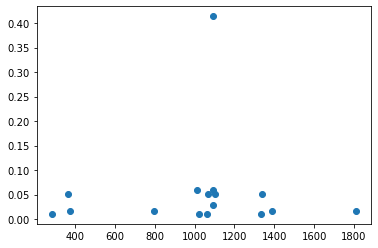

In [17]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-2:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [18]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k+1,L):
            if k == 0:
                if (kk == 1) | (kk == 5) | (kk == 6):
                    summe += 1.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
                else:
                    summe += 1./4.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
            elif k == 2:
                if (kk == k+1) | (kk == k-1):
                    summe += 1.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
                else:
                    summe += 1./4.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
            elif k == 5:
                if (kk == k+1) | (kk == k-1):
                    summe += 1.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
                else:
                    summe += 1./4.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
            else:
                if (kk == k+1) | (kk == k-1) | (kk == 6):
                    summe += 1.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
                else:
                    summe += 1./4.*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])                    
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [19]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [26]:
import optuna
n_iter = 5000
theta = np.zeros(9*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(9):
            theta[9*i+j] = trial.suggest_float("9*"+str(i)+"+"+str(j), -4*np.pi, 4*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[9*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

        psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
        psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

        psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
        psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

        psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-15 13:40:55,008] A new study created in memory with name: no-name-ce9168cc-8c0a-4149-8fde-b57d41b71a96
[I 2022-05-15 13:40:57,381] Trial 0 finished with value: 27.415634610117035 and parameters: {'9*0+0': -5.615664059276985, '9*0+1': -2.687153359302899, '9*0+2': 9.970225313481897, '9*0+3': -11.39420539049743, '9*0+4': 1.277408979241745, '9*0+5': -3.69655317271099, '9*0+6': 2.9503371379322054, '9*0+7': 12.021479341195459, '9*0+8': -11.355483562435152, '9*1+0': 3.3826172036017077, '9*1+1': -4.957079796395935, '9*1+2': 7.945451027217253, '9*1+3': 0.012411559472431222, '9*1+4': 6.453363640623799, '9*1+5': -5.537899697880798, '9*1+6': -9.655866453639174, '9*1+7': 11.297128816711691, '9*1+8': 0.7094044787835418, '9*2+0': 11.57617061812742, '9*2+1': 7.034560257700466, '9*2+2': 11.951773119955543, '9*2+3': 9.65126400699581, '9*2+4': -3.3894583984149342, '9*2+5': 11.599249131476018, '9*2+6': -5.760934048111191, '9*2+7': -2.417465908187424, '9*2+8': -8.915877986779293, '9*3+0': 4.2993

[I 2022-05-15 13:41:15,910] Trial 7 finished with value: 27.326458107544312 and parameters: {'9*0+0': 0.9805255120756374, '9*0+1': 2.529559927973244, '9*0+2': -1.5245105344934418, '9*0+3': -1.8209268531751097, '9*0+4': 4.078661668357425, '9*0+5': 0.0726992123956115, '9*0+6': 6.141469607792566, '9*0+7': -0.7038287184669882, '9*0+8': -1.8897627948667939, '9*1+0': -3.7883274634895456, '9*1+1': -1.100893597507093, '9*1+2': -1.7238743736281017, '9*1+3': 6.605050836578698, '9*1+4': 3.1362760013345956, '9*1+5': 2.5096232140496504, '9*1+6': 11.675634003644275, '9*1+7': 2.557884187835614, '9*1+8': 4.542306689516245, '9*2+0': 4.663744629443314, '9*2+1': 0.4625822322762544, '9*2+2': 2.029367182276129, '9*2+3': 0.523415660088828, '9*2+4': -0.1420034385404314, '9*2+5': 0.09509197405506851, '9*2+6': -3.646084156662168, '9*2+7': 4.076000814113048, '9*2+8': 0.8240604173598741, '9*3+0': 4.781826219265631, '9*3+1': -1.2260066587194647, '9*3+2': -2.5282604889171507, '9*3+3': 4.505765488649147, '9*3+4': 1

[I 2022-05-15 13:41:34,727] Trial 14 finished with value: 39.13228233561572 and parameters: {'9*0+0': 0.2380812783547798, '9*0+1': 6.086598914571942, '9*0+2': -1.457754323409199, '9*0+3': -2.295758394718988, '9*0+4': 3.0561301294028778, '9*0+5': -2.2225355931576, '9*0+6': -1.80211617127775, '9*0+7': -4.093664123754017, '9*0+8': 5.278080014429185, '9*1+0': 4.3291553215451275, '9*1+1': 5.743017239984918, '9*1+2': 2.9342172561937443, '9*1+3': -2.1533395865784706, '9*1+4': 2.6424544729090638, '9*1+5': -2.3293964711866924, '9*1+6': 0.9189954630315358, '9*1+7': -4.075156740506949, '9*1+8': 8.188100580988275, '9*2+0': -5.2211560083159405, '9*2+1': 0.4037508357773735, '9*2+2': -0.07162989729075774, '9*2+3': -5.182436815279767, '9*2+4': -2.7241607104194947, '9*2+5': -1.2903748739563723, '9*2+6': -2.185246915560694, '9*2+7': 2.271787479930425, '9*2+8': 7.7569142235915125, '9*3+0': 1.5114273938999272, '9*3+1': 0.6043369775953659, '9*3+2': -0.07032752195167591, '9*3+3': -5.053714787400989, '9*3+4'

[I 2022-05-15 13:41:54,444] Trial 21 finished with value: 32.224847884050256 and parameters: {'9*0+0': 0.44164129014889153, '9*0+1': -7.465375439000238, '9*0+2': 6.1443006622839045, '9*0+3': -5.866547323114865, '9*0+4': 1.2163909937040969, '9*0+5': 6.465500765079428, '9*0+6': -5.064754227378066, '9*0+7': 7.586107111608156, '9*0+8': 4.5521440501868575, '9*1+0': 2.734636248158928, '9*1+1': -0.8115085920971357, '9*1+2': -3.042376304154835, '9*1+3': 5.981440974632373, '9*1+4': 7.373057174835406, '9*1+5': -0.7020558145654603, '9*1+6': 0.7294580401488664, '9*1+7': 6.021632757512825, '9*1+8': -3.7639637983115874, '9*2+0': 2.3548704052851996, '9*2+1': -8.875352106963778, '9*2+2': 0.5789982868285857, '9*2+3': -2.6277728236277507, '9*2+4': -4.917469244241058, '9*2+5': -5.827591193986208, '9*2+6': 4.035296205875506, '9*2+7': -5.798024713589372, '9*2+8': -2.617425668224144, '9*3+0': -7.442644737522522, '9*3+1': 3.226767264554983, '9*3+2': 0.24554126429506207, '9*3+3': 1.453101574561208, '9*3+4': 3

[I 2022-05-15 13:42:11,118] Trial 28 finished with value: 32.64923596213984 and parameters: {'9*0+0': -1.6342943658999602, '9*0+1': -1.3147568392830062, '9*0+2': 7.408611693718843, '9*0+3': -3.975129572735073, '9*0+4': 8.624035620210025, '9*0+5': -2.2369343464688276, '9*0+6': -1.0142547909723503, '9*0+7': 0.26168501326338234, '9*0+8': 4.4013990523428586, '9*1+0': -2.6754936107173757, '9*1+1': 2.070780166641051, '9*1+2': 6.250549668003081, '9*1+3': -4.171026188148611, '9*1+4': 3.85469787220285, '9*1+5': 4.441654686291458, '9*1+6': 4.347690755429791, '9*1+7': -5.033895676374118, '9*1+8': -0.8564989276297896, '9*2+0': 3.3089644741565074, '9*2+1': -0.3439595803943296, '9*2+2': 7.36969702284402, '9*2+3': 0.2697430523716268, '9*2+4': -6.045517639173731, '9*2+5': -5.711344327467451, '9*2+6': -4.1391445486537615, '9*2+7': -5.506348944869215, '9*2+8': -9.738067681156409, '9*3+0': -0.11891694202122993, '9*3+1': -4.4920975791609195, '9*3+2': 4.570844270185912, '9*3+3': -4.230374159816977, '9*3+4'

[I 2022-05-15 13:42:29,182] Trial 35 finished with value: 32.75609039720028 and parameters: {'9*0+0': -0.3351199671836256, '9*0+1': 1.062926606367601, '9*0+2': 2.095361206300004, '9*0+3': -9.012643305847323, '9*0+4': -1.422986242199324, '9*0+5': 3.375127725969614, '9*0+6': -0.9013766698896442, '9*0+7': 3.817139577232671, '9*0+8': 4.772558016875671, '9*1+0': 3.2830765793147068, '9*1+1': -6.981543031059019, '9*1+2': -0.5287975248535111, '9*1+3': -6.06610923027621, '9*1+4': 5.5125304359061635, '9*1+5': -1.9567720334817342, '9*1+6': -0.22831801576955124, '9*1+7': -1.9138999043408296, '9*1+8': -3.517837071371475, '9*2+0': -3.3472601808601885, '9*2+1': -1.100397405314429, '9*2+2': 5.592484251148149, '9*2+3': 1.7515960669400168, '9*2+4': -9.641611513006177, '9*2+5': 0.3782279652068228, '9*2+6': -5.426355652760834, '9*2+7': 4.252451394399384, '9*2+8': 4.723740560371693, '9*3+0': 4.5118380003021885, '9*3+1': -11.104816779824176, '9*3+2': 4.47856747212661, '9*3+3': -1.2487196109903753, '9*3+4': 

[I 2022-05-15 13:42:49,418] Trial 42 finished with value: 22.44842188197689 and parameters: {'9*0+0': -0.11929322623153626, '9*0+1': 7.1569628261018625, '9*0+2': 0.7084192112750523, '9*0+3': -3.534675147300127, '9*0+4': 0.34660518013821284, '9*0+5': 3.09111237984142, '9*0+6': -10.952709948838915, '9*0+7': 7.69312574728427, '9*0+8': 0.5862018547106775, '9*1+0': 3.383017128344531, '9*1+1': 1.2748838920916286, '9*1+2': 0.8081401503200316, '9*1+3': -3.633079985335189, '9*1+4': 2.268184887807019, '9*1+5': -6.078021988510971, '9*1+6': -1.4201547448352545, '9*1+7': 0.692332187692871, '9*1+8': -7.995427796682639, '9*2+0': 0.4387688315889209, '9*2+1': 1.7044256699692415, '9*2+2': 0.2795888362111496, '9*2+3': 7.090034070626541, '9*2+4': -0.984920698894705, '9*2+5': -1.0527533045709694, '9*2+6': -6.0653692296094155, '9*2+7': 6.909697640681884, '9*2+8': 5.738815814064942, '9*3+0': -0.45417106434619126, '9*3+1': -7.785881814094257, '9*3+2': -0.9849517108137318, '9*3+3': 4.522587932175065, '9*3+4': 

[I 2022-05-15 13:43:09,889] Trial 49 finished with value: 29.934191112132936 and parameters: {'9*0+0': -0.9042722913103222, '9*0+1': -1.5771721584479357, '9*0+2': -0.6320881763739816, '9*0+3': -3.4168555019988247, '9*0+4': -3.5199784662847424, '9*0+5': 2.360030383536011, '9*0+6': -10.7880811789882, '9*0+7': 1.3610808104504795, '9*0+8': 2.7790707703913435, '9*1+0': 4.79168378302137, '9*1+1': 6.2265996195074775, '9*1+2': -2.0003903862792596, '9*1+3': 0.7638626641162412, '9*1+4': -6.051529244487392, '9*1+5': 0.3659309675213125, '9*1+6': -3.1597622303844477, '9*1+7': -1.9538813373419537, '9*1+8': -4.300303763230549, '9*2+0': -0.8412401682433466, '9*2+1': -0.7427575404728997, '9*2+2': -7.303266338128839, '9*2+3': 8.232514930489938, '9*2+4': -3.70202172645375, '9*2+5': 2.431307454474739, '9*2+6': -8.267928491073777, '9*2+7': 4.26162487212378, '9*2+8': -0.7479415592829453, '9*3+0': 5.608765761775851, '9*3+1': -9.291822655643548, '9*3+2': -2.2129452731145145, '9*3+3': 2.986952264747159, '9*3+4

[I 2022-05-15 13:43:28,333] Trial 56 finished with value: 26.43281156508744 and parameters: {'9*0+0': -10.271011870854604, '9*0+1': 2.2614020532411656, '9*0+2': 3.7305921531417083, '9*0+3': -7.922022694450083, '9*0+4': 5.9138261486500685, '9*0+5': 10.01354951515366, '9*0+6': 1.4995572634011136, '9*0+7': 0.7942040882710959, '9*0+8': -4.420414878185248, '9*1+0': -0.8644482691072802, '9*1+1': 2.8784662521574864, '9*1+2': 0.6788429661232299, '9*1+3': 3.883658144283247, '9*1+4': -1.4017693892182175, '9*1+5': 1.4647320572847677, '9*1+6': -1.1589782193987475, '9*1+7': -2.011900241761178, '9*1+8': -2.5072876408439146, '9*2+0': 3.1673253800997263, '9*2+1': -4.085777100721433, '9*2+2': -5.00908023381985, '9*2+3': 2.651426332610268, '9*2+4': -5.8120430701895085, '9*2+5': 3.1997865275919626, '9*2+6': -4.271161439698459, '9*2+7': 2.8771625504954392, '9*2+8': 0.47767953883247516, '9*3+0': 4.561948719208026, '9*3+1': -9.785692220841213, '9*3+2': -3.856485256424962, '9*3+3': 0.15708864326323346, '9*3+

[I 2022-05-15 13:43:46,733] Trial 63 finished with value: 30.453953352223298 and parameters: {'9*0+0': 0.3813919227642564, '9*0+1': 11.245753646525394, '9*0+2': -0.2362254835356874, '9*0+3': -9.602043495906772, '9*0+4': 3.3402681994405095, '9*0+5': 6.215395851088595, '9*0+6': 0.4008015733537311, '9*0+7': 0.20872980500862592, '9*0+8': 1.941942263538067, '9*1+0': -1.4125347445027843, '9*1+1': -5.297268885937403, '9*1+2': -1.8352612939349753, '9*1+3': 2.936179853901255, '9*1+4': 6.817840208513409, '9*1+5': -2.261523794648878, '9*1+6': 2.0585734545313925, '9*1+7': -10.353558263002691, '9*1+8': -6.957595145381031, '9*2+0': -0.15326081729064, '9*2+1': 0.13601348325745555, '9*2+2': -0.24103172136829282, '9*2+3': 1.2517252753857635, '9*2+4': -2.868236815331181, '9*2+5': 9.359668872132255, '9*2+6': -8.599325015384231, '9*2+7': 7.299048358741595, '9*2+8': -3.314823223479195, '9*3+0': 3.1006044879224377, '9*3+1': -9.809616071779985, '9*3+2': -3.67032402157485, '9*3+3': 1.9405779424045884, '9*3+4'

[I 2022-05-15 13:44:04,304] Trial 70 finished with value: 20.94922793101803 and parameters: {'9*0+0': 0.515687906500375, '9*0+1': 8.897380986424473, '9*0+2': 0.18001567685970188, '9*0+3': -5.4670351619477, '9*0+4': 5.821709502115121, '9*0+5': 8.143217257867725, '9*0+6': -3.0767519368058585, '9*0+7': 9.095180219125615, '9*0+8': 1.804857354167516, '9*1+0': 1.6897540767108823, '9*1+1': -5.542960238597296, '9*1+2': 0.3430329498420991, '9*1+3': -7.539940158123528, '9*1+4': -1.4861772767973829, '9*1+5': -9.631331696107843, '9*1+6': -3.8288845624839682, '9*1+7': 1.117139434806929, '9*1+8': -8.23738867856653, '9*2+0': -1.2346295244544192, '9*2+1': 3.2590859961595564, '9*2+2': -2.373255039571017, '9*2+3': 8.254135792127032, '9*2+4': -6.666082963558846, '9*2+5': -1.3572152886808881, '9*2+6': 2.007926595071009, '9*2+7': 10.173029727024545, '9*2+8': -2.1277009584733655, '9*3+0': 6.558942586245887, '9*3+1': -5.6508441729609995, '9*3+2': -6.423403484564124, '9*3+3': 1.3101094258840178, '9*3+4': -3.3

[I 2022-05-15 13:44:24,712] Trial 77 finished with value: 27.832101903442013 and parameters: {'9*0+0': 0.011010592339660952, '9*0+1': 8.918065395594633, '9*0+2': 2.9712435205631262, '9*0+3': -8.779650692011353, '9*0+4': 4.25903479182922, '9*0+5': 5.570325296043256, '9*0+6': -1.8976087176132306, '9*0+7': 3.495085771085046, '9*0+8': -2.9191087867393604, '9*1+0': -5.589125608967755, '9*1+1': -2.8890608254251426, '9*1+2': -1.604057424875378, '9*1+3': -10.127583010563344, '9*1+4': 1.5814509406930088, '9*1+5': -3.4778612803300217, '9*1+6': -0.7524846481079734, '9*1+7': -0.1747705420952248, '9*1+8': -2.291984713755736, '9*2+0': 0.8268457878756177, '9*2+1': 6.901595638615403, '9*2+2': -1.7030902798492833, '9*2+3': 4.328782500518051, '9*2+4': -9.654006115526471, '9*2+5': 0.3220135814297538, '9*2+6': 2.8944387578614656, '9*2+7': 5.65755076248167, '9*2+8': 6.32299762626802, '9*3+0': 2.744149078236831, '9*3+1': -8.420471933787029, '9*3+2': -3.2549843994864434, '9*3+3': -0.18601787923324054, '9*3+4

[I 2022-05-15 13:44:45,233] Trial 84 finished with value: 35.18141920241216 and parameters: {'9*0+0': -0.7926464751502458, '9*0+1': 9.953537478321788, '9*0+2': -2.8157705653409604, '9*0+3': -1.5542157480347112, '9*0+4': -1.9677136285753942, '9*0+5': 4.337697095312251, '9*0+6': 0.3811058867157664, '9*0+7': 12.25268196919156, '9*0+8': 2.0171386111541114, '9*1+0': -2.2685164630408803, '9*1+1': 0.4493806884137794, '9*1+2': 3.453677066430782, '9*1+3': -4.712996270520041, '9*1+4': -5.562307017853378, '9*1+5': -6.934366782581449, '9*1+6': -1.687270613787501, '9*1+7': -3.746140232234166, '9*1+8': -3.763293160999423, '9*2+0': -0.3991977100293518, '9*2+1': 2.551959122958809, '9*2+2': -2.9359408641335136, '9*2+3': 9.078577982518036, '9*2+4': -3.018543100348776, '9*2+5': 6.167802902555584, '9*2+6': 1.6705379111494256, '9*2+7': 3.0426557108164394, '9*2+8': 1.787086770424054, '9*3+0': 0.49872571406459976, '9*3+1': -5.711085026131072, '9*3+2': -1.3256248704108367, '9*3+3': 2.867027630570549, '9*3+4':

[I 2022-05-15 13:45:05,605] Trial 91 finished with value: 28.49567914406591 and parameters: {'9*0+0': -3.665531490119816, '9*0+1': 11.465732971863137, '9*0+2': 1.8480808612884942, '9*0+3': 1.611393393596619, '9*0+4': -0.8391780460384721, '9*0+5': 10.46747846536866, '9*0+6': 1.3749096293863445, '9*0+7': 8.939300797682366, '9*0+8': -8.229331061070695, '9*1+0': -3.408189908424207, '9*1+1': -2.8635741984348706, '9*1+2': 1.0202939250605816, '9*1+3': -2.9604157605057657, '9*1+4': -3.124071900284393, '9*1+5': -5.453931557399649, '9*1+6': -2.656942979966791, '9*1+7': -1.2757270358183619, '9*1+8': 0.30736587645305935, '9*2+0': -2.8906310154168358, '9*2+1': 2.5392689532112813, '9*2+2': -1.9404863478064098, '9*2+3': 1.8328217119416155, '9*2+4': -8.816369846294643, '9*2+5': 3.001895896834948, '9*2+6': -5.240230852715182, '9*2+7': 0.8251222583087099, '9*2+8': -1.660049612201705, '9*3+0': 9.635757837509257, '9*3+1': -5.933118046511121, '9*3+2': -4.709185154363606, '9*3+3': 5.314436677095902, '9*3+4'

[I 2022-05-15 13:45:24,430] Trial 98 finished with value: 27.847896070279095 and parameters: {'9*0+0': 0.7351140289037543, '9*0+1': 10.391450243806789, '9*0+2': 3.981516512542029, '9*0+3': -5.789811864657009, '9*0+4': 7.555553945161453, '9*0+5': 1.0260783033177958, '9*0+6': 0.0614273384654942, '9*0+7': 5.6809256885259325, '9*0+8': -4.571779468695901, '9*1+0': -9.838227726542296, '9*1+1': -1.6559938250347177, '9*1+2': 4.922483246255971, '9*1+3': -5.258959731558483, '9*1+4': -3.1161076582225173, '9*1+5': -8.58834423333567, '9*1+6': -8.432922535712567, '9*1+7': -0.6321446738732188, '9*1+8': -1.9795411847214277, '9*2+0': 3.3456957299232117, '9*2+1': -12.395750626013559, '9*2+2': 4.858046450458808, '9*2+3': -5.635990726908881, '9*2+4': -3.6720140182386083, '9*2+5': 1.5774180448730624, '9*2+6': -3.1965415997105895, '9*2+7': 5.075610865962743, '9*2+8': 0.3534957604827622, '9*3+0': 3.510401483533656, '9*3+1': -1.3343262912311724, '9*3+2': 0.4222163679460484, '9*3+3': 0.4915044853779671, '9*3+4

[I 2022-05-15 13:45:41,235] Trial 105 finished with value: 32.63662405212102 and parameters: {'9*0+0': 0.7103786552615776, '9*0+1': 12.472353610059608, '9*0+2': -5.554012573297509, '9*0+3': -0.805106629321344, '9*0+4': 4.28527613585275, '9*0+5': 4.602829323600582, '9*0+6': 0.06571788404216505, '9*0+7': 7.784179913274912, '9*0+8': -2.946612125151032, '9*1+0': -2.0818257707646013, '9*1+1': -1.337066351604618, '9*1+2': 7.865805905855812, '9*1+3': -11.341886374712193, '9*1+4': -5.942707291469408, '9*1+5': -5.498015049494416, '9*1+6': -5.641490154520766, '9*1+7': -4.5184670631927215, '9*1+8': -4.364104589821713, '9*2+0': -4.639088404410667, '9*2+1': 7.788451480937734, '9*2+2': 2.9308602150432197, '9*2+3': 3.9450482070477744, '9*2+4': -3.194400178922479, '9*2+5': 8.379141655253171, '9*2+6': 2.054396097796821, '9*2+7': 10.464119057515923, '9*2+8': -0.5184079273255287, '9*3+0': 0.7574050182129205, '9*3+1': -6.6499255196371285, '9*3+2': -0.10453719118794524, '9*3+3': 7.423836631839697, '9*3+4':

[I 2022-05-15 13:45:57,611] Trial 112 finished with value: 30.8445892711639 and parameters: {'9*0+0': -2.592327102426115, '9*0+1': 10.854275059141775, '9*0+2': 0.16647932181507774, '9*0+3': -1.8398905681679876, '9*0+4': 4.723761430723106, '9*0+5': 11.04694086455417, '9*0+6': 3.463501431377278, '9*0+7': 5.503976451785439, '9*0+8': -2.6800096951799164, '9*1+0': -4.844580429117459, '9*1+1': 1.3176313782600921, '9*1+2': 2.387534336102764, '9*1+3': -10.628409008694, '9*1+4': -2.6913861931857137, '9*1+5': -11.52118714881049, '9*1+6': -4.708982196137672, '9*1+7': 0.32562485993708545, '9*1+8': -1.2930954429605772, '9*2+0': 6.160516080626512, '9*2+1': 3.530070746042104, '9*2+2': -4.8387177992509445, '9*2+3': 1.3006926011302085, '9*2+4': -7.763378391281332, '9*2+5': 6.4450811761384745, '9*2+6': 3.551552634441651, '9*2+7': 6.9204207889465765, '9*2+8': -7.1361675834607485, '9*3+0': 3.394583636165825, '9*3+1': -4.2609532164655635, '9*3+2': -5.436979911091627, '9*3+3': 5.067390017471577, '9*3+4': -3

[I 2022-05-15 13:46:16,082] Trial 119 finished with value: 32.491924429954764 and parameters: {'9*0+0': -10.222986184827889, '9*0+1': 3.4429174127761444, '9*0+2': -4.67223698330121, '9*0+3': -4.529127154093738, '9*0+4': 1.4817657268420454, '9*0+5': 8.634097169793632, '9*0+6': 0.981679998276056, '9*0+7': 2.124651781991326, '9*0+8': -0.934292405452628, '9*1+0': -2.4875340549382954, '9*1+1': -0.012532050996182598, '9*1+2': 2.0633999980832614, '9*1+3': -3.801165154213984, '9*1+4': -7.397608532274695, '9*1+5': -1.8500700192058481, '9*1+6': -5.60397748199402, '9*1+7': -1.3099844838091679, '9*1+8': 0.8767164680604029, '9*2+0': 4.301801241186243, '9*2+1': 12.511685345258478, '9*2+2': 1.014840787650582, '9*2+3': -2.663371409812801, '9*2+4': -9.323532726647409, '9*2+5': 1.4118493692578151, '9*2+6': -5.4540502075145945, '9*2+7': 10.17553123158326, '9*2+8': -0.2535859676291867, '9*3+0': 2.448012574269281, '9*3+1': -3.5229066378525844, '9*3+2': -0.2263068125413028, '9*3+3': -1.7329066771066792, '9*

[I 2022-05-15 13:46:36,653] Trial 126 finished with value: 31.86246919391599 and parameters: {'9*0+0': 3.9867702885750425, '9*0+1': 0.8798707040398961, '9*0+2': 3.4204805304032107, '9*0+3': -3.589218954032795, '9*0+4': 1.0993839185514158, '9*0+5': 6.681806970316845, '9*0+6': -1.324088543602406, '9*0+7': 0.36927693411229257, '9*0+8': 1.1049375931331014, '9*1+0': -0.37118463384551337, '9*1+1': -5.392371961040337, '9*1+2': 9.74327283929519, '9*1+3': -4.970834256946855, '9*1+4': -2.1202168389172464, '9*1+5': -10.98356943678889, '9*1+6': -6.305019573660678, '9*1+7': -5.047616250885005, '9*1+8': 0.9645842021215247, '9*2+0': 8.730581390951755, '9*2+1': 6.090606053273057, '9*2+2': 2.2403458220461943, '9*2+3': -3.149109970133357, '9*2+4': -11.20319227405762, '9*2+5': 3.076421689093623, '9*2+6': 3.8135367746272824, '9*2+7': 6.895728949582222, '9*2+8': 0.11589194945480719, '9*3+0': 7.627187656784699, '9*3+1': -5.5744070739871745, '9*3+2': -0.3964295278902279, '9*3+3': 5.851932896377655, '9*3+4': 

[I 2022-05-15 13:46:57,170] Trial 133 finished with value: 36.61155679636993 and parameters: {'9*0+0': 0.7431510568172104, '9*0+1': 8.703191066406767, '9*0+2': -4.081423789189516, '9*0+3': -4.282100296099688, '9*0+4': 4.341220771876696, '9*0+5': 5.945937364309721, '9*0+6': 1.9210870984293624, '9*0+7': 4.4822246386410844, '9*0+8': 10.713376701163693, '9*1+0': -0.37796587448039143, '9*1+1': -5.484924298528485, '9*1+2': 7.17723184065225, '9*1+3': -9.104624043439728, '9*1+4': -8.219445625416066, '9*1+5': -6.0598250915214855, '9*1+6': -5.139093826376209, '9*1+7': -5.228619405312566, '9*1+8': -3.011712543190185, '9*2+0': -2.2873616362166267, '9*2+1': 8.781959140508077, '9*2+2': -3.718031461094011, '9*2+3': 4.084735968166671, '9*2+4': -9.537744701653358, '9*2+5': 3.7755517963545304, '9*2+6': -1.6185762206684557, '9*2+7': 6.77361149023678, '9*2+8': -7.920918643308076, '9*3+0': 3.4295400691764932, '9*3+1': 1.3029257254704953, '9*3+2': 9.55451516167739, '9*3+3': -2.0170224985656002, '9*3+4': -9.

[I 2022-05-15 13:47:17,814] Trial 140 finished with value: 25.30464492576536 and parameters: {'9*0+0': 2.3819295802683023, '9*0+1': 6.928708190313335, '9*0+2': -4.552355789607317, '9*0+3': -8.041395969651681, '9*0+4': 3.129493060587463, '9*0+5': 6.484431817462866, '9*0+6': 2.4396243580823143, '9*0+7': 1.9096167307982994, '9*0+8': 3.4564986922344847, '9*1+0': 1.8821385890557014, '9*1+1': -1.4370885340662607, '9*1+2': 5.5309168484477915, '9*1+3': -3.516031778074445, '9*1+4': -6.769490057815089, '9*1+5': -9.479531890576332, '9*1+6': -11.366894576809441, '9*1+7': -0.8046921209742957, '9*1+8': -6.470374087928219, '9*2+0': -0.8295623063104431, '9*2+1': 10.951872209117772, '9*2+2': -5.180332346390655, '9*2+3': 2.457651887242532, '9*2+4': -9.035066696674916, '9*2+5': 3.9792134050707757, '9*2+6': 0.8369053658121215, '9*2+7': 8.823274679859669, '9*2+8': -7.3790692875291315, '9*3+0': 6.099668776550492, '9*3+1': -3.4491995295423408, '9*3+2': 10.217513902404978, '9*3+3': 1.853075783627867, '9*3+4':

[I 2022-05-15 13:47:38,406] Trial 147 finished with value: 34.19055437758167 and parameters: {'9*0+0': -0.785955908881504, '9*0+1': 9.906192030121709, '9*0+2': 0.2925084518740334, '9*0+3': -5.023519339648816, '9*0+4': -6.065087129396065, '9*0+5': 6.006232604870945, '9*0+6': -0.5778005176773664, '9*0+7': 10.35547020795304, '9*0+8': 5.866942219721896, '9*1+0': -0.7673703243418044, '9*1+1': -1.3260971566958646, '9*1+2': -0.7684845698615561, '9*1+3': 0.6939559987684036, '9*1+4': -9.819739807637385, '9*1+5': -7.658060031338815, '9*1+6': -5.958166568860737, '9*1+7': -10.35036232749406, '9*1+8': -7.498131562197107, '9*2+0': -3.1593631386098493, '9*2+1': 3.5036350678821515, '9*2+2': -1.1806424161232973, '9*2+3': 9.215505884059745, '9*2+4': -9.056080974520837, '9*2+5': 4.084540659825421, '9*2+6': -0.4233244976856918, '9*2+7': 1.0083514035486028, '9*2+8': -7.034727255341931, '9*3+0': 3.667707570149439, '9*3+1': 3.1235478096999847, '9*3+2': 9.31864553362893, '9*3+3': 6.348694660536157, '9*3+4': -

[I 2022-05-15 13:47:58,157] Trial 154 finished with value: 32.80407645970216 and parameters: {'9*0+0': -0.9983819740076745, '9*0+1': 7.368535612112197, '9*0+2': -3.652815960586043, '9*0+3': -2.7585349588359422, '9*0+4': 2.8864521036252597, '9*0+5': 4.729761073572966, '9*0+6': -2.655115057764907, '9*0+7': -1.102589865387218, '9*0+8': 9.96358987761101, '9*1+0': -2.2177044426570336, '9*1+1': -11.528938814759144, '9*1+2': -3.6718462132580525, '9*1+3': -2.513162833206721, '9*1+4': -10.797407855469945, '9*1+5': -11.045273743127701, '9*1+6': -8.928789680523348, '9*1+7': -5.153077729095784, '9*1+8': -0.13538183598718234, '9*2+0': -8.258696870255196, '9*2+1': 0.688992182228338, '9*2+2': -3.982067244508464, '9*2+3': 10.574390358931435, '9*2+4': -11.550780432696781, '9*2+5': 8.370518914668164, '9*2+6': 4.16696327070361, '9*2+7': 12.118478017280264, '9*2+8': -4.336487198210288, '9*3+0': 5.079080160890203, '9*3+1': -2.7135173923584053, '9*3+2': 10.693812695002409, '9*3+3': 1.595850548794656, '9*3+4

[I 2022-05-15 13:48:15,212] Trial 161 finished with value: 28.281377716851136 and parameters: {'9*0+0': -3.680323759586819, '9*0+1': -1.5947175476524507, '9*0+2': 7.4305820397721245, '9*0+3': -4.1018145782027995, '9*0+4': 1.6954044176356549, '9*0+5': 3.1213732617798855, '9*0+6': -0.6849872132744319, '9*0+7': 4.5318507414724625, '9*0+8': 7.869469372114192, '9*1+0': 0.944252686581375, '9*1+1': -5.7782172488992565, '9*1+2': 1.6672234392909862, '9*1+3': -4.848923539709267, '9*1+4': -7.706355047156669, '9*1+5': -2.113245571617073, '9*1+6': -8.75297342676459, '9*1+7': -5.331202149511326, '9*1+8': -9.78487426223223, '9*2+0': 2.533687075936717, '9*2+1': 5.298714007166717, '9*2+2': -1.2650828674206855, '9*2+3': 4.664228571136112, '9*2+4': -6.191009162169471, '9*2+5': 5.780604089557554, '9*2+6': -0.5975872625709691, '9*2+7': 10.348892878320699, '9*2+8': 3.292614486328652, '9*3+0': 2.2411556391554974, '9*3+1': 1.6453997161628626, '9*3+2': 7.5216022637111255, '9*3+3': 1.561507580121361, '9*3+4': -

[I 2022-05-15 13:48:32,627] Trial 168 finished with value: 25.34532859867189 and parameters: {'9*0+0': -0.5261583956511893, '9*0+1': -1.940807595190952, '9*0+2': 0.7638615501592888, '9*0+3': -5.3406482307461, '9*0+4': -0.21261166130415132, '9*0+5': 3.4711805596666903, '9*0+6': -2.9215386986981713, '9*0+7': 1.5019978061978212, '9*0+8': 2.122540984404477, '9*1+0': -6.234994364707108, '9*1+1': -6.137148413486627, '9*1+2': -2.351296188099959, '9*1+3': -0.7574661571338392, '9*1+4': -12.519625123865112, '9*1+5': -0.3438036592370528, '9*1+6': -10.18168286624823, '9*1+7': -6.22560488972418, '9*1+8': -10.337410157542646, '9*2+0': -0.2207552246070993, '9*2+1': 3.9336272766911176, '9*2+2': -2.371529155144016, '9*2+3': 9.46779781720941, '9*2+4': -8.495085555765565, '9*2+5': -1.7889442789904146, '9*2+6': -3.965195242125717, '9*2+7': 8.13809186944742, '9*2+8': -1.7803226315363507, '9*3+0': 2.1619333904150726, '9*3+1': -6.112432127733764, '9*3+2': 8.679156449288923, '9*3+3': -4.7412367897996255, '9*3

[I 2022-05-15 13:48:53,198] Trial 175 finished with value: 30.224865049887846 and parameters: {'9*0+0': -6.744468471198918, '9*0+1': -1.413950768811659, '9*0+2': 2.94928660891436, '9*0+3': -11.191978158234134, '9*0+4': 1.4767761238784254, '9*0+5': -0.35553402357350405, '9*0+6': -3.751623056094343, '9*0+7': 6.5362592175078, '9*0+8': 5.079793638922055, '9*1+0': -6.306529168403315, '9*1+1': -6.114187732581428, '9*1+2': 9.722217409971142, '9*1+3': -1.809930694851386, '9*1+4': -10.618224255144142, '9*1+5': 4.840613876418416, '9*1+6': -11.0689890453977, '9*1+7': -5.1595494708450875, '9*1+8': -9.775804120468138, '9*2+0': -3.3881328929779575, '9*2+1': 7.041942183075117, '9*2+2': -2.997525120838263, '9*2+3': 7.037174885431912, '9*2+4': -9.35977890201625, '9*2+5': -0.8254430495996847, '9*2+6': -3.422644834589367, '9*2+7': 9.6874627321971, '9*2+8': -4.100976221752699, '9*3+0': 2.707468696568, '9*3+1': -7.04876959717191, '9*3+2': 8.413984335973586, '9*3+3': -2.0801731603059173, '9*3+4': -2.8276984

[I 2022-05-15 13:49:12,891] Trial 182 finished with value: 27.2686758520431 and parameters: {'9*0+0': -2.1185226958036427, '9*0+1': -3.2414258812735457, '9*0+2': 2.8616139758798806, '9*0+3': -6.8354691611856, '9*0+4': -1.2644179803353945, '9*0+5': 0.7437790658083985, '9*0+6': -1.3411809627532318, '9*0+7': 1.6232390694143495, '9*0+8': 10.43656044790503, '9*1+0': -5.790571318055743, '9*1+1': -7.49707912564018, '9*1+2': 0.1279381302272511, '9*1+3': 0.08727775726015313, '9*1+4': -6.252856817448605, '9*1+5': -3.7653184750060555, '9*1+6': -6.730165881127212, '9*1+7': -9.332116306048217, '9*1+8': -8.616386224850451, '9*2+0': -1.164446254711415, '9*2+1': 6.381356639137366, '9*2+2': -3.077302720580344, '9*2+3': 7.437569569391514, '9*2+4': -1.7023897705934363, '9*2+5': 1.1983354786833118, '9*2+6': -2.3629780338019426, '9*2+7': 8.699331325813759, '9*2+8': -3.4716034912917997, '9*3+0': -3.3059913200958695, '9*3+1': -7.470350500825578, '9*3+2': 11.692882901414992, '9*3+3': -1.8928040814066105, '9*3

[I 2022-05-15 13:49:33,304] Trial 189 finished with value: 28.582663572247384 and parameters: {'9*0+0': -1.3874954012615313, '9*0+1': 1.8939974108347792, '9*0+2': -2.944157762404829, '9*0+3': -6.412324510138851, '9*0+4': 3.987411591906592, '9*0+5': -0.20615239571079358, '9*0+6': 1.9105991443946653, '9*0+7': 7.812731097562082, '9*0+8': 6.657032152020536, '9*1+0': -3.530018347063326, '9*1+1': -5.9940924186234295, '9*1+2': 1.6021415046174312, '9*1+3': 0.3476523055761177, '9*1+4': -11.029976701918256, '9*1+5': -8.691233191243029, '9*1+6': -3.726724075567083, '9*1+7': -11.611431467410988, '9*1+8': -8.429282463078646, '9*2+0': 1.6299273482952579, '9*2+1': 6.94128744591516, '9*2+2': 2.173414537669329, '9*2+3': 7.657701973152641, '9*2+4': -6.589776824015778, '9*2+5': 5.615078333201961, '9*2+6': 6.5890548520279095, '9*2+7': 9.38492258346618, '9*2+8': -3.0636767035151067, '9*3+0': -4.093372973569622, '9*3+1': -0.9750750876007359, '9*3+2': 9.126510610688074, '9*3+3': -4.531779622915732, '9*3+4': 

[I 2022-05-15 13:49:51,129] Trial 196 finished with value: 30.0143860012849 and parameters: {'9*0+0': -0.15669182963322825, '9*0+1': -2.766509020434042, '9*0+2': 3.5629253090780755, '9*0+3': -2.0623082256734913, '9*0+4': -4.690787697137132, '9*0+5': 3.318506051626335, '9*0+6': 1.2013398033498743, '9*0+7': 3.7682132443486207, '9*0+8': 7.169815784323519, '9*1+0': -0.4440917739637573, '9*1+1': -5.606902077800784, '9*1+2': 0.07096700786037874, '9*1+3': -1.0732186192074613, '9*1+4': -12.46375116552725, '9*1+5': -3.589957243856968, '9*1+6': -10.069578703185492, '9*1+7': -3.2853151378755525, '9*1+8': -6.94026476708564, '9*2+0': -2.8778946100550344, '9*2+1': 10.759461414444571, '9*2+2': -2.8095950251492825, '9*2+3': 5.486058189568561, '9*2+4': -6.512507276452725, '9*2+5': 5.039701988228273, '9*2+6': 2.084607202081139, '9*2+7': 2.8955156205590376, '9*2+8': -6.1158999428833, '9*3+0': -0.7596929184140495, '9*3+1': -9.54864871599166, '9*3+2': 11.110444926488631, '9*3+3': -4.117142680135288, '9*3+4

[I 2022-05-15 13:50:10,276] Trial 203 finished with value: 20.835610853361953 and parameters: {'9*0+0': -3.7974660872843153, '9*0+1': -1.8439487777217143, '9*0+2': 3.5197372296717644, '9*0+3': -5.125336590944324, '9*0+4': -2.270749326645316, '9*0+5': 2.3399319940318315, '9*0+6': -2.931497641397116, '9*0+7': -0.4238742247519358, '9*0+8': 2.4148804618367676, '9*1+0': -7.88965456432733, '9*1+1': -4.238112137881268, '9*1+2': 0.3496092210951889, '9*1+3': -2.5523939071115516, '9*1+4': -8.239064518850189, '9*1+5': 6.131698926242574, '9*1+6': -11.788097133927948, '9*1+7': -8.50067800369472, '9*1+8': -7.545149865507932, '9*2+0': -3.8628412484067938, '9*2+1': 5.147705476479016, '9*2+2': -5.527241140719427, '9*2+3': 2.6259789285822244, '9*2+4': -6.364329509527554, '9*2+5': -0.7699756583389759, '9*2+6': 2.104517501098111, '9*2+7': 9.910450493517029, '9*2+8': -4.601318542575921, '9*3+0': -1.330397947752742, '9*3+1': -4.9725382452885105, '9*3+2': 5.283056674201942, '9*3+3': -2.812850673359191, '9*3+

[I 2022-05-15 13:50:26,557] Trial 210 finished with value: 29.829443726391165 and parameters: {'9*0+0': 5.77606368962155, '9*0+1': -2.666225330689797, '9*0+2': 5.257747187015734, '9*0+3': -1.4966421189420904, '9*0+4': -2.127083885846067, '9*0+5': 2.0955897089662052, '9*0+6': -0.5073653838803163, '9*0+7': -4.893192917014435, '9*0+8': 8.060670734506381, '9*1+0': -4.747013485820538, '9*1+1': -1.5432049125298422, '9*1+2': 4.544932841090789, '9*1+3': 0.9906988071151834, '9*1+4': -5.970348591713811, '9*1+5': -5.354775714596188, '9*1+6': 1.7722258169277447, '9*1+7': -9.253056641104632, '9*1+8': 0.9561658223826868, '9*2+0': -1.6992536787802694, '9*2+1': 9.925069763475461, '9*2+2': -6.850806396670341, '9*2+3': 1.9563614990090263, '9*2+4': -2.298615673704299, '9*2+5': 0.8477698833937968, '9*2+6': 7.2347875516404265, '9*2+7': 5.46143929779224, '9*2+8': -1.534758841075126, '9*3+0': 1.369754112515622, '9*3+1': -7.955298479214884, '9*3+2': 11.755621777534515, '9*3+3': -4.7401006541639195, '9*3+4': -

[I 2022-05-15 13:50:47,114] Trial 217 finished with value: 31.21266691041877 and parameters: {'9*0+0': -0.4504319693709302, '9*0+1': -0.7657505338163872, '9*0+2': 7.204172404924877, '9*0+3': -10.107303369008996, '9*0+4': 2.9550653577427, '9*0+5': 3.531361111460556, '9*0+6': -1.653939498806089, '9*0+7': -2.377544607398683, '9*0+8': 3.7882535488835805, '9*1+0': -4.256554117195028, '9*1+1': -4.156556213495609, '9*1+2': -1.719170374928729, '9*1+3': -6.101583339591603, '9*1+4': -11.387362093175536, '9*1+5': 5.959776824748004, '9*1+6': -10.813797847533042, '9*1+7': -10.60820560910982, '9*1+8': -2.094950691603996, '9*2+0': -7.66869058832359, '9*2+1': -1.6713945773828107, '9*2+2': -8.74684113900668, '9*2+3': 0.43458430705858886, '9*2+4': -1.1858868722515052, '9*2+5': -2.0982179912124206, '9*2+6': 3.8648876777539396, '9*2+7': 5.202183649550581, '9*2+8': -4.35500959490445, '9*3+0': -4.680474647666074, '9*3+1': -0.5961310193676885, '9*3+2': 4.681065208856337, '9*3+3': -5.105101924145189, '9*3+4':

[I 2022-05-15 13:51:07,630] Trial 224 finished with value: 28.534267501701972 and parameters: {'9*0+0': -2.700652951362009, '9*0+1': 2.622349379301666, '9*0+2': 6.2560972020673855, '9*0+3': 0.9219627548043121, '9*0+4': -2.9597939057719707, '9*0+5': 5.650993268053963, '9*0+6': -4.20288501683979, '9*0+7': 4.334465767118799, '9*0+8': 5.424538067785254, '9*1+0': 4.0336432112114, '9*1+1': -7.811828259931145, '9*1+2': 0.3065272479794565, '9*1+3': -1.8460464682898439, '9*1+4': -8.010510203876516, '9*1+5': 2.1308035105514787, '9*1+6': -10.922186543407502, '9*1+7': -4.3754305087143806, '9*1+8': -2.848366891934683, '9*2+0': -5.979669227391467, '9*2+1': 3.0080066691591085, '9*2+2': -2.139323705538868, '9*2+3': 6.300752586158206, '9*2+4': -4.985610157367145, '9*2+5': 3.2783905686479375, '9*2+6': 1.7663496982679265, '9*2+7': 11.109754935574145, '9*2+8': -8.545699815654725, '9*3+0': 1.6378739618172702, '9*3+1': -1.1992381536714296, '9*3+2': 5.2123315482405115, '9*3+3': -0.3261195162540753, '9*3+4': 

[I 2022-05-15 13:51:28,134] Trial 231 finished with value: 25.149432255584525 and parameters: {'9*0+0': 0.16596923132429603, '9*0+1': 6.3779323317548045, '9*0+2': 3.208317682667317, '9*0+3': -7.336964847224002, '9*0+4': -6.262784116518195, '9*0+5': 4.63859659879298, '9*0+6': 2.8549631642405147, '9*0+7': 8.977522930687675, '9*0+8': 4.6057863589469115, '9*1+0': -0.701724552897065, '9*1+1': -9.955308547150201, '9*1+2': -1.675914080462537, '9*1+3': 0.7841033881362329, '9*1+4': -10.31040412430781, '9*1+5': 9.200611759381996, '9*1+6': -11.482996458853696, '9*1+7': -4.243364618827761, '9*1+8': -8.641667757390243, '9*2+0': -1.452931127292492, '9*2+1': -2.2096303198149876, '9*2+2': -7.425868772043208, '9*2+3': 5.783965937841836, '9*2+4': -0.20220326680250533, '9*2+5': 3.2551122676606714, '9*2+6': 2.902243278818135, '9*2+7': 9.419364836089418, '9*2+8': -3.964872800473499, '9*3+0': 1.7540294800979683, '9*3+1': -12.199069569445768, '9*3+2': 7.020259888078922, '9*3+3': -0.572942494949006, '9*3+4': 

[I 2022-05-15 13:51:47,657] Trial 238 finished with value: 27.4989634601635 and parameters: {'9*0+0': -1.1588162574145116, '9*0+1': 0.46974767749900814, '9*0+2': 5.141056630364232, '9*0+3': -7.152706631440774, '9*0+4': 3.530739518725765, '9*0+5': 0.6232479839547942, '9*0+6': 0.4489727656900778, '9*0+7': 0.42690978463628176, '9*0+8': 0.6584042258031921, '9*1+0': -10.127767910008426, '9*1+1': -1.600558527612728, '9*1+2': -3.907004180114959, '9*1+3': -9.497317860018189, '9*1+4': -9.573910548973833, '9*1+5': 2.6843882581648613, '9*1+6': -5.778515721845396, '9*1+7': -2.322929506894591, '9*1+8': -2.235178188800343, '9*2+0': -0.6250903999443992, '9*2+1': -1.8993031408193124, '9*2+2': 1.11171605390341, '9*2+3': 3.493916693340555, '9*2+4': -4.410272354080721, '9*2+5': -3.895033596454896, '9*2+6': 4.316487454938272, '9*2+7': 9.463258683850386, '9*2+8': -3.5451777589981806, '9*3+0': -3.4634672986725707, '9*3+1': -2.46071430031261, '9*3+2': 5.736576145016072, '9*3+3': -1.0509978480797464, '9*3+4':

[I 2022-05-15 13:52:05,589] Trial 245 finished with value: 29.638765066237237 and parameters: {'9*0+0': -2.5204532372369295, '9*0+1': 1.0264512924589493, '9*0+2': 3.187221739016804, '9*0+3': -6.093338750641695, '9*0+4': -3.2436107842438737, '9*0+5': 3.1518472174447782, '9*0+6': 4.14894304006621, '9*0+7': -0.6824689741788083, '9*0+8': 5.920215669817892, '9*1+0': -6.47127020348147, '9*1+1': -9.077104724381051, '9*1+2': -4.686629710121867, '9*1+3': -4.363930854027791, '9*1+4': -8.447229442811707, '9*1+5': -0.802431310310987, '9*1+6': -8.39096766329055, '9*1+7': -6.40244356373071, '9*1+8': -8.84424984439325, '9*2+0': -3.2955143642859746, '9*2+1': -0.12983339428412824, '9*2+2': -6.868450709490187, '9*2+3': 7.685118494367904, '9*2+4': 3.6393033345031434, '9*2+5': -1.0261692206347532, '9*2+6': 1.5057758068415743, '9*2+7': 4.868715100675984, '9*2+8': -0.3005217588746898, '9*3+0': 2.7608859471038554, '9*3+1': -6.022515546501204, '9*3+2': 8.169292358128837, '9*3+3': -0.9731950308318504, '9*3+4':

[I 2022-05-15 13:52:21,906] Trial 252 finished with value: 29.932448325771105 and parameters: {'9*0+0': -0.6134292656242328, '9*0+1': 6.134914430979428, '9*0+2': 8.544465606506881, '9*0+3': -6.013664237326669, '9*0+4': -3.495912748132416, '9*0+5': 4.8531742134324425, '9*0+6': -1.9458598659005404, '9*0+7': -4.901542569514948, '9*0+8': -3.4115274958153625, '9*1+0': -5.222461273265409, '9*1+1': -0.9535202334702255, '9*1+2': -2.2019703590211974, '9*1+3': -1.734794218366198, '9*1+4': -7.191711687071073, '9*1+5': 7.9656620240976315, '9*1+6': -7.1604327182632765, '9*1+7': -2.370535879962118, '9*1+8': 1.0061809151308436, '9*2+0': 0.05289923011736353, '9*2+1': -2.3685905885051617, '9*2+2': -5.499474075141525, '9*2+3': 6.256006980232144, '9*2+4': 0.12134606286937721, '9*2+5': 1.7352365379384156, '9*2+6': 3.6452874698681472, '9*2+7': 10.58613680287767, '9*2+8': -2.3826010225407597, '9*3+0': -4.284157746454082, '9*3+1': -7.494110823800645, '9*3+2': 10.186435718834423, '9*3+3': -4.636904817893842, 

[I 2022-05-15 13:52:40,089] Trial 259 finished with value: 26.44998164477984 and parameters: {'9*0+0': -3.0351337982129065, '9*0+1': 2.422711630051871, '9*0+2': 9.963884758789668, '9*0+3': -3.0063227399396575, '9*0+4': -4.009700137353317, '9*0+5': 7.994388212869067, '9*0+6': -4.647432039772218, '9*0+7': 0.3275705903130981, '9*0+8': 0.5936624416479662, '9*1+0': -1.0710429925501033, '9*1+1': -5.094148902289105, '9*1+2': -6.175579467947189, '9*1+3': -3.9084794323867182, '9*1+4': -2.8152757722585413, '9*1+5': 10.465601247942269, '9*1+6': -7.310125413122757, '9*1+7': -5.272154019402611, '9*1+8': -8.304810715746518, '9*2+0': -2.5257514655642153, '9*2+1': 5.303595807856294, '9*2+2': -9.51680211868756, '9*2+3': 5.872324530799963, '9*2+4': -1.0243908394629577, '9*2+5': -2.785330212639002, '9*2+6': 1.0961131461379066, '9*2+7': 5.8804797466213525, '9*2+8': -0.4863333895102442, '9*3+0': -1.8468269509416668, '9*3+1': -5.5655086266890414, '9*3+2': 3.241878334702372, '9*3+3': -0.8769503395083216, '9*

[I 2022-05-15 13:53:00,769] Trial 266 finished with value: 21.788456523074224 and parameters: {'9*0+0': 3.838965100812257, '9*0+1': 1.1892653575641008, '9*0+2': 5.018426183975647, '9*0+3': -5.664959388152541, '9*0+4': -0.010967321656410789, '9*0+5': 8.95108479516151, '9*0+6': -4.84495047219846, '9*0+7': 1.7847901812593632, '9*0+8': 1.2634082800402238, '9*1+0': 0.7065396435137798, '9*1+1': -8.482270337074466, '9*1+2': 1.8235659339186356, '9*1+3': -2.378268213376072, '9*1+4': -1.9068566658587365, '9*1+5': 8.323984665432636, '9*1+6': -2.8483058656148823, '9*1+7': -5.084396060418295, '9*1+8': -0.326122001126933, '9*2+0': -2.7916022377263463, '9*2+1': -3.190779083827772, '9*2+2': -2.611788218091501, '9*2+3': 3.3829848199519015, '9*2+4': -4.262248365755263, '9*2+5': 2.378616966242409, '9*2+6': -2.7046006560137625, '9*2+7': 11.718896728169883, '9*2+8': -1.3702426725593437, '9*3+0': 1.1531224124627268, '9*3+1': -7.180069141352521, '9*3+2': 5.289843895704095, '9*3+3': 0.6621042475474541, '9*3+4

[I 2022-05-15 13:53:21,414] Trial 273 finished with value: 38.7720868154787 and parameters: {'9*0+0': -4.981655115198011, '9*0+1': -1.306389382635234, '9*0+2': 4.344146132569173, '9*0+3': -6.2542246077502135, '9*0+4': -0.9099624536931185, '9*0+5': 9.911021893639793, '9*0+6': -5.265110165687986, '9*0+7': 3.706636264934839, '9*0+8': 5.130339282896203, '9*1+0': 1.0216314856286297, '9*1+1': -6.872611455685195, '9*1+2': -0.9585139311809165, '9*1+3': 1.3597059363682558, '9*1+4': -2.8479320384198914, '9*1+5': 7.206523937626525, '9*1+6': -3.337154497591963, '9*1+7': -7.034279148363164, '9*1+8': -4.383452021275815, '9*2+0': -3.4744829863779283, '9*2+1': 0.8884941456383245, '9*2+2': -7.36858925575629, '9*2+3': 2.059552534753386, '9*2+4': 4.685295447026208, '9*2+5': 4.385756428443733, '9*2+6': 2.0597215538870004, '9*2+7': 8.636746334898511, '9*2+8': 5.027166488583995, '9*3+0': -2.7917379790232504, '9*3+1': -7.808586869984952, '9*3+2': 8.047561264257059, '9*3+3': -1.9259782027024734, '9*3+4': -6.0

[I 2022-05-15 13:53:41,128] Trial 280 finished with value: 24.979769538548716 and parameters: {'9*0+0': 0.31301229778985085, '9*0+1': 2.3093944370657002, '9*0+2': 4.87237510356074, '9*0+3': -3.579435930210766, '9*0+4': 2.562836030703071, '9*0+5': 3.640617770930624, '9*0+6': -6.144666656791497, '9*0+7': 3.86305814301541, '9*0+8': -0.5688223223166964, '9*1+0': 0.7948986395185289, '9*1+1': -10.719968318608531, '9*1+2': -0.23232943135777528, '9*1+3': -2.1142075327029684, '9*1+4': -3.754343352865193, '9*1+5': 6.364274450515938, '9*1+6': -6.3512377290038495, '9*1+7': -1.7524824713789124, '9*1+8': -3.8318694208787933, '9*2+0': -6.752770461679109, '9*2+1': 0.8641576352101761, '9*2+2': -6.846986507434139, '9*2+3': 7.409442762768388, '9*2+4': -2.783125780918342, '9*2+5': -0.6476713019351028, '9*2+6': 1.026093977279158, '9*2+7': 10.927682115236504, '9*2+8': 0.9103589034046267, '9*3+0': -2.4695887614023193, '9*3+1': -6.3816395756878705, '9*3+2': 3.0753164728225584, '9*3+3': -0.1252847718355946, '9

[I 2022-05-15 13:54:01,199] Trial 287 finished with value: 29.254123141165458 and parameters: {'9*0+0': 3.6153754701080825, '9*0+1': 0.5352136418328635, '9*0+2': 5.321114550574124, '9*0+3': -5.76127050859037, '9*0+4': 3.846171423292442, '9*0+5': 11.53185180686513, '9*0+6': -3.9297890281482557, '9*0+7': -1.181488499031882, '9*0+8': 3.4438800167827956, '9*1+0': -3.065946831237194, '9*1+1': -4.426122113275973, '9*1+2': -1.820526180160969, '9*1+3': -0.5732912591135233, '9*1+4': -0.7357140174837289, '9*1+5': 9.237286378238164, '9*1+6': -3.1641539479814043, '9*1+7': -2.7547635034150915, '9*1+8': -0.13054875592266146, '9*2+0': -2.5299739692964027, '9*2+1': -0.9785651026977134, '9*2+2': -5.459057506057338, '9*2+3': 5.180624872930692, '9*2+4': -3.5659022460199292, '9*2+5': -2.629176320529511, '9*2+6': -2.381243781128885, '9*2+7': 11.422788934583886, '9*2+8': 1.6437940348903464, '9*3+0': -5.539919374597924, '9*3+1': -12.089820324139998, '9*3+2': 0.39838530365004887, '9*3+3': 4.147311387373625, '

[I 2022-05-15 13:54:21,729] Trial 294 finished with value: 30.124184294413062 and parameters: {'9*0+0': -1.0438762220934525, '9*0+1': 5.260538914874946, '9*0+2': 8.690793136283103, '9*0+3': -4.04584739546451, '9*0+4': -1.5624871578115702, '9*0+5': 3.8340952944905737, '9*0+6': -7.501041841157914, '9*0+7': -0.31577777547516106, '9*0+8': 2.090429512085895, '9*1+0': -3.2141993931415045, '9*1+1': -10.270257614646415, '9*1+2': -0.965784825003666, '9*1+3': 1.991265242260618, '9*1+4': -10.997471086079262, '9*1+5': 7.093460015912427, '9*1+6': -5.479829542401844, '9*1+7': -2.833051072890793, '9*1+8': -9.362449742053482, '9*2+0': -3.5297944404843298, '9*2+1': 3.4659931834585715, '9*2+2': -5.80558695558794, '9*2+3': 6.737725796037169, '9*2+4': -3.567425390872179, '9*2+5': 4.712426934871349, '9*2+6': 2.49015161548338, '9*2+7': 11.076847822814392, '9*2+8': -1.3970191287445903, '9*3+0': -3.3330298015971827, '9*3+1': -11.03200189384888, '9*3+2': -0.5073640822873942, '9*3+3': -1.8931641163402184, '9*3+

[I 2022-05-15 13:54:39,209] Trial 301 finished with value: 31.26588438435146 and parameters: {'9*0+0': -3.170809614504944, '9*0+1': 1.9633012610142893, '9*0+2': 2.144215755627791, '9*0+3': -2.756228682143402, '9*0+4': 6.208335428681288, '9*0+5': 2.703582154328288, '9*0+6': -6.303387285924317, '9*0+7': 8.439845240165296, '9*0+8': 6.871767988699289, '9*1+0': -6.369054377866702, '9*1+1': -7.172276796012798, '9*1+2': 1.3797318868286208, '9*1+3': -0.10306633637745344, '9*1+4': -6.48890280251269, '9*1+5': 4.248803310423246, '9*1+6': -3.115004909317648, '9*1+7': 0.5010714021370006, '9*1+8': -0.04198058117490078, '9*2+0': -8.705385760954751, '9*2+1': 3.651899745180324, '9*2+2': -3.5914896084092813, '9*2+3': 1.1684194893962934, '9*2+4': 1.9255069280662442, '9*2+5': -0.5255556730629987, '9*2+6': -2.384087780448889, '9*2+7': 7.37268697387191, '9*2+8': 0.709435521449523, '9*3+0': -6.485239073727442, '9*3+1': -11.253336969720868, '9*3+2': -0.7380648617080316, '9*3+3': -1.199451462055267, '9*3+4': -

[I 2022-05-15 13:54:55,913] Trial 308 finished with value: 31.9796974037072 and parameters: {'9*0+0': -0.0065553828079353005, '9*0+1': 2.071717014605061, '9*0+2': 10.971266965688116, '9*0+3': 3.0568825787369405, '9*0+4': -0.44578169890519415, '9*0+5': 7.893272214737584, '9*0+6': -5.876638662441531, '9*0+7': 0.47019101852642864, '9*0+8': 4.791667447431591, '9*1+0': -1.1843130819082421, '9*1+1': -4.120146130055149, '9*1+2': -5.083395823958502, '9*1+3': 2.199245671752776, '9*1+4': -2.7421939107902933, '9*1+5': 8.536741444564225, '9*1+6': -7.495737635805379, '9*1+7': -4.7733475938982615, '9*1+8': -2.73042710134422, '9*2+0': -7.821603535203757, '9*2+1': -0.9677287825489085, '9*2+2': -2.9571708016124107, '9*2+3': 3.2302698295343597, '9*2+4': -4.985798352275845, '9*2+5': 1.433487708536977, '9*2+6': 3.380525878186783, '9*2+7': 9.31498680970621, '9*2+8': 2.170954882236118, '9*3+0': -9.05525998745403, '9*3+1': -5.038570865298805, '9*3+2': -0.8335066128347295, '9*3+3': 4.4712094842662555, '9*3+4'

[I 2022-05-15 13:55:16,545] Trial 315 finished with value: 28.90986920822352 and parameters: {'9*0+0': -2.5865069901554607, '9*0+1': 5.733913705486977, '9*0+2': -1.0511854513136334, '9*0+3': -12.374477088282656, '9*0+4': -3.3277796448203194, '9*0+5': 10.749046037523716, '9*0+6': -6.557575470773991, '9*0+7': 7.265601080523856, '9*0+8': 1.3679312811054811, '9*1+0': 1.0488503365040482, '9*1+1': -4.441569707081974, '9*1+2': -0.6531015850616193, '9*1+3': 2.0611234450794766, '9*1+4': -6.878318382740885, '9*1+5': 10.106321092899028, '9*1+6': -6.017362292780518, '9*1+7': -1.8595480168792153, '9*1+8': -5.616280920973652, '9*2+0': -2.4503401889893293, '9*2+1': -1.0690901152731387, '9*2+2': -6.693915057401142, '9*2+3': 8.108746987489466, '9*2+4': -2.5674470919024777, '9*2+5': -2.474720225866772, '9*2+6': 3.1119235687615774, '9*2+7': 9.557810500501429, '9*2+8': 1.9645032815443761, '9*3+0': -3.986854772137456, '9*3+1': -10.945146711605993, '9*3+2': 2.106405026377718, '9*3+3': 7.156853869070277, '9*

[I 2022-05-15 13:55:37,135] Trial 322 finished with value: 31.107120443604515 and parameters: {'9*0+0': 0.17883417817828462, '9*0+1': 7.832737026016691, '9*0+2': 0.3144587661344542, '9*0+3': -7.62620972348363, '9*0+4': -5.476625641051407, '9*0+5': 9.91616567116458, '9*0+6': -7.959545268846658, '9*0+7': 1.2064415991726136, '9*0+8': 0.10652728920111709, '9*1+0': 3.2578741902028505, '9*1+1': -3.3323882434495635, '9*1+2': -1.2207643097438519, '9*1+3': -3.2863200243213364, '9*1+4': -6.0183556570311465, '9*1+5': 3.6354268414200472, '9*1+6': -6.772631871034706, '9*1+7': 1.9569098922473986, '9*1+8': -6.233913863889502, '9*2+0': 3.55750004334325, '9*2+1': 1.4742916842682159, '9*2+2': -2.9188411522359603, '9*2+3': 1.5372155270271106, '9*2+4': -7.637972904050171, '9*2+5': 2.1884222639099677, '9*2+6': 2.732172938803056, '9*2+7': 5.825632999911004, '9*2+8': 7.070705583424115, '9*3+0': -3.454004364507544, '9*3+1': -8.529373242643794, '9*3+2': 2.5864839194950218, '9*3+3': 0.8675959804779594, '9*3+4':

[I 2022-05-15 13:55:56,602] Trial 329 finished with value: 28.894490090826334 and parameters: {'9*0+0': 1.685825301315173, '9*0+1': 8.253388319814752, '9*0+2': 4.389400811178645, '9*0+3': -8.774008691219434, '9*0+4': -1.1510302584717396, '9*0+5': 3.914299526189177, '9*0+6': -4.923141435960365, '9*0+7': 2.5887009909160397, '9*0+8': 4.260194441813648, '9*1+0': 1.72927521461432, '9*1+1': -8.254274463629551, '9*1+2': 0.4335586807587086, '9*1+3': 4.0294704510591215, '9*1+4': -4.722609650381958, '9*1+5': 8.749802235790746, '9*1+6': -4.9899540085667455, '9*1+7': -4.993386433672884, '9*1+8': -7.594502947587142, '9*2+0': 0.6901304001891859, '9*2+1': -7.149531846139755, '9*2+2': -8.386211724725783, '9*2+3': 5.005082658690058, '9*2+4': -4.878576706104607, '9*2+5': -0.7451586748314174, '9*2+6': 3.1389965813899856, '9*2+7': 10.100821123508492, '9*2+8': 1.7046202932527201, '9*3+0': 0.47408756187916223, '9*3+1': -7.498769379061335, '9*3+2': 0.1662349538814809, '9*3+3': 2.994507925866421, '9*3+4': -5.

[I 2022-05-15 13:56:12,914] Trial 336 finished with value: 35.60893495883183 and parameters: {'9*0+0': -5.1507451737231165, '9*0+1': 4.417694217813889, '9*0+2': 8.391005819697371, '9*0+3': -7.270607411774028, '9*0+4': -4.1553249581010085, '9*0+5': 10.241864448201882, '9*0+6': -7.071356510308659, '9*0+7': 1.735886067393856, '9*0+8': 1.4989108554990371, '9*1+0': 2.1392875421144746, '9*1+1': -5.897778598042894, '9*1+2': 2.6540419597600935, '9*1+3': 6.892695231142296, '9*1+4': -7.308199887498628, '9*1+5': 7.801482896701098, '9*1+6': -6.410992622466966, '9*1+7': -8.411604591658502, '9*1+8': -4.0811964022703595, '9*2+0': 1.5195223396361837, '9*2+1': -1.4891541343762045, '9*2+2': -1.257371255486336, '9*2+3': 8.512541904878814, '9*2+4': -0.8874694327919124, '9*2+5': -1.1960134471215262, '9*2+6': 6.713795200182691, '9*2+7': 9.696592631138923, '9*2+8': 0.6150462186829482, '9*3+0': -6.6447761212740755, '9*3+1': -10.758922473555945, '9*3+2': 0.2492218944302893, '9*3+3': -2.924666150984431, '9*3+4'

[I 2022-05-15 13:56:31,084] Trial 343 finished with value: 26.874926638097644 and parameters: {'9*0+0': 1.0211068836173636, '9*0+1': 6.960721398021924, '9*0+2': 8.910018393266533, '9*0+3': -2.8086309717698903, '9*0+4': -3.947269521381452, '9*0+5': 1.7664868717463609, '9*0+6': -10.010115475685943, '9*0+7': 0.07967891313133446, '9*0+8': 1.6420961800338454, '9*1+0': 0.9685698544078587, '9*1+1': -4.265899449780441, '9*1+2': 1.3968249513883233, '9*1+3': 4.55800168446634, '9*1+4': -5.619243019985854, '9*1+5': 5.408165650592794, '9*1+6': -7.513188838350302, '9*1+7': -7.227559412648976, '9*1+8': -7.693290981533282, '9*2+0': -3.416387424674152, '9*2+1': 0.81634380056821, '9*2+2': -1.3233521270580484, '9*2+3': 9.008889538697506, '9*2+4': -7.1041918731349245, '9*2+5': -4.453414308859543, '9*2+6': -0.17135144124946589, '9*2+7': 8.454279172985528, '9*2+8': -3.2396331823242352, '9*3+0': -4.146743595153213, '9*3+1': -7.4624590052043365, '9*3+2': -2.535264710957967, '9*3+3': 1.8305430506185234, '9*3+4

[I 2022-05-15 13:56:50,636] Trial 350 finished with value: 29.55448849144543 and parameters: {'9*0+0': -2.234615200560829, '9*0+1': 6.913619587084766, '9*0+2': 10.039590980512234, '9*0+3': -2.5733179900735266, '9*0+4': -6.854566677843515, '9*0+5': 6.259693298249866, '9*0+6': -1.5582006199901528, '9*0+7': 0.22890631265128292, '9*0+8': 5.134346759514962, '9*1+0': 1.6962687899011861, '9*1+1': -3.3491859512249293, '9*1+2': -3.6355725211041405, '9*1+3': 7.363202392197475, '9*1+4': -7.017121231882058, '9*1+5': 6.831900292457421, '9*1+6': -4.815932571854737, '9*1+7': -5.971476035157781, '9*1+8': -3.9394546129714274, '9*2+0': -5.128510604125523, '9*2+1': -4.077831393485176, '9*2+2': -5.870781810047528, '9*2+3': 4.005433439838574, '9*2+4': -6.861764560411057, '9*2+5': -3.7481575293340867, '9*2+6': 4.092429072995825, '9*2+7': 7.509267975736447, '9*2+8': -4.656080643043175, '9*3+0': 4.6122538316691095, '9*3+1': -11.05378427470173, '9*3+2': 4.244456475662073, '9*3+3': -3.8713144569622067, '9*3+4':

[I 2022-05-15 13:57:11,380] Trial 357 finished with value: 27.81186918880897 and parameters: {'9*0+0': -2.5474014238298004, '9*0+1': 4.871508636931738, '9*0+2': 8.837628893265157, '9*0+3': -1.7824718257568932, '9*0+4': -5.700605810510467, '9*0+5': 5.247833195753127, '9*0+6': -7.074293582963534, '9*0+7': 5.323434903241457, '9*0+8': 0.930162465544246, '9*1+0': 0.7431741059452331, '9*1+1': -9.799393486392802, '9*1+2': -4.874333805274058, '9*1+3': 1.5860160778672712, '9*1+4': -11.780818222621189, '9*1+5': 8.432596091030016, '9*1+6': -9.89071295395995, '9*1+7': -6.776942693834957, '9*1+8': -3.912428273936174, '9*2+0': -5.716474852011012, '9*2+1': -1.4975251200533977, '9*2+2': -4.4036346346057575, '9*2+3': 7.1194261634308, '9*2+4': -6.363446330092757, '9*2+5': 0.41775508196774735, '9*2+6': 4.455593396609639, '9*2+7': 7.32377989237977, '9*2+8': 2.3483834903204186, '9*3+0': -6.114050479467762, '9*3+1': -7.590436202657601, '9*3+2': 2.096514645546043, '9*3+3': 1.5634126614410893, '9*3+4': -11.34

[I 2022-05-15 13:57:30,745] Trial 364 finished with value: 28.515035002910555 and parameters: {'9*0+0': -4.8702456735791175, '9*0+1': 5.2230356112008165, '9*0+2': 7.8185834545526856, '9*0+3': -2.903922912854131, '9*0+4': -5.6695107247510155, '9*0+5': 6.358238451426878, '9*0+6': -1.7728440698565628, '9*0+7': 7.095715846441942, '9*0+8': 2.522131849809067, '9*1+0': -3.7125167829101713, '9*1+1': -9.188766406154398, '9*1+2': -5.535911876372781, '9*1+3': 5.600665567859112, '9*1+4': -9.905730275242039, '9*1+5': 10.82397724412, '9*1+6': -6.61162146338684, '9*1+7': -3.2962661441916303, '9*1+8': -7.221513670286201, '9*2+0': -2.853926130311242, '9*2+1': -1.8888868664398575, '9*2+2': -1.8436303705072787, '9*2+3': 6.606231937174874, '9*2+4': -3.395609666417162, '9*2+5': -2.949891009366873, '9*2+6': 6.555336209977007, '9*2+7': 7.827646310472897, '9*2+8': 3.6712636078247276, '9*3+0': -5.8929461859699925, '9*3+1': -12.052932133106122, '9*3+2': 5.490143929719397, '9*3+3': 2.370320211716074, '9*3+4': -5

[I 2022-05-15 13:57:50,559] Trial 371 finished with value: 30.926088241533385 and parameters: {'9*0+0': -2.5927477330091424, '9*0+1': 5.823559903526654, '9*0+2': 4.122983715595091, '9*0+3': -5.911925934624014, '9*0+4': -2.571745371752872, '9*0+5': 6.888506761439705, '9*0+6': -1.6890001220685353, '9*0+7': 4.448003998726736, '9*0+8': 1.511466839956562, '9*1+0': -3.6084587542133013, '9*1+1': -10.69256071335248, '9*1+2': -1.7833124152960271, '9*1+3': 2.4971501441645567, '9*1+4': -8.901621440658547, '9*1+5': 5.254515671880462, '9*1+6': -7.150690798608963, '9*1+7': -2.737591812013461, '9*1+8': -9.724856917615668, '9*2+0': -1.3712084849025896, '9*2+1': -2.1089674318689946, '9*2+2': -3.5079636565703525, '9*2+3': 7.0014202457127235, '9*2+4': -4.260270626054714, '9*2+5': -2.0752682766923742, '9*2+6': 8.329718528527067, '9*2+7': 10.005576679050883, '9*2+8': 0.9679488227674347, '9*3+0': -4.344081329179813, '9*3+1': -12.256046573660734, '9*3+2': 4.993067719169742, '9*3+3': 6.167584953417943, '9*3+4

[I 2022-05-15 13:58:08,240] Trial 378 finished with value: 27.911527500609388 and parameters: {'9*0+0': 2.2474493504640805, '9*0+1': 1.1142290918191429, '9*0+2': 6.912810869546739, '9*0+3': -7.105792912101608, '9*0+4': -0.5387797994453023, '9*0+5': 3.1022870673678997, '9*0+6': -4.107621304345734, '9*0+7': 10.204985573731253, '9*0+8': 1.2490244159188548, '9*1+0': -1.020653198246597, '9*1+1': -8.720297449646706, '9*1+2': -0.020510812879631357, '9*1+3': 1.1502262681912827, '9*1+4': -9.76087386213915, '9*1+5': 6.392827701730014, '9*1+6': -5.55151061578467, '9*1+7': -3.680558355441741, '9*1+8': -7.534837267281656, '9*2+0': 0.9001882970048816, '9*2+1': -5.6257060345732235, '9*2+2': -3.3663468204059437, '9*2+3': 3.4284900337450033, '9*2+4': -5.0797185354542504, '9*2+5': -2.0981802544480743, '9*2+6': 7.304720722365252, '9*2+7': 5.276594638464919, '9*2+8': -1.9271900295671982, '9*3+0': -1.9776662662167257, '9*3+1': -11.817166209937872, '9*3+2': 6.394517587340231, '9*3+3': 5.83212944627706, '9*3

[I 2022-05-15 13:58:24,793] Trial 385 finished with value: 27.934455921247952 and parameters: {'9*0+0': 2.7319177086548936, '9*0+1': 2.70649426928783, '9*0+2': 1.648439087884796, '9*0+3': 3.077947887832594, '9*0+4': -4.041120673780025, '9*0+5': 4.734058065274817, '9*0+6': 0.6320071941917109, '9*0+7': 6.548912751183866, '9*0+8': -0.6061817141495367, '9*1+0': 5.630999669812978, '9*1+1': -8.798136663970341, '9*1+2': -3.7921325485618484, '9*1+3': 4.368193930720266, '9*1+4': -8.33771718780848, '9*1+5': 8.317660623647635, '9*1+6': -5.944769069625161, '9*1+7': -4.790810593499632, '9*1+8': -2.4965776365448695, '9*2+0': -0.6722603807198324, '9*2+1': -0.8845047689390482, '9*2+2': -4.630712802981164, '9*2+3': 9.707389565205492, '9*2+4': 0.48774706253310374, '9*2+5': -1.3531012379446126, '9*2+6': 9.009808188394656, '9*2+7': 2.935897197952605, '9*2+8': -6.197706435199831, '9*3+0': 1.7817793742007648, '9*3+1': -11.01816062708769, '9*3+2': 6.054165083470646, '9*3+3': 3.937026661049379, '9*3+4': -8.69

[I 2022-05-15 13:58:43,753] Trial 392 finished with value: 26.53452934080807 and parameters: {'9*0+0': -2.1303671908804853, '9*0+1': -0.4271726707142216, '9*0+2': 4.4724393861899365, '9*0+3': -2.738247799008508, '9*0+4': -5.391944570314189, '9*0+5': 3.022187175175252, '9*0+6': 1.9930146765687753, '9*0+7': 7.136813748158026, '9*0+8': 0.8431686438206656, '9*1+0': -0.21108676081705058, '9*1+1': -7.161807835265371, '9*1+2': -6.997011933066133, '9*1+3': 5.546743410189928, '9*1+4': -10.539992434856352, '9*1+5': 9.938955866603779, '9*1+6': -1.3760892614412414, '9*1+7': -1.3054607423245623, '9*1+8': -9.847540992662672, '9*2+0': -2.2943260425903986, '9*2+1': 1.033430615098729, '9*2+2': -2.987722668744059, '9*2+3': 6.599476142492708, '9*2+4': -0.8559165163145032, '9*2+5': -0.2932510055858084, '9*2+6': 10.472837685176838, '9*2+7': 9.590761875701675, '9*2+8': -1.5562966586670939, '9*3+0': -7.582825446966055, '9*3+1': -11.279984372097363, '9*3+2': 5.02428869243969, '9*3+3': -0.638799989502425, '9*3

[I 2022-05-15 13:59:04,465] Trial 399 finished with value: 26.07800660873774 and parameters: {'9*0+0': 0.8210407857153608, '9*0+1': 7.031729333102629, '9*0+2': 6.189267608977113, '9*0+3': -2.3823514836768167, '9*0+4': -3.7641381128982285, '9*0+5': 11.15624456047403, '9*0+6': 1.4079102241999641, '9*0+7': 9.380276233618147, '9*0+8': 1.0647196528837086, '9*1+0': -2.380456879489535, '9*1+1': -9.020180900739534, '9*1+2': -5.2725180740350535, '9*1+3': 0.33314770056702736, '9*1+4': -2.9810737122559603, '9*1+5': 10.272450261229341, '9*1+6': -5.454548557347052, '9*1+7': -1.5894378500586055, '9*1+8': -9.96276700361267, '9*2+0': -0.14333468284655915, '9*2+1': -0.7724970051944198, '9*2+2': -1.616713901808934, '9*2+3': 9.263927672413423, '9*2+4': -1.0147964342118363, '9*2+5': -0.6827263693908874, '9*2+6': 9.506630535784893, '9*2+7': 12.046114070824254, '9*2+8': -7.2748069097958385, '9*3+0': 0.7396128433218285, '9*3+1': -9.864874527348439, '9*3+2': 9.78509886542415, '9*3+3': 1.3683996473056188, '9*3

[I 2022-05-15 13:59:24,995] Trial 406 finished with value: 34.303830666231406 and parameters: {'9*0+0': 2.8634995962976415, '9*0+1': 7.645898474060183, '9*0+2': 9.20208344911359, '9*0+3': -6.682202567285181, '9*0+4': -4.276430681355069, '9*0+5': 11.76432909416526, '9*0+6': 1.1964447108702367, '9*0+7': 5.222950473161048, '9*0+8': 1.3140971346805985, '9*1+0': -2.5833191498708956, '9*1+1': -4.449331642762057, '9*1+2': -3.794592287444968, '9*1+3': 5.685081955296558, '9*1+4': -6.718576018561533, '9*1+5': 10.563827527460687, '9*1+6': -3.2041132900310143, '9*1+7': 3.0334324712845704, '9*1+8': -6.881709756422775, '9*2+0': -1.371826141849884, '9*2+1': -3.207032314236222, '9*2+2': -2.9627280499474002, '9*2+3': 7.086984425360703, '9*2+4': -1.070334122090718, '9*2+5': -3.434369530818511, '9*2+6': 8.605923286769288, '9*2+7': 5.322316212832842, '9*2+8': -3.069690430358707, '9*3+0': -0.7154830945800308, '9*3+1': -9.197243018402137, '9*3+2': 8.299319642830717, '9*3+3': 4.320795734795995, '9*3+4': -8.9

[I 2022-05-15 13:59:45,495] Trial 413 finished with value: 27.08372268314124 and parameters: {'9*0+0': -0.45975071395056916, '9*0+1': 5.32553534198909, '9*0+2': 10.862864139089282, '9*0+3': -2.8041979736882663, '9*0+4': -7.332879823163786, '9*0+5': 7.103087306286671, '9*0+6': 0.4914031539425854, '9*0+7': 2.4203455406177294, '9*0+8': 2.0279407577586315, '9*1+0': -2.3406770430034847, '9*1+1': -11.406713145570635, '9*1+2': -1.333513723203354, '9*1+3': 7.830567226259326, '9*1+4': -5.521161937549278, '9*1+5': 8.849707817945824, '9*1+6': -7.594461674088338, '9*1+7': -2.00979346017734, '9*1+8': -9.030478915067203, '9*2+0': -1.3967677832907002, '9*2+1': -3.65163918021561, '9*2+2': -9.982735576777333, '9*2+3': 10.887517687862266, '9*2+4': 0.18775553784465507, '9*2+5': -2.315296199044098, '9*2+6': 5.78121374197071, '9*2+7': 6.263339072872659, '9*2+8': -0.8806853213873882, '9*3+0': -3.805129826754098, '9*3+1': -9.108501101918375, '9*3+2': 4.6919980598989355, '9*3+3': 10.248221010086635, '9*3+4': 

[I 2022-05-15 14:00:04,465] Trial 420 finished with value: 30.116846763731353 and parameters: {'9*0+0': 0.8221426553439533, '9*0+1': 2.1845971016563075, '9*0+2': 7.66544961002363, '9*0+3': -0.7356004945763117, '9*0+4': -1.3725977963160299, '9*0+5': 8.76816194762247, '9*0+6': 1.265199230369403, '9*0+7': 7.061782585178891, '9*0+8': -2.6787769610315184, '9*1+0': 1.582676423619394, '9*1+1': -10.188302593063668, '9*1+2': -8.522556958110039, '9*1+3': 2.0773608823434184, '9*1+4': -6.6860811247912055, '9*1+5': 5.608459376285069, '9*1+6': -6.650989466831898, '9*1+7': -4.209127369208243, '9*1+8': -7.397496414355959, '9*2+0': -7.168533358638288, '9*2+1': -0.07260442568461478, '9*2+2': -5.47452149976474, '9*2+3': 8.634901071805528, '9*2+4': -2.4199189789908075, '9*2+5': -2.7573636110036084, '9*2+6': 8.40641245117756, '9*2+7': 8.671227095954206, '9*2+8': 0.10857467088917128, '9*3+0': -1.311193109179301, '9*3+1': -11.565085292753176, '9*3+2': 5.051939350820463, '9*3+3': 5.106602154986408, '9*3+4': -

[I 2022-05-15 14:00:22,964] Trial 427 finished with value: 34.70613888111642 and parameters: {'9*0+0': -0.3340531969376508, '9*0+1': 6.775656897011923, '9*0+2': 3.747952131066166, '9*0+3': -3.8427493800673904, '9*0+4': -6.315902648228828, '9*0+5': 8.892395150041017, '9*0+6': -5.848532127863343, '9*0+7': 6.748092789576107, '9*0+8': 1.2108790069419106, '9*1+0': -1.3166271411469097, '9*1+1': -11.205910801384109, '9*1+2': -0.9346597286863814, '9*1+3': 6.055807434772138, '9*1+4': -3.1984940510097566, '9*1+5': 6.236272256098289, '9*1+6': -6.339853928123912, '9*1+7': -2.724039723200073, '9*1+8': -7.243466590770698, '9*2+0': -7.973441273950868, '9*2+1': -4.686216767031291, '9*2+2': -6.2331592294307425, '9*2+3': 6.079804317451006, '9*2+4': -5.365201207925086, '9*2+5': 0.3529279419309652, '9*2+6': 8.81473282490563, '9*2+7': 6.0051002757420875, '9*2+8': 0.9945818198575598, '9*3+0': -0.5006475215575001, '9*3+1': -10.07453871535824, '9*3+2': 7.151191619042001, '9*3+3': 0.1244688411643251, '9*3+4': 

[I 2022-05-15 14:00:41,271] Trial 434 finished with value: 26.86695824825489 and parameters: {'9*0+0': -0.08076166582466604, '9*0+1': 6.154630714404362, '9*0+2': 8.517120306072126, '9*0+3': 0.9977474378511864, '9*0+4': -4.544846176931445, '9*0+5': 8.912935419311863, '9*0+6': -3.4035786941497657, '9*0+7': 1.2442619897510259, '9*0+8': -2.2245607060677166, '9*1+0': 2.995447512276854, '9*1+1': -10.774202402862779, '9*1+2': -5.6657398593800306, '9*1+3': 7.5732373655922345, '9*1+4': -7.493376428831616, '9*1+5': 3.39948686881121, '9*1+6': -5.372713451868253, '9*1+7': -3.650363735735612, '9*1+8': -5.269772127472848, '9*2+0': -4.912344908644371, '9*2+1': -5.541500453942564, '9*2+2': -1.7673390040793366, '9*2+3': 11.186589218322327, '9*2+4': 1.4500612634713148, '9*2+5': -2.9097806532366723, '9*2+6': 10.44343996909782, '9*2+7': 6.474593798485473, '9*2+8': 1.7305196900025883, '9*3+0': 0.3736419946327947, '9*3+1': -11.899739076691613, '9*3+2': 6.62895073302449, '9*3+3': 1.6540404874971761, '9*3+4':

[I 2022-05-15 14:00:58,810] Trial 441 finished with value: 28.164907490003454 and parameters: {'9*0+0': -2.1615686810180286, '9*0+1': 4.314500342185089, '9*0+2': 6.076238056625508, '9*0+3': -1.094870429410826, '9*0+4': -2.7999589456442564, '9*0+5': 6.062766088038533, '9*0+6': -6.351023298052431, '9*0+7': 7.000075167059403, '9*0+8': -3.7141055776133456, '9*1+0': -2.4250461551646003, '9*1+1': -8.780400181768501, '9*1+2': -2.11397331956886, '9*1+3': 5.2738206577281, '9*1+4': -8.319755695802819, '9*1+5': 5.011850125373575, '9*1+6': 0.2206342451707366, '9*1+7': -0.8058753644080376, '9*1+8': -6.8115131808085, '9*2+0': -7.466008855248266, '9*2+1': -4.388708434863965, '9*2+2': -4.181058714493956, '9*2+3': 8.396889393114062, '9*2+4': 2.1171012654409402, '9*2+5': 0.28633922147216606, '9*2+6': 9.83330346304672, '9*2+7': 7.566758582199069, '9*2+8': 0.8769452721801394, '9*3+0': 2.171609255720369, '9*3+1': -11.5771764250984, '9*3+2': 8.967812772732819, '9*3+3': 1.493941868742147, '9*3+4': -11.108990

[I 2022-05-15 14:01:17,347] Trial 448 finished with value: 31.058044361454375 and parameters: {'9*0+0': -6.448574363930993, '9*0+1': -0.7957686769580263, '9*0+2': 7.2545097640545135, '9*0+3': -1.6878941505585119, '9*0+4': -5.117297282599818, '9*0+5': 8.974582362366268, '9*0+6': -5.08651695589717, '9*0+7': 5.515731912594615, '9*0+8': 0.4694353764168402, '9*1+0': -1.4042455500326907, '9*1+1': -12.133034802722053, '9*1+2': -5.343997665767365, '9*1+3': 3.5440848271827807, '9*1+4': -7.1253290414261485, '9*1+5': 5.171203166494889, '9*1+6': 0.6802287314707034, '9*1+7': -5.113684298580262, '9*1+8': -6.3968701627004085, '9*2+0': 2.3968921353618375, '9*2+1': -0.5324917682500838, '9*2+2': -1.9088772180527331, '9*2+3': 8.367421008939738, '9*2+4': -0.6395235061590105, '9*2+5': 2.195774206785665, '9*2+6': 1.2721405770087761, '9*2+7': 2.743430776743449, '9*2+8': -0.42297478387112075, '9*3+0': 0.8869967919187068, '9*3+1': -7.456400066741944, '9*3+2': 6.201579994393105, '9*3+3': 1.56714466835136, '9*3+

[I 2022-05-15 14:01:38,064] Trial 455 finished with value: 33.58587503972345 and parameters: {'9*0+0': -3.586276484367379, '9*0+1': 1.1071369493617045, '9*0+2': 6.64290076694863, '9*0+3': 2.473352872275616, '9*0+4': -9.353978655047898, '9*0+5': 8.269126500218356, '9*0+6': -3.1182604221956898, '9*0+7': 2.967824611542007, '9*0+8': 4.251349939121597, '9*1+0': 1.4468502995572439, '9*1+1': -7.020980872612841, '9*1+2': -2.9396303836191233, '9*1+3': 7.745190147221155, '9*1+4': -10.781392959113443, '9*1+5': 10.909811000200751, '9*1+6': -3.1626668349808895, '9*1+7': 1.5491334133733892, '9*1+8': -6.911677273832355, '9*2+0': -2.4241690998342316, '9*2+1': -6.768895031035214, '9*2+2': -5.697295234531894, '9*2+3': 10.176027493993999, '9*2+4': -0.8730490049856737, '9*2+5': -4.178160456521461, '9*2+6': 8.822295466778144, '9*2+7': 3.760168328803719, '9*2+8': -0.9761249180313258, '9*3+0': 0.2105164137202442, '9*3+1': -10.399592364518533, '9*3+2': 5.876698450139081, '9*3+3': 4.171391107199067, '9*3+4': -

[I 2022-05-15 14:01:58,926] Trial 462 finished with value: 28.730402020418218 and parameters: {'9*0+0': -2.940144476440505, '9*0+1': 3.8378654271455828, '9*0+2': 6.152879548479989, '9*0+3': -1.7434929049679642, '9*0+4': -4.6122815717331385, '9*0+5': 9.781041681855278, '9*0+6': -4.848621361920438, '9*0+7': 2.4365270431049937, '9*0+8': 1.0408002109820995, '9*1+0': -3.480179433029219, '9*1+1': -11.847989065139993, '9*1+2': -3.317034997399057, '9*1+3': 4.841913198777324, '9*1+4': -5.53633334106669, '9*1+5': 6.736289040910749, '9*1+6': 4.93527116701704, '9*1+7': -1.07595719672841, '9*1+8': -4.319374803006342, '9*2+0': -1.9791565962337292, '9*2+1': -2.2165642633029603, '9*2+2': -5.443272902368064, '9*2+3': 9.176710975148314, '9*2+4': -0.8976224178836588, '9*2+5': -3.4480708295254217, '9*2+6': 7.3652427455582465, '9*2+7': 2.4248824077343647, '9*2+8': 1.3383789275944142, '9*3+0': -0.781538407741077, '9*3+1': -4.187670448307383, '9*3+2': 7.5212566590449175, '9*3+3': 3.248570660774761, '9*3+4': 

[I 2022-05-15 14:02:18,627] Trial 469 finished with value: 29.252439539557894 and parameters: {'9*0+0': -3.253464491462811, '9*0+1': 4.801167870542092, '9*0+2': 4.355765728372242, '9*0+3': -1.0072474479745637, '9*0+4': -5.073865747512385, '9*0+5': 3.4866470876122233, '9*0+6': -6.718266573215381, '9*0+7': 6.063281189741404, '9*0+8': -0.09025583247001556, '9*1+0': 0.9075470304743876, '9*1+1': -8.200842590338763, '9*1+2': -0.7156770154817793, '9*1+3': 1.9144116300076872, '9*1+4': -8.972842258432784, '9*1+5': 8.179541166121707, '9*1+6': -4.54205505793502, '9*1+7': -5.653259192669044, '9*1+8': -8.740183182540788, '9*2+0': -1.8284495359171986, '9*2+1': -0.26429716727969665, '9*2+2': -6.03091088803285, '9*2+3': 6.1550036738240435, '9*2+4': 0.29083951028127863, '9*2+5': -2.350111814487001, '9*2+6': 7.278131701324908, '9*2+7': 2.730048708718291, '9*2+8': 2.059974543892405, '9*3+0': -3.0725911017377143, '9*3+1': -3.805954845239502, '9*3+2': 12.43570010184632, '9*3+3': 2.529494371675699, '9*3+4':

[I 2022-05-15 14:02:39,062] Trial 476 finished with value: 27.293833069022387 and parameters: {'9*0+0': -2.507412211407188, '9*0+1': 7.182547689383204, '9*0+2': 6.943082937809781, '9*0+3': -4.379644591621021, '9*0+4': -8.766688904469142, '9*0+5': 4.999661801506482, '9*0+6': -5.051642313196762, '9*0+7': 6.822566460291165, '9*0+8': 1.4105333638798685, '9*1+0': 1.724243499081997, '9*1+1': -9.338089057988066, '9*1+2': -2.058655813629646, '9*1+3': 4.283468456542298, '9*1+4': -9.02176576391516, '9*1+5': 7.101719148484883, '9*1+6': -0.8670295666192025, '9*1+7': -4.389348336592775, '9*1+8': -6.697094746310846, '9*2+0': -6.517155905731404, '9*2+1': -0.09695447197330864, '9*2+2': -7.659858321330917, '9*2+3': 8.85354601447084, '9*2+4': -0.6235933903514401, '9*2+5': -2.765092727543042, '9*2+6': 3.495954205699923, '9*2+7': 0.46290673816107863, '9*2+8': -0.23511256430834393, '9*3+0': 3.692011363728052, '9*3+1': -5.590658690336886, '9*3+2': 12.097444178171951, '9*3+3': 1.2835920394902471, '9*3+4': -9

[I 2022-05-15 14:02:56,175] Trial 483 finished with value: 28.768370458317793 and parameters: {'9*0+0': -2.4345095258670515, '9*0+1': 4.270189310578099, '9*0+2': 6.714950378017247, '9*0+3': -3.639850087522767, '9*0+4': -5.852243106375777, '9*0+5': 10.56394935449179, '9*0+6': -5.608904706327105, '9*0+7': 4.006250582200926, '9*0+8': 1.6299851181410925, '9*1+0': -1.7901322001695492, '9*1+1': -8.98495666902934, '9*1+2': -1.411997329729167, '9*1+3': 4.224687178516216, '9*1+4': -4.695805836001683, '9*1+5': 11.12422303847862, '9*1+6': -4.953682086803024, '9*1+7': -3.5306687064454865, '9*1+8': -4.632424603313295, '9*2+0': -2.8524960652418, '9*2+1': 2.193513856101789, '9*2+2': -7.730008013754604, '9*2+3': 10.335138764571342, '9*2+4': -2.9209645079621653, '9*2+5': -6.567774333635181, '9*2+6': 8.621133771527843, '9*2+7': 2.0733570011688744, '9*2+8': -0.6862506434332475, '9*3+0': 4.885912425824147, '9*3+1': -6.604757393235992, '9*3+2': 11.60197445649136, '9*3+3': -2.5305147525078464, '9*3+4': -11.

[I 2022-05-15 14:03:15,048] Trial 490 finished with value: 28.845269850362104 and parameters: {'9*0+0': 0.7595942891555327, '9*0+1': 7.168703558253196, '9*0+2': 5.406010785538419, '9*0+3': -3.438387461480186, '9*0+4': -9.483223012572374, '9*0+5': 9.063575430398634, '9*0+6': -5.262268348339444, '9*0+7': 7.0496981499844, '9*0+8': 3.1575492079176866, '9*1+0': 2.4108837675820967, '9*1+1': -8.52519058577697, '9*1+2': -5.038222374712224, '9*1+3': 3.962611452777506, '9*1+4': -5.1453311156535495, '9*1+5': 9.781309377944961, '9*1+6': -2.4308464641633343, '9*1+7': -4.348563544067138, '9*1+8': -8.266956883242807, '9*2+0': -4.924176388288593, '9*2+1': -0.752751466086212, '9*2+2': -2.6731366773767777, '9*2+3': 9.775359706019858, '9*2+4': 1.794152098077469, '9*2+5': -6.04360575175604, '9*2+6': 6.965219929193638, '9*2+7': 2.573532267110326, '9*2+8': 3.075148560567855, '9*3+0': 1.4024763948226278, '9*3+1': -5.8002993132454215, '9*3+2': 10.64834234130966, '9*3+3': -0.04982618711492037, '9*3+4': -10.367

[I 2022-05-15 14:03:34,292] Trial 497 finished with value: 28.545499684477193 and parameters: {'9*0+0': -4.835375042999302, '9*0+1': 4.495726482587685, '9*0+2': 5.1499052415948565, '9*0+3': -1.91569911694913, '9*0+4': -7.670631989727739, '9*0+5': 5.711101568865315, '9*0+6': -5.420749750844261, '9*0+7': 4.313867089116328, '9*0+8': 0.18300513777123273, '9*1+0': 3.7360008429912144, '9*1+1': -10.178185919493961, '9*1+2': -4.632813159715782, '9*1+3': 6.94461940175405, '9*1+4': -8.712130769697707, '9*1+5': 8.955581144509999, '9*1+6': -1.0495474780721896, '9*1+7': -4.871735229283431, '9*1+8': -5.870278144594682, '9*2+0': -0.5593335064741494, '9*2+1': -1.1027289517600383, '9*2+2': -6.457409233548356, '9*2+3': 4.697640720032764, '9*2+4': 0.6018389374272669, '9*2+5': -8.35046277370017, '9*2+6': 8.165806504262422, '9*2+7': 3.962804406809152, '9*2+8': -0.31961531193524606, '9*3+0': 0.37085217674390236, '9*3+1': -8.331419972556835, '9*3+2': 8.725745839853404, '9*3+3': 1.9781187547836188, '9*3+4': -

[I 2022-05-15 14:03:54,684] Trial 504 finished with value: 28.76922825085432 and parameters: {'9*0+0': -1.630346441912916, '9*0+1': 5.722665470150622, '9*0+2': 7.34873054514763, '9*0+3': -0.05718409799039281, '9*0+4': -5.6693006592232935, '9*0+5': 11.700753294072904, '9*0+6': -4.3130540673693085, '9*0+7': 3.7096283597378266, '9*0+8': 1.2298543230813999, '9*1+0': -2.0790921929148363, '9*1+1': -10.322729026860815, '9*1+2': -2.2867681210367152, '9*1+3': 7.901316767155866, '9*1+4': -8.2575115664116, '9*1+5': 7.817221604638501, '9*1+6': 1.1784763817810286, '9*1+7': -6.811811304506, '9*1+8': -8.7334037110121, '9*2+0': -0.6576685337833146, '9*2+1': 3.950255454193858, '9*2+2': -4.607098110135686, '9*2+3': 8.47118252601403, '9*2+4': 3.421449447975856, '9*2+5': -1.9401149151139623, '9*2+6': 5.604237538773737, '9*2+7': 0.6202983288602657, '9*2+8': 3.6606851221120484, '9*3+0': -2.4959252628845428, '9*3+1': -2.2620528527553736, '9*3+2': 10.454989067716822, '9*3+3': 3.4716017723906742, '9*3+4': -9.4

[I 2022-05-15 14:04:14,363] Trial 511 finished with value: 23.67213635200605 and parameters: {'9*0+0': -5.4535775314866335, '9*0+1': 2.611836190665298, '9*0+2': 8.885826203570357, '9*0+3': 2.986427431326792, '9*0+4': -7.022143107612801, '9*0+5': 6.2302836340073435, '9*0+6': -1.1980938981940445, '9*0+7': 0.6681290803214477, '9*0+8': 3.5797367470902244, '9*1+0': -3.5366579152153763, '9*1+1': -4.662326449762341, '9*1+2': -2.755602745739793, '9*1+3': 6.945306282515285, '9*1+4': -7.930559983446466, '9*1+5': 9.113048578566673, '9*1+6': -1.58628483078053, '9*1+7': -7.365784148069932, '9*1+8': -7.611500327127408, '9*2+0': -2.98970894835432, '9*2+1': -4.259810827786614, '9*2+2': -4.624901082963223, '9*2+3': 4.969610684630519, '9*2+4': 1.3255686188775953, '9*2+5': -3.276832965246241, '9*2+6': 6.361214168561395, '9*2+7': 3.265475651056831, '9*2+8': -1.3640980572968118, '9*3+0': 0.008693377873400188, '9*3+1': -2.4962850638723606, '9*3+2': 9.113000174191676, '9*3+3': -0.7951592179723137, '9*3+4': -

[I 2022-05-15 14:04:33,394] Trial 518 finished with value: 33.66737506330249 and parameters: {'9*0+0': -4.2740395476514665, '9*0+1': 3.835590674631323, '9*0+2': 3.3568034180614044, '9*0+3': 0.7930783223846032, '9*0+4': -6.263982781320037, '9*0+5': 12.158719191690917, '9*0+6': -3.321054003224111, '9*0+7': 2.7330718488778487, '9*0+8': 2.228648171809674, '9*1+0': -3.822795633347159, '9*1+1': -7.060391775994703, '9*1+2': -5.328374370735499, '9*1+3': 10.746169014712729, '9*1+4': -4.789057275247812, '9*1+5': 7.852272224779624, '9*1+6': -0.6286427138125867, '9*1+7': -5.048747566491408, '9*1+8': -6.367259163389083, '9*2+0': -0.9701029294864514, '9*2+1': 1.3392415636275787, '9*2+2': -4.112156616574092, '9*2+3': 7.092244559958923, '9*2+4': 5.3540128968041625, '9*2+5': -7.5527622665804195, '9*2+6': 5.132610893228, '9*2+7': 4.265118437012008, '9*2+8': 1.8440261380403236, '9*3+0': 2.049697766713827, '9*3+1': -5.435015941793624, '9*3+2': 6.966278324464508, '9*3+3': 3.808729695248389, '9*3+4': -5.612

[I 2022-05-15 14:04:51,156] Trial 525 finished with value: 27.97352702334243 and parameters: {'9*0+0': -7.511869375870677, '9*0+1': 4.645487582815088, '9*0+2': 4.627248152281625, '9*0+3': 1.526986558272327, '9*0+4': -7.340557686108154, '9*0+5': 10.227849159214943, '9*0+6': -6.616138575001759, '9*0+7': 3.449990274181613, '9*0+8': 2.3842336541256284, '9*1+0': 0.6164777209713339, '9*1+1': -5.585273625844356, '9*1+2': -3.296982542919466, '9*1+3': 8.708820236469041, '9*1+4': -8.193169241079657, '9*1+5': 11.76388674996499, '9*1+6': -1.4548045549980901, '9*1+7': -3.7754527921469876, '9*1+8': -5.9320429741581355, '9*2+0': -4.507102341629421, '9*2+1': -4.118271887077023, '9*2+2': -7.359179753494371, '9*2+3': 9.12251737570218, '9*2+4': 4.892365056026701, '9*2+5': -9.043091360183858, '9*2+6': 6.731970150073954, '9*2+7': 4.669057733227616, '9*2+8': -1.57429359360335, '9*3+0': 0.8091267574265361, '9*3+1': -5.942293270133412, '9*3+2': 10.220019917097552, '9*3+3': 3.818065734603961, '9*3+4': -8.05494

[I 2022-05-15 14:05:09,168] Trial 532 finished with value: 29.23801447215599 and parameters: {'9*0+0': -8.004266714916163, '9*0+1': 4.645675242818184, '9*0+2': 7.990284478996407, '9*0+3': 2.5427849566195713, '9*0+4': -6.150460173190714, '9*0+5': 9.215983789349794, '9*0+6': -6.259558786189876, '9*0+7': 2.0341751104097776, '9*0+8': 3.2559845970053067, '9*1+0': 1.485164054795887, '9*1+1': -4.583036826866525, '9*1+2': -2.7636255599429598, '9*1+3': 7.442826203034899, '9*1+4': -8.644617595724961, '9*1+5': 8.883228442372292, '9*1+6': -0.22809686427865672, '9*1+7': -6.669255236352401, '9*1+8': -10.247684511523023, '9*2+0': -2.549705574326921, '9*2+1': -4.258001337212466, '9*2+2': -7.376302361796848, '9*2+3': 7.248577107516221, '9*2+4': 4.900382746904539, '9*2+5': -5.760472744366239, '9*2+6': 7.357364782856284, '9*2+7': 0.011785337308359622, '9*2+8': 3.2846273495654725, '9*3+0': -3.8327761290527618, '9*3+1': -7.408929736393933, '9*3+2': 10.60074684041954, '9*3+3': 1.2192189997241256, '9*3+4': -

[I 2022-05-15 14:05:29,736] Trial 539 finished with value: 28.43686041950274 and parameters: {'9*0+0': -5.571562690809472, '9*0+1': 6.010919202895812, '9*0+2': 6.38412429970295, '9*0+3': 0.5013168358862523, '9*0+4': -8.871884972250445, '9*0+5': 10.140174079480568, '9*0+6': -1.1822839914916985, '9*0+7': -1.018011274038645, '9*0+8': 5.456681698679514, '9*1+0': 0.8287346925235002, '9*1+1': -7.593884571300446, '9*1+2': -2.0848300160796085, '9*1+3': 8.51805890613236, '9*1+4': -8.298708622074853, '9*1+5': 8.086656114272557, '9*1+6': 1.9111518364057076, '9*1+7': -3.6065063723585293, '9*1+8': -7.825120933169893, '9*2+0': -4.431957526287128, '9*2+1': -0.5766490017637711, '9*2+2': -5.276861696105446, '9*2+3': 8.808714698166582, '9*2+4': 2.9272861672993673, '9*2+5': -6.036563420975008, '9*2+6': 8.155420820185197, '9*2+7': 3.965453071657541, '9*2+8': 1.707007441659401, '9*3+0': 1.0629123792436752, '9*3+1': -7.6494510496662, '9*3+2': 9.263105282637822, '9*3+3': -0.30319733799738413, '9*3+4': -6.520

[I 2022-05-15 14:05:50,468] Trial 546 finished with value: 32.406263802505705 and parameters: {'9*0+0': -4.055652794256718, '9*0+1': 7.69056473716503, '9*0+2': 8.78173242353108, '9*0+3': 2.011129235591363, '9*0+4': -6.928426033295754, '9*0+5': 10.25159335130269, '9*0+6': -3.8869840825002404, '9*0+7': -3.716145663218633, '9*0+8': 0.07068646140309298, '9*1+0': -2.7331287191583433, '9*1+1': -5.7216164803752605, '9*1+2': -4.043553481442327, '9*1+3': 5.380135824642515, '9*1+4': -9.201223217030387, '9*1+5': 11.784653108895379, '9*1+6': -8.423395609757863, '9*1+7': -2.29320298850082, '9*1+8': -8.716792782873963, '9*2+0': -4.143762658530209, '9*2+1': 0.2667662514870721, '9*2+2': -3.671671906530756, '9*2+3': 7.576450967092951, '9*2+4': 4.09663988156644, '9*2+5': -5.204729948355994, '9*2+6': 8.375562785943197, '9*2+7': 2.751924957117515, '9*2+8': -2.3911061959583537, '9*3+0': -1.6977315553545527, '9*3+1': -6.201496337821868, '9*3+2': 6.781726664866298, '9*3+3': 1.9684220531093974, '9*3+4': -10.5

[I 2022-05-15 14:06:10,965] Trial 553 finished with value: 28.55714668515119 and parameters: {'9*0+0': -8.75935399409386, '9*0+1': 4.144383891614507, '9*0+2': 5.826175633812148, '9*0+3': 3.353617355984131, '9*0+4': -2.760794884875195, '9*0+5': 8.06383589257106, '9*0+6': -0.7250698829985871, '9*0+7': 1.6491575248197534, '9*0+8': 0.93140093145807, '9*1+0': -2.5703247846759947, '9*1+1': -8.485463104490623, '9*1+2': -2.9015306488936177, '9*1+3': 6.992633196277119, '9*1+4': -8.390195546007703, '9*1+5': 10.768950140577985, '9*1+6': -1.8139608111105943, '9*1+7': -6.982328104184708, '9*1+8': -8.275791889080724, '9*2+0': -2.026207289833513, '9*2+1': -2.622196449375321, '9*2+2': -8.799468015694885, '9*2+3': 8.325530779743461, '9*2+4': 5.0584365601139405, '9*2+5': -9.382343367620773, '9*2+6': 3.4547445857380126, '9*2+7': 3.7449608676180035, '9*2+8': 2.2101017091282524, '9*3+0': 1.8817687324270018, '9*3+1': -8.172607398494588, '9*3+2': 6.3710555535254265, '9*3+3': 1.9895297209279268, '9*3+4': -5.8

[I 2022-05-15 14:06:30,451] Trial 560 finished with value: 30.38313107402357 and parameters: {'9*0+0': -5.0538456644881435, '9*0+1': 5.6539719178207966, '9*0+2': 6.267579176597667, '9*0+3': 4.822408369582067, '9*0+4': -5.544537045948296, '9*0+5': 9.257199801397556, '9*0+6': -4.362383016489857, '9*0+7': 3.6112147074806025, '9*0+8': -2.8857558276591946, '9*1+0': -0.9728568372432711, '9*1+1': -6.265709590083134, '9*1+2': -3.848963398462537, '9*1+3': 7.031726017599922, '9*1+4': -5.5432557871463715, '9*1+5': 6.24985774046947, '9*1+6': -1.356417106093267, '9*1+7': -0.7465995322238488, '9*1+8': -6.363459140017629, '9*2+0': -8.048721416931224, '9*2+1': -3.0559604763075785, '9*2+2': -6.383940019352375, '9*2+3': 10.455963098376206, '9*2+4': 3.609807511039654, '9*2+5': -5.374772232826379, '9*2+6': 5.532707367055968, '9*2+7': 6.819360457086006, '9*2+8': -1.7873768905548661, '9*3+0': -2.9255114204926915, '9*3+1': -7.699411520070397, '9*3+2': 5.621454561063382, '9*3+3': 1.1816969695894013, '9*3+4': 

[I 2022-05-15 14:06:47,417] Trial 567 finished with value: 26.159935601956228 and parameters: {'9*0+0': -3.935625547173647, '9*0+1': 5.619322756550131, '9*0+2': 4.912354752382637, '9*0+3': 1.9826237220759024, '9*0+4': -4.663751545610056, '9*0+5': 12.089546038274573, '9*0+6': -1.6469471462929857, '9*0+7': -0.8932661392470117, '9*0+8': -0.14750141471128042, '9*1+0': -1.042690143639557, '9*1+1': -4.938978454905357, '9*1+2': 2.294551241481778, '9*1+3': 6.961479569252955, '9*1+4': -3.285956101792624, '9*1+5': 9.371574904333656, '9*1+6': -1.4664567196819975, '9*1+7': -6.514094001284802, '9*1+8': -3.658601017786424, '9*2+0': -5.95075171498401, '9*2+1': -3.9708064282121076, '9*2+2': -5.688290022320664, '9*2+3': 3.278507319700978, '9*2+4': 6.7148450427434465, '9*2+5': -6.736629657410596, '9*2+6': 5.980688238560284, '9*2+7': 2.887928371022088, '9*2+8': -0.8579294771772491, '9*3+0': -1.657759758442159, '9*3+1': -4.814963552621251, '9*3+2': 5.82290454180896, '9*3+3': 3.450653295641544, '9*3+4': -7

[I 2022-05-15 14:07:04,983] Trial 574 finished with value: 27.61747710293924 and parameters: {'9*0+0': -8.375028103862427, '9*0+1': 2.9210639155478257, '9*0+2': 5.585668426941924, '9*0+3': -1.11100071614749, '9*0+4': -5.197191580733929, '9*0+5': 11.297237578214364, '9*0+6': -4.986378215711554, '9*0+7': 0.6248582834850328, '9*0+8': 2.54279545091258, '9*1+0': -2.58967201075219, '9*1+1': -5.853231519137982, '9*1+2': 0.5761162448403969, '9*1+3': 4.7977969029786305, '9*1+4': -4.597673022800009, '9*1+5': 9.547080790240438, '9*1+6': -0.5339172937255496, '9*1+7': -7.602352409592097, '9*1+8': -10.668061092921782, '9*2+0': -4.5147043595001835, '9*2+1': -0.857494798155062, '9*2+2': -8.046778535497548, '9*2+3': 5.207626776627884, '9*2+4': 3.20806319041591, '9*2+5': -4.460498367076927, '9*2+6': 7.465347408660251, '9*2+7': 3.982446915649988, '9*2+8': -0.5074746550052518, '9*3+0': 0.1787251656796891, '9*3+1': -4.438847350605364, '9*3+2': 10.054596598569738, '9*3+3': -0.17478557890396784, '9*3+4': -6.

[I 2022-05-15 14:07:21,526] Trial 581 finished with value: 30.769751089446924 and parameters: {'9*0+0': -10.700309161721776, '9*0+1': 4.2777275851599095, '9*0+2': 7.679882416310771, '9*0+3': 4.64968630192625, '9*0+4': -3.802602934364752, '9*0+5': 12.116557689619738, '9*0+6': -2.365229167549418, '9*0+7': -0.08311973830139147, '9*0+8': -1.3733782699218413, '9*1+0': -0.8992377091261488, '9*1+1': -1.5969105059767608, '9*1+2': -1.5035449669925889, '9*1+3': 5.967910291563139, '9*1+4': -3.9195667262777896, '9*1+5': 11.500023245412798, '9*1+6': -0.838136607806953, '9*1+7': -6.335316044758981, '9*1+8': -10.01917791390259, '9*2+0': -5.8846730212964795, '9*2+1': -2.591724330745843, '9*2+2': -6.335096945239027, '9*2+3': 3.519308429160011, '9*2+4': 7.2546590177052455, '9*2+5': -0.24141390691571551, '9*2+6': 6.925416691114932, '9*2+7': 1.7040971992788867, '9*2+8': 2.662349834159174, '9*3+0': 0.07420170037367768, '9*3+1': -5.66467232716433, '9*3+2': 7.374201981505415, '9*3+3': 0.28648325983169665, '9

[I 2022-05-15 14:07:41,334] Trial 588 finished with value: 29.88029551214338 and parameters: {'9*0+0': -2.7261674856713576, '9*0+1': 4.634843010019891, '9*0+2': 6.689565553609393, '9*0+3': -0.7063761739383776, '9*0+4': -3.710458256752855, '9*0+5': 8.564465956229771, '9*0+6': -0.5820979580719583, '9*0+7': 0.9367096178892866, '9*0+8': 0.0834509606779796, '9*1+0': -0.664895067202347, '9*1+1': 0.2611304230227969, '9*1+2': -0.5785069293680112, '9*1+3': 1.720020399773638, '9*1+4': -8.383170103934692, '9*1+5': 8.536261548739086, '9*1+6': -2.110034354107776, '9*1+7': -6.385402951206085, '9*1+8': -6.489868550342532, '9*2+0': -3.5799684853443434, '9*2+1': -3.3121199008202917, '9*2+2': -4.295310283006583, '9*2+3': 3.633091719884658, '9*2+4': 6.4638926892847675, '9*2+5': -5.042354321255143, '9*2+6': 6.9750247287518645, '9*2+7': 2.07039103091249, '9*2+8': -1.3873107039317607, '9*3+0': -2.2253452659274524, '9*3+1': -9.679563291575704, '9*3+2': 6.21926863044715, '9*3+3': -1.0912843063306084, '9*3+4':

[I 2022-05-15 14:08:01,838] Trial 595 finished with value: 32.340398340466336 and parameters: {'9*0+0': -5.156943185765929, '9*0+1': 7.029280263960309, '9*0+2': 5.46218799850583, '9*0+3': 4.779491684486802, '9*0+4': -5.818395356844149, '9*0+5': 8.833664431307882, '9*0+6': -5.250769325598579, '9*0+7': 0.8370719162962188, '9*0+8': -1.0932321549278883, '9*1+0': 0.5012023941916164, '9*1+1': -3.8951850537074018, '9*1+2': 0.7169140557411618, '9*1+3': 5.16144227486911, '9*1+4': -7.875024237974982, '9*1+5': 10.567425591446966, '9*1+6': -2.7989033654462387, '9*1+7': -11.272905783152206, '9*1+8': -5.818885077881646, '9*2+0': -2.6729386590900006, '9*2+1': -5.545927887123376, '9*2+2': -7.223211179356467, '9*2+3': 6.441964380529214, '9*2+4': 7.300658105741812, '9*2+5': -4.509697351846734, '9*2+6': 6.040250732432419, '9*2+7': 4.985511092744169, '9*2+8': 2.2143549042539448, '9*3+0': 1.3284283408196684, '9*3+1': -5.175688891094207, '9*3+2': 7.694669439804131, '9*3+3': 0.48779561364803115, '9*3+4': -3.

[I 2022-05-15 14:08:22,515] Trial 602 finished with value: 23.17490010593196 and parameters: {'9*0+0': -7.881849268154408, '9*0+1': 8.444113117646776, '9*0+2': 7.217365299905236, '9*0+3': 2.0230274856025305, '9*0+4': -5.198229935020829, '9*0+5': 11.526684781469157, '9*0+6': -4.961623091119936, '9*0+7': 0.28426565140519877, '9*0+8': -0.5868528943022163, '9*1+0': -1.009474535962735, '9*1+1': -4.3852646399788515, '9*1+2': 0.49917944517464763, '9*1+3': 6.76085954512256, '9*1+4': -8.203917640482581, '9*1+5': 9.063652805029642, '9*1+6': -1.998658176537541, '9*1+7': -4.576630428238214, '9*1+8': -4.698265652316535, '9*2+0': -0.8736832659140288, '9*2+1': -4.09967019155761, '9*2+2': -7.567046177466652, '9*2+3': 2.6726281696857557, '9*2+4': 7.403733828546684, '9*2+5': -4.058659507904934, '9*2+6': 5.789278925022179, '9*2+7': 1.6211372980280774, '9*2+8': 1.3269957257736666, '9*3+0': -0.5638431561577817, '9*3+1': -5.435192411131222, '9*3+2': 8.151237302419664, '9*3+3': 2.023831435953218, '9*3+4': -5

[I 2022-05-15 14:08:43,160] Trial 609 finished with value: 28.918421706508617 and parameters: {'9*0+0': -8.314142612540165, '9*0+1': 9.500523323542911, '9*0+2': 6.739254743548561, '9*0+3': 3.5679000420327585, '9*0+4': -8.255267545799912, '9*0+5': 8.54184465920746, '9*0+6': -5.250921707134549, '9*0+7': 0.22323940726126967, '9*0+8': 1.8262997031835468, '9*1+0': -1.9450667451574066, '9*1+1': -10.508506998472548, '9*1+2': -1.1069650728440803, '9*1+3': 3.2864318215501185, '9*1+4': -6.448353193421453, '9*1+5': 10.046583607974616, '9*1+6': -4.624453569912331, '9*1+7': -3.6920735992266893, '9*1+8': -4.247515044539851, '9*2+0': -1.998578030625576, '9*2+1': -3.5593047335748267, '9*2+2': -5.111007622319578, '9*2+3': 5.991477719104113, '9*2+4': 8.97154812415898, '9*2+5': -5.968471973693569, '9*2+6': 6.449281757620108, '9*2+7': 1.2695668832800848, '9*2+8': -0.5205644384268568, '9*3+0': -0.16915167873542114, '9*3+1': -10.264935346113306, '9*3+2': 7.25345122211134, '9*3+3': 2.1050263510127643, '9*3+4

[I 2022-05-15 14:09:03,805] Trial 616 finished with value: 29.744538845795773 and parameters: {'9*0+0': -7.975587275666033, '9*0+1': 4.521854886238786, '9*0+2': 5.072038737330755, '9*0+3': 1.7131874079742742, '9*0+4': -5.283765297360123, '9*0+5': 9.322885568799919, '9*0+6': -5.445626765177723, '9*0+7': 0.15252548399296761, '9*0+8': 1.1695227821134708, '9*1+0': -3.8018750912201833, '9*1+1': -4.192467924268374, '9*1+2': 1.8369443955487392, '9*1+3': 4.12749711205195, '9*1+4': -4.145219561217915, '9*1+5': 7.614385629707269, '9*1+6': -2.764317081457333, '9*1+7': -5.754044543568874, '9*1+8': -5.651500836762025, '9*2+0': -3.279092381295381, '9*2+1': -6.314954100957625, '9*2+2': -7.912202727357902, '9*2+3': 5.275378066259712, '9*2+4': 7.157059263415169, '9*2+5': -5.969591759839416, '9*2+6': 8.296841894563466, '9*2+7': 5.031781044053257, '9*2+8': -0.47002143036545463, '9*3+0': -0.5279068737166783, '9*3+1': -3.865745087079659, '9*3+2': 5.201564051672312, '9*3+3': -0.17779863504972337, '9*3+4': -

[I 2022-05-15 14:09:21,177] Trial 623 finished with value: 24.791007882409836 and parameters: {'9*0+0': -10.80336419921656, '9*0+1': 7.827602852305489, '9*0+2': -0.1374654577647343, '9*0+3': -1.2677392033408221, '9*0+4': -5.195160656398152, '9*0+5': 9.61739785157979, '9*0+6': -0.8328397774988887, '9*0+7': 3.4209291593760143, '9*0+8': -1.2428626056662975, '9*1+0': 0.36710958352233825, '9*1+1': -4.741974278769733, '9*1+2': 2.6846972355536067, '9*1+3': 6.111238067719239, '9*1+4': -8.948345307911033, '9*1+5': 8.479183790485623, '9*1+6': 0.3195158208016493, '9*1+7': -8.427904926775824, '9*1+8': -7.117146546564337, '9*2+0': -4.246736415501554, '9*2+1': -2.3772107831098666, '9*2+2': -4.418523973926895, '9*2+3': 5.0288077186793085, '9*2+4': 7.495136348752943, '9*2+5': -5.657195868462842, '9*2+6': 2.9131104313788736, '9*2+7': 6.480385624882349, '9*2+8': 1.0989312295072926, '9*3+0': -1.4742231551342764, '9*3+1': -3.5172948359610277, '9*3+2': 6.101545207636447, '9*3+3': 2.7632408357228035, '9*3+4

[I 2022-05-15 14:09:41,237] Trial 630 finished with value: 30.513885551372248 and parameters: {'9*0+0': -7.045483726818803, '9*0+1': 9.755401654388082, '9*0+2': 5.953786871516252, '9*0+3': 5.26065629345185, '9*0+4': -6.16243430648053, '9*0+5': 4.658672281282041, '9*0+6': -5.074908299682441, '9*0+7': 1.0725476018297402, '9*0+8': -0.24812741639619745, '9*1+0': -0.24004074833686861, '9*1+1': -4.37841055798755, '9*1+2': -2.5024777467429344, '9*1+3': 0.8308644230260023, '9*1+4': -8.55910796943328, '9*1+5': 9.42261552821759, '9*1+6': -2.1444745925471627, '9*1+7': -2.8051698553001656, '9*1+8': -7.260890859375545, '9*2+0': -1.765982385547028, '9*2+1': -4.8585855746316975, '9*2+2': -6.423906577028727, '9*2+3': 6.664159393893708, '9*2+4': 7.492933963229488, '9*2+5': -1.7238155328205491, '9*2+6': 3.070425273960601, '9*2+7': 4.2291827719990405, '9*2+8': -0.7240868967906687, '9*3+0': -2.7621507686207076, '9*3+1': -8.26778537183972, '9*3+2': 10.372607967986639, '9*3+3': -0.8841671187094282, '9*3+4':

[I 2022-05-15 14:09:57,605] Trial 637 finished with value: 33.8693355788228 and parameters: {'9*0+0': -8.036054825572958, '9*0+1': 5.671954119991276, '9*0+2': 8.77165029922061, '9*0+3': -0.05306234589164899, '9*0+4': -8.665566747874852, '9*0+5': 10.34733931954726, '9*0+6': -4.096837435889915, '9*0+7': -0.3434905437716059, '9*0+8': -1.1218506114747198, '9*1+0': -0.37830667355540504, '9*1+1': -3.9105119785613676, '9*1+2': 1.350525889278543, '9*1+3': 6.036583116582503, '9*1+4': -6.2034748939601085, '9*1+5': 7.969969930335701, '9*1+6': -2.340865757482934, '9*1+7': -3.2434284727692435, '9*1+8': -6.288302513720261, '9*2+0': -1.5242474720543102, '9*2+1': -4.035826056262326, '9*2+2': -7.2231653126093605, '9*2+3': 5.306197403291881, '9*2+4': 3.876719729373634, '9*2+5': -6.41012773286371, '9*2+6': 7.028199810005349, '9*2+7': 4.347904416063187, '9*2+8': -0.9666833415127266, '9*3+0': 0.21437510580803143, '9*3+1': -7.03922181769726, '9*3+2': 8.244334747365054, '9*3+3': 2.5050492180573203, '9*3+4': 

[I 2022-05-15 14:10:16,069] Trial 644 finished with value: 26.005479248305036 and parameters: {'9*0+0': -7.989964312647, '9*0+1': 5.506885186136738, '9*0+2': 7.889158007832971, '9*0+3': -0.5118251640678217, '9*0+4': -10.259120540633782, '9*0+5': 9.605454370385653, '9*0+6': -4.516231628037745, '9*0+7': 1.5586163274288167, '9*0+8': 1.2027494764404845, '9*1+0': -0.43336119601077394, '9*1+1': -8.877187137341444, '9*1+2': 1.0447473728557515, '9*1+3': 4.723430026529233, '9*1+4': -10.494002245642003, '9*1+5': 5.489937341792544, '9*1+6': -4.2486288642359025, '9*1+7': -6.386092487467016, '9*1+8': -7.428272005877048, '9*2+0': 0.058871070615380994, '9*2+1': -0.13913121926020078, '9*2+2': -10.2385057709108, '9*2+3': 9.319398800878737, '9*2+4': 4.755855616337177, '9*2+5': -6.454774455145792, '9*2+6': 6.440580441238794, '9*2+7': 7.336043566162758, '9*2+8': -1.0249310417785604, '9*3+0': 1.5347017285316586, '9*3+1': -6.149253259472674, '9*3+2': 8.783763141047285, '9*3+3': 0.19788230628105374, '9*3+4':

[I 2022-05-15 14:10:36,747] Trial 651 finished with value: 38.35804305021283 and parameters: {'9*0+0': -9.187115843929005, '9*0+1': 7.04348067230028, '9*0+2': 5.0880931251917945, '9*0+3': 3.838456362405016, '9*0+4': -9.540360348294195, '9*0+5': 9.518663419697006, '9*0+6': -3.093023548116995, '9*0+7': -2.16056027608583, '9*0+8': 1.9339417827920755, '9*1+0': 0.056829199564312594, '9*1+1': -8.668472237901842, '9*1+2': 3.3965747051395248, '9*1+3': 5.849505437348236, '9*1+4': -10.46534164985083, '9*1+5': 5.56006432789457, '9*1+6': -2.1097264483360734, '9*1+7': -5.706708848245008, '9*1+8': -6.110265796719258, '9*2+0': -0.533633569552433, '9*2+1': -2.8809147917105493, '9*2+2': -7.68071590692014, '9*2+3': 3.9794451586771413, '9*2+4': 2.8435671500960074, '9*2+5': -8.029892052650343, '9*2+6': 5.9829008830919035, '9*2+7': 7.6499881454888605, '9*2+8': -2.5181271251175077, '9*3+0': 2.9767865121412793, '9*3+1': -8.040287867217026, '9*3+2': 5.433894234596892, '9*3+3': 4.585301031804634, '9*3+4': -5.5

[I 2022-05-15 14:10:57,484] Trial 658 finished with value: 26.467031539355503 and parameters: {'9*0+0': -8.066564865366004, '9*0+1': 2.79837527872768, '9*0+2': 2.5914789355881305, '9*0+3': 1.9107727276076996, '9*0+4': -9.919087586792795, '9*0+5': 10.720468788673296, '9*0+6': -2.6392770624767388, '9*0+7': 3.672027046498216, '9*0+8': -2.4135642833303947, '9*1+0': -0.3346783185452248, '9*1+1': -2.630627431585095, '9*1+2': 1.088570441088933, '9*1+3': 3.6606136017060638, '9*1+4': -9.664690354767327, '9*1+5': 6.07326795585306, '9*1+6': -1.0205582850181698, '9*1+7': -6.650573733440353, '9*1+8': -8.514712935535947, '9*2+0': -1.1495607683051676, '9*2+1': -1.156799198016187, '9*2+2': -6.572056904067751, '9*2+3': 7.9207954015139626, '9*2+4': 5.541541540162414, '9*2+5': -2.6911353513932217, '9*2+6': 4.384187811160325, '9*2+7': 5.5906328508122085, '9*2+8': -3.8732441430509326, '9*3+0': 0.43491666331150364, '9*3+1': -9.25910633033506, '9*3+2': 6.1185706248310066, '9*3+3': 5.386272509739136, '9*3+4':

[I 2022-05-15 14:11:17,960] Trial 665 finished with value: 30.24053665273481 and parameters: {'9*0+0': -9.436359896690341, '9*0+1': 5.106830691761417, '9*0+2': 5.148102975303945, '9*0+3': 3.66090798906934, '9*0+4': -11.229211665435544, '9*0+5': 8.740029922381819, '9*0+6': -2.2576296541105787, '9*0+7': -2.100683861432739, '9*0+8': 1.4874873400462414, '9*1+0': 4.056614965647792, '9*1+1': -6.566960169160957, '9*1+2': 2.768615031379573, '9*1+3': 4.910115856092513, '9*1+4': -5.798965335346001, '9*1+5': 9.194111859878147, '9*1+6': -2.2988620635360575, '9*1+7': -4.5725221301555, '9*1+8': -4.896512947109415, '9*2+0': -3.1061630497889485, '9*2+1': -1.988889087520037, '9*2+2': -8.169008615162777, '9*2+3': 7.201658782123229, '9*2+4': 6.338974957252203, '9*2+5': -3.0095232253682402, '9*2+6': -1.7131549518157412, '9*2+7': 7.645769583002253, '9*2+8': 1.1199061337789327, '9*3+0': -0.23714233331081305, '9*3+1': -11.026649293195117, '9*3+2': 7.471693527141126, '9*3+3': 1.2461680161828663, '9*3+4': -9.1

[I 2022-05-15 14:11:36,282] Trial 672 finished with value: 31.392632537172744 and parameters: {'9*0+0': -7.826666330461551, '9*0+1': 6.720748148082631, '9*0+2': 6.732646015897793, '9*0+3': -0.4815140260898212, '9*0+4': -9.309197089744691, '9*0+5': 10.96255307080701, '9*0+6': -2.23019278734078, '9*0+7': 2.7920025358559215, '9*0+8': -0.6660012389342639, '9*1+0': -0.3115902771535519, '9*1+1': -7.377074300375309, '9*1+2': 0.5383689483850647, '9*1+3': 3.7705253980927504, '9*1+4': -6.613225774113424, '9*1+5': 4.542921838324879, '9*1+6': 0.22230131819686316, '9*1+7': -1.0503570662402564, '9*1+8': -10.118448576444836, '9*2+0': 1.5765834807281955, '9*2+1': -1.8968641015928964, '9*2+2': -9.361214843490478, '9*2+3': 11.14176182275143, '9*2+4': 3.338206305170262, '9*2+5': -5.35888532688936, '9*2+6': 7.928006360482096, '9*2+7': 3.1460554787241852, '9*2+8': -1.318887794596356, '9*3+0': 1.4190566406552876, '9*3+1': -7.61920761557729, '9*3+2': 5.984152632699659, '9*3+3': 1.0822866860194782, '9*3+4': -

[I 2022-05-15 14:11:55,199] Trial 679 finished with value: 34.33176601985717 and parameters: {'9*0+0': -3.9420451446717832, '9*0+1': 5.604785070493131, '9*0+2': 4.569631673222348, '9*0+3': -0.07476056986233515, '9*0+4': -8.82682174990212, '9*0+5': 11.396562936438775, '9*0+6': -5.297903031735354, '9*0+7': 2.012899950316232, '9*0+8': -2.876258591248252, '9*1+0': 1.7526139133234284, '9*1+1': -3.4878567881107854, '9*1+2': 0.3123469581422639, '9*1+3': 6.047936114562263, '9*1+4': -8.114128894589786, '9*1+5': 5.594554140654791, '9*1+6': 1.5987788986268465, '9*1+7': -5.166461749852869, '9*1+8': -8.978402465004717, '9*2+0': -1.7006550483730198, '9*2+1': -1.113496781755236, '9*2+2': -7.109083869636436, '9*2+3': 8.020536723209341, '9*2+4': 5.9943142264713245, '9*2+5': -4.252334176568854, '9*2+6': 8.034326875478532, '9*2+7': 5.577371194362398, '9*2+8': 0.08424845316212815, '9*3+0': -0.2027377066980206, '9*3+1': -9.74124563514824, '9*3+2': 5.460642258246662, '9*3+3': 1.3104900390862284, '9*3+4': -9

[I 2022-05-15 14:12:12,883] Trial 686 finished with value: 33.12070688485299 and parameters: {'9*0+0': -8.220642288435055, '9*0+1': 4.440177191700004, '9*0+2': 5.438993844979305, '9*0+3': -0.066751406365404, '9*0+4': -9.49695917702036, '9*0+5': 9.211216846043213, '9*0+6': -3.3371268818800086, '9*0+7': -2.2997055264568256, '9*0+8': -1.4076237340062696, '9*1+0': 2.1681165649048357, '9*1+1': -4.583277687284444, '9*1+2': 0.3616260116042568, '9*1+3': -0.6107964148569911, '9*1+4': -5.77028789525378, '9*1+5': 4.5226814694701005, '9*1+6': -2.3930858344746713, '9*1+7': 0.6229550328894349, '9*1+8': -6.8243062058210455, '9*2+0': 1.6278965798491065, '9*2+1': -0.6737999356041109, '9*2+2': -4.713657375811071, '9*2+3': 7.609943197195757, '9*2+4': 6.309565492017542, '9*2+5': -3.276363979529287, '9*2+6': 3.5626757829768314, '9*2+7': 4.080664905881736, '9*2+8': -0.42194869027843496, '9*3+0': -1.173933643514022, '9*3+1': -9.054562408249403, '9*3+2': 5.939873291880501, '9*3+3': 1.5497597966393348, '9*3+4'

[I 2022-05-15 14:12:33,434] Trial 693 finished with value: 28.009295819499908 and parameters: {'9*0+0': -4.429420145287982, '9*0+1': 5.230391171167771, '9*0+2': 10.831400549083643, '9*0+3': 2.1346096803891883, '9*0+4': -5.529021370840725, '9*0+5': 8.3883934559863, '9*0+6': -2.7671777239881057, '9*0+7': 1.522503193836724, '9*0+8': -2.2785621023747806, '9*1+0': 4.732685181328129, '9*1+1': -4.418133355278285, '9*1+2': 2.711056770038428, '9*1+3': 2.3557954768165383, '9*1+4': -8.068078718150986, '9*1+5': 4.110544291508004, '9*1+6': -1.12613571959068, '9*1+7': -4.384542962805821, '9*1+8': -4.240412377846779, '9*2+0': -1.4160066422430644, '9*2+1': -2.441971022932361, '9*2+2': -6.085047815376762, '9*2+3': 7.458461517102313, '9*2+4': 5.5214526416186125, '9*2+5': -2.8686472670120278, '9*2+6': 6.580363499389746, '9*2+7': 7.1751602203078555, '9*2+8': -0.16207235723588542, '9*3+0': 0.9805020352796613, '9*3+1': -9.591470515306145, '9*3+2': 4.641436576517616, '9*3+3': -3.455453056828678, '9*3+4': -10

[I 2022-05-15 14:12:52,885] Trial 700 finished with value: 33.641590752031476 and parameters: {'9*0+0': -10.42623308793888, '9*0+1': 7.76956019690435, '9*0+2': 5.870236369850764, '9*0+3': 2.244574241534929, '9*0+4': -5.494401228546378, '9*0+5': 11.030533909744856, '9*0+6': -0.02749559187446815, '9*0+7': 0.8191499186452004, '9*0+8': -0.44299163423916355, '9*1+0': 3.9128259131931413, '9*1+1': -1.4844715156319517, '9*1+2': -1.3912817206433412, '9*1+3': 7.6185642275285534, '9*1+4': -8.720649203501932, '9*1+5': 8.211249511213829, '9*1+6': 0.05861229881645591, '9*1+7': -2.24819636971079, '9*1+8': -5.398732742814684, '9*2+0': -1.2918053648906649, '9*2+1': -2.150479937372671, '9*2+2': -9.92161606321454, '9*2+3': 8.889178858325037, '9*2+4': 4.474414051249785, '9*2+5': -1.3053127796371466, '9*2+6': 5.620827899184166, '9*2+7': 7.359258251227718, '9*2+8': -0.9981255290579865, '9*3+0': 1.4477039410081392, '9*3+1': -8.022795220894908, '9*3+2': 7.456567744742936, '9*3+3': 0.2298758743339595, '9*3+4':

[I 2022-05-15 14:13:12,950] Trial 707 finished with value: 25.813840181384272 and parameters: {'9*0+0': -7.487409980381043, '9*0+1': 4.4538318424795875, '9*0+2': 7.830483876399101, '9*0+3': 4.55254942730655, '9*0+4': -8.985949493093495, '9*0+5': 7.332355044799389, '9*0+6': -3.472745006380874, '9*0+7': 2.1160796835452422, '9*0+8': -1.9317983278112028, '9*1+0': 4.5015382529792625, '9*1+1': -4.562593283540865, '9*1+2': -2.8037043533753687, '9*1+3': 4.540809353292248, '9*1+4': -8.134787307734449, '9*1+5': 8.778454794857671, '9*1+6': -2.948091363581117, '9*1+7': -1.1836340457102312, '9*1+8': -6.946568572476299, '9*2+0': -1.1208102168867315, '9*2+1': -0.716304977087594, '9*2+2': -8.053252562338322, '9*2+3': 8.28809847489996, '9*2+4': 5.009670171406117, '9*2+5': -0.1673668099382848, '9*2+6': 6.279662083972464, '9*2+7': 3.2284512480564005, '9*2+8': 1.8667612103634912, '9*3+0': -0.17606158448290504, '9*3+1': -7.099682718485364, '9*3+2': 5.575517985947515, '9*3+3': 0.4514367385885747, '9*3+4': -

[I 2022-05-15 14:13:29,227] Trial 714 finished with value: 24.22761137542132 and parameters: {'9*0+0': -8.880775410761812, '9*0+1': 6.541201474770007, '9*0+2': 7.014146601616878, '9*0+3': 3.877179768637863, '9*0+4': -10.622579488892235, '9*0+5': 11.46100588397346, '9*0+6': -2.531144418024498, '9*0+7': 0.08127411203306156, '9*0+8': -2.361825481485714, '9*1+0': 4.668137493286835, '9*1+1': -5.715711246195972, '9*1+2': 1.0883879827405885, '9*1+3': 3.2216462356142257, '9*1+4': -9.041650813239789, '9*1+5': 9.983101037152696, '9*1+6': -0.7734716473130718, '9*1+7': -2.7950741913709676, '9*1+8': -7.037354172509965, '9*2+0': 0.6803599830864352, '9*2+1': -3.303864288852286, '9*2+2': -7.003563650821342, '9*2+3': 9.38386128870316, '9*2+4': 4.558467595579797, '9*2+5': -5.638194285786977, '9*2+6': 5.313467567236395, '9*2+7': 7.848841604004353, '9*2+8': -0.5829502522901491, '9*3+0': -0.2421604374671216, '9*3+1': -7.74860985225331, '9*3+2': 6.544928603439922, '9*3+3': 1.0897785676993106, '9*3+4': -8.85

[I 2022-05-15 14:13:49,209] Trial 721 finished with value: 30.78636273097523 and parameters: {'9*0+0': -10.568170569091736, '9*0+1': 7.438921334515529, '9*0+2': 7.511368365743896, '9*0+3': 2.123863932275888, '9*0+4': -7.534981766913915, '9*0+5': 8.111820029090161, '9*0+6': -5.054117299647727, '9*0+7': 2.8734801500076066, '9*0+8': -1.0575022019351596, '9*1+0': 5.2533457417875296, '9*1+1': -4.681001986991759, '9*1+2': 1.6579729419392428, '9*1+3': 3.3491598977233106, '9*1+4': -10.667052597689473, '9*1+5': 9.263775036151682, '9*1+6': -2.4341379672198924, '9*1+7': -5.294795179574216, '9*1+8': -5.822021320066609, '9*2+0': -0.281887746923198, '9*2+1': -2.1913439830325596, '9*2+2': -9.559902506234494, '9*2+3': 8.84463061076716, '9*2+4': 2.517951671768665, '9*2+5': -2.6652022407663942, '9*2+6': 7.2514027941833135, '9*2+7': 6.793538762570215, '9*2+8': 0.4193314846963711, '9*3+0': -1.1960730886947626, '9*3+1': -10.20536770907404, '9*3+2': 4.457546486854088, '9*3+3': -0.15264553251487978, '9*3+4':

[I 2022-05-15 14:14:09,879] Trial 728 finished with value: 25.169655070445554 and parameters: {'9*0+0': -7.775213966396969, '9*0+1': 6.181738754782722, '9*0+2': 8.262549576271985, '9*0+3': 2.676390882218155, '9*0+4': -7.937105437094748, '9*0+5': 11.337568861984536, '9*0+6': -6.930451873702632, '9*0+7': 1.9503021030248084, '9*0+8': 0.1009202188676328, '9*1+0': 2.797696900563384, '9*1+1': -3.5555475960619733, '9*1+2': -0.41490309080270854, '9*1+3': 5.517318551028958, '9*1+4': -9.389314972646993, '9*1+5': 8.396578831189855, '9*1+6': -1.0648258474283157, '9*1+7': -2.5839620888598995, '9*1+8': -5.450361859506127, '9*2+0': -0.9041555964261256, '9*2+1': -3.538832150651004, '9*2+2': -8.06505268373138, '9*2+3': 7.698365139995396, '9*2+4': 2.9632398299310587, '9*2+5': -5.23262117685069, '9*2+6': 5.192081808946027, '9*2+7': 6.389768292066927, '9*2+8': 1.6373073924649786, '9*3+0': -0.9204579869247357, '9*3+1': -7.5757687561587455, '9*3+2': 1.4791917939296866, '9*3+3': 2.2810094591097503, '9*3+4': 

[I 2022-05-15 14:14:29,792] Trial 735 finished with value: 29.592263180476085 and parameters: {'9*0+0': -10.402830662068983, '9*0+1': 3.221701581903105, '9*0+2': 6.925163920078743, '9*0+3': 0.07550420599808438, '9*0+4': -9.286485282808599, '9*0+5': 9.51171382473946, '9*0+6': -3.5570998316609885, '9*0+7': 3.16492884467044, '9*0+8': -0.7762092880686857, '9*1+0': 4.381098130938611, '9*1+1': -4.268611439558888, '9*1+2': -3.754262247436329, '9*1+3': 2.756319948380016, '9*1+4': -7.921043314593363, '9*1+5': 8.611077082974946, '9*1+6': -0.8687324283442266, '9*1+7': -3.327035139119187, '9*1+8': -4.688215730905571, '9*2+0': -0.5280635788162051, '9*2+1': -3.269387200952549, '9*2+2': -8.101217321198275, '9*2+3': 8.86187187051499, '9*2+4': 6.11501831300048, '9*2+5': -6.662955688160653, '9*2+6': 5.490388461432046, '9*2+7': 5.551500327958792, '9*2+8': -0.5567429622184692, '9*3+0': -1.6194372642670876, '9*3+1': -9.879776244643429, '9*3+2': 3.1308062387367994, '9*3+3': 1.2104066358280314, '9*3+4': -7.9

[I 2022-05-15 14:14:48,839] Trial 742 finished with value: 31.184592148585942 and parameters: {'9*0+0': -8.371035726767888, '9*0+1': 7.812880050269193, '9*0+2': 7.5062053418084105, '9*0+3': 5.2563364167144675, '9*0+4': -8.700476044675387, '9*0+5': 8.413100150842913, '9*0+6': -6.050332295474651, '9*0+7': 1.9618042948332057, '9*0+8': 0.34594341507581805, '9*1+0': 4.39310210455423, '9*1+1': -4.774538820392105, '9*1+2': 1.8743826066249574, '9*1+3': 0.9599160468130972, '9*1+4': -10.708141365776843, '9*1+5': 6.282320769563292, '9*1+6': -1.883280365577361, '9*1+7': -2.680745809735386, '9*1+8': -5.304449903445977, '9*2+0': 1.4072464789419672, '9*2+1': -4.509484760861964, '9*2+2': -3.253870550508659, '9*2+3': 7.534826517038812, '9*2+4': 2.3964674862285418, '9*2+5': -6.113436755775526, '9*2+6': 5.0954157232876085, '9*2+7': 5.354049695388215, '9*2+8': -2.799472882345392, '9*3+0': -1.0537191882047838, '9*3+1': -7.851088420409416, '9*3+2': 6.063684680642538, '9*3+3': 1.8004661930812076, '9*3+4': -6

[I 2022-05-15 14:15:06,975] Trial 749 finished with value: 23.72235446317044 and parameters: {'9*0+0': -5.791072083885458, '9*0+1': 7.785336103817484, '9*0+2': 6.3010426108295, '9*0+3': 1.4485398820969713, '9*0+4': -9.100651933713332, '9*0+5': 10.871817205561912, '9*0+6': -6.056468154560537, '9*0+7': 0.14988243224026077, '9*0+8': -1.646876952382494, '9*1+0': 1.1391278522468542, '9*1+1': -2.9751833526725413, '9*1+2': -2.4461040430591425, '9*1+3': 5.241224789869356, '9*1+4': -8.712982359275436, '9*1+5': 8.76642819079096, '9*1+6': 0.5655844687955003, '9*1+7': -2.3118522862936057, '9*1+8': -4.870223214178321, '9*2+0': -1.256731748781267, '9*2+1': -4.166018697971573, '9*2+2': -9.068103352574113, '9*2+3': 6.972268493950708, '9*2+4': 5.361235048560641, '9*2+5': -3.2347082176317508, '9*2+6': 2.3977323434024065, '9*2+7': 5.839277083693013, '9*2+8': -0.015324784108623035, '9*3+0': 1.3056390654633059, '9*3+1': -8.744667386312228, '9*3+2': 6.194971416886932, '9*3+3': 2.368766275478828, '9*3+4': -8

[I 2022-05-15 14:15:26,597] Trial 756 finished with value: 27.377218844960762 and parameters: {'9*0+0': -4.808934865313439, '9*0+1': 6.797419787365847, '9*0+2': 7.919243443022771, '9*0+3': 2.617280355253752, '9*0+4': -8.374174652815697, '9*0+5': 9.457244858257358, '9*0+6': -4.60490330290359, '9*0+7': 1.2328813876043052, '9*0+8': -0.39063067460077217, '9*1+0': 3.6256342614987958, '9*1+1': -4.47461749975, '9*1+2': -1.5956191414403078, '9*1+3': 4.111380650733565, '9*1+4': -8.066846611084499, '9*1+5': 8.987030182898375, '9*1+6': -0.26396103373740176, '9*1+7': -3.103244570543352, '9*1+8': -6.956644999995212, '9*2+0': -1.662569518673842, '9*2+1': -4.675837220230125, '9*2+2': -9.75408239960911, '9*2+3': 7.227774862480939, '9*2+4': 5.197728127325947, '9*2+5': -2.8459288209797196, '9*2+6': 3.4026829547483413, '9*2+7': 5.361316491316796, '9*2+8': 1.4652705427169863, '9*3+0': -0.6916290935384543, '9*3+1': -9.713896695085602, '9*3+2': 5.21832529442948, '9*3+3': 2.804263225284766, '9*3+4': -8.77848

[I 2022-05-15 14:15:46,226] Trial 763 finished with value: 26.3228673317102 and parameters: {'9*0+0': -6.213694195429308, '9*0+1': 5.1175580544102495, '9*0+2': 5.510487816781257, '9*0+3': -0.9440468733513421, '9*0+4': -10.242047278084097, '9*0+5': 8.672939147312677, '9*0+6': -5.499092561010297, '9*0+7': 1.0953781938948732, '9*0+8': 0.16294923231044178, '9*1+0': -1.1098783739136477, '9*1+1': -2.4975829152319107, '9*1+2': 2.7635334629915858, '9*1+3': 2.2396125149259705, '9*1+4': -11.412797693461181, '9*1+5': 7.6860539259934395, '9*1+6': -0.34403036371177564, '9*1+7': -3.862776427047907, '9*1+8': -6.077464947015433, '9*2+0': 0.3687480628581623, '9*2+1': -5.360512017964032, '9*2+2': -7.030629531023841, '9*2+3': 6.290133424364149, '9*2+4': 1.2348364849747928, '9*2+5': -1.9606718737571547, '9*2+6': 2.2436473041463776, '9*2+7': 5.095929102685742, '9*2+8': -2.3898110409690956, '9*3+0': 2.7714166231639727, '9*3+1': -8.804615624805193, '9*3+2': 5.661880699428906, '9*3+3': 0.28020030839732035, '9

[I 2022-05-15 14:16:07,021] Trial 770 finished with value: 32.7430855982341 and parameters: {'9*0+0': -5.654655755092914, '9*0+1': 8.424766703591692, '9*0+2': 4.989752090753988, '9*0+3': 1.6365975294520538, '9*0+4': -8.689347893812569, '9*0+5': 10.976253274710068, '9*0+6': -3.0169817919620847, '9*0+7': 3.0651771157239436, '9*0+8': -2.8697391178976375, '9*1+0': 0.503398265731106, '9*1+1': -2.6108463991521416, '9*1+2': 1.2021205200075857, '9*1+3': 4.439640297499496, '9*1+4': -11.948208304746204, '9*1+5': 6.756445321881798, '9*1+6': -0.653120613191333, '9*1+7': -6.576608929334272, '9*1+8': -7.119958520523755, '9*2+0': 2.2045546612528426, '9*2+1': -3.947296790531004, '9*2+2': -8.231443046334464, '9*2+3': 9.208005338658287, '9*2+4': 4.496583605658969, '9*2+5': -5.539239732712087, '9*2+6': 4.253620972016078, '9*2+7': 5.518470325991219, '9*2+8': -0.0689250989578225, '9*3+0': -0.19532066159864514, '9*3+1': -9.634361638365164, '9*3+2': 6.764095767024427, '9*3+3': 3.3027026431494058, '9*3+4': -9

[I 2022-05-15 14:16:25,062] Trial 777 finished with value: 31.240140751398037 and parameters: {'9*0+0': -8.677264274656356, '9*0+1': 7.523609808350176, '9*0+2': 8.392686995645395, '9*0+3': 1.4850794884042007, '9*0+4': -8.25937330224764, '9*0+5': 11.443697564513544, '9*0+6': -3.1294072437358817, '9*0+7': 1.4835471078074571, '9*0+8': -0.16907830423066095, '9*1+0': 1.6973807003342074, '9*1+1': -3.0875389031190807, '9*1+2': 1.5676892764444257, '9*1+3': 2.6539003897525304, '9*1+4': -8.25833613549432, '9*1+5': 5.053751525700391, '9*1+6': -0.7118051386085168, '9*1+7': -3.533522099560208, '9*1+8': -4.9951268897194785, '9*2+0': -0.5661976146088281, '9*2+1': -5.215971896466633, '9*2+2': -5.791626045338831, '9*2+3': 7.32349893276592, '9*2+4': 3.4849068004390094, '9*2+5': -3.4728284796728772, '9*2+6': 3.2708275085664145, '9*2+7': 7.2686843255188265, '9*2+8': -2.040334060139901, '9*3+0': -1.7424838364030433, '9*3+1': -7.925689067994295, '9*3+2': 2.5946018074927037, '9*3+3': 2.087047728613882, '9*3+

[I 2022-05-15 14:16:44,901] Trial 784 finished with value: 30.749237016750115 and parameters: {'9*0+0': -3.6810959178649445, '9*0+1': 5.736841622210866, '9*0+2': 7.1414084537290305, '9*0+3': 1.8954873504622132, '9*0+4': -7.310400325112847, '9*0+5': 8.915471359065585, '9*0+6': -2.6156956545753487, '9*0+7': 2.6305251311987936, '9*0+8': -2.3566610519711917, '9*1+0': 1.5153391882932343, '9*1+1': -2.118701722292118, '9*1+2': 3.448104190859983, '9*1+3': 1.6394086836327015, '9*1+4': -11.076897684701459, '9*1+5': 6.287753711598391, '9*1+6': -1.7280702776728218, '9*1+7': -4.040768353119469, '9*1+8': -4.221258357071497, '9*2+0': -4.0210830645901545, '9*2+1': -4.555755612347047, '9*2+2': -2.9432202300391825, '9*2+3': 6.678719799368909, '9*2+4': 3.987571498193862, '9*2+5': -1.9906531621579207, '9*2+6': 2.4511916646337237, '9*2+7': 6.501855370279017, '9*2+8': -1.4054386831656398, '9*3+0': -0.6099468015587054, '9*3+1': -10.722911249049499, '9*3+2': 6.82304441382874, '9*3+3': -1.655343060735961, '9*3

[I 2022-05-15 14:17:04,086] Trial 791 finished with value: 25.971640708121416 and parameters: {'9*0+0': -7.682926824450039, '9*0+1': 5.481982109601107, '9*0+2': 7.787188474105652, '9*0+3': 1.26823788563735, '9*0+4': -9.547285593011658, '9*0+5': 10.42882042707444, '9*0+6': -3.5477009514896802, '9*0+7': 1.7273444413196326, '9*0+8': -1.4257785442754856, '9*1+0': 1.8392958642513777, '9*1+1': -3.380057263868897, '9*1+2': 0.957320707828397, '9*1+3': 4.570760650322721, '9*1+4': -6.334666516957635, '9*1+5': 6.921049210615341, '9*1+6': -1.9194889719623496, '9*1+7': -3.7153389435772817, '9*1+8': -2.7488518361520824, '9*2+0': -2.4255892475612226, '9*2+1': -4.537637187397474, '9*2+2': -5.2186788895400795, '9*2+3': 5.8129528758568885, '9*2+4': 4.579463561800029, '9*2+5': -1.1363599274513398, '9*2+6': 2.207466580597254, '9*2+7': 7.056698787782649, '9*2+8': -1.6629596446503259, '9*3+0': 0.036412601151201096, '9*3+1': -8.235778188622524, '9*3+2': 4.508751704497908, '9*3+3': 3.2138636272501158, '9*3+4'

[I 2022-05-15 14:17:22,575] Trial 798 finished with value: 31.721493776552293 and parameters: {'9*0+0': -5.833784697437365, '9*0+1': 4.163099909425734, '9*0+2': 3.9892431546894116, '9*0+3': 2.0986778616729707, '9*0+4': -6.911474243385913, '9*0+5': 7.651703966433164, '9*0+6': -3.43450821362542, '9*0+7': 1.9561171755087021, '9*0+8': -0.2072391023891662, '9*1+0': 0.4944086137636615, '9*1+1': -4.177098288904566, '9*1+2': 1.5926449402964697, '9*1+3': 4.996223584821341, '9*1+4': -9.175102881692869, '9*1+5': 7.201321635065101, '9*1+6': -0.17009283083287668, '9*1+7': -6.319001198307387, '9*1+8': -2.985611714453248, '9*2+0': -0.7717098755011954, '9*2+1': -5.478349377044771, '9*2+2': -2.508556918766447, '9*2+3': 8.380451358765507, '9*2+4': 1.5163380536265452, '9*2+5': -2.2264199386884576, '9*2+6': 3.4084902547096307, '9*2+7': 9.830131630098606, '9*2+8': -0.3221633969005526, '9*3+0': -3.706087678702898, '9*3+1': -8.760101444051514, '9*3+2': 5.539185066827846, '9*3+3': -0.9222670046706278, '9*3+4'

[I 2022-05-15 14:17:43,400] Trial 805 finished with value: 35.68330136207405 and parameters: {'9*0+0': -7.203585561191458, '9*0+1': 6.985889907195364, '9*0+2': 4.263633781522817, '9*0+3': 1.2398943171452614, '9*0+4': -8.529902029464521, '9*0+5': 9.063728859339792, '9*0+6': -2.260894454043235, '9*0+7': 1.0939561798230493, '9*0+8': -2.8495968450637967, '9*1+0': 3.4794490947210335, '9*1+1': -2.78001063717191, '9*1+2': 2.9317200709499724, '9*1+3': 7.68812045947928, '9*1+4': -7.928345246091307, '9*1+5': 5.259523806950868, '9*1+6': -1.1392719925384887, '9*1+7': -2.9955713693624415, '9*1+8': -7.047637467426416, '9*2+0': -0.13297415744313557, '9*2+1': -6.524807751473916, '9*2+2': -4.277418438027755, '9*2+3': 7.427820653224191, '9*2+4': 3.417836742018105, '9*2+5': -1.8562720125951195, '9*2+6': 3.4155271771574185, '9*2+7': 6.319209780861459, '9*2+8': 0.16289141097526683, '9*3+0': -2.1291751492218873, '9*3+1': -7.685219134748385, '9*3+2': 4.781749626787951, '9*3+3': -1.6452766529406846, '9*3+4': 

[I 2022-05-15 14:18:02,461] Trial 812 finished with value: 27.808433028918174 and parameters: {'9*0+0': -7.636799992366832, '9*0+1': 5.990168952067673, '9*0+2': 4.858377456962569, '9*0+3': 1.4092717312283982, '9*0+4': -6.808028002991822, '9*0+5': 9.955969982609172, '9*0+6': -2.5127632334165506, '9*0+7': 1.0461802118674493, '9*0+8': -3.9335756214645867, '9*1+0': 4.62827955158669, '9*1+1': -2.2221949512933286, '9*1+2': 3.340557732403288, '9*1+3': 6.233973336339183, '9*1+4': -6.874189169049257, '9*1+5': 4.9753838373987005, '9*1+6': -0.40893995030760455, '9*1+7': -4.00560160862, '9*1+8': -4.9109861666353805, '9*2+0': 2.1611831762510567, '9*2+1': -5.982507158388278, '9*2+2': -7.117298717114939, '9*2+3': 4.986111224702499, '9*2+4': 3.066980475453504, '9*2+5': -0.2554421771919335, '9*2+6': 2.261161558186153, '9*2+7': 7.799101071956961, '9*2+8': -0.41323601928727904, '9*3+0': 0.16681342848935016, '9*3+1': -9.366449274477764, '9*3+2': 5.894696447074953, '9*3+3': -2.2438537118983493, '9*3+4': -7

[I 2022-05-15 14:18:20,500] Trial 819 finished with value: 33.300682748281105 and parameters: {'9*0+0': -7.385791452468295, '9*0+1': 5.35039671191423, '9*0+2': 8.164748787839697, '9*0+3': 0.7961654721026361, '9*0+4': -7.896256289325203, '9*0+5': 6.80482091004078, '9*0+6': -4.798328844524979, '9*0+7': 1.7356804852342118, '9*0+8': -0.16006126385041708, '9*1+0': 1.5682092741560512, '9*1+1': -1.0848826619364966, '9*1+2': 3.0845297326668395, '9*1+3': 1.927811592880579, '9*1+4': -10.00259122802721, '9*1+5': 5.056481711109608, '9*1+6': -2.582917813498477, '9*1+7': -4.588844746098602, '9*1+8': -2.7066963538250692, '9*2+0': 1.237797466476565, '9*2+1': -6.693240959914577, '9*2+2': -5.859947995799358, '9*2+3': 7.458749815910142, '9*2+4': 4.4468268670459405, '9*2+5': 1.4125829343542518, '9*2+6': 3.0373942092008686, '9*2+7': 2.9113707652877308, '9*2+8': -1.554239481078306, '9*3+0': -1.9775446855154053, '9*3+1': -5.767363080498048, '9*3+2': 3.5815510022220414, '9*3+3': -2.168853161421311, '9*3+4': -

[I 2022-05-15 14:18:41,098] Trial 826 finished with value: 31.940003046224597 and parameters: {'9*0+0': -8.759144191995038, '9*0+1': 3.780028864971894, '9*0+2': 5.508102390546166, '9*0+3': 0.4572208194449009, '9*0+4': -8.262542708674317, '9*0+5': 7.253203681025738, '9*0+6': -3.046672057689333, '9*0+7': 1.0621744242780622, '9*0+8': -1.7007813819158584, '9*1+0': 2.4373511428135504, '9*1+1': -3.3459175995103365, '9*1+2': 5.3850671054172405, '9*1+3': 5.9809899837508, '9*1+4': -4.5207744719815, '9*1+5': 4.893830617489793, '9*1+6': -0.7275606746674103, '9*1+7': -8.386096545100806, '9*1+8': -3.2662602869078805, '9*2+0': 1.1160996910209686, '9*2+1': -6.138526559210787, '9*2+2': -5.6693808897237465, '9*2+3': 9.126438033714766, '9*2+4': 4.0876070077901865, '9*2+5': 1.096637425756204, '9*2+6': 3.843951133923593, '9*2+7': 4.429426173149084, '9*2+8': -1.997119195183461, '9*3+0': -0.15751342231407017, '9*3+1': -7.5954268072277555, '9*3+2': 6.538225948340944, '9*3+3': 1.175499277645519, '9*3+4': -10.

[I 2022-05-15 14:19:00,837] Trial 833 finished with value: 30.552394627725228 and parameters: {'9*0+0': -6.077279701716957, '9*0+1': 3.1137333633618938, '9*0+2': 6.710354438423716, '9*0+3': -0.972943773615125, '9*0+4': -7.036315722217041, '9*0+5': 9.100218532160408, '9*0+6': -3.7659069123108297, '9*0+7': 5.036184771032589, '9*0+8': -1.4030987348348916, '9*1+0': 3.121701828999301, '9*1+1': -4.283934737947943, '9*1+2': 4.876060898426144, '9*1+3': 7.782481843502676, '9*1+4': -7.360259013117048, '9*1+5': 7.387348554877995, '9*1+6': 1.17976834359444, '9*1+7': -9.10338034615253, '9*1+8': -8.584186462897822, '9*2+0': -1.237673675191897, '9*2+1': -5.904380753190157, '9*2+2': -6.290824839254143, '9*2+3': 7.625607222184462, '9*2+4': 4.710323838481934, '9*2+5': -4.68766808529198, '9*2+6': 3.776174720241948, '9*2+7': 6.61946604903753, '9*2+8': 0.33832853597459994, '9*3+0': -0.2136393749391583, '9*3+1': -9.310720177472838, '9*3+2': 7.2539992419080495, '9*3+3': -0.09949461724159514, '9*3+4': -11.495

[I 2022-05-15 14:19:21,579] Trial 840 finished with value: 34.676798732421375 and parameters: {'9*0+0': -6.840242677180014, '9*0+1': 5.797049260785261, '9*0+2': 5.384537175215171, '9*0+3': 0.08578684540810944, '9*0+4': -7.209322635246758, '9*0+5': 8.384928666378299, '9*0+6': -5.0379553493125595, '9*0+7': 0.7272232178287514, '9*0+8': -6.842704052675399, '9*1+0': 2.3449957741104432, '9*1+1': -3.8835997671518125, '9*1+2': 5.134159672509471, '9*1+3': 6.9839038056202085, '9*1+4': -6.545771359318989, '9*1+5': 4.559511398564486, '9*1+6': -1.8727513208432065, '9*1+7': -5.459595544992488, '9*1+8': -7.5999688315868035, '9*2+0': -0.9789124275704597, '9*2+1': -4.156943725886785, '9*2+2': -2.402142997558467, '9*2+3': 6.663874540149341, '9*2+4': 5.314892769802916, '9*2+5': 1.053318678587912, '9*2+6': 5.405853522368851, '9*2+7': 5.0437869382596725, '9*2+8': -1.6491049101058664, '9*3+0': -2.118262267117747, '9*3+1': -8.647685164262107, '9*3+2': 5.927259184001145, '9*3+3': 0.6596881286439069, '9*3+4': 

[I 2022-05-15 14:19:41,472] Trial 847 finished with value: 29.715676641734362 and parameters: {'9*0+0': -4.434302944809442, '9*0+1': 9.651581604828218, '9*0+2': 3.474347787822046, '9*0+3': 1.2149702614428448, '9*0+4': -9.258795124223397, '9*0+5': 8.040775776922485, '9*0+6': -5.378956206601123, '9*0+7': -0.17017357455982074, '9*0+8': -1.2138326044451233, '9*1+0': 1.9255421362333633, '9*1+1': -1.2726402443961509, '9*1+2': 6.0326750967918406, '9*1+3': 6.398904417590304, '9*1+4': -7.032755916331832, '9*1+5': 5.822960165025863, '9*1+6': -1.7149776686872467, '9*1+7': -5.720377900914109, '9*1+8': -7.3794639266479924, '9*2+0': 2.088685118778484, '9*2+1': -6.654039253048044, '9*2+2': -3.93304377013147, '9*2+3': 5.820594676659798, '9*2+4': 2.586710784445422, '9*2+5': -1.225244037076035, '9*2+6': 1.874176667908479, '9*2+7': 7.806746027605208, '9*2+8': -1.9091237739463658, '9*3+0': -1.4498740559205494, '9*3+1': -5.693323385593266, '9*3+2': 4.1563404684212655, '9*3+3': 2.5635557036386296, '9*3+4': 

[I 2022-05-15 14:19:57,976] Trial 854 finished with value: 34.05635411108153 and parameters: {'9*0+0': -4.564881886544447, '9*0+1': 7.910996250293953, '9*0+2': 6.594242352720613, '9*0+3': 3.4819395562229984, '9*0+4': -8.538300015048119, '9*0+5': 10.725131977333891, '9*0+6': -5.540420386400567, '9*0+7': 1.397886560630906, '9*0+8': -3.1438698320336416, '9*1+0': 3.7209529339088157, '9*1+1': -4.148309756586186, '9*1+2': 6.324307316456723, '9*1+3': 3.3451374475857634, '9*1+4': -6.7702558043551635, '9*1+5': 4.703365630219428, '9*1+6': -3.0236833340038443, '9*1+7': -5.2181450682430395, '9*1+8': -6.141011082823073, '9*2+0': 0.5041924915213941, '9*2+1': -4.691872579944339, '9*2+2': -4.570346401425807, '9*2+3': 7.666862826587727, '9*2+4': 0.5304439795082108, '9*2+5': -3.516614217980841, '9*2+6': 5.518433194376714, '9*2+7': 7.0799726440849176, '9*2+8': -2.0533545198535563, '9*3+0': -2.562778375106211, '9*3+1': -6.70392917257608, '9*3+2': 3.326450465164739, '9*3+3': 1.0276060613989326, '9*3+4': -1

[I 2022-05-15 14:20:17,499] Trial 861 finished with value: 32.747708577016425 and parameters: {'9*0+0': -4.915070869094747, '9*0+1': 8.055379834062661, '9*0+2': 8.960474456661123, '9*0+3': 3.8904428501956194, '9*0+4': -8.623002548716336, '9*0+5': 11.488789422054001, '9*0+6': -6.005120253900015, '9*0+7': 3.676569544057978, '9*0+8': -3.574420648302628, '9*1+0': 0.7596798121986365, '9*1+1': -3.4744219733744837, '9*1+2': 5.847980827082548, '9*1+3': 4.896476936292453, '9*1+4': -7.1986577373948535, '9*1+5': 2.807903969169266, '9*1+6': 0.6565713186171391, '9*1+7': -7.867020458441179, '9*1+8': -7.097493685055629, '9*2+0': 2.2249877637292093, '9*2+1': -4.359152065840828, '9*2+2': -5.024905320686505, '9*2+3': 7.450045333381506, '9*2+4': 2.509613753198829, '9*2+5': -0.38601995766669717, '9*2+6': 6.027508444176835, '9*2+7': 5.103326224678061, '9*2+8': -0.8570694831858872, '9*3+0': -0.661593586353466, '9*3+1': -7.872093820802359, '9*3+2': 6.26615380407907, '9*3+3': 2.8982106875210905, '9*3+4': -10.

[I 2022-05-15 14:20:38,124] Trial 868 finished with value: 24.565738146255242 and parameters: {'9*0+0': -5.241365082937908, '9*0+1': 7.840201544052355, '9*0+2': 4.607789481495205, '9*0+3': 4.2560469984871085, '9*0+4': -9.407784373567276, '9*0+5': 8.062758144772552, '9*0+6': -8.343629525944442, '9*0+7': 3.887026277003595, '9*0+8': -1.938847677340677, '9*1+0': 0.2831023290160011, '9*1+1': -1.6903775479669458, '9*1+2': 6.0055101560744735, '9*1+3': 6.533408879347537, '9*1+4': -4.4580616865497635, '9*1+5': 7.2833487061282325, '9*1+6': -0.7399300794611829, '9*1+7': -6.546198484096224, '9*1+8': -8.446149936980044, '9*2+0': 0.28516653955547144, '9*2+1': -3.07945316867621, '9*2+2': -5.562235512720353, '9*2+3': 10.183827154678369, '9*2+4': 1.0164812039023288, '9*2+5': -0.2821794608395478, '9*2+6': 4.585008383537591, '9*2+7': 8.160620283882302, '9*2+8': 3.852553130709677, '9*3+0': 2.504506124329537, '9*3+1': -7.163276148996841, '9*3+2': 6.794632885858823, '9*3+3': 1.4575107730811594, '9*3+4': -11

[I 2022-05-15 14:20:56,977] Trial 875 finished with value: 25.43900601448892 and parameters: {'9*0+0': -5.769701123516597, '9*0+1': 7.160013664881212, '9*0+2': 6.702113851544101, '9*0+3': 3.9960085084624075, '9*0+4': -7.189408496714728, '9*0+5': 7.763567157839928, '9*0+6': -5.740905654606423, '9*0+7': -1.1518996328880944, '9*0+8': -1.923913298743385, '9*1+0': -0.06847532883759588, '9*1+1': -1.6259989944990525, '9*1+2': 3.538318391750471, '9*1+3': 6.629047160301004, '9*1+4': -8.079215381243262, '9*1+5': 5.9603633160394764, '9*1+6': -2.267363868151123, '9*1+7': -7.784932514664418, '9*1+8': -6.672667890315777, '9*2+0': 0.49195416449812335, '9*2+1': -5.112600596057316, '9*2+2': -5.010394881158204, '9*2+3': 7.648001539851461, '9*2+4': 1.7700870701614335, '9*2+5': -1.3212951750029405, '9*2+6': 2.1179435828019675, '9*2+7': 6.847507266048961, '9*2+8': -0.589319093767692, '9*3+0': -0.6421388873266388, '9*3+1': -4.902937614420634, '9*3+2': 3.928056359972839, '9*3+3': 0.7779934618259884, '9*3+4':

[I 2022-05-15 14:21:13,501] Trial 882 finished with value: 36.830572790080744 and parameters: {'9*0+0': -5.226769678258445, '9*0+1': 6.454519231232796, '9*0+2': 6.702279699092784, '9*0+3': 4.887423785521721, '9*0+4': -8.65337437970776, '9*0+5': 8.681579801115896, '9*0+6': -5.659143405204077, '9*0+7': -0.6275792868999013, '9*0+8': -3.301503162244749, '9*1+0': 0.3296743597602124, '9*1+1': -3.1141533204204377, '9*1+2': 4.266107989076305, '9*1+3': 7.478803504913127, '9*1+4': -8.25198623756079, '9*1+5': 7.028187724259097, '9*1+6': -4.004127531362942, '9*1+7': -6.6534918924985735, '9*1+8': -7.772563333377466, '9*2+0': 0.14756203222870096, '9*2+1': -6.175715290503567, '9*2+2': -7.200515635453734, '9*2+3': 7.780166540925715, '9*2+4': 5.083356012859353, '9*2+5': -1.1554682555418294, '9*2+6': 5.741429470578735, '9*2+7': 6.244571316724094, '9*2+8': 3.1813287416461504, '9*3+0': -0.9814381478987949, '9*3+1': -7.518297676041131, '9*3+2': 9.422851254682268, '9*3+3': 0.8926144205703388, '9*3+4': -10.5

[I 2022-05-15 14:21:31,352] Trial 889 finished with value: 15.057838748999824 and parameters: {'9*0+0': -6.8885466253255725, '9*0+1': 5.978745123972107, '9*0+2': 7.9978065407443655, '9*0+3': 4.093131839265561, '9*0+4': -6.306899595527154, '9*0+5': 9.313606585591488, '9*0+6': -4.736826358394016, '9*0+7': -1.244588573196897, '9*0+8': -2.252557011704937, '9*1+0': 0.17534431715146176, '9*1+1': -1.3342984983121036, '9*1+2': 4.893252155709524, '9*1+3': 4.698874053566753, '9*1+4': -6.272693151530681, '9*1+5': 7.493661881558765, '9*1+6': -1.4515217242521505, '9*1+7': -8.333186030977572, '9*1+8': -5.2870815625768985, '9*2+0': 0.747378483440007, '9*2+1': -3.874828233566197, '9*2+2': -4.834689487171448, '9*2+3': 8.287799677035801, '9*2+4': 0.7180044554749427, '9*2+5': -2.858895648011071, '9*2+6': 1.9977695977878382, '9*2+7': 6.6949970590303005, '9*2+8': 2.546831347661488, '9*3+0': 0.8449452642064835, '9*3+1': -2.5949105495390055, '9*3+2': 6.425913432095453, '9*3+3': -0.729262250638792, '9*3+4': -

[I 2022-05-15 14:21:51,811] Trial 896 finished with value: 32.57300740414867 and parameters: {'9*0+0': -3.9113464134474674, '9*0+1': 7.3858407127086725, '9*0+2': 5.560029250320234, '9*0+3': 4.698242699737812, '9*0+4': -6.2007006392159845, '9*0+5': 8.356993449649266, '9*0+6': -7.261122112603389, '9*0+7': 1.5245713070829991, '9*0+8': -5.4345689355436315, '9*1+0': -1.4176266172198762, '9*1+1': -0.3904412727312996, '9*1+2': 5.556206012140129, '9*1+3': 4.991275943723654, '9*1+4': -5.909909537579392, '9*1+5': 5.699635224531596, '9*1+6': -1.7706477838051025, '9*1+7': -8.384630497788795, '9*1+8': -3.503202367055751, '9*2+0': -2.0455063714188704, '9*2+1': -4.34052271300292, '9*2+2': -6.4371367586720245, '9*2+3': 6.744284665479315, '9*2+4': 1.962776052297699, '9*2+5': -1.7706448573554179, '9*2+6': 5.112325094521125, '9*2+7': 4.561710508714956, '9*2+8': 2.366103331194495, '9*3+0': 1.9321074129484692, '9*3+1': -9.732820272826721, '9*3+2': 6.138117717396952, '9*3+3': 1.9779520045834547, '9*3+4': -1

[I 2022-05-15 14:22:12,424] Trial 903 finished with value: 21.95768925003754 and parameters: {'9*0+0': -5.283213568609941, '9*0+1': 7.006579791520913, '9*0+2': 8.168491216610864, '9*0+3': 2.0698118045340275, '9*0+4': -7.179726375627665, '9*0+5': 7.522681754826951, '9*0+6': -3.7259802900490224, '9*0+7': -0.09415424763208058, '9*0+8': -2.6282185698501315, '9*1+0': 0.32921853586794425, '9*1+1': -1.0126174143754092, '9*1+2': 3.904930303842745, '9*1+3': 3.2564781649430956, '9*1+4': -6.711057819465361, '9*1+5': 7.513701933768371, '9*1+6': -3.0161925497970534, '9*1+7': -8.125914672384141, '9*1+8': -5.92206324034868, '9*2+0': 1.1111654571281075, '9*2+1': -3.2436526777320216, '9*2+2': -4.996530702324486, '9*2+3': 9.0001370361854, '9*2+4': 1.6690243195366894, '9*2+5': -3.8377012714815097, '9*2+6': 2.3945828416134693, '9*2+7': 9.935393187448648, '9*2+8': 0.6290162079603702, '9*3+0': -1.0149667500539412, '9*3+1': -3.4735099648065244, '9*3+2': 6.323006997830564, '9*3+3': -0.8898452760934062, '9*3+4

[I 2022-05-15 14:22:32,999] Trial 910 finished with value: 36.092551420283364 and parameters: {'9*0+0': -6.779933211193729, '9*0+1': 6.830721206653007, '9*0+2': 7.585654944986612, '9*0+3': 2.8730721227334257, '9*0+4': -5.472699888859324, '9*0+5': 7.318685175395746, '9*0+6': -6.100821540309139, '9*0+7': 0.5706448785512588, '9*0+8': -1.7112900898207797, '9*1+0': 0.35108834777894365, '9*1+1': -2.1866931444225624, '9*1+2': 5.127036818200603, '9*1+3': 8.033136681020547, '9*1+4': -5.549949000232241, '9*1+5': 7.604656315822621, '9*1+6': -4.223376657203271, '9*1+7': -10.932998388768358, '9*1+8': -5.651112861799019, '9*2+0': -2.6298456873929688, '9*2+1': -3.2083317257237374, '9*2+2': -4.6951761100076785, '9*2+3': 6.679843917679376, '9*2+4': 3.1308620750319425, '9*2+5': -2.1154904731542543, '9*2+6': 3.478074282240107, '9*2+7': 6.7814993513315756, '9*2+8': -0.18261118082386946, '9*3+0': -2.0125461959356152, '9*3+1': -6.6040336033334714, '9*3+2': 5.512029179883329, '9*3+3': 2.1218941297220546, '9*

[I 2022-05-15 14:22:53,512] Trial 917 finished with value: 26.840973906610408 and parameters: {'9*0+0': -4.501873535074455, '9*0+1': 6.712723144192016, '9*0+2': 5.0373289285391945, '9*0+3': 5.525844943768266, '9*0+4': -6.941291123008127, '9*0+5': 6.025956301317985, '9*0+6': -4.639501237927126, '9*0+7': -0.14624406661875522, '9*0+8': -5.97028193001581, '9*1+0': 2.516566203234646, '9*1+1': 0.3423718227980719, '9*1+2': 5.154199056818913, '9*1+3': 8.986721228811053, '9*1+4': -5.607318054599631, '9*1+5': 4.565825378109165, '9*1+6': -2.6012086672024273, '9*1+7': -9.502856708083332, '9*1+8': -9.036542037782052, '9*2+0': -0.7300180839512614, '9*2+1': -2.079515075506497, '9*2+2': -8.29244630445988, '9*2+3': 5.514881172795022, '9*2+4': 4.369210475028499, '9*2+5': -2.4078530424915687, '9*2+6': 4.665706439193658, '9*2+7': 9.456439719101809, '9*2+8': 0.043940117019235614, '9*3+0': -1.5352115559489552, '9*3+1': -2.2151240822189218, '9*3+2': 7.07184390690291, '9*3+3': 0.7713972717280633, '9*3+4': -11

[I 2022-05-15 14:23:12,593] Trial 924 finished with value: 35.60768138853922 and parameters: {'9*0+0': -7.2349099644070645, '9*0+1': 5.915383748674864, '9*0+2': 5.460976068840573, '9*0+3': 5.43315769159236, '9*0+4': -4.098288786729659, '9*0+5': 8.575730375590231, '9*0+6': -4.3953579434264665, '9*0+7': -0.16919325288949882, '9*0+8': -1.618009071865557, '9*1+0': 0.29597290235050255, '9*1+1': 0.8705295420740262, '9*1+2': 5.404621285147278, '9*1+3': 8.822555226349827, '9*1+4': -8.50168818663589, '9*1+5': 5.347962940530232, '9*1+6': -5.4871317081946955, '9*1+7': -11.66858215674737, '9*1+8': -5.974276349997898, '9*2+0': -0.21742775885044952, '9*2+1': -3.006051741238125, '9*2+2': -6.49555283335648, '9*2+3': 6.55249923267642, '9*2+4': 4.0190923650369434, '9*2+5': -1.3099484457350097, '9*2+6': 4.182092196244273, '9*2+7': 8.213429962159355, '9*2+8': -1.972572335199473, '9*3+0': -0.004437493099198945, '9*3+1': -2.8436763635945876, '9*3+2': 5.967752698018301, '9*3+3': 0.6394499087543517, '9*3+4': 

[I 2022-05-15 14:23:31,758] Trial 931 finished with value: 23.890441245692237 and parameters: {'9*0+0': -3.5653656969138137, '9*0+1': 6.582540049326539, '9*0+2': 6.184428502808782, '9*0+3': 3.185560075441549, '9*0+4': -7.501338721264385, '9*0+5': 7.937077309469939, '9*0+6': -7.524929367487674, '9*0+7': 1.7111691424389843, '9*0+8': -3.3270136676926243, '9*1+0': 1.9737686086374022, '9*1+1': 1.0877771934615468, '9*1+2': 4.234925555538494, '9*1+3': 6.8277333119382515, '9*1+4': -7.468982157877582, '9*1+5': 4.228135186696778, '9*1+6': -2.3184772010440997, '9*1+7': -9.29856750194342, '9*1+8': -6.864816697171118, '9*2+0': -1.2261431781345884, '9*2+1': -2.027280770238394, '9*2+2': -4.907501583997329, '9*2+3': 6.930173133994129, '9*2+4': 3.9726138546771623, '9*2+5': -4.134348066983813, '9*2+6': 3.1594047659538482, '9*2+7': 9.21631548593162, '9*2+8': 2.112672935236642, '9*3+0': -0.17761157025222238, '9*3+1': -3.367138337512672, '9*3+2': 3.0795259644980506, '9*3+3': 0.05850307251884644, '9*3+4': -

[I 2022-05-15 14:23:51,100] Trial 938 finished with value: 20.299103987297514 and parameters: {'9*0+0': -4.575454592914574, '9*0+1': 4.818747852095282, '9*0+2': 6.423582396068532, '9*0+3': 3.8179887766655356, '9*0+4': -7.443538852201899, '9*0+5': 7.620133598121408, '9*0+6': -4.792459532246379, '9*0+7': 1.1039564343687134, '9*0+8': -2.646077151262482, '9*1+0': 0.5990090600461789, '9*1+1': -1.9451915748864557, '9*1+2': 7.993519589943171, '9*1+3': 8.274331145279483, '9*1+4': -9.048564620227285, '9*1+5': 3.409731899144312, '9*1+6': -2.606049363093993, '9*1+7': -5.884045277876283, '9*1+8': -8.477546621402453, '9*2+0': -0.10622910847943057, '9*2+1': -4.58749608563842, '9*2+2': -6.930081849340477, '9*2+3': 7.317757438894619, '9*2+4': 4.775960714896913, '9*2+5': -4.2159502579466706, '9*2+6': 1.7457608770843915, '9*2+7': 8.50266533555952, '9*2+8': -0.0743880365619558, '9*3+0': 1.9415948754278023, '9*3+1': -3.4274323957465107, '9*3+2': 5.445869274788527, '9*3+3': -0.6349714602677049, '9*3+4': -8

[I 2022-05-15 14:24:07,697] Trial 945 finished with value: 21.129452831126024 and parameters: {'9*0+0': -2.4029855136091554, '9*0+1': 7.683149338026228, '9*0+2': 8.842668512114557, '9*0+3': 3.418259107643165, '9*0+4': -7.66332412915313, '9*0+5': 5.674868198765757, '9*0+6': -5.428296230110791, '9*0+7': 1.8085390386748181, '9*0+8': -1.8118574530806915, '9*1+0': 1.4377770874228604, '9*1+1': -0.9886363790441195, '9*1+2': 5.380307063296351, '9*1+3': 7.629963345070184, '9*1+4': -7.085894826943784, '9*1+5': 5.587251472928886, '9*1+6': -1.5114649878334558, '9*1+7': -7.843588817002902, '9*1+8': -7.433272625324921, '9*2+0': -0.2550665514714121, '9*2+1': -4.170833828722885, '9*2+2': -5.617801752659181, '9*2+3': 8.898789642731883, '9*2+4': 6.380515338852943, '9*2+5': -2.7618525299639143, '9*2+6': 4.121406311881774, '9*2+7': 9.009881189785935, '9*2+8': 1.1479340080166047, '9*3+0': 0.5322685663473232, '9*3+1': -1.5816312582414556, '9*3+2': 3.938179192772467, '9*3+3': 0.5352044972487086, '9*3+4': -8.

[I 2022-05-15 14:24:28,036] Trial 952 finished with value: 26.268505776730493 and parameters: {'9*0+0': -2.0445965622162645, '9*0+1': 7.063091917556803, '9*0+2': 6.052203537642766, '9*0+3': 5.898428458189075, '9*0+4': -8.34579584868506, '9*0+5': 6.550307761141902, '9*0+6': -6.007410159281972, '9*0+7': 1.5316334426839053, '9*0+8': -3.2696248057330437, '9*1+0': -0.30714221447046275, '9*1+1': -0.4534512818836986, '9*1+2': 7.07911372129991, '9*1+3': 9.332208278739381, '9*1+4': -8.88318050891098, '9*1+5': 1.239130332497425, '9*1+6': -1.6289534690604173, '9*1+7': -6.907162631719712, '9*1+8': -7.679401048040269, '9*2+0': 1.154544745167831, '9*2+1': -4.608098332702063, '9*2+2': -5.684109281351978, '9*2+3': 7.672989052948149, '9*2+4': 2.888134910306351, '9*2+5': -2.075255538771872, '9*2+6': 3.1824575488670077, '9*2+7': 10.217652508311543, '9*2+8': 0.1884889913258273, '9*3+0': -0.9250742197371634, '9*3+1': -5.354400954467141, '9*3+2': 4.912899529491547, '9*3+3': -1.2279442263001221, '9*3+4': -10

[I 2022-05-15 14:24:48,761] Trial 959 finished with value: 22.317516921719374 and parameters: {'9*0+0': -3.6982872661664894, '9*0+1': 8.134406774256437, '9*0+2': 6.151940555828081, '9*0+3': 1.7715652985561297, '9*0+4': -7.350259281984636, '9*0+5': 4.395566977559071, '9*0+6': -6.40997776292618, '9*0+7': 1.1117002251059114, '9*0+8': -2.074729538514143, '9*1+0': 0.5072119295987529, '9*1+1': -0.8854095547200437, '9*1+2': 5.987697200701618, '9*1+3': 8.45594326358957, '9*1+4': -7.022718877470957, '9*1+5': 4.746002781699569, '9*1+6': -4.95168291388026, '9*1+7': -6.112365078022435, '9*1+8': -9.170375128696083, '9*2+0': 1.0635049010851927, '9*2+1': -2.213087916321436, '9*2+2': -5.1439143807064855, '9*2+3': 7.8903047727831375, '9*2+4': 4.104242156398886, '9*2+5': -2.460702199175608, '9*2+6': 2.7829776092718346, '9*2+7': 9.054521864897078, '9*2+8': -0.29590743109876483, '9*3+0': -2.6952782753156868, '9*3+1': -3.628563190857918, '9*3+2': 2.1902452853609717, '9*3+3': 2.1341470467235055, '9*3+4': -7

[I 2022-05-15 14:25:08,033] Trial 966 finished with value: 25.827946326811233 and parameters: {'9*0+0': -0.24937867798582447, '9*0+1': 6.695117704054295, '9*0+2': 6.487840137267442, '9*0+3': 4.878766318077185, '9*0+4': -7.65371475135183, '9*0+5': 8.038370818653593, '9*0+6': -6.24541487252888, '9*0+7': 2.3495052810702814, '9*0+8': -1.5133274179717326, '9*1+0': 1.1590379039049665, '9*1+1': -0.9716815173795647, '9*1+2': 4.488174520236491, '9*1+3': 7.27245360946444, '9*1+4': -8.126964773605796, '9*1+5': 7.94643005756121, '9*1+6': -2.2911276209553906, '9*1+7': -4.9404717212037035, '9*1+8': -9.251570433255367, '9*2+0': 1.117209102335708, '9*2+1': -2.5521402743019452, '9*2+2': -3.7097230819107914, '9*2+3': 7.363098077764076, '9*2+4': 2.7256833488906196, '9*2+5': -3.869077776181699, '9*2+6': 4.052195540330764, '9*2+7': 8.310388573496438, '9*2+8': 1.196662722253331, '9*3+0': 2.980753919175889, '9*3+1': -3.442566262666027, '9*3+2': 6.118855851889579, '9*3+3': 0.03684081441745826, '9*3+4': -9.665

[I 2022-05-15 14:25:27,667] Trial 973 finished with value: 40.94940255665776 and parameters: {'9*0+0': -2.8282903421419556, '9*0+1': 7.195798521138135, '9*0+2': 5.786120566142143, '9*0+3': 6.096335597182824, '9*0+4': -6.041016444938684, '9*0+5': 7.922591700591079, '9*0+6': -6.254956906877808, '9*0+7': 2.212679188698064, '9*0+8': -1.0355347499374439, '9*1+0': 0.24293789130233107, '9*1+1': -1.8946756623203589, '9*1+2': 7.813199213402172, '9*1+3': 10.10209297014747, '9*1+4': -10.0760527174204, '9*1+5': 5.2839342027572425, '9*1+6': -4.915173233127716, '9*1+7': -7.568819882481235, '9*1+8': -7.9896964095751475, '9*2+0': -0.029052119248372366, '9*2+1': -2.441142602776604, '9*2+2': -6.7989785638942575, '9*2+3': 8.535601256114257, '9*2+4': 4.834515209021998, '9*2+5': -2.6229340933590146, '9*2+6': 4.296839960362503, '9*2+7': 9.44164291716601, '9*2+8': 0.9663562694108473, '9*3+0': -0.8327193967062122, '9*3+1': -2.9301908766848674, '9*3+2': 5.942415317194262, '9*3+3': 1.9046405813361682, '9*3+4': 

[I 2022-05-15 14:25:46,553] Trial 980 finished with value: 27.909780770969647 and parameters: {'9*0+0': -4.550737212689958, '9*0+1': 7.495053342393812, '9*0+2': 6.336808026613152, '9*0+3': 4.276958070769598, '9*0+4': -6.628690332416405, '9*0+5': 7.106931744075119, '9*0+6': -5.0262648433801775, '9*0+7': 1.092958824611519, '9*0+8': -2.8266307772807373, '9*1+0': 2.185128794453262, '9*1+1': -1.2818198827088754, '9*1+2': 5.367176061828571, '9*1+3': 7.649011825124372, '9*1+4': -6.277487267010803, '9*1+5': 6.2557761906291915, '9*1+6': -1.9618220390167673, '9*1+7': -6.133007201962611, '9*1+8': -5.768984858156404, '9*2+0': 1.2967268784482047, '9*2+1': -3.7822843376791537, '9*2+2': -3.143994871897964, '9*2+3': 10.560943857604911, '9*2+4': 2.390495763508482, '9*2+5': -2.5713050632075833, '9*2+6': 2.0715241039719383, '9*2+7': 9.253889579907215, '9*2+8': 3.985219213118462, '9*3+0': -0.047646058315984785, '9*3+1': -4.77068956193167, '9*3+2': 4.42927886763819, '9*3+3': 1.3406691798214474, '9*3+4': -7

[I 2022-05-15 14:26:02,851] Trial 987 finished with value: 28.74337323072539 and parameters: {'9*0+0': -2.175366556317057, '9*0+1': 4.054261724427444, '9*0+2': 5.5381696021875015, '9*0+3': 3.7058168888011385, '9*0+4': -6.78178601134176, '9*0+5': 7.467190813227818, '9*0+6': -5.7183876211811455, '9*0+7': 0.35021029324085196, '9*0+8': -3.5085201524702048, '9*1+0': 0.3564645300939696, '9*1+1': -1.823374179633709, '9*1+2': 5.2702576388131686, '9*1+3': 8.341205967048936, '9*1+4': -5.1193548429909, '9*1+5': 3.9051044379869704, '9*1+6': -4.351941119349572, '9*1+7': -6.612689755977913, '9*1+8': -10.279850723764916, '9*2+0': 2.2602857273596753, '9*2+1': -1.6962775098256837, '9*2+2': -2.867859547343383, '9*2+3': 8.83732903952265, '9*2+4': 4.382753987228192, '9*2+5': -1.9066036261516723, '9*2+6': 3.1808278773574745, '9*2+7': 8.701406984064038, '9*2+8': 2.160192396503687, '9*3+0': -0.7190434315061878, '9*3+1': -0.7882224671498177, '9*3+2': 3.9211306862345094, '9*3+3': 2.5996693333181615, '9*3+4': -

[I 2022-05-15 14:26:23,362] Trial 994 finished with value: 22.61306693485239 and parameters: {'9*0+0': -3.8570946068014464, '9*0+1': 5.776696476867354, '9*0+2': 5.892590989734069, '9*0+3': 4.07009851758295, '9*0+4': -7.75362532197104, '9*0+5': 6.905743233656641, '9*0+6': -6.34743011853928, '9*0+7': -0.397815862047324, '9*0+8': -0.9865897500759397, '9*1+0': 0.11117261035510406, '9*1+1': -1.1703282749379775, '9*1+2': 6.5366583712305015, '9*1+3': 8.59079692252277, '9*1+4': -7.401117504480102, '9*1+5': 4.102930180096458, '9*1+6': -2.375585045489237, '9*1+7': -8.212338140082457, '9*1+8': -6.642647789908504, '9*2+0': 0.7269489661041226, '9*2+1': -3.7892860512296567, '9*2+2': -3.4804991506656386, '9*2+3': 9.622377901004617, '9*2+4': 3.468949058117156, '9*2+5': -2.377387573022314, '9*2+6': 3.1624321761145753, '9*2+7': 8.607935951301597, '9*2+8': 1.4217623680500153, '9*3+0': -1.599696852237548, '9*3+1': -2.7164037161462073, '9*3+2': 3.511409295381154, '9*3+3': 2.3062140769741535, '9*3+4': -10.2

[I 2022-05-15 14:26:44,066] Trial 1001 finished with value: 39.36559963259822 and parameters: {'9*0+0': -5.981204198034279, '9*0+1': 6.058196556985828, '9*0+2': 4.1865027306914415, '9*0+3': 5.979405376728256, '9*0+4': -11.010013766306072, '9*0+5': 8.477636194107419, '9*0+6': -6.8706451048622785, '9*0+7': 1.7115339065066806, '9*0+8': -1.6157163691819003, '9*1+0': -0.5798540819271677, '9*1+1': -2.010754640812056, '9*1+2': 7.277046979744545, '9*1+3': 7.849254090358236, '9*1+4': -7.979402018918063, '9*1+5': 4.741497242212401, '9*1+6': -2.8843232041139184, '9*1+7': -8.479670902631263, '9*1+8': -7.309690058856426, '9*2+0': 0.2666994833432811, '9*2+1': -0.7449542280781067, '9*2+2': -5.005201716079621, '9*2+3': 9.074161126414944, '9*2+4': 3.086936392318926, '9*2+5': -2.809265750567918, '9*2+6': 3.526107923566399, '9*2+7': 7.769155826100751, '9*2+8': 0.5492128262210118, '9*3+0': 0.6571498255369047, '9*3+1': -3.924474315581765, '9*3+2': 5.176990159612082, '9*3+3': 1.1266441690824176, '9*3+4': -1

[I 2022-05-15 14:27:04,414] Trial 1008 finished with value: 27.416927350507883 and parameters: {'9*0+0': -3.8858335328014215, '9*0+1': 5.75520836731161, '9*0+2': 6.201894381366717, '9*0+3': 3.0042006048376346, '9*0+4': -8.09167189016655, '9*0+5': 6.710703384397419, '9*0+6': -4.3287370404450565, '9*0+7': 0.32473940299051146, '9*0+8': -3.8973855702797886, '9*1+0': -0.2557061325211697, '9*1+1': -1.814664945331396, '9*1+2': 7.7257706197096905, '9*1+3': 9.297845315443437, '9*1+4': -8.846129375566964, '9*1+5': 4.454690987942295, '9*1+6': -3.1667644681164493, '9*1+7': -7.591214554408675, '9*1+8': -6.8806981889541, '9*2+0': 1.0326332947675698, '9*2+1': -1.4245892789352679, '9*2+2': -5.334371979101668, '9*2+3': 8.710053513265665, '9*2+4': 4.145851949232088, '9*2+5': -4.57665597557261, '9*2+6': 3.955540632635575, '9*2+7': 8.518105238293382, '9*2+8': 2.382011707164475, '9*3+0': -0.39850433795518864, '9*3+1': -4.723133510287249, '9*3+2': 3.854173457941066, '9*3+3': -1.789933288958752, '9*3+4': -11

[I 2022-05-15 14:27:23,416] Trial 1015 finished with value: 31.77997984828786 and parameters: {'9*0+0': -3.7580145748113174, '9*0+1': 5.730031249314285, '9*0+2': 7.428207838860373, '9*0+3': 4.650753936112986, '9*0+4': -7.915153159773083, '9*0+5': 7.560155104819018, '9*0+6': -7.085721068178198, '9*0+7': -2.1617517115592166, '9*0+8': -0.013657257858441962, '9*1+0': 1.6630141675955254, '9*1+1': 0.2985051006448918, '9*1+2': 3.7296586112851164, '9*1+3': 8.211665721097015, '9*1+4': -9.352161670374786, '9*1+5': 3.3234335016252117, '9*1+6': -4.616684942030654, '9*1+7': -9.880133714126714, '9*1+8': -6.141248464100427, '9*2+0': 2.1977939661844745, '9*2+1': 0.9995908951121435, '9*2+2': -6.277497435289269, '9*2+3': 10.947712215412139, '9*2+4': 4.937458130701176, '9*2+5': -1.8363850299469764, '9*2+6': 4.526354126972093, '9*2+7': 9.055620968364517, '9*2+8': -0.41272884972624946, '9*3+0': -1.6093541420001152, '9*3+1': -6.374205379523108, '9*3+2': 5.934702408725426, '9*3+3': 2.032603491802017, '9*3+4'

[I 2022-05-15 14:27:41,761] Trial 1022 finished with value: 27.365710393646182 and parameters: {'9*0+0': -3.9872133097161844, '9*0+1': 6.736785764673746, '9*0+2': 6.7848159847390574, '9*0+3': 2.31153019742927, '9*0+4': -8.699891836854636, '9*0+5': 9.10653818629054, '9*0+6': -5.172516759503548, '9*0+7': 0.08876694994188339, '9*0+8': -4.116167862255215, '9*1+0': 2.3233673241330988, '9*1+1': -2.5581148153811224, '9*1+2': 8.020452113870073, '9*1+3': 8.679129400793055, '9*1+4': -9.077211020255499, '9*1+5': 5.070955134131099, '9*1+6': -2.7217890219830077, '9*1+7': -9.235970551846304, '9*1+8': -6.3597309385833585, '9*2+0': 1.6501871921781615, '9*2+1': 0.04129737058246907, '9*2+2': -3.429028026061597, '9*2+3': 8.820923704970598, '9*2+4': 5.22781157922803, '9*2+5': -2.7716338509861735, '9*2+6': 1.4893783277659298, '9*2+7': 9.490147870432965, '9*2+8': 1.1897404687697049, '9*3+0': -1.084977790774144, '9*3+1': -5.483087226697398, '9*3+2': 5.449719590603035, '9*3+3': 0.6322754951324395, '9*3+4': -1

[I 2022-05-15 14:27:58,053] Trial 1029 finished with value: 27.25419226908677 and parameters: {'9*0+0': -5.065912009552048, '9*0+1': 4.882135482513742, '9*0+2': 5.769721881180468, '9*0+3': 4.675192359704278, '9*0+4': -8.240470265196299, '9*0+5': 9.79084802365334, '9*0+6': -5.586236575810139, '9*0+7': -0.08960971183266164, '9*0+8': -2.5948146324987107, '9*1+0': -0.16259541723586374, '9*1+1': 0.2196187663710304, '9*1+2': 3.71765104510815, '9*1+3': 9.385171403275123, '9*1+4': -9.645087975509263, '9*1+5': 5.947433620118178, '9*1+6': -0.8647876667539316, '9*1+7': -7.92071216660334, '9*1+8': -8.4709645226981, '9*2+0': 1.5078226526214111, '9*2+1': -2.983876913915755, '9*2+2': -5.423735986454887, '9*2+3': 5.535492886072403, '9*2+4': 3.6654415453047187, '9*2+5': -4.191037483887774, '9*2+6': 3.06267073898588, '9*2+7': 8.546422552690208, '9*2+8': 1.9455685288895856, '9*3+0': -2.683160807550838, '9*3+1': -3.7500836853530153, '9*3+2': 4.050103202091027, '9*3+3': 1.6866209610031653, '9*3+4': -9.6191

[I 2022-05-15 14:28:16,507] Trial 1036 finished with value: 33.701324331721565 and parameters: {'9*0+0': -1.0913739566932743, '9*0+1': 5.7207638565958145, '9*0+2': 6.712146639825899, '9*0+3': 3.216863751588986, '9*0+4': -6.520802403757051, '9*0+5': 12.070544120736207, '9*0+6': -7.460492290505437, '9*0+7': -0.7510126646094663, '9*0+8': -2.470809375954598, '9*1+0': 1.4297036806054764, '9*1+1': -2.1542902626423226, '9*1+2': 5.548270700739867, '9*1+3': 8.712180887743461, '9*1+4': -8.301689699500646, '9*1+5': 4.378275258743734, '9*1+6': -2.159341016749791, '9*1+7': -7.391376038679126, '9*1+8': -7.375975409944493, '9*2+0': 1.22404087228094, '9*2+1': -1.554182109917649, '9*2+2': -6.562639798219145, '9*2+3': 8.4174538181329, '9*2+4': 4.871984137398369, '9*2+5': -4.604972552566466, '9*2+6': 3.368114629343652, '9*2+7': 9.147406268915788, '9*2+8': 0.9280574120575295, '9*3+0': -1.8730000831557663, '9*3+1': -4.19970979527715, '9*3+2': 5.099685337075457, '9*3+3': 1.182065272115837, '9*3+4': -9.29745

[I 2022-05-15 14:28:37,065] Trial 1043 finished with value: 30.820538637410323 and parameters: {'9*0+0': -2.5119692551898862, '9*0+1': 3.8611062844109973, '9*0+2': 6.307909885825984, '9*0+3': 4.17594013532368, '9*0+4': -8.976014874948998, '9*0+5': 7.760141844322261, '9*0+6': -5.795237148102515, '9*0+7': -1.7437829083499992, '9*0+8': -0.7286427181528794, '9*1+0': 0.9217101100501938, '9*1+1': -1.2067320748478119, '9*1+2': 4.827896718950274, '9*1+3': 8.93439057879893, '9*1+4': -8.25435715884024, '9*1+5': 6.239934106251252, '9*1+6': -2.0214052513163727, '9*1+7': -8.89224219932223, '9*1+8': -8.767357295529445, '9*2+0': -1.668654383901989, '9*2+1': -0.12669274155445098, '9*2+2': -6.03828705687475, '9*2+3': 10.009468443299586, '9*2+4': 4.955888470109724, '9*2+5': -2.2171912311498128, '9*2+6': 2.4554543725128983, '9*2+7': 7.638811365975934, '9*2+8': 0.260554945896759, '9*3+0': -2.283893722924355, '9*3+1': -3.398397347574751, '9*3+2': 6.859339594044705, '9*3+3': 1.1216598512853653, '9*3+4': -9.

[I 2022-05-15 14:28:57,902] Trial 1050 finished with value: 31.676595849491875 and parameters: {'9*0+0': -4.082253606888772, '9*0+1': 6.941320786530426, '9*0+2': 6.907938823553546, '9*0+3': 4.634646011576107, '9*0+4': -6.819846079884549, '9*0+5': 8.210911551448133, '9*0+6': -4.415681297719864, '9*0+7': -0.8692906542410321, '9*0+8': 1.4377445354383094, '9*1+0': -0.8040739235593967, '9*1+1': -1.33434894439918, '9*1+2': 5.486235095096726, '9*1+3': 9.431263644749846, '9*1+4': -9.194176148816558, '9*1+5': 5.8353360922381174, '9*1+6': -1.7175784095280693, '9*1+7': -9.484455583036222, '9*1+8': -10.322925933279945, '9*2+0': 0.23667149695954565, '9*2+1': -0.0354562619849792, '9*2+2': -4.402388461530102, '9*2+3': 7.812156768033844, '9*2+4': 4.864065229231504, '9*2+5': -3.1701408750012674, '9*2+6': 4.72184314752571, '9*2+7': 6.784309727843341, '9*2+8': 0.1680307026226706, '9*3+0': -3.0119670157075396, '9*3+1': -2.9777940026186824, '9*3+2': 2.9452941925286025, '9*3+3': 0.20169464763154998, '9*3+4'

[I 2022-05-15 14:29:18,727] Trial 1057 finished with value: 32.318601664335574 and parameters: {'9*0+0': -6.370377404529059, '9*0+1': 4.977970074411118, '9*0+2': 4.399512995640662, '9*0+3': 3.128771011491666, '9*0+4': -8.05414968783446, '9*0+5': 8.400515460614963, '9*0+6': -6.4634231431235465, '9*0+7': -0.0598549190591271, '9*0+8': -0.765496523306204, '9*1+0': -1.6352490592366076, '9*1+1': -1.5533293150456489, '9*1+2': 6.286974253302303, '9*1+3': 8.422929794773856, '9*1+4': -8.56918056099588, '9*1+5': 3.9930219162001355, '9*1+6': -2.043977994997238, '9*1+7': -10.94520277188993, '9*1+8': -7.269763659209446, '9*2+0': 0.30228317139957733, '9*2+1': -0.4639566041888059, '9*2+2': -5.121963536525676, '9*2+3': 10.277087951461198, '9*2+4': 3.7537869503481422, '9*2+5': -2.394011375015498, '9*2+6': 1.3639279969830551, '9*2+7': 9.241865430731712, '9*2+8': 1.5368241729858347, '9*3+0': -2.3551139777981485, '9*3+1': -1.6994739182371266, '9*3+2': 4.987038150510573, '9*3+3': 0.9685624324793862, '9*3+4'

[I 2022-05-15 14:29:39,548] Trial 1064 finished with value: 37.21569343761492 and parameters: {'9*0+0': -3.4967713704377412, '9*0+1': 4.317096845089533, '9*0+2': 5.334720404243438, '9*0+3': 4.783363357062078, '9*0+4': -6.443088403432115, '9*0+5': 8.622794084831781, '9*0+6': -7.372466226309863, '9*0+7': -1.1419337553647448, '9*0+8': -1.6054028785362853, '9*1+0': -1.5028938508434124, '9*1+1': -3.066245712567363, '9*1+2': 4.643916262041756, '9*1+3': 8.757109514391262, '9*1+4': -8.116012521925775, '9*1+5': 2.4291257950291496, '9*1+6': -2.3842698195932996, '9*1+7': -9.343396874295042, '9*1+8': -7.592222271048164, '9*2+0': -1.2426593501916987, '9*2+1': -2.2172884291929944, '9*2+2': -4.503183333072034, '9*2+3': 10.109911363676593, '9*2+4': 2.8945528257435065, '9*2+5': -1.9887885577012727, '9*2+6': 4.334039074302353, '9*2+7': 9.523150515538488, '9*2+8': 1.526836097080693, '9*3+0': 0.4292382369440306, '9*3+1': -3.047730210673189, '9*3+2': 4.589170479274836, '9*3+3': 2.171540842979508, '9*3+4': 

[I 2022-05-15 14:29:57,603] Trial 1071 finished with value: 24.596057275965915 and parameters: {'9*0+0': -3.873994925525844, '9*0+1': 7.069097084333232, '9*0+2': 5.735784046890468, '9*0+3': 3.479790759020667, '9*0+4': -6.778094562961102, '9*0+5': 8.719199567880251, '9*0+6': -5.926874326407634, '9*0+7': 0.02183038594363118, '9*0+8': -0.7700219410151754, '9*1+0': -1.578076237384122, '9*1+1': -1.9622787133862127, '9*1+2': 4.73412286059512, '9*1+3': 11.192741313198844, '9*1+4': -9.45230481650295, '9*1+5': 3.895437240292855, '9*1+6': -0.5112905952249673, '9*1+7': -8.278203127679493, '9*1+8': -7.291884655319193, '9*2+0': 0.17660810373760336, '9*2+1': -4.416583085414305, '9*2+2': -3.959779546447768, '9*2+3': 9.977047117768473, '9*2+4': 4.261172421867468, '9*2+5': -0.9430717055068154, '9*2+6': 3.9839172858174208, '9*2+7': 7.310961765654399, '9*2+8': 0.8494403145135372, '9*3+0': 0.11588154953063035, '9*3+1': -2.5437028673703255, '9*3+2': 6.756320190966554, '9*3+3': 0.0991439127237097, '9*3+4': 

[I 2022-05-15 14:30:15,082] Trial 1078 finished with value: 29.159852448060413 and parameters: {'9*0+0': -6.431153916364802, '9*0+1': 5.822004387386461, '9*0+2': 7.224699038895684, '9*0+3': 3.293470302391141, '9*0+4': -7.042587085308238, '9*0+5': 8.684786439631875, '9*0+6': -5.4388548815245645, '9*0+7': 0.1212206278822493, '9*0+8': -1.048031919150444, '9*1+0': -2.334432052450424, '9*1+1': -4.027875939578761, '9*1+2': 6.919755936642873, '9*1+3': 8.778184821314197, '9*1+4': -9.615659239658001, '9*1+5': 6.990558125069626, '9*1+6': -2.2545715744040056, '9*1+7': -8.585583599914075, '9*1+8': -9.113957589246095, '9*2+0': 0.46897574984462675, '9*2+1': -2.858997194383239, '9*2+2': -5.376128352484234, '9*2+3': 10.348399125606951, '9*2+4': 1.5602725944137892, '9*2+5': -1.7795979551534402, '9*2+6': 2.199274777892278, '9*2+7': 6.903573820288636, '9*2+8': 3.886021823068532, '9*3+0': -1.2660855203416448, '9*3+1': -2.415766884792906, '9*3+2': 5.370832366961366, '9*3+3': 1.7834797546356935, '9*3+4': -1

[I 2022-05-15 14:30:33,334] Trial 1085 finished with value: 29.138556909592943 and parameters: {'9*0+0': -3.498951494848625, '9*0+1': 6.445377011989929, '9*0+2': 5.361070544244672, '9*0+3': 4.466926897025983, '9*0+4': -7.76887054188318, '9*0+5': 7.981796428504374, '9*0+6': -5.406454842825234, '9*0+7': 1.0406763566398647, '9*0+8': -2.887017239143, '9*1+0': -2.0798278209481653, '9*1+1': -1.0629666598333674, '9*1+2': 6.204087084556042, '9*1+3': 11.173862369796064, '9*1+4': -9.499542411360759, '9*1+5': 2.462471737072867, '9*1+6': -2.48917337109865, '9*1+7': -9.41665659297944, '9*1+8': -10.14553142443263, '9*2+0': 1.1587771269908602, '9*2+1': -3.8292336767932054, '9*2+2': -4.6225101851555275, '9*2+3': 10.204435364572774, '9*2+4': 4.676360590978746, '9*2+5': -0.38988181752573936, '9*2+6': 3.8059579962798984, '9*2+7': 9.849412843852036, '9*2+8': 0.06123001786891602, '9*3+0': -1.0872913376731903, '9*3+1': -5.567220965874995, '9*3+2': 6.347941223085806, '9*3+3': 2.4924907821481312, '9*3+4': -10

[I 2022-05-15 14:30:54,001] Trial 1092 finished with value: 26.529213985580405 and parameters: {'9*0+0': -3.9531854848486376, '9*0+1': 6.049842449950866, '9*0+2': 5.640733893263525, '9*0+3': 3.8731868029306784, '9*0+4': -8.544159808504332, '9*0+5': 8.625500186944096, '9*0+6': -5.7017087513829985, '9*0+7': 0.128297136058764, '9*0+8': -2.7511361915850707, '9*1+0': -1.10490238377753, '9*1+1': -2.9919009857523102, '9*1+2': 6.268258454473388, '9*1+3': 9.349280023922143, '9*1+4': -8.68266774393693, '9*1+5': 4.756713399092216, '9*1+6': -0.0589069016498498, '9*1+7': -7.5110345038155595, '9*1+8': -6.251586554871258, '9*2+0': -0.294471457916045, '9*2+1': -3.556040443415536, '9*2+2': -4.176668332942595, '9*2+3': 10.410797792655009, '9*2+4': 3.897423025723693, '9*2+5': -1.1793743082396912, '9*2+6': 4.466364045051746, '9*2+7': 9.229964334504, '9*2+8': 1.1480019946471334, '9*3+0': 0.7775484484476459, '9*3+1': -3.425230830344181, '9*3+2': 4.652099317362431, '9*3+3': 2.041053278989713, '9*3+4': -8.675

[I 2022-05-15 14:31:14,682] Trial 1099 finished with value: 36.43730271371122 and parameters: {'9*0+0': -4.237322505116639, '9*0+1': 5.236649573408855, '9*0+2': 7.007035838763923, '9*0+3': 4.392254548502157, '9*0+4': -8.424119810526344, '9*0+5': 7.1275994835407745, '9*0+6': -5.934635414600017, '9*0+7': 0.22963523565127653, '9*0+8': -0.6179998376572045, '9*1+0': -2.4406878749894347, '9*1+1': -2.992244595124374, '9*1+2': 4.980283824758049, '9*1+3': 8.41079304273829, '9*1+4': -8.73743965549236, '9*1+5': 6.430320624135725, '9*1+6': -0.1373634515758162, '9*1+7': -8.226434450655193, '9*1+8': -6.378957031071748, '9*2+0': 0.39149679280278504, '9*2+1': -2.9142015426018975, '9*2+2': -3.43846549843059, '9*2+3': 9.002085648164336, '9*2+4': 3.1616422353066693, '9*2+5': -1.723541536729966, '9*2+6': 2.828506984026619, '9*2+7': 7.49121479438321, '9*2+8': 0.5179416205501026, '9*3+0': 0.14286156209368434, '9*3+1': -2.1337421246881214, '9*3+2': 5.664756970901188, '9*3+3': 1.674865255022667, '9*3+4': -12.

[I 2022-05-15 14:31:34,480] Trial 1106 finished with value: 28.02140965886819 and parameters: {'9*0+0': -5.112280061563712, '9*0+1': 5.8859616129210375, '9*0+2': 5.710923553505242, '9*0+3': 2.9890581547694612, '9*0+4': -8.313220483113268, '9*0+5': 8.98016835878475, '9*0+6': -5.6588880510914334, '9*0+7': -0.6434122932323014, '9*0+8': -0.5006565243197583, '9*1+0': 1.2684333097090743, '9*1+1': -5.689597132622573, '9*1+2': 3.797088455673139, '9*1+3': 8.492907235391064, '9*1+4': -10.073912690302038, '9*1+5': 4.938421972938264, '9*1+6': -3.4953920212195717, '9*1+7': -6.7759483929555016, '9*1+8': -5.631633348076335, '9*2+0': -0.6486667091335143, '9*2+1': -1.5907146397358134, '9*2+2': -3.8920920087587554, '9*2+3': 9.9147102064882, '9*2+4': 2.847646285979677, '9*2+5': -1.5947692636201818, '9*2+6': 2.1120216589225445, '9*2+7': 7.418416483445989, '9*2+8': 0.7091727602035691, '9*3+0': -0.40706166450145864, '9*3+1': -2.291547556754138, '9*3+2': 5.555999915636331, '9*3+3': 0.31124745018925304, '9*3+

[I 2022-05-15 14:31:53,604] Trial 1113 finished with value: 38.609696251159264 and parameters: {'9*0+0': -5.568337569670483, '9*0+1': 5.524163757885192, '9*0+2': 5.33995009328274, '9*0+3': 0.9352741155664401, '9*0+4': -7.958254086766976, '9*0+5': 8.171701976200623, '9*0+6': -7.2460936174906445, '9*0+7': -0.7684091687756412, '9*0+8': -1.3735919910247396, '9*1+0': 0.547741773067822, '9*1+1': -6.158605880294041, '9*1+2': 3.8697118850797025, '9*1+3': 8.409449866069309, '9*1+4': -7.673068781139726, '9*1+5': 3.9989014068721427, '9*1+6': -1.3585709764021419, '9*1+7': -6.465532185186065, '9*1+8': -4.854822230433428, '9*2+0': -1.2818064457941618, '9*2+1': -3.5792974698639486, '9*2+2': -3.3352876883018525, '9*2+3': 8.605789840298788, '9*2+4': 2.913172971898742, '9*2+5': -1.0327668566893085, '9*2+6': 5.552729954984683, '9*2+7': 7.808934315934473, '9*2+8': 1.9614026163231288, '9*3+0': -0.8771302720015912, '9*3+1': -1.08250201450128, '9*3+2': 4.420721628979176, '9*3+3': 1.3816454068783146, '9*3+4':

[I 2022-05-15 14:32:11,881] Trial 1120 finished with value: 24.267974922509175 and parameters: {'9*0+0': -3.197368344349965, '9*0+1': 6.168076714116804, '9*0+2': 6.9314922288128535, '9*0+3': 1.9950626843603239, '9*0+4': -8.612694131647865, '9*0+5': 7.8124104592542984, '9*0+6': -5.737670562996415, '9*0+7': 1.9002460114842497, '9*0+8': -2.2512863350014083, '9*1+0': -0.524904898302817, '9*1+1': -4.061081302295037, '9*1+2': 4.151794295696703, '9*1+3': 10.168703331466558, '9*1+4': -8.902952158997499, '9*1+5': 5.111511885898925, '9*1+6': -1.9711986216662192, '9*1+7': -8.28690249268733, '9*1+8': -5.127316246145556, '9*2+0': 1.502561739935361, '9*2+1': -3.314317568802417, '9*2+2': -4.6928134765541465, '9*2+3': 9.995634595033318, '9*2+4': 2.973727031309683, '9*2+5': -1.7538981542748762, '9*2+6': 3.7075432459409843, '9*2+7': 6.670486267440467, '9*2+8': 1.4743635019260606, '9*3+0': -2.0495561347343116, '9*3+1': -2.337894346183311, '9*3+2': 4.099215942546033, '9*3+3': 2.64107610501192, '9*3+4': -1

[I 2022-05-15 14:32:30,392] Trial 1127 finished with value: 34.209316150343184 and parameters: {'9*0+0': -6.523990709539447, '9*0+1': 7.07439341297775, '9*0+2': 8.050369021634017, '9*0+3': 3.3368578016356145, '9*0+4': -7.542459845692939, '9*0+5': 8.456405381816381, '9*0+6': -4.152440754149751, '9*0+7': -0.3276446070007566, '9*0+8': 0.6820213447091228, '9*1+0': -0.9226667678075513, '9*1+1': -3.9517213737954444, '9*1+2': 4.551656178592169, '9*1+3': 8.292992851618918, '9*1+4': -8.086198735078712, '9*1+5': 8.351959964044262, '9*1+6': 0.03977326815441429, '9*1+7': -8.555163158904321, '9*1+8': -5.250213708586025, '9*2+0': 0.5458668939663585, '9*2+1': 0.012515230205373484, '9*2+2': -6.976749669630754, '9*2+3': 11.361627142710772, '9*2+4': 1.4076022750030521, '9*2+5': -2.1536413635275835, '9*2+6': 4.442496550286696, '9*2+7': 5.089668690149306, '9*2+8': 2.3627540636212925, '9*3+0': -0.0896228843570917, '9*3+1': -1.7615610379680304, '9*3+2': 5.04081390480247, '9*3+3': 2.8862962992222965, '9*3+4'

[I 2022-05-15 14:32:51,204] Trial 1134 finished with value: 22.0164849953816 and parameters: {'9*0+0': -4.0263942283396625, '9*0+1': 3.509199376947337, '9*0+2': 7.707798245106124, '9*0+3': 3.383198409911397, '9*0+4': -8.383059710642115, '9*0+5': 9.325941904987555, '9*0+6': -3.7005825584870444, '9*0+7': 0.3922746264076059, '9*0+8': -2.323200303206226, '9*1+0': 0.8359271044327186, '9*1+1': -3.715509838729163, '9*1+2': 5.1213955228097845, '9*1+3': 8.010168386667438, '9*1+4': -5.454690430327888, '9*1+5': 6.074974734161497, '9*1+6': -0.7709292719690827, '9*1+7': -8.255001128953785, '9*1+8': -3.6843753742430763, '9*2+0': 0.493694254519863, '9*2+1': -1.8002132790682488, '9*2+2': -4.055551985748356, '9*2+3': 9.919266442828402, '9*2+4': 2.124531020881145, '9*2+5': -2.2312044547472114, '9*2+6': 3.4591171337377458, '9*2+7': 3.7823165487117683, '9*2+8': 2.3235211330172048, '9*3+0': -2.2303412152783486, '9*3+1': -3.1149557454307715, '9*3+2': 4.255556907768533, '9*3+3': 1.3041315284240966, '9*3+4': 

[I 2022-05-15 14:33:11,973] Trial 1141 finished with value: 22.454606634328268 and parameters: {'9*0+0': -2.597995017796227, '9*0+1': 5.0442656940920285, '9*0+2': 9.753806227666722, '9*0+3': 2.1465794195863737, '9*0+4': -7.470775079182987, '9*0+5': 8.7564280193472, '9*0+6': -5.476894463336842, '9*0+7': -0.4595798090805817, '9*0+8': -1.4668698637735524, '9*1+0': -0.8518757309408173, '9*1+1': -4.012824487266581, '9*1+2': 6.079932431749573, '9*1+3': 6.79918580162807, '9*1+4': -6.792468285424773, '9*1+5': 5.299332688709494, '9*1+6': -0.4026459586906723, '9*1+7': -7.439200262686427, '9*1+8': -4.776192219503223, '9*2+0': 0.547370854072868, '9*2+1': -1.2160612535628381, '9*2+2': -4.5577222868137115, '9*2+3': 11.485490348857077, '9*2+4': 1.8235176128083945, '9*2+5': -1.7008751355016434, '9*2+6': 4.0534147866015555, '9*2+7': 6.075664389508678, '9*2+8': -0.19383898481727074, '9*3+0': -1.501014565761523, '9*3+1': -4.00187229756416, '9*3+2': 4.10888237779012, '9*3+3': 3.3250747850805134, '9*3+4': 

[I 2022-05-15 14:33:30,023] Trial 1148 finished with value: 37.63662237669847 and parameters: {'9*0+0': -3.448479071939924, '9*0+1': 4.691430223421062, '9*0+2': 8.225709814547074, '9*0+3': 1.567646835448016, '9*0+4': -8.818295859319512, '9*0+5': 8.328967544823112, '9*0+6': -5.156844319576457, '9*0+7': -0.4711586596950712, '9*0+8': -1.609548786756341, '9*1+0': -0.5065673364617217, '9*1+1': -4.7463880350861505, '9*1+2': 3.1686822838209197, '9*1+3': 7.679695507253146, '9*1+4': -6.719537715402498, '9*1+5': 5.705021853813023, '9*1+6': -0.5936828920435261, '9*1+7': -8.680517434055822, '9*1+8': -4.984458088619185, '9*2+0': 1.0950736926436195, '9*2+1': -2.062102701976226, '9*2+2': -5.4458513954780985, '9*2+3': 10.710659851892613, '9*2+4': 2.0481756448006854, '9*2+5': -1.3001333865968148, '9*2+6': 2.8287428193496336, '9*2+7': 5.423871483437232, '9*2+8': -0.1553426782577996, '9*3+0': -0.7235968975160738, '9*3+1': -1.8299818403671626, '9*3+2': 4.8454729388755196, '9*3+3': 2.5873705616866456, '9*3

[I 2022-05-15 14:33:48,980] Trial 1155 finished with value: 37.76765847962561 and parameters: {'9*0+0': -6.107921885351341, '9*0+1': 6.308608084238173, '9*0+2': 8.888941128653462, '9*0+3': 2.3566627897807697, '9*0+4': -9.856324698453214, '9*0+5': 8.75409884541703, '9*0+6': -3.593822928698315, '9*0+7': -1.8579266478188867, '9*0+8': -1.8392289410551572, '9*1+0': -0.39808259395967976, '9*1+1': -3.0646287541712707, '9*1+2': 5.677594849321206, '9*1+3': 7.163842678713596, '9*1+4': -6.661048268078601, '9*1+5': 6.14197576229613, '9*1+6': 0.3012921757370285, '9*1+7': -7.444258558211579, '9*1+8': -5.411358287510681, '9*2+0': 0.11877057226445681, '9*2+1': -2.2087161747029107, '9*2+2': -4.002287461495292, '9*2+3': 12.131701433532223, '9*2+4': 1.4277325189291536, '9*2+5': -2.698686954523347, '9*2+6': 5.374721081303287, '9*2+7': 7.0495630932448865, '9*2+8': -0.6241084098884542, '9*3+0': -0.36984554349735776, '9*3+1': -1.0218845214345327, '9*3+2': 6.630771282702783, '9*3+3': 1.0857090040226278, '9*3+

[I 2022-05-15 14:34:09,607] Trial 1162 finished with value: 20.57600390433442 and parameters: {'9*0+0': -4.325308238560472, '9*0+1': 6.146865983413232, '9*0+2': 9.197594137352963, '9*0+3': 3.5554596481457414, '9*0+4': -9.732869975955145, '9*0+5': 7.736186216427626, '9*0+6': -5.124941762777365, '9*0+7': -3.563364405228131, '9*0+8': -1.7020730138833227, '9*1+0': 0.5810657068741292, '9*1+1': -4.275373368670607, '9*1+2': 4.9228830077462735, '9*1+3': 8.655642032461548, '9*1+4': -8.389890645410606, '9*1+5': 5.8162369363252004, '9*1+6': -1.674659968010988, '9*1+7': -8.061138469990569, '9*1+8': -5.451575403145797, '9*2+0': -0.6185953677160005, '9*2+1': -0.9754324574417641, '9*2+2': -5.39335278526985, '9*2+3': 8.003641631874725, '9*2+4': 3.027448748493798, '9*2+5': -0.57611244923631, '9*2+6': 3.9455435352254495, '9*2+7': 6.750050843408597, '9*2+8': 1.01021253758072, '9*3+0': 0.26005040963839265, '9*3+1': -2.478677293717251, '9*3+2': 4.684692482098033, '9*3+3': 2.53295090865053, '9*3+4': -10.800

[I 2022-05-15 14:34:28,579] Trial 1169 finished with value: 25.482029435420007 and parameters: {'9*0+0': -5.189322453235561, '9*0+1': 6.14647343154061, '9*0+2': 9.935526246502283, '9*0+3': 2.1865448427294334, '9*0+4': -10.379115538055874, '9*0+5': 9.4493261601523, '9*0+6': -5.645322442286989, '9*0+7': -2.7315883340228995, '9*0+8': -0.980678597084292, '9*1+0': 0.07380007603469557, '9*1+1': -4.553412449850182, '9*1+2': 3.4938222358580573, '9*1+3': 8.056678028013717, '9*1+4': -7.880549396746711, '9*1+5': 5.321455352851886, '9*1+6': -1.6169747387935718, '9*1+7': -6.1281238726702085, '9*1+8': -3.010060982007314, '9*2+0': 0.5724025828256712, '9*2+1': -1.2052714996184952, '9*2+2': -4.224099040748397, '9*2+3': 8.402675773189692, '9*2+4': 0.1849934933193227, '9*2+5': -1.5167860925208587, '9*2+6': 5.29896361683844, '9*2+7': 6.058935358096045, '9*2+8': 0.3067742215450419, '9*3+0': -0.7318132127847718, '9*3+1': -4.250196470322386, '9*3+2': 4.991485275913973, '9*3+3': 4.327132808276019, '9*3+4': -1

[I 2022-05-15 14:34:48,396] Trial 1176 finished with value: 24.574060426727232 and parameters: {'9*0+0': -3.8329186731756963, '9*0+1': 6.815797278016802, '9*0+2': 8.906220000611613, '9*0+3': 2.541192249338577, '9*0+4': -8.929296328080504, '9*0+5': 10.143776309979822, '9*0+6': -4.485047280629554, '9*0+7': -3.5489414574671705, '9*0+8': -2.5812533362806676, '9*1+0': -0.855050538779352, '9*1+1': -4.575501648077952, '9*1+2': 4.3631492974410895, '9*1+3': 9.847522023270335, '9*1+4': -7.5593555493848585, '9*1+5': 5.069794671949296, '9*1+6': -0.5194790609136435, '9*1+7': -7.722273038294365, '9*1+8': -2.114193158864692, '9*2+0': -0.4249838465348863, '9*2+1': -1.502504908728421, '9*2+2': -3.8640605839778694, '9*2+3': 10.196725922476865, '9*2+4': 3.994310835215428, '9*2+5': -3.0278762014601805, '9*2+6': 4.137812531893148, '9*2+7': 5.708840621316665, '9*2+8': 0.967255541637271, '9*3+0': -0.5233310469408521, '9*3+1': -0.9620187719869535, '9*3+2': 3.1810093583677914, '9*3+3': 2.653652051408739, '9*3+

[I 2022-05-15 14:35:07,544] Trial 1183 finished with value: 27.697307321844136 and parameters: {'9*0+0': -2.6258701476373485, '9*0+1': 6.666970070628265, '9*0+2': 9.235951357134123, '9*0+3': 0.7333044834978806, '9*0+4': -8.568421392682144, '9*0+5': 8.091898434163184, '9*0+6': -3.3754368187057766, '9*0+7': -2.5702389092105222, '9*0+8': -1.7644838311071973, '9*1+0': -0.4905539935485725, '9*1+1': -3.0905825485583023, '9*1+2': 5.816869916807866, '9*1+3': 8.658243379564208, '9*1+4': -7.2848891929268165, '9*1+5': 5.121454663881987, '9*1+6': 0.6958569357020402, '9*1+7': -8.733072009967183, '9*1+8': -2.997655405459658, '9*2+0': -1.0113041619840122, '9*2+1': -2.0700303972633334, '9*2+2': -3.864273520459643, '9*2+3': 10.406233463552894, '9*2+4': 2.5029149447817516, '9*2+5': -2.577350116149639, '9*2+6': 2.787280637816491, '9*2+7': 5.739531233835575, '9*2+8': -0.2322525930650507, '9*3+0': -0.008935510326347651, '9*3+1': -1.9782158171155535, '9*3+2': 4.554058669347208, '9*3+3': 1.2799416799496857, 

[I 2022-05-15 14:35:26,992] Trial 1190 finished with value: 25.512360634733263 and parameters: {'9*0+0': -4.463862933653266, '9*0+1': 8.968997246502, '9*0+2': 10.75560409966922, '9*0+3': 1.1706527068987929, '9*0+4': -8.971392728017564, '9*0+5': 9.723469848133822, '9*0+6': -4.274484686407092, '9*0+7': -2.8767766117313447, '9*0+8': -2.733876484444128, '9*1+0': -0.2287636225348746, '9*1+1': -3.488764739943459, '9*1+2': 3.4857714845577115, '9*1+3': 10.312068401017793, '9*1+4': -9.010742425844857, '9*1+5': 6.447382693850017, '9*1+6': 0.6316622432392057, '9*1+7': -5.049704415974766, '9*1+8': -2.491573983357532, '9*2+0': -1.0156482720157434, '9*2+1': -3.119664061632845, '9*2+2': -2.777270836818282, '9*2+3': 11.030513205676215, '9*2+4': 3.036469300165102, '9*2+5': -0.5783903765654435, '9*2+6': 4.3680312801927546, '9*2+7': 4.032048683891354, '9*2+8': 0.2765514727937989, '9*3+0': 1.7313872495575309, '9*3+1': -1.3972798869378131, '9*3+2': 3.9275236353201013, '9*3+3': 2.402693681935878, '9*3+4': -

[I 2022-05-15 14:35:46,733] Trial 1197 finished with value: 31.697480729899517 and parameters: {'9*0+0': -4.916910654410976, '9*0+1': 5.9514482003543465, '9*0+2': 7.5780646622546985, '9*0+3': 0.8603963591902555, '9*0+4': -7.175025476205943, '9*0+5': 10.121322699134655, '9*0+6': -2.6972232290463243, '9*0+7': -1.7169097350433178, '9*0+8': -3.448101956594103, '9*1+0': 0.1533367199905378, '9*1+1': -0.8248679520817694, '9*1+2': 5.449791695578405, '9*1+3': 8.88262505200989, '9*1+4': -5.222517679745957, '9*1+5': 5.015284594563611, '9*1+6': -0.045533178237739086, '9*1+7': -6.486080846007876, '9*1+8': -2.7734748574301613, '9*2+0': -0.5868022674508527, '9*2+1': -1.2967027564121465, '9*2+2': -4.493111428058093, '9*2+3': 9.06094477311736, '9*2+4': 2.3713768827945287, '9*2+5': -0.7822252435815578, '9*2+6': 5.466697928973719, '9*2+7': 5.948518621610131, '9*2+8': 1.7025508786038968, '9*3+0': 1.9089479385327863, '9*3+1': -2.434281766389289, '9*3+2': 5.884957611540743, '9*3+3': 2.994373998615014, '9*3+

[I 2022-05-15 14:36:05,802] Trial 1204 finished with value: 24.321606412797102 and parameters: {'9*0+0': -4.57595018965381, '9*0+1': 5.534015905318269, '9*0+2': 9.857423997261463, '9*0+3': 1.2195265009436964, '9*0+4': -7.419398208995947, '9*0+5': 9.557616690672324, '9*0+6': -4.121405755011436, '9*0+7': -1.707447817959361, '9*0+8': -1.157658375388464, '9*1+0': 0.29503966342843935, '9*1+1': -1.8777248706407177, '9*1+2': 4.455057653286133, '9*1+3': 7.4607951608653025, '9*1+4': -7.137362737724839, '9*1+5': 5.738792535674241, '9*1+6': -1.5749651067202999, '9*1+7': -7.980795362623896, '9*1+8': -1.5212545027960365, '9*2+0': 0.2184742510616819, '9*2+1': -0.7692440652914021, '9*2+2': -2.8193764828590213, '9*2+3': 10.529375074626003, '9*2+4': 2.983548102683538, '9*2+5': -1.9751981621536345, '9*2+6': 5.047147616139429, '9*2+7': 5.716829002194655, '9*2+8': -0.5685162767307304, '9*3+0': -0.19089860359722927, '9*3+1': -1.6388891991604408, '9*3+2': 6.109039995784345, '9*3+3': 1.9688838170070242, '9*3

[I 2022-05-15 14:36:26,426] Trial 1211 finished with value: 25.1314904819527 and parameters: {'9*0+0': -3.7808853033724383, '9*0+1': 7.384066459380994, '9*0+2': 9.72610459956438, '9*0+3': -0.4428813242281777, '9*0+4': -8.39451756646045, '9*0+5': 8.260978387974056, '9*0+6': -5.845395993456873, '9*0+7': -1.417638046459814, '9*0+8': -1.3728573552281225, '9*1+0': -0.794498345859966, '9*1+1': -3.492055202541465, '9*1+2': 4.775597255765158, '9*1+3': 8.727662050554969, '9*1+4': -6.074292581916786, '9*1+5': 4.689990522323722, '9*1+6': 0.05766575599179247, '9*1+7': -7.1028835786398155, '9*1+8': -2.3122815739991394, '9*2+0': -2.1310657512701976, '9*2+1': -0.46216852536573394, '9*2+2': -4.5978745365604174, '9*2+3': 8.668702624486128, '9*2+4': 2.8748969343670177, '9*2+5': -1.6630533188547738, '9*2+6': 5.854968648783018, '9*2+7': 5.462959736539688, '9*2+8': 0.3926491852154045, '9*3+0': 1.665397434136414, '9*3+1': -0.5571424540580402, '9*3+2': 5.251717267325824, '9*3+3': 1.2668023308616116, '9*3+4':

[I 2022-05-15 14:36:46,675] Trial 1218 finished with value: 26.80226449947842 and parameters: {'9*0+0': -4.818539031269011, '9*0+1': 7.7445529655889995, '9*0+2': 10.25980449550658, '9*0+3': 0.9944510580936581, '9*0+4': -8.81840167770267, '9*0+5': 9.099116732472405, '9*0+6': -6.492907341215521, '9*0+7': -2.947734210951307, '9*0+8': -2.9463572783787235, '9*1+0': -0.7484120977939073, '9*1+1': -2.618269915123745, '9*1+2': 2.608967069038388, '9*1+3': 9.125702091160967, '9*1+4': -5.516408221832466, '9*1+5': 4.941988193822729, '9*1+6': 0.7308517292181571, '9*1+7': -8.119422708392362, '9*1+8': -1.577644646106441, '9*2+0': -0.8926336949770372, '9*2+1': -3.3816587944598044, '9*2+2': -3.991713151075972, '9*2+3': 9.250081760896903, '9*2+4': 2.7265483899898175, '9*2+5': -0.25577489621857247, '9*2+6': 2.7464371156630896, '9*2+7': 5.515436834446449, '9*2+8': 0.5936873231830083, '9*3+0': 0.3657869177202898, '9*3+1': -2.066314725541431, '9*3+2': 5.860552682946687, '9*3+3': 2.249977880052315, '9*3+4': -

[I 2022-05-15 14:37:05,444] Trial 1225 finished with value: 22.066142472946535 and parameters: {'9*0+0': -3.839056921354902, '9*0+1': 7.664880719450827, '9*0+2': 11.058644156053221, '9*0+3': 2.8312696877438785, '9*0+4': -8.278650797014757, '9*0+5': 8.262084119091734, '9*0+6': -6.4337010301095265, '9*0+7': -3.489213135998849, '9*0+8': -1.0873751777159402, '9*1+0': 0.35087765344527866, '9*1+1': -2.5083844671909503, '9*1+2': 3.3230037963915375, '9*1+3': 9.41074346958302, '9*1+4': -6.574367372447524, '9*1+5': 7.162801088940389, '9*1+6': -0.5497605739061829, '9*1+7': -6.852984456888322, '9*1+8': -4.004135448713012, '9*2+0': -0.8509117186320689, '9*2+1': -4.233372633171588, '9*2+2': -2.7896254114957695, '9*2+3': 11.742497598715717, '9*2+4': 3.277350219963383, '9*2+5': -0.9008289582955206, '9*2+6': 5.584113699594542, '9*2+7': 4.7616577876734745, '9*2+8': 1.9967510129145836, '9*3+0': 1.3327399885641105, '9*3+1': -0.16183920135796048, '9*3+2': 4.554157605000409, '9*3+3': 5.4019599658554345, '9*

[I 2022-05-15 14:37:23,001] Trial 1232 finished with value: 35.01062305632866 and parameters: {'9*0+0': -4.108759805534369, '9*0+1': 7.45317645490311, '9*0+2': 10.074003265499949, '9*0+3': 1.8517176278452037, '9*0+4': -8.49742923851792, '9*0+5': 8.091919543638722, '9*0+6': -5.617812530889617, '9*0+7': -2.0681561475205847, '9*0+8': -4.051361708187204, '9*1+0': -0.17488485718857594, '9*1+1': -3.740506817630001, '9*1+2': 4.131613680327673, '9*1+3': 8.569338101513555, '9*1+4': -5.3825944078877015, '9*1+5': 4.327868990700723, '9*1+6': 1.2061572499886581, '9*1+7': -7.4804726107703505, '9*1+8': -2.4657798833092546, '9*2+0': -1.6830442187503571, '9*2+1': -2.6067444695307387, '9*2+2': -3.709621362821085, '9*2+3': 11.192468121136521, '9*2+4': 1.6837042977721348, '9*2+5': 2.1650059808550997, '9*2+6': 4.454060171797142, '9*2+7': 5.172812238571444, '9*2+8': 0.0021645002022020465, '9*3+0': -0.3494073415554305, '9*3+1': -1.8361173288528814, '9*3+2': 7.492151585722284, '9*3+3': 5.2512178800289355, '9*

[I 2022-05-15 14:37:40,262] Trial 1239 finished with value: 27.81791315104501 and parameters: {'9*0+0': -6.179801635422489, '9*0+1': 7.715402894169074, '9*0+2': 8.818541680531249, '9*0+3': 0.9096177998333456, '9*0+4': -5.7864429083132825, '9*0+5': 10.740590187261052, '9*0+6': -5.188681989207315, '9*0+7': -0.1733415069535158, '9*0+8': -2.208338209526598, '9*1+0': 0.24330390652051592, '9*1+1': -2.1656312875044583, '9*1+2': 2.159770773527992, '9*1+3': 9.281259481717901, '9*1+4': -6.197898609078699, '9*1+5': 6.40976119922479, '9*1+6': -1.0514761336859528, '9*1+7': -7.864252020425084, '9*1+8': -3.512053830062305, '9*2+0': -1.7275849993509782, '9*2+1': -3.986520876441638, '9*2+2': -4.189275533035234, '9*2+3': 10.938962683899868, '9*2+4': 1.298919309335388, '9*2+5': -0.13648381866168613, '9*2+6': 5.867994597502084, '9*2+7': 3.8295343778813575, '9*2+8': 1.5938761494603184, '9*3+0': 0.43546759108206834, '9*3+1': -0.48258386502615047, '9*3+2': 3.445675923301141, '9*3+3': 4.172177549705693, '9*3+

[I 2022-05-15 14:38:00,753] Trial 1246 finished with value: 36.45077605353687 and parameters: {'9*0+0': -5.953492194951928, '9*0+1': 6.903669242140509, '9*0+2': 10.727474918305132, '9*0+3': 1.42852269779774, '9*0+4': -6.647216037006785, '9*0+5': 9.101388011441056, '9*0+6': -7.994377827521703, '9*0+7': -2.2043970572055187, '9*0+8': -1.2730890990397494, '9*1+0': -0.041498260889560976, '9*1+1': -2.351982107020371, '9*1+2': 2.6894918606396763, '9*1+3': 10.473779098914994, '9*1+4': -6.349327197835529, '9*1+5': 5.3821685456968, '9*1+6': 0.9715671487135875, '9*1+7': -7.781250097092464, '9*1+8': -0.321539425907831, '9*2+0': -0.851600779600217, '9*2+1': -2.3922609492032514, '9*2+2': -1.9699027646789784, '9*2+3': 10.994835148344592, '9*2+4': 2.6492680958336106, '9*2+5': -1.0954062941347118, '9*2+6': 6.208437045751086, '9*2+7': 3.888845482266843, '9*2+8': 0.4258721427851682, '9*3+0': 3.0122629412300026, '9*3+1': -1.564594076330708, '9*3+2': 4.846299024472477, '9*3+3': 4.67901134448536, '9*3+4': -

[I 2022-05-15 14:38:21,327] Trial 1253 finished with value: 25.701556962051498 and parameters: {'9*0+0': -5.876661732796323, '9*0+1': 7.07464863096707, '9*0+2': 9.994656976586569, '9*0+3': 1.9312731431357906, '9*0+4': -7.325957913117868, '9*0+5': 8.710451594574238, '9*0+6': -8.26115634893853, '9*0+7': -0.1899854958335474, '9*0+8': -2.1041492484129334, '9*1+0': 0.15734283663985624, '9*1+1': -2.90641205264116, '9*1+2': 3.5041455175446106, '9*1+3': 8.960198298503933, '9*1+4': -5.967637348051161, '9*1+5': 4.195948011024163, '9*1+6': -1.9773931835075285, '9*1+7': -6.763264919312932, '9*1+8': -3.804906050064455, '9*2+0': 0.42752057256040665, '9*2+1': -3.7548042095992358, '9*2+2': -2.282455431281429, '9*2+3': 11.216779001524575, '9*2+4': 1.4222332788335086, '9*2+5': -3.003338270689257, '9*2+6': 5.510340085753523, '9*2+7': 4.649623431340893, '9*2+8': 1.1060039512938729, '9*3+0': 0.25017975503346995, '9*3+1': -1.9375310812554098, '9*3+2': 5.041840463588435, '9*3+3': 2.0913992463155147, '9*3+4':

[I 2022-05-15 14:38:41,899] Trial 1260 finished with value: 31.542489767943692 and parameters: {'9*0+0': -4.58018702962974, '9*0+1': 6.911070237751967, '9*0+2': 9.331240793019681, '9*0+3': 2.0018796990862624, '9*0+4': -5.35876348696647, '9*0+5': 10.614637262178624, '9*0+6': -4.228312006427028, '9*0+7': -1.5279240348605656, '9*0+8': -3.16368926290233, '9*1+0': 1.5185263627934056, '9*1+1': -3.7881086681297327, '9*1+2': 3.1683383390866116, '9*1+3': 11.069715293926267, '9*1+4': -6.6546247841940795, '9*1+5': 8.0817470564306, '9*1+6': -3.3918388722247146, '9*1+7': -6.75945443527473, '9*1+8': -2.5811921720177105, '9*2+0': 1.1676011293696813, '9*2+1': -2.71165090985472, '9*2+2': -2.045347629444937, '9*2+3': 11.387582512446151, '9*2+4': 1.9543500213250553, '9*2+5': -2.367144700763731, '9*2+6': 5.764555280215183, '9*2+7': 5.263923875854678, '9*2+8': 3.470342537063344, '9*3+0': -0.5003140472852254, '9*3+1': 0.31260965944714314, '9*3+2': 3.8243581940447515, '9*3+3': 4.013494613458541, '9*3+4': -11

[I 2022-05-15 14:38:59,481] Trial 1267 finished with value: 32.388464771432524 and parameters: {'9*0+0': -2.9402196156709524, '9*0+1': 8.133902545837753, '9*0+2': 11.268619680990042, '9*0+3': 1.2281935133053716, '9*0+4': -6.590660683575939, '9*0+5': 9.109799891317513, '9*0+6': -5.813072776989811, '9*0+7': -2.114474553860922, '9*0+8': -0.9826880378377676, '9*1+0': 0.3817261078032771, '9*1+1': -3.8701278625201705, '9*1+2': 4.2865921957038084, '9*1+3': 12.042010340601092, '9*1+4': -5.834397466951709, '9*1+5': 6.872234013222553, '9*1+6': -2.019746919047967, '9*1+7': -6.30529472842907, '9*1+8': -0.0036166348126538406, '9*2+0': -0.9519937931029021, '9*2+1': -4.771033982323267, '9*2+2': -2.3271147671718047, '9*2+3': 10.390330949148648, '9*2+4': 1.1605494834232255, '9*2+5': -3.846982571944254, '9*2+6': 5.216823262739766, '9*2+7': 4.459061664508276, '9*2+8': 2.444948602781132, '9*3+0': 0.6172339116953367, '9*3+1': 0.42607355144382353, '9*3+2': 5.273595414445963, '9*3+3': 4.317952253723297, '9*3

[I 2022-05-15 14:39:16,556] Trial 1274 finished with value: 28.14586928396081 and parameters: {'9*0+0': -4.281094656521318, '9*0+1': 6.722515732700781, '9*0+2': 10.44646738667544, '9*0+3': 2.5100232905375153, '9*0+4': -7.46632245253721, '9*0+5': 10.745867300566884, '9*0+6': -4.492810331993179, '9*0+7': -1.3517367305683858, '9*0+8': -3.091440316116283, '9*1+0': 0.24654506349320793, '9*1+1': -4.053836034356372, '9*1+2': 4.068978261262856, '9*1+3': 10.516545867914106, '9*1+4': -6.416669704962574, '9*1+5': 9.437898294466798, '9*1+6': -0.6653772040765424, '9*1+7': -7.269609167080755, '9*1+8': -2.47267653888551, '9*2+0': -2.005167124778267, '9*2+1': -4.87770895048029, '9*2+2': -1.4056435121709243, '9*2+3': 11.25668524023446, '9*2+4': 0.7074922064994016, '9*2+5': -3.518878474100381, '9*2+6': 5.498948466874463, '9*2+7': 4.205136811354766, '9*2+8': 0.34526430369070416, '9*3+0': 1.157680141073651, '9*3+1': -2.3933230706405557, '9*3+2': 4.003937714759533, '9*3+3': 4.468835458041464, '9*3+4': -11.

[I 2022-05-15 14:39:37,005] Trial 1281 finished with value: 23.95179291957252 and parameters: {'9*0+0': -3.5000630073035404, '9*0+1': 6.112045251263073, '9*0+2': 11.781004665464067, '9*0+3': 3.5608515142607153, '9*0+4': -4.954364270883702, '9*0+5': 11.741656031742028, '9*0+6': -4.714452948657388, '9*0+7': -1.3054355001949882, '9*0+8': -3.2363764944239777, '9*1+0': -0.8088287818198403, '9*1+1': -4.307092647003615, '9*1+2': 1.05557285384432, '9*1+3': 10.434346626192523, '9*1+4': -5.524052460820795, '9*1+5': 7.561756795186631, '9*1+6': -1.9890519921131626, '9*1+7': -6.476156497333486, '9*1+8': -3.887878966478284, '9*2+0': -1.7578804812869113, '9*2+1': -0.6401685575308016, '9*2+2': -4.511782913856284, '9*2+3': 9.871684608331295, '9*2+4': 2.049527649038609, '9*2+5': -2.23023477762553, '9*2+6': 5.500727589063854, '9*2+7': 4.292071051424103, '9*2+8': 0.2410497627035718, '9*3+0': 0.40941307561704243, '9*3+1': -1.1081574693573877, '9*3+2': 5.6873951713363855, '9*3+3': 2.731367350983512, '9*3+4'

[I 2022-05-15 14:39:57,525] Trial 1288 finished with value: 23.64709171863673 and parameters: {'9*0+0': -4.217727621855556, '9*0+1': 8.70391077447847, '9*0+2': 8.73201769272684, '9*0+3': 2.0126998322695657, '9*0+4': -8.003690696359651, '9*0+5': 9.187565722784381, '9*0+6': -6.855641457924938, '9*0+7': -0.8582161666855639, '9*0+8': -3.8011516416816002, '9*1+0': -0.6770731563074324, '9*1+1': -3.8066750439717647, '9*1+2': 4.006153628382917, '9*1+3': 9.381605376539634, '9*1+4': -7.20790167407128, '9*1+5': 5.883757234246572, '9*1+6': -2.9675733685260495, '9*1+7': -7.8937154989506855, '9*1+8': -4.372427426637035, '9*2+0': 0.6260857908785998, '9*2+1': -3.1656072323498186, '9*2+2': -2.8088168821984576, '9*2+3': 8.843772180283258, '9*2+4': 1.3761180503919395, '9*2+5': -2.3341965451071465, '9*2+6': 7.4219258291604735, '9*2+7': 4.109072070741855, '9*2+8': 1.4436517249123229, '9*3+0': -1.5600564148467515, '9*3+1': -1.7189899479596153, '9*3+2': 6.141189007121136, '9*3+3': 2.9802902778855795, '9*3+4'

[I 2022-05-15 14:40:18,042] Trial 1295 finished with value: 32.52315747734781 and parameters: {'9*0+0': -3.766311649580713, '9*0+1': 6.966053839630573, '9*0+2': 8.22667626336961, '9*0+3': 3.7473671565399815, '9*0+4': -7.49325858953199, '9*0+5': 10.419991005658156, '9*0+6': -4.910383918028533, '9*0+7': -1.3654278203812913, '9*0+8': -1.3987040830409154, '9*1+0': -0.5709574034665289, '9*1+1': -4.381101205919787, '9*1+2': 4.632880652058885, '9*1+3': 9.050752911236861, '9*1+4': -7.073182201560277, '9*1+5': 5.606866841372321, '9*1+6': -1.5688131053703478, '9*1+7': -7.540572287377129, '9*1+8': -4.188594810378703, '9*2+0': -2.1293535376007093, '9*2+1': -2.8761896268584097, '9*2+2': -2.309102319198994, '9*2+3': 8.811295031162324, '9*2+4': -1.8042806303697212, '9*2+5': -2.6760657368245275, '9*2+6': 5.1309830692636735, '9*2+7': 4.660328395981847, '9*2+8': 1.7779224446442001, '9*3+0': 1.0386303446357812, '9*3+1': -0.6692588877208281, '9*3+2': 2.8401928237521457, '9*3+3': 1.8668867651394996, '9*3+4

[I 2022-05-15 14:40:37,610] Trial 1302 finished with value: 16.724630115595843 and parameters: {'9*0+0': -4.229889736042219, '9*0+1': 6.319516799514502, '9*0+2': 9.057279736362975, '9*0+3': 2.2130562289097027, '9*0+4': -6.946669152337007, '9*0+5': 9.296280420371227, '9*0+6': -5.12767558512313, '9*0+7': -1.7331670495075209, '9*0+8': -2.652885465934921, '9*1+0': 0.6522179038382871, '9*1+1': -4.613613979691997, '9*1+2': 4.414693766886565, '9*1+3': 9.056374285292957, '9*1+4': -6.938478578834566, '9*1+5': 8.044185628067424, '9*1+6': -1.6940791917770155, '9*1+7': -9.241384079973626, '9*1+8': -3.2390730499852953, '9*2+0': -0.0876963408295419, '9*2+1': -1.7778085093559777, '9*2+2': -2.6393349587228654, '9*2+3': 9.48762376598904, '9*2+4': 2.5896024616344477, '9*2+5': -2.144322488198689, '9*2+6': 5.979396536384893, '9*2+7': 7.077673747450529, '9*2+8': 1.9568010286499578, '9*3+0': -0.07011987270346154, '9*3+1': -0.22215254775320048, '9*3+2': 5.235083094184704, '9*3+3': 3.455152335483619, '9*3+4':

[I 2022-05-15 14:40:54,089] Trial 1309 finished with value: 19.63481670333003 and parameters: {'9*0+0': -5.229127839876571, '9*0+1': 8.486795317556176, '9*0+2': 10.34660436777883, '9*0+3': 2.845177170355228, '9*0+4': -6.2256347974738215, '9*0+5': 10.799155050862149, '9*0+6': -5.7204211855712055, '9*0+7': 0.5517921453144281, '9*0+8': -1.8294799093059704, '9*1+0': 0.5981130232758959, '9*1+1': -4.65090129266742, '9*1+2': 3.7671349764647752, '9*1+3': 8.226637911696464, '9*1+4': -6.790929956384462, '9*1+5': 6.153798297804108, '9*1+6': -3.556509769740674, '9*1+7': -7.724101368419651, '9*1+8': -2.6379852927123046, '9*2+0': -1.7295209661869704, '9*2+1': -2.6815264118092275, '9*2+2': -4.305109030790653, '9*2+3': 9.680265174317192, '9*2+4': 4.636597349805154, '9*2+5': -1.8835895580582553, '9*2+6': 5.896163271944901, '9*2+7': 6.633197601868258, '9*2+8': 1.1424324974786404, '9*3+0': 0.1815297002860336, '9*3+1': -0.9277714340539165, '9*3+2': 5.088639811003979, '9*3+3': 2.733602976504843, '9*3+4': -

[I 2022-05-15 14:41:12,705] Trial 1316 finished with value: 23.021191179606056 and parameters: {'9*0+0': -2.214053531249389, '9*0+1': 9.131029441118397, '9*0+2': 9.590304148165242, '9*0+3': 1.4636323952632555, '9*0+4': -7.458127083138319, '9*0+5': 9.751338270123219, '9*0+6': -5.559028803454663, '9*0+7': -1.8165121641161952, '9*0+8': -3.8832804534619796, '9*1+0': 0.8448731811210235, '9*1+1': -3.9145980248727805, '9*1+2': 3.4571125093724695, '9*1+3': 9.030475362037336, '9*1+4': -5.600721595761389, '9*1+5': 6.298017161679285, '9*1+6': -2.225329273369721, '9*1+7': -8.127514682200069, '9*1+8': -2.9655603975887725, '9*2+0': -0.2644479236253964, '9*2+1': -1.3816096522735086, '9*2+2': -3.273492690589956, '9*2+3': 10.059289329688896, '9*2+4': 1.560497152287255, '9*2+5': -2.1280244512025934, '9*2+6': 5.165988063578844, '9*2+7': 7.42801055252284, '9*2+8': 0.5950348026227081, '9*3+0': 0.5753419598629611, '9*3+1': -0.2462759853453128, '9*3+2': 6.863454931287837, '9*3+3': 4.877431623011331, '9*3+4':

[I 2022-05-15 14:41:31,096] Trial 1323 finished with value: 25.04536337090286 and parameters: {'9*0+0': -2.645400697015356, '9*0+1': 5.3239315206643445, '9*0+2': 10.639755276653833, '9*0+3': 1.0254858613785722, '9*0+4': -7.313735774839511, '9*0+5': 9.681547049420626, '9*0+6': -5.938362894351617, '9*0+7': -0.8336934970760606, '9*0+8': -2.256244122246189, '9*1+0': 1.8664418168160362, '9*1+1': -2.966696790517039, '9*1+2': 3.35954895899705, '9*1+3': 8.59162663565348, '9*1+4': -5.584351136254307, '9*1+5': 9.864143606469534, '9*1+6': -2.627118795595701, '9*1+7': -8.220195760710757, '9*1+8': -2.879051350521644, '9*2+0': 0.5873370594584074, '9*2+1': -2.534903641104891, '9*2+2': -5.422101609357113, '9*2+3': 9.000978454031598, '9*2+4': 3.056017765698428, '9*2+5': -4.217222780548729, '9*2+6': 4.81160532559848, '9*2+7': 4.795394811924604, '9*2+8': -0.0048835845544783485, '9*3+0': -0.15990756758445354, '9*3+1': -1.7536027687633664, '9*3+2': 6.332861380289483, '9*3+3': 2.911964550866869, '9*3+4': -8

[I 2022-05-15 14:41:51,843] Trial 1330 finished with value: 31.852733657867468 and parameters: {'9*0+0': -4.24770086893927, '9*0+1': 6.2710290832133335, '9*0+2': 10.571772179018538, '9*0+3': 3.51098130809094, '9*0+4': -6.830372085962402, '9*0+5': 9.104143239001345, '9*0+6': -6.071712512792824, '9*0+7': -1.0856019159193506, '9*0+8': -1.9627081156640864, '9*1+0': 0.10839339767111977, '9*1+1': -2.502521182261283, '9*1+2': 1.99429712724704, '9*1+3': 8.7445048783875, '9*1+4': -7.434923181391724, '9*1+5': 6.763601317935739, '9*1+6': -4.77718645580893, '9*1+7': -6.560044678101826, '9*1+8': -2.923915811680162, '9*2+0': -0.037217313941341756, '9*2+1': -1.6342493067138752, '9*2+2': -4.399877160270405, '9*2+3': 8.761188300817144, '9*2+4': 2.0081012082956287, '9*2+5': -3.53099977835567, '9*2+6': 5.097596163221611, '9*2+7': 7.77754459505914, '9*2+8': 0.5180695775346925, '9*3+0': -2.4281618855765714, '9*3+1': -0.0914097278151409, '9*3+2': 4.726797331454162, '9*3+3': 4.462226796942554, '9*3+4': -7.18

[I 2022-05-15 14:42:12,478] Trial 1337 finished with value: 15.027979954763904 and parameters: {'9*0+0': -4.066865921820564, '9*0+1': 7.051821057098361, '9*0+2': 9.22756891593112, '9*0+3': 2.317242651358879, '9*0+4': -7.038653143212234, '9*0+5': 9.3745878848196, '9*0+6': -5.2945478410172395, '9*0+7': -0.796440795628691, '9*0+8': -3.180821616648637, '9*1+0': -0.10851298341961169, '9*1+1': -2.261742313275339, '9*1+2': 3.7880764691590714, '9*1+3': 7.961956884567598, '9*1+4': -6.424433440530507, '9*1+5': 7.9551622787495, '9*1+6': -3.8328937369600915, '9*1+7': -6.914676599130291, '9*1+8': -2.5700677401017944, '9*2+0': -0.015474948959381951, '9*2+1': -0.9434442580742914, '9*2+2': -4.542352347575979, '9*2+3': 9.79726963253719, '9*2+4': 3.2511372850957403, '9*2+5': -2.8938027956582273, '9*2+6': 3.6595118311778005, '9*2+7': 6.721325270208272, '9*2+8': -1.1349283832777273, '9*3+0': 0.15221488093169447, '9*3+1': -2.465743896672076, '9*3+2': 4.697016660137099, '9*3+3': 3.4659665009643437, '9*3+4':

[I 2022-05-15 14:42:33,032] Trial 1344 finished with value: 29.81463174211821 and parameters: {'9*0+0': -3.8987874940673612, '9*0+1': 5.114342382087303, '9*0+2': 10.912586410320332, '9*0+3': 1.7537753950760833, '9*0+4': -5.876165958672167, '9*0+5': 11.865197347693345, '9*0+6': -4.505722967384152, '9*0+7': -0.6550344062781788, '9*0+8': -2.124664566908722, '9*1+0': 1.4662718117759193, '9*1+1': -4.5386393139627605, '9*1+2': 1.0972870586064585, '9*1+3': 8.310878681457435, '9*1+4': -7.525106669693722, '9*1+5': 9.788001510412455, '9*1+6': -2.5584559813106424, '9*1+7': -6.231188538354504, '9*1+8': -1.2608404325021896, '9*2+0': -1.1779599869093171, '9*2+1': -3.022027896642199, '9*2+2': -4.5439590877575275, '9*2+3': 9.648149989350092, '9*2+4': 1.5246508051378154, '9*2+5': -4.201977279826765, '9*2+6': 6.041376936054515, '9*2+7': 3.8536676504708214, '9*2+8': -0.9494471575821324, '9*3+0': -0.26360195262607544, '9*3+1': -1.809079248417486, '9*3+2': 5.531848274915695, '9*3+3': 2.522129689273923, '9*

[I 2022-05-15 14:42:53,858] Trial 1351 finished with value: 27.49272804029456 and parameters: {'9*0+0': -5.400036574443392, '9*0+1': 5.970185674979337, '9*0+2': 10.149955808753992, '9*0+3': 2.661548899112293, '9*0+4': -7.417143147274589, '9*0+5': 10.186602292759686, '9*0+6': -5.190269978739197, '9*0+7': -2.222358269370826, '9*0+8': -3.5565006769404777, '9*1+0': 1.1611503130212342, '9*1+1': -4.074877084922559, '9*1+2': 5.218571536764854, '9*1+3': 9.083256129861804, '9*1+4': -7.979903440577968, '9*1+5': 9.817133396372691, '9*1+6': -4.4260615508903305, '9*1+7': -6.588249474872202, '9*1+8': -2.123996264474281, '9*2+0': 1.1437832565209065, '9*2+1': -0.5652435150496551, '9*2+2': -4.209762100181871, '9*2+3': 8.549216265624867, '9*2+4': 2.7539052114051223, '9*2+5': -3.0129230820348822, '9*2+6': 3.815398316288512, '9*2+7': 7.484919870310622, '9*2+8': 0.8497241482784721, '9*3+0': -0.8430225654443712, '9*3+1': -3.3655218543746432, '9*3+2': 4.976913460059517, '9*3+3': 2.557220290066569, '9*3+4': -

[I 2022-05-15 14:43:10,860] Trial 1358 finished with value: 27.069540855961836 and parameters: {'9*0+0': -5.2123236960999835, '9*0+1': 6.4570860254765305, '9*0+2': 9.746061294293067, '9*0+3': 1.37397051796746, '9*0+4': -7.736744495929502, '9*0+5': 9.401452957494168, '9*0+6': -5.957682836680848, '9*0+7': -3.1062949457661193, '9*0+8': -3.916453644415717, '9*1+0': 0.4625913563870336, '9*1+1': -2.5497487414797586, '9*1+2': 6.053898481966765, '9*1+3': 7.871906686730835, '9*1+4': -5.984649654069294, '9*1+5': 10.155698387775109, '9*1+6': -4.224339036161223, '9*1+7': -9.437124366826588, '9*1+8': -5.11502119018547, '9*2+0': 0.7237329298058346, '9*2+1': -0.7407033877067806, '9*2+2': -2.8246355726356542, '9*2+3': 11.57803708878837, '9*2+4': 3.772353658657714, '9*2+5': -4.959082114969476, '9*2+6': 3.271360514649926, '9*2+7': 4.791558502305748, '9*2+8': 2.3067130030587677, '9*3+0': 1.3236096297162683, '9*3+1': -2.0439008674169883, '9*3+2': 6.198033459772731, '9*3+3': 3.1916608738250507, '9*3+4': -9

[I 2022-05-15 14:43:28,880] Trial 1365 finished with value: 29.61482427116843 and parameters: {'9*0+0': -3.9091984387032315, '9*0+1': 6.380058630958557, '9*0+2': 10.01352692162984, '9*0+3': 2.032931908938028, '9*0+4': -6.25496238042333, '9*0+5': 9.27761268389872, '9*0+6': -5.537732339129611, '9*0+7': -2.685102193017933, '9*0+8': -3.398548396309748, '9*1+0': 0.17894960291971806, '9*1+1': -2.9491282235388674, '9*1+2': 4.3414983064285835, '9*1+3': 9.563270966916157, '9*1+4': -5.8443135374685795, '9*1+5': 9.887457867568045, '9*1+6': -4.504910577162607, '9*1+7': -7.01460520396851, '9*1+8': -2.21058525712662, '9*2+0': 1.0052016248366271, '9*2+1': -0.34543654263716816, '9*2+2': -3.140551539495202, '9*2+3': 11.157000181466126, '9*2+4': 4.272241391427122, '9*2+5': -5.349430619360343, '9*2+6': 6.280715047937202, '9*2+7': 5.504630065107527, '9*2+8': 2.240954102853042, '9*3+0': -0.727650711905297, '9*3+1': -1.7470391983875266, '9*3+2': 5.86068461967621, '9*3+3': 3.9494605787447714, '9*3+4': -10.04

[I 2022-05-15 14:43:46,945] Trial 1372 finished with value: 30.86865867770766 and parameters: {'9*0+0': -3.18256877446238, '9*0+1': 4.638065640082203, '9*0+2': 9.530877630457647, '9*0+3': 2.8964303343795734, '9*0+4': -6.955809266122552, '9*0+5': 10.294171977033164, '9*0+6': -4.941489118744258, '9*0+7': -2.5428873318553844, '9*0+8': -3.562392646695889, '9*1+0': 0.4623736604707663, '9*1+1': -3.781448651436704, '9*1+2': 3.9388686531426145, '9*1+3': 7.65964825349884, '9*1+4': -5.327044194948342, '9*1+5': 8.83739673030041, '9*1+6': -5.4596315384351755, '9*1+7': -7.676717460485919, '9*1+8': -1.6355297549619956, '9*2+0': -0.04965941091918069, '9*2+1': -0.7279561114855825, '9*2+2': -5.05088369030457, '9*2+3': 10.239250707079687, '9*2+4': 2.306194481344629, '9*2+5': -5.142569797019606, '9*2+6': 5.311850505846196, '9*2+7': 5.739311269202208, '9*2+8': 2.846853123143573, '9*3+0': 0.2535313322151811, '9*3+1': -0.031171562867293723, '9*3+2': 4.011441684414858, '9*3+3': 2.4938124147568628, '9*3+4': -

[I 2022-05-15 14:44:07,727] Trial 1379 finished with value: 32.6839949568941 and parameters: {'9*0+0': -5.368388504694458, '9*0+1': 5.442560485359547, '9*0+2': 11.448795839998475, '9*0+3': 2.238692031160777, '9*0+4': -5.371920542257487, '9*0+5': 10.167341581316087, '9*0+6': -5.58736499892902, '9*0+7': 0.6165220744441198, '9*0+8': -3.681260965171046, '9*1+0': 0.6587974544901334, '9*1+1': -4.786616842997982, '9*1+2': 4.198530561686628, '9*1+3': 9.198381742047031, '9*1+4': -7.450866081778404, '9*1+5': 6.763221470997344, '9*1+6': -4.563499715922471, '9*1+7': -7.486659323720786, '9*1+8': -1.8818739408355611, '9*2+0': -0.0847901673141824, '9*2+1': -0.9438217842875923, '9*2+2': -4.757395105493987, '9*2+3': 9.752947786273142, '9*2+4': 2.7583408628121155, '9*2+5': -3.193033363332943, '9*2+6': 4.531124374782798, '9*2+7': 5.350399850433664, '9*2+8': 0.041847578800260354, '9*3+0': 0.5278156958710891, '9*3+1': -2.389179563721073, '9*3+2': 5.0838282830511226, '9*3+3': 2.62717616956791, '9*3+4': -10.

[I 2022-05-15 14:44:28,318] Trial 1386 finished with value: 16.3939617980146 and parameters: {'9*0+0': -3.0780503125651513, '9*0+1': 5.966137289566335, '9*0+2': 10.188802708398843, '9*0+3': 3.5130990106092526, '9*0+4': -7.58703582174008, '9*0+5': 9.955993751306446, '9*0+6': -6.319580312838163, '9*0+7': -2.539094065616025, '9*0+8': -2.0241435984258533, '9*1+0': -0.6089755807519088, '9*1+1': -4.051055402523426, '9*1+2': 4.347509812477743, '9*1+3': 8.108010845132048, '9*1+4': -6.339392242528926, '9*1+5': 10.112472556702956, '9*1+6': -4.081382615723154, '9*1+7': -6.968410317823405, '9*1+8': -1.9320673721191999, '9*2+0': 0.12050982319802075, '9*2+1': -0.13751322417472034, '9*2+2': -3.723566431397562, '9*2+3': 9.109384171677943, '9*2+4': 1.5483022802262592, '9*2+5': -2.961258523582532, '9*2+6': 6.096963134224723, '9*2+7': 5.8552251920778575, '9*2+8': 1.4967401565545346, '9*3+0': -0.4808087307706514, '9*3+1': 1.4991924839509263, '9*3+2': 5.03877349215742, '9*3+3': 3.052414790819617, '9*3+4': 

[I 2022-05-15 14:44:48,892] Trial 1393 finished with value: 24.114942957148767 and parameters: {'9*0+0': -3.2754901407554673, '9*0+1': 4.2104758929663495, '9*0+2': 8.817013146976656, '9*0+3': 0.5012084546988118, '9*0+4': -7.183855222706571, '9*0+5': 8.230171049210881, '9*0+6': -5.196200766653053, '9*0+7': -3.0607745197199097, '9*0+8': -1.7251133169861517, '9*1+0': 0.4719910825294078, '9*1+1': -3.33719406765542, '9*1+2': 4.008592580972084, '9*1+3': 8.782118763347873, '9*1+4': -7.594600806767741, '9*1+5': 9.68821557475948, '9*1+6': -3.5308677609706907, '9*1+7': -5.775514287490895, '9*1+8': -1.6878035403756075, '9*2+0': -0.36754270925708743, '9*2+1': -0.2876489679813753, '9*2+2': -4.091582111591982, '9*2+3': 9.082297440742327, '9*2+4': 1.7755898890367252, '9*2+5': -3.16510811958285, '9*2+6': 7.03532418106667, '9*2+7': 6.120978936331546, '9*2+8': 0.716765673725502, '9*3+0': -0.987025740925566, '9*3+1': -0.25614864219519334, '9*3+2': 4.625125472677607, '9*3+3': 2.1312640350318968, '9*3+4': 

[I 2022-05-15 14:45:08,536] Trial 1400 finished with value: 22.079817550608645 and parameters: {'9*0+0': -4.924271054388677, '9*0+1': 7.046209365062433, '9*0+2': 9.049888917964287, '9*0+3': 0.5252876096884078, '9*0+4': -6.436929585416482, '9*0+5': 10.368849798361612, '9*0+6': -7.759943648092335, '9*0+7': -4.152013771165309, '9*0+8': -2.320470157062784, '9*1+0': 0.054322228227357355, '9*1+1': -3.3685517344703184, '9*1+2': 4.903879499097476, '9*1+3': 8.806751337425396, '9*1+4': -7.103917476958965, '9*1+5': 8.47337013892613, '9*1+6': -4.569049587409, '9*1+7': -7.916642071709884, '9*1+8': -1.1815725579015166, '9*2+0': -0.4053887870213976, '9*2+1': -0.33192099490588867, '9*2+2': -5.781035717390216, '9*2+3': 10.50276907305721, '9*2+4': 1.903854724744571, '9*2+5': -4.541428279307415, '9*2+6': 6.1411646862979055, '9*2+7': 4.272778194798, '9*2+8': 2.635015818618838, '9*3+0': -1.2294610779705906, '9*3+1': -0.6625888706703251, '9*3+2': 3.381614793951881, '9*3+3': 2.9400855591091903, '9*3+4': -9.1

[I 2022-05-15 14:45:28,011] Trial 1407 finished with value: 31.84151987812959 and parameters: {'9*0+0': -1.3209290503727553, '9*0+1': 7.067149243965702, '9*0+2': 9.796769272339615, '9*0+3': 2.2887708398615465, '9*0+4': -7.128279628919623, '9*0+5': 10.2204263089871, '9*0+6': -5.728652452910342, '9*0+7': -2.8210708399315405, '9*0+8': -4.703655914549099, '9*1+0': 1.9829748993392062, '9*1+1': -3.399774284279337, '9*1+2': 5.303674715320525, '9*1+3': 8.80269281245692, '9*1+4': -7.131139713662268, '9*1+5': 7.96181947618458, '9*1+6': -4.758335276067805, '9*1+7': -5.384052047516023, '9*1+8': -1.624557522716005, '9*2+0': -0.04815471253853379, '9*2+1': -0.9297681623817844, '9*2+2': -4.429363919423829, '9*2+3': 10.922871574468225, '9*2+4': 3.2082903325526826, '9*2+5': -3.7894898531921912, '9*2+6': 7.3096945172162675, '9*2+7': 4.47971240443926, '9*2+8': 0.3974212665545178, '9*3+0': 0.28300354469766326, '9*3+1': -0.9941584796440789, '9*3+2': 3.3735108133207996, '9*3+3': 3.020243319723116, '9*3+4': -

[I 2022-05-15 14:45:45,417] Trial 1414 finished with value: 27.185296500716664 and parameters: {'9*0+0': -2.0410717432986667, '9*0+1': 7.556382721918182, '9*0+2': 10.428527658801814, '9*0+3': 1.8901119019539863, '9*0+4': -7.979039783236748, '9*0+5': 10.145718173942614, '9*0+6': -8.425672859391202, '9*0+7': -1.6981709941615433, '9*0+8': -2.9454532449370325, '9*1+0': -0.7868981601130113, '9*1+1': -3.514512500167039, '9*1+2': 4.269458541960483, '9*1+3': 7.646322931966615, '9*1+4': -6.194369324703926, '9*1+5': 9.466363556015061, '9*1+6': -3.6968356894835948, '9*1+7': -6.188773962572785, '9*1+8': -3.552655578260579, '9*2+0': 0.7281772623166914, '9*2+1': -1.0480550243318623, '9*2+2': -4.635459637692364, '9*2+3': 11.02334933797058, '9*2+4': 3.558590973899194, '9*2+5': -3.349082139267166, '9*2+6': 7.6309071979519665, '9*2+7': 5.634468404034833, '9*2+8': 1.294148891761953, '9*3+0': 0.3555691314074064, '9*3+1': 1.2167727009534526, '9*3+2': 4.768004895279581, '9*3+3': 2.2773375084574377, '9*3+4':

[I 2022-05-15 14:46:05,050] Trial 1421 finished with value: 19.544119064305253 and parameters: {'9*0+0': -1.7013035786446706, '9*0+1': 6.5633960770745, '9*0+2': 9.502071280538923, '9*0+3': 2.6463180319392663, '9*0+4': -7.252878809860569, '9*0+5': 10.627239063425069, '9*0+6': -6.955958234189638, '9*0+7': -0.516457185938022, '9*0+8': -3.3249868952093573, '9*1+0': 0.6588133963168372, '9*1+1': -4.857596985528497, '9*1+2': 2.783641680452968, '9*1+3': 8.660486836215599, '9*1+4': -5.284221095724707, '9*1+5': 9.193777246793859, '9*1+6': -4.308141658831197, '9*1+7': -7.4072583330099535, '9*1+8': -2.186185596029438, '9*2+0': -0.8014580286758841, '9*2+1': -0.09806440083716694, '9*2+2': -3.110779636607697, '9*2+3': 12.089327379687045, '9*2+4': 2.8104104530237706, '9*2+5': -3.0932941509248018, '9*2+6': 8.750110184813389, '9*2+7': 4.65967169535857, '9*2+8': 0.35561298909020966, '9*3+0': -0.48586773981181514, '9*3+1': 1.4686800186681097, '9*3+2': 2.9366936033530844, '9*3+3': 4.3033283195664005, '9*3+

[I 2022-05-15 14:46:24,617] Trial 1428 finished with value: 28.94266089162781 and parameters: {'9*0+0': -1.7285800033701775, '9*0+1': 4.927075311311637, '9*0+2': 9.476851089033628, '9*0+3': 1.6747934232861366, '9*0+4': -8.68009885410452, '9*0+5': 11.285062639937603, '9*0+6': -5.603195547024276, '9*0+7': -2.381814290188168, '9*0+8': -3.5888171718129334, '9*1+0': 0.8883547688941495, '9*1+1': -4.473813902132838, '9*1+2': 3.7174752811800733, '9*1+3': 10.169689516512253, '9*1+4': -7.522118834159224, '9*1+5': 10.312032432452394, '9*1+6': -5.556234423297733, '9*1+7': -5.892723136590488, '9*1+8': -2.178409540489562, '9*2+0': -1.1279799205281398, '9*2+1': -2.6145248567402986, '9*2+2': -4.444568122036122, '9*2+3': 10.40058652532317, '9*2+4': 2.858712242545322, '9*2+5': -3.878037662036297, '9*2+6': 6.720730855775259, '9*2+7': 5.661923254822966, '9*2+8': 0.9203968240875787, '9*3+0': -0.15831092471404726, '9*3+1': -2.6947697841518954, '9*3+2': 3.3439836019068845, '9*3+3': 3.431503592689922, '9*3+4'

[I 2022-05-15 14:46:44,380] Trial 1435 finished with value: 29.807240854306013 and parameters: {'9*0+0': -3.654612482675126, '9*0+1': 5.871926104859006, '9*0+2': 8.485212770453135, '9*0+3': 2.5001500057284187, '9*0+4': -7.788830064932107, '9*0+5': 10.831245291443063, '9*0+6': -6.6205218495334375, '9*0+7': -1.7416779480494593, '9*0+8': -1.8286953955161391, '9*1+0': 1.662512579304894, '9*1+1': -3.2069115042403924, '9*1+2': 1.8171070705964414, '9*1+3': 8.146400219697965, '9*1+4': -6.626157201215543, '9*1+5': 8.620458357951996, '9*1+6': -4.1083192674542195, '9*1+7': -4.7995233046097185, '9*1+8': -2.2007535839227126, '9*2+0': -0.5048820533502655, '9*2+1': -1.09503488294507, '9*2+2': -3.7687837268994278, '9*2+3': 10.933460218143471, '9*2+4': 3.4438778560187617, '9*2+5': -3.6395830662130013, '9*2+6': 7.98639435193992, '9*2+7': 4.529690081140178, '9*2+8': -0.5514531252449705, '9*3+0': 0.2791912023463994, '9*3+1': -0.8499967749679288, '9*3+2': 2.286704221288568, '9*3+3': 3.9937915897501433, '9*

[I 2022-05-15 14:47:03,259] Trial 1442 finished with value: 15.651785777964303 and parameters: {'9*0+0': -1.8609831040219025, '9*0+1': 4.974783367845592, '9*0+2': 10.245007236582355, '9*0+3': 2.328748212822126, '9*0+4': -8.82497550867859, '9*0+5': 10.940522071934925, '9*0+6': -5.2897294377609985, '9*0+7': -1.057670186053158, '9*0+8': -4.3143096708696955, '9*1+0': 0.16627962158343396, '9*1+1': -5.651539841710832, '9*1+2': 3.4815107345485483, '9*1+3': 9.322987472626037, '9*1+4': -6.826307740252443, '9*1+5': 9.982983127830085, '9*1+6': -4.033714849952907, '9*1+7': -8.498515716277199, '9*1+8': -1.974029551319816, '9*2+0': -0.45468299362216713, '9*2+1': -1.4517190885991513, '9*2+2': -4.967935553363857, '9*2+3': 10.556344920656471, '9*2+4': 3.4626326810821864, '9*2+5': -3.5210530309700974, '9*2+6': 7.24053386636513, '9*2+7': 5.827116076824829, '9*2+8': -0.04744326240204605, '9*3+0': 0.06325776803189226, '9*3+1': -0.7367177827794347, '9*3+2': 3.691372294317934, '9*3+3': 2.9470330464690746, '9

[I 2022-05-15 14:47:23,769] Trial 1449 finished with value: 30.152360501989094 and parameters: {'9*0+0': -2.6360971967311757, '9*0+1': 6.556771968379017, '9*0+2': 9.499595496868269, '9*0+3': 4.221475096370239, '9*0+4': -8.73352379126, '9*0+5': 10.625310347030801, '9*0+6': -5.404324075752371, '9*0+7': -1.126303341881972, '9*0+8': -4.642076388858039, '9*1+0': 0.7312943634509842, '9*1+1': -4.478456092397773, '9*1+2': 5.045835666553536, '9*1+3': 7.9882634001012685, '9*1+4': -7.138223419006023, '9*1+5': 9.231817800473532, '9*1+6': -5.702089662540427, '9*1+7': -7.071616461471359, '9*1+8': -2.073082106228408, '9*2+0': 0.29383597463199584, '9*2+1': -1.840922572490229, '9*2+2': -5.65213346932837, '9*2+3': 10.575553378574277, '9*2+4': 2.3352512536476664, '9*2+5': -3.8661322508535396, '9*2+6': 8.308046002134278, '9*2+7': 4.0225652803049075, '9*2+8': 0.1807960720974702, '9*3+0': 0.9415962965143906, '9*3+1': -0.07681830003287549, '9*3+2': 3.139849635064741, '9*3+3': 3.0511823976614134, '9*3+4': -10

[I 2022-05-15 14:47:44,380] Trial 1456 finished with value: 35.46474153712907 and parameters: {'9*0+0': -1.9512315407942247, '9*0+1': 5.879112004653469, '9*0+2': 9.707013366960856, '9*0+3': 1.998464927044472, '9*0+4': -8.272702866608054, '9*0+5': 11.92041501536692, '9*0+6': -5.4295179220241145, '9*0+7': -1.9385716110021958, '9*0+8': -3.249914024518225, '9*1+0': -1.6573604293367432, '9*1+1': -3.596469612404299, '9*1+2': 3.272843838038268, '9*1+3': 9.920476524237687, '9*1+4': -6.321364607129839, '9*1+5': 8.349333838474827, '9*1+6': -2.8700046972111752, '9*1+7': -8.49126096699669, '9*1+8': -2.247056848582218, '9*2+0': 0.06980041316825142, '9*2+1': -0.8362217597585013, '9*2+2': -4.97491081494716, '9*2+3': 12.40755783340633, '9*2+4': 4.460918092702082, '9*2+5': -3.2744763627481266, '9*2+6': 7.393550238536418, '9*2+7': 3.2748165001643796, '9*2+8': -0.12667110458914105, '9*3+0': 0.39846289317159034, '9*3+1': -0.01976307976654612, '9*3+2': 4.190013124449077, '9*3+3': 3.3842217874131775, '9*3+4

[I 2022-05-15 14:48:02,102] Trial 1463 finished with value: 21.323848787691883 and parameters: {'9*0+0': -2.2322517972611586, '9*0+1': 7.530171555696786, '9*0+2': 9.470959978687425, '9*0+3': 2.870226546320955, '9*0+4': -9.079644241630726, '9*0+5': 12.005330730931474, '9*0+6': -6.334219289877456, '9*0+7': -2.7314879617983787, '9*0+8': -4.310633095997004, '9*1+0': -0.3207918858338274, '9*1+1': -4.970904822900282, '9*1+2': 4.015176643601607, '9*1+3': 9.12786653506723, '9*1+4': -7.246677696775004, '9*1+5': 8.610597363472598, '9*1+6': -4.430857854670251, '9*1+7': -7.939561014374793, '9*1+8': -1.1361656401081628, '9*2+0': -0.13768223369503424, '9*2+1': -0.6836349517817695, '9*2+2': -4.951617584499992, '9*2+3': 9.55495426976376, '9*2+4': 4.690413945020023, '9*2+5': -4.656900708461406, '9*2+6': 8.071588460644431, '9*2+7': 5.710308693234802, '9*2+8': 0.844138185714416, '9*3+0': 0.5287159588767505, '9*3+1': -1.3872182279569172, '9*3+2': 4.02262105351154, '9*3+3': 2.9063422952572546, '9*3+4': -9.

[I 2022-05-15 14:48:20,348] Trial 1470 finished with value: 25.69708432456831 and parameters: {'9*0+0': -0.46530199269156225, '9*0+1': 5.098087732351814, '9*0+2': 9.383485133372771, '9*0+3': 2.154517147965687, '9*0+4': -7.454088392723064, '9*0+5': 9.632406481116867, '9*0+6': -6.818221135658513, '9*0+7': -3.033781383904263, '9*0+8': -1.3789085354938373, '9*1+0': -0.24824209734985514, '9*1+1': -2.478996943700786, '9*1+2': 3.749730006248082, '9*1+3': 9.07857269058564, '9*1+4': -6.092148163904514, '9*1+5': 8.262347031307238, '9*1+6': -4.988275117180761, '9*1+7': -9.351164143751713, '9*1+8': -2.4583434235289636, '9*2+0': -0.3637512171548745, '9*2+1': -1.7970654700364852, '9*2+2': -3.8292418884911776, '9*2+3': 11.031086019051024, '9*2+4': 4.915420652159737, '9*2+5': -3.163095334176561, '9*2+6': 6.601634425822261, '9*2+7': 6.494803919729492, '9*2+8': 1.0882276624107063, '9*3+0': -0.8711389681756572, '9*3+1': -1.669350283195779, '9*3+2': 2.7549780730532216, '9*3+3': 2.0826192766823706, '9*3+4'

[I 2022-05-15 14:48:38,903] Trial 1477 finished with value: 28.660697891773594 and parameters: {'9*0+0': -0.17766295176004654, '9*0+1': 4.229017338172311, '9*0+2': 9.48131139344472, '9*0+3': 3.700736766786393, '9*0+4': -7.684196128505508, '9*0+5': 11.433633783266378, '9*0+6': -4.691123118251726, '9*0+7': -3.2819363968668824, '9*0+8': -3.0210966398107377, '9*1+0': -0.4789153614697806, '9*1+1': -2.903419817532302, '9*1+2': 3.1278203026555884, '9*1+3': 8.616075347173597, '9*1+4': -5.51130316825788, '9*1+5': 7.260396448502959, '9*1+6': -5.167750564270706, '9*1+7': -7.918907922033759, '9*1+8': -0.25528374605328574, '9*2+0': -1.6702392519909544, '9*2+1': -1.6396771323498056, '9*2+2': -2.7164320699234326, '9*2+3': 12.563737451618348, '9*2+4': 4.839236306843716, '9*2+5': -1.6831330481630902, '9*2+6': 6.015446685223639, '9*2+7': 3.670724813582962, '9*2+8': -1.3834425638374714, '9*3+0': 0.23733120138479014, '9*3+1': -0.877630379876146, '9*3+2': 3.4212477227759837, '9*3+3': 3.3204806858861233, '9

[I 2022-05-15 14:48:59,536] Trial 1484 finished with value: 27.125238843416255 and parameters: {'9*0+0': -1.0534338579259575, '9*0+1': 7.115037723469423, '9*0+2': 11.00315032932099, '9*0+3': 1.8146108047824416, '9*0+4': -7.837057250825869, '9*0+5': 9.114990184840746, '9*0+6': -4.4463547481372885, '9*0+7': -0.7341246099907224, '9*0+8': -4.601257533256365, '9*1+0': -0.24900688206024768, '9*1+1': -4.7543453504032795, '9*1+2': 3.542925915084238, '9*1+3': 7.898986775252349, '9*1+4': -6.168652764022131, '9*1+5': 9.89996216270575, '9*1+6': -4.101340032003388, '9*1+7': -8.161991622387738, '9*1+8': -3.1291289345477793, '9*2+0': -0.19363463715626242, '9*2+1': -1.992480739130949, '9*2+2': -4.554051157605613, '9*2+3': 9.52601539107717, '9*2+4': 3.997343468565477, '9*2+5': -1.9452442974611357, '9*2+6': 7.8568088564799945, '9*2+7': 4.71592464359703, '9*2+8': -2.1249683218205835, '9*3+0': -0.027162269137595008, '9*3+1': -0.8283000862422459, '9*3+2': 4.294740529931886, '9*3+3': 2.99173054645747, '9*3+

[I 2022-05-15 14:49:20,042] Trial 1491 finished with value: 17.870816459551925 and parameters: {'9*0+0': -3.1009812808049353, '9*0+1': 4.820091833800797, '9*0+2': 9.555867504962007, '9*0+3': 3.7110698278934837, '9*0+4': -9.196475300888803, '9*0+5': 10.151211698916665, '9*0+6': -4.3623720604135645, '9*0+7': -0.2827809493600568, '9*0+8': -2.7587046973948617, '9*1+0': 0.6614843873082044, '9*1+1': -4.707963593787075, '9*1+2': 4.105452511000309, '9*1+3': 6.534034081970949, '9*1+4': -4.229859494566538, '9*1+5': 10.550959919131792, '9*1+6': -3.5207177460422296, '9*1+7': -8.196436052913347, '9*1+8': -1.3903876905259058, '9*2+0': -0.7599770623355825, '9*2+1': -1.2072680824514597, '9*2+2': -3.12962219972728, '9*2+3': 11.27581834423267, '9*2+4': 4.5737392200202525, '9*2+5': -3.2514374722001342, '9*2+6': 6.014400206435827, '9*2+7': 3.7346832703359185, '9*2+8': -2.1696628728492113, '9*3+0': 0.18547464613890594, '9*3+1': -0.4711941193468622, '9*3+2': 2.8455948157907667, '9*3+3': 2.792827480295103, '

[I 2022-05-15 14:49:40,188] Trial 1498 finished with value: 16.387481407320813 and parameters: {'9*0+0': -1.4495277127864779, '9*0+1': 5.012228206299218, '9*0+2': 8.642019247610035, '9*0+3': 2.861928303076423, '9*0+4': -7.397075537260287, '9*0+5': 10.302422774186086, '9*0+6': -4.809724401422693, '9*0+7': -2.736228623501793, '9*0+8': -3.9284543141137043, '9*1+0': 0.35246349908523406, '9*1+1': -3.8572895802337412, '9*1+2': 3.658921368608356, '9*1+3': 8.482605946052416, '9*1+4': -7.287178123807737, '9*1+5': 9.935813477568345, '9*1+6': -4.284058262188715, '9*1+7': -8.878297902748626, '9*1+8': -1.7546301844511165, '9*2+0': 0.07713099656550071, '9*2+1': -1.660698808833451, '9*2+2': -4.273843701722136, '9*2+3': 9.312440603890051, '9*2+4': 2.885841255962842, '9*2+5': -3.001196513996547, '9*2+6': 5.7737831929304, '9*2+7': 3.5511817241246524, '9*2+8': -1.837550669729712, '9*3+0': 0.32761717132157814, '9*3+1': -1.7827301755767317, '9*3+2': 3.9930619920533004, '9*3+3': 1.567171657142759, '9*3+4': 

[I 2022-05-15 14:49:59,360] Trial 1505 finished with value: 18.389595709157483 and parameters: {'9*0+0': -0.5635544560899233, '9*0+1': 5.253746329977794, '9*0+2': 9.908048018660343, '9*0+3': 2.7898661330654235, '9*0+4': -6.942202339615506, '9*0+5': 9.557999098613877, '9*0+6': -4.595180765204554, '9*0+7': -1.5275595717115027, '9*0+8': -3.9187594248049575, '9*1+0': -1.4535915645342035, '9*1+1': -5.093216625567194, '9*1+2': 3.126687602195928, '9*1+3': 8.345173243436328, '9*1+4': -6.837643514314685, '9*1+5': 10.122538319375835, '9*1+6': -5.132762825751506, '9*1+7': -8.240224111792974, '9*1+8': -1.6056728761546353, '9*2+0': 0.8368929796422926, '9*2+1': -1.682140145751433, '9*2+2': -2.9755309689595593, '9*2+3': 9.830050733316227, '9*2+4': 3.187468316314999, '9*2+5': -2.6267877592099302, '9*2+6': 5.777757174829781, '9*2+7': 3.6357659415449897, '9*2+8': -2.9796535417411683, '9*3+0': -0.41755219874654703, '9*3+1': -0.8777009850029474, '9*3+2': 3.8646740293129134, '9*3+3': 1.4790697351304676, '9

[I 2022-05-15 14:50:17,889] Trial 1512 finished with value: 39.217365394626654 and parameters: {'9*0+0': -2.161508208630759, '9*0+1': 5.322500674778416, '9*0+2': 9.133564444159079, '9*0+3': 4.178785111068997, '9*0+4': -9.144681090247019, '9*0+5': 12.300307730079936, '9*0+6': -3.7752905576442615, '9*0+7': -2.8103052901133996, '9*0+8': -3.398404490082391, '9*1+0': 0.10572801171847405, '9*1+1': -3.7408912812274497, '9*1+2': 4.150329367205241, '9*1+3': 7.280183209222106, '9*1+4': -6.389499163204121, '9*1+5': 10.608223670567035, '9*1+6': -3.776640360458306, '9*1+7': -7.806024094836461, '9*1+8': -2.599506937403264, '9*2+0': -0.5459958300242841, '9*2+1': -0.06760122233904742, '9*2+2': -4.628976696268435, '9*2+3': 10.355234399977855, '9*2+4': 4.138439432334394, '9*2+5': -3.5935055775384606, '9*2+6': 5.605989751912811, '9*2+7': 4.163128875230494, '9*2+8': -1.8464058668290355, '9*3+0': 1.9587337192040217, '9*3+1': -0.9439972349098177, '9*3+2': 3.1027769812334225, '9*3+3': 0.39150092621777377, '9

[I 2022-05-15 14:50:36,814] Trial 1519 finished with value: 22.77777183015439 and parameters: {'9*0+0': -0.4454311557426873, '9*0+1': 4.291743888899289, '9*0+2': 8.683936872054018, '9*0+3': 4.819308840585452, '9*0+4': -7.639128175522769, '9*0+5': 9.876735072213599, '9*0+6': -3.7301778130417675, '9*0+7': -2.3725114355763344, '9*0+8': -3.067036048648049, '9*1+0': -1.4016145755646106, '9*1+1': -4.967172759819412, '9*1+2': 3.9760935279974845, '9*1+3': 8.50399131360484, '9*1+4': -6.5222047814844455, '9*1+5': 9.881250151578145, '9*1+6': -3.4074007101586066, '9*1+7': -8.095169549842176, '9*1+8': -2.286310853339001, '9*2+0': 1.3446942207872843, '9*2+1': -0.5433611962992856, '9*2+2': -3.5118183848311424, '9*2+3': 9.397610222197983, '9*2+4': 4.428044762589092, '9*2+5': -3.5310032812835446, '9*2+6': 5.674079160848933, '9*2+7': 5.04424459966868, '9*2+8': -0.9629180652311344, '9*3+0': 0.563444859038142, '9*3+1': -0.7201780662617572, '9*3+2': 4.080209318577624, '9*3+3': -0.1031139315641374, '9*3+4':

[I 2022-05-15 14:50:57,605] Trial 1526 finished with value: 27.091060289008027 and parameters: {'9*0+0': -1.0707671922774793, '9*0+1': 4.0084274913252305, '9*0+2': 9.107125056639699, '9*0+3': 3.1823974848609784, '9*0+4': -6.249854064237182, '9*0+5': 10.636603023421014, '9*0+6': -3.0673918905918325, '9*0+7': -0.9619598793082627, '9*0+8': -4.631957069860938, '9*1+0': -1.0344911816960154, '9*1+1': -2.5316306788944485, '9*1+2': 3.6683098295448047, '9*1+3': 6.930582408890384, '9*1+4': -6.88525997420914, '9*1+5': 9.499349594718652, '9*1+6': -3.6853826001277588, '9*1+7': -8.259182960143015, '9*1+8': -2.604855328645354, '9*2+0': -1.3917416171659773, '9*2+1': -2.3835172856800875, '9*2+2': -4.868072296785721, '9*2+3': 8.925517104681482, '9*2+4': 3.13102429542268, '9*2+5': -2.787540775546063, '9*2+6': 5.487135446230983, '9*2+7': 5.135230953102571, '9*2+8': -1.4012668001486588, '9*3+0': -0.17855959049349573, '9*3+1': -2.3375637102543876, '9*3+2': 5.648751964136253, '9*3+3': 2.774197817194633, '9*3

[I 2022-05-15 14:51:18,146] Trial 1533 finished with value: 29.232275272737994 and parameters: {'9*0+0': -1.2549770539446092, '9*0+1': 6.747852318460624, '9*0+2': 8.507579371471357, '9*0+3': 4.225211062633963, '9*0+4': -8.021041038086834, '9*0+5': 11.20417905887179, '9*0+6': -3.665349036615396, '9*0+7': -1.0813966142068105, '9*0+8': -3.668695288267658, '9*1+0': -0.5586395965687659, '9*1+1': -5.126128440316248, '9*1+2': 4.559162943842652, '9*1+3': 8.929156861481939, '9*1+4': -7.333687087489213, '9*1+5': 10.827784681228863, '9*1+6': -3.1451133087252394, '9*1+7': -8.953683143835308, '9*1+8': -2.0716972604317325, '9*2+0': 0.06660539150344856, '9*2+1': -3.0178467571303327, '9*2+2': -1.991347324198894, '9*2+3': 9.642886141247164, '9*2+4': 4.163953181573899, '9*2+5': -3.129461664334504, '9*2+6': 6.868169445089039, '9*2+7': 4.826671352117947, '9*2+8': -1.6739446509906186, '9*3+0': 2.148215758172638, '9*3+1': -2.967653978358209, '9*3+2': 4.293165702913043, '9*3+3': 1.1231528760511116, '9*3+4': 

[I 2022-05-15 14:51:37,569] Trial 1540 finished with value: 21.37097264272395 and parameters: {'9*0+0': -1.844088330185647, '9*0+1': 5.200851626778165, '9*0+2': 9.051706166209755, '9*0+3': 5.27117991598409, '9*0+4': -8.472988266269976, '9*0+5': 10.217586364091392, '9*0+6': -2.6355932491384886, '9*0+7': -1.106635356274019, '9*0+8': -3.6940520570522892, '9*1+0': -1.0999187462571007, '9*1+1': -4.085179781541738, '9*1+2': 4.034822687583019, '9*1+3': 8.54638807422823, '9*1+4': -6.516620951832955, '9*1+5': 9.380102448653455, '9*1+6': -3.6165916698064002, '9*1+7': -8.087021022924267, '9*1+8': -2.387728215618516, '9*2+0': -1.7092658776994742, '9*2+1': -1.8929747718280114, '9*2+2': -3.0176215402625544, '9*2+3': 9.711572332804334, '9*2+4': 2.7722338106613633, '9*2+5': -3.7772211267726226, '9*2+6': 5.665124578610607, '9*2+7': 6.9770132576448995, '9*2+8': -1.741292337037606, '9*3+0': 0.041005643042351214, '9*3+1': -2.502890246783186, '9*3+2': 4.572657816923159, '9*3+3': 1.5734042780646111, '9*3+4'

[I 2022-05-15 14:51:54,608] Trial 1547 finished with value: 26.338592940671283 and parameters: {'9*0+0': -0.2094932514733339, '9*0+1': 4.647411810048246, '9*0+2': 8.493783739782923, '9*0+3': 4.5759966499158695, '9*0+4': -7.074811419834818, '9*0+5': 10.942768926287735, '9*0+6': -3.895334727975156, '9*0+7': -1.6475453443822339, '9*0+8': -4.393631515091266, '9*1+0': -0.4566819217838629, '9*1+1': -5.138458796712536, '9*1+2': 3.3538426966865185, '9*1+3': 7.78209090449681, '9*1+4': -5.194823977040754, '9*1+5': 9.320011645459086, '9*1+6': -3.905761699190509, '9*1+7': -8.261683115122725, '9*1+8': -0.5332428016744408, '9*2+0': 1.0176533545479725, '9*2+1': -2.068553816323892, '9*2+2': -2.907692616443179, '9*2+3': 8.33785979456204, '9*2+4': 4.6301333655796135, '9*2+5': -4.100375772717446, '9*2+6': 8.311746921394597, '9*2+7': 4.97737180728175, '9*2+8': -2.4489002366371944, '9*3+0': -0.6494902050206098, '9*3+1': -1.2863820521262788, '9*3+2': 4.589911515223969, '9*3+3': 2.1460350609269505, '9*3+4': 

[I 2022-05-15 14:52:12,200] Trial 1554 finished with value: 32.5408382069126 and parameters: {'9*0+0': -0.4416729167155985, '9*0+1': 5.080037991102394, '9*0+2': 7.593465211798431, '9*0+3': 4.86380533424566, '9*0+4': -8.590419346183277, '9*0+5': 9.736682999980466, '9*0+6': -2.3172735436455993, '9*0+7': -1.2675205392958009, '9*0+8': -3.56505806615482, '9*1+0': -0.6006611429942562, '9*1+1': -4.952189155956215, '9*1+2': 2.904536845312229, '9*1+3': 8.424318835113958, '9*1+4': -8.23673012350738, '9*1+5': 10.343762231325753, '9*1+6': -4.042265261537253, '9*1+7': -8.885390226714692, '9*1+8': -3.552491210501468, '9*2+0': 0.3594068208980742, '9*2+1': -1.229096717127172, '9*2+2': -3.8627415712067146, '9*2+3': 9.969059359648135, '9*2+4': 2.8536691233062372, '9*2+5': -3.0036290770280525, '9*2+6': 7.677144967231943, '9*2+7': 6.130889714889397, '9*2+8': -1.402312190336381, '9*3+0': 0.7210299458842956, '9*3+1': -3.385751694215689, '9*3+2': 6.131640722608804, '9*3+3': 2.5248514610531148, '9*3+4': -11.7

[I 2022-05-15 14:52:30,241] Trial 1561 finished with value: 26.046370333226616 and parameters: {'9*0+0': 0.6148802582141485, '9*0+1': 6.819949795905538, '9*0+2': 8.182247761835859, '9*0+3': 4.5390578994241535, '9*0+4': -8.683893722359661, '9*0+5': 11.610016783703585, '9*0+6': -4.665969345779355, '9*0+7': -2.3960777175345345, '9*0+8': -3.240033179814615, '9*1+0': -2.0782926403929003, '9*1+1': -4.053433740743371, '9*1+2': 3.8563647807792707, '9*1+3': 8.42155649201273, '9*1+4': -7.089631077937669, '9*1+5': 11.278941326367182, '9*1+6': -3.2741098991662545, '9*1+7': -6.805287680969871, '9*1+8': -2.1608058200999976, '9*2+0': 0.2900607390570983, '9*2+1': -0.5525653568601073, '9*2+2': -2.97050954331228, '9*2+3': 9.626389139352383, '9*2+4': 4.041025180733802, '9*2+5': -4.275935180070651, '9*2+6': 6.12906431387652, '9*2+7': 4.757516073667746, '9*2+8': 0.2364118985036734, '9*3+0': -1.0249116808250354, '9*3+1': -1.5662785106551869, '9*3+2': 4.194798045022378, '9*3+3': 1.4096735052789393, '9*3+4': 

[I 2022-05-15 14:52:50,952] Trial 1568 finished with value: 21.677116650596396 and parameters: {'9*0+0': 1.365221499503495, '9*0+1': 4.862864920527297, '9*0+2': 9.086239895121757, '9*0+3': 4.466443675742851, '9*0+4': -8.786866911241768, '9*0+5': 10.994379826500781, '9*0+6': -5.139821831080947, '9*0+7': -1.7386009063469552, '9*0+8': -3.688896757892035, '9*1+0': -0.339006483154737, '9*1+1': -6.02022774082592, '9*1+2': 3.817214533217359, '9*1+3': 7.429466018634543, '9*1+4': -5.704005931295854, '9*1+5': 10.385655724762401, '9*1+6': -5.455676492316355, '9*1+7': -8.39073868537024, '9*1+8': -1.5331176719360313, '9*2+0': 0.44012778014549525, '9*2+1': -1.6708601771891336, '9*2+2': -3.170641015611849, '9*2+3': 10.180479666458488, '9*2+4': 3.919829835763743, '9*2+5': -6.501916295990258, '9*2+6': 6.6351182532217665, '9*2+7': 4.595427548989824, '9*2+8': -0.4109179400748106, '9*3+0': 0.5898499028013415, '9*3+1': -2.3619099832293164, '9*3+2': 4.34219945273105, '9*3+3': 0.9451693442782398, '9*3+4': -1

[I 2022-05-15 14:53:11,747] Trial 1575 finished with value: 19.026800533831622 and parameters: {'9*0+0': -0.8351390268919683, '9*0+1': 4.120918097135912, '9*0+2': 9.99387659692595, '9*0+3': 4.329406858553393, '9*0+4': -7.167297905660681, '9*0+5': 12.037315897409933, '9*0+6': -5.595781127427385, '9*0+7': -3.199079044835313, '9*0+8': -3.5292254060073844, '9*1+0': -1.2283897962174666, '9*1+1': -3.860621339823633, '9*1+2': 4.515363340281695, '9*1+3': 8.352708864385795, '9*1+4': -6.628207723053548, '9*1+5': 10.878956594850914, '9*1+6': -5.074565872080448, '9*1+7': -7.552624790904983, '9*1+8': -2.1720278800025983, '9*2+0': -0.2118076908632931, '9*2+1': -1.0820880993858617, '9*2+2': -2.617123813209573, '9*2+3': 8.888492111619362, '9*2+4': 4.876559723757163, '9*2+5': -6.340458276520133, '9*2+6': 4.8608859322747655, '9*2+7': 5.473773159093836, '9*2+8': -0.6220395186181396, '9*3+0': 0.8710183548086335, '9*3+1': -0.7007551310804787, '9*3+2': 3.380655810637486, '9*3+3': -0.91758552868315, '9*3+4':

[I 2022-05-15 14:53:32,070] Trial 1582 finished with value: 25.419666464181983 and parameters: {'9*0+0': -0.3967396441769929, '9*0+1': 4.911664127854009, '9*0+2': 9.600347135770157, '9*0+3': 4.474515189792271, '9*0+4': -7.482921444124397, '9*0+5': 10.571811591168998, '9*0+6': -4.431104822320465, '9*0+7': -3.6586392172513884, '9*0+8': -3.4690786380213643, '9*1+0': -1.8508402530871015, '9*1+1': -6.519108052956914, '9*1+2': 3.227418748510389, '9*1+3': 8.788750965324319, '9*1+4': -5.761923085241342, '9*1+5': 11.398312287397323, '9*1+6': -5.461487778978828, '9*1+7': -7.164435732037649, '9*1+8': -1.1360695206330675, '9*2+0': 1.4306760931084626, '9*2+1': 0.8659143344629114, '9*2+2': -3.5459255060598913, '9*2+3': 9.008450301965794, '9*2+4': 3.56403715537444, '9*2+5': -3.9552051003504594, '9*2+6': 6.367923320695872, '9*2+7': 4.562290808106388, '9*2+8': -0.523225648695918, '9*3+0': -0.2485458583746591, '9*3+1': -4.158435004526259, '9*3+2': 4.2206533553579035, '9*3+3': 1.9173690064228621, '9*3+4'

[I 2022-05-15 14:53:51,649] Trial 1589 finished with value: 25.31313037006496 and parameters: {'9*0+0': -0.45743045720892117, '9*0+1': 4.477500087057109, '9*0+2': 9.317285656589602, '9*0+3': 4.650145847038025, '9*0+4': -7.484866565125047, '9*0+5': 11.36269933688803, '9*0+6': -5.462350542349673, '9*0+7': -2.559193985412154, '9*0+8': -4.393281864929879, '9*1+0': -1.0729065290609412, '9*1+1': -4.864338024169995, '9*1+2': 5.161364994714065, '9*1+3': 9.100635890573445, '9*1+4': -5.539293958346772, '9*1+5': 9.168334453310207, '9*1+6': -4.699001976748339, '9*1+7': -7.801558872322815, '9*1+8': -0.5343756826089295, '9*2+0': 0.31507349415828034, '9*2+1': -0.3515213332352187, '9*2+2': -2.795919668067384, '9*2+3': 9.335167450431586, '9*2+4': 3.1585516030801797, '9*2+5': -4.479110760185558, '9*2+6': 6.775791217406973, '9*2+7': 5.110946013423207, '9*2+8': -0.595434487260387, '9*3+0': -0.6475390480801424, '9*3+1': -1.2323701678712276, '9*3+2': 4.171976914710153, '9*3+3': 1.315884682563983, '9*3+4': -

[I 2022-05-15 14:54:10,590] Trial 1596 finished with value: 14.265969758834016 and parameters: {'9*0+0': -0.2533094453661535, '9*0+1': 7.17946305235718, '9*0+2': 10.286485215982955, '9*0+3': 3.3512351450093014, '9*0+4': -6.894194024004635, '9*0+5': 11.55255441287625, '9*0+6': -4.202840076951141, '9*0+7': -1.7275133721393545, '9*0+8': -5.846569983947102, '9*1+0': -0.1266992574849073, '9*1+1': -6.08604736747616, '9*1+2': 4.617123595895206, '9*1+3': 9.769148786798143, '9*1+4': -6.6588804142212075, '9*1+5': 10.306345171512108, '9*1+6': -4.713995750505998, '9*1+7': -6.907533228594197, '9*1+8': -0.8280191985167906, '9*2+0': -0.8462514123207842, '9*2+1': -0.9944984857590221, '9*2+2': -2.334060501689439, '9*2+3': 8.938783128181802, '9*2+4': 2.8202333394354713, '9*2+5': -4.352434205910883, '9*2+6': 7.7867143607044715, '9*2+7': 5.419588503666487, '9*2+8': -1.2569092877603159, '9*3+0': -1.5860357622136345, '9*3+1': -1.6201363732816012, '9*3+2': 4.385414673332192, '9*3+3': 2.129261592282458, '9*3+

[I 2022-05-15 14:54:30,007] Trial 1603 finished with value: 27.786968548966797 and parameters: {'9*0+0': -0.40207645001038533, '9*0+1': 5.232895216666476, '9*0+2': 9.245332197954333, '9*0+3': 4.449403666885472, '9*0+4': -7.794688839229245, '9*0+5': 11.716855985890644, '9*0+6': -3.584320195990296, '9*0+7': -2.263177661591807, '9*0+8': -3.75852481647115, '9*1+0': -1.529554682098674, '9*1+1': -5.103138183534034, '9*1+2': 4.398125983150083, '9*1+3': 10.207965381256852, '9*1+4': -7.03701130278396, '9*1+5': 11.066456263725675, '9*1+6': -4.203344100676665, '9*1+7': -6.972608325178537, '9*1+8': -1.633365770118569, '9*2+0': -0.2937693559246975, '9*2+1': -0.050939929366455694, '9*2+2': -2.2476346393406437, '9*2+3': 8.97709329379683, '9*2+4': 3.202185211011197, '9*2+5': -3.540293611958539, '9*2+6': 6.951059505306987, '9*2+7': 4.996448425040818, '9*2+8': -1.4915125491725596, '9*3+0': 1.1457472838090976, '9*3+1': -1.607336117541581, '9*3+2': 5.294184035859877, '9*3+3': 2.2190666257544365, '9*3+4': 

[I 2022-05-15 14:54:50,353] Trial 1610 finished with value: 35.75505016965709 and parameters: {'9*0+0': 0.4159053792032811, '9*0+1': 4.979689059440765, '9*0+2': 9.079732234855085, '9*0+3': 4.406887595174037, '9*0+4': -7.023293072987727, '9*0+5': 10.694740388714838, '9*0+6': -4.841557064318913, '9*0+7': -2.4099347678764076, '9*0+8': -4.6752683873710685, '9*1+0': -2.361794123341503, '9*1+1': -5.800420515679565, '9*1+2': 4.1393322628635385, '9*1+3': 9.134436918758693, '9*1+4': -5.434022292448692, '9*1+5': 10.56231198229454, '9*1+6': -4.961582854228665, '9*1+7': -7.875792994126942, '9*1+8': -1.1667746147394578, '9*2+0': 0.42738844823299027, '9*2+1': 0.11080520885795425, '9*2+2': -4.292444862128173, '9*2+3': 9.343460395227634, '9*2+4': 3.516286330728109, '9*2+5': -3.8896972312955254, '9*2+6': 7.169498024854733, '9*2+7': 5.58222354838094, '9*2+8': -0.9614602178540558, '9*3+0': -0.8841873990851625, '9*3+1': -0.2719982056569219, '9*3+2': 3.3571970764014862, '9*3+3': 1.0988329939067845, '9*3+4'

[I 2022-05-15 14:55:08,266] Trial 1617 finished with value: 22.43774842147563 and parameters: {'9*0+0': 0.0033295077328901745, '9*0+1': 5.652903555613891, '9*0+2': 9.099533679127715, '9*0+3': 2.6402019274344766, '9*0+4': -6.287162330311786, '9*0+5': 12.114275120073245, '9*0+6': -5.912097228380091, '9*0+7': -1.0703325933688703, '9*0+8': -3.3616509778944774, '9*1+0': -1.530293508917096, '9*1+1': -5.866309489984092, '9*1+2': 3.0272965312956566, '9*1+3': 9.826935113615475, '9*1+4': -5.159885215538514, '9*1+5': 11.224623171211936, '9*1+6': -4.558229111102998, '9*1+7': -6.512487788668757, '9*1+8': -2.139646968814184, '9*2+0': 0.9230656183376361, '9*2+1': -0.6469745243296128, '9*2+2': -2.218421231994735, '9*2+3': 8.864432054869813, '9*2+4': 3.8101635516775483, '9*2+5': -5.632572715423095, '9*2+6': 4.901335278536569, '9*2+7': 6.66543120395098, '9*2+8': -0.949812968895861, '9*3+0': 0.28548755154509314, '9*3+1': -1.9142826042971208, '9*3+2': 5.090591297929204, '9*3+3': 1.6217913109575148, '9*3+4

[I 2022-05-15 14:55:28,875] Trial 1624 finished with value: 18.98427946813036 and parameters: {'9*0+0': -0.5138889589582954, '9*0+1': 6.112037750773563, '9*0+2': 8.444810040345118, '9*0+3': 3.0519523824797328, '9*0+4': -7.225596589004624, '9*0+5': 10.39938545840747, '9*0+6': -5.3834527768742255, '9*0+7': -2.039202053730595, '9*0+8': -4.8455050439162966, '9*1+0': -0.8868060620412517, '9*1+1': -6.072512648441667, '9*1+2': 3.3709446681893387, '9*1+3': 8.049417858820435, '9*1+4': -5.263365260184691, '9*1+5': 10.338696728080846, '9*1+6': -4.72845343085316, '9*1+7': -7.129722183361036, '9*1+8': -1.390021892147731, '9*2+0': 0.5794801072458855, '9*2+1': -0.7778373260838924, '9*2+2': -0.44122377249485534, '9*2+3': 7.687082877662769, '9*2+4': 3.077297530987805, '9*2+5': -4.990781011920259, '9*2+6': 7.74458391715969, '9*2+7': 6.423186387447071, '9*2+8': 0.2652652294361601, '9*3+0': -1.2009755454318807, '9*3+1': -0.5800300755138037, '9*3+2': 4.743694383621191, '9*3+3': 0.5196577029684848, '9*3+4':

[I 2022-05-15 14:55:47,458] Trial 1631 finished with value: 24.726464134529948 and parameters: {'9*0+0': 0.5306838342238798, '9*0+1': 5.793398849838017, '9*0+2': 8.61074285513061, '9*0+3': 4.195067220015326, '9*0+4': -6.873077125166391, '9*0+5': 11.272632463083442, '9*0+6': -5.758781814348138, '9*0+7': -1.2792032629163934, '9*0+8': -4.51040688122366, '9*1+0': -0.08612187970096574, '9*1+1': -6.402929306265699, '9*1+2': 3.4617464192567216, '9*1+3': 9.00098153298317, '9*1+4': -6.194302697842909, '9*1+5': 10.436853531436727, '9*1+6': -3.6252696842529004, '9*1+7': -6.671539311732468, '9*1+8': -2.2342739977794412, '9*2+0': 0.5042036592919392, '9*2+1': -1.3037489119133268, '9*2+2': -1.9979118919377818, '9*2+3': 7.933657414216097, '9*2+4': 3.0024336112937693, '9*2+5': -5.362864231583158, '9*2+6': 7.1396252462371255, '9*2+7': 5.164349791526267, '9*2+8': -1.1309986941030759, '9*3+0': -0.22648998866137005, '9*3+1': -1.0026693511808704, '9*3+2': 4.804592710771759, '9*3+3': -0.3401034905026801, '9*

[I 2022-05-15 14:56:04,888] Trial 1638 finished with value: 19.118435358269167 and parameters: {'9*0+0': -0.0630199801553304, '9*0+1': 6.409868345310576, '9*0+2': 7.750500404919726, '9*0+3': 4.370329788248108, '9*0+4': -7.014975058974102, '9*0+5': 11.585313669607418, '9*0+6': -4.574432318278938, '9*0+7': -2.2672573072171507, '9*0+8': -5.125127893672568, '9*1+0': -0.45570441381338855, '9*1+1': -4.867752611361795, '9*1+2': 4.32158061367196, '9*1+3': 8.982279204023333, '9*1+4': -5.553026762226689, '9*1+5': 10.23632922129241, '9*1+6': -5.4842584040238656, '9*1+7': -7.294550353883112, '9*1+8': -2.0798954019884888, '9*2+0': 0.6642540094152576, '9*2+1': -0.9294497885175463, '9*2+2': -2.392907110932577, '9*2+3': 9.004019357504179, '9*2+4': 3.06834053298024, '9*2+5': -5.063135705253908, '9*2+6': 7.670055208814289, '9*2+7': 6.784425901084905, '9*2+8': -0.19731939624761155, '9*3+0': -0.9308106860228802, '9*3+1': -0.893956399249789, '9*3+2': 4.8093277397040985, '9*3+3': 0.11616492925036737, '9*3+4

[I 2022-05-15 14:56:22,919] Trial 1645 finished with value: 22.102339961834915 and parameters: {'9*0+0': -0.35683589989216186, '9*0+1': 4.396306806202177, '9*0+2': 9.41429499083124, '9*0+3': 3.0238615655067282, '9*0+4': -7.6090068333344, '9*0+5': 11.529216277512125, '9*0+6': -5.33146722884964, '9*0+7': -2.371304707691068, '9*0+8': -4.793806365773138, '9*1+0': 0.16712763193090807, '9*1+1': -5.1623836397651095, '9*1+2': 2.8792400968376173, '9*1+3': 7.868157722152594, '9*1+4': -5.606876973600559, '9*1+5': 10.444702419600624, '9*1+6': -4.145802602484863, '9*1+7': -7.962585043825472, '9*1+8': -0.3402273325053413, '9*2+0': -0.8006807512078009, '9*2+1': -1.3877973148614804, '9*2+2': -3.3139303477160684, '9*2+3': 8.698587572106954, '9*2+4': 3.5071953662717386, '9*2+5': -5.985385811098931, '9*2+6': 5.876899721232045, '9*2+7': 5.300510594080261, '9*2+8': -0.279602816726633, '9*3+0': -0.8351202614747815, '9*3+1': -0.9887977729062711, '9*3+2': 5.123001638507005, '9*3+3': -1.4655194265292038, '9*3+

[I 2022-05-15 14:56:43,442] Trial 1652 finished with value: 38.65639657413038 and parameters: {'9*0+0': -0.01905374349860184, '9*0+1': 5.670259267478509, '9*0+2': 8.394248166788206, '9*0+3': 2.619033794365341, '9*0+4': -7.271258492536834, '9*0+5': 11.641208900313602, '9*0+6': -5.262336205232015, '9*0+7': -2.6757065172722783, '9*0+8': -5.626074231358151, '9*1+0': -0.37769624959676895, '9*1+1': -5.702958145096768, '9*1+2': 3.6455655572258356, '9*1+3': 8.659806094594568, '9*1+4': -3.719229795395602, '9*1+5': 11.692694936679633, '9*1+6': -3.975964374819556, '9*1+7': -6.057825276500171, '9*1+8': 0.22241476446645325, '9*2+0': 0.341774077390308, '9*2+1': 0.14265760175239406, '9*2+2': -1.822651684084141, '9*2+3': 8.699278003723295, '9*2+4': 4.936475100074744, '9*2+5': -5.286815649199606, '9*2+6': 7.295412532892515, '9*2+7': 6.115511853259253, '9*2+8': -0.40948255853584614, '9*3+0': -1.4679202057073404, '9*3+1': -1.3532205491931841, '9*3+2': 3.8328889871052683, '9*3+3': 1.1264013899611265, '9*3

[I 2022-05-15 14:57:03,971] Trial 1659 finished with value: 28.382290824198936 and parameters: {'9*0+0': -0.8575330626598376, '9*0+1': 5.582673099814394, '9*0+2': 7.521579602885877, '9*0+3': 2.2121618884992547, '9*0+4': -7.455615121747605, '9*0+5': 11.580148564287823, '9*0+6': -5.585245834405402, '9*0+7': -2.4448171182731935, '9*0+8': -4.490955425373206, '9*1+0': -1.2527272310263504, '9*1+1': -5.167132822548619, '9*1+2': 2.600811724155018, '9*1+3': 7.587295846314348, '9*1+4': -6.113927601044045, '9*1+5': 11.039574933907184, '9*1+6': -5.153426176126459, '9*1+7': -7.941448560283847, '9*1+8': -0.6532010831784442, '9*2+0': -0.26557118122977985, '9*2+1': -1.6136182841988793, '9*2+2': -1.4116990125128184, '9*2+3': 8.990998930245363, '9*2+4': 1.5209322304414443, '9*2+5': -6.065204429045949, '9*2+6': 6.306664295520726, '9*2+7': 6.19157746508549, '9*2+8': -0.16031332699612338, '9*3+0': -0.9368107691959526, '9*3+1': -0.9582245702246741, '9*3+2': 5.7296660274057665, '9*3+3': 1.452091366461742, '9

[I 2022-05-15 14:57:24,589] Trial 1666 finished with value: 28.568371112853846 and parameters: {'9*0+0': -1.4038189045649085, '9*0+1': 6.372290345597196, '9*0+2': 8.485950788424153, '9*0+3': 3.235233473709515, '9*0+4': -6.392781835086324, '9*0+5': 11.659862135567796, '9*0+6': -5.400113863037722, '9*0+7': -2.4152598037002972, '9*0+8': -6.2172328305106594, '9*1+0': -1.4576574630716665, '9*1+1': -5.432785907443414, '9*1+2': 3.1792841951537807, '9*1+3': 9.046737724906347, '9*1+4': -6.132089011152312, '9*1+5': 11.157816823607098, '9*1+6': -5.15383543999054, '9*1+7': -5.68968067658551, '9*1+8': -0.4295488206817572, '9*2+0': 0.5896150766432512, '9*2+1': -0.34381467104534, '9*2+2': -2.1311854106238237, '9*2+3': 8.650285535243922, '9*2+4': 3.2040430674753444, '9*2+5': -5.7829196492412365, '9*2+6': 7.25713051288684, '9*2+7': 6.896152871867849, '9*2+8': 0.3337827635500829, '9*3+0': -1.6286090676383558, '9*3+1': -1.3373833522471357, '9*3+2': 4.9691261363431725, '9*3+3': 0.8851065375393754, '9*3+4'

[I 2022-05-15 14:57:45,225] Trial 1673 finished with value: 28.421642348539365 and parameters: {'9*0+0': -0.19259067215120254, '9*0+1': 6.308801870297088, '9*0+2': 8.82076589870875, '9*0+3': 3.0131159908993026, '9*0+4': -6.512470780070509, '9*0+5': 9.635122220118504, '9*0+6': -6.269128409197091, '9*0+7': -3.311903727575836, '9*0+8': -4.2956888852588095, '9*1+0': -0.19965555985210237, '9*1+1': -5.7394667027344335, '9*1+2': 2.6533217874763277, '9*1+3': 9.242269184073951, '9*1+4': -5.181780563437004, '9*1+5': 10.376242631099307, '9*1+6': -4.919926742657484, '9*1+7': -7.613406486178608, '9*1+8': -0.11607501811806814, '9*2+0': 0.7271114504973529, '9*2+1': -0.28176716860828155, '9*2+2': -1.8578429562612795, '9*2+3': 7.4468314812872, '9*2+4': 2.7053730017227737, '9*2+5': -6.567377378894784, '9*2+6': 5.8933538173688245, '9*2+7': 5.82461024751257, '9*2+8': 0.6057401463518054, '9*3+0': -1.613322606339097, '9*3+1': -0.8301860470956919, '9*3+2': 4.191849055551686, '9*3+3': -0.4026062120137194, '9*

[I 2022-05-15 14:58:05,185] Trial 1680 finished with value: 18.33277652502108 and parameters: {'9*0+0': -0.5709624879486319, '9*0+1': 5.744698348918703, '9*0+2': 8.634401117218516, '9*0+3': 2.3615478460627997, '9*0+4': -7.3899085915443266, '9*0+5': 12.047565083515298, '9*0+6': -5.792756450646606, '9*0+7': -2.2660024994912673, '9*0+8': -3.5478074454249766, '9*1+0': -1.4635660012389415, '9*1+1': -5.2474018250077235, '9*1+2': 3.049209815141773, '9*1+3': 7.800197629898114, '9*1+4': -5.098372823322791, '9*1+5': 10.827511147556187, '9*1+6': -5.012968704126993, '9*1+7': -6.263856711574494, '9*1+8': 0.9490132849930689, '9*2+0': 0.37692725804318616, '9*2+1': -2.1104387927749615, '9*2+2': -1.0634401361184531, '9*2+3': 9.188978699626144, '9*2+4': 2.171875397193634, '9*2+5': -6.462879441429733, '9*2+6': 6.239564892482984, '9*2+7': 6.383331995481086, '9*2+8': 1.5203603894791737, '9*3+0': -0.6522257338953406, '9*3+1': -1.495550124471806, '9*3+2': 4.612853046901752, '9*3+3': 0.7874788972632265, '9*3+

[I 2022-05-15 14:58:21,599] Trial 1687 finished with value: 25.904852014015624 and parameters: {'9*0+0': 0.04212421046485715, '9*0+1': 5.850587016191455, '9*0+2': 8.46156223297872, '9*0+3': 2.4738428338951004, '9*0+4': -6.346381502294532, '9*0+5': 11.918899186632409, '9*0+6': -4.510221894919894, '9*0+7': -2.2286313537128386, '9*0+8': -4.180565963124247, '9*1+0': -0.8132331473618547, '9*1+1': -4.9302285491100015, '9*1+2': 2.7547183774965345, '9*1+3': 8.807356160391809, '9*1+4': -4.484994563506664, '9*1+5': 11.233482364654936, '9*1+6': -4.245680914350973, '9*1+7': -6.178525724132683, '9*1+8': -0.5502144377630546, '9*2+0': 1.1623658727368844, '9*2+1': 0.3244409112181247, '9*2+2': -1.734222564526196, '9*2+3': 10.53817732641073, '9*2+4': 3.2358360821823973, '9*2+5': -6.742885569534141, '9*2+6': 8.160664982040666, '9*2+7': 7.183187057696287, '9*2+8': 0.18981750462447994, '9*3+0': 0.8192435940146106, '9*3+1': -1.3294392359611449, '9*3+2': 3.601912529680509, '9*3+3': -1.354195806512521, '9*3+4

[I 2022-05-15 14:58:38,012] Trial 1694 finished with value: 24.531137297316278 and parameters: {'9*0+0': -0.9342417245959826, '9*0+1': 6.242279968764049, '9*0+2': 9.328153692190668, '9*0+3': 2.192358562121654, '9*0+4': -8.078124927423934, '9*0+5': 10.715130366944216, '9*0+6': -5.829953272520666, '9*0+7': -3.379325859040952, '9*0+8': -3.9861186497619507, '9*1+0': -0.8948019174398879, '9*1+1': -5.655945670999838, '9*1+2': 4.133476491249227, '9*1+3': 8.850089076547295, '9*1+4': -6.3673605580104855, '9*1+5': 10.173550893034879, '9*1+6': -4.150025525194906, '9*1+7': -6.684173137028683, '9*1+8': -1.2327641444944346, '9*2+0': 0.8840170243341186, '9*2+1': -0.3942672862874386, '9*2+2': -2.1038900638110185, '9*2+3': 10.10152381132902, '9*2+4': 3.4399570439748404, '9*2+5': -5.785490909249743, '9*2+6': 6.546407441084031, '9*2+7': 6.684922788707315, '9*2+8': -0.27204224685636313, '9*3+0': -1.0290510817989629, '9*3+1': -1.3191315622851973, '9*3+2': 4.80043702983617, '9*3+3': 0.32943505607056794, '9*

[I 2022-05-15 14:58:57,467] Trial 1701 finished with value: 21.071432666049127 and parameters: {'9*0+0': 0.12803699310547356, '9*0+1': 5.743241719762532, '9*0+2': 9.255004365454072, '9*0+3': 1.8352045385420042, '9*0+4': -5.305512767861638, '9*0+5': 11.559322180266633, '9*0+6': -5.5543130746474505, '9*0+7': -2.3529538748103356, '9*0+8': -2.57964471348787, '9*1+0': -1.6110602817997064, '9*1+1': -5.015124200686409, '9*1+2': 3.398050212074625, '9*1+3': 8.177599367369927, '9*1+4': -5.912243861957714, '9*1+5': 11.610106218822127, '9*1+6': -3.9961920087912697, '9*1+7': -5.946295116600052, '9*1+8': 0.6141746658168353, '9*2+0': -1.075761316664213, '9*2+1': -0.6890072699779399, '9*2+2': -2.1526030364020956, '9*2+3': 8.962444374268483, '9*2+4': 2.486046079531813, '9*2+5': -5.180963075458672, '9*2+6': 6.318260157281118, '9*2+7': 6.632303215707403, '9*2+8': 0.37001968172023075, '9*3+0': -0.3400976700676144, '9*3+1': -0.5887091042342777, '9*3+2': 3.8267374218722905, '9*3+3': 0.33021131942165816, '9*

[I 2022-05-15 14:59:17,947] Trial 1708 finished with value: 24.19806966313078 and parameters: {'9*0+0': -0.680001032678381, '9*0+1': 5.296325263354159, '9*0+2': 8.11115826348571, '9*0+3': 2.461638166563339, '9*0+4': -6.013554534264714, '9*0+5': 10.962144167944368, '9*0+6': -6.274035515184897, '9*0+7': -2.515868918350775, '9*0+8': -4.885892032802154, '9*1+0': -1.947154219390206, '9*1+1': -4.989251733891836, '9*1+2': 2.6377619685562683, '9*1+3': 8.88055222385387, '9*1+4': -5.7570886879888015, '9*1+5': 11.971606255161753, '9*1+6': -4.97684239986956, '9*1+7': -7.222732886188918, '9*1+8': 0.1480552235249564, '9*2+0': -1.1614060443654817, '9*2+1': -0.3994284085363574, '9*2+2': -2.300005008677271, '9*2+3': 8.51301186650908, '9*2+4': 2.259964798204424, '9*2+5': -6.809812504170205, '9*2+6': 6.972895749103488, '9*2+7': 5.808634818820196, '9*2+8': -0.012458371386123046, '9*3+0': -0.0019998407270810648, '9*3+1': -0.9585678427216182, '9*3+2': 3.6905355541713325, '9*3+3': -0.7378953460075636, '9*3+4

[I 2022-05-15 14:59:38,678] Trial 1715 finished with value: 22.214076947861933 and parameters: {'9*0+0': 0.7070773258493347, '9*0+1': 5.387860633933158, '9*0+2': 8.095879679578218, '9*0+3': 2.3613332096550175, '9*0+4': -6.501235349718277, '9*0+5': 12.518719743980535, '9*0+6': -5.54051339770459, '9*0+7': -2.010758440461887, '9*0+8': -3.179579289255718, '9*1+0': 0.9874697027023578, '9*1+1': -5.736647738367944, '9*1+2': 2.726506849691721, '9*1+3': 9.208365201324805, '9*1+4': -4.451113089789214, '9*1+5': 10.586811958121917, '9*1+6': -4.608299570515416, '9*1+7': -7.165113421729311, '9*1+8': 0.13186357827248396, '9*2+0': 0.504132775034349, '9*2+1': 0.08321362029314994, '9*2+2': -3.2578843992207256, '9*2+3': 9.955616129663136, '9*2+4': 3.3688827463231537, '9*2+5': -7.28411497836615, '9*2+6': 6.9660937593879515, '9*2+7': 6.981600201339717, '9*2+8': 1.9736435947539999, '9*3+0': -1.0893748296733272, '9*3+1': -0.5262533283831075, '9*3+2': 3.413265611233303, '9*3+3': 0.6354395022908064, '9*3+4': -

[I 2022-05-15 14:59:59,212] Trial 1722 finished with value: 12.215291248200895 and parameters: {'9*0+0': 0.6910255718995314, '9*0+1': 6.107057273669977, '9*0+2': 8.139697728328295, '9*0+3': 1.824291800349645, '9*0+4': -7.037176627930549, '9*0+5': 11.830651634152789, '9*0+6': -5.774038993641111, '9*0+7': -1.9625483189939954, '9*0+8': -3.5563540097783983, '9*1+0': 0.7564569452888371, '9*1+1': -5.1525938494877375, '9*1+2': 2.070172531602796, '9*1+3': 7.874221462303566, '9*1+4': -4.471295458581788, '9*1+5': 10.331490081364153, '9*1+6': -3.9078475628608147, '9*1+7': -6.900986138374097, '9*1+8': -0.513560811628322, '9*2+0': -0.4214869016162668, '9*2+1': -0.43155585483730596, '9*2+2': -1.7456017669123338, '9*2+3': 9.417874613221286, '9*2+4': 2.300384293777802, '9*2+5': -5.634612898743128, '9*2+6': 6.148975275100634, '9*2+7': 6.21268676918139, '9*2+8': 0.518524992683669, '9*3+0': 0.5490807312271389, '9*3+1': -1.2696342976495454, '9*3+2': 4.229211440686995, '9*3+3': 0.04732902319379187, '9*3+4'

[I 2022-05-15 15:00:18,805] Trial 1729 finished with value: 9.55084607059321 and parameters: {'9*0+0': -0.10451800042326276, '9*0+1': 6.171352786866426, '9*0+2': 9.279538601768419, '9*0+3': 2.482200331971989, '9*0+4': -7.2752188757338025, '9*0+5': 10.555964936350113, '9*0+6': -6.102546665860514, '9*0+7': -1.701937559319008, '9*0+8': -3.293266278343859, '9*1+0': -0.36109447936317945, '9*1+1': -5.342367899244385, '9*1+2': 2.3917940449026194, '9*1+3': 8.27438987187861, '9*1+4': -5.264123616859488, '9*1+5': 9.028154166489104, '9*1+6': -3.5673828599134643, '9*1+7': -5.973316233205283, '9*1+8': -1.4242208845536197, '9*2+0': 0.181334938474464, '9*2+1': -0.4925464060999917, '9*2+2': -3.1160081721007518, '9*2+3': 10.536924572627624, '9*2+4': 3.029925695671015, '9*2+5': -5.0890846845191025, '9*2+6': 6.739846030826346, '9*2+7': 6.381175036141133, '9*2+8': 1.1917486921590004, '9*3+0': 0.6244164942837884, '9*3+1': -1.1688392176584315, '9*3+2': 4.559559442610658, '9*3+3': 0.29388456651910594, '9*3+4

[I 2022-05-15 15:00:37,976] Trial 1736 finished with value: 11.784574484279224 and parameters: {'9*0+0': -0.31832449215727177, '9*0+1': 4.268986678184744, '9*0+2': 9.617920280499419, '9*0+3': 1.752541300280657, '9*0+4': -7.260987099259596, '9*0+5': 9.833321177415442, '9*0+6': -4.960161040845003, '9*0+7': -1.754439401538043, '9*0+8': -3.0205449468522096, '9*1+0': -0.47492602127245015, '9*1+1': -5.121922164117463, '9*1+2': 3.111244112190824, '9*1+3': 8.637404316888157, '9*1+4': -4.314190521043549, '9*1+5': 10.2194099288346, '9*1+6': -5.906254199093363, '9*1+7': -5.7868394209828455, '9*1+8': -1.2151463937354128, '9*2+0': 0.05523290384578104, '9*2+1': -0.8274684915589694, '9*2+2': -2.2640998322926618, '9*2+3': 10.148351282430333, '9*2+4': 1.449575876064345, '9*2+5': -5.878941949312071, '9*2+6': 6.1886390984525, '9*2+7': 7.390846582433576, '9*2+8': 2.0770965726647344, '9*3+0': -0.099163264686975, '9*3+1': -0.6659130477279157, '9*3+2': 3.375564700498353, '9*3+3': 0.3786055403135722, '9*3+4':

[I 2022-05-15 15:00:58,727] Trial 1743 finished with value: 16.502087668644194 and parameters: {'9*0+0': 0.5746889003168096, '9*0+1': 5.775891857194479, '9*0+2': 9.36542876212401, '9*0+3': 2.115552613104266, '9*0+4': -6.484264937775431, '9*0+5': 11.556290723687502, '9*0+6': -6.438200292641375, '9*0+7': -2.0397075604324764, '9*0+8': -3.257804098377243, '9*1+0': 0.19192359729003405, '9*1+1': -4.811065897131409, '9*1+2': 1.7358225783223324, '9*1+3': 8.16653852278909, '9*1+4': -4.1560151231496025, '9*1+5': 9.393528929916188, '9*1+6': -4.83581348218491, '9*1+7': -6.106876974273703, '9*1+8': -0.2104080576185583, '9*2+0': 0.7278163536124074, '9*2+1': 0.07210102090582562, '9*2+2': -2.432465660119796, '9*2+3': 10.223819687902594, '9*2+4': 3.0341933762062734, '9*2+5': -5.1474605495360874, '9*2+6': 6.587645791523895, '9*2+7': 7.588763050153646, '9*2+8': 1.858922753611625, '9*3+0': -0.43007469123834974, '9*3+1': -1.069953730656617, '9*3+2': 4.849002856063244, '9*3+3': 0.9885795089604583, '9*3+4': 

[I 2022-05-15 15:01:15,689] Trial 1750 finished with value: 10.023425446997047 and parameters: {'9*0+0': 0.40329300025984055, '9*0+1': 6.244691679485807, '9*0+2': 8.666238803152035, '9*0+3': 2.864385505750733, '9*0+4': -7.641532636861295, '9*0+5': 11.2951016648152, '9*0+6': -6.402777626059283, '9*0+7': -2.936475501766382, '9*0+8': -2.792747481601022, '9*1+0': 0.41065839767757983, '9*1+1': -4.495276079860046, '9*1+2': 1.8951174722329922, '9*1+3': 8.241707301847146, '9*1+4': -4.8219522756926, '9*1+5': 9.401481965325, '9*1+6': -3.84056687055244, '9*1+7': -4.68650620541427, '9*1+8': -0.5739016396407892, '9*2+0': 0.09796488444869952, '9*2+1': -0.42361553557940845, '9*2+2': -2.655554275992525, '9*2+3': 9.899180148486936, '9*2+4': 3.342764205340383, '9*2+5': -5.424543304117072, '9*2+6': 5.996901925897559, '9*2+7': 7.7124680225715405, '9*2+8': 2.242742874099278, '9*3+0': -0.22765687890605368, '9*3+1': -1.9850945448368398, '9*3+2': 5.113631768748717, '9*3+3': -0.1454034352844531, '9*3+4': -8.35

[I 2022-05-15 15:01:35,149] Trial 1757 finished with value: 24.165373832531877 and parameters: {'9*0+0': 1.242394422470575, '9*0+1': 6.15456212094842, '9*0+2': 9.238096779302273, '9*0+3': 1.8685428753352942, '9*0+4': -6.624240298760933, '9*0+5': 11.341567123369712, '9*0+6': -6.76596716372403, '9*0+7': -1.8003721610617072, '9*0+8': -2.3365395541688416, '9*1+0': 0.2921688015917061, '9*1+1': -4.980532171037142, '9*1+2': 1.517376192346259, '9*1+3': 8.737314543326642, '9*1+4': -5.724174005532708, '9*1+5': 9.588008430106242, '9*1+6': -3.521795998377775, '9*1+7': -7.335338747498034, '9*1+8': -0.42736144980775403, '9*2+0': 0.887938924910769, '9*2+1': -0.4587623991459922, '9*2+2': -3.0564490026391398, '9*2+3': 9.891046088448439, '9*2+4': 3.9808664897765724, '9*2+5': -6.2436898210673695, '9*2+6': 7.872687576459867, '9*2+7': 6.815218068601933, '9*2+8': 2.3753032944925434, '9*3+0': 0.4916718003865174, '9*3+1': -0.61683391318675, '9*3+2': 5.194192330164491, '9*3+3': 0.652331868108394, '9*3+4': -9.0

[I 2022-05-15 15:01:55,623] Trial 1764 finished with value: 20.11482200104336 and parameters: {'9*0+0': 0.0533407381464313, '9*0+1': 6.073954144008481, '9*0+2': 9.579412315983866, '9*0+3': 2.7876241294784774, '9*0+4': -7.055396307484971, '9*0+5': 10.70889563419608, '9*0+6': -6.370893212597796, '9*0+7': -1.463525759527354, '9*0+8': -3.0618706027037117, '9*1+0': 0.04995881272982563, '9*1+1': -4.967845382236064, '9*1+2': 2.5261449581370394, '9*1+3': 8.860561704914476, '9*1+4': -5.214977665478175, '9*1+5': 8.257650964530901, '9*1+6': -4.596634502093888, '9*1+7': -5.999040224848981, '9*1+8': -0.6500583067791446, '9*2+0': -0.20415529746709454, '9*2+1': -2.024723058837945, '9*2+2': -2.036351107507406, '9*2+3': 9.706372191592239, '9*2+4': 3.840827747268543, '9*2+5': -6.5926420061103785, '9*2+6': 6.121066443635143, '9*2+7': 6.292596693921018, '9*2+8': 1.0160012277361392, '9*3+0': 0.2114342974939453, '9*3+1': -0.33746713921267046, '9*3+2': 5.674390408448106, '9*3+3': -0.26932698151307954, '9*3+4

[I 2022-05-15 15:02:13,744] Trial 1771 finished with value: 15.76255576821482 and parameters: {'9*0+0': -0.06209077631012188, '9*0+1': 7.001365126591876, '9*0+2': 8.996692402077521, '9*0+3': 2.6056734269819275, '9*0+4': -6.943008453961961, '9*0+5': 9.438172139481042, '9*0+6': -6.43217874327982, '9*0+7': -1.9585387314822276, '9*0+8': -3.3549233696795304, '9*1+0': 0.033682751250551285, '9*1+1': -5.972268602779905, '9*1+2': 2.514259699592528, '9*1+3': 8.351477055246741, '9*1+4': -4.8671093773197915, '9*1+5': 8.861540349878425, '9*1+6': -4.471749962923824, '9*1+7': -5.949893522006805, '9*1+8': -1.219292608190003, '9*2+0': 0.986011983620691, '9*2+1': 0.19103018272035013, '9*2+2': -1.2484959007895768, '9*2+3': 10.695515609500365, '9*2+4': 4.129899145527733, '9*2+5': -5.80675135140466, '9*2+6': 5.954640623513593, '9*2+7': 5.836215739640382, '9*2+8': 1.3754180222738475, '9*3+0': 0.14145001874921526, '9*3+1': -1.8556091002462085, '9*3+2': 4.880757666015341, '9*3+3': 0.8966824562969866, '9*3+4':

[I 2022-05-15 15:02:34,489] Trial 1778 finished with value: 16.01008194914726 and parameters: {'9*0+0': -0.48718002746472155, '9*0+1': 7.010477253321157, '9*0+2': 10.16019578118258, '9*0+3': 2.718096865244951, '9*0+4': -7.5369885789782955, '9*0+5': 10.558309147423783, '9*0+6': -7.064108254225607, '9*0+7': -1.9431286880497542, '9*0+8': -2.6824902459352566, '9*1+0': -0.12308645307392677, '9*1+1': -5.13615739174094, '9*1+2': 0.9816554812766632, '9*1+3': 8.046199324422682, '9*1+4': -5.047197266097828, '9*1+5': 9.231074079321987, '9*1+6': -4.938084780904995, '9*1+7': -7.179130125416937, '9*1+8': -0.40995757969177404, '9*2+0': -0.1529288898803285, '9*2+1': 0.5524453060733399, '9*2+2': -2.808621152997742, '9*2+3': 10.220398374069617, '9*2+4': 4.141974507470193, '9*2+5': -6.7049116910470765, '9*2+6': 6.512953999108483, '9*2+7': 6.9089999509288935, '9*2+8': 1.3980759163753989, '9*3+0': 0.04876671122391282, '9*3+1': -0.18947986612650536, '9*3+2': 4.5570708213823465, '9*3+3': 0.8716825221157939, 

[I 2022-05-15 15:02:53,947] Trial 1785 finished with value: 12.645646827322112 and parameters: {'9*0+0': 0.034771244402140536, '9*0+1': 6.263701502486251, '9*0+2': 9.682886477136211, '9*0+3': 2.489281282043681, '9*0+4': -6.230587078888338, '9*0+5': 11.094201686159076, '9*0+6': -6.4686763102019516, '9*0+7': -2.2316117404371916, '9*0+8': -3.128496426240293, '9*1+0': -0.7076479172080534, '9*1+1': -5.782659147645064, '9*1+2': 1.6148623871665857, '9*1+3': 7.19838604390311, '9*1+4': -6.2319057433028995, '9*1+5': 9.084897851646533, '9*1+6': -4.2662685984893995, '9*1+7': -5.77407033054884, '9*1+8': -0.35340489875669356, '9*2+0': 0.03142454183431331, '9*2+1': 1.3650303192979947, '9*2+2': -1.3959184461621397, '9*2+3': 9.081821207299845, '9*2+4': 4.209841825464182, '9*2+5': -6.053367093647614, '9*2+6': 7.340954546184785, '9*2+7': 6.799564484367061, '9*2+8': 0.8491799496498269, '9*3+0': -0.21158721125845173, '9*3+1': -1.0994573004396748, '9*3+2': 6.556755330378796, '9*3+3': 0.8883207614894822, '9*

[I 2022-05-15 15:03:14,137] Trial 1792 finished with value: 21.57014005215783 and parameters: {'9*0+0': 0.6369705745084351, '9*0+1': 6.912514057204434, '9*0+2': 10.936102523721694, '9*0+3': 2.8994558470704597, '9*0+4': -6.543592377797899, '9*0+5': 9.556443238849797, '9*0+6': -7.030972973956186, '9*0+7': -2.5543906766068627, '9*0+8': -2.7903700284792214, '9*1+0': -0.05978049828604948, '9*1+1': -6.5132714475879645, '9*1+2': 1.6162134689262058, '9*1+3': 7.862760150731833, '9*1+4': -5.898376255508226, '9*1+5': 7.048677452576603, '9*1+6': -5.556175902033696, '9*1+7': -6.399104230450583, '9*1+8': -1.6737002741641955, '9*2+0': -0.1510992743324368, '9*2+1': -0.04653433769947107, '9*2+2': -3.010675853225882, '9*2+3': 9.30133873147466, '9*2+4': 3.921831042535533, '9*2+5': -4.606233049444347, '9*2+6': 7.757807460785497, '9*2+7': 7.013980798167876, '9*2+8': 0.5067991498114746, '9*3+0': -0.489853298428393, '9*3+1': -0.32720424816611904, '9*3+2': 5.545973407448782, '9*3+3': 0.6651249842695213, '9*3+

[I 2022-05-15 15:03:34,196] Trial 1799 finished with value: 22.054524240686135 and parameters: {'9*0+0': -0.11285873330836951, '9*0+1': 6.705961825355372, '9*0+2': 10.118894634945121, '9*0+3': 3.387398801336838, '9*0+4': -6.057696724400802, '9*0+5': 9.85706362939668, '9*0+6': -5.960753672130828, '9*0+7': -1.8274846512312388, '9*0+8': -3.4948766077781857, '9*1+0': 0.0019904683426493625, '9*1+1': -4.5068942704492025, '9*1+2': 1.413623780614989, '9*1+3': 7.994345366231622, '9*1+4': -5.4406423886374435, '9*1+5': 9.208506745685668, '9*1+6': -5.472288950025255, '9*1+7': -6.531756984613542, '9*1+8': -1.834270054023879, '9*2+0': 0.6284240139752498, '9*2+1': 0.35932170822437426, '9*2+2': -2.148872560480554, '9*2+3': 10.298813359078608, '9*2+4': 3.8316225430183217, '9*2+5': -6.237594911217491, '9*2+6': 6.1011517926759895, '9*2+7': 5.596381921659461, '9*2+8': 2.2526486842821347, '9*3+0': 0.9223534325051393, '9*3+1': -1.63090759674014, '9*3+2': 5.896252856024188, '9*3+3': 0.9974150200493019, '9*3+

[I 2022-05-15 15:03:51,156] Trial 1806 finished with value: 13.759262977481157 and parameters: {'9*0+0': -0.31136859269367717, '9*0+1': 6.627083073008972, '9*0+2': 9.68173033559475, '9*0+3': 2.623894270822543, '9*0+4': -6.030803633050851, '9*0+5': 11.208375663377971, '9*0+6': -6.645761124163092, '9*0+7': -2.576105759171699, '9*0+8': -1.7934985529421834, '9*1+0': -0.36048617328135457, '9*1+1': -5.797283588903169, '9*1+2': 1.3047423537545995, '9*1+3': 7.377780566408964, '9*1+4': -5.63135311720424, '9*1+5': 8.948721203211786, '9*1+6': -5.411013716375688, '9*1+7': -6.143537565300789, '9*1+8': -1.193268203103925, '9*2+0': 1.5410236939328006, '9*2+1': 0.748501921968894, '9*2+2': -2.723755355578602, '9*2+3': 9.888223802364147, '9*2+4': 3.6644687988865696, '9*2+5': -6.222433834053453, '9*2+6': 6.788265209080878, '9*2+7': 6.967060974709559, '9*2+8': 0.8885570976217204, '9*3+0': 0.17827759500208265, '9*3+1': -0.676746500612337, '9*3+2': 4.537381841315689, '9*3+3': 0.877471849400781, '9*3+4': -8.

[I 2022-05-15 15:04:09,345] Trial 1813 finished with value: 16.89678145263583 and parameters: {'9*0+0': 0.033749296625726594, '9*0+1': 7.525246619436333, '9*0+2': 9.432841505921045, '9*0+3': 2.5677334858141236, '9*0+4': -6.191384581667394, '9*0+5': 10.502585361299685, '9*0+6': -6.662891312400089, '9*0+7': -1.286582326526622, '9*0+8': -2.585922430069463, '9*1+0': -0.4681343556636392, '9*1+1': -4.796916244993797, '9*1+2': 1.5582946129222457, '9*1+3': 6.305266799299996, '9*1+4': -6.970430101575511, '9*1+5': 8.436147082271617, '9*1+6': -5.054411482488326, '9*1+7': -7.020605985511799, '9*1+8': -2.255703843746292, '9*2+0': 1.4223172544708855, '9*2+1': 0.9130115412901283, '9*2+2': -2.0614778298858876, '9*2+3': 10.022530165338724, '9*2+4': 3.41435895418858, '9*2+5': -6.221629192248108, '9*2+6': 6.479389161070302, '9*2+7': 6.74467427490013, '9*2+8': 0.3058977072862119, '9*3+0': 0.23477154136984257, '9*3+1': -1.5493109806804222, '9*3+2': 4.148600692565103, '9*3+3': 0.6333586789862067, '9*3+4': -

[I 2022-05-15 15:04:29,856] Trial 1820 finished with value: 14.85598913571897 and parameters: {'9*0+0': -0.4416480025790329, '9*0+1': 7.339173968180835, '9*0+2': 9.818671686126535, '9*0+3': 2.017756357146103, '9*0+4': -6.303170462053561, '9*0+5': 10.680065855839846, '9*0+6': -7.501821960884001, '9*0+7': -2.186630345988824, '9*0+8': -3.0216562253399806, '9*1+0': -0.45244567949253556, '9*1+1': -5.691377379555722, '9*1+2': 1.7048036535849413, '9*1+3': 7.4320004648148235, '9*1+4': -5.762408702722869, '9*1+5': 7.811871166475205, '9*1+6': -5.49435834451553, '9*1+7': -6.809496015080017, '9*1+8': -1.6269654041215147, '9*2+0': 0.6366775180869246, '9*2+1': 0.5135136652005667, '9*2+2': -2.5396388712733673, '9*2+3': 9.264178489912627, '9*2+4': 3.361486457022541, '9*2+5': -6.008425928752255, '9*2+6': 6.3436197889386206, '9*2+7': 6.540315579469487, '9*2+8': 0.44215045765024485, '9*3+0': -0.44715038790223893, '9*3+1': -1.800389063836739, '9*3+2': 4.779588394312006, '9*3+3': 0.9717510070423874, '9*3+4

[I 2022-05-15 15:04:50,183] Trial 1827 finished with value: 18.24528556319909 and parameters: {'9*0+0': 0.5676394973157437, '9*0+1': 6.2925860405936085, '9*0+2': 9.578846553047438, '9*0+3': 2.967461991846553, '9*0+4': -7.8329055107491685, '9*0+5': 10.596263123616481, '9*0+6': -7.7200482584894825, '9*0+7': -2.171977652865024, '9*0+8': -2.602281064595546, '9*1+0': -0.04306816958921189, '9*1+1': -4.812376277954093, '9*1+2': 1.2532951530460152, '9*1+3': 7.068052074658079, '9*1+4': -6.673980880257162, '9*1+5': 10.040158752595934, '9*1+6': -6.037274225722299, '9*1+7': -6.190763143919221, '9*1+8': -2.3047312029798936, '9*2+0': 0.6229015242993501, '9*2+1': 0.11039196764094517, '9*2+2': -2.629058289385099, '9*2+3': 10.02674188139654, '9*2+4': 4.325661517298637, '9*2+5': -7.235752784337568, '9*2+6': 7.01246363734363, '9*2+7': 7.293238245506566, '9*2+8': 0.6522798657397796, '9*3+0': 0.5164870289284008, '9*3+1': -1.0031472290824888, '9*3+2': 6.580514127948384, '9*3+3': 1.2820615955288146, '9*3+4':

[I 2022-05-15 15:05:10,653] Trial 1834 finished with value: 23.88076879403533 and parameters: {'9*0+0': 1.2465919448061147, '9*0+1': 6.85089046233039, '9*0+2': 9.596902054479308, '9*0+3': 2.344444305338216, '9*0+4': -6.053684410821865, '9*0+5': 10.603044280065289, '9*0+6': -6.91779164320201, '9*0+7': -2.060641341002643, '9*0+8': -2.2938956756050968, '9*1+0': -1.053170504311881, '9*1+1': -5.446580744883904, '9*1+2': 0.4736234250912251, '9*1+3': 7.127834279266605, '9*1+4': -5.159278205651931, '9*1+5': 9.079796417422436, '9*1+6': -6.829484912991662, '9*1+7': -5.927784019660536, '9*1+8': -2.418251372466429, '9*2+0': 1.2720558450423152, '9*2+1': 0.5579969151938781, '9*2+2': -2.952677110542033, '9*2+3': 9.703595212680401, '9*2+4': 2.9117070384945074, '9*2+5': -5.586233726800906, '9*2+6': 7.271456626005503, '9*2+7': 7.692824992312961, '9*2+8': 0.02669099783621648, '9*3+0': 0.5917074185729001, '9*3+1': -1.3996744727140853, '9*3+2': 6.033476789849026, '9*3+3': 0.18453263338764514, '9*3+4': -8.7

[I 2022-05-15 15:05:28,860] Trial 1841 finished with value: 9.382094234027711 and parameters: {'9*0+0': 0.3499978748748193, '9*0+1': 6.803542502743298, '9*0+2': 11.722617245019483, '9*0+3': 2.929302744726853, '9*0+4': -6.4026224820246105, '9*0+5': 9.66086193529333, '9*0+6': -7.947288914683965, '9*0+7': -2.915947261421698, '9*0+8': -2.0477015000184404, '9*1+0': 0.24845168304526813, '9*1+1': -5.146834675478963, '9*1+2': -0.0465411991572906, '9*1+3': 6.108072200195661, '9*1+4': -6.07224289129529, '9*1+5': 10.000273107195497, '9*1+6': -5.863713239752719, '9*1+7': -6.375225164836079, '9*1+8': -1.5185820268194345, '9*2+0': 1.1710980305938865, '9*2+1': 1.552160216232966, '9*2+2': -2.508143182158284, '9*2+3': 8.800490539917957, '9*2+4': 3.057627450182746, '9*2+5': -6.079228361691824, '9*2+6': 6.680402787009277, '9*2+7': 7.1227452476577415, '9*2+8': -0.5134595266982851, '9*3+0': -0.014198398874256446, '9*3+1': -1.6911930124962222, '9*3+2': 6.299173062250294, '9*3+3': -0.19213412385738882, '9*3+

[I 2022-05-15 15:05:49,397] Trial 1848 finished with value: 9.212469485130306 and parameters: {'9*0+0': -0.15248877580147174, '9*0+1': 6.058944063134262, '9*0+2': 10.215978490490757, '9*0+3': 2.228814468011823, '9*0+4': -6.357939705012085, '9*0+5': 8.87199593913403, '9*0+6': -7.944185449410317, '9*0+7': -2.4624822987782573, '9*0+8': -2.081669702482695, '9*1+0': -0.1341740084202081, '9*1+1': -4.440641002436882, '9*1+2': 0.5452241776809204, '9*1+3': 6.380675298026809, '9*1+4': -5.401716424095657, '9*1+5': 7.738316041169965, '9*1+6': -5.929314017693877, '9*1+7': -5.470890089095162, '9*1+8': -2.0921970608538776, '9*2+0': 0.7802756381140725, '9*2+1': 1.4634992596879834, '9*2+2': -2.3208369517413505, '9*2+3': 9.429595881195434, '9*2+4': 2.8395697688761032, '9*2+5': -6.697142080000952, '9*2+6': 6.79230575523726, '9*2+7': 6.701969653120197, '9*2+8': 0.8448006599791612, '9*3+0': 0.473485778602347, '9*3+1': -2.714698882066119, '9*3+2': 6.012148556443275, '9*3+3': 0.7523847424202682, '9*3+4': -8.

[I 2022-05-15 15:06:07,299] Trial 1855 finished with value: 27.365924278669034 and parameters: {'9*0+0': -0.08179910176505309, '9*0+1': 5.7052378752587, '9*0+2': 10.353458978335357, '9*0+3': 1.9320727218831233, '9*0+4': -6.209445030631601, '9*0+5': 9.316584453240795, '9*0+6': -8.055019338283964, '9*0+7': -2.2183934669976133, '9*0+8': -1.3742129517794384, '9*1+0': 0.4941719094378713, '9*1+1': -6.220291355703425, '9*1+2': 0.560424270127814, '9*1+3': 6.0283264699045285, '9*1+4': -6.330121756932212, '9*1+5': 9.788399146396198, '9*1+6': -6.292583066917456, '9*1+7': -4.82830695877997, '9*1+8': -2.5074624070931426, '9*2+0': 0.7601844950844938, '9*2+1': 0.3794382540522028, '9*2+2': -3.2764574318501505, '9*2+3': 9.310925686946893, '9*2+4': 3.3493881261398766, '9*2+5': -5.941064560606022, '9*2+6': 6.798471249816772, '9*2+7': 7.953936617001547, '9*2+8': 0.7726400126683055, '9*3+0': -0.06599348438814462, '9*3+1': -2.8671375153992145, '9*3+2': 6.629146534585864, '9*3+3': -0.09651269343844071, '9*3+

[I 2022-05-15 15:06:25,425] Trial 1862 finished with value: 25.333724428550187 and parameters: {'9*0+0': 0.31702973670683343, '9*0+1': 7.183781634959544, '9*0+2': 10.555129742434112, '9*0+3': 2.5560521606700903, '9*0+4': -6.197270352335334, '9*0+5': 9.588933951640556, '9*0+6': -8.817887917964176, '9*0+7': -2.0010670989171535, '9*0+8': -2.568196452336783, '9*1+0': 0.08326756073950153, '9*1+1': -5.625412221941982, '9*1+2': -0.46700943124102356, '9*1+3': 5.91392917749759, '9*1+4': -6.725775519737458, '9*1+5': 8.213944375393407, '9*1+6': -5.632602468866468, '9*1+7': -5.904696836955566, '9*1+8': -2.1348738364408595, '9*2+0': 1.754821314809655, '9*2+1': 0.43600171940042165, '9*2+2': -1.939943922451925, '9*2+3': 8.661299254585579, '9*2+4': 2.986647068335418, '9*2+5': -6.2275989680021695, '9*2+6': 6.408482650226507, '9*2+7': 6.780983816420623, '9*2+8': 0.16568573216286453, '9*3+0': 0.21786110754829605, '9*3+1': -2.9048671846723737, '9*3+2': 6.539324582233763, '9*3+3': 1.162626264249514, '9*3+4

[I 2022-05-15 15:06:46,117] Trial 1869 finished with value: 16.57413895493909 and parameters: {'9*0+0': 0.05440322335717447, '9*0+1': 6.3402037708898975, '9*0+2': 11.861926220304296, '9*0+3': 3.272255532998878, '9*0+4': -4.83805737839584, '9*0+5': 9.850570859361884, '9*0+6': -7.0899087195985375, '9*0+7': -2.6779583925502752, '9*0+8': -2.462915621000189, '9*1+0': 0.0068475276885068825, '9*1+1': -5.748600790779299, '9*1+2': 1.1429603014449226, '9*1+3': 5.938243360540945, '9*1+4': -5.650212884610468, '9*1+5': 9.016797346083987, '9*1+6': -6.385330977475324, '9*1+7': -5.976043683066092, '9*1+8': -1.1589224637858633, '9*2+0': 1.7278487005389231, '9*2+1': 1.62093149578925, '9*2+2': -3.3478679526945267, '9*2+3': 10.080943025499552, '9*2+4': 2.412686999414947, '9*2+5': -6.45349171737984, '9*2+6': 7.359445555715267, '9*2+7': 6.571993097233136, '9*2+8': 0.30082881425868446, '9*3+0': 0.06660340239189705, '9*3+1': -3.0871288558547207, '9*3+2': 4.872653002412644, '9*3+3': 1.241705937173982, '9*3+4':

[I 2022-05-15 15:07:06,649] Trial 1876 finished with value: 36.7239486035662 and parameters: {'9*0+0': -0.12734344523356178, '9*0+1': 6.401706193868584, '9*0+2': 10.911941780527355, '9*0+3': 2.9875512149283514, '9*0+4': -4.688401994339167, '9*0+5': 8.605665186094232, '9*0+6': -8.075918657456441, '9*0+7': -2.4347541849662067, '9*0+8': -2.8051517531277335, '9*1+0': -0.21598516793905098, '9*1+1': -6.537747563435305, '9*1+2': 0.7586283683348929, '9*1+3': 6.659072709410301, '9*1+4': -6.823761085293761, '9*1+5': 8.933876382627233, '9*1+6': -6.900526508027232, '9*1+7': -5.472784426853909, '9*1+8': -2.628725301862805, '9*2+0': 1.7789688804826331, '9*2+1': 1.9868477652688727, '9*2+2': -4.048009903922162, '9*2+3': 9.444484412237143, '9*2+4': 3.7286329908798157, '9*2+5': -6.987977418407625, '9*2+6': 7.206649496446002, '9*2+7': 6.272355815434327, '9*2+8': -0.43020527132893355, '9*3+0': 0.44186065058361584, '9*3+1': -3.458760204868807, '9*3+2': 5.857699163301406, '9*3+3': 1.4545742525544814, '9*3+4

[I 2022-05-15 15:07:27,165] Trial 1883 finished with value: 10.862902237495558 and parameters: {'9*0+0': -0.2279036360261399, '9*0+1': 6.018720493974497, '9*0+2': 11.28695845089634, '9*0+3': 3.9461568570452634, '9*0+4': -6.078117376000345, '9*0+5': 8.599070054757743, '9*0+6': -7.47892855519058, '9*0+7': -3.7567508129814993, '9*0+8': -1.957894074221056, '9*1+0': -0.2663936830245185, '9*1+1': -5.235633249678097, '9*1+2': 0.8950853063853446, '9*1+3': 5.666540391845585, '9*1+4': -6.4436179249084855, '9*1+5': 8.634223722972814, '9*1+6': -5.837316478758039, '9*1+7': -5.484801540951683, '9*1+8': -2.2026029298513405, '9*2+0': 1.3761228425942247, '9*2+1': 0.4847002913058127, '9*2+2': -2.5114619575555728, '9*2+3': 10.171732938821188, '9*2+4': 3.900126549166254, '9*2+5': -5.6631412199350475, '9*2+6': 6.9376774347716355, '9*2+7': 6.548205408398276, '9*2+8': 0.17422443478339747, '9*3+0': -0.17306752042142068, '9*3+1': -1.6923489766458557, '9*3+2': 5.215092271271256, '9*3+3': 0.47182457002975176, '9

[I 2022-05-15 15:07:45,550] Trial 1890 finished with value: 15.32727975304327 and parameters: {'9*0+0': 0.14390617562016833, '9*0+1': 6.721996195723451, '9*0+2': 11.405730494350305, '9*0+3': 3.977482525975499, '9*0+4': -6.710072317732205, '9*0+5': 9.116814235968397, '9*0+6': -7.325790488080051, '9*0+7': -3.357551570066097, '9*0+8': -3.163465709096611, '9*1+0': 0.015386199959834125, '9*1+1': -5.126606993037658, '9*1+2': 1.1698116381455814, '9*1+3': 5.541265217723473, '9*1+4': -6.166837789550707, '9*1+5': 8.052222196548206, '9*1+6': -5.847661972200432, '9*1+7': -5.593542693128075, '9*1+8': -1.1092104260129125, '9*2+0': 2.1052840563324713, '9*2+1': 1.283427676148722, '9*2+2': -0.5481967655712001, '9*2+3': 9.145572140015892, '9*2+4': 2.8496980700083734, '9*2+5': -6.587951155345477, '9*2+6': 7.453080897686175, '9*2+7': 5.635223604226865, '9*2+8': -0.14925815185014643, '9*3+0': 0.12165517513009341, '9*3+1': -1.8850376662973425, '9*3+2': 5.913586357025494, '9*3+3': 0.7608733996542334, '9*3+4'

[I 2022-05-15 15:08:02,909] Trial 1897 finished with value: 26.049634240093365 and parameters: {'9*0+0': 0.5032509865808975, '9*0+1': 7.412057610446862, '9*0+2': 11.793013797957386, '9*0+3': 4.426251162328572, '9*0+4': -6.424160832750609, '9*0+5': 9.115194601849652, '9*0+6': -8.47189984351607, '9*0+7': -2.98581423714368, '9*0+8': -1.9937615881625856, '9*1+0': 1.0571842603063226, '9*1+1': -5.5918820576735495, '9*1+2': 0.7251955320228316, '9*1+3': 6.421151859705793, '9*1+4': -7.0851177479207905, '9*1+5': 7.9351082915285325, '9*1+6': -6.323633241800124, '9*1+7': -4.666602617072391, '9*1+8': -2.180620372407447, '9*2+0': 1.5024857563216965, '9*2+1': 1.3250119123527389, '9*2+2': -3.2422518701640755, '9*2+3': 9.57437706047739, '9*2+4': 3.522590938512447, '9*2+5': -6.8452954495546985, '9*2+6': 6.604362517515709, '9*2+7': 7.437057562013394, '9*2+8': 0.6078096796363532, '9*3+0': -0.3530122851435187, '9*3+1': -1.7130526036207463, '9*3+2': 5.183699863565211, '9*3+3': 1.8834143421282166, '9*3+4': -

[I 2022-05-15 15:08:23,649] Trial 1904 finished with value: 9.947135402334869 and parameters: {'9*0+0': -0.03571660302169573, '9*0+1': 7.082047639946941, '9*0+2': 10.819099899361246, '9*0+3': 4.44664944337016, '9*0+4': -6.226294394915011, '9*0+5': 9.784414731248534, '9*0+6': -6.79792402093577, '9*0+7': -3.466133302262665, '9*0+8': -3.583832016553106, '9*1+0': -0.7412715048981621, '9*1+1': -4.744633326740713, '9*1+2': 0.6125080598580229, '9*1+3': 6.254583532047346, '9*1+4': -7.153748402768366, '9*1+5': 7.143537622215267, '9*1+6': -6.159060241875456, '9*1+7': -5.726330122502766, '9*1+8': -2.438671936014365, '9*2+0': 1.3666939358880834, '9*2+1': 0.4780150398880545, '9*2+2': -2.3065488499455653, '9*2+3': 8.939494196048255, '9*2+4': 4.303484673593064, '9*2+5': -6.112300738343433, '9*2+6': 6.591941522000726, '9*2+7': 6.138812684668438, '9*2+8': 0.8184737585304023, '9*3+0': -0.9312493768965798, '9*3+1': -1.6966485920211534, '9*3+2': 4.5319336574833065, '9*3+3': -0.4047443917227326, '9*3+4': -

[I 2022-05-15 15:08:43,198] Trial 1911 finished with value: 22.1261716055067 and parameters: {'9*0+0': -0.2057000860777916, '9*0+1': 6.879097688661858, '9*0+2': 11.663474922067216, '9*0+3': 2.8823116319357562, '9*0+4': -7.773572230310475, '9*0+5': 9.296762888691623, '9*0+6': -7.589067740795095, '9*0+7': -3.1800347530900623, '9*0+8': -3.183000413731023, '9*1+0': -1.0151199332712042, '9*1+1': -4.134186923048935, '9*1+2': 2.1368286283706803, '9*1+3': 5.892170979434589, '9*1+4': -8.446238321290444, '9*1+5': 8.037400000058115, '9*1+6': -6.455772745184825, '9*1+7': -6.942857072791741, '9*1+8': -3.0398536510144067, '9*2+0': 2.2582069371311113, '9*2+1': 0.21379686285426913, '9*2+2': -3.0971564650388563, '9*2+3': 9.910485672068209, '9*2+4': 3.626178644864214, '9*2+5': -6.2485197145611435, '9*2+6': 6.856303968360171, '9*2+7': 6.788779913969555, '9*2+8': 0.16214851340809888, '9*3+0': -0.3560718353909962, '9*3+1': -1.9456408303491601, '9*3+2': 4.243232153779157, '9*3+3': 1.6053146895378068, '9*3+4

[I 2022-05-15 15:09:01,852] Trial 1918 finished with value: 17.11874430419032 and parameters: {'9*0+0': 0.4979104678880981, '9*0+1': 6.562002254227844, '9*0+2': 10.518471119472608, '9*0+3': 3.9355895888711103, '9*0+4': -6.106190445841434, '9*0+5': 9.663709833735137, '9*0+6': -7.692293867212163, '9*0+7': -3.0410543783070034, '9*0+8': -2.6018721644508047, '9*1+0': -0.6213680831023877, '9*1+1': -5.271538930981516, '9*1+2': 0.8507758195181947, '9*1+3': 4.73363614872091, '9*1+4': -7.221624529299014, '9*1+5': 7.9662080057295075, '9*1+6': -5.00191139103747, '9*1+7': -4.894419946054611, '9*1+8': -2.6950576477111983, '9*2+0': 0.9440986225407679, '9*2+1': 1.5604747036172446, '9*2+2': -2.3569000266588684, '9*2+3': 10.43352581096276, '9*2+4': 3.421151258387541, '9*2+5': -6.495321037042923, '9*2+6': 7.341567810538354, '9*2+7': 6.7428199777774385, '9*2+8': 0.35203407596785485, '9*3+0': -0.34136597392287554, '9*3+1': -1.9818756862158047, '9*3+2': 5.100127131749269, '9*3+3': 0.037487752578461986, '9*3

[I 2022-05-15 15:09:22,419] Trial 1925 finished with value: 26.125248261469444 and parameters: {'9*0+0': -0.39316655994416017, '9*0+1': 5.936534308601267, '9*0+2': 12.482557511609, '9*0+3': 3.834464437001866, '9*0+4': -6.913986008208342, '9*0+5': 8.969747079488444, '9*0+6': -6.9417560759596855, '9*0+7': -4.02000639057108, '9*0+8': -2.713917583785525, '9*1+0': 0.12196367364709804, '9*1+1': -5.106263273381838, '9*1+2': 0.6892376938982434, '9*1+3': 5.45519323073554, '9*1+4': -7.7242390400793575, '9*1+5': 8.261854698302981, '9*1+6': -6.59181342160263, '9*1+7': -6.085539552307383, '9*1+8': -1.7068755061543288, '9*2+0': 0.18713134826759825, '9*2+1': 1.6603866007260517, '9*2+2': -2.529393483373365, '9*2+3': 10.541548711644706, '9*2+4': 4.292689555872054, '9*2+5': -6.030337972027025, '9*2+6': 7.137037157325831, '9*2+7': 5.631593187337434, '9*2+8': 1.8773469804297456, '9*3+0': 0.17889503211409868, '9*3+1': -1.0736311173373387, '9*3+2': 5.216917154351019, '9*3+3': 1.2661363997640898, '9*3+4': -8

[I 2022-05-15 15:09:42,344] Trial 1932 finished with value: 22.522219695693913 and parameters: {'9*0+0': -0.3882060257907214, '9*0+1': 6.589253135486913, '9*0+2': 12.209651450548122, '9*0+3': 4.64578320077714, '9*0+4': -7.196347521388442, '9*0+5': 9.815597612276772, '9*0+6': -8.100026319409416, '9*0+7': -2.7367657805685237, '9*0+8': -3.0425512815133904, '9*1+0': -0.7685026582061105, '9*1+1': -4.334878443059903, '9*1+2': -0.3533748464537487, '9*1+3': 7.251622901225554, '9*1+4': -7.606168471052603, '9*1+5': 8.648054766548324, '9*1+6': -6.502109675037435, '9*1+7': -5.797390515331375, '9*1+8': -2.0630138497702912, '9*2+0': -0.08972633982815204, '9*2+1': 1.4086772244091499, '9*2+2': -1.4104024437638354, '9*2+3': 11.59770315878101, '9*2+4': 4.322370486497104, '9*2+5': -5.575026112488057, '9*2+6': 6.885978684094688, '9*2+7': 6.383490820158533, '9*2+8': -0.4942728419169976, '9*3+0': 0.516773316135247, '9*3+1': -2.1287808921678693, '9*3+2': 4.730705640027214, '9*3+3': 1.0334779436352788, '9*3+4

[I 2022-05-15 15:10:00,570] Trial 1939 finished with value: 24.86332223010311 and parameters: {'9*0+0': 0.15237943866907727, '9*0+1': 7.301587031067595, '9*0+2': 10.863456547343668, '9*0+3': 4.810040272670565, '9*0+4': -6.911613864246841, '9*0+5': 9.058233536709142, '9*0+6': -6.894190977546462, '9*0+7': -4.15131629962568, '9*0+8': -3.0534810380932593, '9*1+0': -0.3110894952927969, '9*1+1': -4.7410649460995895, '9*1+2': 1.3941648813679022, '9*1+3': 5.444184477541113, '9*1+4': -7.398114863657533, '9*1+5': 8.40973702663782, '9*1+6': -5.703278026126611, '9*1+7': -4.9199058022915, '9*1+8': -2.921398568604264, '9*2+0': 0.06780960803442859, '9*2+1': 1.552932116411664, '9*2+2': -1.9670238033069105, '9*2+3': 9.431699341743109, '9*2+4': 2.502659747981701, '9*2+5': -5.766671968567247, '9*2+6': 6.740197268811838, '9*2+7': 5.810368039831492, '9*2+8': 1.322180590349572, '9*3+0': -0.37640834123476735, '9*3+1': -0.20995914165710516, '9*3+2': 3.918350614798877, '9*3+3': 0.40000757390377273, '9*3+4': -8

[I 2022-05-15 15:10:18,615] Trial 1946 finished with value: 22.19215374873057 and parameters: {'9*0+0': -0.4945462075431049, '9*0+1': 6.502377557396668, '9*0+2': 11.55617876241131, '9*0+3': 4.6689391299923315, '9*0+4': -6.49909225248148, '9*0+5': 9.197033841654086, '9*0+6': -8.48207518373921, '9*0+7': -2.635354228857888, '9*0+8': -2.943701961710948, '9*1+0': 0.5802795049717303, '9*1+1': -5.506819604780316, '9*1+2': 2.068153852826986, '9*1+3': 5.165685339751368, '9*1+4': -7.669317840845877, '9*1+5': 7.828987119092881, '9*1+6': -6.695271231916931, '9*1+7': -4.485402417934596, '9*1+8': -2.371111181270544, '9*2+0': 1.4497063331140705, '9*2+1': 1.8305369520193655, '9*2+2': -2.889311843942411, '9*2+3': 10.100527950343196, '9*2+4': 3.5883563991203813, '9*2+5': -6.044164873527695, '9*2+6': 5.862863137072637, '9*2+7': 5.779151912340789, '9*2+8': 0.8769535413954475, '9*3+0': -0.4891121119919655, '9*3+1': -1.7402437213559792, '9*3+2': 5.056147592094065, '9*3+3': 0.4375609394795682, '9*3+4': -8.05

[I 2022-05-15 15:10:39,257] Trial 1953 finished with value: 34.72349119873961 and parameters: {'9*0+0': -0.11446598312177592, '9*0+1': 7.268336097349291, '9*0+2': 11.351807851289488, '9*0+3': 4.583169685549884, '9*0+4': -4.935047961566195, '9*0+5': 8.71564118765979, '9*0+6': -8.56221871438394, '9*0+7': -3.630841411813488, '9*0+8': -3.042065177402559, '9*1+0': -1.6276435598202337, '9*1+1': -4.796252385256859, '9*1+2': 1.8745649462609566, '9*1+3': 7.945942941209688, '9*1+4': -7.752725384610587, '9*1+5': 7.044546692581123, '9*1+6': -5.468029921564889, '9*1+7': -5.882831167243427, '9*1+8': -2.3097004584762986, '9*2+0': 0.8705239577082091, '9*2+1': 0.8913004029581394, '9*2+2': -0.8946903541709843, '9*2+3': 10.946205549862633, '9*2+4': 4.6472790079614645, '9*2+5': -5.481397292354867, '9*2+6': 5.121227738119103, '9*2+7': 6.196512856990026, '9*2+8': 0.9047341472163298, '9*3+0': -0.7274589539999616, '9*3+1': -0.07782084385527577, '9*3+2': 3.9729423733518, '9*3+3': 1.2556251612428442, '9*3+4': -

[I 2022-05-15 15:11:00,042] Trial 1960 finished with value: 17.15371974701688 and parameters: {'9*0+0': 0.46397135452042143, '9*0+1': 6.097243965521825, '9*0+2': 11.315080582465328, '9*0+3': 4.664216527522757, '9*0+4': -5.932057714821506, '9*0+5': 8.579955477518283, '9*0+6': -7.659222531991636, '9*0+7': -2.9763982865216483, '9*0+8': -3.1108009581082574, '9*1+0': -1.067761224764636, '9*1+1': -4.525746851016683, '9*1+2': 1.9628992751536758, '9*1+3': 5.127321106453049, '9*1+4': -8.117195682060848, '9*1+5': 7.381167402765596, '9*1+6': -6.918278612136105, '9*1+7': -5.584212266796625, '9*1+8': -3.0569865653982897, '9*2+0': 1.4206964369343038, '9*2+1': 1.4004380318730614, '9*2+2': -2.1634016529765847, '9*2+3': 10.361519976851074, '9*2+4': 4.010943847264064, '9*2+5': -4.47047593035489, '9*2+6': 6.490063601508821, '9*2+7': 5.7263173016476, '9*2+8': 1.1619774784899934, '9*3+0': -0.2787241885569883, '9*3+1': -1.179332839254434, '9*3+2': 4.710721386392621, '9*3+3': 0.9896856036108952, '9*3+4': -8.

[I 2022-05-15 15:11:17,969] Trial 1967 finished with value: 33.83444640197856 and parameters: {'9*0+0': 1.2027773309595775, '9*0+1': 6.958002304884156, '9*0+2': 12.334742922603471, '9*0+3': 5.237606160297613, '9*0+4': -7.259995224260919, '9*0+5': 10.805567762724767, '9*0+6': -7.179391470209717, '9*0+7': -3.544871311523705, '9*0+8': -2.662020475443521, '9*1+0': -0.8384294283458338, '9*1+1': -5.306726231098973, '9*1+2': 1.016138992591829, '9*1+3': 5.7803062848940785, '9*1+4': -8.013633751551131, '9*1+5': 7.6550833511687095, '9*1+6': -5.387303545794468, '9*1+7': -6.1208032154858465, '9*1+8': -2.562245623635309, '9*2+0': 1.4086923324279417, '9*2+1': 1.5626041794642607, '9*2+2': -1.9799309046144689, '9*2+3': 11.406988751217444, '9*2+4': 3.948524461017071, '9*2+5': -5.229741959998848, '9*2+6': 8.001035774213323, '9*2+7': 5.862359702110277, '9*2+8': 0.7478125948479684, '9*3+0': 0.930837552240575, '9*3+1': -0.5294606130909982, '9*3+2': 4.990854428056047, '9*3+3': 0.17171983415314923, '9*3+4': 

[I 2022-05-15 15:11:38,639] Trial 1974 finished with value: 33.86659766814692 and parameters: {'9*0+0': 0.322034844136419, '9*0+1': 6.730717210015481, '9*0+2': 11.570166838694691, '9*0+3': 4.781293801978985, '9*0+4': -6.501756319534198, '9*0+5': 9.24579034882647, '9*0+6': -8.365085217326232, '9*0+7': -3.1623018470953275, '9*0+8': -3.549166706761583, '9*1+0': -1.3119987486143967, '9*1+1': -5.835720383899169, '9*1+2': 2.72516860211731, '9*1+3': 6.3167297726874825, '9*1+4': -6.811991674257728, '9*1+5': 7.100716088466082, '9*1+6': -6.374033517725261, '9*1+7': -5.8069867509694015, '9*1+8': -3.271258501315345, '9*2+0': 1.509022518400585, '9*2+1': 1.0399105871770542, '9*2+2': -2.4971244621962247, '9*2+3': 10.710323058441762, '9*2+4': 3.092556861287216, '9*2+5': -5.995770875603497, '9*2+6': 6.806721483590981, '9*2+7': 6.055291227963657, '9*2+8': 1.3202995451504063, '9*3+0': -0.25198421195650605, '9*3+1': -1.9478372599955556, '9*3+2': 3.8907311961180726, '9*3+3': 0.7629494889011313, '9*3+4': -8

[I 2022-05-15 15:11:58,312] Trial 1981 finished with value: 27.11534561489207 and parameters: {'9*0+0': -0.43871943610563235, '9*0+1': 6.571865860052189, '9*0+2': 11.318915483382137, '9*0+3': 3.883289305602259, '9*0+4': -5.8272539473199885, '9*0+5': 8.68654675543121, '9*0+6': -7.976997358417594, '9*0+7': -3.0060593582457855, '9*0+8': -3.64735244981555, '9*1+0': 0.03315311241048019, '9*1+1': -4.455706704766753, '9*1+2': 1.9506579771270396, '9*1+3': 6.5509542963916125, '9*1+4': -6.632955598860702, '9*1+5': 6.308485763860952, '9*1+6': -6.010037639139898, '9*1+7': -5.044552063851064, '9*1+8': -5.048570231270636, '9*2+0': 0.94259519648055, '9*2+1': 1.056571357843994, '9*2+2': -2.3109266968626128, '9*2+3': 9.461967786331188, '9*2+4': 4.5527988016932195, '9*2+5': -5.538886926498243, '9*2+6': 6.591068765277102, '9*2+7': 6.594539012668484, '9*2+8': 1.3115584126654, '9*3+0': 1.2086780532690398, '9*3+1': 0.037845320205642796, '9*3+2': 5.326236302257346, '9*3+3': 0.38946931351564934, '9*3+4': -7.9

[I 2022-05-15 15:12:15,292] Trial 1988 finished with value: 21.848627771147875 and parameters: {'9*0+0': 0.38690111699208635, '9*0+1': 8.106959567504088, '9*0+2': 11.962698535470542, '9*0+3': 4.781673553508625, '9*0+4': -5.671340387194177, '9*0+5': 8.408894358095061, '9*0+6': -7.729013319492576, '9*0+7': -3.0243826749305156, '9*0+8': -5.020671265614743, '9*1+0': -0.22337269779187355, '9*1+1': -5.131784245106506, '9*1+2': 1.5750267646974265, '9*1+3': 6.504919540459925, '9*1+4': -6.949611817040461, '9*1+5': 6.821178885462668, '9*1+6': -5.981444124921742, '9*1+7': -6.521412705509842, '9*1+8': -2.585308122527954, '9*2+0': 0.9609450433104528, '9*2+1': -0.3155256514760151, '9*2+2': -1.960329053281299, '9*2+3': 10.16473834262791, '9*2+4': 4.5763126797140385, '9*2+5': -4.273490357144648, '9*2+6': 7.259357494257358, '9*2+7': 5.223761514546822, '9*2+8': 0.743447585846727, '9*3+0': 0.6683040191546334, '9*3+1': -0.8329511242976467, '9*3+2': 5.012438337383583, '9*3+3': 1.2547899433057965, '9*3+4': 

[I 2022-05-15 15:12:33,957] Trial 1995 finished with value: 17.00798633575073 and parameters: {'9*0+0': 0.6161831727165039, '9*0+1': 5.948949729714598, '9*0+2': 10.879164793126337, '9*0+3': 3.695775537712091, '9*0+4': -7.328861865694409, '9*0+5': 9.200098577385821, '9*0+6': -7.555253990700455, '9*0+7': -2.4540391273276576, '9*0+8': -3.6008591630057807, '9*1+0': 1.239338204746598, '9*1+1': -4.860238358598862, '9*1+2': 2.001667121815043, '9*1+3': 6.140122905362553, '9*1+4': -7.515252279755481, '9*1+5': 6.789475894945998, '9*1+6': -5.6291119491416195, '9*1+7': -4.642254115025511, '9*1+8': -1.9109657543268248, '9*2+0': 2.0157190494363757, '9*2+1': -0.08564217767349314, '9*2+2': -1.9291885187169668, '9*2+3': 9.956059321485293, '9*2+4': 3.56067861968004, '9*2+5': -6.831950775705215, '9*2+6': 7.847169364645474, '9*2+7': 6.99168964800333, '9*2+8': 1.1927675909973188, '9*3+0': 0.2758014314777638, '9*3+1': -2.113061132690338, '9*3+2': 4.752133040417733, '9*3+3': 0.3680893514523958, '9*3+4': -7.9

[I 2022-05-15 15:12:54,442] Trial 2002 finished with value: 32.88878633052584 and parameters: {'9*0+0': 0.49367103105915544, '9*0+1': 7.533022913030793, '9*0+2': 10.754249558232825, '9*0+3': 6.136752721758071, '9*0+4': -7.185920949355346, '9*0+5': 8.377474931584581, '9*0+6': -8.9182030922527, '9*0+7': -4.220580951417663, '9*0+8': -4.157878205420895, '9*1+0': 0.24018710453271858, '9*1+1': -4.634813457281703, '9*1+2': 1.161359827241712, '9*1+3': 6.127927579508292, '9*1+4': -8.019911421544737, '9*1+5': 6.553257434676616, '9*1+6': -4.948550909993832, '9*1+7': -5.331937366923325, '9*1+8': -3.654222715611788, '9*2+0': 1.3912717755588013, '9*2+1': 0.16604977382224817, '9*2+2': -1.237015009367489, '9*2+3': 9.745796918405306, '9*2+4': 3.436774156381413, '9*2+5': -6.858687990538667, '9*2+6': 7.418212874860114, '9*2+7': 6.047466122550108, '9*2+8': 0.8485729186543636, '9*3+0': 0.1285817252254542, '9*3+1': -0.41450016354462893, '9*3+2': 5.4081312167097755, '9*3+3': -0.33951288155747694, '9*3+4': -7

[I 2022-05-15 15:13:15,181] Trial 2009 finished with value: 29.74920857063424 and parameters: {'9*0+0': 1.2367536197697464, '9*0+1': 6.0136323652543195, '9*0+2': 10.224658378126515, '9*0+3': 5.4478742340677595, '9*0+4': -7.433564624055358, '9*0+5': 9.601459530857463, '9*0+6': -8.196747450145685, '9*0+7': -4.145432044656032, '9*0+8': -3.0274171372581744, '9*1+0': 0.21307981300487686, '9*1+1': -4.111243639468897, '9*1+2': 1.3564641161310618, '9*1+3': 7.0640743272831825, '9*1+4': -6.403046350742984, '9*1+5': 7.083973889201538, '9*1+6': -4.995012713825764, '9*1+7': -5.125074971007634, '9*1+8': -2.749668827735757, '9*2+0': 2.479357718515646, '9*2+1': 0.22247512971282812, '9*2+2': -1.694883078505136, '9*2+3': 10.09562385437772, '9*2+4': 3.8548113878715933, '9*2+5': -5.093556002126099, '9*2+6': 7.876873664191747, '9*2+7': 5.568070748887393, '9*2+8': 0.20574441459700554, '9*3+0': 0.10129221024262305, '9*3+1': -0.844033988471752, '9*3+2': 4.7679817322685425, '9*3+3': 0.8535929994804552, '9*3+4'

[I 2022-05-15 15:13:35,880] Trial 2016 finished with value: 28.20417011735021 and parameters: {'9*0+0': -0.4908643542247356, '9*0+1': 6.78850390879467, '9*0+2': 9.791055122439417, '9*0+3': 4.713996314830991, '9*0+4': -6.726829365934643, '9*0+5': 9.268887358230781, '9*0+6': -8.881653661031034, '9*0+7': -2.6777297989864626, '9*0+8': -4.348396487648647, '9*1+0': 0.5329957624686017, '9*1+1': -4.229027410806541, '9*1+2': 1.7786046683172207, '9*1+3': 6.602094100545018, '9*1+4': -8.04799607945849, '9*1+5': 7.9901077036098105, '9*1+6': -4.875500673765645, '9*1+7': -5.543179599679879, '9*1+8': -3.714906957901297, '9*2+0': 1.027795312203407, '9*2+1': 0.8840404584044509, '9*2+2': -2.1513907970115995, '9*2+3': 10.123437947306579, '9*2+4': 4.012084419878623, '9*2+5': -7.166928020607169, '9*2+6': 8.601914625203431, '9*2+7': 6.515272324623928, '9*2+8': 1.34226978019527, '9*3+0': 0.36492791827861193, '9*3+1': -2.4414379307073375, '9*3+2': 4.7595291802031925, '9*3+3': 2.267463025252126, '9*3+4': -8.438

[I 2022-05-15 15:13:56,530] Trial 2023 finished with value: 29.23010979015836 and parameters: {'9*0+0': -0.19991029180527634, '9*0+1': 6.603987796627179, '9*0+2': 11.578133480891696, '9*0+3': 4.177539735408876, '9*0+4': -6.301576456083909, '9*0+5': 9.682408960409083, '9*0+6': -8.006212081616448, '9*0+7': -2.37067763957429, '9*0+8': -4.679872718139093, '9*1+0': 0.846247468189307, '9*1+1': -4.000727681845971, '9*1+2': 2.012430296463652, '9*1+3': 7.202357318876618, '9*1+4': -7.532165069445558, '9*1+5': 7.700884152363549, '9*1+6': -4.9041023907503245, '9*1+7': -4.162321438798088, '9*1+8': -2.270947596921601, '9*2+0': 2.2583921686046353, '9*2+1': 2.0593295409629735, '9*2+2': -0.2639532541336991, '9*2+3': 10.220604513252834, '9*2+4': 4.213377943231207, '9*2+5': -5.872782968789767, '9*2+6': 8.620811725513354, '9*2+7': 5.382313191857109, '9*2+8': 0.6394196540637654, '9*3+0': 0.3908540738153776, '9*3+1': -1.436148348134319, '9*3+2': 4.714275925735014, '9*3+3': 0.8303118820949416, '9*3+4': -8.61

[I 2022-05-15 15:14:14,924] Trial 2030 finished with value: 23.085171465678815 and parameters: {'9*0+0': 0.6731248730925796, '9*0+1': 7.022126578535103, '9*0+2': 12.047495543164064, '9*0+3': 3.9709848123469222, '9*0+4': -5.685371612299782, '9*0+5': 9.05439374367879, '9*0+6': -8.098317832343156, '9*0+7': -3.8265129772383535, '9*0+8': -3.8987641543717464, '9*1+0': 0.6464288264691469, '9*1+1': -4.16623627881408, '9*1+2': 1.6802388186783928, '9*1+3': 7.216295676347982, '9*1+4': -7.281784206428774, '9*1+5': 7.563803508922854, '9*1+6': -6.517335273025201, '9*1+7': -4.656612205667016, '9*1+8': -2.1734361765203576, '9*2+0': 1.6749265735530858, '9*2+1': 0.8748477414727597, '9*2+2': -0.4789095145934088, '9*2+3': 10.23118786722057, '9*2+4': 4.497579043250925, '9*2+5': -5.540461535730845, '9*2+6': 8.527243033407062, '9*2+7': 6.176526696907559, '9*2+8': -0.15780774833728706, '9*3+0': 0.1688881823787913, '9*3+1': -1.4423668573560016, '9*3+2': 4.079774109663832, '9*3+3': 1.0387241560676619, '9*3+4': 

[I 2022-05-15 15:14:31,348] Trial 2037 finished with value: 18.114518967150257 and parameters: {'9*0+0': 0.35377013125194945, '9*0+1': 6.131145956620718, '9*0+2': 9.2722068459336, '9*0+3': 3.2615547281535764, '9*0+4': -6.270421739108086, '9*0+5': 8.127779128338611, '9*0+6': -7.882005311929089, '9*0+7': -3.026192771466009, '9*0+8': -2.539594126859697, '9*1+0': -0.5614819544462106, '9*1+1': -4.550514236973345, '9*1+2': 1.743389020310231, '9*1+3': 7.6302528445277, '9*1+4': -8.055947845943429, '9*1+5': 8.234565173562991, '9*1+6': -4.567536938692756, '9*1+7': -6.4734034505225875, '9*1+8': -3.0197164580253677, '9*2+0': 1.5629223970322275, '9*2+1': 1.4336766681320792, '9*2+2': -0.6822769475819551, '9*2+3': 9.7379683755384, '9*2+4': 4.0629146566141765, '9*2+5': -6.435737511775776, '9*2+6': 8.379874591169015, '9*2+7': 5.871547906029987, '9*2+8': 0.854983906961942, '9*3+0': 0.2612077218187362, '9*3+1': -2.252508083912695, '9*3+2': 4.551341946598386, '9*3+3': 0.8588218784313781, '9*3+4': -7.29906

[I 2022-05-15 15:14:49,602] Trial 2044 finished with value: 21.756026555669404 and parameters: {'9*0+0': -0.23549420568953847, '9*0+1': 6.448489069203206, '9*0+2': 9.655175284228116, '9*0+3': 3.4880309350316354, '9*0+4': -7.220643039223742, '9*0+5': 8.492886138494542, '9*0+6': -9.001404852069625, '9*0+7': -3.938540261467223, '9*0+8': -3.4906970941315043, '9*1+0': -0.6159689489434437, '9*1+1': -4.569801830422584, '9*1+2': 1.1061965079038774, '9*1+3': 6.336454631240256, '9*1+4': -8.223549442788775, '9*1+5': 6.996044105398784, '9*1+6': -5.5769144000071655, '9*1+7': -5.946738291025896, '9*1+8': -3.52908885273358, '9*2+0': 2.970355158811559, '9*2+1': 0.5953733593517085, '9*2+2': -0.7068101926511511, '9*2+3': 10.116360531552788, '9*2+4': 3.620104144598953, '9*2+5': -6.372892724030853, '9*2+6': 8.855754761244958, '9*2+7': 6.087477345442346, '9*2+8': 0.3886365918840038, '9*3+0': 0.38042850929812505, '9*3+1': -1.2826516526035554, '9*3+2': 4.941297744177673, '9*3+3': 1.3605727647440804, '9*3+4':

[I 2022-05-15 15:15:10,200] Trial 2051 finished with value: 21.08412012118344 and parameters: {'9*0+0': -0.17261012263379422, '9*0+1': 6.383003873514765, '9*0+2': 9.572136655943362, '9*0+3': 3.9844732680673323, '9*0+4': -4.917596007201734, '9*0+5': 8.753083823323292, '9*0+6': -10.441926120519163, '9*0+7': -4.0752928856629556, '9*0+8': -2.0528670078466886, '9*1+0': 0.14530233877264115, '9*1+1': -4.509386448356227, '9*1+2': 1.3051359727032454, '9*1+3': 5.945869465597636, '9*1+4': -8.72621086137484, '9*1+5': 7.603943368973262, '9*1+6': -4.569891614217235, '9*1+7': -5.8473838481076355, '9*1+8': -2.735968601164937, '9*2+0': 0.9432381056582946, '9*2+1': 1.981749424841494, '9*2+2': -1.2561430065540748, '9*2+3': 9.332605178346304, '9*2+4': 3.8944312759098225, '9*2+5': -6.753991572789348, '9*2+6': 7.447241972135944, '9*2+7': 5.9207286346621695, '9*2+8': -0.17371358292921807, '9*3+0': 0.8412853201467092, '9*3+1': -1.1507418280957977, '9*3+2': 4.452643785285029, '9*3+3': 1.6612241073964067, '9*3+

[I 2022-05-15 15:15:30,742] Trial 2058 finished with value: 21.03957296662717 and parameters: {'9*0+0': 0.38914665869644416, '9*0+1': 6.6016244322582, '9*0+2': 10.843861617178133, '9*0+3': 4.62075118818619, '9*0+4': -6.174770255631803, '9*0+5': 9.337978163039798, '9*0+6': -8.306626595777729, '9*0+7': -2.8608694876955165, '9*0+8': -1.8433891393659647, '9*1+0': -0.4676614185958595, '9*1+1': -4.699614700721938, '9*1+2': 1.8509818187488365, '9*1+3': 7.736985146475157, '9*1+4': -9.200452257187964, '9*1+5': 8.6810990824293, '9*1+6': -5.344680231790528, '9*1+7': -6.700271690732286, '9*1+8': -3.733244651257999, '9*2+0': 1.9154304722125848, '9*2+1': 0.5741840265385526, '9*2+2': -1.9157492497830149, '9*2+3': 9.873819441508578, '9*2+4': 4.623670418050458, '9*2+5': -5.57323004080601, '9*2+6': 8.19673480020736, '9*2+7': 5.493493823018612, '9*2+8': -0.6365376834820788, '9*3+0': -0.0030570403078463704, '9*3+1': -2.3967908499250203, '9*3+2': 3.741697803393971, '9*3+3': 0.9328557304096161, '9*3+4': -7.

[I 2022-05-15 15:15:51,300] Trial 2065 finished with value: 29.26291192593318 and parameters: {'9*0+0': 0.15267704544826652, '9*0+1': 6.378079555676388, '9*0+2': 10.100422237190502, '9*0+3': 3.615490613120162, '9*0+4': -6.148689161264886, '9*0+5': 8.297386011910016, '9*0+6': -8.799955835090794, '9*0+7': -2.933583206502926, '9*0+8': -3.391636357654722, '9*1+0': 0.11589214885643878, '9*1+1': -5.63560242017003, '9*1+2': 1.2236401531780223, '9*1+3': 9.011382473163097, '9*1+4': -7.1602111488524045, '9*1+5': 9.01562653967843, '9*1+6': -3.2724264651743997, '9*1+7': -6.9124772169687345, '9*1+8': -3.171305165979487, '9*2+0': 2.3685862966429427, '9*2+1': 1.5630062501237163, '9*2+2': -1.5644162624796007, '9*2+3': 9.941989404665701, '9*2+4': 3.134471283976994, '9*2+5': -6.665411734168755, '9*2+6': 8.55713883597512, '9*2+7': 4.819190466261456, '9*2+8': 2.020415501172926, '9*3+0': 1.017323592170979, '9*3+1': -1.5455369679881181, '9*3+2': 5.281845796765867, '9*3+3': 1.0051130641124695, '9*3+4': -6.20

[I 2022-05-15 15:16:11,843] Trial 2072 finished with value: 22.36755946320182 and parameters: {'9*0+0': -0.6723187976624216, '9*0+1': 6.80488171139577, '9*0+2': 10.13690326812583, '9*0+3': 3.2248645408764323, '9*0+4': -6.1990055592338855, '9*0+5': 9.600534249516778, '9*0+6': -9.94927435566798, '9*0+7': -2.9498306539484402, '9*0+8': -2.9690779312223525, '9*1+0': -0.2398405047263486, '9*1+1': -5.539002538798543, '9*1+2': 0.7704790283530165, '9*1+3': 7.674193604171105, '9*1+4': -8.737927508228285, '9*1+5': 7.189706237732408, '9*1+6': -4.1478561130538365, '9*1+7': -5.496013044852601, '9*1+8': -2.9464657866868267, '9*2+0': 2.2945525721707964, '9*2+1': 3.09861591817574, '9*2+2': -0.6617022134976247, '9*2+3': 8.89969236400328, '9*2+4': 3.2550129034465085, '9*2+5': -4.645740600950384, '9*2+6': 8.385114106951056, '9*2+7': 5.2766266181394315, '9*2+8': 0.9021358722367058, '9*3+0': 0.7034859521517051, '9*3+1': -1.9151658783368548, '9*3+2': 4.732509990353208, '9*3+3': 1.2330945570535201, '9*3+4': -

[I 2022-05-15 15:16:31,132] Trial 2079 finished with value: 22.21605395219158 and parameters: {'9*0+0': 1.0085928521455556, '9*0+1': 6.677844133504904, '9*0+2': 10.567937357401652, '9*0+3': 2.6437006496243707, '9*0+4': -7.006893790980985, '9*0+5': 9.417429130044926, '9*0+6': -8.078247093987267, '9*0+7': -3.263630575440292, '9*0+8': -3.2662543765109673, '9*1+0': 0.48284660658697953, '9*1+1': -6.302125832134371, '9*1+2': 0.9950720742616082, '9*1+3': 7.569294708004454, '9*1+4': -7.21381973310827, '9*1+5': 7.734249219903469, '9*1+6': -5.050050989104325, '9*1+7': -6.053665806489785, '9*1+8': -2.8499055691863, '9*2+0': 2.696175903027843, '9*2+1': 2.293925430275795, '9*2+2': -2.1360735803895894, '9*2+3': 8.541418905170001, '9*2+4': 4.338483708103386, '9*2+5': -6.363799555780238, '9*2+6': 7.23706247312788, '9*2+7': 5.812165925656137, '9*2+8': 0.5657954383541683, '9*3+0': 0.6760182024357799, '9*3+1': -2.7228244364988567, '9*3+2': 4.863839572185623, '9*3+3': 0.9725340975279015, '9*3+4': -7.23424

[I 2022-05-15 15:16:48,536] Trial 2086 finished with value: 23.45216950486255 and parameters: {'9*0+0': 0.9303625809578218, '9*0+1': 6.270304019721136, '9*0+2': 10.992122210865247, '9*0+3': 3.712850707953327, '9*0+4': -7.314260157694077, '9*0+5': 9.040495827186659, '9*0+6': -8.399472154613001, '9*0+7': -2.3633206296779985, '9*0+8': -2.578766181294851, '9*1+0': 0.053006147452656804, '9*1+1': -5.353486122404035, '9*1+2': 0.5398854544540272, '9*1+3': 6.895470359879582, '9*1+4': -7.628762458908966, '9*1+5': 7.054492834406041, '9*1+6': -5.957418253496073, '9*1+7': -5.3787369066569655, '9*1+8': -1.9269719324707035, '9*2+0': 2.3223716715811356, '9*2+1': 1.9477292688831072, '9*2+2': -1.6305881106175646, '9*2+3': 8.079318959418078, '9*2+4': 4.891017341455483, '9*2+5': -6.960995900143397, '9*2+6': 8.333318589339129, '9*2+7': 5.246563340203772, '9*2+8': 0.20180187000415206, '9*3+0': -0.3151728907375835, '9*3+1': -1.72431913020803, '9*3+2': 4.6803542426255635, '9*3+3': 0.7776127500443761, '9*3+4':

[I 2022-05-15 15:17:06,318] Trial 2093 finished with value: 34.1590552174894 and parameters: {'9*0+0': 1.1707359581044507, '9*0+1': 7.691691013739234, '9*0+2': 9.448268479523264, '9*0+3': 4.075417107958708, '9*0+4': -5.979646448091944, '9*0+5': 8.27620383364638, '9*0+6': -9.781898796889523, '9*0+7': -3.6427111165819084, '9*0+8': -2.744175224794949, '9*1+0': 0.4597885438791981, '9*1+1': -5.624567638604921, '9*1+2': 1.6142040030175666, '9*1+3': 6.436049376618023, '9*1+4': -8.578269614795856, '9*1+5': 7.738025242286381, '9*1+6': -4.372202780162678, '9*1+7': -5.404871289039559, '9*1+8': -3.676736626298327, '9*2+0': 3.7453034437942363, '9*2+1': 2.1450026778225277, '9*2+2': -1.0220081894658708, '9*2+3': 8.11660769791751, '9*2+4': 4.254446431463574, '9*2+5': -6.488419399936416, '9*2+6': 9.672497926352888, '9*2+7': 5.7859073124012825, '9*2+8': 1.0390339313492751, '9*3+0': -0.2679704306987405, '9*3+1': -2.0133671591182978, '9*3+2': 5.766758746942158, '9*3+3': 0.4549873834272691, '9*3+4': -6.156

[I 2022-05-15 15:17:24,189] Trial 2100 finished with value: 15.003377087765209 and parameters: {'9*0+0': -0.13210924934150536, '9*0+1': 7.231963908578445, '9*0+2': 10.07493899706268, '9*0+3': 2.038422259883068, '9*0+4': -6.704260824835278, '9*0+5': 8.720635539434463, '9*0+6': -9.95908727182437, '9*0+7': -4.01545400157573, '9*0+8': -2.5466282016814326, '9*1+0': 0.4168512867484594, '9*1+1': -4.833570942165037, '9*1+2': -0.019696723218390888, '9*1+3': 8.229953563953517, '9*1+4': -8.023408875725863, '9*1+5': 6.475738419191935, '9*1+6': -4.357881800815265, '9*1+7': -7.1376574984596655, '9*1+8': -3.737842954189348, '9*2+0': 1.9850227666281528, '9*2+1': 2.044958260630493, '9*2+2': -1.3569878462741274, '9*2+3': 9.031895380924153, '9*2+4': 3.837120190960653, '9*2+5': -6.265737357234173, '9*2+6': 8.034531173886007, '9*2+7': 4.873190651806245, '9*2+8': -0.27531287802009563, '9*3+0': 0.5133858661271977, '9*3+1': -2.8666249469119007, '9*3+2': 4.760586692453942, '9*3+3': 1.4400135445596365, '9*3+4':

[I 2022-05-15 15:17:44,837] Trial 2107 finished with value: 17.469867428382845 and parameters: {'9*0+0': -0.499032668968501, '9*0+1': 6.809224457496637, '9*0+2': 10.46067087307967, '9*0+3': 2.9759500004191355, '9*0+4': -6.474532626717773, '9*0+5': 8.013667823406083, '9*0+6': -8.401095301188, '9*0+7': -4.096567442963607, '9*0+8': -4.18943369279223, '9*1+0': 0.37354277061405355, '9*1+1': -5.754118163767742, '9*1+2': 0.03615301757594014, '9*1+3': 7.075534197188299, '9*1+4': -7.925575080211901, '9*1+5': 7.776791303897384, '9*1+6': -3.592832136080923, '9*1+7': -6.391118286160735, '9*1+8': -3.619820345832841, '9*2+0': 2.6197080096138654, '9*2+1': 1.4561121741570462, '9*2+2': -2.105427069444707, '9*2+3': 8.816525094503229, '9*2+4': 4.143474881670004, '9*2+5': -5.890959791813796, '9*2+6': 7.7931578977636535, '9*2+7': 5.096823200392182, '9*2+8': 0.3054784825643306, '9*3+0': 0.5190191377407904, '9*3+1': -2.0964879065254083, '9*3+2': 3.6917825988003683, '9*3+3': 0.9263639886061246, '9*3+4': -6.72

[I 2022-05-15 15:18:05,566] Trial 2114 finished with value: 16.094711205898825 and parameters: {'9*0+0': -0.32267605549299727, '9*0+1': 6.769084174731351, '9*0+2': 10.340998562572658, '9*0+3': 3.0550077692686277, '9*0+4': -7.0139341468283485, '9*0+5': 8.158012834766962, '9*0+6': -8.808267856146502, '9*0+7': -3.02898914206225, '9*0+8': -3.0948191198289736, '9*1+0': -0.5188239776739805, '9*1+1': -5.2452204411813845, '9*1+2': 0.3872378474537892, '9*1+3': 8.255017230174117, '9*1+4': -8.482053861547282, '9*1+5': 7.995357959710816, '9*1+6': -4.153109680508477, '9*1+7': -5.862365164241142, '9*1+8': -4.72024941674516, '9*2+0': 2.924173034385062, '9*2+1': 1.254672340676153, '9*2+2': -2.183032151056493, '9*2+3': 8.748137722640452, '9*2+4': 3.8058050081823964, '9*2+5': -6.039251158356317, '9*2+6': 8.614204589450159, '9*2+7': 5.750922838027031, '9*2+8': -0.2434896415582215, '9*3+0': 0.3184758079878602, '9*3+1': -2.7274349303816265, '9*3+2': 5.669970252367008, '9*3+3': -0.6859745577951615, '9*3+4':

[I 2022-05-15 15:18:26,352] Trial 2121 finished with value: 19.766514813820955 and parameters: {'9*0+0': -1.3520834392321983, '9*0+1': 7.71293595693888, '9*0+2': 9.719185629151472, '9*0+3': 3.6797458313410316, '9*0+4': -8.129240935542704, '9*0+5': 8.93131726585066, '9*0+6': -9.772637272298487, '9*0+7': -3.926668960587736, '9*0+8': -3.0285725759262543, '9*1+0': -0.20025711493801784, '9*1+1': -5.096646439095283, '9*1+2': -0.9099205931382037, '9*1+3': 9.149742148168425, '9*1+4': -8.349043272768842, '9*1+5': 8.030504495450915, '9*1+6': -3.521975650737352, '9*1+7': -5.982470668203503, '9*1+8': -4.127369416741878, '9*2+0': 3.9140382678601098, '9*2+1': 0.9830047784351438, '9*2+2': -2.081870344739169, '9*2+3': 8.200117354796857, '9*2+4': 2.1883580248692533, '9*2+5': -5.890155956391567, '9*2+6': 6.683715836814205, '9*2+7': 5.922239962155892, '9*2+8': -0.35198991863664986, '9*3+0': -0.7323399998009236, '9*3+1': -2.5396121101199616, '9*3+2': 4.490154943576221, '9*3+3': 1.720454328315675, '9*3+4':

[I 2022-05-15 15:18:44,852] Trial 2128 finished with value: 17.245509115437535 and parameters: {'9*0+0': 0.2224891449291263, '9*0+1': 7.517887225862064, '9*0+2': 10.367341496981421, '9*0+3': 3.9763800285696815, '9*0+4': -7.749594018596249, '9*0+5': 8.843819858017502, '9*0+6': -9.261045467153455, '9*0+7': -3.8265574957332387, '9*0+8': -1.4535215489163282, '9*1+0': -0.21955780507210002, '9*1+1': -5.989180013994994, '9*1+2': 0.0514634984368777, '9*1+3': 8.231507404080155, '9*1+4': -9.961938613907831, '9*1+5': 7.632487591256342, '9*1+6': -4.010205638744824, '9*1+7': -5.6973912284012895, '9*1+8': -3.841338069275721, '9*2+0': 2.4513523058538853, '9*2+1': 1.8825019618049132, '9*2+2': -2.0749259888475486, '9*2+3': 8.568655897365788, '9*2+4': 2.7300170991460186, '9*2+5': -5.63844773639774, '9*2+6': 7.71537301216277, '9*2+7': 5.475230815455779, '9*2+8': 0.4460623814361207, '9*3+0': 0.1824798065407612, '9*3+1': -2.8362170222749983, '9*3+2': 4.493630948870498, '9*3+3': 0.8344703051855943, '9*3+4':

[I 2022-05-15 15:19:01,904] Trial 2135 finished with value: 20.420976023331935 and parameters: {'9*0+0': -0.38342763906601973, '9*0+1': 8.080052116064815, '9*0+2': 9.861505882607968, '9*0+3': 2.672304160322515, '9*0+4': -6.8911477025050605, '9*0+5': 9.890386944404248, '9*0+6': -8.533724577366915, '9*0+7': -4.407641741012282, '9*0+8': -1.7408288058088237, '9*1+0': 0.9879844853195737, '9*1+1': -5.737281272201719, '9*1+2': -1.1188500177943865, '9*1+3': 8.927633786730555, '9*1+4': -8.711291597230883, '9*1+5': 8.418995218983952, '9*1+6': -4.120807341446189, '9*1+7': -6.001647181667602, '9*1+8': -3.9455747545409405, '9*2+0': 2.731723139606928, '9*2+1': 1.6380795244439135, '9*2+2': -1.0702577222726275, '9*2+3': 9.265774668517237, '9*2+4': 2.6572053869914116, '9*2+5': -6.106829891806661, '9*2+6': 6.8802451804730005, '9*2+7': 6.706687923355318, '9*2+8': 1.3166530775321985, '9*3+0': -1.245925342187612, '9*3+1': -2.5396472999291686, '9*3+2': 4.952537408978044, '9*3+3': 1.4805658984505943, '9*3+4'

[I 2022-05-15 15:19:22,503] Trial 2142 finished with value: 38.03407836221821 and parameters: {'9*0+0': -0.21246721901178534, '9*0+1': 6.641211667673437, '9*0+2': 10.28350480056667, '9*0+3': 2.2669205955230414, '9*0+4': -8.214744062006314, '9*0+5': 9.322072944235188, '9*0+6': -9.156296575530536, '9*0+7': -4.407577519254504, '9*0+8': -2.7150218516452185, '9*1+0': -0.5615599155706603, '9*1+1': -7.387053900516324, '9*1+2': 0.35026475085443237, '9*1+3': 8.54360431780651, '9*1+4': -7.865898153454088, '9*1+5': 9.466336757647408, '9*1+6': -3.1340755304835, '9*1+7': -6.6542843206555125, '9*1+8': -2.657101163623815, '9*2+0': 2.981008215696148, '9*2+1': 0.8240760289647503, '9*2+2': -1.677285031533144, '9*2+3': 8.547564715832406, '9*2+4': 2.9201838140334857, '9*2+5': -6.405979884560289, '9*2+6': 8.238129172706438, '9*2+7': 5.206181039521883, '9*2+8': -0.6793895784999046, '9*3+0': -0.16354807589331238, '9*3+1': -3.2889180617994587, '9*3+2': 5.550592940431301, '9*3+3': -0.6184952293551926, '9*3+4':

[I 2022-05-15 15:19:43,166] Trial 2149 finished with value: 19.830891106364902 and parameters: {'9*0+0': 0.3627989819786178, '9*0+1': 7.800927848518804, '9*0+2': 9.705518907925113, '9*0+3': 3.577665182946084, '9*0+4': -7.54200087831153, '9*0+5': 9.592605237047598, '9*0+6': -9.28956213712068, '9*0+7': -5.142896171943759, '9*0+8': -3.0803772218106578, '9*1+0': 0.2723079646935536, '9*1+1': -5.597488978042691, '9*1+2': 1.2660584230866812, '9*1+3': 10.755189314967417, '9*1+4': -7.507878036428235, '9*1+5': 7.079557406766207, '9*1+6': -2.5841008747684846, '9*1+7': -6.873826325073786, '9*1+8': -3.8761035628717155, '9*2+0': 3.4231554225246823, '9*2+1': 0.5548513168180943, '9*2+2': -0.2793287671071165, '9*2+3': 8.809145949823138, '9*2+4': 2.964819022362154, '9*2+5': -5.865611355726537, '9*2+6': 6.912574655833295, '9*2+7': 5.619485851635913, '9*2+8': 0.6191154017667594, '9*3+0': 0.09112704945556308, '9*3+1': -1.593056828245861, '9*3+2': 4.347556252735029, '9*3+3': 0.5870992871720682, '9*3+4': -5.

[I 2022-05-15 15:20:03,761] Trial 2156 finished with value: 20.850751359696737 and parameters: {'9*0+0': -1.3068135091946553, '9*0+1': 7.877962953450037, '9*0+2': 9.48726007967296, '9*0+3': 4.16275972382005, '9*0+4': -7.927272191730193, '9*0+5': 8.324901062989632, '9*0+6': -9.181433929568628, '9*0+7': -5.625094928324865, '9*0+8': -2.8876909111385687, '9*1+0': -0.4871873036955222, '9*1+1': -5.763976873320993, '9*1+2': -0.16906858518118528, '9*1+3': 10.099359620354544, '9*1+4': -7.750814224737292, '9*1+5': 9.547429988675258, '9*1+6': -4.008615842169583, '9*1+7': -7.211647923965426, '9*1+8': -3.272710718989331, '9*2+0': 2.7572407762400104, '9*2+1': 1.2712619722224947, '9*2+2': -0.5264409208998986, '9*2+3': 8.436843754203553, '9*2+4': 1.7928311582864116, '9*2+5': -6.789421475096617, '9*2+6': 7.1736315395457995, '9*2+7': 6.3623982896865074, '9*2+8': 0.5173918126802264, '9*3+0': -0.50047280268314, '9*3+1': -2.2855100532077555, '9*3+2': 4.174531355741251, '9*3+3': 0.3253601992198144, '9*3+4':

[I 2022-05-15 15:20:24,414] Trial 2163 finished with value: 21.195657233786257 and parameters: {'9*0+0': -0.458880000057459, '9*0+1': 7.804401252227156, '9*0+2': 10.365171921300824, '9*0+3': 5.363451207049817, '9*0+4': -9.004091481733358, '9*0+5': 8.667282070209872, '9*0+6': -9.670675006199245, '9*0+7': -4.472725293989862, '9*0+8': -3.9178254744558756, '9*1+0': -1.1532003385327068, '9*1+1': -6.4127428360632255, '9*1+2': 1.4357018036495544, '9*1+3': 10.336773205704457, '9*1+4': -6.905988344994068, '9*1+5': 6.753488657302305, '9*1+6': -3.870028642601555, '9*1+7': -6.366343121602033, '9*1+8': -3.120932819666982, '9*2+0': 3.021887692457263, '9*2+1': 1.5204430135695541, '9*2+2': -2.3295626095156394, '9*2+3': 7.286640117226228, '9*2+4': 2.3134971574545453, '9*2+5': -6.252982069726321, '9*2+6': 7.070231154995663, '9*2+7': 5.517971620481575, '9*2+8': 1.17845709828607, '9*3+0': -0.100357667142394, '9*3+1': -2.0035270113105472, '9*3+2': 4.3929218387273465, '9*3+3': 0.022419107875938673, '9*3+4':

[I 2022-05-15 15:20:40,726] Trial 2170 finished with value: 19.347344829892222 and parameters: {'9*0+0': -0.5611977953283097, '9*0+1': 7.333828227412225, '9*0+2': 9.346911744751965, '9*0+3': 4.381786975757401, '9*0+4': -7.915819326230995, '9*0+5': 8.634359668520824, '9*0+6': -10.04834067737486, '9*0+7': -3.980892986187407, '9*0+8': -4.95008763859782, '9*1+0': 0.5728864375944861, '9*1+1': -5.368249083441132, '9*1+2': -0.06935994189556749, '9*1+3': 10.552537926521254, '9*1+4': -8.163169983838555, '9*1+5': 7.558892403927114, '9*1+6': -3.3813499701649263, '9*1+7': -7.059741425607175, '9*1+8': -3.9769626555848223, '9*2+0': 2.3456419286233348, '9*2+1': 0.9633478900571633, '9*2+2': -1.4558393023637481, '9*2+3': 8.205130000616869, '9*2+4': 4.090904446619589, '9*2+5': -7.046964004236465, '9*2+6': 8.095896899204545, '9*2+7': 5.087157860790098, '9*2+8': 2.0168838636750697, '9*3+0': -0.31324139785907523, '9*3+1': -2.2585008949001835, '9*3+2': 5.3838798376969885, '9*3+3': -0.2636211443668042, '9*3+

[I 2022-05-15 15:20:58,810] Trial 2177 finished with value: 13.957631488927117 and parameters: {'9*0+0': -0.5769918058651431, '9*0+1': 7.71568614145704, '9*0+2': 9.275121214593483, '9*0+3': 5.616841472186039, '9*0+4': -8.224151339777046, '9*0+5': 10.88655475026844, '9*0+6': -11.508376806105815, '9*0+7': -4.124493830009178, '9*0+8': -4.467051645892386, '9*1+0': 0.5013621731683088, '9*1+1': -5.861684832023333, '9*1+2': 0.38111231647453914, '9*1+3': 10.259544737449943, '9*1+4': -7.270972422999286, '9*1+5': 6.287979636638416, '9*1+6': -3.3278184588613593, '9*1+7': -5.505020840800084, '9*1+8': -3.871932625890345, '9*2+0': 2.2373872101243064, '9*2+1': 0.9794987157687423, '9*2+2': -2.3880808991161087, '9*2+3': 8.775771951367494, '9*2+4': 4.4422912046674305, '9*2+5': -7.241480305098834, '9*2+6': 6.781534536228186, '9*2+7': 5.087795713277583, '9*2+8': 0.8704961839419435, '9*3+0': -0.40103162202297815, '9*3+1': -2.28919546990669, '9*3+2': 4.789539101398264, '9*3+3': 0.36524537358273546, '9*3+4':

[I 2022-05-15 15:21:19,463] Trial 2184 finished with value: 13.519060406667126 and parameters: {'9*0+0': -0.2841382964603912, '9*0+1': 8.312794152143933, '9*0+2': 9.805331125517919, '9*0+3': 4.412483236939709, '9*0+4': -8.19530260544653, '9*0+5': 9.070327366327836, '9*0+6': -10.708395532685962, '9*0+7': -4.262426202685053, '9*0+8': -4.080545356227395, '9*1+0': 0.5596484055871325, '9*1+1': -7.457511680182215, '9*1+2': -0.3101167800059291, '9*1+3': 9.60784711580152, '9*1+4': -7.898881902950991, '9*1+5': 7.314291463255083, '9*1+6': -5.2528254138268, '9*1+7': -5.878404564808248, '9*1+8': -4.371372555782902, '9*2+0': 3.721231601624755, '9*2+1': 1.3500971729485802, '9*2+2': -1.992395355974358, '9*2+3': 8.371664457304979, '9*2+4': 4.36531755630045, '9*2+5': -5.716486882876579, '9*2+6': 7.951625082530792, '9*2+7': 4.942736013444831, '9*2+8': 0.5658198237711246, '9*3+0': 0.27437668394961706, '9*3+1': -2.090173414798999, '9*3+2': 5.536428603565017, '9*3+3': 0.05669061801210547, '9*3+4': -5.75561

[I 2022-05-15 15:21:40,207] Trial 2191 finished with value: 20.16176346361512 and parameters: {'9*0+0': -0.4697936941950622, '9*0+1': 7.172381220793072, '9*0+2': 10.03041500782842, '9*0+3': 5.219137705980593, '9*0+4': -9.198910669169903, '9*0+5': 8.87384712851485, '9*0+6': -10.21454252150512, '9*0+7': -4.582063885653979, '9*0+8': -4.58429549780448, '9*1+0': 0.2542496131396832, '9*1+1': -5.984160265773649, '9*1+2': -0.16319277258551285, '9*1+3': 8.737726262175325, '9*1+4': -6.250930434736642, '9*1+5': 6.404649669817479, '9*1+6': -3.2565376450511487, '9*1+7': -6.182803330844911, '9*1+8': -3.728879306598481, '9*2+0': 3.426779869469058, '9*2+1': 1.629754847198765, '9*2+2': -1.3394670248646028, '9*2+3': 9.848859018152575, '9*2+4': 4.009005964909637, '9*2+5': -6.558524650428579, '9*2+6': 7.3666572540216535, '9*2+7': 4.24894051528519, '9*2+8': 0.7232142099572573, '9*3+0': 0.9389226405668945, '9*3+1': -2.9381044900830076, '9*3+2': 5.7287029331734125, '9*3+3': 0.29360953216570324, '9*3+4': -6.8

[I 2022-05-15 15:21:59,469] Trial 2198 finished with value: 29.591436445884042 and parameters: {'9*0+0': -1.6326163599329384, '9*0+1': 7.252186279114113, '9*0+2': 10.750305200504021, '9*0+3': 4.4038689048075055, '9*0+4': -7.23246554529611, '9*0+5': 10.805718972700664, '9*0+6': -10.189078091309728, '9*0+7': -2.773779605670899, '9*0+8': -4.297940703691275, '9*1+0': 0.8804531117308083, '9*1+1': -5.879512828846044, '9*1+2': 1.503689784853419, '9*1+3': 9.186373837688201, '9*1+4': -7.2264953298737815, '9*1+5': 7.356485093241114, '9*1+6': -3.5014257490208345, '9*1+7': -5.2946122932793624, '9*1+8': -4.639144371278391, '9*2+0': 3.865417428583235, '9*2+1': -0.41144121371209064, '9*2+2': -2.872831221522395, '9*2+3': 9.410169830343058, '9*2+4': 5.724851236963696, '9*2+5': -6.523352330439748, '9*2+6': 8.122569895085537, '9*2+7': 5.613153872910833, '9*2+8': 1.358178498617518, '9*3+0': 1.6860752131404533, '9*3+1': -1.0120917610909872, '9*3+2': 5.809805092951266, '9*3+3': -0.597339508805129, '9*3+4': 

[I 2022-05-15 15:22:17,416] Trial 2205 finished with value: 19.931371525993146 and parameters: {'9*0+0': -1.198020239017454, '9*0+1': 7.538600702920169, '9*0+2': 11.068134458939106, '9*0+3': 4.1599110799356955, '9*0+4': -7.407690836380471, '9*0+5': 9.737593076606196, '9*0+6': -10.063239843988267, '9*0+7': -3.0546268610002705, '9*0+8': -3.5286257462508246, '9*1+0': 0.02282594256161391, '9*1+1': -6.23492708373704, '9*1+2': 0.2721679036797589, '9*1+3': 7.907910444302079, '9*1+4': -8.270648468060134, '9*1+5': 5.540119952815363, '9*1+6': -5.619255926489068, '9*1+7': -5.529686671833414, '9*1+8': -3.6088151043685572, '9*2+0': 4.015045366047421, '9*2+1': 1.0343233016953608, '9*2+2': -1.212508887143028, '9*2+3': 8.403672429015332, '9*2+4': 5.149638023648808, '9*2+5': -5.042948603614973, '9*2+6': 8.149624107955919, '9*2+7': 5.921417037998236, '9*2+8': -0.7971786599423013, '9*3+0': 0.7036067853238693, '9*3+1': -2.3842106545165214, '9*3+2': 5.656972712567347, '9*3+3': 0.18274953588645912, '9*3+4':

[I 2022-05-15 15:22:38,088] Trial 2212 finished with value: 14.020247968728714 and parameters: {'9*0+0': -0.1972370387049719, '9*0+1': 8.254826242522373, '9*0+2': 10.048562436665353, '9*0+3': 5.89133868972806, '9*0+4': -10.118808299800627, '9*0+5': 8.974784025747265, '9*0+6': -10.73127393374302, '9*0+7': -4.407842187875774, '9*0+8': -3.6573228833862568, '9*1+0': 0.5036412608626233, '9*1+1': -7.134402688091746, '9*1+2': -0.48444122867748357, '9*1+3': 10.129451211128018, '9*1+4': -8.02755975355889, '9*1+5': 7.160846915118541, '9*1+6': -3.1817311589983213, '9*1+7': -5.852884610758027, '9*1+8': -4.242337399068428, '9*2+0': 3.498915926224705, '9*2+1': 0.3192266958481718, '9*2+2': -1.913145135207448, '9*2+3': 8.10304586646563, '9*2+4': 5.8041003028285765, '9*2+5': -5.624020272847396, '9*2+6': 9.023703518712932, '9*2+7': 4.775190132663651, '9*2+8': 0.8922587764144452, '9*3+0': -0.46219633013419814, '9*3+1': -1.7147177618336489, '9*3+2': 4.999341484498414, '9*3+3': 0.5080391227432078, '9*3+4':

[I 2022-05-15 15:22:56,045] Trial 2219 finished with value: 22.67114663446641 and parameters: {'9*0+0': -0.6175111918644856, '9*0+1': 8.133236415560189, '9*0+2': 8.705961657316303, '9*0+3': 5.712188049177628, '9*0+4': -10.083617121943593, '9*0+5': 10.014972428713559, '9*0+6': -12.170903350774875, '9*0+7': -5.144867763384526, '9*0+8': -4.2542486651806115, '9*1+0': 0.163303576622701, '9*1+1': -6.694059590125007, '9*1+2': -0.029921664507618823, '9*1+3': 9.732360871197297, '9*1+4': -7.595371864099492, '9*1+5': 8.118020134351642, '9*1+6': -4.3234941661217725, '9*1+7': -6.572197053716651, '9*1+8': -2.8151654089243925, '9*2+0': 3.3025998737407867, '9*2+1': 0.8422217943179682, '9*2+2': -1.8049583186606235, '9*2+3': 9.120285552169637, '9*2+4': 4.621825153731091, '9*2+5': -5.82284218371071, '9*2+6': 8.734163342605262, '9*2+7': 5.394518376972108, '9*2+8': 0.2563838497454937, '9*3+0': -0.3197375353787557, '9*3+1': -2.7311209846249525, '9*3+2': 5.405435780762779, '9*3+3': -1.1227538940301232, '9*3+

[I 2022-05-15 15:23:15,390] Trial 2226 finished with value: 37.799039046562584 and parameters: {'9*0+0': -0.2214272247611891, '9*0+1': 8.059589645539345, '9*0+2': 10.914345751448206, '9*0+3': 4.234121524491307, '9*0+4': -9.62265770178707, '9*0+5': 8.040386644293747, '9*0+6': -10.914161623256152, '9*0+7': -3.832855918482955, '9*0+8': -3.902325456235214, '9*1+0': 0.33786330455168123, '9*1+1': -7.073034440715739, '9*1+2': 0.08553075528623721, '9*1+3': 8.767148466273946, '9*1+4': -9.552845966472484, '9*1+5': 7.647698817562344, '9*1+6': -4.4369236635588125, '9*1+7': -7.321384840166643, '9*1+8': -3.761010251805789, '9*2+0': 2.589914369689871, '9*2+1': 1.4695546171460265, '9*2+2': -2.5179145488851016, '9*2+3': 9.133352088464626, '9*2+4': 4.580681484939024, '9*2+5': -4.35194528317927, '9*2+6': 8.80793592089483, '9*2+7': 4.2485243004159345, '9*2+8': -1.5581400803195649, '9*3+0': -0.5692280774265176, '9*3+1': -1.706320428622188, '9*3+2': 5.7787598263603375, '9*3+3': 0.6459172046542981, '9*3+4': 

[I 2022-05-15 15:23:35,904] Trial 2233 finished with value: 28.629934798436196 and parameters: {'9*0+0': -0.9573476293891947, '9*0+1': 7.73573914787176, '9*0+2': 10.779011315934838, '9*0+3': 4.768887748957443, '9*0+4': -9.704315516220426, '9*0+5': 7.5288265830559915, '9*0+6': -10.524408380136336, '9*0+7': -2.513116287303709, '9*0+8': -3.7274757187349836, '9*1+0': -0.757599432310554, '9*1+1': -6.666239474688077, '9*1+2': 0.19056078302856683, '9*1+3': 8.240098313644634, '9*1+4': -9.593076024911632, '9*1+5': 7.6548279558221095, '9*1+6': -4.697551004816248, '9*1+7': -6.730113678079877, '9*1+8': -3.7386035540648748, '9*2+0': 3.9413447672598907, '9*2+1': 1.5465589753350697, '9*2+2': -1.6907938339730681, '9*2+3': 8.590171700639589, '9*2+4': 5.1128645149431176, '9*2+5': -5.328233771227733, '9*2+6': 8.890750650535258, '9*2+7': 5.576965908286981, '9*2+8': 0.7656669526643989, '9*3+0': 0.5921993640580157, '9*3+1': -0.15880581826127704, '9*3+2': 5.447035641289386, '9*3+3': -0.40148603763379853, '9*

[I 2022-05-15 15:23:56,483] Trial 2240 finished with value: 38.62442047251568 and parameters: {'9*0+0': -0.1159206190941916, '9*0+1': 6.894067177950154, '9*0+2': 10.365930116688205, '9*0+3': 4.5226814400889594, '9*0+4': -10.457736523555411, '9*0+5': 8.45910583710015, '9*0+6': -11.3047727391463, '9*0+7': -3.508306112973756, '9*0+8': -4.809218155091758, '9*1+0': 0.4908159757447531, '9*1+1': -6.756952469651687, '9*1+2': 0.17861594374320197, '9*1+3': 9.062288704155998, '9*1+4': -8.32659606418477, '9*1+5': 6.907858476496067, '9*1+6': -3.774114591302421, '9*1+7': -6.22714056003695, '9*1+8': -3.050622068779124, '9*2+0': 4.207669851663596, '9*2+1': 0.729307771309009, '9*2+2': -3.105081318657592, '9*2+3': 10.155499827316277, '9*2+4': 4.445672247877169, '9*2+5': -4.0464141767662305, '9*2+6': 8.016935022481537, '9*2+7': 5.344804851777231, '9*2+8': 0.8283955464527875, '9*3+0': 1.1447853660013436, '9*3+1': -2.571002902246186, '9*3+2': 4.28817273460885, '9*3+3': 0.05922738316554377, '9*3+4': -6.8224

[I 2022-05-15 15:24:17,046] Trial 2247 finished with value: 16.204995613210517 and parameters: {'9*0+0': -0.21975260603765684, '9*0+1': 7.646071534239736, '9*0+2': 9.497604382546085, '9*0+3': 5.650219622027364, '9*0+4': -8.389450950781532, '9*0+5': 9.552971743536528, '9*0+6': -10.363323309037739, '9*0+7': -4.961417216005933, '9*0+8': -4.204478610844372, '9*1+0': -0.5949557784339057, '9*1+1': -6.364014584405829, '9*1+2': -1.6006159421965522, '9*1+3': 9.626327373447845, '9*1+4': -6.486238377036066, '9*1+5': 6.510722107944938, '9*1+6': -3.9349555864997443, '9*1+7': -7.131204963549133, '9*1+8': -4.889686388124709, '9*2+0': 3.2683879841232195, '9*2+1': 1.097739707112031, '9*2+2': -3.26921642333735, '9*2+3': 9.357504182419781, '9*2+4': 4.428144317133862, '9*2+5': -3.4064300673279027, '9*2+6': 8.724568768919495, '9*2+7': 4.853324161265236, '9*2+8': 0.9266744324407459, '9*3+0': 0.12092365200106141, '9*3+1': -1.494311038745197, '9*3+2': 4.4601624592196085, '9*3+3': -0.7660856932118002, '9*3+4':

[I 2022-05-15 15:24:35,414] Trial 2254 finished with value: 17.977225694689036 and parameters: {'9*0+0': -0.18620392093790256, '9*0+1': 7.726802841196716, '9*0+2': 11.075144345772959, '9*0+3': 5.317620506105643, '9*0+4': -10.504113981643858, '9*0+5': 9.667690571121469, '9*0+6': -9.729560383160571, '9*0+7': -3.8530713933948353, '9*0+8': -4.462418114520406, '9*1+0': 0.7597346317622224, '9*1+1': -5.936109563690174, '9*1+2': 1.105715681893358, '9*1+3': 11.031712432420704, '9*1+4': -8.012086992737354, '9*1+5': 6.81607723183545, '9*1+6': -4.7768798191248445, '9*1+7': -6.03663688466564, '9*1+8': -2.1244297668434404, '9*2+0': 3.210606182659869, '9*2+1': 1.2540812875911844, '9*2+2': -2.137561405289781, '9*2+3': 9.517706004908561, '9*2+4': 4.358113574277475, '9*2+5': -4.218342009841833, '9*2+6': 8.099605528785007, '9*2+7': 4.120252673917595, '9*2+8': 1.9710800921698934, '9*3+0': 0.3217982169307141, '9*3+1': -1.4947062273333895, '9*3+2': 5.145500896603776, '9*3+3': -0.2602699386979799, '9*3+4': -

[I 2022-05-15 15:24:53,948] Trial 2261 finished with value: 26.474195399583962 and parameters: {'9*0+0': -0.7342362148923777, '9*0+1': 8.558085166052871, '9*0+2': 10.790035907195431, '9*0+3': 6.119072139508063, '9*0+4': -9.5901942538731, '9*0+5': 8.904673262303419, '9*0+6': -10.725193459320591, '9*0+7': -4.440143787537025, '9*0+8': -3.3206391190801723, '9*1+0': -0.7842836293219747, '9*1+1': -6.773541525245516, '9*1+2': -1.5877511597994904, '9*1+3': 10.16242005788704, '9*1+4': -6.770343756961849, '9*1+5': 8.487487064304709, '9*1+6': -4.891666670613794, '9*1+7': -5.5648925962058176, '9*1+8': -4.701467382886588, '9*2+0': 2.4506081788530762, '9*2+1': 0.1979283901890293, '9*2+2': -3.7048602349547064, '9*2+3': 9.998710146726285, '9*2+4': 6.822258565908257, '9*2+5': -4.982688571606392, '9*2+6': 10.337660391535783, '9*2+7': 5.140755313488744, '9*2+8': 0.8410600300676709, '9*3+0': -0.2642187299455548, '9*3+1': -1.0744338364868777, '9*3+2': 4.662281102534887, '9*3+3': -0.6335017490423006, '9*3+4

[I 2022-05-15 15:25:11,540] Trial 2268 finished with value: 27.701451002171865 and parameters: {'9*0+0': -1.7559692101862445, '9*0+1': 6.854079543924265, '9*0+2': 10.006989646946534, '9*0+3': 4.969982010908128, '9*0+4': -8.994247298604305, '9*0+5': 9.462261749327482, '9*0+6': -9.785715737442619, '9*0+7': -5.490450409552346, '9*0+8': -3.71748665050663, '9*1+0': 0.1588451957082445, '9*1+1': -6.18924155961605, '9*1+2': 0.0010557958532591005, '9*1+3': 10.105999382245024, '9*1+4': -7.593907217766887, '9*1+5': 6.616894422406839, '9*1+6': -3.1970686962936288, '9*1+7': -5.967557158039044, '9*1+8': -3.881071151278035, '9*2+0': 2.930595312420058, '9*2+1': 1.4005651418348348, '9*2+2': -4.246118671802917, '9*2+3': 9.600171442475984, '9*2+4': 4.5570881132150625, '9*2+5': -2.585502354908197, '9*2+6': 8.309106888256975, '9*2+7': 5.534990458638653, '9*2+8': 1.6992283899484604, '9*3+0': -0.24777137422193413, '9*3+1': -1.2827583617004619, '9*3+2': 4.676658702078345, '9*3+3': -0.7619713134360602, '9*3+4'

[I 2022-05-15 15:25:32,092] Trial 2275 finished with value: 17.50869310113812 and parameters: {'9*0+0': 0.31400405293701916, '9*0+1': 7.004023488415437, '9*0+2': 10.398295517727291, '9*0+3': 3.8068975278442094, '9*0+4': -9.941940603324618, '9*0+5': 9.005447072630679, '9*0+6': -10.87842240406605, '9*0+7': -4.535814026748413, '9*0+8': -2.9371626890180944, '9*1+0': -0.6547288203961344, '9*1+1': -5.892601488764399, '9*1+2': -1.148538741810985, '9*1+3': 10.480915783167825, '9*1+4': -6.94258685286213, '9*1+5': 7.561168731992879, '9*1+6': -3.6229208218906193, '9*1+7': -6.943426881260096, '9*1+8': -3.612880853099641, '9*2+0': 2.7319103468484425, '9*2+1': 1.2036096495530617, '9*2+2': -3.04848742758007, '9*2+3': 10.034774829302757, '9*2+4': 6.533840198546392, '9*2+5': -4.405245775162732, '9*2+6': 7.770451719429128, '9*2+7': 5.726214996187169, '9*2+8': 1.7660692158940838, '9*3+0': 0.019280213811584075, '9*3+1': -0.7689399885312453, '9*3+2': 5.15231674334465, '9*3+3': -0.8101939952637405, '9*3+4':

[I 2022-05-15 15:25:52,754] Trial 2282 finished with value: 24.691276145010605 and parameters: {'9*0+0': -1.1287769715847056, '9*0+1': 6.954702792431178, '9*0+2': 10.323331751212615, '9*0+3': 5.498194136795129, '9*0+4': -8.636053890648771, '9*0+5': 8.050135749135075, '9*0+6': -11.523774850631176, '9*0+7': -4.6460060370737954, '9*0+8': -3.1818053479735884, '9*1+0': -0.1992431560449205, '9*1+1': -5.1668193245814225, '9*1+2': -0.3067933991761955, '9*1+3': 9.188036202817296, '9*1+4': -9.1419853430524, '9*1+5': 8.921122248503133, '9*1+6': -3.732175612001204, '9*1+7': -6.620818444940996, '9*1+8': -3.1082401313548926, '9*2+0': 3.2015832469393923, '9*2+1': 1.920315205400071, '9*2+2': -3.911737453123778, '9*2+3': 10.00022753245576, '9*2+4': 5.755024404424314, '9*2+5': -5.427162439400544, '9*2+6': 7.580777755578665, '9*2+7': 5.278987679221209, '9*2+8': -0.06663764322598764, '9*3+0': -0.5891874888591224, '9*3+1': -3.1661020888177562, '9*3+2': 3.8017287802226667, '9*3+3': -1.0912726590648607, '9*3

[I 2022-05-15 15:26:13,483] Trial 2289 finished with value: 17.17397623166873 and parameters: {'9*0+0': -0.5177355963728933, '9*0+1': 7.590607471456062, '9*0+2': 9.128910332097165, '9*0+3': 4.802173149244683, '9*0+4': -8.642218778392772, '9*0+5': 9.592348587000227, '9*0+6': -9.762810656894834, '9*0+7': -4.347722870167418, '9*0+8': -3.0340686014176206, '9*1+0': -0.5404285372712029, '9*1+1': -5.682255586552161, '9*1+2': 0.23369855738926518, '9*1+3': 8.936992540351405, '9*1+4': -7.981173105307901, '9*1+5': 6.980983538040418, '9*1+6': -4.265812102483668, '9*1+7': -6.207621314602909, '9*1+8': -4.7036531170223626, '9*2+0': 3.2757116750271376, '9*2+1': 1.7556128879827024, '9*2+2': -2.8212679110789782, '9*2+3': 9.991547682110738, '9*2+4': 5.092170769901612, '9*2+5': -5.365842656668536, '9*2+6': 7.596750376808283, '9*2+7': 5.437273410625221, '9*2+8': 0.899514315680642, '9*3+0': -0.3109929052649988, '9*3+1': -1.4402878143520295, '9*3+2': 6.761071538934415, '9*3+3': 0.425213354632123, '9*3+4': -6

[I 2022-05-15 15:26:32,176] Trial 2296 finished with value: 23.29953487823785 and parameters: {'9*0+0': -1.4732634713978952, '9*0+1': 8.5359838921625, '9*0+2': 9.634259977928465, '9*0+3': 5.783574295910662, '9*0+4': -11.263497765177142, '9*0+5': 9.63366303412185, '9*0+6': -10.473628483389344, '9*0+7': -4.521098688977855, '9*0+8': -3.307903465035724, '9*1+0': 0.1714015323482611, '9*1+1': -6.000297934741582, '9*1+2': -1.0655255783022657, '9*1+3': 10.72551444908153, '9*1+4': -8.785718228419812, '9*1+5': 9.4344627248686, '9*1+6': -3.696862626151906, '9*1+7': -6.293335592818083, '9*1+8': -2.9339688919207987, '9*2+0': 2.854997036216627, '9*2+1': 0.7705127051709586, '9*2+2': -2.7891107609494217, '9*2+3': 10.581417492081169, '9*2+4': 6.738708309163339, '9*2+5': -4.569122389255088, '9*2+6': 7.1052976971379405, '9*2+7': 4.2153216248811995, '9*2+8': 0.876815035602039, '9*3+0': 0.5033022554860187, '9*3+1': -0.9418934854947891, '9*3+2': 4.777492690268882, '9*3+3': -0.9039058513027789, '9*3+4': -4.7

[I 2022-05-15 15:26:49,221] Trial 2303 finished with value: 18.24993215020978 and parameters: {'9*0+0': -0.5945728522131666, '9*0+1': 7.524416607929772, '9*0+2': 9.578781543681268, '9*0+3': 3.990749974368728, '9*0+4': -9.072717133095006, '9*0+5': 9.0830973631481, '9*0+6': -11.430449825369053, '9*0+7': -5.411214855712422, '9*0+8': -3.5959819023549136, '9*1+0': -1.3730088830733083, '9*1+1': -4.84077674130269, '9*1+2': 0.0014059683788832378, '9*1+3': 10.701131076497886, '9*1+4': -8.986046507628872, '9*1+5': 7.604216961372412, '9*1+6': -4.220344755388638, '9*1+7': -7.305505577226323, '9*1+8': -3.4638676755356426, '9*2+0': 3.6145222591303106, '9*2+1': 1.648118137132604, '9*2+2': -3.80624514447498, '9*2+3': 9.800671977168973, '9*2+4': 6.068705356729046, '9*2+5': -4.995327658962404, '9*2+6': 8.486968173216086, '9*2+7': 5.770430707977684, '9*2+8': 1.5183187112426757, '9*3+0': -0.2394767207746787, '9*3+1': -0.8778952206303823, '9*3+2': 6.035937664595353, '9*3+3': -0.1349437435009623, '9*3+4': -

[I 2022-05-15 15:27:08,296] Trial 2310 finished with value: 19.27818857541455 and parameters: {'9*0+0': -0.9710353999914622, '9*0+1': 7.939430513849501, '9*0+2': 9.868313432831574, '9*0+3': 3.920578464428054, '9*0+4': -9.507325209126796, '9*0+5': 9.68767957763586, '9*0+6': -10.887401737335892, '9*0+7': -5.545148635318836, '9*0+8': -2.674895697133139, '9*1+0': -1.4944625112494287, '9*1+1': -5.280828573153846, '9*1+2': -0.1733049269439258, '9*1+3': 10.094314432523221, '9*1+4': -8.130436230248888, '9*1+5': 6.646865717924641, '9*1+6': -3.1577212136080446, '9*1+7': -6.307379945700532, '9*1+8': -3.518112412701372, '9*2+0': 4.103976314032335, '9*2+1': 1.3131183456966913, '9*2+2': -2.815708377922157, '9*2+3': 10.500404923545618, '9*2+4': 5.2426574178673, '9*2+5': -4.945036182583625, '9*2+6': 7.819652742216565, '9*2+7': 5.831400275959731, '9*2+8': 0.9826201413039484, '9*3+0': 0.31763070666143456, '9*3+1': -1.6319471032789123, '9*3+2': 4.222499660831179, '9*3+3': 0.2870831435620988, '9*3+4': -5.

[I 2022-05-15 15:27:27,778] Trial 2317 finished with value: 20.15989043877321 and parameters: {'9*0+0': -0.26088743049506513, '9*0+1': 9.39465907799513, '9*0+2': 9.746010143670016, '9*0+3': 4.442092683105183, '9*0+4': -9.718448790963247, '9*0+5': 8.128716539356496, '9*0+6': -11.723241969460167, '9*0+7': -5.393546523287858, '9*0+8': -4.140613643846162, '9*1+0': -0.47184349278776605, '9*1+1': -6.563736900713784, '9*1+2': -1.1992420097987735, '9*1+3': 10.665024665220407, '9*1+4': -7.379935677838776, '9*1+5': 9.716669484872762, '9*1+6': -3.491793960412129, '9*1+7': -6.68157403662661, '9*1+8': -4.041573797920964, '9*2+0': 2.8716944306176613, '9*2+1': 2.2636715190594314, '9*2+2': -4.365830507072697, '9*2+3': 11.04083529538347, '9*2+4': 6.454116647707514, '9*2+5': -4.318235259921536, '9*2+6': 8.506449379955496, '9*2+7': 5.232597373866086, '9*2+8': 0.5745476538110327, '9*3+0': 0.5965102479265294, '9*3+1': -1.6636572539310686, '9*3+2': 6.196476778424998, '9*3+3': 0.10747934904363798, '9*3+4': -

[I 2022-05-15 15:27:48,323] Trial 2324 finished with value: 17.60946645974051 and parameters: {'9*0+0': -0.09844983177628333, '9*0+1': 7.9905647309552, '9*0+2': 9.980605812162606, '9*0+3': 3.1883329965341507, '9*0+4': -9.344487672118712, '9*0+5': 7.328434522024655, '9*0+6': -11.192997063535696, '9*0+7': -4.203480965527557, '9*0+8': -1.9658813550556646, '9*1+0': -0.7319784424741175, '9*1+1': -4.9521436968308725, '9*1+2': -0.9816183206126448, '9*1+3': 9.474782832576109, '9*1+4': -7.929394832817198, '9*1+5': 6.6837661691898145, '9*1+6': -4.896586099658374, '9*1+7': -6.366960751428692, '9*1+8': -4.315522661800936, '9*2+0': 3.4093950986003096, '9*2+1': 1.8721363627882024, '9*2+2': -5.211954307813679, '9*2+3': 9.760623915932227, '9*2+4': 6.371526724290325, '9*2+5': -5.236162609892919, '9*2+6': 7.440849323474265, '9*2+7': 4.191800907224052, '9*2+8': 1.3407950503575008, '9*3+0': 0.33476786433799216, '9*3+1': -1.4298190066801575, '9*3+2': 5.788153387398812, '9*3+3': -1.2176700671698228, '9*3+4'

[I 2022-05-15 15:28:08,817] Trial 2331 finished with value: 24.813441293175586 and parameters: {'9*0+0': -1.3474293549970846, '9*0+1': 7.943926245616973, '9*0+2': 9.936495818853995, '9*0+3': 3.246752865996799, '9*0+4': -9.821027375227398, '9*0+5': 8.022688634721945, '9*0+6': -12.02256445337779, '9*0+7': -6.100099949940238, '9*0+8': -3.287925719916191, '9*1+0': -0.7208904506070327, '9*1+1': -6.317218840878585, '9*1+2': -1.112590339821688, '9*1+3': 10.007214994156815, '9*1+4': -8.617259146250925, '9*1+5': 6.924782145597211, '9*1+6': -4.086363151498013, '9*1+7': -7.327646507337764, '9*1+8': -5.09350762267053, '9*2+0': 3.299886373318871, '9*2+1': 1.2976601587976289, '9*2+2': -3.3613339482239213, '9*2+3': 8.24723687916006, '9*2+4': 6.492492183885718, '9*2+5': -4.213530371554917, '9*2+6': 8.214543975204393, '9*2+7': 4.369476233654783, '9*2+8': 0.7325248978729808, '9*3+0': 0.31533971108279185, '9*3+1': -2.397900368734786, '9*3+2': 6.837151502170927, '9*3+3': 0.3721243416335467, '9*3+4': -5.34

[I 2022-05-15 15:28:28,933] Trial 2338 finished with value: 18.033598348980995 and parameters: {'9*0+0': -0.09896252123305455, '9*0+1': 6.914113890370244, '9*0+2': 10.742147599816596, '9*0+3': 3.953722032737682, '9*0+4': -9.275414741051737, '9*0+5': 9.021675441854525, '9*0+6': -10.994493011650029, '9*0+7': -4.978918822011704, '9*0+8': -2.4202407025581607, '9*1+0': -1.031761361258009, '9*1+1': -5.856714041788773, '9*1+2': 0.1478404489719668, '9*1+3': 11.80718203600224, '9*1+4': -8.19529737015509, '9*1+5': 7.752145043529655, '9*1+6': -3.59264471164673, '9*1+7': -7.517655912016312, '9*1+8': -4.649564546124117, '9*2+0': 2.6273245338821285, '9*2+1': 1.0327172635796225, '9*2+2': -2.900248173121218, '9*2+3': 10.224472672021356, '9*2+4': 5.733341311436197, '9*2+5': -4.210876076460887, '9*2+6': 8.323257175510413, '9*2+7': 4.267776114498279, '9*2+8': 2.3254868917727585, '9*3+0': 0.5096758314701209, '9*3+1': -1.9893053149042121, '9*3+2': 5.023944321175972, '9*3+3': -0.057905993647610746, '9*3+4':

[I 2022-05-15 15:28:45,238] Trial 2345 finished with value: 30.849984902232613 and parameters: {'9*0+0': -1.113615549810575, '9*0+1': 7.252677153644691, '9*0+2': 10.220260864045631, '9*0+3': 5.061395980419437, '9*0+4': -9.823229414808884, '9*0+5': 9.263281096185283, '9*0+6': -11.1721797776683, '9*0+7': -5.040172555093135, '9*0+8': -2.317024941481455, '9*1+0': -1.1862030338508598, '9*1+1': -6.263439208092221, '9*1+2': -1.5260486548093137, '9*1+3': 11.719940142188705, '9*1+4': -8.049819113410448, '9*1+5': 8.471188693949859, '9*1+6': -2.4719734458846756, '9*1+7': -8.443179801861776, '9*1+8': -3.7659983799276144, '9*2+0': 2.723498730762823, '9*2+1': 0.49008317937514734, '9*2+2': -3.5376756237269493, '9*2+3': 11.112395682540665, '9*2+4': 5.041638157264491, '9*2+5': -3.8697622055906544, '9*2+6': 9.209517403352576, '9*2+7': 3.906294256634581, '9*2+8': 3.4408734710713107, '9*3+0': -0.9434537489587371, '9*3+1': -1.683421271962327, '9*3+2': 6.037192823096983, '9*3+3': -1.2748996950422875, '9*3+4

[I 2022-05-15 15:29:02,263] Trial 2352 finished with value: 29.9132994924991 and parameters: {'9*0+0': -0.3953557444536072, '9*0+1': 7.148797729377651, '9*0+2': 10.087497402680805, '9*0+3': 3.284565529644288, '9*0+4': -9.874758484280576, '9*0+5': 9.629564852569276, '9*0+6': -11.025175387258802, '9*0+7': -3.4980033331159666, '9*0+8': -3.018134508679535, '9*1+0': -0.4956872587466762, '9*1+1': -6.081431671827028, '9*1+2': 0.09229192699377961, '9*1+3': 11.780631957285708, '9*1+4': -6.416055915162878, '9*1+5': 7.552956208483061, '9*1+6': -1.8172982774630588, '9*1+7': -8.190799914283607, '9*1+8': -3.1213133471043504, '9*2+0': 1.700859433023798, '9*2+1': 0.41006539423755695, '9*2+2': -4.111038191837639, '9*2+3': 10.293634962244367, '9*2+4': 3.8835456803429116, '9*2+5': -4.739517234251086, '9*2+6': 8.949893906871333, '9*2+7': 4.9749955567126225, '9*2+8': 2.328281150120854, '9*3+0': -0.36040285974122543, '9*3+1': -2.424414354560803, '9*3+2': 6.1233141097213135, '9*3+3': -0.18659853964237175, '9

[I 2022-05-15 15:29:23,005] Trial 2359 finished with value: 24.944682350486367 and parameters: {'9*0+0': 0.3264299326131576, '9*0+1': 6.7414327477092435, '9*0+2': 9.392976988205753, '9*0+3': 4.662933218347599, '9*0+4': -9.4991773439227, '9*0+5': 8.895448365684866, '9*0+6': -11.630651895914655, '9*0+7': -5.188498031860639, '9*0+8': -2.8232611233756133, '9*1+0': -1.4348427852055412, '9*1+1': -5.512956263981918, '9*1+2': 0.0897819389396082, '9*1+3': 11.373262759143449, '9*1+4': -7.2329690714645425, '9*1+5': 7.1659719981693355, '9*1+6': -3.1964227385661497, '9*1+7': -7.016655163344429, '9*1+8': -4.871639181894692, '9*2+0': 3.2433391712786617, '9*2+1': 0.5370817323656477, '9*2+2': -2.808310978265247, '9*2+3': 9.584300647176246, '9*2+4': 5.80810592920935, '9*2+5': -5.0185732884426875, '9*2+6': 8.860411840051041, '9*2+7': 4.671074448982335, '9*2+8': 1.6140324801043953, '9*3+0': 0.8192238097119292, '9*3+1': -1.6503136812950818, '9*3+2': 6.2931443861499865, '9*3+3': -1.364580997900757, '9*3+4':

[I 2022-05-15 15:29:43,694] Trial 2366 finished with value: 26.133965509182527 and parameters: {'9*0+0': 0.434759525233167, '9*0+1': 6.473553627464089, '9*0+2': 10.63479229610105, '9*0+3': 4.3305690117252365, '9*0+4': -9.976167006838066, '9*0+5': 8.866489450190322, '9*0+6': -11.595632602700324, '9*0+7': -5.848972856711891, '9*0+8': -3.882112284042071, '9*1+0': -1.8997090924458113, '9*1+1': -6.023480466979886, '9*1+2': 0.7225653611098435, '9*1+3': 12.290878764080931, '9*1+4': -6.870848489111914, '9*1+5': 8.453713754898715, '9*1+6': -2.9522983643017526, '9*1+7': -7.210819680894491, '9*1+8': -4.6005631465383265, '9*2+0': 3.006739225037474, '9*2+1': 0.8182218550064372, '9*2+2': -2.9918942298059235, '9*2+3': 10.432863146806113, '9*2+4': 5.915011330745561, '9*2+5': -4.912573124543333, '9*2+6': 8.98420572055875, '9*2+7': 4.95763176215873, '9*2+8': 1.7122395695068393, '9*3+0': 0.6958284304203421, '9*3+1': -1.483286910049886, '9*3+2': 6.809737077143488, '9*3+3': -0.86337617266781, '9*3+4': -5.3

[I 2022-05-15 15:30:01,299] Trial 2373 finished with value: 21.140672959404505 and parameters: {'9*0+0': 1.0405195707045987, '9*0+1': 7.826012510642955, '9*0+2': 10.407054360437899, '9*0+3': 4.598056557193902, '9*0+4': -9.778541190554726, '9*0+5': 7.767835104987282, '9*0+6': -12.068730732115682, '9*0+7': -6.451525502076813, '9*0+8': -2.2124449284056, '9*1+0': -1.7910889272783221, '9*1+1': -5.906944441919617, '9*1+2': -0.26064941286491605, '9*1+3': 11.504415482568296, '9*1+4': -7.517819559911451, '9*1+5': 7.478838870685042, '9*1+6': -4.207056605873388, '9*1+7': -7.004875861234854, '9*1+8': -4.952004884481263, '9*2+0': 2.7876213115136474, '9*2+1': 1.6442660893442902, '9*2+2': -3.665393379317412, '9*2+3': 11.098754779362164, '9*2+4': 5.815115604379573, '9*2+5': -3.5459724130880836, '9*2+6': 9.281349268698847, '9*2+7': 5.661978422978047, '9*2+8': 3.1270790693215544, '9*3+0': 0.4612250612455733, '9*3+1': -1.7958921804754202, '9*3+2': 5.2530237106286615, '9*3+3': -0.7009589900116544, '9*3+4'

[I 2022-05-15 15:30:21,816] Trial 2380 finished with value: 19.150578209746342 and parameters: {'9*0+0': 0.8164519318318746, '9*0+1': 7.528407094783903, '9*0+2': 9.7643050551322, '9*0+3': 5.492863136529101, '9*0+4': -9.137506583241779, '9*0+5': 7.486983919159176, '9*0+6': -12.058196721088336, '9*0+7': -5.362892214673652, '9*0+8': -3.1871301624864934, '9*1+0': -0.027072232049254463, '9*1+1': -5.566059656315167, '9*1+2': -0.8500932705805055, '9*1+3': 10.753425250448013, '9*1+4': -6.19216789819408, '9*1+5': 6.050304553137498, '9*1+6': -2.805712367920948, '9*1+7': -8.149213807892302, '9*1+8': -3.8285407303120653, '9*2+0': 3.478161718565424, '9*2+1': 1.793520630931548, '9*2+2': -2.304655135223382, '9*2+3': 10.19643942001603, '9*2+4': 5.581643954203041, '9*2+5': -4.727680354950705, '9*2+6': 9.067814363029427, '9*2+7': 3.9059983480887794, '9*2+8': 2.572943925619403, '9*3+0': -0.5917121222633319, '9*3+1': -1.7414578879747071, '9*3+2': 5.230575347488815, '9*3+3': 0.12151301752316362, '9*3+4': -

[I 2022-05-15 15:30:42,333] Trial 2387 finished with value: 24.230691160554173 and parameters: {'9*0+0': -0.0020934837688981744, '9*0+1': 7.928160842073837, '9*0+2': 11.080257836148053, '9*0+3': 4.136739511479331, '9*0+4': -9.306372264955714, '9*0+5': 8.650145708625432, '9*0+6': -11.07759316612069, '9*0+7': -5.391166339372389, '9*0+8': -4.221651931236179, '9*1+0': -1.3503159928143174, '9*1+1': -7.535327934234765, '9*1+2': -0.30341515165266664, '9*1+3': 10.614146801436606, '9*1+4': -6.71595136160788, '9*1+5': 7.085880010884761, '9*1+6': -4.052901971848745, '9*1+7': -8.228681675854785, '9*1+8': -4.3312327843664855, '9*2+0': 2.6868599121758243, '9*2+1': 2.939032010707986, '9*2+2': -2.2425406994595347, '9*2+3': 11.187389217507143, '9*2+4': 4.928642336448016, '9*2+5': -4.966801144606783, '9*2+6': 10.36928479481039, '9*2+7': 6.8418529198690266, '9*2+8': 3.570420686213472, '9*3+0': 0.08349309138668654, '9*3+1': -0.1891630055259772, '9*3+2': 4.662918961778345, '9*3+3': -0.5902906035409852, '9*

[I 2022-05-15 15:31:03,001] Trial 2394 finished with value: 25.18374654276173 and parameters: {'9*0+0': 0.8124391560611923, '9*0+1': 7.236315965936805, '9*0+2': 10.267540693627712, '9*0+3': 4.611512235078083, '9*0+4': -9.788864940634676, '9*0+5': 6.802110776374018, '9*0+6': -12.08368350434077, '9*0+7': -5.637589663651597, '9*0+8': -2.87689119221125, '9*1+0': -1.4471997656962823, '9*1+1': -5.562106932395712, '9*1+2': 0.08619437458549839, '9*1+3': 11.281067243405575, '9*1+4': -7.658515633325104, '9*1+5': 7.245962757069947, '9*1+6': -3.810815458516914, '9*1+7': -8.236628463639823, '9*1+8': -5.9395922283718905, '9*2+0': 4.318963297178073, '9*2+1': 1.620715423228216, '9*2+2': -3.7251877312793615, '9*2+3': 9.879429540921835, '9*2+4': 6.015740375842492, '9*2+5': -5.548549464974801, '9*2+6': 9.59539013759788, '9*2+7': 4.72831715753891, '9*2+8': 3.7640332596343757, '9*3+0': 0.23944960048310188, '9*3+1': -1.668071776170427, '9*3+2': 5.760678100019994, '9*3+3': -0.3413305400315001, '9*3+4': -2.68

[I 2022-05-15 15:31:20,613] Trial 2401 finished with value: 24.251330320141804 and parameters: {'9*0+0': -0.6266685520693254, '9*0+1': 9.254377568207412, '9*0+2': 9.899847282928103, '9*0+3': 3.92310118965377, '9*0+4': -8.630598011412069, '9*0+5': 8.738658464653195, '9*0+6': -11.755854059972446, '9*0+7': -6.9035557829958, '9*0+8': -3.4652437607286934, '9*1+0': -1.8366877041033984, '9*1+1': -7.594117563955941, '9*1+2': -0.8409889732277024, '9*1+3': 12.485367671185147, '9*1+4': -6.421815263734984, '9*1+5': 7.186285706286948, '9*1+6': -2.815017768267138, '9*1+7': -7.727721553524422, '9*1+8': -3.1312388132848454, '9*2+0': 3.2814030608606592, '9*2+1': 1.6875534410615058, '9*2+2': -3.190558915410079, '9*2+3': 11.652806747704812, '9*2+4': 5.889247283983105, '9*2+5': -4.2354638440234105, '9*2+6': 8.504818164501563, '9*2+7': 4.995424155049928, '9*2+8': 4.275111153339782, '9*3+0': 0.7624830720442505, '9*3+1': -1.0068446926536465, '9*3+2': 4.189935180820885, '9*3+3': 0.598545554473429, '9*3+4': -4

[I 2022-05-15 15:31:37,561] Trial 2408 finished with value: 24.313118376485683 and parameters: {'9*0+0': 0.5991820536106283, '9*0+1': 8.275143102462952, '9*0+2': 10.938434702329065, '9*0+3': 4.308946714381606, '9*0+4': -9.416710421480353, '9*0+5': 8.134130379258577, '9*0+6': -12.399031923740987, '9*0+7': -6.740051477633772, '9*0+8': -2.9120933321887814, '9*1+0': -1.4204116439067351, '9*1+1': -6.611125698830489, '9*1+2': -1.543398249027142, '9*1+3': 11.955398615473039, '9*1+4': -5.876703048876494, '9*1+5': 7.9569601217778985, '9*1+6': -3.188244480451908, '9*1+7': -7.669714066223669, '9*1+8': -3.4027766146047354, '9*2+0': 4.833696529211115, '9*2+1': 3.547700470602921, '9*2+2': -3.5662434678167463, '9*2+3': 9.83827113705466, '9*2+4': 4.809239160665828, '9*2+5': -4.5359408712259786, '9*2+6': 9.116035966914662, '9*2+7': 4.892820507879439, '9*2+8': 2.954390168397507, '9*3+0': -0.6275158379498073, '9*3+1': -1.433468576254855, '9*3+2': 5.247728893256329, '9*3+3': 0.2852383668714542, '9*3+4': -

[I 2022-05-15 15:31:57,424] Trial 2415 finished with value: 35.866591104812336 and parameters: {'9*0+0': 0.6842714509377036, '9*0+1': 8.407579236403294, '9*0+2': 9.522911462871038, '9*0+3': 4.346005625222809, '9*0+4': -8.85733076165474, '9*0+5': 8.566162943599196, '9*0+6': -11.3374347848349, '9*0+7': -4.453502753436762, '9*0+8': -3.167686900583047, '9*1+0': -2.3852588769176815, '9*1+1': -6.95385693025157, '9*1+2': -0.8831030185621416, '9*1+3': 11.593511496012779, '9*1+4': -6.130517251632464, '9*1+5': 7.157737441729156, '9*1+6': -3.6168103018666296, '9*1+7': -7.440230794533596, '9*1+8': -3.3787892914504676, '9*2+0': 4.079158112791961, '9*2+1': 1.5686008248374574, '9*2+2': -4.356978691844795, '9*2+3': 10.946454955026805, '9*2+4': 5.750317938174839, '9*2+5': -4.8005420712830755, '9*2+6': 10.105084420883271, '9*2+7': 5.871058004234957, '9*2+8': 2.8603758956468903, '9*3+0': -0.62606248122573, '9*3+1': -2.0053248827375065, '9*3+2': 5.098919223226603, '9*3+3': -1.0972976081501242, '9*3+4': -4

[I 2022-05-15 15:32:18,043] Trial 2422 finished with value: 34.32199873221913 and parameters: {'9*0+0': 0.7267877832135625, '9*0+1': 8.758021110913528, '9*0+2': 11.575400557045588, '9*0+3': 5.031348036131408, '9*0+4': -9.033113058861927, '9*0+5': 7.609770091410184, '9*0+6': -12.523337898677864, '9*0+7': -5.668828111195048, '9*0+8': -3.8075637739786763, '9*1+0': -1.5808420778368328, '9*1+1': -6.916931410046035, '9*1+2': -1.5944250294608893, '9*1+3': 11.538114959235536, '9*1+4': -7.521229132359482, '9*1+5': 7.298832720039884, '9*1+6': -3.04754013706214, '9*1+7': -8.478356149332274, '9*1+8': -3.606583143444403, '9*2+0': 3.554201501291093, '9*2+1': 2.0346138483671483, '9*2+2': -2.9358002041934923, '9*2+3': 10.587408324381064, '9*2+4': 5.146695703135493, '9*2+5': -4.264837632084285, '9*2+6': 9.322472797977921, '9*2+7': 4.597435502790345, '9*2+8': 2.2398220875601274, '9*3+0': 0.8164983286533318, '9*3+1': -1.8086356356438682, '9*3+2': 4.89498606325289, '9*3+3': -0.12455588677781382, '9*3+4': 

[I 2022-05-15 15:32:37,900] Trial 2429 finished with value: 30.61005732037944 and parameters: {'9*0+0': 0.47561434967427085, '9*0+1': 8.221135890974235, '9*0+2': 11.00243589363058, '9*0+3': 7.053137655371563, '9*0+4': -9.610085574725137, '9*0+5': 8.46162448601618, '9*0+6': -11.90810729617394, '9*0+7': -5.992606597889431, '9*0+8': -3.6433654374596687, '9*1+0': -0.6275036729983705, '9*1+1': -6.914476215110007, '9*1+2': -1.0650025376546646, '9*1+3': 12.085681980336183, '9*1+4': -6.791740751795618, '9*1+5': 6.745083173060198, '9*1+6': -2.0283636157459846, '9*1+7': -8.628715432558847, '9*1+8': -4.906393253225906, '9*2+0': 4.546915450884759, '9*2+1': 1.2034416939467767, '9*2+2': -2.923309295715378, '9*2+3': 10.44026793452326, '9*2+4': 6.1329977291738516, '9*2+5': -4.3454107530179185, '9*2+6': 9.43453795614292, '9*2+7': 3.56460514209684, '9*2+8': 2.285659668216875, '9*3+0': 0.2114499571149373, '9*3+1': -0.6455811840845583, '9*3+2': 4.638711921314495, '9*3+3': 0.30327548556258527, '9*3+4': -4.

[I 2022-05-15 15:32:58,521] Trial 2436 finished with value: 24.62140479594094 and parameters: {'9*0+0': -0.43209565385514026, '9*0+1': 8.227576658274648, '9*0+2': 11.144341444045235, '9*0+3': 4.1989907675326155, '9*0+4': -9.811431440881723, '9*0+5': 7.210403078682422, '9*0+6': -11.222094957158891, '9*0+7': -4.987083893983668, '9*0+8': -4.306968092475775, '9*1+0': -0.883003287981084, '9*1+1': -6.423712586621906, '9*1+2': -1.4334582794274153, '9*1+3': 10.869617995854506, '9*1+4': -6.078388202435682, '9*1+5': 7.8407104406957435, '9*1+6': -2.4423923275629567, '9*1+7': -8.484777907468407, '9*1+8': -4.4589193389463375, '9*2+0': 3.3685595245834694, '9*2+1': 1.6759402331562696, '9*2+2': -4.675194920224277, '9*2+3': 10.258258250623527, '9*2+4': 5.86933469227802, '9*2+5': -4.714178615503248, '9*2+6': 10.231177128951323, '9*2+7': 4.4278045672389075, '9*2+8': 2.7850280308604214, '9*3+0': 0.8401462035863791, '9*3+1': -0.8037667173000892, '9*3+2': 4.9184643640101635, '9*3+3': -0.13584957115984325, '

[I 2022-05-15 15:33:18,818] Trial 2443 finished with value: 24.9242254822169 and parameters: {'9*0+0': -0.12879668565010424, '9*0+1': 7.167008286742109, '9*0+2': 10.772885453688032, '9*0+3': 5.53094540496772, '9*0+4': -8.848960138478493, '9*0+5': 7.768031137278482, '9*0+6': -11.239096542932234, '9*0+7': -5.887320700270724, '9*0+8': -3.7669844962931958, '9*1+0': -0.7814351126694155, '9*1+1': -6.468951218713716, '9*1+2': -1.524585022043865, '9*1+3': 11.771733132779868, '9*1+4': -6.501065286481248, '9*1+5': 8.080916002416114, '9*1+6': -2.074138773149042, '9*1+7': -8.781620441480431, '9*1+8': -4.949465851439885, '9*2+0': 3.589151911039113, '9*2+1': 0.7716942413725023, '9*2+2': -3.82154141328743, '9*2+3': 9.701635026729866, '9*2+4': 5.452870058643253, '9*2+5': -3.8350326013183493, '9*2+6': 10.254988566063359, '9*2+7': 4.206590572344947, '9*2+8': 3.3674001696715345, '9*3+0': 0.022053819297247867, '9*3+1': -0.6853184492896095, '9*3+2': 6.111074018156096, '9*3+3': 0.34570771637928355, '9*3+4':

[I 2022-05-15 15:33:36,600] Trial 2450 finished with value: 17.915984103178594 and parameters: {'9*0+0': 0.6037734600613365, '9*0+1': 7.213920087294572, '9*0+2': 10.897685124073876, '9*0+3': 4.759032241663571, '9*0+4': -8.760358167795388, '9*0+5': 9.59999516578435, '9*0+6': -11.867439228569463, '9*0+7': -6.363378485511924, '9*0+8': -3.75167708067363, '9*1+0': -0.759463383935246, '9*1+1': -5.887532947065294, '9*1+2': -0.9455389516935044, '9*1+3': 12.558381871067182, '9*1+4': -6.669335319682306, '9*1+5': 7.669219904257055, '9*1+6': -3.7841675070236707, '9*1+7': -7.852727229198128, '9*1+8': -4.129989142131516, '9*2+0': 4.845578525818369, '9*2+1': 1.3797262659460228, '9*2+2': -2.804519487306362, '9*2+3': 10.315368918268558, '9*2+4': 5.444107193404009, '9*2+5': -4.179136725717181, '9*2+6': 9.94388176314363, '9*2+7': 5.2902421657663075, '9*2+8': 2.376178719046692, '9*3+0': -0.282979244062018, '9*3+1': -0.20941905964547847, '9*3+2': 4.358370158543047, '9*3+3': -0.3829988930877241, '9*3+4': -3

[I 2022-05-15 15:33:55,620] Trial 2457 finished with value: 22.874794869316887 and parameters: {'9*0+0': 0.9140441375990088, '9*0+1': 7.635547467383531, '9*0+2': 10.282909985307512, '9*0+3': 4.266263643895043, '9*0+4': -9.242047321263781, '9*0+5': 8.479810018865898, '9*0+6': -10.722012301174502, '9*0+7': -4.985924718033267, '9*0+8': -4.477908431341397, '9*1+0': -1.0582729465769625, '9*1+1': -5.372724743773084, '9*1+2': 0.336402317540036, '9*1+3': 11.022782028815353, '9*1+4': -6.808585059659908, '9*1+5': 5.828003085848152, '9*1+6': -2.9394729992254836, '9*1+7': -7.971850851768159, '9*1+8': -4.401371401075757, '9*2+0': 3.421994467607383, '9*2+1': 1.0466758851366496, '9*2+2': -2.812891073409258, '9*2+3': 8.439641140009677, '9*2+4': 5.257948127318168, '9*2+5': -3.522385710885566, '9*2+6': 10.766751355610703, '9*2+7': 4.617914867188812, '9*2+8': 2.113323603845699, '9*3+0': 1.0769318969921267, '9*3+1': -1.002643837270087, '9*3+2': 5.448819360599159, '9*3+3': -0.07324319459952189, '9*3+4': -5

[I 2022-05-15 15:34:12,916] Trial 2464 finished with value: 21.444955456573155 and parameters: {'9*0+0': 0.27999486314271343, '9*0+1': 7.42809858454214, '9*0+2': 10.517889407356348, '9*0+3': 5.027780761263028, '9*0+4': -8.898384073488616, '9*0+5': 8.41066324386101, '9*0+6': -12.211251425608928, '9*0+7': -6.215887529877545, '9*0+8': -3.55688302515046, '9*1+0': -2.2691278003824706, '9*1+1': -5.583580096136412, '9*1+2': -1.5270254738542044, '9*1+3': 10.95266531258013, '9*1+4': -5.514601714821359, '9*1+5': 6.8080699516149465, '9*1+6': -3.2596710429169686, '9*1+7': -9.301935186399113, '9*1+8': -4.612685891720157, '9*2+0': 4.832151541599671, '9*2+1': 2.328268911857836, '9*2+2': -3.1369036979470666, '9*2+3': 11.162803593470228, '9*2+4': 6.7250299238448825, '9*2+5': -3.834096056011039, '9*2+6': 11.51732379141337, '9*2+7': 4.893210970708045, '9*2+8': 2.7225115813238694, '9*3+0': 0.09223916469738574, '9*3+1': -0.48500848095869353, '9*3+2': 5.854806578543661, '9*3+3': -2.150096882216462, '9*3+4':

[I 2022-05-15 15:34:33,476] Trial 2471 finished with value: 20.119358810929054 and parameters: {'9*0+0': 0.8810567017813544, '9*0+1': 8.064687192993016, '9*0+2': 10.348345085859332, '9*0+3': 4.486995059294556, '9*0+4': -9.591479689313463, '9*0+5': 7.5765149004748835, '9*0+6': -11.171165599069168, '9*0+7': -5.158815514745365, '9*0+8': -3.5161736917864865, '9*1+0': -1.198479426861402, '9*1+1': -5.772324711843889, '9*1+2': -0.7437588003491332, '9*1+3': 11.141056345278097, '9*1+4': -5.760699536799563, '9*1+5': 7.232759399971325, '9*1+6': -3.671309416509579, '9*1+7': -8.523904431527013, '9*1+8': -3.972583678680487, '9*2+0': 4.383113376172731, '9*2+1': 0.8036541396804804, '9*2+2': -2.5472056122622213, '9*2+3': 10.814361876196626, '9*2+4': 5.163309381508421, '9*2+5': -4.799949189215119, '9*2+6': 10.872888737438474, '9*2+7': 4.564796702720353, '9*2+8': 3.8773785440069313, '9*3+0': -0.1758807718467374, '9*3+1': -1.122778366438778, '9*3+2': 5.276226198779419, '9*3+3': -2.1814160663547577, '9*3+4

[I 2022-05-15 15:34:54,137] Trial 2478 finished with value: 23.16227434221829 and parameters: {'9*0+0': 0.8368745744358486, '9*0+1': 7.721721378673654, '9*0+2': 11.153302647844143, '9*0+3': 3.378936027467445, '9*0+4': -9.727043324460261, '9*0+5': 8.753653461602653, '9*0+6': -10.636474229385147, '9*0+7': -6.014945413376994, '9*0+8': -4.522556816491221, '9*1+0': -1.5390991994628522, '9*1+1': -6.634105514081849, '9*1+2': 0.00928988425443289, '9*1+3': 10.649885928373156, '9*1+4': -5.253964258744151, '9*1+5': 6.130943604763217, '9*1+6': -3.24061011998587, '9*1+7': -8.513762957224609, '9*1+8': -3.8399378732685117, '9*2+0': 3.4663060531327483, '9*2+1': 1.0946519258983884, '9*2+2': -2.634169159894447, '9*2+3': 10.896112357181845, '9*2+4': 6.307891491209888, '9*2+5': -4.2281431517218655, '9*2+6': 10.749868715029422, '9*2+7': 5.134138531872641, '9*2+8': 1.8630580104890269, '9*3+0': -0.17546906622574712, '9*3+1': -1.4895203953757963, '9*3+2': 3.467946675536856, '9*3+3': -0.0446827781785879, '9*3+

[I 2022-05-15 15:35:14,388] Trial 2485 finished with value: 24.62514567781095 and parameters: {'9*0+0': 0.667714888942616, '9*0+1': 8.087808751107504, '9*0+2': 10.423236793568773, '9*0+3': 4.747997775527687, '9*0+4': -8.483381362332155, '9*0+5': 8.543599173350781, '9*0+6': -10.914390267906539, '9*0+7': -5.839110026735059, '9*0+8': -4.292555540314758, '9*1+0': -0.9345310905192088, '9*1+1': -5.689007953120089, '9*1+2': 0.7497224131107643, '9*1+3': 9.931433774187184, '9*1+4': -5.365070458055859, '9*1+5': 5.614115771783346, '9*1+6': -2.426158738239447, '9*1+7': -9.763381679252246, '9*1+8': -5.193015198039073, '9*2+0': 4.838314117178963, '9*2+1': 0.4439047338843909, '9*2+2': -2.447110917031971, '9*2+3': 8.069422754969615, '9*2+4': 5.713693641399632, '9*2+5': -3.673107262111784, '9*2+6': 9.580315617625153, '9*2+7': 4.265222203195645, '9*2+8': 2.588893502031598, '9*3+0': -0.5078729407889343, '9*3+1': -1.8434094166122952, '9*3+2': 4.8522128378669445, '9*3+3': -1.2182308124931442, '9*3+4': -5.1

[I 2022-05-15 15:35:31,885] Trial 2492 finished with value: 24.022569598855753 and parameters: {'9*0+0': 0.0025045184108523633, '9*0+1': 7.611216285399403, '9*0+2': 10.419748249149876, '9*0+3': 5.157168980830848, '9*0+4': -9.221404928083809, '9*0+5': 8.102036257153753, '9*0+6': -11.959419508140959, '9*0+7': -5.726541065233941, '9*0+8': -2.93532186534168, '9*1+0': -1.4067745610953275, '9*1+1': -5.593395691063718, '9*1+2': 0.16641743814079396, '9*1+3': 10.837770104312, '9*1+4': -6.017562426698564, '9*1+5': 6.1002777191129995, '9*1+6': -3.7229065063039073, '9*1+7': -9.90134013460952, '9*1+8': -5.281601212351113, '9*2+0': 3.8665764763395085, '9*2+1': 1.1842683177524291, '9*2+2': -2.254086988442464, '9*2+3': 8.551190149737746, '9*2+4': 6.587833282853169, '9*2+5': -4.422542452625047, '9*2+6': 11.221082903616592, '9*2+7': 5.910891708588638, '9*2+8': 2.666625387560205, '9*3+0': -0.6918879572102413, '9*3+1': -1.3339431182073738, '9*3+2': 5.791389191451225, '9*3+3': -1.5844074077217052, '9*3+4':

[I 2022-05-15 15:35:50,944] Trial 2499 finished with value: 31.822437727861036 and parameters: {'9*0+0': 0.8442483762899489, '9*0+1': 7.403328118638829, '9*0+2': 11.641804821723941, '9*0+3': 3.3950573218811826, '9*0+4': -8.566101211967752, '9*0+5': 7.597725894584337, '9*0+6': -10.175941021398058, '9*0+7': -5.756491074174862, '9*0+8': -3.0709406011378966, '9*1+0': -1.2608187159663338, '9*1+1': -5.719749767302396, '9*1+2': -0.1566481905613631, '9*1+3': 9.388315936553447, '9*1+4': -6.126631382312092, '9*1+5': 6.206459333733877, '9*1+6': -4.010668802397023, '9*1+7': -8.82115837203361, '9*1+8': -4.70678013511233, '9*2+0': 3.952068938440796, '9*2+1': 0.3493291543517737, '9*2+2': -3.4089994058943818, '9*2+3': 9.918333441870226, '9*2+4': 3.9879860302049055, '9*2+5': -3.586712606217649, '9*2+6': 10.270569454392328, '9*2+7': 4.588016580424113, '9*2+8': 3.0613407898030456, '9*3+0': 0.5154995020543525, '9*3+1': -1.2206680825261598, '9*3+2': 5.184058453741434, '9*3+3': -0.8137225237067334, '9*3+4':

[I 2022-05-15 15:36:07,806] Trial 2506 finished with value: 21.2355584107182 and parameters: {'9*0+0': 0.6604313274094205, '9*0+1': 7.853462683563544, '9*0+2': 11.110776810409364, '9*0+3': 5.056412772025379, '9*0+4': -9.54576482178867, '9*0+5': 7.773294301752258, '9*0+6': -12.220896535584124, '9*0+7': -6.00705603692392, '9*0+8': -3.945401290096518, '9*1+0': -0.10226257171685571, '9*1+1': -5.688245415658245, '9*1+2': -0.29547235789544857, '9*1+3': 12.13455670762294, '9*1+4': -6.337125177521383, '9*1+5': 5.489514343672475, '9*1+6': -3.5231329179569624, '9*1+7': -8.176210780908916, '9*1+8': -5.113007213292911, '9*2+0': 5.235497052052477, '9*2+1': 1.4577370093252275, '9*2+2': -2.5337225297867274, '9*2+3': 9.908607875671095, '9*2+4': 6.153577314555279, '9*2+5': -4.882995437603161, '9*2+6': 10.371526079888993, '9*2+7': 4.279164275009752, '9*2+8': 2.050142063304963, '9*3+0': -0.28689406212311314, '9*3+1': -1.0628851373174477, '9*3+2': 3.952851165550276, '9*3+3': -0.42953789798272257, '9*3+4':

[I 2022-05-15 15:36:28,394] Trial 2513 finished with value: 24.1038387210985 and parameters: {'9*0+0': 0.1974774401336373, '9*0+1': 8.902761277949656, '9*0+2': 11.176957787045373, '9*0+3': 4.3954015644041915, '9*0+4': -8.592027426440348, '9*0+5': 7.4632190593868835, '9*0+6': -11.563006616904387, '9*0+7': -5.1170963438555805, '9*0+8': -2.7972388182590957, '9*1+0': -0.814683898251316, '9*1+1': -6.151199206331299, '9*1+2': 0.4669096541252047, '9*1+3': 10.794412260845148, '9*1+4': -5.771371293064656, '9*1+5': 5.666274559951516, '9*1+6': -4.151859211370794, '9*1+7': -9.135190511114601, '9*1+8': -4.455826330216054, '9*2+0': 3.5225713290976985, '9*2+1': 0.38568244261953355, '9*2+2': -2.370299097126495, '9*2+3': 10.404352809878517, '9*2+4': 4.9380150075219555, '9*2+5': -4.743033203509235, '9*2+6': 10.325951773646134, '9*2+7': 3.6581218038276253, '9*2+8': 2.6257147837152095, '9*3+0': -0.8588562908966584, '9*3+1': -1.6098041471701927, '9*3+2': 5.742840870839408, '9*3+3': -1.2793966016376133, '9*

[I 2022-05-15 15:36:49,155] Trial 2520 finished with value: 15.99190106699898 and parameters: {'9*0+0': -0.2674335009315175, '9*0+1': 8.286717633842962, '9*0+2': 11.162990356324038, '9*0+3': 4.202393273785455, '9*0+4': -9.716328367556923, '9*0+5': 7.737969692957125, '9*0+6': -11.374609270560178, '9*0+7': -4.775875018213365, '9*0+8': -3.0159610489586046, '9*1+0': -1.1347314916153823, '9*1+1': -7.203379119462715, '9*1+2': 0.5572174403976808, '9*1+3': 11.37140975103422, '9*1+4': -6.123426914307899, '9*1+5': 6.343013958381568, '9*1+6': -3.0298582667234344, '9*1+7': -9.345107291732166, '9*1+8': -4.872410625440057, '9*2+0': 4.495182199889766, '9*2+1': 1.1399017198904948, '9*2+2': -1.906398460929655, '9*2+3': 9.223620027656045, '9*2+4': 5.816251655793103, '9*2+5': -4.50208102202645, '9*2+6': 11.183961874581316, '9*2+7': 3.814470593912423, '9*2+8': 1.4690288062022727, '9*3+0': 0.36585250985401535, '9*3+1': -2.6690361050668736, '9*3+2': 5.317492582420287, '9*3+3': -1.6536456673023623, '9*3+4': 

[I 2022-05-15 15:37:09,853] Trial 2527 finished with value: 17.89727424613549 and parameters: {'9*0+0': -0.627922429511277, '9*0+1': 7.964891748351208, '9*0+2': 11.198993465641692, '9*0+3': 4.13815015585921, '9*0+4': -10.099589446903456, '9*0+5': 8.799523174101582, '9*0+6': -10.83453509694151, '9*0+7': -4.948665813469985, '9*0+8': -2.854330606764863, '9*1+0': -1.5312898040206926, '9*1+1': -5.562278299129042, '9*1+2': 0.816513714205939, '9*1+3': 11.732243602386461, '9*1+4': -6.30256159825702, '9*1+5': 7.2340350386619665, '9*1+6': -2.935530846500286, '9*1+7': -8.993053721064166, '9*1+8': -3.564694501753703, '9*2+0': 5.008300029883306, '9*2+1': 1.348694189189117, '9*2+2': -2.5054036283102867, '9*2+3': 9.493056649949265, '9*2+4': 4.874765096654841, '9*2+5': -4.643535361367767, '9*2+6': 10.238513144401775, '9*2+7': 4.650971016626044, '9*2+8': 1.8595383882862182, '9*3+0': -0.20107989761988398, '9*3+1': -2.4275785920188344, '9*3+2': 5.068297640059435, '9*3+3': 0.0051990403360364645, '9*3+4': 

[I 2022-05-15 15:37:28,422] Trial 2534 finished with value: 28.515784079252267 and parameters: {'9*0+0': -1.6861396682993695, '9*0+1': 8.084937435260402, '9*0+2': 11.33030684886292, '9*0+3': 4.3441683559191056, '9*0+4': -10.707709987761977, '9*0+5': 8.43934148208498, '9*0+6': -11.624788466104624, '9*0+7': -5.4343453128577925, '9*0+8': -2.1372630704747517, '9*1+0': -0.09122734082056394, '9*1+1': -5.625726064652783, '9*1+2': -1.500132975300073, '9*1+3': 10.23895719686994, '9*1+4': -4.483907649120158, '9*1+5': 6.3597907409562655, '9*1+6': -1.5848447198284505, '9*1+7': -8.098325377610157, '9*1+8': -4.010615040290537, '9*2+0': 4.836230420713909, '9*2+1': 2.421305104215773, '9*2+2': -2.599303213254077, '9*2+3': 10.00995843204603, '9*2+4': 6.099095932194837, '9*2+5': -5.789112956194929, '9*2+6': 10.468565414344159, '9*2+7': 3.3823756760764945, '9*2+8': 2.2344369617158146, '9*3+0': -0.2649674632383037, '9*3+1': -1.9073457587374782, '9*3+2': 5.038799685829527, '9*3+3': -0.27352419272421413, '9*

[I 2022-05-15 15:37:45,799] Trial 2541 finished with value: 19.901035843991497 and parameters: {'9*0+0': 0.6053025509898107, '9*0+1': 9.074478268375053, '9*0+2': 10.952032167518194, '9*0+3': 4.850183611995056, '9*0+4': -8.416760618940977, '9*0+5': 8.418618541983923, '9*0+6': -12.12837718497385, '9*0+7': -4.635551753992078, '9*0+8': -3.900283289600382, '9*1+0': -1.9457382755942034, '9*1+1': -6.087008241014177, '9*1+2': -0.2667725244391911, '9*1+3': 11.504970823362884, '9*1+4': -5.744752904036293, '9*1+5': 6.067837724557909, '9*1+6': -2.705158883829312, '9*1+7': -8.259967672516565, '9*1+8': -4.698107984248859, '9*2+0': 5.175058980574893, '9*2+1': 1.5474193232942974, '9*2+2': -2.755723554476373, '9*2+3': 7.940160574984761, '9*2+4': 6.2290869165282, '9*2+5': -4.278211770687934, '9*2+6': 9.759779204151695, '9*2+7': 3.2397225638742317, '9*2+8': 2.1216439322768523, '9*3+0': 0.4237964359128528, '9*3+1': -2.141934649504469, '9*3+2': 5.004905314905722, '9*3+3': -0.2568996734754351, '9*3+4': -3.2

[I 2022-05-15 15:38:05,381] Trial 2548 finished with value: 30.732528095350744 and parameters: {'9*0+0': -0.3851759092246856, '9*0+1': 7.388831845855401, '9*0+2': 9.754989031352139, '9*0+3': 4.756610189289504, '9*0+4': -9.156776862829759, '9*0+5': 8.117400774032184, '9*0+6': -11.080632616399122, '9*0+7': -4.461399763005303, '9*0+8': -2.734096495096912, '9*1+0': -1.3565775113731786, '9*1+1': -5.063765136286999, '9*1+2': -0.4945985767405504, '9*1+3': 12.042328275045055, '9*1+4': -6.3943074385244785, '9*1+5': 7.118778256966339, '9*1+6': -3.2253399241705387, '9*1+7': -8.78252081171589, '9*1+8': -5.691529960237151, '9*2+0': 4.0173005629044996, '9*2+1': 1.5970929134714886, '9*2+2': -3.7397823126401315, '9*2+3': 9.50327298871883, '9*2+4': 6.071906071325452, '9*2+5': -3.8280433058548327, '9*2+6': 9.539183435416156, '9*2+7': 3.7781472927124438, '9*2+8': 2.6645398222687153, '9*3+0': -1.137061328191599, '9*3+1': -1.9587873446442514, '9*3+2': 5.218046291287561, '9*3+3': -0.4172126386784093, '9*3+4

[I 2022-05-15 15:38:26,166] Trial 2555 finished with value: 11.891199826734953 and parameters: {'9*0+0': -0.1920090079454066, '9*0+1': 7.947024398190229, '9*0+2': 10.3712367822376, '9*0+3': 4.914368778956214, '9*0+4': -9.257398709122004, '9*0+5': 9.55244002379413, '9*0+6': -9.948457764805347, '9*0+7': -5.354875155683065, '9*0+8': -3.5944658651196546, '9*1+0': -1.9192098796750652, '9*1+1': -5.323397053453838, '9*1+2': -0.5103627649036142, '9*1+3': 12.200580880376837, '9*1+4': -7.645012551885228, '9*1+5': 5.534710340058326, '9*1+6': -2.4955593136844736, '9*1+7': -7.885025745065933, '9*1+8': -4.105387553322092, '9*2+0': 3.3298286171813265, '9*2+1': 1.352598700789863, '9*2+2': -3.0303945254063507, '9*2+3': 10.207698275642032, '9*2+4': 5.097206732391204, '9*2+5': -2.863364963018205, '9*2+6': 9.87301885416552, '9*2+7': 2.6566819988151047, '9*2+8': 1.8447644867619781, '9*3+0': 0.13014219330478993, '9*3+1': -1.046122373189338, '9*3+2': 5.383858144274679, '9*3+3': 0.16585626464596115, '9*3+4': 

[I 2022-05-15 15:38:46,980] Trial 2562 finished with value: 12.733455325791965 and parameters: {'9*0+0': 0.004287262960328171, '9*0+1': 8.517974434112055, '9*0+2': 10.33424090764364, '9*0+3': 4.53761659839583, '9*0+4': -9.718735543134342, '9*0+5': 8.697010141290962, '9*0+6': -10.255138325605898, '9*0+7': -4.792461821890774, '9*0+8': -3.171387611116613, '9*1+0': -1.2829243277513662, '9*1+1': -6.068810131924298, '9*1+2': -0.32462788250532293, '9*1+3': 12.174608138363398, '9*1+4': -6.534434858325016, '9*1+5': 5.2525428772531635, '9*1+6': -2.2499155226188026, '9*1+7': -8.7463102171437, '9*1+8': -3.946033963483079, '9*2+0': 4.000331033436184, '9*2+1': 2.1888854899758443, '9*2+2': -2.578301359067493, '9*2+3': 10.406539358923174, '9*2+4': 6.203929356673136, '9*2+5': -4.046530953986492, '9*2+6': 11.19872601751869, '9*2+7': 4.119464013399982, '9*2+8': 2.75611829122884, '9*3+0': -0.3048693664390443, '9*3+1': -1.5256246608599848, '9*3+2': 5.394906191702958, '9*3+3': 0.4815788754051544, '9*3+4': -

[I 2022-05-15 15:39:05,050] Trial 2569 finished with value: 13.547421981777163 and parameters: {'9*0+0': -0.6953976856248427, '9*0+1': 8.038882912179213, '9*0+2': 10.069202070224081, '9*0+3': 4.438393188353759, '9*0+4': -10.089410733512315, '9*0+5': 9.54845772269001, '9*0+6': -10.566329778557774, '9*0+7': -4.436041354211948, '9*0+8': -3.33279897980194, '9*1+0': -2.0589791869887204, '9*1+1': -5.234113717998658, '9*1+2': 0.07485681373610265, '9*1+3': 11.720406834984711, '9*1+4': -7.062630084507211, '9*1+5': 5.304781715601605, '9*1+6': -2.486408205670246, '9*1+7': -8.607627896217842, '9*1+8': -4.32520050119776, '9*2+0': 2.8216445437014896, '9*2+1': 1.7847278866355858, '9*2+2': -2.860754980156501, '9*2+3': 9.612937962041174, '9*2+4': 6.005272897653745, '9*2+5': -3.1479791106946395, '9*2+6': 10.416305510302202, '9*2+7': 4.257708710696628, '9*2+8': 2.0101999025425323, '9*3+0': 0.0764814582503688, '9*3+1': -2.2526221700232676, '9*3+2': 5.6477792900141, '9*3+3': -0.653905034639531, '9*3+4': -4

[I 2022-05-15 15:39:22,632] Trial 2576 finished with value: 23.113865240528042 and parameters: {'9*0+0': 0.3895064626881105, '9*0+1': 8.589403104591021, '9*0+2': 10.937759073314492, '9*0+3': 4.271319235829391, '9*0+4': -10.472678570923886, '9*0+5': 8.543627170748954, '9*0+6': -10.255347564546678, '9*0+7': -4.780301655983425, '9*0+8': -2.6354618960197858, '9*1+0': -1.8040998666419097, '9*1+1': -6.006074718041319, '9*1+2': -0.8361903448083031, '9*1+3': 12.215647487765812, '9*1+4': -7.000568728786295, '9*1+5': 5.074792361610275, '9*1+6': -2.3613754581231468, '9*1+7': -8.64417028498544, '9*1+8': -5.730652601427601, '9*2+0': 3.435811266663153, '9*2+1': 1.2214871947351447, '9*2+2': -2.915127965781129, '9*2+3': 9.427749084746308, '9*2+4': 6.369890533809482, '9*2+5': -3.309794983181379, '9*2+6': 10.642781467815741, '9*2+7': 3.9679735067378386, '9*2+8': 1.8541372602225845, '9*3+0': 0.9647473671710967, '9*3+1': -1.601885596046002, '9*3+2': 5.26563214384387, '9*3+3': -1.7749268331856298, '9*3+4':

[I 2022-05-15 15:39:41,983] Trial 2583 finished with value: 15.903572304156828 and parameters: {'9*0+0': -0.3166702023859768, '9*0+1': 7.8965997684131946, '9*0+2': 10.490538408891382, '9*0+3': 3.4985577262631917, '9*0+4': -10.464849283833281, '9*0+5': 9.709148308336149, '9*0+6': -10.31714207260332, '9*0+7': -5.836146119667285, '9*0+8': -3.8458255999743436, '9*1+0': -2.3969136346806366, '9*1+1': -5.520577618648816, '9*1+2': 0.05341071397375144, '9*1+3': 12.09118061851134, '9*1+4': -7.199119994807288, '9*1+5': 6.129827036770892, '9*1+6': -3.0848512069065457, '9*1+7': -8.977816191889676, '9*1+8': -4.105037511030111, '9*2+0': 3.9432965647960145, '9*2+1': 1.5307769202563792, '9*2+2': -2.528096694661538, '9*2+3': 9.966514195317906, '9*2+4': 5.483173390113515, '9*2+5': -4.305000712069415, '9*2+6': 11.086468330339603, '9*2+7': 4.097143966882618, '9*2+8': 0.1075981440881415, '9*3+0': -0.02859189658734093, '9*3+1': -1.5877050726191106, '9*3+2': 5.412445560171703, '9*3+3': -1.5016218753956534, '9

[I 2022-05-15 15:40:02,624] Trial 2590 finished with value: 17.991669521742686 and parameters: {'9*0+0': -0.4978873629712238, '9*0+1': 8.22585039055664, '9*0+2': 10.046262581103013, '9*0+3': 3.7501942628082667, '9*0+4': -10.051867235810137, '9*0+5': 9.28663666607148, '9*0+6': -9.18007091963205, '9*0+7': -5.030354549470554, '9*0+8': -3.900518637748229, '9*1+0': -1.8171478913225294, '9*1+1': -5.66954646235006, '9*1+2': -0.7188040108717206, '9*1+3': 11.435267264666322, '9*1+4': -7.472100582223422, '9*1+5': 5.194381174432867, '9*1+6': -2.3856843637386005, '9*1+7': -7.698080446708764, '9*1+8': -3.315455811568346, '9*2+0': 4.386039270539338, '9*2+1': 1.8997804768933233, '9*2+2': -3.60201528561517, '9*2+3': 9.019041652958709, '9*2+4': 6.481761537650918, '9*2+5': -3.8622590453428627, '9*2+6': 9.942653274571756, '9*2+7': 3.7670687982072093, '9*2+8': 2.220688207006071, '9*3+0': -0.3962573609733167, '9*3+1': -1.8757803811427445, '9*3+2': 5.87806770559103, '9*3+3': -0.5760856982115774, '9*3+4': -4

[I 2022-05-15 15:40:23,271] Trial 2597 finished with value: 21.61747666592111 and parameters: {'9*0+0': -0.1520500150447025, '9*0+1': 7.676605708376908, '9*0+2': 10.221079332576407, '9*0+3': 5.7021764866413545, '9*0+4': -9.97236610641709, '9*0+5': 9.900661767395865, '9*0+6': -9.343756814823148, '9*0+7': -4.215173635942985, '9*0+8': -3.8166428782445547, '9*1+0': -1.4242433252945306, '9*1+1': -5.363532229962019, '9*1+2': 0.5877619061703943, '9*1+3': 12.495043201157431, '9*1+4': -6.619464779367824, '9*1+5': 6.044209843909214, '9*1+6': -2.4323948711951915, '9*1+7': -8.605193860012369, '9*1+8': -4.602241167352581, '9*2+0': 3.410209096670802, '9*2+1': 0.12316891322410606, '9*2+2': -3.6333732473661056, '9*2+3': 10.306346788594183, '9*2+4': 5.362613442438692, '9*2+5': -3.4135829192707763, '9*2+6': 10.90219654376157, '9*2+7': 4.109370120770022, '9*2+8': 1.3495176119630283, '9*3+0': 0.3554316363450215, '9*3+1': -1.5176971446555514, '9*3+2': 5.024545758191401, '9*3+3': -1.049766214072078, '9*3+4'

[I 2022-05-15 15:40:43,900] Trial 2604 finished with value: 14.839742146743628 and parameters: {'9*0+0': 0.15090184793037337, '9*0+1': 7.7958094839617935, '9*0+2': 9.446122079616979, '9*0+3': 4.77826399082928, '9*0+4': -10.179807697663385, '9*0+5': 8.471509779894664, '9*0+6': -9.782672516490331, '9*0+7': -4.52270885564714, '9*0+8': -3.937424229314016, '9*1+0': -2.039014205764842, '9*1+1': -6.00302083674443, '9*1+2': 0.6696772813676405, '9*1+3': 12.382537454738369, '9*1+4': -7.3676880227835095, '9*1+5': 5.9935972610933455, '9*1+6': -2.6044739878752394, '9*1+7': -9.21532105027257, '9*1+8': -4.03080768290882, '9*2+0': 4.008606232717195, '9*2+1': 1.1303317922265625, '9*2+2': -3.1495382649396366, '9*2+3': 9.34620333284832, '9*2+4': 5.0986094473767505, '9*2+5': -3.738180345667441, '9*2+6': 9.538542958869233, '9*2+7': 5.0089002460579115, '9*2+8': 1.1617245049180995, '9*3+0': -0.0741909480680438, '9*3+1': -1.91523917622248, '9*3+2': 5.2039416622635555, '9*3+3': -1.5258487313330866, '9*3+4': -4

[I 2022-05-15 15:41:02,780] Trial 2611 finished with value: 16.798078230424295 and parameters: {'9*0+0': 0.7054220300988281, '9*0+1': 7.986589905745668, '9*0+2': 9.94164860746656, '9*0+3': 5.3816478962752, '9*0+4': -9.189394865521864, '9*0+5': 8.543037687460087, '9*0+6': -10.309646166772161, '9*0+7': -4.31787031497847, '9*0+8': -2.4055526851694777, '9*1+0': -1.4555340141562376, '9*1+1': -5.8576973922396, '9*1+2': -0.7255191817267107, '9*1+3': 11.331945817465279, '9*1+4': -5.946413913011808, '9*1+5': 5.156527163306081, '9*1+6': -2.4153150075124232, '9*1+7': -9.027543986111553, '9*1+8': -3.5001444301336377, '9*2+0': 3.387064040807161, '9*2+1': 1.9498759363092677, '9*2+2': -3.5946436752027084, '9*2+3': 9.53808548991984, '9*2+4': 5.93722915003656, '9*2+5': -3.952515947424238, '9*2+6': 10.304594207201484, '9*2+7': 4.4219172401008064, '9*2+8': 1.4030923969374598, '9*3+0': -0.11565287538928976, '9*3+1': -0.9879640499345792, '9*3+2': 5.173375145472031, '9*3+3': -0.4810112736666874, '9*3+4': -4

[I 2022-05-15 15:41:19,692] Trial 2618 finished with value: 16.683608615856883 and parameters: {'9*0+0': 0.4963865160857081, '9*0+1': 8.812485919163588, '9*0+2': 10.725739807181812, '9*0+3': 5.007944682329404, '9*0+4': -10.22739010879752, '9*0+5': 8.975996062204961, '9*0+6': -10.761743187796366, '9*0+7': -4.882179588212064, '9*0+8': -3.3464380551228263, '9*1+0': -1.5660502708039539, '9*1+1': -5.777589717906329, '9*1+2': -0.7165905348334508, '9*1+3': 11.892594822184545, '9*1+4': -6.243810653463312, '9*1+5': 5.540386651116159, '9*1+6': -2.2277906739197375, '9*1+7': -8.737813134884703, '9*1+8': -3.365088904470192, '9*2+0': 3.241096258330975, '9*2+1': 1.249845430596765, '9*2+2': -3.0821582426923344, '9*2+3': 9.88231227134137, '9*2+4': 5.538910324027726, '9*2+5': -4.445947688679066, '9*2+6': 10.733750008216877, '9*2+7': 4.7607361774467964, '9*2+8': 2.4778174334264573, '9*3+0': 0.8233164407494176, '9*3+1': -1.7223831486488705, '9*3+2': 5.188763869117744, '9*3+3': -0.55333724134657, '9*3+4': 

[I 2022-05-15 15:41:36,059] Trial 2625 finished with value: 23.8609874054143 and parameters: {'9*0+0': -0.15706793415855091, '9*0+1': 7.787327516472352, '9*0+2': 10.518607240300849, '9*0+3': 4.968518229476914, '9*0+4': -10.234374958683235, '9*0+5': 8.323135081065523, '9*0+6': -10.369656419008232, '9*0+7': -4.386180922626692, '9*0+8': -3.6717235904178764, '9*1+0': 0.10407198871267465, '9*1+1': -6.206055633924275, '9*1+2': -0.49211405760885946, '9*1+3': 11.694201264956243, '9*1+4': -7.491206335827094, '9*1+5': 4.636330148969417, '9*1+6': -1.3040372470791675, '9*1+7': -8.265363523806325, '9*1+8': -5.104229701578282, '9*2+0': 3.856146232469027, '9*2+1': 1.0125121163924633, '9*2+2': -3.1655127264500513, '9*2+3': 10.027129955210086, '9*2+4': 6.782077703363262, '9*2+5': -3.10883802844616, '9*2+6': 10.446614968557517, '9*2+7': 3.9748536973369064, '9*2+8': 1.1293655239094726, '9*3+0': 1.0104919340512832, '9*3+1': -2.2170522609804055, '9*3+2': 4.665366646781903, '9*3+3': -0.27673494891225114, '9

[I 2022-05-15 15:41:56,511] Trial 2632 finished with value: 21.76141636492237 and parameters: {'9*0+0': 0.546261159458947, '9*0+1': 7.492451474211807, '9*0+2': 10.72345956647663, '9*0+3': 4.611284897106587, '9*0+4': -9.769450666085211, '9*0+5': 9.850136839093958, '9*0+6': -8.855986074785228, '9*0+7': -5.223748255502128, '9*0+8': -3.39157235826798, '9*1+0': -1.0089781334684054, '9*1+1': -5.807487174612017, '9*1+2': 0.014475848614712294, '9*1+3': 10.986268218628458, '9*1+4': -6.995607529514609, '9*1+5': 7.4336381366716004, '9*1+6': -2.732794120603109, '9*1+7': -7.6095643518295155, '9*1+8': -4.497549430234515, '9*2+0': 2.428813470955428, '9*2+1': 1.5372248656844796, '9*2+2': -4.59049237690846, '9*2+3': 8.912272973478185, '9*2+4': 6.139407775208479, '9*2+5': -2.8333247871616516, '9*2+6': 10.388541385860263, '9*2+7': 3.8829889669552275, '9*2+8': 1.5326731740367634, '9*3+0': 0.5319191491840176, '9*3+1': -1.6958820222091266, '9*3+2': 4.502154679564105, '9*3+3': -1.3734312746331092, '9*3+4': -

[I 2022-05-15 15:42:14,563] Trial 2639 finished with value: 16.557439275384787 and parameters: {'9*0+0': 0.7702405136497417, '9*0+1': 8.239936647825184, '9*0+2': 10.856754564249659, '9*0+3': 5.452728780071172, '9*0+4': -10.419062511606805, '9*0+5': 9.32679244846862, '9*0+6': -9.928373436270975, '9*0+7': -5.877052663719237, '9*0+8': -4.488775893658973, '9*1+0': -0.9377827481016827, '9*1+1': -6.405821822090942, '9*1+2': 0.12032517046527053, '9*1+3': 11.983332627767087, '9*1+4': -7.604231328213556, '9*1+5': 6.253025044475085, '9*1+6': -1.3019201458831295, '9*1+7': -9.712399214907538, '9*1+8': -4.684283085396565, '9*2+0': 3.811016835810024, '9*2+1': 1.28938148563496, '9*2+2': -3.396220416427643, '9*2+3': 8.611542402997955, '9*2+4': 6.03108056278835, '9*2+5': -2.688435767949703, '9*2+6': 11.259792448659244, '9*2+7': 3.8900623326305483, '9*2+8': 1.7017566597154232, '9*3+0': 0.14024747379114375, '9*3+1': -1.0053763348654152, '9*3+2': 5.6922721899966335, '9*3+3': 0.5211481531276414, '9*3+4': -

[I 2022-05-15 15:42:35,322] Trial 2646 finished with value: 12.721085134083484 and parameters: {'9*0+0': 0.4555939890455344, '9*0+1': 7.896541528592267, '9*0+2': 10.080082321304914, '9*0+3': 5.901087926727493, '9*0+4': -10.568967677871933, '9*0+5': 8.657069144891965, '9*0+6': -10.139547466971669, '9*0+7': -5.0839534448573085, '9*0+8': -3.55927472773362, '9*1+0': -0.9786906741288203, '9*1+1': -5.473840041435132, '9*1+2': -0.4433487164746808, '9*1+3': 12.36062001057131, '9*1+4': -7.137353174932688, '9*1+5': 6.870148229652726, '9*1+6': -0.628983492324795, '9*1+7': -8.346993042979495, '9*1+8': -4.045263042188949, '9*2+0': 2.4128610042602543, '9*2+1': 1.3143818153452358, '9*2+2': -3.5778879732525883, '9*2+3': 10.243826963687294, '9*2+4': 6.827047781994826, '9*2+5': -3.244866498741859, '9*2+6': 10.671445409361581, '9*2+7': 2.6967700773963843, '9*2+8': 1.054816247531841, '9*3+0': -0.14809446603473975, '9*3+1': -0.565664483809612, '9*3+2': 5.056637381495513, '9*3+3': 0.949247710221026, '9*3+4'

[I 2022-05-15 15:42:56,240] Trial 2653 finished with value: 13.767468375645702 and parameters: {'9*0+0': 0.2449178608472632, '9*0+1': 8.006199824006602, '9*0+2': 10.027452728099272, '9*0+3': 5.728701573144998, '9*0+4': -9.913303304897896, '9*0+5': 8.688904832432716, '9*0+6': -10.298444567997645, '9*0+7': -5.669494764836273, '9*0+8': -3.4215650423166206, '9*1+0': -0.6797776779598448, '9*1+1': -6.414501348785187, '9*1+2': -0.5255956425967325, '9*1+3': 11.515523763394476, '9*1+4': -5.689591470186024, '9*1+5': 6.534230860635143, '9*1+6': -1.6681823363147916, '9*1+7': -8.254383636586189, '9*1+8': -3.6329054932018785, '9*2+0': 3.47329987640815, '9*2+1': 0.7745417413521426, '9*2+2': -4.385341879964488, '9*2+3': 10.26340265546479, '9*2+4': 6.246188014487906, '9*2+5': -3.4855203946502975, '9*2+6': 10.668673921373843, '9*2+7': 3.0098315974285232, '9*2+8': 1.5925557090045157, '9*3+0': -0.3934039138427391, '9*3+1': -1.037616009743237, '9*3+2': 5.131592369091993, '9*3+3': 0.461829333163182, '9*3+4'

[I 2022-05-15 15:43:16,956] Trial 2660 finished with value: 18.14848052487157 and parameters: {'9*0+0': -0.22514729409551504, '9*0+1': 7.515244780277393, '9*0+2': 10.274604823629236, '9*0+3': 5.1287293988505915, '9*0+4': -10.853461274023992, '9*0+5': 9.33065347801079, '9*0+6': -9.228142780968458, '9*0+7': -4.333258565870565, '9*0+8': -4.2436015829355815, '9*1+0': -0.39991755085135994, '9*1+1': -5.348603902038599, '9*1+2': 0.4038817378454096, '9*1+3': 11.927652003797778, '9*1+4': -7.129112379524089, '9*1+5': 7.063761840155638, '9*1+6': -1.6170792860041412, '9*1+7': -9.342807733560761, '9*1+8': -2.8543057029107093, '9*2+0': 2.9353791605029036, '9*2+1': 0.8583118565766722, '9*2+2': -3.732871390983919, '9*2+3': 9.99898866726399, '9*2+4': 7.00685511909512, '9*2+5': -3.54142272747105, '9*2+6': 9.673326144393194, '9*2+7': 4.0518822672559045, '9*2+8': 0.8576778324424739, '9*3+0': -0.6972284804764232, '9*3+1': -1.0660825162070313, '9*3+2': 4.9899053718081126, '9*3+3': -0.5915213522886077, '9*3+

[I 2022-05-15 15:43:37,576] Trial 2667 finished with value: 10.27549210495728 and parameters: {'9*0+0': 0.20284057973497127, '9*0+1': 8.329307810376168, '9*0+2': 10.957840078760695, '9*0+3': 5.306791868902373, '9*0+4': -9.566735957456098, '9*0+5': 8.250676373680433, '9*0+6': -10.379922249058557, '9*0+7': -5.017184753728888, '9*0+8': -2.9771703886670386, '9*1+0': -1.3934980490810682, '9*1+1': -5.83572278681373, '9*1+2': -0.6614740252310198, '9*1+3': 12.028403105390261, '9*1+4': -7.906377549454115, '9*1+5': 6.059323385286667, '9*1+6': -0.651445560055961, '9*1+7': -10.074782059718594, '9*1+8': -3.9149828045188553, '9*2+0': 2.8781030013021294, '9*2+1': 1.6658231276715092, '9*2+2': -4.116717371663569, '9*2+3': 9.729805010970486, '9*2+4': 6.730056624470841, '9*2+5': -3.0511486530834375, '9*2+6': 11.101927502551742, '9*2+7': 3.0786701026349643, '9*2+8': -0.0352281073701568, '9*3+0': 0.3707276207794477, '9*3+1': -0.2130539798848099, '9*3+2': 5.80570969460486, '9*3+3': 1.0058498578306054, '9*3+

[I 2022-05-15 15:43:55,038] Trial 2674 finished with value: 12.160470474274566 and parameters: {'9*0+0': 0.1472543705277698, '9*0+1': 7.46923491229841, '9*0+2': 9.964278137863097, '9*0+3': 5.335201234554423, '9*0+4': -10.288279885078643, '9*0+5': 7.789357825779408, '9*0+6': -10.99423931440501, '9*0+7': -4.991841043988397, '9*0+8': -3.9382524492238247, '9*1+0': -0.7706655008693789, '9*1+1': -5.51935488841389, '9*1+2': -0.8473708614503014, '9*1+3': 11.98735962623348, '9*1+4': -6.065254666112833, '9*1+5': 5.025393995494752, '9*1+6': -1.4901269091601375, '9*1+7': -8.887236765261578, '9*1+8': -4.25791879793333, '9*2+0': 3.0940124301795167, '9*2+1': 1.2883465158147598, '9*2+2': -3.6310195751690384, '9*2+3': 10.124951443195222, '9*2+4': 6.720359131870393, '9*2+5': -3.9326365834130543, '9*2+6': 10.0542895445184, '9*2+7': 3.018749537556263, '9*2+8': 2.0099556597085897, '9*3+0': 0.1393779847405931, '9*3+1': -0.8309854883374852, '9*3+2': 4.8843523171568135, '9*3+3': 0.553569659844722, '9*3+4': -4

[I 2022-05-15 15:44:12,602] Trial 2681 finished with value: 19.679531824248997 and parameters: {'9*0+0': -0.15133837689461405, '9*0+1': 8.072246981634743, '9*0+2': 10.15141225012745, '9*0+3': 5.343332174029948, '9*0+4': -9.48305197391655, '9*0+5': 8.381619780722167, '9*0+6': -9.446461385817635, '9*0+7': -4.125574571490956, '9*0+8': -3.571753897317397, '9*1+0': -1.552455087132484, '9*1+1': -6.271018100752149, '9*1+2': -0.7451878950204491, '9*1+3': 11.717744520144523, '9*1+4': -6.2878150232498715, '9*1+5': 6.289023247426203, '9*1+6': -0.40977489034300757, '9*1+7': -8.946630590843224, '9*1+8': -3.2074876868795084, '9*2+0': 2.33465264388491, '9*2+1': 1.6650723632236313, '9*2+2': -3.5415684005501427, '9*2+3': 9.099786261513666, '9*2+4': 5.833999434034136, '9*2+5': -3.3250702187171743, '9*2+6': 9.648438973522337, '9*2+7': 1.7273688092059236, '9*2+8': 0.5872615662871754, '9*3+0': 0.0328472824264639, '9*3+1': -0.8211714577626683, '9*3+2': 5.897833541575988, '9*3+3': 1.7616713655273386, '9*3+4'

[I 2022-05-15 15:44:33,107] Trial 2688 finished with value: 11.234124817381574 and parameters: {'9*0+0': -0.1330455701040119, '9*0+1': 7.671287121966349, '9*0+2': 8.378184381059945, '9*0+3': 5.4301894134077004, '9*0+4': -8.290635178637794, '9*0+5': 7.930718765378919, '9*0+6': -10.619919833870592, '9*0+7': -3.7277419352620034, '9*0+8': -3.9505914938717908, '9*1+0': -1.725341773639633, '9*1+1': -5.562491249295765, '9*1+2': -0.1791273642118279, '9*1+3': 11.936332228464035, '9*1+4': -6.724766860618138, '9*1+5': 6.510137860170756, '9*1+6': -1.1695128765843026, '9*1+7': -8.589403609945242, '9*1+8': -4.399088714488961, '9*2+0': 2.957175306003795, '9*2+1': 0.9870648475267662, '9*2+2': -3.9193882118177, '9*2+3': 9.301808291310607, '9*2+4': 7.115276620115355, '9*2+5': -2.468458822715107, '9*2+6': 10.077980222031297, '9*2+7': 2.787538031070128, '9*2+8': 0.6522001616621019, '9*3+0': -0.03881713928708992, '9*3+1': -1.0258104826946013, '9*3+2': 5.19892615535637, '9*3+3': 1.0423198495093533, '9*3+4':

[I 2022-05-15 15:44:53,705] Trial 2695 finished with value: 6.814744171668635 and parameters: {'9*0+0': -0.3914825905828644, '9*0+1': 8.485131919093812, '9*0+2': 10.098337492422838, '9*0+3': 4.88967453497793, '9*0+4': -8.564263381234232, '9*0+5': 8.235938967146785, '9*0+6': -10.636258392763287, '9*0+7': -3.9663557670583, '9*0+8': -3.628021989879065, '9*1+0': 0.1821174809519056, '9*1+1': -5.205876838045652, '9*1+2': -1.2689765775243562, '9*1+3': 11.215168237493666, '9*1+4': -5.664357551683402, '9*1+5': 5.625167248663941, '9*1+6': -1.087201408800834, '9*1+7': -9.348221044412035, '9*1+8': -4.272486907521698, '9*2+0': 2.4436310766911884, '9*2+1': 1.582915206792165, '9*2+2': -4.055320309424298, '9*2+3': 10.098818277743177, '9*2+4': 5.688131471866297, '9*2+5': -3.248832451872697, '9*2+6': 11.070994730611352, '9*2+7': 3.2027059758294096, '9*2+8': 1.7536237983892236, '9*3+0': 0.15505771130484705, '9*3+1': -0.7705704017438159, '9*3+2': 5.1618369699946465, '9*3+3': 0.5819704796553377, '9*3+4': -

[I 2022-05-15 15:45:14,160] Trial 2702 finished with value: 15.065497744434582 and parameters: {'9*0+0': 0.5140217727293552, '9*0+1': 7.420030354776871, '9*0+2': 10.141440515027123, '9*0+3': 4.194412938139821, '9*0+4': -10.038999422906713, '9*0+5': 8.743941883445427, '9*0+6': -10.627346915434426, '9*0+7': -4.109834465806058, '9*0+8': -3.559772645363296, '9*1+0': -0.3092295629542935, '9*1+1': -5.765987382970692, '9*1+2': -1.448541716077603, '9*1+3': 11.655446348522322, '9*1+4': -6.968927533287655, '9*1+5': 5.467771528501238, '9*1+6': -1.5626761824754483, '9*1+7': -9.341187305598147, '9*1+8': -4.364632185634099, '9*2+0': 2.823934093087909, '9*2+1': 2.0637803220188773, '9*2+2': -2.902280180155357, '9*2+3': 9.719764346542354, '9*2+4': 5.676797554693315, '9*2+5': -4.110200546552757, '9*2+6': 10.230928680099698, '9*2+7': 3.177768626738588, '9*2+8': 0.2546164548058002, '9*3+0': 0.9482966645666301, '9*3+1': -1.7548831852340832, '9*3+2': 5.387399761604117, '9*3+3': 0.288590734562215, '9*3+4': -

[I 2022-05-15 15:45:33,741] Trial 2709 finished with value: 27.488875694324417 and parameters: {'9*0+0': 0.44228588971635746, '9*0+1': 8.041499737213805, '9*0+2': 9.791271516864688, '9*0+3': 4.547346322215195, '9*0+4': -9.02261640429456, '9*0+5': 8.502646696097026, '9*0+6': -10.39545533597113, '9*0+7': -4.086637711199569, '9*0+8': -2.755207206949523, '9*1+0': -0.8958763861054697, '9*1+1': -5.126242573968264, '9*1+2': -0.5254785954289778, '9*1+3': 11.129640863536228, '9*1+4': -6.1026230962810635, '9*1+5': 5.947771631034364, '9*1+6': -1.335305054769572, '9*1+7': -9.380054768886753, '9*1+8': -3.2144181970932673, '9*2+0': 2.8218467005147585, '9*2+1': 1.828303017113963, '9*2+2': -2.950260793893643, '9*2+3': 9.456092994951819, '9*2+4': 5.572867523287325, '9*2+5': -3.4889320038798903, '9*2+6': 11.32668159232702, '9*2+7': 3.4184416117111938, '9*2+8': 0.4035062361001792, '9*3+0': -0.16751615214929572, '9*3+1': -0.6574100078373726, '9*3+2': 5.086025346595238, '9*3+3': 1.0969466588678947, '9*3+4'

[I 2022-05-15 15:45:53,063] Trial 2716 finished with value: 9.033495292725178 and parameters: {'9*0+0': -0.06241051354373767, '9*0+1': 7.7058152352248275, '9*0+2': 10.001697793576604, '9*0+3': 4.541880451931938, '9*0+4': -7.830541452002492, '9*0+5': 8.089492220776856, '9*0+6': -9.817390700681264, '9*0+7': -4.324954506195264, '9*0+8': -3.581161698768903, '9*1+0': -0.1536974363317351, '9*1+1': -4.774442691029742, '9*1+2': -1.7830933965535403, '9*1+3': 11.753416326366597, '9*1+4': -6.449484890895012, '9*1+5': 5.199509629695782, '9*1+6': -0.8898645325823842, '9*1+7': -8.628163848731907, '9*1+8': -4.181923948737026, '9*2+0': 2.792570383214917, '9*2+1': 2.1117425931472367, '9*2+2': -4.3768063038824705, '9*2+3': 9.384555636762967, '9*2+4': 5.346064542686839, '9*2+5': -2.498026433084684, '9*2+6': 11.324807152143714, '9*2+7': 3.3364168498306537, '9*2+8': 1.2740844634864255, '9*3+0': -0.12256900854280922, '9*3+1': -1.3838423139826153, '9*3+2': 4.631919270709585, '9*3+3': 1.019616716585002, '9*3+

[I 2022-05-15 15:46:09,549] Trial 2723 finished with value: 10.635183779039721 and parameters: {'9*0+0': 0.1962225240586721, '9*0+1': 8.697513794392124, '9*0+2': 9.93789361470914, '9*0+3': 5.251325413360081, '9*0+4': -7.724202118892102, '9*0+5': 8.759418241693698, '9*0+6': -10.875245972889507, '9*0+7': -5.607099195169336, '9*0+8': -3.6079162065921744, '9*1+0': 0.2960779331985535, '9*1+1': -4.653909396684268, '9*1+2': -1.8412614120561985, '9*1+3': 11.522907963717783, '9*1+4': -6.217107498586837, '9*1+5': 5.492599565102914, '9*1+6': -1.0913065845788257, '9*1+7': -9.209917005180648, '9*1+8': -4.716655373057147, '9*2+0': 3.248359211400032, '9*2+1': 2.060481214309988, '9*2+2': -3.2141679233057014, '9*2+3': 9.445835103660361, '9*2+4': 6.241733384528541, '9*2+5': -3.7395865041120597, '9*2+6': 9.949873681076767, '9*2+7': 2.9885047991952898, '9*2+8': 2.1134299777714545, '9*3+0': 0.18037006249179702, '9*3+1': -1.0161361053582425, '9*3+2': 4.648864534795173, '9*3+3': 0.454686017131967, '9*3+4': -

[I 2022-05-15 15:46:26,239] Trial 2730 finished with value: 9.530721112945361 and parameters: {'9*0+0': 0.10634182528495761, '9*0+1': 8.598170430601261, '9*0+2': 10.012923712274837, '9*0+3': 4.906341379906991, '9*0+4': -7.961033524385681, '9*0+5': 7.935551962524641, '9*0+6': -10.987192209702142, '9*0+7': -4.65699833821388, '9*0+8': -2.549693836920502, '9*1+0': -0.4567479206091563, '9*1+1': -5.658013777468962, '9*1+2': -2.240499063768511, '9*1+3': 10.71163800334935, '9*1+4': -6.910755552872359, '9*1+5': 5.574482968519636, '9*1+6': -1.7948453138399116, '9*1+7': -8.6132580572007, '9*1+8': -4.248844276204575, '9*2+0': 2.1983207376603566, '9*2+1': 2.560746910056941, '9*2+2': -3.485948231371419, '9*2+3': 9.655494588447743, '9*2+4': 5.346642104937709, '9*2+5': -2.4852908251490633, '9*2+6': 10.765272189617917, '9*2+7': 4.456299906177723, '9*2+8': -0.039098527676520334, '9*3+0': 0.32239144436356393, '9*3+1': 0.22258890665741216, '9*3+2': 5.3521525721781815, '9*3+3': 0.5805571672791372, '9*3+4':

[I 2022-05-15 15:46:45,345] Trial 2737 finished with value: 14.545539344518478 and parameters: {'9*0+0': 0.4069050618873341, '9*0+1': 8.161724304614905, '9*0+2': 9.858245788870494, '9*0+3': 5.183688793912201, '9*0+4': -9.51864661831724, '9*0+5': 9.019437407446832, '9*0+6': -9.100251804121216, '9*0+7': -4.887543934826, '9*0+8': -3.6778988305147373, '9*1+0': 0.04823881677319525, '9*1+1': -5.995261383230732, '9*1+2': -1.0147549037201204, '9*1+3': 11.323100865877663, '9*1+4': -6.36843398542249, '9*1+5': 5.582230721597215, '9*1+6': -0.7420610101633349, '9*1+7': -9.908825161195326, '9*1+8': -4.052028524236314, '9*2+0': 3.0925346625000634, '9*2+1': 0.8872141010176777, '9*2+2': -2.8949796289679957, '9*2+3': 9.54309587271606, '9*2+4': 5.618072725013924, '9*2+5': -1.8388594898089479, '9*2+6': 9.615568286963013, '9*2+7': 2.8869182019646344, '9*2+8': 0.562469851178837, '9*3+0': -0.4363462534881278, '9*3+1': -0.8819068858282206, '9*3+2': 5.649383063494343, '9*3+3': 0.9261650343127121, '9*3+4': -4.3

[I 2022-05-15 15:47:05,980] Trial 2744 finished with value: 15.08087840771555 and parameters: {'9*0+0': 0.0755034986245507, '9*0+1': 8.376930086998406, '9*0+2': 10.879226790658272, '9*0+3': 4.342658968762713, '9*0+4': -9.440333224878374, '9*0+5': 8.965877704332387, '9*0+6': -10.482360889935123, '9*0+7': -4.147091032921754, '9*0+8': -4.383109125561156, '9*1+0': -0.5999348663098181, '9*1+1': -6.050498251472044, '9*1+2': -2.002220873402611, '9*1+3': 11.488729160817446, '9*1+4': -6.337454475935985, '9*1+5': 6.475431161034053, '9*1+6': -1.314131971027267, '9*1+7': -8.43746480805332, '9*1+8': -4.162892701997037, '9*2+0': 2.6994515145665963, '9*2+1': 1.8888454419817373, '9*2+2': -3.479599454529146, '9*2+3': 9.253297583398608, '9*2+4': 6.195242212749039, '9*2+5': -3.937210999225721, '9*2+6': 10.821607124719078, '9*2+7': 3.2813234598884833, '9*2+8': 0.7302173974984153, '9*3+0': 0.5057327838492996, '9*3+1': -0.4116437241288534, '9*3+2': 4.766683431687476, '9*3+3': -0.02815362053484982, '9*3+4': 

[I 2022-05-15 15:47:26,788] Trial 2751 finished with value: 10.845905405702082 and parameters: {'9*0+0': 0.1063089209511557, '9*0+1': 8.071241595725521, '9*0+2': 9.558844089267382, '9*0+3': 5.242949032978613, '9*0+4': -8.949141264413727, '9*0+5': 7.711834467903075, '9*0+6': -10.209506414797497, '9*0+7': -4.847236049760785, '9*0+8': -4.7389719199685265, '9*1+0': -0.22968964387597757, '9*1+1': -5.03907517074743, '9*1+2': -0.776870452634548, '9*1+3': 10.182973843756816, '9*1+4': -6.579388215903057, '9*1+5': 5.017302950410754, '9*1+6': -1.6985444323595282, '9*1+7': -9.564016786449965, '9*1+8': -5.008237199274214, '9*2+0': 2.4157489874689118, '9*2+1': 2.5780464127351883, '9*2+2': -3.5285612840571097, '9*2+3': 9.337046231520752, '9*2+4': 5.210793446207205, '9*2+5': -2.8443086779749307, '9*2+6': 9.975672098516188, '9*2+7': 3.850065667793948, '9*2+8': -0.320025383554447, '9*3+0': 0.2696351805732826, '9*3+1': -0.3516868617185255, '9*3+2': 4.729845296075254, '9*3+3': -0.48234884676416656, '9*3+4

[I 2022-05-15 15:47:47,578] Trial 2758 finished with value: 7.572484391328121 and parameters: {'9*0+0': -0.014467915363426065, '9*0+1': 8.161215761333157, '9*0+2': 10.154539496074083, '9*0+3': 5.0182645569566615, '9*0+4': -8.989745241469004, '9*0+5': 7.754962636788795, '9*0+6': -10.926331373312411, '9*0+7': -4.63622497876163, '9*0+8': -2.45482359341994, '9*1+0': 0.1674576362371188, '9*1+1': -5.685462244536546, '9*1+2': -1.4359251089087635, '9*1+3': 10.843992912746572, '9*1+4': -7.591562783885432, '9*1+5': 5.998648096513337, '9*1+6': -1.114271883007486, '9*1+7': -8.981876863466395, '9*1+8': -4.8141896712132946, '9*2+0': 2.4439297419269184, '9*2+1': 2.4984979108608276, '9*2+2': -3.0096557445837044, '9*2+3': 9.841116255185376, '9*2+4': 5.786776051253057, '9*2+5': -2.7538345483895754, '9*2+6': 10.884429655354316, '9*2+7': 2.8465110736989025, '9*2+8': 0.5246331722004703, '9*3+0': 0.4224817382760884, '9*3+1': -0.858175502061018, '9*3+2': 5.476548321494867, '9*3+3': 0.3401907063421262, '9*3+4

[I 2022-05-15 15:48:08,398] Trial 2765 finished with value: 6.954676794464994 and parameters: {'9*0+0': -0.19591193441974453, '9*0+1': 7.647899822199393, '9*0+2': 10.04549755550863, '9*0+3': 4.86167029292417, '9*0+4': -9.148941161288363, '9*0+5': 7.785300672271992, '9*0+6': -10.988761928900873, '9*0+7': -4.29435501206669, '9*0+8': -2.053079765740743, '9*1+0': -0.4804634928076309, '9*1+1': -5.468927968208881, '9*1+2': -1.0928461479234854, '9*1+3': 10.107229225275292, '9*1+4': -7.469818572170781, '9*1+5': 5.4436862935667945, '9*1+6': -1.2210037443846102, '9*1+7': -8.414700557635848, '9*1+8': -5.412961777432022, '9*2+0': 2.344259049512651, '9*2+1': 2.3596327339757552, '9*2+2': -3.3808888921580773, '9*2+3': 9.500432315588512, '9*2+4': 5.828276662060001, '9*2+5': -1.9334790504608033, '9*2+6': 10.8319831835215, '9*2+7': 3.4841565915386297, '9*2+8': 0.9437559315633663, '9*3+0': -0.08440636814370484, '9*3+1': -1.0119187881656662, '9*3+2': 4.954197063084201, '9*3+3': -0.10448476696613032, '9*3+

[I 2022-05-15 15:48:26,345] Trial 2772 finished with value: 18.52519368021196 and parameters: {'9*0+0': -0.5339379812719645, '9*0+1': 8.28076314861867, '9*0+2': 10.475994476921034, '9*0+3': 5.874760015697323, '9*0+4': -8.932164501864982, '9*0+5': 7.758473702771948, '9*0+6': -10.853565378162983, '9*0+7': -5.168988358456905, '9*0+8': -2.923256989239841, '9*1+0': 0.05570659703454542, '9*1+1': -5.559244660962212, '9*1+2': -1.3976372042666823, '9*1+3': 10.22807878029459, '9*1+4': -7.716867004867542, '9*1+5': 5.799322648079479, '9*1+6': -1.5020651446840907, '9*1+7': -9.10324977358017, '9*1+8': -3.887229906184942, '9*2+0': 2.3645077129167316, '9*2+1': 1.9569971615840502, '9*2+2': -2.6515849724472846, '9*2+3': 10.313128855224665, '9*2+4': 5.205394061602632, '9*2+5': -2.7139331187786535, '9*2+6': 11.424145118112776, '9*2+7': 2.7069444694559652, '9*2+8': -1.030864524791413, '9*3+0': 0.36419642340961644, '9*3+1': 0.9806893517766377, '9*3+2': 4.848315702845221, '9*3+3': 0.5570112162644528, '9*3+4'

[I 2022-05-15 15:48:46,175] Trial 2779 finished with value: 18.513398262580285 and parameters: {'9*0+0': 0.11933848040869377, '9*0+1': 7.854007842524292, '9*0+2': 9.467342024701322, '9*0+3': 5.047816844870166, '9*0+4': -9.36404292536568, '9*0+5': 8.795540747781894, '9*0+6': -9.903677984926532, '9*0+7': -4.525619659520541, '9*0+8': -3.4424817488927824, '9*1+0': -0.23992948257018035, '9*1+1': -5.093956436543507, '9*1+2': 0.23086442882501967, '9*1+3': 11.210755980799975, '9*1+4': -7.977835507122009, '9*1+5': 6.292481180972709, '9*1+6': -0.902796817716299, '9*1+7': -8.903962636490784, '9*1+8': -4.125727155723194, '9*2+0': 2.501163062897241, '9*2+1': 0.6509324373486856, '9*2+2': -3.348168930892118, '9*2+3': 9.00289812572431, '9*2+4': 5.0199022150209585, '9*2+5': -1.7768549422406497, '9*2+6': 11.20125308164005, '9*2+7': 4.0183613148625525, '9*2+8': 0.29399544333391525, '9*3+0': 1.125869536525447, '9*3+1': -0.4503222740918289, '9*3+2': 5.766954809095684, '9*3+3': 0.729197498301791, '9*3+4': -

[I 2022-05-15 15:49:06,962] Trial 2786 finished with value: 15.18146578919216 and parameters: {'9*0+0': -0.9197112209070833, '9*0+1': 7.671244404315996, '9*0+2': 9.23487920701632, '9*0+3': 4.746316338079018, '9*0+4': -9.814290565575655, '9*0+5': 8.34193601244893, '9*0+6': -9.799821399404701, '9*0+7': -5.000896838311973, '9*0+8': -2.284065531881102, '9*1+0': -0.12436376079478298, '9*1+1': -5.065747035856662, '9*1+2': -1.746701947155067, '9*1+3': 9.920119683598731, '9*1+4': -6.840047828153146, '9*1+5': 5.893662804408224, '9*1+6': -0.7348998922119697, '9*1+7': -8.794148043068914, '9*1+8': -4.737126489844828, '9*2+0': 1.969909456608905, '9*2+1': 1.9021427935390016, '9*2+2': -4.0008070208506075, '9*2+3': 9.604057933617446, '9*2+4': 5.923781334587092, '9*2+5': -2.8037571813819455, '9*2+6': 10.589226918683496, '9*2+7': 3.0524107665580624, '9*2+8': -0.04606835765068246, '9*3+0': 0.24241061144595277, '9*3+1': -0.9386477276209975, '9*3+2': 4.898577982552996, '9*3+3': 0.6180179648572879, '9*3+4':

[I 2022-05-15 15:49:26,627] Trial 2793 finished with value: 7.853705619740783 and parameters: {'9*0+0': 0.348481972060283, '9*0+1': 8.051459038212386, '9*0+2': 10.45834638127903, '9*0+3': 4.803736475016823, '9*0+4': -8.392066033754386, '9*0+5': 7.877778901271613, '9*0+6': -11.47972878216427, '9*0+7': -3.7934575552695073, '9*0+8': -3.0171793666530813, '9*1+0': -0.5569258918361639, '9*1+1': -5.321760256824506, '9*1+2': -1.2124726654050746, '9*1+3': 9.536541747369824, '9*1+4': -7.674697434829647, '9*1+5': 5.924251320431297, '9*1+6': -1.4900568064099138, '9*1+7': -7.751008150152362, '9*1+8': -4.496882048767407, '9*2+0': 2.5188043970653142, '9*2+1': 2.2349970709869953, '9*2+2': -3.0651167984760233, '9*2+3': 10.37186403569483, '9*2+4': 5.109885460551124, '9*2+5': -2.695195095408498, '9*2+6': 10.735632705106099, '9*2+7': 3.9462386228602644, '9*2+8': 1.191756232157846, '9*3+0': -0.09124343164724957, '9*3+1': -0.2150661333283204, '9*3+2': 4.758311866222803, '9*3+3': -0.32248293712231824, '9*3+4

[I 2022-05-15 15:49:44,667] Trial 2800 finished with value: 12.034119155265392 and parameters: {'9*0+0': 0.6636627335889334, '9*0+1': 8.182978195425468, '9*0+2': 9.677418513177413, '9*0+3': 4.897671228996743, '9*0+4': -10.022714720425583, '9*0+5': 8.27407220375823, '9*0+6': -10.674011376200074, '9*0+7': -4.089393376997846, '9*0+8': -3.62867215644882, '9*1+0': -1.4924736544661652, '9*1+1': -5.616724689962574, '9*1+2': -0.4599382194536116, '9*1+3': 10.732688764334569, '9*1+4': -7.709199021316184, '9*1+5': 5.023402674244356, '9*1+6': -0.9388940744069805, '9*1+7': -8.917237587350256, '9*1+8': -4.415842371856715, '9*2+0': 2.4361563653752767, '9*2+1': 2.3982782792840385, '9*2+2': -2.7202728336070443, '9*2+3': 9.236178248544636, '9*2+4': 6.240322590365349, '9*2+5': -1.8535186200416547, '9*2+6': 11.294843809955527, '9*2+7': 3.694298009477216, '9*2+8': 1.0472126100167276, '9*3+0': -0.18389520072129573, '9*3+1': 0.7342989540497642, '9*3+2': 4.895251055245204, '9*3+3': 0.24389565112498812, '9*3+4

[I 2022-05-15 15:50:01,648] Trial 2807 finished with value: 8.677997107209723 and parameters: {'9*0+0': 0.0906314701782765, '9*0+1': 7.472100661133753, '9*0+2': 9.80600052047319, '9*0+3': 5.046601818047621, '9*0+4': -9.665004161240232, '9*0+5': 8.34683970366684, '9*0+6': -11.550671819696458, '9*0+7': -3.768740716780178, '9*0+8': -3.022707298035217, '9*1+0': 0.33064201020452355, '9*1+1': -6.467404779523751, '9*1+2': -1.2678293548181436, '9*1+3': 9.870227631079533, '9*1+4': -8.140260875765465, '9*1+5': 5.420112687348259, '9*1+6': -2.284051122366094, '9*1+7': -7.760452120584038, '9*1+8': -4.666013073410033, '9*2+0': 2.8607159822669055, '9*2+1': 1.6461368117798392, '9*2+2': -2.214178262871365, '9*2+3': 8.864364855102167, '9*2+4': 5.000342450127639, '9*2+5': -2.9547980602706656, '9*2+6': 10.197057220634159, '9*2+7': 3.686419540271231, '9*2+8': 0.5458706689780439, '9*3+0': 0.13895775605458494, '9*3+1': -0.6660514675014919, '9*3+2': 4.791760011467263, '9*3+3': -0.04055800678544355, '9*3+4': -

[I 2022-05-15 15:50:22,405] Trial 2814 finished with value: 9.220281741712371 and parameters: {'9*0+0': 0.06688417483221587, '9*0+1': 7.936000463260977, '9*0+2': 9.818284589066451, '9*0+3': 5.512859603991067, '9*0+4': -9.145337087034363, '9*0+5': 7.8574537039225625, '9*0+6': -11.00362531314233, '9*0+7': -2.972315942905479, '9*0+8': -2.761956818598621, '9*1+0': -0.5139967388459377, '9*1+1': -4.645273346081185, '9*1+2': -0.7419497588799375, '9*1+3': 9.171881249643036, '9*1+4': -7.588244688228317, '9*1+5': 6.037027378300923, '9*1+6': -1.6581114371112124, '9*1+7': -7.635503489326785, '9*1+8': -4.537049864591114, '9*2+0': 2.458996299895437, '9*2+1': 1.5327842749226825, '9*2+2': -2.8635628963005235, '9*2+3': 9.615808175419867, '9*2+4': 4.875145995610859, '9*2+5': -2.8157484984227583, '9*2+6': 10.290627658248935, '9*2+7': 3.5398117903790505, '9*2+8': 0.7242664664396044, '9*3+0': 0.2091404165351049, '9*3+1': -0.45569444260159786, '9*3+2': 4.445619447187608, '9*3+3': 0.35327015968620756, '9*3+4

[I 2022-05-15 15:50:43,107] Trial 2821 finished with value: 10.448361366653923 and parameters: {'9*0+0': -0.12272443207476202, '9*0+1': 7.738652166529592, '9*0+2': 9.81713807083429, '9*0+3': 4.718101696301988, '9*0+4': -9.747817314667676, '9*0+5': 8.116715696602935, '9*0+6': -11.22602716668042, '9*0+7': -4.06654816870308, '9*0+8': -3.5506673260483925, '9*1+0': 0.30303411488788656, '9*1+1': -5.29359927461453, '9*1+2': -0.6732145081517119, '9*1+3': 9.886929796804704, '9*1+4': -8.091469928493868, '9*1+5': 4.9586890358956675, '9*1+6': -1.602539998743699, '9*1+7': -8.243220020596308, '9*1+8': -5.25116949680959, '9*2+0': 3.3424770793127667, '9*2+1': 2.882715800296036, '9*2+2': -2.1183881222379086, '9*2+3': 9.831541541119787, '9*2+4': 4.914065871339687, '9*2+5': -2.44837552286737, '9*2+6': 10.499871241122401, '9*2+7': 3.7423574181251076, '9*2+8': -0.1752950949310621, '9*3+0': 0.23945635223200656, '9*3+1': -1.302975598768997, '9*3+2': 5.092851698873062, '9*3+3': -0.7848984273752146, '9*3+4': -

[I 2022-05-15 15:51:03,031] Trial 2828 finished with value: 9.855102323671872 and parameters: {'9*0+0': 0.14491924552855437, '9*0+1': 8.002463935929345, '9*0+2': 9.25929332497778, '9*0+3': 5.3713864042412265, '9*0+4': -9.984092718984261, '9*0+5': 8.215270581136188, '9*0+6': -10.745401871033247, '9*0+7': -4.2958593316865965, '9*0+8': -2.7680742899622004, '9*1+0': 0.17450967591921587, '9*1+1': -5.004377267060032, '9*1+2': -0.501853866696157, '9*1+3': 9.505165682248977, '9*1+4': -7.597651320902975, '9*1+5': 5.228221814755971, '9*1+6': -1.4001843918175692, '9*1+7': -7.570223248498503, '9*1+8': -4.820687702574778, '9*2+0': 2.0728370855131315, '9*2+1': 2.758346527993284, '9*2+2': -2.2906858394227676, '9*2+3': 8.936087731052996, '9*2+4': 4.922318961208781, '9*2+5': -2.1191911387180493, '9*2+6': 10.77260115100027, '9*2+7': 3.993275852116898, '9*2+8': -0.21101629784426623, '9*3+0': -0.08750027302956973, '9*3+1': -0.09802812019471774, '9*3+2': 5.053199353142388, '9*3+3': 0.0663349880913858, '9*3

[I 2022-05-15 15:51:20,384] Trial 2835 finished with value: 17.509499999562323 and parameters: {'9*0+0': -0.029738416376299412, '9*0+1': 8.25843325236639, '9*0+2': 9.01286353743798, '9*0+3': 4.860764084172342, '9*0+4': -9.030117002464971, '9*0+5': 8.134241794837997, '9*0+6': -10.313525829746144, '9*0+7': -2.988576808356716, '9*0+8': -3.2053187475992972, '9*1+0': -0.7258703602093032, '9*1+1': -5.247292891740537, '9*1+2': -1.114319880201395, '9*1+3': 9.308255324332315, '9*1+4': -7.793157848302455, '9*1+5': 5.45451279049841, '9*1+6': -1.5883791165021741, '9*1+7': -7.713834538461785, '9*1+8': -4.147706829244533, '9*2+0': 1.6697397673417107, '9*2+1': 2.058691094781366, '9*2+2': -1.8647609252905988, '9*2+3': 9.886578403475124, '9*2+4': 4.207912564696761, '9*2+5': -2.7392076596099684, '9*2+6': 9.993059776742927, '9*2+7': 3.8748498417774315, '9*2+8': 0.06372870385549634, '9*3+0': -0.7871236480856794, '9*3+1': -0.7173576541423912, '9*3+2': 4.3767201765422366, '9*3+3': -0.05922627483841901, '9*3

[I 2022-05-15 15:51:37,408] Trial 2842 finished with value: 16.847262293218765 and parameters: {'9*0+0': -0.26759502277355307, '9*0+1': 7.640502597568739, '9*0+2': 9.772739900564785, '9*0+3': 5.1623467180880445, '9*0+4': -9.322528454438789, '9*0+5': 8.279735304584234, '9*0+6': -10.794822969471435, '9*0+7': -4.223966849610247, '9*0+8': -2.821758124721226, '9*1+0': 0.19091366218592162, '9*1+1': -4.686826812134181, '9*1+2': -0.5194795807903592, '9*1+3': 9.961944334225969, '9*1+4': -8.083234742926855, '9*1+5': 5.341473762403149, '9*1+6': -2.1706070894263085, '9*1+7': -7.001114163401235, '9*1+8': -4.664383391668034, '9*2+0': 3.3812319261817065, '9*2+1': 1.5935376361798776, '9*2+2': -1.870206344450314, '9*2+3': 9.165750902125797, '9*2+4': 4.407834367733528, '9*2+5': -2.258530733988491, '9*2+6': 10.416647976664793, '9*2+7': 4.431086409824568, '9*2+8': 0.8482501459836294, '9*3+0': -1.0925907135933763, '9*3+1': -1.0610853461532819, '9*3+2': 4.414298451431554, '9*3+3': -0.13797234061787078, '9*3

[I 2022-05-15 15:51:57,215] Trial 2849 finished with value: 13.237211559906575 and parameters: {'9*0+0': 0.9234114314728455, '9*0+1': 7.082912921042788, '9*0+2': 10.376205239997372, '9*0+3': 4.157942638242467, '9*0+4': -9.69133586683757, '9*0+5': 8.22895332444243, '9*0+6': -12.485525959367894, '9*0+7': -4.416631858721853, '9*0+8': -1.6659378967243839, '9*1+0': 0.11254021773649563, '9*1+1': -4.7354889304701455, '9*1+2': -1.3667915256453371, '9*1+3': 9.066392301757372, '9*1+4': -7.976705036358109, '9*1+5': 6.239202606951005, '9*1+6': -2.3445954866387124, '9*1+7': -7.968878191631937, '9*1+8': -4.231697034382676, '9*2+0': 3.6013842535801306, '9*2+1': 2.429065327783753, '9*2+2': -2.6058475180542473, '9*2+3': 8.989964607003907, '9*2+4': 5.732681839521, '9*2+5': -3.05961663276913, '9*2+6': 10.223310112170894, '9*2+7': 3.918012505648068, '9*2+8': 0.040309764872645815, '9*3+0': -0.17823392585775905, '9*3+1': -0.9422536452603227, '9*3+2': 4.702520811407003, '9*3+3': -0.360776825017931, '9*3+4': 

[I 2022-05-15 15:52:17,754] Trial 2856 finished with value: 13.673585055106509 and parameters: {'9*0+0': -0.519352649510381, '9*0+1': 8.316167875118646, '9*0+2': 10.108390423870755, '9*0+3': 5.024806028459871, '9*0+4': -9.62255896662135, '9*0+5': 7.937539311217719, '9*0+6': -10.345433250656587, '9*0+7': -3.520062585983837, '9*0+8': -3.1712257635877212, '9*1+0': -0.2904073551178689, '9*1+1': -5.110210340584395, '9*1+2': -0.5860192476669965, '9*1+3': 9.08644631906883, '9*1+4': -7.923151376209376, '9*1+5': 4.8735689160292885, '9*1+6': -1.8747406926440404, '9*1+7': -7.947176792377758, '9*1+8': -4.974053900933083, '9*2+0': 3.48351168907543, '9*2+1': 2.623302592058531, '9*2+2': -2.3169384915620186, '9*2+3': 9.804203188174196, '9*2+4': 5.293388418550823, '9*2+5': -2.106797775150865, '9*2+6': 10.833147773614119, '9*2+7': 3.2208607221643364, '9*2+8': 0.16873180539437072, '9*3+0': -0.5454436444776737, '9*3+1': -0.6167522271943049, '9*3+2': 4.186169951581983, '9*3+3': -0.2087491368776632, '9*3+4'

[I 2022-05-15 15:52:38,454] Trial 2863 finished with value: 18.520943284549297 and parameters: {'9*0+0': 0.20611842854087778, '9*0+1': 8.051985804599708, '9*0+2': 10.049859956814648, '9*0+3': 4.823257193607772, '9*0+4': -8.992568507756543, '9*0+5': 8.90222974830239, '9*0+6': -10.124476021598618, '9*0+7': -1.9861625735798374, '9*0+8': -2.6199936632331275, '9*1+0': 0.27380085790274006, '9*1+1': -4.9497406015430006, '9*1+2': -0.433606653745583, '9*1+3': 8.72530241340691, '9*1+4': -8.002527541291323, '9*1+5': 5.598867166683987, '9*1+6': -1.8492719399172932, '9*1+7': -7.712633542328104, '9*1+8': -4.117491499559683, '9*2+0': 2.4121623151303595, '9*2+1': 2.002756783447254, '9*2+2': -2.006537556097859, '9*2+3': 9.134068494884602, '9*2+4': 4.832518802849967, '9*2+5': -3.502776000042105, '9*2+6': 10.461528383156844, '9*2+7': 3.3664093915822617, '9*2+8': 0.6143461493023639, '9*3+0': -0.6370579996538239, '9*3+1': 0.21706355859881732, '9*3+2': 5.126981724208523, '9*3+3': 0.1315734068741421, '9*3+4'

[I 2022-05-15 15:52:57,588] Trial 2870 finished with value: 8.827005448040946 and parameters: {'9*0+0': -0.6951416965930819, '9*0+1': 8.002100164145807, '9*0+2': 10.17893800520903, '9*0+3': 4.494899758704256, '9*0+4': -10.019786162600038, '9*0+5': 8.669922779646985, '9*0+6': -10.345999856166943, '9*0+7': -3.68737773280655, '9*0+8': -3.3358029929003474, '9*1+0': 0.27957619320076477, '9*1+1': -5.443330529361811, '9*1+2': -0.9676592178924746, '9*1+3': 9.882947264140348, '9*1+4': -8.075199200306244, '9*1+5': 5.994193369815458, '9*1+6': -1.6796978931189557, '9*1+7': -7.6205858503396975, '9*1+8': -4.5465384907503426, '9*2+0': 2.690246449635162, '9*2+1': 1.2989706111543544, '9*2+2': -2.8662201748558016, '9*2+3': 9.276772778899804, '9*2+4': 5.49500097526438, '9*2+5': -3.365189053696065, '9*2+6': 10.719821176407056, '9*2+7': 3.5869271788618597, '9*2+8': 1.8643805516848349, '9*3+0': -0.2150373186585189, '9*3+1': -0.7850749902042213, '9*3+2': 4.878536158804221, '9*3+3': -0.3454472277796664, '9*3+

[I 2022-05-15 15:53:17,155] Trial 2877 finished with value: 12.155514166517735 and parameters: {'9*0+0': -0.3739994730585746, '9*0+1': 7.879533318487705, '9*0+2': 9.716094964582968, '9*0+3': 4.692913973854422, '9*0+4': -9.859737520629867, '9*0+5': 8.315902830562424, '9*0+6': -10.839702564393187, '9*0+7': -3.6894030928244215, '9*0+8': -3.19651608256759, '9*1+0': -0.21985725469192502, '9*1+1': -5.7817024497512035, '9*1+2': -0.6137594426411455, '9*1+3': 8.40287964179534, '9*1+4': -8.549804155985596, '9*1+5': 6.319581676660054, '9*1+6': -0.9865235978315592, '9*1+7': -7.946513826311977, '9*1+8': -4.932148590473227, '9*2+0': 2.653317424629688, '9*2+1': 1.975576745807285, '9*2+2': -3.081436863891774, '9*2+3': 9.218113302563012, '9*2+4': 5.155672546311269, '9*2+5': -2.8879422652756968, '9*2+6': 11.459597048136537, '9*2+7': 4.221835353901489, '9*2+8': 0.4849160269799382, '9*3+0': -0.19317598653301257, '9*3+1': -0.4024613473050752, '9*3+2': 5.620644275339657, '9*3+3': 0.1289245415204865, '9*3+4'

[I 2022-05-15 15:53:35,175] Trial 2884 finished with value: 18.544873917770452 and parameters: {'9*0+0': 0.402534860781241, '9*0+1': 8.085836679289555, '9*0+2': 9.200990997624558, '9*0+3': 4.3913768692935236, '9*0+4': -9.716740815580035, '9*0+5': 9.272951870244837, '9*0+6': -11.044601503225472, '9*0+7': -3.3692601579929335, '9*0+8': -3.435853180813207, '9*1+0': -0.4860294267006242, '9*1+1': -5.975504428776973, '9*1+2': -0.4324939498876627, '9*1+3': 9.558916182590028, '9*1+4': -8.087930888071323, '9*1+5': 5.949464287147901, '9*1+6': -1.3354912745881347, '9*1+7': -8.224428101383236, '9*1+8': -4.860229560106975, '9*2+0': 3.0267904529250473, '9*2+1': 1.2602441002882585, '9*2+2': -3.058258745952922, '9*2+3': 9.916892899625541, '9*2+4': 4.867211123963958, '9*2+5': -2.7835963019866856, '9*2+6': 10.794506463993697, '9*2+7': 4.067703400263547, '9*2+8': 0.8316216507125986, '9*3+0': 0.20550922350645137, '9*3+1': -0.13853499233127764, '9*3+2': 5.72561682990631, '9*3+3': 0.2391990462580002, '9*3+4'

[I 2022-05-15 15:53:54,056] Trial 2891 finished with value: 11.600996813481085 and parameters: {'9*0+0': -0.2301596298543417, '9*0+1': 8.099748056120164, '9*0+2': 9.933564587669135, '9*0+3': 5.029367946405626, '9*0+4': -10.328148540811915, '9*0+5': 9.020816133032483, '9*0+6': -11.375514709047657, '9*0+7': -3.9395223103752066, '9*0+8': -3.412312539384853, '9*1+0': -0.24673987023553623, '9*1+1': -6.260662974020281, '9*1+2': -1.056969437382484, '9*1+3': 10.439141924834493, '9*1+4': -7.67345296997767, '9*1+5': 7.395880647303407, '9*1+6': -1.4785588342867435, '9*1+7': -8.252070841058867, '9*1+8': -4.565761989199588, '9*2+0': 2.5362958915563203, '9*2+1': 2.0974482446492493, '9*2+2': -3.595452319242058, '9*2+3': 10.126528324027074, '9*2+4': 4.786776940869255, '9*2+5': -3.120108617981778, '9*2+6': 10.055766383766484, '9*2+7': 3.5260824446498877, '9*2+8': 0.5795881925505132, '9*3+0': -0.41958688093237684, '9*3+1': -0.5993471249906007, '9*3+2': 4.880665866369012, '9*3+3': -0.4705738424935738, '9

[I 2022-05-15 15:54:14,570] Trial 2898 finished with value: 8.574255142122762 and parameters: {'9*0+0': -0.7520659780074581, '9*0+1': 7.927723308664789, '9*0+2': 9.752517458912905, '9*0+3': 4.44790079521211, '9*0+4': -9.510453365156833, '9*0+5': 7.761557307134014, '9*0+6': -11.09863608701299, '9*0+7': -4.314139731630627, '9*0+8': -3.4140214081311617, '9*1+0': -0.015458655672995189, '9*1+1': -5.16442397658376, '9*1+2': -0.42209410653411655, '9*1+3': 9.646658823002848, '9*1+4': -8.315019801750344, '9*1+5': 6.095705382194375, '9*1+6': -1.87258006983765, '9*1+7': -7.52201307347107, '9*1+8': -4.429132078993605, '9*2+0': 3.59961665882921, '9*2+1': 2.0719361249152324, '9*2+2': -2.7300636544242995, '9*2+3': 9.921712177846409, '9*2+4': 4.482882372736386, '9*2+5': -3.1827731958547, '9*2+6': 10.977543689298967, '9*2+7': 3.9285029030950818, '9*2+8': 0.7481518067291046, '9*3+0': 0.0720615699526142, '9*3+1': -0.6838223192508175, '9*3+2': 5.207840434326332, '9*3+3': 0.3247646289490728, '9*3+4': -5.31

[I 2022-05-15 15:54:33,946] Trial 2905 finished with value: 8.776178947822647 and parameters: {'9*0+0': -0.4401161292806904, '9*0+1': 7.932594620449003, '9*0+2': 9.428409805783177, '9*0+3': 4.770758746183611, '9*0+4': -10.129394735608429, '9*0+5': 8.208514887787183, '9*0+6': -10.48045088471085, '9*0+7': -2.656542193712417, '9*0+8': -3.359224634726647, '9*1+0': 0.4829677958339069, '9*1+1': -5.809447932103423, '9*1+2': -0.5205528746433966, '9*1+3': 10.029062416388378, '9*1+4': -7.629867979446444, '9*1+5': 5.8688156206187765, '9*1+6': -1.5708231654482572, '9*1+7': -8.28908342635696, '9*1+8': -4.149285058850378, '9*2+0': 2.4759439923714166, '9*2+1': 1.8158394501838067, '9*2+2': -3.3710267054848733, '9*2+3': 8.711348251839011, '9*2+4': 4.715531046530877, '9*2+5': -3.154142036239335, '9*2+6': 10.577901642691703, '9*2+7': 3.9575463826968753, '9*2+8': 0.3393832267210716, '9*3+0': -0.18020600465510822, '9*3+1': -0.6940380540455463, '9*3+2': 5.036312843375826, '9*3+3': 0.6389500251016472, '9*3+4

[I 2022-05-15 15:54:52,034] Trial 2912 finished with value: 8.690326104217547 and parameters: {'9*0+0': -0.5970019659825243, '9*0+1': 7.739689219565178, '9*0+2': 9.90119952033606, '9*0+3': 4.37290770291553, '9*0+4': -9.776611704095279, '9*0+5': 8.36442920591583, '9*0+6': -11.174426594460606, '9*0+7': -3.2230811278945084, '9*0+8': -4.0436324065589835, '9*1+0': 0.09642196057963948, '9*1+1': -5.350072531141484, '9*1+2': -0.6590657133168799, '9*1+3': 10.274041346468156, '9*1+4': -7.2763724182906, '9*1+5': 6.454694948580019, '9*1+6': -2.4819363259008838, '9*1+7': -8.015348813051913, '9*1+8': -3.996190710785029, '9*2+0': 2.5161887569346573, '9*2+1': 2.303751355853893, '9*2+2': -3.04971199759238, '9*2+3': 9.525592550049062, '9*2+4': 4.589773590467946, '9*2+5': -2.998772173829433, '9*2+6': 10.663730850170339, '9*2+7': 3.619695352604375, '9*2+8': 0.7704004473684243, '9*3+0': -0.10244016281736294, '9*3+1': -0.6100576277234808, '9*3+2': 4.745967215559933, '9*3+3': -1.0799399345576703, '9*3+4': -4

[I 2022-05-15 15:55:12,634] Trial 2919 finished with value: 6.222706137117885 and parameters: {'9*0+0': -0.20943355371258832, '9*0+1': 7.528478986073749, '9*0+2': 10.107026478274442, '9*0+3': 4.255037226520611, '9*0+4': -10.115621898556714, '9*0+5': 8.562191430342484, '9*0+6': -10.844942087145704, '9*0+7': -3.3417808936571616, '9*0+8': -3.4737636667719185, '9*1+0': 0.4878197700262174, '9*1+1': -5.765729475711706, '9*1+2': -0.9389519712443719, '9*1+3': 9.580765566955916, '9*1+4': -7.777938197684127, '9*1+5': 6.354923655824439, '9*1+6': -2.54084713966447, '9*1+7': -7.736908807181078, '9*1+8': -3.921867477996794, '9*2+0': 2.514026298118192, '9*2+1': 2.2322202376844182, '9*2+2': -3.2374248986644174, '9*2+3': 9.724247962485688, '9*2+4': 5.433326260467328, '9*2+5': -2.3780369099537673, '9*2+6': 10.986160910285243, '9*2+7': 3.0872846734315282, '9*2+8': 0.546633101635734, '9*3+0': -0.02586220590331735, '9*3+1': -0.2032863126851006, '9*3+2': 5.0395380051548235, '9*3+3': 0.05148973375400992, '9*

[I 2022-05-15 15:55:33,319] Trial 2926 finished with value: 9.784395311164793 and parameters: {'9*0+0': 0.44528270511293677, '9*0+1': 7.72288168001146, '9*0+2': 9.068380224684397, '9*0+3': 5.0032289972005515, '9*0+4': -9.477655988892867, '9*0+5': 8.490300267553383, '9*0+6': -11.65254191340375, '9*0+7': -3.4535266762555237, '9*0+8': -3.621675005566843, '9*1+0': -0.24021262851617026, '9*1+1': -5.726920485920201, '9*1+2': -0.018107811973023136, '9*1+3': 9.42918415182863, '9*1+4': -7.996109717460275, '9*1+5': 5.127952928008534, '9*1+6': -2.2742710532467068, '9*1+7': -8.17127403098764, '9*1+8': -4.519721317095979, '9*2+0': 3.5771062005276515, '9*2+1': 2.079189346520765, '9*2+2': -3.3437159825674208, '9*2+3': 8.862746656802944, '9*2+4': 5.4407450105022415, '9*2+5': -2.5835334068019815, '9*2+6': 11.250727861749917, '9*2+7': 3.3895756045270407, '9*2+8': 0.07145852078293768, '9*3+0': -0.3628961959076816, '9*3+1': 0.26471846495945806, '9*3+2': 4.29071395711126, '9*3+3': 0.6749190052200501, '9*3+

[I 2022-05-15 15:55:51,214] Trial 2933 finished with value: 11.674789374865547 and parameters: {'9*0+0': -0.10612823584294796, '9*0+1': 7.880903850325494, '9*0+2': 9.672861845282519, '9*0+3': 4.991028984631932, '9*0+4': -10.604950550381272, '9*0+5': 9.032402484054387, '9*0+6': -11.71124593602547, '9*0+7': -3.1652052895636276, '9*0+8': -3.033832398551193, '9*1+0': 0.17895176664134954, '9*1+1': -5.30315929071419, '9*1+2': -0.32302424543743, '9*1+3': 10.228687765437595, '9*1+4': -7.497563420935089, '9*1+5': 5.536711497209212, '9*1+6': -1.1018118469105775, '9*1+7': -8.230196790699273, '9*1+8': -4.332740840132377, '9*2+0': 2.4575149120497586, '9*2+1': 2.294022526165846, '9*2+2': -3.725525583294789, '9*2+3': 9.47511399945717, '9*2+4': 5.299910349008452, '9*2+5': -2.16721867555108, '9*2+6': 10.070071581334787, '9*2+7': 2.6196053129698047, '9*2+8': 0.9653838281173307, '9*3+0': 0.33739604236418425, '9*3+1': -0.7897276731187872, '9*3+2': 4.536110447209438, '9*3+3': -0.496538811069081, '9*3+4': -

[I 2022-05-15 15:56:10,193] Trial 2940 finished with value: 4.206085248207723 and parameters: {'9*0+0': -0.1999886993905239, '9*0+1': 7.468763989304631, '9*0+2': 9.893326691821004, '9*0+3': 4.493915971749156, '9*0+4': -9.856300426027168, '9*0+5': 8.491972518380768, '9*0+6': -11.339077660904971, '9*0+7': -4.250014901552063, '9*0+8': -3.9255239856684483, '9*1+0': -0.13688397508802852, '9*1+1': -5.6802968904494735, '9*1+2': -0.8550843425807799, '9*1+3': 10.105846869413515, '9*1+4': -7.624713844655452, '9*1+5': 5.317718075570312, '9*1+6': -2.374337306998289, '9*1+7': -7.53858040644321, '9*1+8': -4.153344749363428, '9*2+0': 2.722242821110264, '9*2+1': 2.265905784986795, '9*2+2': -3.0622559460937304, '9*2+3': 9.125371819674827, '9*2+4': 5.094286877834921, '9*2+5': -2.9962107879880575, '9*2+6': 11.211888978538592, '9*2+7': 3.21975636056918, '9*2+8': 1.1749043314610175, '9*3+0': 0.04899524289887634, '9*3+1': -0.22046925111339455, '9*3+2': 5.09706067397359, '9*3+3': -0.3769750090498956, '9*3+4'

[I 2022-05-15 15:56:28,277] Trial 2947 finished with value: 4.065749165035403 and parameters: {'9*0+0': -0.0475985740105096, '9*0+1': 7.945061689253034, '9*0+2': 9.168259461348633, '9*0+3': 4.916293719122811, '9*0+4': -10.026813568701712, '9*0+5': 8.66437573254164, '9*0+6': -11.28259554532931, '9*0+7': -3.6848935330406767, '9*0+8': -3.7846102024138917, '9*1+0': -0.17135119465324194, '9*1+1': -5.564218168611394, '9*1+2': -0.7305602651994888, '9*1+3': 10.302515374280297, '9*1+4': -7.871124430320659, '9*1+5': 5.453824744746692, '9*1+6': -2.6357926368920617, '9*1+7': -8.016125850743098, '9*1+8': -4.016717023065516, '9*2+0': 2.5284858380286277, '9*2+1': 1.8776110376262063, '9*2+2': -2.9650691365553197, '9*2+3': 9.166903236080428, '9*2+4': 5.242137976821286, '9*2+5': -3.199961092154198, '9*2+6': 10.923163016940629, '9*2+7': 2.8621869984325667, '9*2+8': 0.7811663457340976, '9*3+0': -0.2801898187690675, '9*3+1': -0.30787324386369863, '9*3+2': 4.259318735730989, '9*3+3': -0.1266861273269124, '9

[I 2022-05-15 15:56:48,944] Trial 2954 finished with value: 10.963781441843585 and parameters: {'9*0+0': -0.8544922391066937, '9*0+1': 7.247078424842572, '9*0+2': 9.560066320824813, '9*0+3': 4.747992781032361, '9*0+4': -9.86729215698729, '9*0+5': 7.967254354942305, '9*0+6': -10.395007157554708, '9*0+7': -3.0869571337524606, '9*0+8': -3.2618016664741125, '9*1+0': -0.14892341347147386, '9*1+1': -5.067952859073046, '9*1+2': -0.6168440312417925, '9*1+3': 10.358659482152897, '9*1+4': -8.121377978212681, '9*1+5': 5.2430786772492946, '9*1+6': -2.1659158806835954, '9*1+7': -8.408109827761463, '9*1+8': -3.8734275996433216, '9*2+0': 2.762797941544393, '9*2+1': 1.9686181906023912, '9*2+2': -2.895363242319204, '9*2+3': 9.160076254846391, '9*2+4': 4.975916543142708, '9*2+5': -2.5247939331442204, '9*2+6': 11.052478684056165, '9*2+7': 2.815424138168151, '9*2+8': 1.145271629025538, '9*3+0': 0.24223209145149405, '9*3+1': -0.7022925939322135, '9*3+2': 4.9353331624759775, '9*3+3': -0.1604963783690007, '9

[I 2022-05-15 15:57:09,380] Trial 2961 finished with value: 8.948995234097168 and parameters: {'9*0+0': -0.3207746153255814, '9*0+1': 7.739728802239809, '9*0+2': 9.726944242561121, '9*0+3': 4.478560184124758, '9*0+4': -9.951912617684041, '9*0+5': 9.08921622311453, '9*0+6': -10.818207687298337, '9*0+7': -3.4896725188946953, '9*0+8': -3.875709874528392, '9*1+0': 0.18208554861643259, '9*1+1': -5.583193426240827, '9*1+2': -0.6027341723272527, '9*1+3': 9.624667927422587, '9*1+4': -8.016062078239202, '9*1+5': 5.5198455767652685, '9*1+6': -2.418433280463522, '9*1+7': -8.126666625354723, '9*1+8': -4.086230238386907, '9*2+0': 2.9424943347902253, '9*2+1': 1.7014600005199663, '9*2+2': -2.8377598604327687, '9*2+3': 8.758850727740844, '9*2+4': 5.348198763809125, '9*2+5': -3.0579812898497774, '9*2+6': 10.46066271602511, '9*2+7': 3.124527550861193, '9*2+8': 1.3262047311277276, '9*3+0': -0.5107400289297527, '9*3+1': -0.8880786575282256, '9*3+2': 4.44210691077094, '9*3+3': 0.14229274386107452, '9*3+4':

[I 2022-05-15 15:57:27,467] Trial 2968 finished with value: 7.925255780484619 and parameters: {'9*0+0': 0.4459250517391042, '9*0+1': 7.99397573881403, '9*0+2': 9.537382530636465, '9*0+3': 4.557926337914782, '9*0+4': -9.774287429980388, '9*0+5': 8.65584386721847, '9*0+6': -10.886968521020142, '9*0+7': -3.1443417405977776, '9*0+8': -4.060657825329831, '9*1+0': 0.3423553888180353, '9*1+1': -5.771209728709866, '9*1+2': -1.0415002520769492, '9*1+3': 9.490735210323239, '9*1+4': -8.165851271619706, '9*1+5': 5.99186764172823, '9*1+6': -2.97206910361282, '9*1+7': -7.5463972027868875, '9*1+8': -3.810399891529819, '9*2+0': 2.831451499123141, '9*2+1': 2.2118507001509036, '9*2+2': -2.86586474540261, '9*2+3': 8.893381204685651, '9*2+4': 4.754743590076454, '9*2+5': -3.7792907820907913, '9*2+6': 11.031653681052097, '9*2+7': 3.5750319813780442, '9*2+8': 1.0226231649958617, '9*3+0': -0.3124395652773116, '9*3+1': -0.8687532318480531, '9*3+2': 4.80839666396197, '9*3+3': 0.27587929196053157, '9*3+4': -3.92

[I 2022-05-15 15:57:47,281] Trial 2975 finished with value: 10.299293291205345 and parameters: {'9*0+0': -0.22139101964054148, '9*0+1': 8.414603472837296, '9*0+2': 8.84962122546398, '9*0+3': 5.065769009690262, '9*0+4': -9.500574598942167, '9*0+5': 8.348147820431173, '9*0+6': -11.023142099963781, '9*0+7': -3.3005673869893197, '9*0+8': -3.874868946409196, '9*1+0': 0.17127447810080765, '9*1+1': -5.052565149049102, '9*1+2': -0.6477350186473835, '9*1+3': 9.928785169744845, '9*1+4': -7.578475694072557, '9*1+5': 5.636597361208742, '9*1+6': -2.4962559320655187, '9*1+7': -8.766014436872627, '9*1+8': -5.026991625121103, '9*2+0': 2.465987979957802, '9*2+1': 1.758632894045515, '9*2+2': -3.1981331656045326, '9*2+3': 8.76270712914828, '9*2+4': 5.602932797254059, '9*2+5': -2.582760413056165, '9*2+6': 11.005335062026397, '9*2+7': 3.3856675727739844, '9*2+8': 1.1026483661828106, '9*3+0': -0.5112234294480011, '9*3+1': -0.9455412732830062, '9*3+2': 4.86917229219079, '9*3+3': -0.6813360811283976, '9*3+4':

[I 2022-05-15 15:58:05,957] Trial 2982 finished with value: 4.262944732244018 and parameters: {'9*0+0': -0.0439879406833094, '9*0+1': 7.83871954011299, '9*0+2': 9.155024915483125, '9*0+3': 4.9840422782050755, '9*0+4': -9.19981442133974, '9*0+5': 8.597386148412934, '9*0+6': -10.729891633536267, '9*0+7': -3.922834441308702, '9*0+8': -3.597672532761729, '9*1+0': 0.11482422206128136, '9*1+1': -4.950940621512854, '9*1+2': -1.071522578123405, '9*1+3': 9.316415949691592, '9*1+4': -7.761097846995142, '9*1+5': 5.211208481409378, '9*1+6': -2.569116651982016, '9*1+7': -8.176594117035679, '9*1+8': -5.022959672838593, '9*2+0': 2.6423047865374163, '9*2+1': 2.442430342764318, '9*2+2': -3.0722759616383133, '9*2+3': 8.55409216238594, '9*2+4': 5.746456573215319, '9*2+5': -2.9438562298478677, '9*2+6': 11.269260883616367, '9*2+7': 2.555579120770234, '9*2+8': 0.6553694318130152, '9*3+0': -0.04598556449654278, '9*3+1': -0.24485849784465685, '9*3+2': 4.442164366336704, '9*3+3': -0.15324691781179828, '9*3+4':

[I 2022-05-15 15:58:24,571] Trial 2989 finished with value: 9.320791665901385 and parameters: {'9*0+0': 0.0922515255643217, '9*0+1': 8.266799875766797, '9*0+2': 9.540556503734756, '9*0+3': 4.34000007289365, '9*0+4': -9.563196354547664, '9*0+5': 9.030133310130235, '9*0+6': -10.215102035254372, '9*0+7': -3.8780687061133747, '9*0+8': -3.8112536119110136, '9*1+0': 0.09225715056014054, '9*1+1': -5.5415327006952255, '9*1+2': -0.6402315185141508, '9*1+3': 9.55119161506012, '9*1+4': -7.890326857286643, '9*1+5': 4.816140207388054, '9*1+6': -2.087835349371812, '9*1+7': -7.719844483332871, '9*1+8': -5.011765964227009, '9*2+0': 2.4495239342653097, '9*2+1': 2.209675038077756, '9*2+2': -3.0451756777668355, '9*2+3': 8.865775813744552, '9*2+4': 5.036281439667013, '9*2+5': -2.6569366794786298, '9*2+6': 11.5066779234191, '9*2+7': 3.1370493997325695, '9*2+8': 0.8660059546675988, '9*3+0': 0.46323679860538014, '9*3+1': -0.11344610476138312, '9*3+2': 4.6225660020333565, '9*3+3': 0.5471695453908726, '9*3+4':

[I 2022-05-15 15:58:45,187] Trial 2996 finished with value: 5.948886850503571 and parameters: {'9*0+0': 0.023014305364796782, '9*0+1': 7.657313362888198, '9*0+2': 10.060534223567608, '9*0+3': 4.46234898182173, '9*0+4': -9.061006408650645, '9*0+5': 8.175459612946415, '9*0+6': -10.848410037113156, '9*0+7': -3.6817225012498636, '9*0+8': -3.49034004790581, '9*1+0': 0.10637800591536793, '9*1+1': -5.322548146589817, '9*1+2': -0.6675648971189113, '9*1+3': 9.381087741889491, '9*1+4': -8.157031571436848, '9*1+5': 5.304329376250599, '9*1+6': -2.852495675101396, '9*1+7': -7.923230601275672, '9*1+8': -5.191237439566861, '9*2+0': 2.860481828594125, '9*2+1': 2.113531068067071, '9*2+2': -3.143711313681637, '9*2+3': 8.841121139352747, '9*2+4': 4.93860795603142, '9*2+5': -2.6291344179540768, '9*2+6': 11.201180536721873, '9*2+7': 3.108315123090069, '9*2+8': 0.9940588139752696, '9*3+0': -0.1475108911401072, '9*3+1': -0.30704224709922795, '9*3+2': 4.692038845281063, '9*3+3': 0.2505974514481235, '9*3+4': -

[I 2022-05-15 15:59:05,949] Trial 3003 finished with value: 7.9896299018364 and parameters: {'9*0+0': -0.29919031723188927, '9*0+1': 7.536770240920481, '9*0+2': 9.314332965890582, '9*0+3': 4.471063475243438, '9*0+4': -9.850285365033795, '9*0+5': 9.286377843662159, '9*0+6': -10.299221127754404, '9*0+7': -3.7498757085386245, '9*0+8': -3.8268861804443275, '9*1+0': 0.4997080044927592, '9*1+1': -5.009982717782458, '9*1+2': -1.1309288168841867, '9*1+3': 9.692334906909622, '9*1+4': -7.899595006754478, '9*1+5': 4.014008643491786, '9*1+6': -1.9217149172663668, '9*1+7': -8.39804035987834, '9*1+8': -4.821086295905226, '9*2+0': 2.142428876725252, '9*2+1': 2.1903917029066213, '9*2+2': -3.4296086905122545, '9*2+3': 9.061433601720003, '9*2+4': 5.8171701616159615, '9*2+5': -2.517910509905645, '9*2+6': 11.08520851786028, '9*2+7': 3.0352885219991457, '9*2+8': 1.043467452180299, '9*3+0': -0.10013093122929148, '9*3+1': -0.14372264751019545, '9*3+2': 4.68880050072266, '9*3+3': -0.3182081389515291, '9*3+4':

[I 2022-05-15 15:59:26,760] Trial 3010 finished with value: 7.010391884423852 and parameters: {'9*0+0': -0.2229113137040455, '9*0+1': 8.006002488101277, '9*0+2': 9.432342383571592, '9*0+3': 3.916842987080176, '9*0+4': -9.43034471492616, '9*0+5': 8.829250199468941, '9*0+6': -11.051239809694167, '9*0+7': -3.7672834378976616, '9*0+8': -3.8353767798673246, '9*1+0': 0.04829771708364449, '9*1+1': -4.207221334093452, '9*1+2': -0.3336603725163024, '9*1+3': 9.77232273039958, '9*1+4': -8.689511386294313, '9*1+5': 4.9670273116844, '9*1+6': -2.460505542990505, '9*1+7': -7.838793452324275, '9*1+8': -4.70915021358655, '9*2+0': 2.8157122945245674, '9*2+1': 1.6107965577071766, '9*2+2': -3.080458190723775, '9*2+3': 8.744955223445327, '9*2+4': 5.292751026824853, '9*2+5': -3.1149041897538403, '9*2+6': 11.138814374995944, '9*2+7': 3.0948410140984235, '9*2+8': 0.8855545361169728, '9*3+0': 0.07088059707727004, '9*3+1': 0.09801285614218186, '9*3+2': 4.180657381823167, '9*3+3': -0.1446130813965307, '9*3+4': -

[I 2022-05-15 15:59:43,408] Trial 3017 finished with value: 5.811115799060394 and parameters: {'9*0+0': 0.41179318334914505, '9*0+1': 7.681198522152036, '9*0+2': 9.428305623990807, '9*0+3': 4.1404809032400625, '9*0+4': -9.92952289372148, '9*0+5': 8.614754236381474, '9*0+6': -10.35420113853987, '9*0+7': -3.705563958213019, '9*0+8': -3.6094086558397307, '9*1+0': -0.03818922629192322, '9*1+1': -4.9523110225838565, '9*1+2': -0.3446961069572526, '9*1+3': 10.090824653865996, '9*1+4': -8.101930283909363, '9*1+5': 5.454413100850038, '9*1+6': -2.1928454075698647, '9*1+7': -7.533366823698907, '9*1+8': -4.238348541836225, '9*2+0': 3.0423802022929385, '9*2+1': 1.813485000797884, '9*2+2': -3.123397473724244, '9*2+3': 9.256511156842826, '9*2+4': 5.455468946377284, '9*2+5': -2.729830566384783, '9*2+6': 11.309981911026291, '9*2+7': 3.391061126937905, '9*2+8': 1.1728908009273682, '9*3+0': 0.1741621438901078, '9*3+1': -0.2647083156514231, '9*3+2': 4.154079455169817, '9*3+3': -0.10554682766316235, '9*3+4

[I 2022-05-15 16:00:01,787] Trial 3024 finished with value: 5.380476824240384 and parameters: {'9*0+0': 0.26044129967516305, '9*0+1': 7.870127430060737, '9*0+2': 10.081889655408162, '9*0+3': 3.772457893372831, '9*0+4': -9.46977160046968, '9*0+5': 8.715664115440813, '9*0+6': -10.968039988565177, '9*0+7': -3.755234822656344, '9*0+8': -3.755183911973357, '9*1+0': -0.19342632954866867, '9*1+1': -4.362310177067794, '9*1+2': -1.171432345923324, '9*1+3': 9.157243881284813, '9*1+4': -7.892351867004079, '9*1+5': 5.259152950091286, '9*1+6': -2.1309214449230254, '9*1+7': -7.486418186555481, '9*1+8': -4.435428661192647, '9*2+0': 2.7660050904233886, '9*2+1': 2.0749809520553253, '9*2+2': -2.9595856160987486, '9*2+3': 9.15151478039165, '9*2+4': 4.864262056456255, '9*2+5': -3.1615145892703254, '9*2+6': 10.815375419488875, '9*2+7': 3.1823261504276807, '9*2+8': 1.4892176585505958, '9*3+0': -0.07464558940332355, '9*3+1': -0.19192479351107344, '9*3+2': 4.276211576637185, '9*3+3': -0.0566792230516284, '9*3

[I 2022-05-15 16:00:22,553] Trial 3031 finished with value: 6.560425866918246 and parameters: {'9*0+0': 0.031183164352545874, '9*0+1': 8.005956477154594, '9*0+2': 9.484792202883481, '9*0+3': 4.56017875133639, '9*0+4': -9.951792584168064, '9*0+5': 8.325886702890804, '9*0+6': -11.10618414651661, '9*0+7': -3.696975673486127, '9*0+8': -3.8642115855300476, '9*1+0': -0.28585775309230743, '9*1+1': -4.50437431492271, '9*1+2': -0.34336739060044286, '9*1+3': 9.583415349771935, '9*1+4': -8.141525564961675, '9*1+5': 5.127929417030209, '9*1+6': -1.855745509715306, '9*1+7': -7.8838413909124645, '9*1+8': -4.709299514075195, '9*2+0': 2.6599903600517947, '9*2+1': 2.0179342721248283, '9*2+2': -3.0677510937240933, '9*2+3': 8.606431212120187, '9*2+4': 5.297768687521354, '9*2+5': -3.291948817523617, '9*2+6': 11.0610307038084, '9*2+7': 2.703574446744209, '9*2+8': 0.7401187067928967, '9*3+0': 0.0030229680148556037, '9*3+1': -0.5634986051315539, '9*3+2': 4.2973720213813165, '9*3+3': 0.16301144972984058, '9*3+

[I 2022-05-15 16:00:42,132] Trial 3038 finished with value: 6.262203636469822 and parameters: {'9*0+0': 0.16750266203556577, '9*0+1': 7.3878913787733005, '9*0+2': 9.603647871006519, '9*0+3': 4.003393591144819, '9*0+4': -8.836968520921596, '9*0+5': 8.972281413737443, '9*0+6': -10.8389654754509, '9*0+7': -3.9768726866459865, '9*0+8': -3.474800606073312, '9*1+0': -0.2627574221865506, '9*1+1': -5.201014864840897, '9*1+2': -0.6932855572765703, '9*1+3': 9.510287820406049, '9*1+4': -8.452165667644897, '9*1+5': 5.204437145013509, '9*1+6': -2.3844212054466216, '9*1+7': -7.54129989118829, '9*1+8': -4.538433937131059, '9*2+0': 2.712703834624489, '9*2+1': 2.210687047880771, '9*2+2': -2.92425696698941, '9*2+3': 8.951676759311276, '9*2+4': 5.251365613940247, '9*2+5': -3.0524869526312175, '9*2+6': 10.928569057576453, '9*2+7': 2.6637975809583514, '9*2+8': 1.1930792419695513, '9*3+0': 0.08292202896645073, '9*3+1': -0.24701355801140018, '9*3+2': 4.178029068043247, '9*3+3': 0.3724590154725579, '9*3+4': -

[I 2022-05-15 16:01:01,688] Trial 3045 finished with value: 5.81322666362029 and parameters: {'9*0+0': 0.12559142454674224, '9*0+1': 7.445951500119436, '9*0+2': 10.082966324749954, '9*0+3': 4.554899639866413, '9*0+4': -9.612098711412411, '9*0+5': 8.244662312449288, '9*0+6': -10.754330718553149, '9*0+7': -3.2709284604132027, '9*0+8': -3.770779774129667, '9*1+0': -0.463838443880761, '9*1+1': -4.942860541615683, '9*1+2': -0.30162539496188023, '9*1+3': 9.356682628199932, '9*1+4': -8.3322656870069, '9*1+5': 5.378237851324708, '9*1+6': -2.234828193809354, '9*1+7': -7.825204234659363, '9*1+8': -4.80733610007489, '9*2+0': 2.3117187019976355, '9*2+1': 1.9072865328907256, '9*2+2': -3.3185018734617464, '9*2+3': 8.428896190717325, '9*2+4': 5.779445308716438, '9*2+5': -3.054846284680813, '9*2+6': 10.894810985180404, '9*2+7': 2.744137963011945, '9*2+8': 1.0031765031368634, '9*3+0': -0.05256514474753524, '9*3+1': -0.8722680330667885, '9*3+2': 5.076139266538649, '9*3+3': -0.23466713652105975, '9*3+4':

[I 2022-05-15 16:01:20,913] Trial 3052 finished with value: 9.152138076350418 and parameters: {'9*0+0': 0.2326536832225904, '9*0+1': 7.510472285468223, '9*0+2': 9.794830347931807, '9*0+3': 4.109318127666356, '9*0+4': -9.815703021350524, '9*0+5': 9.198960441399455, '9*0+6': -10.706735177925022, '9*0+7': -4.069716106821473, '9*0+8': -4.1969014390177515, '9*1+0': -0.5104402173907754, '9*1+1': -4.503139461421492, '9*1+2': -0.43220698303645005, '9*1+3': 9.37266624997023, '9*1+4': -7.962863886218757, '9*1+5': 4.890887968193585, '9*1+6': -2.1062837856226677, '9*1+7': -7.705871966091314, '9*1+8': -4.504717801841289, '9*2+0': 3.0636161341417223, '9*2+1': 2.0417582299004517, '9*2+2': -2.905944082629897, '9*2+3': 8.970890233610382, '9*2+4': 5.958860319937334, '9*2+5': -2.865740342260143, '9*2+6': 10.92000633230849, '9*2+7': 2.6990397861095885, '9*2+8': 1.0079809411759066, '9*3+0': -0.41978000070725097, '9*3+1': -1.2000699944209263, '9*3+2': 4.41808684524877, '9*3+3': -0.2199981095419162, '9*3+4':

[I 2022-05-15 16:01:41,411] Trial 3059 finished with value: 6.3131768977168825 and parameters: {'9*0+0': 0.18261707107656033, '9*0+1': 7.221771844630988, '9*0+2': 9.739321275085166, '9*0+3': 4.164682332848151, '9*0+4': -9.211795218420804, '9*0+5': 8.687642420134132, '9*0+6': -11.110913082599877, '9*0+7': -3.830454798578312, '9*0+8': -4.030349375353806, '9*1+0': -0.23099515059440479, '9*1+1': -4.989621953830332, '9*1+2': -1.1509929970497748, '9*1+3': 9.318386000400404, '9*1+4': -8.012528257305918, '9*1+5': 5.551569819621175, '9*1+6': -1.935519632108919, '9*1+7': -7.260320573393212, '9*1+8': -4.363715730781073, '9*2+0': 2.2379675059387156, '9*2+1': 2.854483026559193, '9*2+2': -3.538885104414277, '9*2+3': 8.947002263263983, '9*2+4': 5.45923223802756, '9*2+5': -2.9320475073717227, '9*2+6': 10.723759436230248, '9*2+7': 2.7359048438155282, '9*2+8': 0.3732617741926301, '9*3+0': 0.004158082168783974, '9*3+1': -0.3927973932318324, '9*3+2': 4.753489729464869, '9*3+3': 0.004097419930528923, '9*3+

[I 2022-05-15 16:01:58,502] Trial 3066 finished with value: 3.7348062524035415 and parameters: {'9*0+0': 0.046901706239208196, '9*0+1': 7.859136090975917, '9*0+2': 9.684925158569783, '9*0+3': 3.734653198880822, '9*0+4': -9.496015157035236, '9*0+5': 9.14556195773374, '9*0+6': -11.388483343504776, '9*0+7': -3.2004006457713134, '9*0+8': -4.131814725645822, '9*1+0': 0.14584244870818025, '9*1+1': -4.818428058700297, '9*1+2': -0.9275386661080232, '9*1+3': 9.038529034177689, '9*1+4': -8.406409175716027, '9*1+5': 4.882076967256571, '9*1+6': -2.0973245075454234, '9*1+7': -8.234290796062965, '9*1+8': -4.705741681349692, '9*2+0': 2.173852802859974, '9*2+1': 2.0231680076587057, '9*2+2': -2.9934280578934525, '9*2+3': 9.264552209513404, '9*2+4': 4.950169478012797, '9*2+5': -2.9992617979957, '9*2+6': 10.873082284976723, '9*2+7': 2.6542287414305634, '9*2+8': 0.974959680477653, '9*3+0': -0.26542071291325403, '9*3+1': -0.7395607236557333, '9*3+2': 4.926639317618287, '9*3+3': -0.29843065273846575, '9*3+4

[I 2022-05-15 16:02:18,877] Trial 3073 finished with value: 4.059520792593274 and parameters: {'9*0+0': -0.07869487877145873, '9*0+1': 7.98874767973547, '9*0+2': 9.85129234574499, '9*0+3': 4.7559274257530415, '9*0+4': -9.851782094585717, '9*0+5': 8.944353380356636, '9*0+6': -11.176648954696828, '9*0+7': -3.929526538574892, '9*0+8': -4.4172343526629385, '9*1+0': 0.07231121403412742, '9*1+1': -5.315712983614673, '9*1+2': -0.6458968830742011, '9*1+3': 9.349981427467537, '9*1+4': -8.093880753905848, '9*1+5': 5.448132739810554, '9*1+6': -2.561829715807117, '9*1+7': -7.693218124609388, '9*1+8': -4.285945261028652, '9*2+0': 3.1135341902655735, '9*2+1': 1.871354781850478, '9*2+2': -2.751724340508847, '9*2+3': 8.769279139102107, '9*2+4': 5.2703935512154, '9*2+5': -3.2792943325363213, '9*2+6': 10.673769539639949, '9*2+7': 2.7764532744636417, '9*2+8': 0.7187965352806669, '9*3+0': 0.11274021042398115, '9*3+1': -0.5612141814887048, '9*3+2': 3.9029163578577593, '9*3+3': 0.015386723080579146, '9*3+4'

[I 2022-05-15 16:02:39,459] Trial 3080 finished with value: 5.581565003586515 and parameters: {'9*0+0': 0.3092392253734181, '9*0+1': 8.087965140427572, '9*0+2': 9.906898759693961, '9*0+3': 4.15484896683512, '9*0+4': -9.73225704052396, '9*0+5': 8.632731256619898, '9*0+6': -10.894311375459703, '9*0+7': -3.6166220048971316, '9*0+8': -3.517436181472365, '9*1+0': 0.21810391223892017, '9*1+1': -5.450629068184935, '9*1+2': -0.36315702122885096, '9*1+3': 9.229729767048061, '9*1+4': -8.144901653181325, '9*1+5': 5.291574908903323, '9*1+6': -2.410083781407648, '9*1+7': -7.426043667594605, '9*1+8': -4.362298514824817, '9*2+0': 2.4711426114380823, '9*2+1': 2.004847670403376, '9*2+2': -2.933180848599703, '9*2+3': 9.355053794548141, '9*2+4': 5.534233335408017, '9*2+5': -3.1515234434787947, '9*2+6': 11.002487800805277, '9*2+7': 3.092568382362426, '9*2+8': 1.1286890925769368, '9*3+0': 0.06446893067840727, '9*3+1': -0.9154281807040936, '9*3+2': 4.120373960752213, '9*3+3': -0.36303031691838245, '9*3+4': 

[I 2022-05-15 16:02:56,980] Trial 3087 finished with value: 7.0292158892141465 and parameters: {'9*0+0': -0.3714680592157178, '9*0+1': 8.150495890630642, '9*0+2': 9.614338629766715, '9*0+3': 4.684601996957362, '9*0+4': -9.130430790637442, '9*0+5': 9.071971408904796, '9*0+6': -11.257415475139588, '9*0+7': -4.118898857933056, '9*0+8': -4.274823533381234, '9*1+0': 0.11676788959682712, '9*1+1': -4.762510328096431, '9*1+2': -0.4174329344860178, '9*1+3': 9.241402062457082, '9*1+4': -8.290641482418646, '9*1+5': 4.551056472378581, '9*1+6': -2.6081065647243165, '9*1+7': -8.414980033592215, '9*1+8': -4.467387042583608, '9*2+0': 2.530707069109619, '9*2+1': 2.251864550387917, '9*2+2': -3.2822095535354134, '9*2+3': 9.14115173873828, '9*2+4': 6.209675978825328, '9*2+5': -3.298998973291535, '9*2+6': 11.080362047252551, '9*2+7': 3.220855469924392, '9*2+8': 0.7327433293814366, '9*3+0': -0.28998503307634704, '9*3+1': -0.734566188894486, '9*3+2': 4.254431781230069, '9*3+3': -0.3222351835395419, '9*3+4': 

[I 2022-05-15 16:03:16,646] Trial 3094 finished with value: 5.814448631774412 and parameters: {'9*0+0': 0.2673367487226252, '9*0+1': 7.773717496550951, '9*0+2': 9.291927880096985, '9*0+3': 4.847172810502438, '9*0+4': -9.341487558608302, '9*0+5': 8.591895188196215, '9*0+6': -11.040677276532538, '9*0+7': -4.332109016790058, '9*0+8': -4.053833119708888, '9*1+0': 0.07836068336622544, '9*1+1': -5.4157544865176215, '9*1+2': -1.218256656378978, '9*1+3': 8.7524835945551, '9*1+4': -7.794201819666129, '9*1+5': 5.549071950560333, '9*1+6': -2.4826047601223817, '9*1+7': -7.442433642017552, '9*1+8': -4.4063616791544655, '9*2+0': 3.0553574392345704, '9*2+1': 2.524441487650231, '9*2+2': -3.0802340395185137, '9*2+3': 8.95053070032389, '9*2+4': 5.5303113843427685, '9*2+5': -3.0979202519564684, '9*2+6': 11.171468123467823, '9*2+7': 3.020548959421716, '9*2+8': 0.24676877437482536, '9*3+0': -0.4074520311472725, '9*3+1': -0.6043555562057042, '9*3+2': 4.06223311370757, '9*3+3': -0.02873618203960049, '9*3+4':

[I 2022-05-15 16:03:36,934] Trial 3101 finished with value: 8.065798844206332 and parameters: {'9*0+0': -0.0630347381894607, '9*0+1': 7.931130747308865, '9*0+2': 9.04662992995719, '9*0+3': 4.093438188387677, '9*0+4': -9.664354724745213, '9*0+5': 8.85276750972705, '9*0+6': -11.526119567506832, '9*0+7': -4.154645889416071, '9*0+8': -4.157764231556249, '9*1+0': 0.4437317031455372, '9*1+1': -5.393952271800392, '9*1+2': -0.7469045643423567, '9*1+3': 8.881163817188229, '9*1+4': -7.965063754165006, '9*1+5': 5.464331008425561, '9*1+6': -1.9178903006155998, '9*1+7': -7.731080902151758, '9*1+8': -4.848472603191977, '9*2+0': 2.895773205311432, '9*2+1': 2.2044354966253485, '9*2+2': -3.373028046177751, '9*2+3': 8.87841468066821, '9*2+4': 5.579254153238408, '9*2+5': -3.088079179127181, '9*2+6': 11.02352529893265, '9*2+7': 2.91278398642971, '9*2+8': 1.135475034270198, '9*3+0': 0.13600649278316299, '9*3+1': -1.4655380189044367, '9*3+2': 4.313711125525771, '9*3+3': -0.025407590408498257, '9*3+4': -4.11

[I 2022-05-15 16:03:57,646] Trial 3108 finished with value: 5.291486450449461 and parameters: {'9*0+0': -0.3368716025014945, '9*0+1': 7.836738033855474, '9*0+2': 9.491852549929947, '9*0+3': 4.853619157910197, '9*0+4': -9.795169192330457, '9*0+5': 8.556859607032438, '9*0+6': -11.25267565070845, '9*0+7': -3.9497715767117247, '9*0+8': -4.069185427149269, '9*1+0': -0.35355798391057786, '9*1+1': -4.911420767780506, '9*1+2': -0.8509872264000551, '9*1+3': 9.17777185374524, '9*1+4': -7.999270179062757, '9*1+5': 5.665687526789958, '9*1+6': -1.6111149510055442, '9*1+7': -7.566114889661632, '9*1+8': -4.514501496433635, '9*2+0': 2.5498356569317293, '9*2+1': 2.161695848211367, '9*2+2': -3.45027221183456, '9*2+3': 8.913225768164496, '9*2+4': 5.965203402959692, '9*2+5': -2.9100679426510854, '9*2+6': 11.318479659341463, '9*2+7': 2.7124360615195857, '9*2+8': 0.9333271459043688, '9*3+0': 0.2314618562123617, '9*3+1': -0.5688554977364292, '9*3+2': 4.812077689972753, '9*3+3': 0.1141489508469781, '9*3+4': -

[I 2022-05-15 16:04:18,391] Trial 3115 finished with value: 4.622383685023248 and parameters: {'9*0+0': 0.4447142875091239, '9*0+1': 8.127507561995483, '9*0+2': 9.997901474058846, '9*0+3': 4.321758572787507, '9*0+4': -9.651880166351514, '9*0+5': 8.49942874622052, '9*0+6': -11.41431067200959, '9*0+7': -3.918139955698238, '9*0+8': -4.4785077972991685, '9*1+0': 0.04311655595600243, '9*1+1': -5.3172623890664035, '9*1+2': -1.3958503741977302, '9*1+3': 9.246039796285352, '9*1+4': -8.170541859301316, '9*1+5': 5.613341076331501, '9*1+6': -2.30211175069875, '9*1+7': -7.620326422859486, '9*1+8': -4.8275554358551656, '9*2+0': 3.062216652776122, '9*2+1': 2.3279559473639377, '9*2+2': -3.4067613856505314, '9*2+3': 9.03356088416725, '9*2+4': 5.877537881946811, '9*2+5': -3.135417759982059, '9*2+6': 11.56904006796258, '9*2+7': 2.9401454084166407, '9*2+8': 0.8439184124497187, '9*3+0': -0.14463351500647123, '9*3+1': -0.8605851084170125, '9*3+2': 4.577942208561142, '9*3+3': -0.07893422721026426, '9*3+4': 

[I 2022-05-15 16:04:37,655] Trial 3122 finished with value: 7.8673083376118615 and parameters: {'9*0+0': -0.3242635723540146, '9*0+1': 7.64609482507657, '9*0+2': 9.520383902614455, '9*0+3': 4.766194659696564, '9*0+4': -9.659764394647903, '9*0+5': 8.12981809642625, '9*0+6': -11.436968093580356, '9*0+7': -3.980951935402228, '9*0+8': -4.063265337965232, '9*1+0': 0.22184477891876417, '9*1+1': -5.4934376242634935, '9*1+2': -1.0100171857467448, '9*1+3': 9.450503376958448, '9*1+4': -8.270415288162605, '9*1+5': 5.292616850462297, '9*1+6': -2.671232808487563, '9*1+7': -7.772878057206747, '9*1+8': -5.544188600983358, '9*2+0': 3.193363953062734, '9*2+1': 2.023567772334476, '9*2+2': -3.543176719816849, '9*2+3': 8.660785522154152, '9*2+4': 5.111516047005182, '9*2+5': -3.1993380961448383, '9*2+6': 11.364956811363946, '9*2+7': 2.6766837473453435, '9*2+8': 1.2216774143700198, '9*3+0': -0.034970443274907226, '9*3+1': -1.2686609013683294, '9*3+2': 4.852931375735133, '9*3+3': -0.004715502606874061, '9*3+

[I 2022-05-15 16:04:55,988] Trial 3129 finished with value: 3.465017615120245 and parameters: {'9*0+0': 0.006365040589321039, '9*0+1': 8.33222704117399, '9*0+2': 9.606119867296993, '9*0+3': 4.514063442715402, '9*0+4': -9.73939602972012, '9*0+5': 8.5822113873605, '9*0+6': -11.30046357590424, '9*0+7': -4.012293952188357, '9*0+8': -4.372527341910752, '9*1+0': 0.0319442497482997, '9*1+1': -5.267332712146586, '9*1+2': -0.8469666204524882, '9*1+3': 9.24327265878495, '9*1+4': -8.499842583384755, '9*1+5': 4.937860557884781, '9*1+6': -2.3957351467831987, '9*1+7': -8.038321986809882, '9*1+8': -5.006616175080595, '9*2+0': 3.533547235630403, '9*2+1': 2.7425120694831824, '9*2+2': -2.979687705382029, '9*2+3': 9.089000773717357, '9*2+4': 5.2761314895367555, '9*2+5': -3.13051103762872, '9*2+6': 11.555756966731712, '9*2+7': 2.8256523012885304, '9*2+8': 1.2709061838059046, '9*3+0': -0.2373291625610409, '9*3+1': -0.8981140071949432, '9*3+2': 4.777934390286599, '9*3+3': -0.4549473133776978, '9*3+4': -4.14

[I 2022-05-15 16:05:14,018] Trial 3136 finished with value: 5.98965689238474 and parameters: {'9*0+0': 0.07362608480744379, '9*0+1': 8.455740393887586, '9*0+2': 9.868827859821852, '9*0+3': 4.877155816973625, '9*0+4': -9.773296650119788, '9*0+5': 8.413370658660783, '9*0+6': -11.657977259953043, '9*0+7': -3.508570927274825, '9*0+8': -3.90056408707235, '9*1+0': -0.20898303065114573, '9*1+1': -5.314826202037822, '9*1+2': -1.208952778604267, '9*1+3': 9.726914373331187, '9*1+4': -8.126596008203345, '9*1+5': 4.995701022316779, '9*1+6': -2.5568725487593644, '9*1+7': -7.565250988407573, '9*1+8': -5.234544917271653, '9*2+0': 3.132378396078749, '9*2+1': 2.0670166216283463, '9*2+2': -3.145948213100231, '9*2+3': 8.713767304261118, '9*2+4': 5.115060948381524, '9*2+5': -3.745927815273696, '9*2+6': 11.001485844296678, '9*2+7': 3.117469413452152, '9*2+8': 1.182856231235735, '9*3+0': -0.3901157113583959, '9*3+1': -0.6651091578147335, '9*3+2': 4.523240529904815, '9*3+3': -0.15675269595765873, '9*3+4': -3

[I 2022-05-15 16:05:32,234] Trial 3143 finished with value: 6.385065687676438 and parameters: {'9*0+0': 0.056872761625061656, '9*0+1': 8.032153379451524, '9*0+2': 9.584952968503837, '9*0+3': 4.736130082484989, '9*0+4': -9.299420122514526, '9*0+5': 8.590919397038673, '9*0+6': -11.466682383934486, '9*0+7': -3.8154559202695073, '9*0+8': -4.645747037336606, '9*1+0': -0.36554835803567476, '9*1+1': -5.182821533995288, '9*1+2': -1.2718756486001375, '9*1+3': 9.424099330239216, '9*1+4': -8.574023683658677, '9*1+5': 5.136976111388642, '9*1+6': -2.6004945005828772, '9*1+7': -7.71625229213381, '9*1+8': -4.904115728071939, '9*2+0': 3.4430352107454674, '9*2+1': 2.2447512084754893, '9*2+2': -3.436073944056715, '9*2+3': 9.301804084496135, '9*2+4': 5.0853756684004345, '9*2+5': -3.1731340917746333, '9*2+6': 11.220190686828985, '9*2+7': 2.2348576931369024, '9*2+8': 0.9813597019288839, '9*3+0': -0.42870015311659704, '9*3+1': -1.0547174709349074, '9*3+2': 4.62172206384004, '9*3+3': -0.14090807186945126, '9

[I 2022-05-15 16:05:52,813] Trial 3150 finished with value: 4.637112014165707 and parameters: {'9*0+0': -0.18481937775078713, '9*0+1': 7.922709369851787, '9*0+2': 9.603163974081042, '9*0+3': 3.937155556907004, '9*0+4': -9.95508954459007, '9*0+5': 8.675864356026883, '9*0+6': -10.96661669800589, '9*0+7': -3.8721283517140215, '9*0+8': -4.120020711841786, '9*1+0': -0.46798166737108166, '9*1+1': -5.585482503633854, '9*1+2': -0.9200938660188882, '9*1+3': 9.284088715607595, '9*1+4': -8.672446929474596, '9*1+5': 5.508909962049165, '9*1+6': -2.3084080785058854, '9*1+7': -7.8160556746362575, '9*1+8': -4.943801821358392, '9*2+0': 3.629992810975211, '9*2+1': 2.4630790236210793, '9*2+2': -2.906230939824286, '9*2+3': 8.896479760698337, '9*2+4': 5.251394646885607, '9*2+5': -3.3235144406443995, '9*2+6': 11.454311320790328, '9*2+7': 2.8648982476405096, '9*2+8': 0.5077657892694665, '9*3+0': 0.02974697882530844, '9*3+1': -1.0368023351639044, '9*3+2': 4.854946711221824, '9*3+3': -0.6436451857978257, '9*3+

[I 2022-05-15 16:06:11,503] Trial 3157 finished with value: 2.3120896566133027 and parameters: {'9*0+0': -0.09860000200698073, '9*0+1': 8.046539371460907, '9*0+2': 9.770323253248263, '9*0+3': 4.3992636743988465, '9*0+4': -9.597870765323373, '9*0+5': 9.212700212315955, '9*0+6': -11.16454646822968, '9*0+7': -3.909423919640927, '9*0+8': -4.735724894095065, '9*1+0': 0.07575550057830717, '9*1+1': -4.688678460964548, '9*1+2': -1.1066306384127123, '9*1+3': 9.446663806538716, '9*1+4': -8.503589378961678, '9*1+5': 4.903498014065096, '9*1+6': -2.2176684223347047, '9*1+7': -7.267005032179376, '9*1+8': -4.568540909236479, '9*2+0': 3.323608500758671, '9*2+1': 2.3003840073437, '9*2+2': -3.1525483200772157, '9*2+3': 9.243767315591107, '9*2+4': 5.587018618996828, '9*2+5': -3.481556429782408, '9*2+6': 11.433955342648963, '9*2+7': 3.250874042443518, '9*2+8': 0.8155555009673674, '9*3+0': 0.06093153765608131, '9*3+1': -1.160066037915491, '9*3+2': 4.515986758060047, '9*3+3': -0.5588884189430865, '9*3+4': -

[I 2022-05-15 16:06:31,630] Trial 3164 finished with value: 4.779802070878248 and parameters: {'9*0+0': 0.18334326126969652, '9*0+1': 8.137852013802855, '9*0+2': 9.605839592865115, '9*0+3': 4.484211214169197, '9*0+4': -9.632995457131285, '9*0+5': 8.917450174467499, '9*0+6': -11.016358958134157, '9*0+7': -3.574763846312102, '9*0+8': -4.736435487516916, '9*1+0': -0.16713090383833445, '9*1+1': -4.81566833587881, '9*1+2': -0.74648638189913, '9*1+3': 9.444615494351584, '9*1+4': -8.912416313758008, '9*1+5': 4.95834040633612, '9*1+6': -2.207275141340554, '9*1+7': -7.565400265943585, '9*1+8': -4.744538784477531, '9*2+0': 3.1569635701444807, '9*2+1': 2.269455457128406, '9*2+2': -2.421375371467669, '9*2+3': 8.883969364280267, '9*2+4': 5.415099446328681, '9*2+5': -3.386951239107098, '9*2+6': 11.00247044101055, '9*2+7': 3.0758944647069932, '9*2+8': 1.4674842916811142, '9*3+0': -0.4230600741195073, '9*3+1': -1.1934207525112674, '9*3+2': 4.375965074676854, '9*3+3': -0.5922483431447912, '9*3+4': -4.1

[I 2022-05-15 16:06:52,261] Trial 3171 finished with value: 5.588214527108159 and parameters: {'9*0+0': 0.12086113312292217, '9*0+1': 8.258219454499237, '9*0+2': 9.60578733011269, '9*0+3': 4.5188612638021315, '9*0+4': -9.416959939484592, '9*0+5': 9.38684083063353, '9*0+6': -11.041629945452858, '9*0+7': -4.07892123708323, '9*0+8': -4.493426416055135, '9*1+0': 0.04381600282869222, '9*1+1': -4.935448809447055, '9*1+2': -1.256065342691212, '9*1+3': 9.526656693215024, '9*1+4': -8.602647552801898, '9*1+5': 5.166422707897909, '9*1+6': -1.4686160593858713, '9*1+7': -7.95156586106283, '9*1+8': -4.913750626526307, '9*2+0': 3.2778639534420444, '9*2+1': 2.1308502540970085, '9*2+2': -2.956617743488226, '9*2+3': 9.04525571131033, '9*2+4': 5.062771357460553, '9*2+5': -3.458425144820965, '9*2+6': 11.67120066494711, '9*2+7': 2.5771927796425627, '9*2+8': 1.5809182428429176, '9*3+0': -0.2931991756463946, '9*3+1': -0.7535714301282747, '9*3+2': 4.546398020179348, '9*3+3': -0.30357266325100957, '9*3+4': -4.

[I 2022-05-15 16:07:11,986] Trial 3178 finished with value: 4.590883969940527 and parameters: {'9*0+0': -0.04236230389487558, '9*0+1': 8.170939139102929, '9*0+2': 9.831014085042796, '9*0+3': 4.470797584158977, '9*0+4': -9.36609927364653, '9*0+5': 8.719510765138056, '9*0+6': -11.264568205806043, '9*0+7': -3.8517967174355414, '9*0+8': -4.444689503036682, '9*1+0': -0.05757654816896218, '9*1+1': -4.990471421765527, '9*1+2': -0.9730821050972301, '9*1+3': 9.407149642815229, '9*1+4': -8.485482134300867, '9*1+5': 4.834564373574257, '9*1+6': -1.8593697911431613, '9*1+7': -7.3454289354603075, '9*1+8': -4.91399195698154, '9*2+0': 3.3253816792852096, '9*2+1': 2.5810859168898146, '9*2+2': -3.1271015778463607, '9*2+3': 8.674654549732773, '9*2+4': 5.545675701573967, '9*2+5': -2.9404404936384343, '9*2+6': 11.852707795587378, '9*2+7': 3.1435986566138623, '9*2+8': 0.4514005073775402, '9*3+0': -0.3625819392588275, '9*3+1': -0.944220109219946, '9*3+2': 4.64553397121672, '9*3+3': -0.4315582231577321, '9*3+

[I 2022-05-15 16:07:31,833] Trial 3185 finished with value: 3.0612843582115277 and parameters: {'9*0+0': 0.2144335772966179, '9*0+1': 8.448417717814552, '9*0+2': 9.555841479535204, '9*0+3': 4.373161656174756, '9*0+4': -9.538633678302466, '9*0+5': 9.408561925920123, '9*0+6': -10.985026691344332, '9*0+7': -4.062399017365016, '9*0+8': -4.752467653952227, '9*1+0': 0.06286586375806695, '9*1+1': -5.001944801253981, '9*1+2': -1.2934989478223857, '9*1+3': 9.711390013262152, '9*1+4': -8.361646986010694, '9*1+5': 4.848842720852548, '9*1+6': -2.703522265986126, '9*1+7': -7.370925050605069, '9*1+8': -4.571513883603522, '9*2+0': 3.2604154390380287, '9*2+1': 2.3083534466093263, '9*2+2': -3.08486437245278, '9*2+3': 8.803239591628445, '9*2+4': 5.097706913652878, '9*2+5': -3.6386477633056735, '9*2+6': 11.324143449964945, '9*2+7': 3.0092723917424635, '9*2+8': 1.000280304246495, '9*3+0': -0.07859247942410662, '9*3+1': -1.274250796150361, '9*3+2': 4.760954830143674, '9*3+3': -0.6580184398500715, '9*3+4': 

[I 2022-05-15 16:07:48,289] Trial 3192 finished with value: 4.6907452817037285 and parameters: {'9*0+0': 0.023413812053941056, '9*0+1': 7.807960294180145, '9*0+2': 9.671554281773753, '9*0+3': 4.453577897653783, '9*0+4': -9.814802506665032, '9*0+5': 8.872738764602392, '9*0+6': -11.462130948011204, '9*0+7': -4.138494013697942, '9*0+8': -4.5552920838397055, '9*1+0': -0.2598731126989044, '9*1+1': -5.205811191497941, '9*1+2': -1.1934584689136285, '9*1+3': 9.79676872896165, '9*1+4': -8.583840540269987, '9*1+5': 5.013499082111403, '9*1+6': -2.2774965626417414, '9*1+7': -7.316233616574406, '9*1+8': -4.644933703659496, '9*2+0': 3.421097262652244, '9*2+1': 2.1889654351415433, '9*2+2': -2.8553770449817577, '9*2+3': 9.144238732186347, '9*2+4': 5.346191332739574, '9*2+5': -3.2821169806868937, '9*2+6': 11.664015554488712, '9*2+7': 2.964939449099526, '9*2+8': 1.0951038345590494, '9*3+0': -0.2688268399012794, '9*3+1': -0.9414415672038081, '9*3+2': 4.687773629365136, '9*3+3': -0.17369278772918278, '9*3

[I 2022-05-15 16:08:08,043] Trial 3199 finished with value: 5.469606545766582 and parameters: {'9*0+0': 0.013836421472662452, '9*0+1': 8.314564808381471, '9*0+2': 9.241934997111384, '9*0+3': 4.501558653257079, '9*0+4': -9.641352050086098, '9*0+5': 8.945813045472752, '9*0+6': -10.796812262117424, '9*0+7': -4.37012186188634, '9*0+8': -4.686305504453347, '9*1+0': 0.2720662394097776, '9*1+1': -5.119892164798458, '9*1+2': -1.203110544153697, '9*1+3': 9.115549100783591, '9*1+4': -8.232885801196389, '9*1+5': 5.029149899305321, '9*1+6': -2.437334646114219, '9*1+7': -7.988296088713331, '9*1+8': -4.288099110647602, '9*2+0': 3.1598203587290747, '9*2+1': 2.1050074141999913, '9*2+2': -3.1908414245441175, '9*2+3': 9.284567657374154, '9*2+4': 5.049608707513247, '9*2+5': -3.580349045072157, '9*2+6': 11.205116268853974, '9*2+7': 3.0722728594399134, '9*2+8': 0.6941191607850186, '9*3+0': 0.11356159043155731, '9*3+1': -1.1051188059014556, '9*3+2': 4.331260149477392, '9*3+3': -0.8384946077437462, '9*3+4': 

[I 2022-05-15 16:08:26,297] Trial 3206 finished with value: 5.1229493724055875 and parameters: {'9*0+0': -0.2368348802387739, '9*0+1': 8.627598851681542, '9*0+2': 9.796105278789137, '9*0+3': 4.495607242862509, '9*0+4': -9.754574847963129, '9*0+5': 9.101925165346481, '9*0+6': -11.161944591862435, '9*0+7': -4.32561698751398, '9*0+8': -4.38943515810379, '9*1+0': 0.40600108146665614, '9*1+1': -4.738054975455329, '9*1+2': -1.1719374718257753, '9*1+3': 9.226291198688456, '9*1+4': -8.388006200928121, '9*1+5': 4.843179718274665, '9*1+6': -2.5784593316748188, '9*1+7': -7.5273016187919755, '9*1+8': -4.7807445390777525, '9*2+0': 3.342990775135154, '9*2+1': 2.4532873883828814, '9*2+2': -3.185775221335841, '9*2+3': 8.939432122307895, '9*2+4': 5.326511886303759, '9*2+5': -3.636122705255336, '9*2+6': 10.921058927353883, '9*2+7': 2.904825664895027, '9*2+8': 1.0447615519233935, '9*3+0': -0.17856657454587044, '9*3+1': -1.0096410749047697, '9*3+2': 4.618751010177251, '9*3+3': -0.48929941224561907, '9*3+4

[I 2022-05-15 16:08:46,910] Trial 3213 finished with value: 3.23961534739985 and parameters: {'9*0+0': 0.030086842159038646, '9*0+1': 8.280544326228695, '9*0+2': 9.624628880982383, '9*0+3': 4.501703505616294, '9*0+4': -10.156146777511221, '9*0+5': 9.123738962672409, '9*0+6': -11.211376623004202, '9*0+7': -4.365448669071802, '9*0+8': -4.738154167789443, '9*1+0': -0.19303428580096055, '9*1+1': -4.727743478798432, '9*1+2': -1.5328420526938646, '9*1+3': 9.928999064842195, '9*1+4': -8.584601459991136, '9*1+5': 5.177821461376652, '9*1+6': -2.7410030770744434, '9*1+7': -7.860099853370614, '9*1+8': -4.792630050837347, '9*2+0': 3.5113506505855905, '9*2+1': 2.5973124864906367, '9*2+2': -2.7694302425815476, '9*2+3': 8.984263858174417, '9*2+4': 5.355991311084593, '9*2+5': -3.763858660465999, '9*2+6': 11.00976132825558, '9*2+7': 3.0225056038686215, '9*2+8': 0.9323881632836076, '9*3+0': 0.27087999863926776, '9*3+1': -0.738306776215452, '9*3+2': 4.431315231143243, '9*3+3': -0.3964022798263106, '9*3+4

[I 2022-05-15 16:09:07,583] Trial 3220 finished with value: 4.747629548505318 and parameters: {'9*0+0': -0.4314684927632787, '9*0+1': 7.849058952386336, '9*0+2': 9.693612960352933, '9*0+3': 4.425953964552241, '9*0+4': -9.969689846113418, '9*0+5': 9.003081480055164, '9*0+6': -10.986401704439961, '9*0+7': -3.9016830647188234, '9*0+8': -4.233493236837156, '9*1+0': 0.11543657705451923, '9*1+1': -4.585835914542346, '9*1+2': -1.3285807442843898, '9*1+3': 9.341606862429417, '9*1+4': -8.446332746894091, '9*1+5': 5.262597857066942, '9*1+6': -1.916907552744839, '9*1+7': -7.76802688953109, '9*1+8': -4.821377407991959, '9*2+0': 3.233871442702419, '9*2+1': 2.1330791444683603, '9*2+2': -3.4049499297455808, '9*2+3': 8.75092809072013, '9*2+4': 5.45065146251695, '9*2+5': -3.31509303396637, '9*2+6': 11.185396973780598, '9*2+7': 3.066467278245103, '9*2+8': 0.7842592452675454, '9*3+0': -0.18745972336304884, '9*3+1': -1.2294475458828142, '9*3+2': 4.769035111492723, '9*3+3': -0.7206466103330985, '9*3+4': -4

[I 2022-05-15 16:09:27,785] Trial 3227 finished with value: 2.0995605693677413 and parameters: {'9*0+0': 0.06837661680602733, '9*0+1': 8.045245417817096, '9*0+2': 9.96329532924721, '9*0+3': 4.369650086781509, '9*0+4': -9.777659742460166, '9*0+5': 9.059820747382444, '9*0+6': -11.307957641762881, '9*0+7': -4.72580516385079, '9*0+8': -4.817192779998818, '9*1+0': 0.09410541531731104, '9*1+1': -4.549912603241539, '9*1+2': -1.287978065695979, '9*1+3': 9.860275421172288, '9*1+4': -8.324737998195882, '9*1+5': 5.1279348540438745, '9*1+6': -2.4520979809823014, '9*1+7': -7.877194537236031, '9*1+8': -4.516831508491071, '9*2+0': 3.8869722263755517, '9*2+1': 2.473965599305491, '9*2+2': -3.3429088805799885, '9*2+3': 8.913619790390923, '9*2+4': 5.18318325837285, '9*2+5': -3.628633261608388, '9*2+6': 11.08660928863318, '9*2+7': 2.916459188905417, '9*2+8': 0.644910015771681, '9*3+0': 0.0842675417652343, '9*3+1': -0.7733498268021803, '9*3+2': 4.247871572679693, '9*3+3': -0.03414545658119944, '9*3+4': -4.

[I 2022-05-15 16:09:48,067] Trial 3234 finished with value: 4.828560321242838 and parameters: {'9*0+0': 0.07021539269104171, '9*0+1': 8.105226813754898, '9*0+2': 9.415953329042186, '9*0+3': 4.375875830141352, '9*0+4': -9.829694219151143, '9*0+5': 9.2520966886845, '9*0+6': -11.09412101335259, '9*0+7': -4.436852856963547, '9*0+8': -4.704846854085498, '9*1+0': -0.3740493690941594, '9*1+1': -4.868980566688284, '9*1+2': -1.3854826754490388, '9*1+3': 9.542000528349103, '9*1+4': -8.483667863065552, '9*1+5': 5.333476723712404, '9*1+6': -2.2909663918702954, '9*1+7': -7.509082728360478, '9*1+8': -4.723355833233529, '9*2+0': 3.6413258536702786, '9*2+1': 2.4781647747397835, '9*2+2': -2.952428320431249, '9*2+3': 8.648315692543889, '9*2+4': 5.004611336496119, '9*2+5': -3.8517651899328174, '9*2+6': 11.058758111880941, '9*2+7': 3.187727203802024, '9*2+8': 0.6906467584180598, '9*3+0': -0.1317283958635746, '9*3+1': -1.1800443524022215, '9*3+2': 4.614758481143051, '9*3+3': -0.7459179414154192, '9*3+4': -

[I 2022-05-15 16:10:07,487] Trial 3241 finished with value: 3.2034558922663527 and parameters: {'9*0+0': 0.09239943227525747, '9*0+1': 8.232572179107528, '9*0+2': 9.670162127750018, '9*0+3': 4.467127283134737, '9*0+4': -9.686537599597674, '9*0+5': 9.172859264706666, '9*0+6': -11.232618697980019, '9*0+7': -4.597225021870651, '9*0+8': -4.67961985690182, '9*1+0': -0.14642837256292823, '9*1+1': -4.0916352909324445, '9*1+2': -1.0859857064147254, '9*1+3': 9.314109042304036, '9*1+4': -8.11871762028299, '9*1+5': 5.116062176035348, '9*1+6': -2.071269230169817, '9*1+7': -8.055394464092297, '9*1+8': -4.56227517224418, '9*2+0': 3.5819976549004324, '9*2+1': 2.2899023624171466, '9*2+2': -3.028004608002987, '9*2+3': 8.652153629629979, '9*2+4': 5.373926028461135, '9*2+5': -3.820806575963473, '9*2+6': 10.88761513646041, '9*2+7': 2.9855371667247144, '9*2+8': 0.70307112966769, '9*3+0': 0.11179299767211451, '9*3+1': -1.057495859383797, '9*3+2': 4.150074260975931, '9*3+3': -0.3929831119067516, '9*3+4': -3.

[I 2022-05-15 16:10:24,973] Trial 3248 finished with value: 2.728408680075261 and parameters: {'9*0+0': 0.0020685638344997946, '9*0+1': 8.018703310753153, '9*0+2': 9.871009898413744, '9*0+3': 4.553255030990101, '9*0+4': -9.662690125693576, '9*0+5': 9.238068164544098, '9*0+6': -10.814229990928903, '9*0+7': -4.437473420904117, '9*0+8': -4.4957575380356705, '9*1+0': 0.19442362831188698, '9*1+1': -4.539725624797129, '9*1+2': -1.460981723641405, '9*1+3': 9.78688660297425, '9*1+4': -8.422819571803911, '9*1+5': 5.588788045843393, '9*1+6': -2.7826001426138367, '9*1+7': -8.20767941371453, '9*1+8': -4.591562893990448, '9*2+0': 3.201204284718208, '9*2+1': 2.4477399234386614, '9*2+2': -3.250879327476866, '9*2+3': 8.910943113722247, '9*2+4': 5.3036463010772135, '9*2+5': -3.5141790652968097, '9*2+6': 11.094745557065329, '9*2+7': 3.2453310258382975, '9*2+8': 0.5250931116844362, '9*3+0': 0.13405812485133012, '9*3+1': -0.6052568326767667, '9*3+2': 4.057853274978124, '9*3+3': -0.5746222946397606, '9*3+4

[I 2022-05-15 16:10:43,128] Trial 3255 finished with value: 2.970328912385621 and parameters: {'9*0+0': -0.11086936824995838, '9*0+1': 7.8427291862852195, '9*0+2': 9.640210796442341, '9*0+3': 4.425785305512883, '9*0+4': -10.256812521157888, '9*0+5': 9.254049593200882, '9*0+6': -11.13482366680246, '9*0+7': -4.647593644160003, '9*0+8': -4.756611076172415, '9*1+0': 0.22667555881649745, '9*1+1': -4.349324201871694, '9*1+2': -0.837568840932326, '9*1+3': 9.54894414080278, '9*1+4': -8.281473646302384, '9*1+5': 4.7939068893594134, '9*1+6': -2.3602276469647863, '9*1+7': -7.771118036674208, '9*1+8': -4.597039454568708, '9*2+0': 3.5165446813778956, '9*2+1': 2.4467049210312406, '9*2+2': -2.890028836811704, '9*2+3': 8.91159839443338, '9*2+4': 5.092472312794242, '9*2+5': -3.473149666203591, '9*2+6': 11.02382047174619, '9*2+7': 2.832906402036596, '9*2+8': 0.8779723729963994, '9*3+0': -0.02955019727395847, '9*3+1': -0.4478574628610045, '9*3+2': 4.351148565188058, '9*3+3': -0.5447406707799569, '9*3+4':

[I 2022-05-15 16:11:02,787] Trial 3262 finished with value: 4.0711740885426 and parameters: {'9*0+0': -0.18168251341805441, '9*0+1': 8.120998256378403, '9*0+2': 9.690283595990131, '9*0+3': 4.234443701706739, '9*0+4': -9.735177330855572, '9*0+5': 9.122048866681265, '9*0+6': -11.295225745744254, '9*0+7': -4.925540220200647, '9*0+8': -4.6750377083441315, '9*1+0': 0.04756961904459329, '9*1+1': -4.297646783641775, '9*1+2': -1.5610322038447435, '9*1+3': 9.671302302663822, '9*1+4': -8.543454062353966, '9*1+5': 5.11029220658947, '9*1+6': -2.3018446871724905, '9*1+7': -7.75210002808519, '9*1+8': -4.30448114726752, '9*2+0': 3.848252699297318, '9*2+1': 2.7913261503254025, '9*2+2': -2.929919071571569, '9*2+3': 9.130194081130359, '9*2+4': 5.161653493923366, '9*2+5': -3.650521573788679, '9*2+6': 10.854761294766655, '9*2+7': 3.1472385548575654, '9*2+8': 0.7336974261443919, '9*3+0': -0.21260226887844472, '9*3+1': -0.5289887111531463, '9*3+2': 4.050154436768982, '9*3+3': -0.8519231919930506, '9*3+4': -

[I 2022-05-15 16:11:23,382] Trial 3269 finished with value: 3.2600913526564836 and parameters: {'9*0+0': 0.05754615978545794, '9*0+1': 8.17959171346146, '9*0+2': 9.917307818951473, '9*0+3': 4.485686457557208, '9*0+4': -9.99632173983057, '9*0+5': 8.73636888275237, '9*0+6': -11.138106767821577, '9*0+7': -4.6201862464191485, '9*0+8': -4.918616541894935, '9*1+0': 0.1796742153509473, '9*1+1': -4.419769331198452, '9*1+2': -1.1780889392209741, '9*1+3': 9.141719476736917, '9*1+4': -8.123310008813991, '9*1+5': 4.827905085303919, '9*1+6': -2.847253244227106, '9*1+7': -7.78583125857208, '9*1+8': -4.856024973272481, '9*2+0': 3.8153572312020207, '9*2+1': 2.5541794838940954, '9*2+2': -3.4710454998226337, '9*2+3': 9.150426120538498, '9*2+4': 5.248240539870797, '9*2+5': -3.5010233547288925, '9*2+6': 11.110087800636554, '9*2+7': 3.137776693035344, '9*2+8': 1.3078271541721551, '9*3+0': 0.09537919715627327, '9*3+1': -0.5015000739713358, '9*3+2': 4.445405680566107, '9*3+3': -0.4360345026650393, '9*3+4': -

[I 2022-05-15 16:11:44,114] Trial 3276 finished with value: 4.83829710282044 and parameters: {'9*0+0': 0.31280494679416726, '9*0+1': 8.001007386691521, '9*0+2': 9.803109179441776, '9*0+3': 4.28791059554442, '9*0+4': -9.07173492614642, '9*0+5': 9.078887061831631, '9*0+6': -10.964817574770423, '9*0+7': -4.312612213294107, '9*0+8': -4.439186531437987, '9*1+0': 0.2523092007057989, '9*1+1': -4.129674067257875, '9*1+2': -1.4212534880810297, '9*1+3': 9.050059447642337, '9*1+4': -8.262621485659638, '9*1+5': 4.760285206067914, '9*1+6': -2.989969186004709, '9*1+7': -7.717598434815318, '9*1+8': -4.644507125069999, '9*2+0': 3.598203176701569, '9*2+1': 2.4335020459809558, '9*2+2': -2.8737354720518837, '9*2+3': 9.003407726206781, '9*2+4': 5.128712566198128, '9*2+5': -3.6374647443278314, '9*2+6': 11.131120424183733, '9*2+7': 2.897212415050334, '9*2+8': 0.9938091537639349, '9*3+0': 0.3494822881733512, '9*3+1': -0.8560736258747712, '9*3+2': 4.747294358441504, '9*3+3': -0.12081828157674634, '9*3+4': -3.

[I 2022-05-15 16:12:01,530] Trial 3283 finished with value: 4.129104430265917 and parameters: {'9*0+0': 0.30789101560346455, '9*0+1': 8.08716953390514, '9*0+2': 9.989495147467938, '9*0+3': 4.430618475995111, '9*0+4': -9.736975893761567, '9*0+5': 9.205126450609928, '9*0+6': -11.064182743270038, '9*0+7': -4.402881321779992, '9*0+8': -4.870715900314676, '9*1+0': -0.06831232066976359, '9*1+1': -4.438240689435845, '9*1+2': -1.6673562058145737, '9*1+3': 9.414084766305379, '9*1+4': -8.496096366733278, '9*1+5': 5.050104062968273, '9*1+6': -2.7425911278910458, '9*1+7': -8.00111313861854, '9*1+8': -5.0624986657515505, '9*2+0': 3.7716360141688035, '9*2+1': 3.0596484238500334, '9*2+2': -3.4587948803430155, '9*2+3': 8.952375980314892, '9*2+4': 4.895966661316128, '9*2+5': -3.5605180986514946, '9*2+6': 11.303814265663792, '9*2+7': 3.0793333130077456, '9*2+8': 1.5291077678999043, '9*3+0': -0.2950103432393369, '9*3+1': -0.6139954810972733, '9*3+2': 4.16478262563641, '9*3+3': -0.5127148572328185, '9*3+4

[I 2022-05-15 16:12:18,888] Trial 3290 finished with value: 2.558646783595578 and parameters: {'9*0+0': -0.002792280806570499, '9*0+1': 8.196915927172482, '9*0+2': 9.728658860715072, '9*0+3': 4.62581906043984, '9*0+4': -9.712708587657598, '9*0+5': 9.088151738204475, '9*0+6': -11.585485661123283, '9*0+7': -4.120388806922965, '9*0+8': -4.687747245432017, '9*1+0': 0.09475513340233355, '9*1+1': -4.380881939402076, '9*1+2': -1.7515404585592924, '9*1+3': 9.52981795246239, '9*1+4': -8.428446762831351, '9*1+5': 5.138243875577536, '9*1+6': -2.9729829225437685, '9*1+7': -7.549925461225413, '9*1+8': -4.804051707257081, '9*2+0': 3.649667031448611, '9*2+1': 2.9363038421328618, '9*2+2': -3.3132378806842997, '9*2+3': 9.250144482744714, '9*2+4': 4.67261296585104, '9*2+5': -3.4640750453508993, '9*2+6': 11.012245787196802, '9*2+7': 3.422172630761814, '9*2+8': 1.2573161366209562, '9*3+0': -0.24560417568169296, '9*3+1': -0.8523184641070138, '9*3+2': 4.364328788203645, '9*3+3': -0.6159450649000676, '9*3+4'

[I 2022-05-15 16:12:36,073] Trial 3297 finished with value: 5.565006581638208 and parameters: {'9*0+0': 0.3362215240930553, '9*0+1': 8.188301734472239, '9*0+2': 9.834329905322639, '9*0+3': 4.673430580532511, '9*0+4': -9.669674435565826, '9*0+5': 8.641659929002103, '9*0+6': -11.523999176017606, '9*0+7': -4.561124913599819, '9*0+8': -4.405276902881729, '9*1+0': 0.3856022631644452, '9*1+1': -4.427148554381908, '9*1+2': -1.5279850609955359, '9*1+3': 9.380558500546675, '9*1+4': -8.219497503402417, '9*1+5': 5.251633904283076, '9*1+6': -2.8303236276119907, '9*1+7': -7.80645478474124, '9*1+8': -4.810065015114169, '9*2+0': 3.803061047980158, '9*2+1': 3.2679408171275135, '9*2+2': -3.087382261884603, '9*2+3': 8.50591429341911, '9*2+4': 4.817188675244195, '9*2+5': -3.5452413780527428, '9*2+6': 11.435989839459095, '9*2+7': 3.157621716193435, '9*2+8': 1.197719870533317, '9*3+0': 0.11056722018603063, '9*3+1': -1.1166509940797738, '9*3+2': 4.5225014984645435, '9*3+3': -0.5117883690170872, '9*3+4': -4.

[I 2022-05-15 16:12:56,702] Trial 3304 finished with value: 2.951329976941749 and parameters: {'9*0+0': -0.07509885762906174, '9*0+1': 7.959743804538118, '9*0+2': 9.637955210398907, '9*0+3': 4.5516947942619295, '9*0+4': -9.527159195283943, '9*0+5': 9.084932678435111, '9*0+6': -11.466572786321409, '9*0+7': -3.880948037481924, '9*0+8': -4.54790346842684, '9*1+0': 0.12921561000746087, '9*1+1': -4.393195535360226, '9*1+2': -1.5813800857484885, '9*1+3': 9.429552842158827, '9*1+4': -8.668577351421819, '9*1+5': 4.761284668195255, '9*1+6': -3.0800376215008187, '9*1+7': -7.684259727629796, '9*1+8': -4.787243336946082, '9*2+0': 3.447756354003041, '9*2+1': 2.909773043345636, '9*2+2': -2.7661049975089727, '9*2+3': 8.860703603783357, '9*2+4': 4.8369911655452515, '9*2+5': -3.1889090890614655, '9*2+6': 11.34490431838051, '9*2+7': 3.2380783319031976, '9*2+8': 1.0041700120766728, '9*3+0': -0.18882266869099612, '9*3+1': -0.5154523183285518, '9*3+2': 4.025588800303409, '9*3+3': -0.6303685419104028, '9*3+

[I 2022-05-15 16:13:16,854] Trial 3311 finished with value: 4.621193332987103 and parameters: {'9*0+0': 0.40174736151599416, '9*0+1': 7.883597656048335, '9*0+2': 9.974017300635442, '9*0+3': 4.803797060687976, '9*0+4': -9.58133718524412, '9*0+5': 8.85151640886223, '9*0+6': -11.22731289663381, '9*0+7': -3.928706153522988, '9*0+8': -4.344991792094088, '9*1+0': -0.016576567404531256, '9*1+1': -4.654657623901668, '9*1+2': -1.3068795838242266, '9*1+3': 9.10090458928791, '9*1+4': -8.611189967521998, '9*1+5': 4.747259231122951, '9*1+6': -2.511953548212015, '9*1+7': -7.926516352298978, '9*1+8': -5.055996219495771, '9*2+0': 3.446155431414958, '9*2+1': 2.814872570852655, '9*2+2': -2.733488940132048, '9*2+3': 8.566599613779225, '9*2+4': 4.975167418704149, '9*2+5': -2.970892850792295, '9*2+6': 11.141574260054549, '9*2+7': 3.1210625950229773, '9*2+8': 1.0814833193834672, '9*3+0': 0.1635577499851549, '9*3+1': -0.033469597473906876, '9*3+2': 4.387595502967504, '9*3+3': -0.044240011713638894, '9*3+4': 

[I 2022-05-15 16:13:37,414] Trial 3318 finished with value: 2.542577820528157 and parameters: {'9*0+0': 0.07133024314326478, '9*0+1': 8.199711516145669, '9*0+2': 9.914637438446842, '9*0+3': 4.486019002025939, '9*0+4': -9.41995207800078, '9*0+5': 8.961300565533787, '9*0+6': -11.20516080396265, '9*0+7': -4.185964011179761, '9*0+8': -4.266644213920827, '9*1+0': 0.2589693393206226, '9*1+1': -4.466609456109641, '9*1+2': -1.901675575054083, '9*1+3': 9.319651624171204, '9*1+4': -7.8160723648301, '9*1+5': 5.12127909157771, '9*1+6': -2.579457249801279, '9*1+7': -7.955558838035393, '9*1+8': -4.778468196070245, '9*2+0': 3.8388267589990233, '9*2+1': 3.2994305819339553, '9*2+2': -3.1029611071219723, '9*2+3': 9.10842411863393, '9*2+4': 4.8722354741359055, '9*2+5': -3.4785346725690163, '9*2+6': 11.35486314170386, '9*2+7': 3.354587761265892, '9*2+8': 0.95629859458199, '9*3+0': 0.24112988549776035, '9*3+1': -0.4524506836312595, '9*3+2': 4.058587585707271, '9*3+3': -0.4284058335676793, '9*3+4': -4.04128

[I 2022-05-15 16:13:56,551] Trial 3325 finished with value: 4.486533209924876 and parameters: {'9*0+0': 0.28372556601472376, '9*0+1': 8.079526162908198, '9*0+2': 9.42539034986881, '9*0+3': 4.8084568179733775, '9*0+4': -9.569805553512774, '9*0+5': 9.128004506408022, '9*0+6': -10.902454493334925, '9*0+7': -3.855814745586956, '9*0+8': -4.178527348702004, '9*1+0': -0.13180128956409293, '9*1+1': -4.324931735948227, '9*1+2': -1.693312664706501, '9*1+3': 8.972361340668208, '9*1+4': -8.271539512895341, '9*1+5': 5.233595108700897, '9*1+6': -2.6032470138187813, '9*1+7': -8.051465182645405, '9*1+8': -4.607179362003036, '9*2+0': 3.691384724087536, '9*2+1': 3.02783606478772, '9*2+2': -3.034917704288747, '9*2+3': 9.033432637666447, '9*2+4': 4.98598496944761, '9*2+5': -3.4511125605636255, '9*2+6': 11.244690841736961, '9*2+7': 3.555461521308841, '9*2+8': 0.6378062417587604, '9*3+0': 0.1428867746562084, '9*3+1': -0.8512335454910576, '9*3+2': 3.9316972181629533, '9*3+3': -0.5379720034710198, '9*3+4': -3

[I 2022-05-15 16:14:15,866] Trial 3332 finished with value: 3.165435056685701 and parameters: {'9*0+0': 0.2713153266895122, '9*0+1': 7.867594401484465, '9*0+2': 10.048609154873233, '9*0+3': 4.862399584226813, '9*0+4': -9.867767990565154, '9*0+5': 8.998486052951339, '9*0+6': -11.406520228948022, '9*0+7': -3.9921321695183076, '9*0+8': -4.17154922043954, '9*1+0': 0.2943833213701377, '9*1+1': -4.80988063236082, '9*1+2': -1.8081959218355586, '9*1+3': 9.247456420293457, '9*1+4': -8.074068713664406, '9*1+5': 5.287591465974753, '9*1+6': -2.85124493679723, '9*1+7': -7.623025531643772, '9*1+8': -5.1242845199552765, '9*2+0': 3.735696873036978, '9*2+1': 3.0211008028663997, '9*2+2': -2.820953987273586, '9*2+3': 8.947925705149341, '9*2+4': 4.846964154594227, '9*2+5': -3.3454441023597403, '9*2+6': 11.306061332762908, '9*2+7': 3.215610457551834, '9*2+8': 0.6972055962185326, '9*3+0': 0.2511626833341972, '9*3+1': -0.3945056506691098, '9*3+2': 4.4362051203735255, '9*3+3': -0.14492583204667295, '9*3+4': -

[I 2022-05-15 16:14:36,374] Trial 3339 finished with value: 3.627435613919591 and parameters: {'9*0+0': 0.013378536596675983, '9*0+1': 8.129032369519882, '9*0+2': 9.997251983661762, '9*0+3': 4.927532867425826, '9*0+4': -9.839125822773676, '9*0+5': 9.170795783345813, '9*0+6': -11.236533009930408, '9*0+7': -4.455284457074819, '9*0+8': -4.11516302809941, '9*1+0': -0.09709768899324853, '9*1+1': -5.037629470894093, '9*1+2': -2.0644475447372903, '9*1+3': 9.149380773738546, '9*1+4': -7.7352167350481, '9*1+5': 5.394562322800196, '9*1+6': -2.6023930409144995, '9*1+7': -7.5357883038384825, '9*1+8': -4.684620281612028, '9*2+0': 4.38961481270049, '9*2+1': 2.9094004022115376, '9*2+2': -2.724717960880598, '9*2+3': 9.043100612179808, '9*2+4': 5.083480256949108, '9*2+5': -3.143648987464818, '9*2+6': 11.351002778443966, '9*2+7': 3.230344953633366, '9*2+8': 0.9486512831798984, '9*3+0': 0.32477855791259147, '9*3+1': -0.5054964198726464, '9*3+2': 4.7583141748076505, '9*3+3': -0.2982663847514654, '9*3+4': 

[I 2022-05-15 16:14:54,182] Trial 3346 finished with value: 2.9531342302177492 and parameters: {'9*0+0': 0.15482765664031267, '9*0+1': 8.106328336457507, '9*0+2': 9.830471412835454, '9*0+3': 4.7448601501103225, '9*0+4': -9.365164373012473, '9*0+5': 8.947962510660687, '9*0+6': -11.10962800956226, '9*0+7': -4.074280912319696, '9*0+8': -4.673825776811942, '9*1+0': 0.23495486944792987, '9*1+1': -4.899378915075372, '9*1+2': -1.7773245483951836, '9*1+3': 9.220554971307509, '9*1+4': -8.26743600566106, '9*1+5': 5.471487026383992, '9*1+6': -2.758974341624194, '9*1+7': -7.397121164927213, '9*1+8': -4.256016463050063, '9*2+0': 3.593684409730555, '9*2+1': 2.932546545772275, '9*2+2': -2.828718910842662, '9*2+3': 8.889592005768545, '9*2+4': 5.014006093628442, '9*2+5': -3.0761520070587594, '9*2+6': 11.523499306697918, '9*2+7': 3.5164835903022813, '9*2+8': 0.4911724961581521, '9*3+0': 0.12036295826924431, '9*3+1': -0.5817881972825617, '9*3+2': 4.310553010354234, '9*3+3': -0.01713442477500121, '9*3+4':

[I 2022-05-15 16:15:12,899] Trial 3353 finished with value: 1.9182583019048383 and parameters: {'9*0+0': 0.1760944492158342, '9*0+1': 8.416047321982878, '9*0+2': 9.463018352357482, '9*0+3': 4.923682043036372, '9*0+4': -9.621564387615615, '9*0+5': 8.81909376071709, '9*0+6': -11.381514938812742, '9*0+7': -3.8793406320895327, '9*0+8': -4.525889157589803, '9*1+0': 0.24885945901786194, '9*1+1': -4.6129917256805095, '9*1+2': -1.6674947779040825, '9*1+3': 9.162081902114396, '9*1+4': -8.042097551821351, '9*1+5': 5.433294463615987, '9*1+6': -2.896874025390408, '9*1+7': -7.940724351375027, '9*1+8': -4.713342301765031, '9*2+0': 3.656455789504329, '9*2+1': 2.7900282196743, '9*2+2': -2.946029917655366, '9*2+3': 8.828183241422835, '9*2+4': 5.148218338325725, '9*2+5': -3.3259530146219047, '9*2+6': 11.475104713378554, '9*2+7': 3.224182291712748, '9*2+8': 1.2017765322228173, '9*3+0': 0.0022208209934126283, '9*3+1': -0.5220589937211659, '9*3+2': 4.214265342850372, '9*3+3': -0.41468042433663777, '9*3+4':

[I 2022-05-15 16:15:33,666] Trial 3360 finished with value: 1.7589159192213517 and parameters: {'9*0+0': 0.025657252813961813, '9*0+1': 8.279241102309712, '9*0+2': 9.92923162187315, '9*0+3': 4.852164477333459, '9*0+4': -9.835060855301148, '9*0+5': 8.826625085825194, '9*0+6': -11.7185800301373, '9*0+7': -4.295216372046432, '9*0+8': -4.325628918298267, '9*1+0': -0.17830860823785158, '9*1+1': -4.644221765877613, '9*1+2': -1.986717497568554, '9*1+3': 9.317380569214285, '9*1+4': -8.259175223681035, '9*1+5': 5.100138470623282, '9*1+6': -2.628256650761777, '9*1+7': -8.02866802855007, '9*1+8': -4.681690912042784, '9*2+0': 4.1907462947420395, '9*2+1': 2.8079627645760072, '9*2+2': -2.9052219031268134, '9*2+3': 9.087531766778884, '9*2+4': 5.35351575955962, '9*2+5': -3.1993001441045643, '9*2+6': 11.377863690745633, '9*2+7': 3.265310907544795, '9*2+8': 0.6954196543016276, '9*3+0': -0.06074288537293837, '9*3+1': -0.7326522748593244, '9*3+2': 4.363852562647722, '9*3+3': -0.30418316198884915, '9*3+4':

[I 2022-05-15 16:15:54,360] Trial 3367 finished with value: 3.064621347032875 and parameters: {'9*0+0': 0.31613657275116275, '9*0+1': 8.350870645257734, '9*0+2': 9.735250348782182, '9*0+3': 5.010339673556383, '9*0+4': -9.565871434805738, '9*0+5': 9.055896741591267, '9*0+6': -11.689999292303876, '9*0+7': -4.401304492142231, '9*0+8': -4.492774910783285, '9*1+0': -0.14935012228546155, '9*1+1': -4.560270806491766, '9*1+2': -2.0045299889258548, '9*1+3': 8.908949613077024, '9*1+4': -8.089787406206314, '9*1+5': 4.8425681162605825, '9*1+6': -2.494094192019043, '9*1+7': -7.428215405632776, '9*1+8': -4.6941087032857425, '9*2+0': 3.9259945119653157, '9*2+1': 2.9555960741559124, '9*2+2': -2.9278726951082774, '9*2+3': 9.174918508808192, '9*2+4': 4.905577284472281, '9*2+5': -3.4398394253108235, '9*2+6': 11.427414038497254, '9*2+7': 3.4016774881654177, '9*2+8': 1.4637792893092154, '9*3+0': 0.19384772522338833, '9*3+1': -0.22193842811172476, '9*3+2': 4.388732825094905, '9*3+3': -0.34737390762778453, '

[I 2022-05-15 16:16:14,992] Trial 3374 finished with value: 1.5177899152834866 and parameters: {'9*0+0': 0.0361043084829088, '9*0+1': 8.469838565191548, '9*0+2': 9.746267332906854, '9*0+3': 4.774444722886469, '9*0+4': -9.873255507752367, '9*0+5': 9.034744096119562, '9*0+6': -11.669824271483856, '9*0+7': -4.242006332012847, '9*0+8': -4.619332468400446, '9*1+0': 0.1650604171471671, '9*1+1': -4.628406166195287, '9*1+2': -2.117101857541595, '9*1+3': 9.355004042393084, '9*1+4': -8.088509630073695, '9*1+5': 4.84908195125363, '9*1+6': -3.0660132431105525, '9*1+7': -7.703305229324225, '9*1+8': -4.543475152195646, '9*2+0': 3.785984110583581, '9*2+1': 3.257166593863396, '9*2+2': -3.2917870085470042, '9*2+3': 9.011875343424396, '9*2+4': 4.959605008194118, '9*2+5': -3.2138987560350945, '9*2+6': 11.50851068549724, '9*2+7': 3.3062905947833694, '9*2+8': 1.1659163715813181, '9*3+0': -0.034123105533532816, '9*3+1': -0.724764989284739, '9*3+2': 4.611104190133846, '9*3+3': -0.3544799430808304, '9*3+4': -

[I 2022-05-15 16:16:32,590] Trial 3381 finished with value: 1.2235666783395427 and parameters: {'9*0+0': 0.03393031261130173, '9*0+1': 8.452755031482374, '9*0+2': 9.754370247151884, '9*0+3': 5.157380571333777, '9*0+4': -9.760115028534608, '9*0+5': 8.86606228207642, '9*0+6': -11.657521939302296, '9*0+7': -4.161328387584795, '9*0+8': -4.599899024468026, '9*1+0': 0.14954289369058557, '9*1+1': -4.2555639271754675, '9*1+2': -2.055805743068776, '9*1+3': 9.433622784316265, '9*1+4': -7.869146825893525, '9*1+5': 4.870822759556365, '9*1+6': -2.626809363171859, '9*1+7': -7.712141045657102, '9*1+8': -4.741978244783957, '9*2+0': 3.8453410823020167, '9*2+1': 3.0535387124133817, '9*2+2': -3.099838458761176, '9*2+3': 8.831884503685306, '9*2+4': 4.9755081650763495, '9*2+5': -3.0547839273693627, '9*2+6': 11.371239292658588, '9*2+7': 3.4163758896100345, '9*2+8': 0.9062947935449036, '9*3+0': 0.16374015839653336, '9*3+1': -0.6719247204895231, '9*3+2': 4.436334447764478, '9*3+3': -0.3091221477621114, '9*3+4

[I 2022-05-15 16:16:51,085] Trial 3388 finished with value: 3.318796330516079 and parameters: {'9*0+0': -0.06295051922192019, '9*0+1': 8.424633879224888, '9*0+2': 9.956929506664462, '9*0+3': 4.842817982107006, '9*0+4': -9.847410847546012, '9*0+5': 9.241432652830774, '9*0+6': -11.724864468593143, '9*0+7': -3.7016650469214896, '9*0+8': -4.723079367315361, '9*1+0': 0.1373015322144463, '9*1+1': -4.710153668926819, '9*1+2': -1.975995735914859, '9*1+3': 8.985907551518697, '9*1+4': -7.947995520809889, '9*1+5': 5.516525174416092, '9*1+6': -2.981953610448513, '9*1+7': -7.762615921229878, '9*1+8': -4.87243844935106, '9*2+0': 3.669440706700122, '9*2+1': 3.054114447030692, '9*2+2': -3.2515492252657716, '9*2+3': 9.28057166614719, '9*2+4': 4.917649926468595, '9*2+5': -3.315623356226001, '9*2+6': 11.514867451056176, '9*2+7': 3.2995345206678226, '9*2+8': 1.1435794422462333, '9*3+0': -0.07176064708298595, '9*3+1': -0.640129147346827, '9*3+2': 4.691254586265677, '9*3+3': -0.410277395404687, '9*3+4': -4.

[I 2022-05-15 16:17:09,413] Trial 3395 finished with value: 1.062340583807849 and parameters: {'9*0+0': -0.033050175569558506, '9*0+1': 8.60639401686378, '9*0+2': 10.25326292009549, '9*0+3': 4.961776203978632, '9*0+4': -9.505774909958664, '9*0+5': 8.709657087077188, '9*0+6': -11.611524468576473, '9*0+7': -4.183089103578598, '9*0+8': -4.761533685891304, '9*1+0': 0.15432468811388292, '9*1+1': -5.115621577992342, '9*1+2': -1.9030397118879048, '9*1+3': 9.221783666687603, '9*1+4': -7.852714849319611, '9*1+5': 5.083345868532106, '9*1+6': -2.8470370011549293, '9*1+7': -7.424284668506082, '9*1+8': -4.405135990887314, '9*2+0': 3.398381234326436, '9*2+1': 3.0654721452241387, '9*2+2': -3.17555665039229, '9*2+3': 9.24008257248981, '9*2+4': 5.040164839328233, '9*2+5': -3.136554358932198, '9*2+6': 11.520291823318592, '9*2+7': 3.388032138040049, '9*2+8': 0.9170685415730732, '9*3+0': 0.03738231711436317, '9*3+1': -0.6571027287737917, '9*3+2': 4.3212120262686655, '9*3+3': -0.03476559460954454, '9*3+4':

[I 2022-05-15 16:17:29,801] Trial 3402 finished with value: 2.2983480513652976 and parameters: {'9*0+0': -0.08513051606882714, '9*0+1': 8.299239859306837, '9*0+2': 9.763486146063292, '9*0+3': 5.164694540186843, '9*0+4': -9.620928682887499, '9*0+5': 8.91670575665579, '9*0+6': -11.999932157204999, '9*0+7': -4.022979357013949, '9*0+8': -4.476222067810427, '9*1+0': 0.3765125827936167, '9*1+1': -4.261462593043897, '9*1+2': -2.3341454922626035, '9*1+3': 9.618768284684432, '9*1+4': -7.64671965495739, '9*1+5': 4.834835757203855, '9*1+6': -2.200697021067402, '9*1+7': -7.826448067665293, '9*1+8': -4.831487186075447, '9*2+0': 3.544396841917594, '9*2+1': 3.4308999505137647, '9*2+2': -3.1865989402624115, '9*2+3': 9.055650521489245, '9*2+4': 4.776183797096103, '9*2+5': -3.154293773479048, '9*2+6': 11.41847472783956, '9*2+7': 3.209663194972649, '9*2+8': 0.9544720201946043, '9*3+0': 0.02355468790706617, '9*3+1': -0.6679954841087005, '9*3+2': 4.127720188477268, '9*3+3': -0.6064591457257331, '9*3+4': -3

[I 2022-05-15 16:17:50,326] Trial 3409 finished with value: 2.2642071620460458 and parameters: {'9*0+0': -0.1245332584001663, '9*0+1': 8.528552297441689, '9*0+2': 9.876159764470911, '9*0+3': 4.661639827672963, '9*0+4': -9.362877708366343, '9*0+5': 8.570245026940173, '9*0+6': -11.421114099659654, '9*0+7': -3.766142390745111, '9*0+8': -4.449776652258265, '9*1+0': 0.3204300236697522, '9*1+1': -4.644811871208404, '9*1+2': -2.168471430572774, '9*1+3': 9.144377723501552, '9*1+4': -7.694538153659187, '9*1+5': 5.114224221178169, '9*1+6': -2.8750253320266626, '9*1+7': -7.72395213280302, '9*1+8': -4.716071180292843, '9*2+0': 3.1688071208822217, '9*2+1': 3.35535578528308, '9*2+2': -3.0555538115095526, '9*2+3': 8.925319911686092, '9*2+4': 5.289089430538298, '9*2+5': -3.2625064892939757, '9*2+6': 11.461133684231939, '9*2+7': 3.152958144201383, '9*2+8': 0.9332771349519178, '9*3+0': 0.07849566060436604, '9*3+1': -0.4382896644788107, '9*3+2': 4.397803194527302, '9*3+3': -0.027793291544419507, '9*3+4':

[I 2022-05-15 16:18:10,977] Trial 3416 finished with value: 2.6279843487432006 and parameters: {'9*0+0': -0.06093552145339268, '9*0+1': 8.412581565145928, '9*0+2': 9.884003122831977, '9*0+3': 4.729393529020906, '9*0+4': -9.4621678231413, '9*0+5': 9.073525771228393, '9*0+6': -11.775087394832802, '9*0+7': -4.254716050466965, '9*0+8': -4.655369606068092, '9*1+0': -0.0317550755969393, '9*1+1': -4.478009463956444, '9*1+2': -1.764801697999371, '9*1+3': 9.200146724336722, '9*1+4': -8.120273532668682, '9*1+5': 5.076856781969903, '9*1+6': -2.839146428478754, '9*1+7': -7.552313419410915, '9*1+8': -4.633740376108336, '9*2+0': 3.6735697906136595, '9*2+1': 3.35275703753351, '9*2+2': -3.3327846380845947, '9*2+3': 8.955619885955148, '9*2+4': 4.843405910414404, '9*2+5': -3.2014429690831525, '9*2+6': 11.579595224700372, '9*2+7': 3.5129245524682857, '9*2+8': 1.0949014649680506, '9*3+0': 0.10050564735764547, '9*3+1': -0.783094154146503, '9*3+2': 4.407522636189104, '9*3+3': -0.45994520772707803, '9*3+4': 

[I 2022-05-15 16:18:31,796] Trial 3423 finished with value: 2.1928113434642436 and parameters: {'9*0+0': -0.01456476695850803, '9*0+1': 8.732929145227505, '9*0+2': 10.396695788941324, '9*0+3': 4.609697064080847, '9*0+4': -9.334365152414374, '9*0+5': 8.897524200171867, '9*0+6': -11.567962193337989, '9*0+7': -4.1667941034668825, '9*0+8': -4.636708141308898, '9*1+0': 0.2486370154286826, '9*1+1': -4.579195841467441, '9*1+2': -1.9252066504994492, '9*1+3': 9.019186129394365, '9*1+4': -7.967223633669142, '9*1+5': 4.65433578766031, '9*1+6': -3.2531096688084404, '9*1+7': -7.1816247692137765, '9*1+8': -4.946959817545169, '9*2+0': 3.307590436431408, '9*2+1': 3.3339230205417287, '9*2+2': -3.6017604484858, '9*2+3': 8.942827702272918, '9*2+4': 4.85158492404968, '9*2+5': -3.4816419481412466, '9*2+6': 11.235529029720182, '9*2+7': 3.5831300232923637, '9*2+8': 0.9116002559047873, '9*3+0': 0.037799531733803224, '9*3+1': -0.4862288446751078, '9*3+2': 4.705623658072311, '9*3+3': -0.5262750865888135, '9*3+4

[I 2022-05-15 16:18:49,872] Trial 3430 finished with value: 1.5575575556846464 and parameters: {'9*0+0': -0.20906961282350117, '9*0+1': 8.76235283645418, '9*0+2': 10.354793268228262, '9*0+3': 4.621573864753234, '9*0+4': -9.78249420049589, '9*0+5': 8.845286372363905, '9*0+6': -11.642063120319463, '9*0+7': -4.056976824361512, '9*0+8': -4.73728239291063, '9*1+0': 0.2613351073191651, '9*1+1': -4.862910556152942, '9*1+2': -2.0146081031870353, '9*1+3': 9.39160402837865, '9*1+4': -8.142550162993755, '9*1+5': 5.314454422620027, '9*1+6': -3.201953226832849, '9*1+7': -7.166718204442393, '9*1+8': -4.920038415210796, '9*2+0': 3.367114174648998, '9*2+1': 3.082199698124422, '9*2+2': -3.493443947220026, '9*2+3': 9.05964741648992, '9*2+4': 5.096423105621831, '9*2+5': -3.317975247526616, '9*2+6': 11.419362591985527, '9*2+7': 3.5811013653697814, '9*2+8': 0.7714859246908784, '9*3+0': 0.01972711757000052, '9*3+1': -0.8387523714820402, '9*3+2': 4.7139128909152594, '9*3+3': -0.38782785182484414, '9*3+4': -3

[I 2022-05-15 16:19:06,342] Trial 3437 finished with value: 0.6315785229180463 and parameters: {'9*0+0': 0.0016030253470984135, '9*0+1': 8.377899452578971, '9*0+2': 10.220621824554554, '9*0+3': 4.6521683858883645, '9*0+4': -9.525879465667781, '9*0+5': 9.03263213642713, '9*0+6': -11.950021412663084, '9*0+7': -3.9474864312273366, '9*0+8': -4.544763170967677, '9*1+0': 0.2814029652408777, '9*1+1': -4.404793436111999, '9*1+2': -2.019627056884219, '9*1+3': 9.334931319910549, '9*1+4': -7.994432525350478, '9*1+5': 4.908553061074202, '9*1+6': -3.044298568090161, '9*1+7': -7.496050318575854, '9*1+8': -4.947117665375433, '9*2+0': 3.2705990595755963, '9*2+1': 3.7948371483238508, '9*2+2': -3.0744243980325625, '9*2+3': 9.304394615610432, '9*2+4': 5.078015721816485, '9*2+5': -3.6058516841067276, '9*2+6': 11.153563677525264, '9*2+7': 3.5892314714696947, '9*2+8': 0.6603626081331897, '9*3+0': 0.14958886712987923, '9*3+1': -0.39358393859890517, '9*3+2': 4.543997219503523, '9*3+3': -0.19613606735199532, '

[I 2022-05-15 16:19:24,982] Trial 3444 finished with value: 3.145176805925387 and parameters: {'9*0+0': -0.1236345527335587, '9*0+1': 8.47541777678536, '9*0+2': 10.209114031140766, '9*0+3': 5.06983473664689, '9*0+4': -9.429345292284907, '9*0+5': 8.725143432009213, '9*0+6': -11.606076555685908, '9*0+7': -4.05377586230081, '9*0+8': -4.518650138730325, '9*1+0': 0.08381871431741855, '9*1+1': -4.391930173908398, '9*1+2': -1.9230613043600058, '9*1+3': 9.327298382403175, '9*1+4': -8.0287984914512, '9*1+5': 4.7806400001090115, '9*1+6': -2.820501513023847, '9*1+7': -7.457411100225098, '9*1+8': -5.0515193359319595, '9*2+0': 3.841412505903295, '9*2+1': 3.356632162621146, '9*2+2': -3.2530405627584065, '9*2+3': 8.839602527802917, '9*2+4': 5.121274152559242, '9*2+5': -3.287312650262974, '9*2+6': 10.921682046600512, '9*2+7': 3.859514776184612, '9*2+8': 0.9368314878161573, '9*3+0': 0.004662647287992414, '9*3+1': -0.5696920573508891, '9*3+2': 4.598963425180828, '9*3+3': -0.2933955387109266, '9*3+4': -3

[I 2022-05-15 16:19:45,764] Trial 3451 finished with value: 1.7460148028723785 and parameters: {'9*0+0': -0.03716479236665621, '9*0+1': 8.667563129177157, '9*0+2': 10.621008921759481, '9*0+3': 4.575095108773384, '9*0+4': -9.827808134456335, '9*0+5': 8.86533958678633, '9*0+6': -11.935439168161345, '9*0+7': -4.164042617777204, '9*0+8': -4.63364118702585, '9*1+0': 0.28062731677813496, '9*1+1': -4.282679961452137, '9*1+2': -1.7408974901819272, '9*1+3': 9.731942159162617, '9*1+4': -7.715315276527924, '9*1+5': 5.11272886975816, '9*1+6': -3.038884575044386, '9*1+7': -7.285568828145096, '9*1+8': -5.007628478816997, '9*2+0': 3.2182281629843543, '9*2+1': 3.6682520681852786, '9*2+2': -2.992590251969181, '9*2+3': 9.500164022856316, '9*2+4': 4.867528752954184, '9*2+5': -3.3956182437396736, '9*2+6': 11.464371886678956, '9*2+7': 3.6621465360706513, '9*2+8': 0.9019869986600291, '9*3+0': 0.019340643069561705, '9*3+1': -0.4594907020193677, '9*3+2': 4.650998561848929, '9*3+3': -0.1384460378555606, '9*3+4

[I 2022-05-15 16:20:06,578] Trial 3458 finished with value: 1.8763823380281939 and parameters: {'9*0+0': -0.08658517433394594, '9*0+1': 8.676854385807882, '9*0+2': 10.292432670765416, '9*0+3': 4.618360806449988, '9*0+4': -9.334035169139929, '9*0+5': 8.948205078596477, '9*0+6': -11.61868748147254, '9*0+7': -3.894474561471968, '9*0+8': -4.774537392437428, '9*1+0': 0.35574187587550266, '9*1+1': -4.061987415435296, '9*1+2': -1.5643818239975873, '9*1+3': 9.587266058801056, '9*1+4': -7.750504263119449, '9*1+5': 4.988605617427449, '9*1+6': -2.9911513982735176, '9*1+7': -7.50729481741743, '9*1+8': -4.9171220293221145, '9*2+0': 3.2405518523527332, '9*2+1': 3.434485954261953, '9*2+2': -3.2968019977049785, '9*2+3': 9.293849052569133, '9*2+4': 5.05641401911599, '9*2+5': -3.483595777243111, '9*2+6': 11.112360584773024, '9*2+7': 3.454424042545933, '9*2+8': 1.2260766948851296, '9*3+0': 0.047137231772399056, '9*3+1': -0.16268974652674772, '9*3+2': 4.587506668551467, '9*3+3': 0.06870212928495423, '9*3+

[I 2022-05-15 16:20:27,434] Trial 3465 finished with value: 2.62811275668719 and parameters: {'9*0+0': 0.0012363063895279303, '9*0+1': 8.446412932363218, '9*0+2': 10.637888952017102, '9*0+3': 4.757189325041896, '9*0+4': -9.36534718833377, '9*0+5': 8.669826782415985, '9*0+6': -11.647190382874195, '9*0+7': -4.217803048086832, '9*0+8': -4.2930907866686905, '9*1+0': 0.14163327310510904, '9*1+1': -4.12323284370255, '9*1+2': -1.9259097504156173, '9*1+3': 8.878490347445501, '9*1+4': -8.263666020181175, '9*1+5': 4.857080748996569, '9*1+6': -2.7673430885877104, '9*1+7': -6.961459408952814, '9*1+8': -5.079479089597509, '9*2+0': 3.387335887963627, '9*2+1': 3.4511957349234668, '9*2+2': -3.1733436827757298, '9*2+3': 9.246987536539967, '9*2+4': 5.264815812658051, '9*2+5': -3.5814264552788226, '9*2+6': 11.368657833526147, '9*2+7': 3.5343189133298263, '9*2+8': 1.023280332357531, '9*3+0': 0.3078230851040231, '9*3+1': -0.3682645756156498, '9*3+2': 4.514766928355014, '9*3+3': 0.059985681429503085, '9*3+4

[I 2022-05-15 16:20:46,158] Trial 3472 finished with value: 2.786457924990208 and parameters: {'9*0+0': -0.23363467970573823, '9*0+1': 8.66107458750128, '9*0+2': 10.298806682988957, '9*0+3': 4.365500455330784, '9*0+4': -9.459249764092862, '9*0+5': 8.608682918692335, '9*0+6': -12.241171068266027, '9*0+7': -4.4668887389506935, '9*0+8': -4.644788263464973, '9*1+0': 0.1000430821709645, '9*1+1': -4.57794922776502, '9*1+2': -2.203358635226567, '9*1+3': 9.743169656988982, '9*1+4': -8.111080531950309, '9*1+5': 4.795117080170899, '9*1+6': -2.922698819210553, '9*1+7': -7.386924050373575, '9*1+8': -5.287295660900958, '9*2+0': 3.319152283563703, '9*2+1': 3.484137836847333, '9*2+2': -3.1364004380739905, '9*2+3': 8.981096967668028, '9*2+4': 5.2841949221859235, '9*2+5': -3.5323118758150223, '9*2+6': 11.630900191986598, '9*2+7': 3.652828634497402, '9*2+8': 1.54473232584713, '9*3+0': -0.1209012799894404, '9*3+1': -0.25573262414126685, '9*3+2': 4.74372348748303, '9*3+3': -0.13514772373794967, '9*3+4': -

[I 2022-05-15 16:21:03,902] Trial 3479 finished with value: 1.5159881740575143 and parameters: {'9*0+0': -0.029491953159014303, '9*0+1': 8.12481864105995, '9*0+2': 10.384443156774594, '9*0+3': 4.758948637827987, '9*0+4': -9.610833631138874, '9*0+5': 8.817540830156847, '9*0+6': -11.578018066962324, '9*0+7': -3.9367365880715615, '9*0+8': -4.345230209419031, '9*1+0': 0.295280983191444, '9*1+1': -4.223014293813372, '9*1+2': -2.0600033328708265, '9*1+3': 9.288979999721004, '9*1+4': -7.77749974325458, '9*1+5': 5.255423433924198, '9*1+6': -2.889373610326476, '9*1+7': -7.376313072878828, '9*1+8': -5.09414887681241, '9*2+0': 2.954533940868779, '9*2+1': 3.4686622619339227, '9*2+2': -3.327904283994428, '9*2+3': 9.475194649974181, '9*2+4': 4.914330935957921, '9*2+5': -3.0739555002964054, '9*2+6': 11.260328902148013, '9*2+7': 3.3508239469421333, '9*2+8': 1.3074472940970319, '9*3+0': -0.10065423291976466, '9*3+1': -0.5032900067878875, '9*3+2': 4.65746332327907, '9*3+3': -0.018923116869124096, '9*3+4

[I 2022-05-15 16:21:23,620] Trial 3486 finished with value: 1.743165462093116 and parameters: {'9*0+0': -0.0508307124176158, '9*0+1': 8.201930296152813, '9*0+2': 10.186341037403176, '9*0+3': 4.630223647806151, '9*0+4': -9.673256413519281, '9*0+5': 8.996192167487306, '9*0+6': -11.455507200604542, '9*0+7': -3.939785167616163, '9*0+8': -4.283516316502019, '9*1+0': -0.12235771916305457, '9*1+1': -4.159132446646489, '9*1+2': -2.1523060385399297, '9*1+3': 9.643149908929546, '9*1+4': -7.511894065239175, '9*1+5': 5.277885915480809, '9*1+6': -2.988944959071986, '9*1+7': -7.603161853498588, '9*1+8': -4.903907126323144, '9*2+0': 3.088853908579236, '9*2+1': 3.250122232536717, '9*2+2': -3.468802715557629, '9*2+3': 9.299081614765939, '9*2+4': 4.937832930981116, '9*2+5': -3.022091327867016, '9*2+6': 11.575613005312592, '9*2+7': 3.553757883883497, '9*2+8': 1.070309216801264, '9*3+0': 0.10950458470960227, '9*3+1': -0.0391923357303654, '9*3+2': 4.580434684832205, '9*3+3': -0.25294844682778944, '9*3+4': 

[I 2022-05-15 16:21:44,283] Trial 3493 finished with value: 1.6806440375915117 and parameters: {'9*0+0': -0.0980691936016705, '9*0+1': 8.22194973240078, '9*0+2': 10.298447147040834, '9*0+3': 4.700931694094547, '9*0+4': -9.410319901627293, '9*0+5': 8.975734559418525, '9*0+6': -11.613060535859283, '9*0+7': -4.040038866334402, '9*0+8': -4.388886134287301, '9*1+0': 0.06023749420746222, '9*1+1': -4.500584961164927, '9*1+2': -2.239494258030717, '9*1+3': 9.467388273082603, '9*1+4': -8.139808281521217, '9*1+5': 4.770246183320361, '9*1+6': -2.828848792359297, '9*1+7': -7.456909123059327, '9*1+8': -5.12005366006341, '9*2+0': 3.143437050647308, '9*2+1': 2.9389626035024037, '9*2+2': -3.31332192776019, '9*2+3': 9.090719215890186, '9*2+4': 5.065116218223055, '9*2+5': -2.950071328731406, '9*2+6': 11.130909701150756, '9*2+7': 3.886420255368987, '9*2+8': 1.1543518216927071, '9*3+0': -0.01387405552396262, '9*3+1': -0.28576568574628414, '9*3+2': 4.50529672145942, '9*3+3': -0.08709872168295563, '9*3+4': -

[I 2022-05-15 16:22:03,216] Trial 3500 finished with value: 2.8559805188636744 and parameters: {'9*0+0': 0.28621639845695235, '9*0+1': 8.448191670904674, '9*0+2': 10.215851021738448, '9*0+3': 4.812037899228747, '9*0+4': -9.610530421595282, '9*0+5': 8.93133856896441, '9*0+6': -11.874066054822727, '9*0+7': -4.012815892151996, '9*0+8': -4.5589954282798, '9*1+0': 0.32218776927754633, '9*1+1': -4.307414749028485, '9*1+2': -2.397861371087018, '9*1+3': 9.761597697059917, '9*1+4': -8.093926933004868, '9*1+5': 5.378884908997508, '9*1+6': -3.2447337694195264, '9*1+7': -7.481253422519593, '9*1+8': -5.244805540930934, '9*2+0': 3.3886812190417963, '9*2+1': 3.3152187198509044, '9*2+2': -3.4862304171740917, '9*2+3': 9.391625515634866, '9*2+4': 4.985837151378877, '9*2+5': -3.2952343584038735, '9*2+6': 11.353935045231776, '9*2+7': 3.8097778317495257, '9*2+8': 1.1535330206769094, '9*3+0': 0.05479581468471549, '9*3+1': -0.4089496953141241, '9*3+2': 4.429276134116306, '9*3+3': -0.07826543306548892, '9*3+4

[I 2022-05-15 16:22:23,087] Trial 3507 finished with value: 1.1727147653296917 and parameters: {'9*0+0': -0.14553459058165288, '9*0+1': 8.447047522856705, '9*0+2': 10.099626256531081, '9*0+3': 4.915294543733791, '9*0+4': -9.664316495669446, '9*0+5': 8.953775808476696, '9*0+6': -11.286234909389549, '9*0+7': -3.9574186688379624, '9*0+8': -4.739340613781066, '9*1+0': 0.24252851767997333, '9*1+1': -4.179426944792306, '9*1+2': -2.3358510605076366, '9*1+3': 9.506008077976032, '9*1+4': -8.11663523839952, '9*1+5': 5.3419007138092525, '9*1+6': -2.6327316428475602, '9*1+7': -7.830565526587925, '9*1+8': -5.116675553225147, '9*2+0': 3.3589074926167477, '9*2+1': 3.1848550686033597, '9*2+2': -3.4411865732276463, '9*2+3': 9.122176464419677, '9*2+4': 5.09953786047284, '9*2+5': -3.280977377830314, '9*2+6': 11.273817339445614, '9*2+7': 3.8929022632567807, '9*2+8': 1.0986922093129263, '9*3+0': 0.12718133453226937, '9*3+1': -0.40846801061670157, '9*3+2': 4.62657095810375, '9*3+3': -0.26425920116145557, '9

[I 2022-05-15 16:22:41,434] Trial 3514 finished with value: 4.323847078812889 and parameters: {'9*0+0': 0.05282721201734854, '9*0+1': 8.658401131790418, '9*0+2': 10.487225884261596, '9*0+3': 4.832911753734855, '9*0+4': -9.437401699912126, '9*0+5': 8.863523021290977, '9*0+6': -11.209805593435508, '9*0+7': -3.8279150874061356, '9*0+8': -4.273457266464821, '9*1+0': 0.5638111283936965, '9*1+1': -4.393492333613869, '9*1+2': -2.3116750778472417, '9*1+3': 9.302039537536826, '9*1+4': -8.239034244658837, '9*1+5': 5.17374213008948, '9*1+6': -2.990964713201151, '9*1+7': -7.331922384127519, '9*1+8': -4.923519274701123, '9*2+0': 3.0920196599691976, '9*2+1': 3.194393918139103, '9*2+2': -3.2309362480353316, '9*2+3': 9.1599941427465, '9*2+4': 4.966317318341022, '9*2+5': -3.3650716818923327, '9*2+6': 11.157088503204728, '9*2+7': 3.643296363705378, '9*2+8': 1.2994413312998492, '9*3+0': 0.12228811340859032, '9*3+1': -0.3617496075766758, '9*3+2': 4.277569171411558, '9*3+3': 0.017665495344438092, '9*3+4': 

[I 2022-05-15 16:23:02,351] Trial 3521 finished with value: 1.4566666237299666 and parameters: {'9*0+0': 0.009137393891164677, '9*0+1': 8.673181227970712, '9*0+2': 10.273617917472258, '9*0+3': 4.532380822642823, '9*0+4': -9.316865840954003, '9*0+5': 9.024020542366776, '9*0+6': -11.362863443314271, '9*0+7': -3.949435284584364, '9*0+8': -4.5078249227089895, '9*1+0': 0.0425873462252882, '9*1+1': -4.332073289141869, '9*1+2': -2.4603807078378166, '9*1+3': 9.550834380556754, '9*1+4': -8.054546988637787, '9*1+5': 5.35513526096624, '9*1+6': -2.7492280248541006, '9*1+7': -7.067984394340681, '9*1+8': -4.982736356895655, '9*2+0': 2.790591243367487, '9*2+1': 3.237090076294278, '9*2+2': -3.287011961902547, '9*2+3': 9.031778319049112, '9*2+4': 4.883937951190199, '9*2+5': -3.514384430740769, '9*2+6': 11.148394118849772, '9*2+7': 3.5065965550723437, '9*2+8': 1.129586177644623, '9*3+0': 0.24062139883423345, '9*3+1': -0.18519350635643977, '9*3+2': 4.77832762487872, '9*3+3': -0.27910370267309703, '9*3+4'

[I 2022-05-15 16:23:23,208] Trial 3528 finished with value: 2.5229380839586746 and parameters: {'9*0+0': -0.032221227903069576, '9*0+1': 8.39512239969881, '9*0+2': 9.89625567040097, '9*0+3': 4.700719268725688, '9*0+4': -9.548896442507212, '9*0+5': 8.591727911023867, '9*0+6': -11.61158228643168, '9*0+7': -3.8782914519649454, '9*0+8': -4.51410261885973, '9*1+0': 0.27882773336069744, '9*1+1': -4.455590164321689, '9*1+2': -2.012061031188382, '9*1+3': 9.097347004067844, '9*1+4': -8.378475012767652, '9*1+5': 4.986628917594668, '9*1+6': -2.889487678994059, '9*1+7': -7.684019652060499, '9*1+8': -5.024625536837032, '9*2+0': 3.0550505212798367, '9*2+1': 3.199327565095926, '9*2+2': -3.2939953996134377, '9*2+3': 8.775121642004851, '9*2+4': 4.998572345204663, '9*2+5': -3.4220235422195606, '9*2+6': 11.527633766529265, '9*2+7': 3.671340248098493, '9*2+8': 0.8322383483853286, '9*3+0': -0.24027925880739712, '9*3+1': -0.46599899393632904, '9*3+2': 4.567307943353564, '9*3+3': -0.3818719232667165, '9*3+4'

[I 2022-05-15 16:23:42,473] Trial 3535 finished with value: 1.1517639329165617 and parameters: {'9*0+0': -0.003941493514346705, '9*0+1': 8.617618885916734, '9*0+2': 10.035937733529526, '9*0+3': 5.1105519015820375, '9*0+4': -9.182229394316339, '9*0+5': 8.52113582185423, '9*0+6': -11.646246740050525, '9*0+7': -3.8276013445765846, '9*0+8': -4.471518199752183, '9*1+0': -0.08601026918154522, '9*1+1': -4.171116764718345, '9*1+2': -2.390692967409581, '9*1+3': 9.022110237639096, '9*1+4': -7.71246738779027, '9*1+5': 5.444452419475757, '9*1+6': -2.5297573559316313, '9*1+7': -7.704213890457, '9*1+8': -5.3835614229734245, '9*2+0': 3.4234784148241184, '9*2+1': 3.005824487681475, '9*2+2': -3.1613635275414427, '9*2+3': 9.082151778001368, '9*2+4': 5.10679929063006, '9*2+5': -3.228743839854544, '9*2+6': 11.31646103458925, '9*2+7': 3.7926693963707567, '9*2+8': 1.39305747760783, '9*3+0': 0.04343214031158199, '9*3+1': -0.3417185427717367, '9*3+2': 4.527121994901781, '9*3+3': -0.298424941759089, '9*3+4': -

[I 2022-05-15 16:23:59,445] Trial 3542 finished with value: 1.1571617240565886 and parameters: {'9*0+0': -0.0007708213346252629, '9*0+1': 8.70394181913605, '9*0+2': 10.183417894346864, '9*0+3': 5.0308819802347475, '9*0+4': -9.558876200092275, '9*0+5': 8.524334608281222, '9*0+6': -11.31539570857384, '9*0+7': -4.052191192183387, '9*0+8': -4.632981914448834, '9*1+0': -0.08453154656096988, '9*1+1': -4.305663928405365, '9*1+2': -2.3326737867185843, '9*1+3': 9.45416985917099, '9*1+4': -8.43544164323769, '9*1+5': 5.387422402204683, '9*1+6': -2.6885824156810334, '9*1+7': -7.492644633191326, '9*1+8': -5.092411851363287, '9*2+0': 3.457017018290042, '9*2+1': 3.067604387695174, '9*2+2': -3.4413845246944827, '9*2+3': 9.115528908749, '9*2+4': 4.941788756524521, '9*2+5': -3.1278677033045357, '9*2+6': 11.512176170828754, '9*2+7': 3.5944480568475794, '9*2+8': 1.2603265123919531, '9*3+0': 0.0748499152244961, '9*3+1': 0.013558836947929975, '9*3+2': 4.378748851085315, '9*3+3': -0.4476394326392059, '9*3+4'

[I 2022-05-15 16:24:19,123] Trial 3549 finished with value: 2.70594605910511 and parameters: {'9*0+0': 0.01788639884766895, '9*0+1': 8.896790239074154, '9*0+2': 9.893492078905343, '9*0+3': 4.619696726796762, '9*0+4': -9.173426100728653, '9*0+5': 8.772527654227773, '9*0+6': -11.359393232274497, '9*0+7': -4.079141505366648, '9*0+8': -4.481995929642165, '9*1+0': -0.3692407157721756, '9*1+1': -4.642943931163871, '9*1+2': -2.5045838158898985, '9*1+3': 9.16515940912314, '9*1+4': -8.016261993809033, '9*1+5': 5.270923376535933, '9*1+6': -2.3398582151099774, '9*1+7': -7.707728483455756, '9*1+8': -5.147168588616078, '9*2+0': 3.2821817808026124, '9*2+1': 2.9812307347371583, '9*2+2': -3.0831571013441135, '9*2+3': 8.877360842658137, '9*2+4': 5.038591172843855, '9*2+5': -3.501711856124926, '9*2+6': 11.46361693848725, '9*2+7': 3.858951401542621, '9*2+8': 1.0933811021108288, '9*3+0': -0.04940758692600454, '9*3+1': -0.04886693675831483, '9*3+2': 4.301196176747525, '9*3+3': -0.33789776360883483, '9*3+4'

[I 2022-05-15 16:24:39,586] Trial 3556 finished with value: 1.3867073348211112 and parameters: {'9*0+0': 0.1409921990520562, '9*0+1': 8.57861938840166, '9*0+2': 10.330055092782487, '9*0+3': 4.7878164656298665, '9*0+4': -9.307356764426816, '9*0+5': 8.97117682202406, '9*0+6': -11.575019143084942, '9*0+7': -3.977070754934126, '9*0+8': -4.655136806085196, '9*1+0': 0.09621245738273143, '9*1+1': -4.457549767509047, '9*1+2': -2.3027631192861486, '9*1+3': 9.321723380716245, '9*1+4': -8.087995643201484, '9*1+5': 5.142252100700554, '9*1+6': -2.8218644854989465, '9*1+7': -7.216179720060481, '9*1+8': -5.337109365781802, '9*2+0': 3.28530770076311, '9*2+1': 3.1434653857263033, '9*2+2': -3.3636603297955525, '9*2+3': 8.917984711458598, '9*2+4': 4.988851880406482, '9*2+5': -3.101479641656542, '9*2+6': 11.596278035187447, '9*2+7': 3.83038317486876, '9*2+8': 1.2350551721451468, '9*3+0': -0.09894395645654026, '9*3+1': -0.2390730415203668, '9*3+2': 4.404550605433021, '9*3+3': -0.49937538730353115, '9*3+4':

[I 2022-05-15 16:24:57,854] Trial 3563 finished with value: 1.395387430720067 and parameters: {'9*0+0': 0.0749675878616149, '9*0+1': 8.571659179900747, '9*0+2': 9.929862445407235, '9*0+3': 4.755198466627539, '9*0+4': -9.672784960143732, '9*0+5': 8.876185671256017, '9*0+6': -11.167730795095586, '9*0+7': -4.182998666490102, '9*0+8': -4.451551636132055, '9*1+0': -0.02244307075975764, '9*1+1': -4.539603125342336, '9*1+2': -2.3081491759996546, '9*1+3': 9.49547532190797, '9*1+4': -8.138833765882234, '9*1+5': 5.314018380409005, '9*1+6': -2.6982801355861934, '9*1+7': -7.84661717327804, '9*1+8': -4.986355252828751, '9*2+0': 3.501339462920935, '9*2+1': 3.3924983855446342, '9*2+2': -3.244618810287694, '9*2+3': 9.539898592959393, '9*2+4': 5.071687338012281, '9*2+5': -3.320015892342245, '9*2+6': 11.725499429038948, '9*2+7': 3.8755655684040002, '9*2+8': 1.2564058361504942, '9*3+0': 0.05763251275473577, '9*3+1': -0.2044614743235822, '9*3+2': 4.274524286322449, '9*3+3': -0.3208759872433107, '9*3+4': -

[I 2022-05-15 16:25:18,423] Trial 3570 finished with value: 1.4905386100281108 and parameters: {'9*0+0': -0.11512831645510524, '9*0+1': 8.535326618392286, '9*0+2': 10.14623925059168, '9*0+3': 4.712390552100692, '9*0+4': -9.27820499779328, '9*0+5': 8.64491075750263, '9*0+6': -11.433412914408027, '9*0+7': -4.046447555592401, '9*0+8': -4.717947090140238, '9*1+0': 0.20551586850728865, '9*1+1': -4.422383806469291, '9*1+2': -2.5575656858813525, '9*1+3': 9.341310330913675, '9*1+4': -7.942686210289809, '9*1+5': 5.065849096234912, '9*1+6': -2.7818465522635973, '9*1+7': -7.45184539222596, '9*1+8': -4.986987486542468, '9*2+0': 3.4849459360599644, '9*2+1': 3.1944830030462557, '9*2+2': -3.582349909547591, '9*2+3': 9.177035606703742, '9*2+4': 5.1765451596458325, '9*2+5': -3.3452221383667746, '9*2+6': 11.365736268246465, '9*2+7': 3.5785869536439057, '9*2+8': 1.486552502503776, '9*3+0': -0.0064314568363467856, '9*3+1': -0.2734965871016647, '9*3+2': 4.225330037969658, '9*3+3': -0.3356895190255728, '9*3

[I 2022-05-15 16:25:38,780] Trial 3577 finished with value: 2.1312601297751526 and parameters: {'9*0+0': -0.015638036262685086, '9*0+1': 8.488553141282615, '9*0+2': 10.575063575094946, '9*0+3': 4.77290578573582, '9*0+4': -9.366181952831296, '9*0+5': 8.546267309748185, '9*0+6': -11.503351640798627, '9*0+7': -3.9563283175437793, '9*0+8': -4.793598349239029, '9*1+0': 0.2541930919228853, '9*1+1': -4.359741588546153, '9*1+2': -2.362160810465041, '9*1+3': 9.159718520979052, '9*1+4': -8.297928395770565, '9*1+5': 5.289711592521585, '9*1+6': -2.748196244488567, '9*1+7': -7.546903352860254, '9*1+8': -5.325945703590439, '9*2+0': 3.4973720627125107, '9*2+1': 3.0695094366164213, '9*2+2': -3.463993104848307, '9*2+3': 9.173597430515757, '9*2+4': 5.249030871225592, '9*2+5': -3.173875059080658, '9*2+6': 11.432420447514962, '9*2+7': 3.9935807101654546, '9*2+8': 1.1872950833056548, '9*3+0': 0.17871875774468604, '9*3+1': -0.4226626346760599, '9*3+2': 4.574555408484793, '9*3+3': -0.5506193651553135, '9*3+4

[I 2022-05-15 16:25:55,704] Trial 3584 finished with value: 2.686850037547968 and parameters: {'9*0+0': 0.05502963623647986, '9*0+1': 8.68432305737148, '9*0+2': 10.12828430572926, '9*0+3': 4.485645499910962, '9*0+4': -9.331631376132021, '9*0+5': 8.773260624744688, '9*0+6': -11.472887689723457, '9*0+7': -3.9738030603270054, '9*0+8': -4.726249795270297, '9*1+0': -0.25262293459615615, '9*1+1': -4.330379552492834, '9*1+2': -2.304068162242731, '9*1+3': 9.186035461094146, '9*1+4': -8.072670304915949, '9*1+5': 5.390153321364128, '9*1+6': -2.812819962814524, '9*1+7': -7.400077024914946, '9*1+8': -5.372480480135813, '9*2+0': 3.531904728577724, '9*2+1': 3.4633038426774205, '9*2+2': -3.304081349074838, '9*2+3': 8.961919345399991, '9*2+4': 5.281099845020746, '9*2+5': -3.378726669039753, '9*2+6': 11.214569867712093, '9*2+7': 3.8391943623331066, '9*2+8': 0.9967826275967853, '9*3+0': 0.08375740228106265, '9*3+1': -0.5522606410242541, '9*3+2': 4.63237079522149, '9*3+3': -0.2127250015239941, '9*3+4': -

[I 2022-05-15 16:26:14,147] Trial 3591 finished with value: 2.1103647707171644 and parameters: {'9*0+0': -0.24308682954111965, '9*0+1': 8.492879543853324, '9*0+2': 10.354236320589962, '9*0+3': 4.738857615839608, '9*0+4': -9.35377092476981, '9*0+5': 8.659097544930168, '9*0+6': -11.421070996582369, '9*0+7': -3.8404212019765134, '9*0+8': -4.799098696220132, '9*1+0': 0.3017409939601937, '9*1+1': -4.571734432447562, '9*1+2': -2.2929648428167084, '9*1+3': 9.106892575712264, '9*1+4': -8.093988495505046, '9*1+5': 4.9202077212959665, '9*1+6': -2.8519949631665735, '9*1+7': -7.19124300961894, '9*1+8': -4.934103552737825, '9*2+0': 3.1298026929128966, '9*2+1': 3.2898868635768257, '9*2+2': -3.443723970297226, '9*2+3': 9.266581783182094, '9*2+4': 5.0320530388962865, '9*2+5': -3.2844894169068453, '9*2+6': 11.350336798407248, '9*2+7': 3.779676831339599, '9*2+8': 1.2660640164684418, '9*3+0': 0.04838514278089108, '9*3+1': -0.24395856729013837, '9*3+2': 4.504955950895802, '9*3+3': -0.005035224105154834, '

[I 2022-05-15 16:26:33,910] Trial 3598 finished with value: 1.3783242639409805 and parameters: {'9*0+0': -0.10027318306950073, '9*0+1': 8.47734143933801, '9*0+2': 10.102730831511757, '9*0+3': 4.509653338390854, '9*0+4': -9.237521279932803, '9*0+5': 8.797278525565021, '9*0+6': -11.233525873418479, '9*0+7': -3.59777772667686, '9*0+8': -4.492534362129707, '9*1+0': 0.2451457008557344, '9*1+1': -4.481260386470773, '9*1+2': -2.08333046871995, '9*1+3': 9.189795664279298, '9*1+4': -8.025866943593233, '9*1+5': 5.119047847887913, '9*1+6': -2.5460582113721246, '9*1+7': -7.2225284971057935, '9*1+8': -5.428235408263918, '9*2+0': 3.2813614037432486, '9*2+1': 3.2291710797410897, '9*2+2': -3.2610765850930004, '9*2+3': 9.271250264646065, '9*2+4': 5.497517046832038, '9*2+5': -3.2483382018511935, '9*2+6': 11.068457764345661, '9*2+7': 3.8942794285358655, '9*2+8': 0.9164392780231094, '9*3+0': 0.21069120612026587, '9*3+1': -0.41577979984978924, '9*3+2': 4.316929750432526, '9*3+3': -0.265060688780081, '9*3+4

[I 2022-05-15 16:26:53,363] Trial 3605 finished with value: 1.2967264990814358 and parameters: {'9*0+0': 0.06545231196201395, '9*0+1': 8.726016694949552, '9*0+2': 10.376834595834906, '9*0+3': 4.738896256326896, '9*0+4': -9.050635660353452, '9*0+5': 8.884109195154426, '9*0+6': -11.401079827991845, '9*0+7': -4.08871128586881, '9*0+8': -4.4808110035283715, '9*1+0': -0.14704350415924755, '9*1+1': -4.422196431568359, '9*1+2': -2.3844944366503618, '9*1+3': 9.321859641615141, '9*1+4': -8.06957953401166, '9*1+5': 5.341609408265971, '9*1+6': -2.9109087361178285, '9*1+7': -7.401607339600206, '9*1+8': -5.280154311855986, '9*2+0': 3.308017070783938, '9*2+1': 3.14653577975176, '9*2+2': -3.2852966558995282, '9*2+3': 9.288244125213152, '9*2+4': 4.98819923917424, '9*2+5': -3.1493793904029475, '9*2+6': 11.375786802851266, '9*2+7': 4.001165310066324, '9*2+8': 1.2720059016355487, '9*3+0': 0.015477848319284598, '9*3+1': -0.001168568291788713, '9*3+2': 4.657021719053881, '9*3+3': -0.41885350815225175, '9*3

[I 2022-05-15 16:27:12,655] Trial 3612 finished with value: 0.8293973869265336 and parameters: {'9*0+0': -0.10989700547218437, '9*0+1': 8.577253312367809, '9*0+2': 10.264262658018737, '9*0+3': 4.571604838840627, '9*0+4': -9.486009134617966, '9*0+5': 8.71145619439445, '9*0+6': -11.141248419463812, '9*0+7': -4.121497675491516, '9*0+8': -4.785906332522589, '9*1+0': 0.036424184161613776, '9*1+1': -4.40789213376256, '9*1+2': -2.1374717134561485, '9*1+3': 9.444841167649136, '9*1+4': -8.12458484669604, '9*1+5': 5.049713791309453, '9*1+6': -2.7196849014393476, '9*1+7': -7.2502845794627335, '9*1+8': -5.471057700189828, '9*2+0': 3.3098918499564816, '9*2+1': 3.08473644407163, '9*2+2': -3.393589799425836, '9*2+3': 9.185356917302832, '9*2+4': 5.3212554690579115, '9*2+5': -2.9690713568962295, '9*2+6': 11.432903634831113, '9*2+7': 3.5534577120073902, '9*2+8': 1.304976213812096, '9*3+0': 0.10581733025295778, '9*3+1': -0.18049335934347424, '9*3+2': 4.452526437303153, '9*3+3': -0.1933049189336506, '9*3+

[I 2022-05-15 16:27:33,449] Trial 3619 finished with value: 0.27909898964928437 and parameters: {'9*0+0': 0.005381515135667883, '9*0+1': 8.466378529568328, '9*0+2': 10.289070541001042, '9*0+3': 4.686433377650669, '9*0+4': -9.332153599227672, '9*0+5': 8.842500556261545, '9*0+6': -11.23907670870129, '9*0+7': -3.8645023594310923, '9*0+8': -4.486598491531137, '9*1+0': 0.024789287064962424, '9*1+1': -4.373647552110539, '9*1+2': -2.313833810070477, '9*1+3': 9.098810254439503, '9*1+4': -8.163095748039519, '9*1+5': 5.299690591225836, '9*1+6': -2.742850269898775, '9*1+7': -7.432449142271684, '9*1+8': -5.177439174216165, '9*2+0': 3.4261822612758537, '9*2+1': 3.0111357552169857, '9*2+2': -3.553253731470345, '9*2+3': 9.055103618889003, '9*2+4': 5.256897443768402, '9*2+5': -2.7464363149925557, '9*2+6': 11.244798220656588, '9*2+7': 3.791310864735208, '9*2+8': 1.3919980036438628, '9*3+0': -0.0724124808327356, '9*3+1': -0.08429497572669031, '9*3+2': 4.074592304872323, '9*3+3': -0.11686349107985775, '9

[I 2022-05-15 16:27:54,059] Trial 3626 finished with value: 0.6009386412409305 and parameters: {'9*0+0': 0.09864916303052546, '9*0+1': 8.517910134188448, '9*0+2': 10.117782656420625, '9*0+3': 4.759305483002017, '9*0+4': -9.706478004757683, '9*0+5': 8.896813642771782, '9*0+6': -11.280829928320935, '9*0+7': -3.945737466892564, '9*0+8': -4.640579980572096, '9*1+0': 0.13940275681452086, '9*1+1': -4.356710342368626, '9*1+2': -2.248039382811521, '9*1+3': 9.452805655184324, '9*1+4': -8.21420772331765, '9*1+5': 5.170148355712758, '9*1+6': -2.52205710885213, '9*1+7': -7.583005522382843, '9*1+8': -5.270758761971101, '9*2+0': 3.259998545444795, '9*2+1': 3.256453501529065, '9*2+2': -3.8636330166943194, '9*2+3': 9.105764304592777, '9*2+4': 5.563921190152418, '9*2+5': -2.8667449632867186, '9*2+6': 11.19706079041133, '9*2+7': 3.49926207558054, '9*2+8': 1.2699839709518388, '9*3+0': -0.09653866010852095, '9*3+1': -0.31035580677573965, '9*3+2': 4.078568765009997, '9*3+3': -0.23278477790864743, '9*3+4': 

[I 2022-05-15 16:28:14,295] Trial 3633 finished with value: 0.30910219770826286 and parameters: {'9*0+0': 0.11081415841633072, '9*0+1': 8.612740556394286, '9*0+2': 10.254823243427225, '9*0+3': 4.61328283518667, '9*0+4': -9.530168712630187, '9*0+5': 8.553307229095779, '9*0+6': -11.32685820957266, '9*0+7': -3.86996744072538, '9*0+8': -4.729009114481094, '9*1+0': 0.171429451107513, '9*1+1': -4.5100611269606246, '9*1+2': -1.8863630825364421, '9*1+3': 9.39253998380619, '9*1+4': -8.103913871382625, '9*1+5': 5.737417632477176, '9*1+6': -2.959736406751156, '9*1+7': -7.489908624940781, '9*1+8': -5.150048120582896, '9*2+0': 3.010097837798953, '9*2+1': 3.034192747911725, '9*2+2': -3.563044102393868, '9*2+3': 9.08370689708629, '9*2+4': 5.414288030871544, '9*2+5': -3.0411086792387807, '9*2+6': 11.300278166677334, '9*2+7': 3.9776405710908853, '9*2+8': 1.2983823279055853, '9*3+0': -0.019611361299332643, '9*3+1': 0.18850960619216867, '9*3+2': 4.446927777365971, '9*3+3': -0.3032757701129134, '9*3+4': -

[I 2022-05-15 16:28:33,564] Trial 3640 finished with value: 2.795513177406493 and parameters: {'9*0+0': 0.10412781713697651, '9*0+1': 8.542164562780744, '9*0+2': 10.146122438586282, '9*0+3': 4.967010145803481, '9*0+4': -9.294143052689552, '9*0+5': 8.783327051190286, '9*0+6': -11.175345062617714, '9*0+7': -3.7744605222211085, '9*0+8': -4.683360010101418, '9*1+0': -0.26000265603356193, '9*1+1': -4.361425997859796, '9*1+2': -2.298197552669718, '9*1+3': 9.435108590578533, '9*1+4': -8.2556834841287, '9*1+5': 5.440119430992361, '9*1+6': -2.869382061498886, '9*1+7': -7.3075129007704, '9*1+8': -5.301344057597633, '9*2+0': 3.245726998243693, '9*2+1': 3.026708588699157, '9*2+2': -3.631859187021936, '9*2+3': 8.870803985147091, '9*2+4': 5.268930365032461, '9*2+5': -2.8205618517706923, '9*2+6': 11.333324912109418, '9*2+7': 3.7894919419617814, '9*2+8': 1.2330440703888474, '9*3+0': 0.054276312542524935, '9*3+1': 0.14834785624780117, '9*3+2': 4.490586103717965, '9*3+3': -0.12310242301301093, '9*3+4': 

[I 2022-05-15 16:28:50,721] Trial 3647 finished with value: 0.2651585533473368 and parameters: {'9*0+0': -0.04541965233021, '9*0+1': 8.976279273090048, '9*0+2': 10.429363984792, '9*0+3': 4.75370148855651, '9*0+4': -9.418161218714463, '9*0+5': 8.591704338465762, '9*0+6': -11.35986906457832, '9*0+7': -3.98039872986533, '9*0+8': -4.888110439367446, '9*1+0': 0.015584618835639961, '9*1+1': -4.709160385513501, '9*1+2': -2.309171125442717, '9*1+3': 9.475876082590645, '9*1+4': -7.802549535097797, '9*1+5': 5.463320990473725, '9*1+6': -2.9726435211445312, '9*1+7': -7.386467366104111, '9*1+8': -5.251314193872276, '9*2+0': 3.3361749405482, '9*2+1': 2.855604254155647, '9*2+2': -3.545889789610672, '9*2+3': 9.127963087616948, '9*2+4': 5.43714352142679, '9*2+5': -2.8538848975138222, '9*2+6': 11.360379756368857, '9*2+7': 3.941924505953562, '9*2+8': 1.4254961300387288, '9*3+0': -0.049642501356525835, '9*3+1': -0.0702880655809541, '9*3+2': 4.393581109434897, '9*3+3': -0.273347847112647, '9*3+4': -3.76234

[I 2022-05-15 16:29:07,550] Trial 3654 finished with value: 0.36453483131334263 and parameters: {'9*0+0': -0.06651486816230963, '9*0+1': 8.717059441942947, '9*0+2': 10.231629236315277, '9*0+3': 4.815301787841175, '9*0+4': -9.31288348744935, '9*0+5': 8.76459037047809, '9*0+6': -11.404701787781608, '9*0+7': -4.328177123273746, '9*0+8': -4.959242318127562, '9*1+0': -0.008967028858480566, '9*1+1': -4.531138534978303, '9*1+2': -2.1800831646565157, '9*1+3': 9.181680668544162, '9*1+4': -7.8143744580494685, '9*1+5': 5.208320686469677, '9*1+6': -3.1802627266337677, '9*1+7': -7.517619958417187, '9*1+8': -5.150371592745748, '9*2+0': 3.348170254200321, '9*2+1': 3.0335632173675475, '9*2+2': -3.5668142527930784, '9*2+3': 9.083266971506992, '9*2+4': 5.5166538524481155, '9*2+5': -2.92939945627868, '9*2+6': 11.328978550704944, '9*2+7': 3.4893496216592923, '9*2+8': 1.1236280030075965, '9*3+0': 0.11631038336966618, '9*3+1': -0.1657013427920232, '9*3+2': 4.444026888978594, '9*3+3': -0.13976306846302505, '

[I 2022-05-15 16:29:27,387] Trial 3661 finished with value: 0.6543431736375902 and parameters: {'9*0+0': -0.04316211275102208, '9*0+1': 8.757291137655782, '9*0+2': 10.38675411008228, '9*0+3': 4.87377450418134, '9*0+4': -9.346740102126057, '9*0+5': 8.75150571444963, '9*0+6': -11.363682253735124, '9*0+7': -3.978544928585123, '9*0+8': -4.902691311945551, '9*1+0': -0.07967186714246086, '9*1+1': -4.627126337427361, '9*1+2': -2.3841200887973746, '9*1+3': 9.328611894797197, '9*1+4': -7.923382662674082, '9*1+5': 5.4959777500553635, '9*1+6': -2.942014161069189, '9*1+7': -7.435316812828803, '9*1+8': -5.053651513690325, '9*2+0': 3.1435746448812076, '9*2+1': 3.1202027649567636, '9*2+2': -3.665937578758205, '9*2+3': 9.147265704019564, '9*2+4': 4.874914546484148, '9*2+5': -2.7375396922735598, '9*2+6': 11.508492426871014, '9*2+7': 3.5283948988187994, '9*2+8': 1.2000785658250097, '9*3+0': 0.14995282087042613, '9*3+1': -0.05041041387751405, '9*3+2': 4.553772708212861, '9*3+3': -0.3270677714809026, '9*3

[I 2022-05-15 16:29:47,957] Trial 3668 finished with value: 0.7329001541959623 and parameters: {'9*0+0': 0.04801828142939894, '9*0+1': 8.755331005797181, '9*0+2': 10.381776366078231, '9*0+3': 4.825165010260234, '9*0+4': -9.307213103433961, '9*0+5': 8.79930271002749, '9*0+6': -11.548359839226185, '9*0+7': -3.834639971209495, '9*0+8': -4.693624841609548, '9*1+0': 0.03169121394304344, '9*1+1': -4.492075778393526, '9*1+2': -2.3294334047895653, '9*1+3': 9.139345565745801, '9*1+4': -7.833150712490207, '9*1+5': 5.275004039148944, '9*1+6': -2.8639428173676675, '9*1+7': -7.2749737390900515, '9*1+8': -5.178678949793216, '9*2+0': 3.4240423512926967, '9*2+1': 3.221022503000941, '9*2+2': -3.673333295310906, '9*2+3': 9.076067666585988, '9*2+4': 5.350927279460036, '9*2+5': -2.9023492022651367, '9*2+6': 11.503800737670351, '9*2+7': 3.5523849807935965, '9*2+8': 1.2271431843625082, '9*3+0': 0.14640297010818734, '9*3+1': -0.14593045346190847, '9*3+2': 4.250581459162282, '9*3+3': 0.10016343246808936, '9*3

[I 2022-05-15 16:30:08,617] Trial 3675 finished with value: -0.06541383995095609 and parameters: {'9*0+0': 0.08840720193389835, '9*0+1': 8.880639448478451, '9*0+2': 10.233966619895838, '9*0+3': 4.59681174657566, '9*0+4': -9.269883336801358, '9*0+5': 8.740245872068368, '9*0+6': -11.410277084474854, '9*0+7': -3.843240814070332, '9*0+8': -4.939519279958894, '9*1+0': 0.12937747319870466, '9*1+1': -4.247044663944344, '9*1+2': -2.3960944149574064, '9*1+3': 9.330914829459683, '9*1+4': -8.015219180567227, '9*1+5': 5.256208118650221, '9*1+6': -2.902653711956841, '9*1+7': -7.3749670495945985, '9*1+8': -5.385259164587692, '9*2+0': 3.2633150755810436, '9*2+1': 3.2843217761856245, '9*2+2': -3.4961889989678494, '9*2+3': 9.203865418460369, '9*2+4': 5.304179647246586, '9*2+5': -3.105576307891173, '9*2+6': 11.32082085363332, '9*2+7': 3.8666005259195635, '9*2+8': 1.2781130920008055, '9*3+0': -0.018735721020191637, '9*3+1': 0.12356620931421697, '9*3+2': 4.332468977136159, '9*3+3': -0.1022943439193687, '9

[I 2022-05-15 16:30:26,411] Trial 3682 finished with value: 0.5309887384820139 and parameters: {'9*0+0': -0.04312322967813992, '9*0+1': 8.926498370290645, '9*0+2': 10.062194930273098, '9*0+3': 4.886809384001021, '9*0+4': -9.510279770188356, '9*0+5': 8.656578303909672, '9*0+6': -11.284140542424513, '9*0+7': -4.02268424399685, '9*0+8': -4.5917384932798315, '9*1+0': -0.029745534442146948, '9*1+1': -4.74402515532104, '9*1+2': -2.311775918247899, '9*1+3': 9.582149331418641, '9*1+4': -7.992303952049723, '9*1+5': 5.585408940473477, '9*1+6': -2.6640308925569633, '9*1+7': -7.673626380859199, '9*1+8': -5.184706709629635, '9*2+0': 3.209521529588837, '9*2+1': 3.2681711623747702, '9*2+2': -3.557428796158242, '9*2+3': 9.168580876488758, '9*2+4': 5.488340246463525, '9*2+5': -3.054894060326609, '9*2+6': 11.422098678706528, '9*2+7': 4.100259815958001, '9*2+8': 1.4997791476821185, '9*3+0': 0.013894014583300737, '9*3+1': -0.12212108867913478, '9*3+2': 4.243734671397137, '9*3+3': -0.08213083340547103, '9*

[I 2022-05-15 16:30:45,796] Trial 3689 finished with value: 0.5241164666606465 and parameters: {'9*0+0': 0.00045569133618144015, '9*0+1': 8.853410580853033, '9*0+2': 10.126741964543678, '9*0+3': 4.943278246977481, '9*0+4': -9.313083237905335, '9*0+5': 8.728024190419944, '9*0+6': -11.43590833780942, '9*0+7': -3.94984970506775, '9*0+8': -4.883577773736882, '9*1+0': 0.07541080752151116, '9*1+1': -4.5180988947191265, '9*1+2': -2.5114431715152037, '9*1+3': 9.20574480827776, '9*1+4': -7.818709162548394, '9*1+5': 5.47848471882811, '9*1+6': -2.998575315691741, '9*1+7': -7.434540350636546, '9*1+8': -5.002834812088835, '9*2+0': 3.3091593977816696, '9*2+1': 3.400553381665635, '9*2+2': -3.6139220702344055, '9*2+3': 9.015739429212314, '9*2+4': 5.419021301660181, '9*2+5': -2.6263596772597966, '9*2+6': 11.243469202993003, '9*2+7': 4.084194040095788, '9*2+8': 1.1263123073524657, '9*3+0': 0.10758405537638183, '9*3+1': 0.14843038051275703, '9*3+2': 4.531705308025698, '9*3+3': -0.0946338876770039, '9*3+4

[I 2022-05-15 16:31:06,266] Trial 3696 finished with value: 0.2994717444085123 and parameters: {'9*0+0': -0.08393257330029527, '9*0+1': 8.704120952788305, '9*0+2': 10.13854897849938, '9*0+3': 4.7149007293560325, '9*0+4': -9.598468286421841, '9*0+5': 8.49297063790303, '9*0+6': -11.289881400474592, '9*0+7': -3.8129068232788335, '9*0+8': -4.862952747403082, '9*1+0': 0.19039403017094403, '9*1+1': -4.19875120405116, '9*1+2': -2.273862189820402, '9*1+3': 9.3342018952748, '9*1+4': -8.243341802056436, '9*1+5': 5.351570805506367, '9*1+6': -2.833026742113767, '9*1+7': -7.417831268702223, '9*1+8': -5.324765763931359, '9*2+0': 3.383906943635763, '9*2+1': 3.302095508663357, '9*2+2': -3.557091584539471, '9*2+3': 9.155759377962683, '9*2+4': 5.295420979759367, '9*2+5': -2.8237453869859106, '9*2+6': 11.406436158170639, '9*2+7': 3.829625398532597, '9*2+8': 1.2864429739231564, '9*3+0': 0.12806361407579553, '9*3+1': 0.16138378652108354, '9*3+2': 4.365538972220083, '9*3+3': -0.13257218423730438, '9*3+4': -

[I 2022-05-15 16:31:26,867] Trial 3703 finished with value: 0.26471863941286833 and parameters: {'9*0+0': -0.03423834580249302, '9*0+1': 8.686161319847635, '9*0+2': 10.085778329781027, '9*0+3': 4.905692479708298, '9*0+4': -9.517891198011545, '9*0+5': 8.730737034425248, '9*0+6': -11.36140626653233, '9*0+7': -4.004356721778866, '9*0+8': -4.931961443733904, '9*1+0': -0.0848697341837942, '9*1+1': -4.35061871894435, '9*1+2': -2.1741885450136533, '9*1+3': 9.32705271699205, '9*1+4': -8.049519351168222, '9*1+5': 5.43107336207427, '9*1+6': -2.833510733124475, '9*1+7': -7.437687338443032, '9*1+8': -5.056066161427949, '9*2+0': 3.3182258351575045, '9*2+1': 3.260856340559463, '9*2+2': -3.334877521810387, '9*2+3': 8.916475192272571, '9*2+4': 5.288583416845327, '9*2+5': -2.779711800237055, '9*2+6': 11.42939209094564, '9*2+7': 3.796243342389594, '9*2+8': 1.1565748462787022, '9*3+0': 0.09070465082816193, '9*3+1': 0.2700337029062406, '9*3+2': 4.329660420079913, '9*3+3': -0.12419576955227883, '9*3+4': -4

[I 2022-05-15 16:31:47,214] Trial 3710 finished with value: 0.41926237208658435 and parameters: {'9*0+0': -0.1227325759997447, '9*0+1': 8.692484088808754, '9*0+2': 10.150206454272304, '9*0+3': 4.706094432492699, '9*0+4': -9.616224722417355, '9*0+5': 8.39310520706178, '9*0+6': -11.417667885215632, '9*0+7': -4.0705135240309165, '9*0+8': -5.016338584239013, '9*1+0': 0.1533780983757738, '9*1+1': -4.2907980346647205, '9*1+2': -2.10272690898506, '9*1+3': 9.383963750396834, '9*1+4': -8.08551228393483, '9*1+5': 5.368157593050675, '9*1+6': -2.770351661202823, '9*1+7': -7.353738235471097, '9*1+8': -5.053317528160137, '9*2+0': 3.2352405577652226, '9*2+1': 3.503945434670901, '9*2+2': -3.604403814267539, '9*2+3': 9.236166302776418, '9*2+4': 5.490000432668562, '9*2+5': -2.5914813280925064, '9*2+6': 11.47924991374455, '9*2+7': 3.961741668448413, '9*2+8': 1.2744695294522048, '9*3+0': 0.03585517425081661, '9*3+1': 0.17741192900077293, '9*3+2': 4.250658251790297, '9*3+3': -0.13173564070802482, '9*3+4': 

[I 2022-05-15 16:32:04,625] Trial 3717 finished with value: 1.0116207686757708 and parameters: {'9*0+0': -0.13599027641907382, '9*0+1': 8.963225797026714, '9*0+2': 10.186820971915806, '9*0+3': 4.716644707469357, '9*0+4': -9.492452089891001, '9*0+5': 8.648141931306178, '9*0+6': -11.477146388564911, '9*0+7': -3.8182401333490317, '9*0+8': -4.642981828352016, '9*1+0': 0.03108967079799723, '9*1+1': -4.188066960318238, '9*1+2': -2.5834600914008607, '9*1+3': 9.421897881813079, '9*1+4': -8.26113508040137, '9*1+5': 5.27017444061576, '9*1+6': -3.14422427003121, '9*1+7': -7.570244743376329, '9*1+8': -5.461227386660869, '9*2+0': 3.4633027160571572, '9*2+1': 3.4321214884844555, '9*2+2': -3.557522014156092, '9*2+3': 9.226069076674538, '9*2+4': 5.534005616516569, '9*2+5': -2.753366047038298, '9*2+6': 11.408509428545011, '9*2+7': 3.9594531147755965, '9*2+8': 1.2290094781531913, '9*3+0': 0.06972417029523416, '9*3+1': 0.3336264496430472, '9*3+2': 4.127544421291299, '9*3+3': 0.05734933301073841, '9*3+4':

[I 2022-05-15 16:32:21,486] Trial 3724 finished with value: 0.3125315677430903 and parameters: {'9*0+0': 0.05665137669003924, '9*0+1': 8.80501731147936, '9*0+2': 10.15318393466159, '9*0+3': 4.824232522859928, '9*0+4': -9.342283777019233, '9*0+5': 8.912613081410166, '9*0+6': -11.602942723713312, '9*0+7': -3.9675089071362497, '9*0+8': -5.085663753528867, '9*1+0': 0.053783771476165844, '9*1+1': -4.310843086292081, '9*1+2': -2.369370923684545, '9*1+3': 9.485393352132283, '9*1+4': -7.809904756082025, '9*1+5': 5.371524517749381, '9*1+6': -2.913032345343176, '9*1+7': -7.577971248259133, '9*1+8': -5.15801190167849, '9*2+0': 3.2075325622370263, '9*2+1': 3.1766084621408623, '9*2+2': -3.359961499538155, '9*2+3': 9.205788742931462, '9*2+4': 5.199525205366089, '9*2+5': -2.7154992929693567, '9*2+6': 11.420954449143435, '9*2+7': 4.01227254207904, '9*2+8': 1.210278873543824, '9*3+0': 0.036291555440438265, '9*3+1': 0.1990222441263046, '9*3+2': 4.4753071624497425, '9*3+3': -0.006447824355277465, '9*3+4'

[I 2022-05-15 16:32:40,892] Trial 3731 finished with value: 0.48364092950981397 and parameters: {'9*0+0': -0.0805531564558315, '9*0+1': 8.667819970195566, '9*0+2': 10.319033805529465, '9*0+3': 4.670528279327529, '9*0+4': -9.407660251351171, '9*0+5': 8.500167760199426, '9*0+6': -11.513103700909616, '9*0+7': -3.723411144782223, '9*0+8': -4.9830601521357885, '9*1+0': -0.02447741570633278, '9*1+1': -4.387650050602329, '9*1+2': -2.126619608418849, '9*1+3': 9.492411519432341, '9*1+4': -8.160563806455533, '9*1+5': 5.4881226726942804, '9*1+6': -3.125459814080494, '9*1+7': -7.441901123203454, '9*1+8': -5.308185288785123, '9*2+0': 2.977083772483782, '9*2+1': 3.16768726641565, '9*2+2': -3.4235904176630756, '9*2+3': 9.248997764770744, '9*2+4': 5.268191734841131, '9*2+5': -2.88162838246638, '9*2+6': 11.311187346021452, '9*2+7': 4.062750799184399, '9*2+8': 1.1605932205364509, '9*3+0': 0.11261355511709017, '9*3+1': 0.4345320131752951, '9*3+2': 4.535904940165659, '9*3+3': 0.030530981885885516, '9*3+4'

[I 2022-05-15 16:33:01,665] Trial 3738 finished with value: 0.8359621587982571 and parameters: {'9*0+0': -0.06661974335740489, '9*0+1': 8.540162530231331, '9*0+2': 10.04962835680451, '9*0+3': 4.6994064527439, '9*0+4': -9.553534718153683, '9*0+5': 8.47578977931036, '9*0+6': -11.592973264699593, '9*0+7': -3.6293863449056305, '9*0+8': -4.884748269185859, '9*1+0': -0.05400581623424624, '9*1+1': -4.364941686520963, '9*1+2': -2.0938181822849034, '9*1+3': 9.377642102506675, '9*1+4': -8.1883813293218, '9*1+5': 5.059592442434055, '9*1+6': -2.956686489032647, '9*1+7': -7.702859502343976, '9*1+8': -5.325802825214979, '9*2+0': 2.964442131044448, '9*2+1': 3.253156008637683, '9*2+2': -3.4449410181083735, '9*2+3': 9.235165134564534, '9*2+4': 5.579386052918345, '9*2+5': -2.884769866444133, '9*2+6': 11.29962905768589, '9*2+7': 3.822415099301041, '9*2+8': 1.044394945812444, '9*3+0': -0.038331629018734575, '9*3+1': 0.17352403147892367, '9*3+2': 4.351839733719069, '9*3+3': -0.07593405572250517, '9*3+4': -

[I 2022-05-15 16:33:22,346] Trial 3745 finished with value: -0.11869080934000172 and parameters: {'9*0+0': 0.02289993590679336, '9*0+1': 8.730693526734559, '9*0+2': 10.018777771639275, '9*0+3': 4.756830703695778, '9*0+4': -9.427919945599218, '9*0+5': 8.570075940570804, '9*0+6': -11.625039910675309, '9*0+7': -4.031558937710801, '9*0+8': -4.857366422076049, '9*1+0': 0.03436300267665795, '9*1+1': -4.57588980286127, '9*1+2': -2.3179320582957605, '9*1+3': 9.259305471166153, '9*1+4': -7.992993049078977, '9*1+5': 5.482346150855839, '9*1+6': -3.135046825129513, '9*1+7': -7.584430408797567, '9*1+8': -5.102671952056111, '9*2+0': 2.8961504064159453, '9*2+1': 3.413144747293669, '9*2+2': -3.549287235434596, '9*2+3': 8.994638001396675, '9*2+4': 5.210800882924878, '9*2+5': -2.5810650504036694, '9*2+6': 11.438069177736244, '9*2+7': 4.052801215768145, '9*2+8': 1.182365509827626, '9*3+0': -0.032377022811005365, '9*3+1': 0.4096286801144819, '9*3+2': 4.362803761289771, '9*3+3': -0.06914263805984991, '9*3+

[I 2022-05-15 16:33:42,225] Trial 3752 finished with value: 0.1927516690266226 and parameters: {'9*0+0': -0.014502843909177103, '9*0+1': 8.749140197388382, '9*0+2': 10.201910920861055, '9*0+3': 4.679401001261657, '9*0+4': -9.355291562176065, '9*0+5': 8.61702573452612, '9*0+6': -11.461557634135223, '9*0+7': -3.8285212375941393, '9*0+8': -4.755929505054574, '9*1+0': 0.022237600238515974, '9*1+1': -4.394268332213179, '9*1+2': -2.403595331088576, '9*1+3': 9.407137618712973, '9*1+4': -7.835991683656863, '9*1+5': 5.574770325065975, '9*1+6': -2.842470317165202, '9*1+7': -7.473167923135122, '9*1+8': -5.232024900438527, '9*2+0': 2.935843867235451, '9*2+1': 3.2466921720324664, '9*2+2': -3.4367502572753583, '9*2+3': 9.309614532299229, '9*2+4': 5.318927464952464, '9*2+5': -2.782137544919624, '9*2+6': 11.545826462083713, '9*2+7': 4.0304752746585235, '9*2+8': 0.9260016154767419, '9*3+0': 0.03898639302841328, '9*3+1': 0.20471118346785228, '9*3+2': 4.622154688295454, '9*3+3': 0.004947995576183972, '9*

[I 2022-05-15 16:34:00,160] Trial 3759 finished with value: -0.41237774395917115 and parameters: {'9*0+0': -0.058787168531038346, '9*0+1': 8.817050758292249, '9*0+2': 10.225814831610847, '9*0+3': 4.8302000881427185, '9*0+4': -9.267507384789957, '9*0+5': 8.638129146858741, '9*0+6': -11.463096765150738, '9*0+7': -3.7701886576839745, '9*0+8': -4.96515239892448, '9*1+0': 0.06623824286202525, '9*1+1': -4.448659033561084, '9*1+2': -2.1831009852245318, '9*1+3': 9.196359730845595, '9*1+4': -7.948206435296245, '9*1+5': 5.327574855566353, '9*1+6': -3.066623671649875, '9*1+7': -7.660736440637482, '9*1+8': -5.096173094111079, '9*2+0': 2.9100445227914444, '9*2+1': 3.2905916288452732, '9*2+2': -3.3114796759917104, '9*2+3': 9.156527035879986, '9*2+4': 5.0293864670117365, '9*2+5': -2.7927515606064732, '9*2+6': 11.410114608463646, '9*2+7': 3.6959509146755365, '9*2+8': 0.976830938722062, '9*3+0': -0.017794443125652093, '9*3+1': 0.21169457423718935, '9*3+2': 4.4492443406702815, '9*3+3': -0.09206364884135

[I 2022-05-15 16:34:18,461] Trial 3766 finished with value: 0.030276165907646695 and parameters: {'9*0+0': -0.09271565324992391, '9*0+1': 8.705509124992727, '9*0+2': 9.930982368362772, '9*0+3': 4.77734618368885, '9*0+4': -9.613788511301646, '9*0+5': 8.545997353659548, '9*0+6': -11.406057368487476, '9*0+7': -3.7750933264952904, '9*0+8': -4.823227513179316, '9*1+0': -0.04561282017148194, '9*1+1': -4.4668785552501244, '9*1+2': -2.2813487845786318, '9*1+3': 9.275637299506245, '9*1+4': -8.0695759560622, '9*1+5': 5.352407498259967, '9*1+6': -2.961061952271734, '9*1+7': -7.6190228482301805, '9*1+8': -5.27130003230851, '9*2+0': 2.9136705752779406, '9*2+1': 3.410591074384707, '9*2+2': -3.4488172436954057, '9*2+3': 9.03091186852525, '9*2+4': 5.140235221218151, '9*2+5': -3.003213321178566, '9*2+6': 11.432807262258006, '9*2+7': 3.978202815734719, '9*2+8': 1.0437799026352095, '9*3+0': -0.03959440591720616, '9*3+1': 0.30572979038150244, '9*3+2': 4.521119316449606, '9*3+3': -0.0966359494450486, '9*3+

[I 2022-05-15 16:34:39,214] Trial 3773 finished with value: 1.6343466161389202 and parameters: {'9*0+0': 0.09124877101710531, '9*0+1': 8.638327447014085, '9*0+2': 10.229476004113595, '9*0+3': 4.749709734285398, '9*0+4': -9.20356648213923, '9*0+5': 8.399931038767274, '9*0+6': -11.39114400999628, '9*0+7': -3.7007452491522805, '9*0+8': -4.773312287708414, '9*1+0': 0.06025755786585199, '9*1+1': -4.434758018638741, '9*1+2': -2.6143773645391826, '9*1+3': 9.109554887973392, '9*1+4': -7.85344155651352, '9*1+5': 5.386743161336054, '9*1+6': -3.1846388779685117, '9*1+7': -7.530638937268918, '9*1+8': -5.177874337928278, '9*2+0': 2.610223247540848, '9*2+1': 3.2891279532888498, '9*2+2': -3.512010675262306, '9*2+3': 9.16606974637784, '9*2+4': 4.891068226755919, '9*2+5': -2.8427496994449593, '9*2+6': 11.34960032733878, '9*2+7': 4.222211918418484, '9*2+8': 0.8705640705549316, '9*3+0': -0.04523320592932384, '9*3+1': 0.45397709129302066, '9*3+2': 4.396414630762871, '9*3+3': -0.14828990529904312, '9*3+4':

[I 2022-05-15 16:34:59,990] Trial 3780 finished with value: 0.20540431072365464 and parameters: {'9*0+0': 0.027256647328567186, '9*0+1': 8.747990280747937, '9*0+2': 10.361388503975196, '9*0+3': 4.854023442731031, '9*0+4': -9.551370551675118, '9*0+5': 8.589188159498741, '9*0+6': -11.42466259157884, '9*0+7': -3.9713068566186616, '9*0+8': -4.744382732939659, '9*1+0': 0.004950346272939193, '9*1+1': -4.366801859131235, '9*1+2': -2.265742620746711, '9*1+3': 9.34555667116205, '9*1+4': -8.117602977102594, '9*1+5': 5.449570180610655, '9*1+6': -2.965892113549298, '9*1+7': -7.626170192725513, '9*1+8': -5.218372902448123, '9*2+0': 3.047399927721768, '9*2+1': 3.429596713825526, '9*2+2': -3.336689274256822, '9*2+3': 9.178253896551146, '9*2+4': 5.271567921627163, '9*2+5': -2.6264778558854784, '9*2+6': 11.659442576130084, '9*2+7': 3.8964437523924236, '9*2+8': 0.8186369667896382, '9*3+0': 0.1287544911898797, '9*3+1': 0.21258389840248682, '9*3+2': 4.530003333468354, '9*3+3': 0.06631943221219773, '9*3+4'

[I 2022-05-15 16:35:18,761] Trial 3787 finished with value: 0.06234399611269283 and parameters: {'9*0+0': -0.1577691783490351, '9*0+1': 8.631905546897771, '9*0+2': 10.29321061702188, '9*0+3': 4.862983052464566, '9*0+4': -9.6050115948927, '9*0+5': 8.512101117090463, '9*0+6': -11.564964414646084, '9*0+7': -3.851089336025637, '9*0+8': -5.048173483469615, '9*1+0': 0.15252375926214512, '9*1+1': -4.409469293790944, '9*1+2': -2.1687929375872708, '9*1+3': 9.110854057257198, '9*1+4': -8.034507881892877, '9*1+5': 5.300911836286334, '9*1+6': -2.881912541789867, '9*1+7': -7.601780576366774, '9*1+8': -5.126949725766558, '9*2+0': 3.026040301746405, '9*2+1': 3.3848639173609714, '9*2+2': -3.351535725517835, '9*2+3': 9.041102757292709, '9*2+4': 5.166043924863864, '9*2+5': -2.9043687986419693, '9*2+6': 11.283192678584053, '9*2+7': 3.9274409628147655, '9*2+8': 1.097403452795006, '9*3+0': 0.08046364231549505, '9*3+1': 0.2624031245303155, '9*3+2': 4.730103037127343, '9*3+3': 0.005599157105356786, '9*3+4': 

[I 2022-05-15 16:35:38,373] Trial 3794 finished with value: 0.17677383945697467 and parameters: {'9*0+0': 0.036285373704744925, '9*0+1': 8.789533319614321, '9*0+2': 10.285240185888517, '9*0+3': 4.880697619213225, '9*0+4': -9.579944939753132, '9*0+5': 8.73546086636864, '9*0+6': -11.53991467299468, '9*0+7': -3.8932204024305004, '9*0+8': -5.147244187107525, '9*1+0': 0.04648997434918601, '9*1+1': -4.247604292623065, '9*1+2': -2.1732005547976208, '9*1+3': 9.443988771961726, '9*1+4': -8.041247338381439, '9*1+5': 5.453258060875934, '9*1+6': -2.865104372869664, '9*1+7': -7.649644253096215, '9*1+8': -5.027391174426151, '9*2+0': 2.731346640366, '9*2+1': 3.382099058392086, '9*2+2': -3.0744039811732002, '9*2+3': 9.328421084869579, '9*2+4': 5.00101550977828, '9*2+5': -2.865568953799027, '9*2+6': 11.204972750959431, '9*2+7': 3.9628237797797503, '9*2+8': 0.8839603939958858, '9*3+0': 0.12959042514461272, '9*3+1': 0.483647526410111, '9*3+2': 4.250410111764704, '9*3+3': -0.21523274246650778, '9*3+4': -3

[I 2022-05-15 16:35:58,743] Trial 3801 finished with value: -0.28849420073620213 and parameters: {'9*0+0': -0.01571326291353045, '9*0+1': 8.677490478081493, '9*0+2': 10.40832928631965, '9*0+3': 4.780206753991074, '9*0+4': -9.544723522559073, '9*0+5': 8.672724219340582, '9*0+6': -11.404605918348848, '9*0+7': -3.8669109316053256, '9*0+8': -5.141457805049675, '9*1+0': -0.044804493965093825, '9*1+1': -4.437932796623485, '9*1+2': -2.1218879993378064, '9*1+3': 9.124589578030701, '9*1+4': -8.034664473883032, '9*1+5': 5.604030740188933, '9*1+6': -3.1534672140524243, '9*1+7': -7.458822726245549, '9*1+8': -5.011694335387525, '9*2+0': 2.927653940680622, '9*2+1': 3.228665259033125, '9*2+2': -3.5036180647515573, '9*2+3': 9.246906559262941, '9*2+4': 5.110888795996581, '9*2+5': -2.8505544843514, '9*2+6': 11.301849146112142, '9*2+7': 3.637790466926972, '9*2+8': 0.9554513394684732, '9*3+0': -0.09500276699073598, '9*3+1': 0.10136195495786558, '9*3+2': 4.530456194213098, '9*3+3': -0.004662620435897061, '

[I 2022-05-15 16:36:18,668] Trial 3808 finished with value: -0.34235177210534257 and parameters: {'9*0+0': 0.032765801850457944, '9*0+1': 8.750173247126714, '9*0+2': 10.132553648999071, '9*0+3': 4.751779313314188, '9*0+4': -9.431174629905453, '9*0+5': 8.596216269800697, '9*0+6': -11.33683648184477, '9*0+7': -3.758255151272556, '9*0+8': -5.169595358093552, '9*1+0': 0.07008233019246742, '9*1+1': -4.420002637558408, '9*1+2': -2.104687270677137, '9*1+3': 9.28422706228387, '9*1+4': -7.994019041964547, '9*1+5': 5.3981200310032635, '9*1+6': -2.9433325501605516, '9*1+7': -7.561680034422707, '9*1+8': -5.071425339776888, '9*2+0': 2.962738926329534, '9*2+1': 3.4815574209888234, '9*2+2': -3.2273407939146033, '9*2+3': 9.124599677831526, '9*2+4': 5.0386087343838115, '9*2+5': -2.934314235524151, '9*2+6': 11.368501662536186, '9*2+7': 3.891870349188906, '9*2+8': 1.103091929033244, '9*3+0': -0.031798902885911355, '9*3+1': 0.13123620755344897, '9*3+2': 4.342163832746222, '9*3+3': -0.11154200323413636, '9

[I 2022-05-15 16:36:35,984] Trial 3815 finished with value: 0.5929796616510534 and parameters: {'9*0+0': 0.04016784488627356, '9*0+1': 8.692926110322865, '9*0+2': 10.089166796686547, '9*0+3': 4.737619484945526, '9*0+4': -9.538853698844552, '9*0+5': 8.872157276544382, '9*0+6': -11.152642382717431, '9*0+7': -4.080672064200545, '9*0+8': -5.0955854278902954, '9*1+0': -0.10632155850429775, '9*1+1': -4.606990375827138, '9*1+2': -2.116311389344496, '9*1+3': 9.378340308440835, '9*1+4': -7.899908562984552, '9*1+5': 5.2524626245583015, '9*1+6': -2.994115157730897, '9*1+7': -7.633574026076606, '9*1+8': -4.748176563413107, '9*2+0': 2.7349897336627524, '9*2+1': 3.2860870256073933, '9*2+2': -3.47000823587649, '9*2+3': 9.126442663446651, '9*2+4': 5.239639543719668, '9*2+5': -2.6452204610415784, '9*2+6': 11.268038985982308, '9*2+7': 3.573434406666613, '9*2+8': 1.0560941687121217, '9*3+0': -0.14803460058864204, '9*3+1': 0.43962414786355597, '9*3+2': 4.371368370665142, '9*3+3': -0.07732590170503403, '9*

[I 2022-05-15 16:36:52,325] Trial 3822 finished with value: -0.11725440664413164 and parameters: {'9*0+0': -0.0719373067523812, '9*0+1': 8.723068234450912, '9*0+2': 10.193241621160242, '9*0+3': 4.784857597400716, '9*0+4': -9.459664451990474, '9*0+5': 8.83099245265382, '9*0+6': -11.367433046668145, '9*0+7': -3.798002030488641, '9*0+8': -5.209513369231696, '9*1+0': 0.010257580353987994, '9*1+1': -4.277783802539913, '9*1+2': -2.2061142657784285, '9*1+3': 9.291677163098882, '9*1+4': -7.980722174493155, '9*1+5': 5.44096899124039, '9*1+6': -3.056839604117426, '9*1+7': -7.54235267014133, '9*1+8': -4.916421744287405, '9*2+0': 2.8893422976596095, '9*2+1': 3.2861844289453317, '9*2+2': -3.406781615186414, '9*2+3': 9.35499257111663, '9*2+4': 5.162648258384837, '9*2+5': -2.947422454018866, '9*2+6': 11.349023621396082, '9*2+7': 3.77351554482871, '9*2+8': 1.2053553575232505, '9*3+0': 0.09841015931527494, '9*3+1': 0.1978880924029099, '9*3+2': 4.488199745983153, '9*3+3': -0.1073416671388975, '9*3+4': -

[I 2022-05-15 16:37:12,089] Trial 3829 finished with value: 0.024461054002546737 and parameters: {'9*0+0': 0.046710136417596956, '9*0+1': 8.799380506059565, '9*0+2': 10.010903652809892, '9*0+3': 4.718294869836843, '9*0+4': -9.512890781639241, '9*0+5': 8.63247401531173, '9*0+6': -11.434491997291977, '9*0+7': -3.6081232991004963, '9*0+8': -4.847677181126901, '9*1+0': 0.08392626745065425, '9*1+1': -4.338772975677983, '9*1+2': -2.208414621842703, '9*1+3': 9.141452634416167, '9*1+4': -8.011341426897202, '9*1+5': 5.343236338812672, '9*1+6': -3.0422916849795385, '9*1+7': -7.581450451133948, '9*1+8': -5.278665213671379, '9*2+0': 2.922894104444912, '9*2+1': 3.5241657626817067, '9*2+2': -3.151696876188756, '9*2+3': 9.161334461312965, '9*2+4': 5.162831844215978, '9*2+5': -2.9118714494985967, '9*2+6': 11.219804520111808, '9*2+7': 3.890692082422125, '9*2+8': 1.062978429669643, '9*3+0': 0.022980978980711008, '9*3+1': 0.2352723065436276, '9*3+2': 4.389586693776509, '9*3+3': -0.06757711179398418, '9*3

[I 2022-05-15 16:37:32,819] Trial 3836 finished with value: 0.005878449512588535 and parameters: {'9*0+0': -0.06271472126200153, '9*0+1': 8.733384029581355, '9*0+2': 10.150595327619328, '9*0+3': 4.704381352481713, '9*0+4': -9.561537198919767, '9*0+5': 8.709210368552258, '9*0+6': -11.418493719590105, '9*0+7': -3.809121160808635, '9*0+8': -5.2051178764212995, '9*1+0': 0.05714588339054583, '9*1+1': -4.264769998114984, '9*1+2': -2.234036032825184, '9*1+3': 9.249533404418344, '9*1+4': -7.926591390418624, '9*1+5': 5.388062524195525, '9*1+6': -3.0728171522585574, '9*1+7': -7.500665558582422, '9*1+8': -5.040142531256237, '9*2+0': 2.79942400862613, '9*2+1': 3.632919054765882, '9*2+2': -3.2597060678054928, '9*2+3': 9.229262446936811, '9*2+4': 5.113296017903346, '9*2+5': -2.819295074781487, '9*2+6': 11.28788341072239, '9*2+7': 3.764681671092891, '9*2+8': 1.0300894371194602, '9*3+0': 0.07797631095129345, '9*3+1': 0.028955995180525856, '9*3+2': 4.375295092959119, '9*3+3': -0.27045383146713287, '9*3

[I 2022-05-15 16:37:53,441] Trial 3843 finished with value: 0.42089380669962034 and parameters: {'9*0+0': 0.030145914839909603, '9*0+1': 8.559925811749208, '9*0+2': 10.081541605772001, '9*0+3': 4.69908095205015, '9*0+4': -9.357825502653506, '9*0+5': 8.578980838911454, '9*0+6': -11.599074729122004, '9*0+7': -3.7982542121077536, '9*0+8': -5.08315365458168, '9*1+0': 0.2787880878835689, '9*1+1': -4.2805571664128275, '9*1+2': -2.439712019580237, '9*1+3': 9.093650906714336, '9*1+4': -7.959107367752873, '9*1+5': 5.5219470789706895, '9*1+6': -2.7725112217646197, '9*1+7': -7.417450987482136, '9*1+8': -4.987341449700591, '9*2+0': 2.604965101263933, '9*2+1': 3.4856442668049525, '9*2+2': -3.1882529457780766, '9*2+3': 9.075354923078413, '9*2+4': 5.2217186119788845, '9*2+5': -2.901893684646017, '9*2+6': 11.164526882778379, '9*2+7': 3.835098115592084, '9*2+8': 1.1033487489764366, '9*3+0': 0.14711078399618635, '9*3+1': 0.2826292188741075, '9*3+2': 4.4375334529348756, '9*3+3': -0.1619035809519495, '9*3

[I 2022-05-15 16:38:13,932] Trial 3850 finished with value: -0.2249399869137657 and parameters: {'9*0+0': 0.012705500397719428, '9*0+1': 8.789800400535858, '9*0+2': 10.028561371943189, '9*0+3': 4.60293165733358, '9*0+4': -9.378304141141795, '9*0+5': 8.623147610706956, '9*0+6': -11.5661659400245, '9*0+7': -3.8660440478253566, '9*0+8': -5.132141647103452, '9*1+0': 0.09152534919964002, '9*1+1': -4.646433247421928, '9*1+2': -2.425472103211858, '9*1+3': 9.2067199756023, '9*1+4': -8.02066329809221, '9*1+5': 5.474802256376484, '9*1+6': -2.982234736429036, '9*1+7': -7.487740216915961, '9*1+8': -4.891874890692907, '9*2+0': 2.791211891497893, '9*2+1': 3.5163176905158413, '9*2+2': -3.2294788339566973, '9*2+3': 9.170339689615743, '9*2+4': 5.153936370568517, '9*2+5': -3.199353362225037, '9*2+6': 11.40274193271288, '9*2+7': 3.778454802541085, '9*2+8': 1.2181573002826014, '9*3+0': 0.02170985577163201, '9*3+1': 0.18302243554000452, '9*3+2': 4.230745401973866, '9*3+3': -0.1314816305533214, '9*3+4': -3.

[I 2022-05-15 16:38:31,328] Trial 3857 finished with value: -0.32077008036207144 and parameters: {'9*0+0': 0.07621528553903772, '9*0+1': 8.676752170450916, '9*0+2': 10.059902856362944, '9*0+3': 4.656903462525235, '9*0+4': -9.369581028102067, '9*0+5': 8.644091221559266, '9*0+6': -11.6568543857623, '9*0+7': -3.883789983190129, '9*0+8': -5.156633832256837, '9*1+0': 0.20171457282643218, '9*1+1': -4.223514438183073, '9*1+2': -2.393627724378369, '9*1+3': 9.188953783032515, '9*1+4': -8.084056663614922, '9*1+5': 5.391007437259421, '9*1+6': -2.888414022784838, '9*1+7': -7.554369970290083, '9*1+8': -5.0506543384461375, '9*2+0': 2.9595378223422286, '9*2+1': 3.533926774809984, '9*2+2': -3.1815082051583587, '9*2+3': 9.086349371690932, '9*2+4': 5.078525272377591, '9*2+5': -3.066628870772046, '9*2+6': 11.239958565265251, '9*2+7': 3.7110224800465024, '9*2+8': 0.9793918217003573, '9*3+0': 0.06124839428086418, '9*3+1': 0.27266499717061454, '9*3+2': 4.067198479325228, '9*3+3': -0.041463719457681826, '9*3

[I 2022-05-15 16:38:48,567] Trial 3864 finished with value: -0.28189565454914634 and parameters: {'9*0+0': 0.013586167727102803, '9*0+1': 8.75563840790405, '9*0+2': 10.093244098168087, '9*0+3': 4.622708945038451, '9*0+4': -9.365842449521796, '9*0+5': 8.560933192757957, '9*0+6': -11.597256370992259, '9*0+7': -4.082205542520454, '9*0+8': -5.013553544969425, '9*1+0': 0.015245139947430292, '9*1+1': -4.502331426110348, '9*1+2': -2.39011897841944, '9*1+3': 9.169442837804109, '9*1+4': -8.132577888842746, '9*1+5': 5.642470927296775, '9*1+6': -2.738818951854885, '9*1+7': -7.4543289869541765, '9*1+8': -5.052757479972347, '9*2+0': 2.828411845366216, '9*2+1': 3.4226205831513283, '9*2+2': -3.0806301537179666, '9*2+3': 9.032304141043388, '9*2+4': 5.092046321701193, '9*2+5': -3.0418993627991227, '9*2+6': 11.489548655893307, '9*2+7': 3.7128341101016678, '9*2+8': 1.1339653000923333, '9*3+0': -0.02629778295295651, '9*3+1': 0.2782936314949228, '9*3+2': 4.2028948389680245, '9*3+3': -0.14772608012477642, '

[I 2022-05-15 16:39:09,161] Trial 3871 finished with value: -0.1383091311592594 and parameters: {'9*0+0': 0.02408374138630161, '9*0+1': 8.809618933328348, '9*0+2': 9.890268660103446, '9*0+3': 4.724288514024826, '9*0+4': -9.620429771316202, '9*0+5': 8.511763517264576, '9*0+6': -11.632980665215143, '9*0+7': -3.8449924042130514, '9*0+8': -5.19138488290725, '9*1+0': 0.09869816239048262, '9*1+1': -4.3835264146774495, '9*1+2': -2.2994200811498726, '9*1+3': 9.207168146282699, '9*1+4': -7.800480322551466, '9*1+5': 5.315991497296232, '9*1+6': -2.711546359784756, '9*1+7': -7.356994700466856, '9*1+8': -5.173880544248121, '9*2+0': 2.733271665646872, '9*2+1': 3.5569105973742716, '9*2+2': -3.0387948526703945, '9*2+3': 9.083198315331364, '9*2+4': 5.113572668814226, '9*2+5': -2.986926889676813, '9*2+6': 11.342969180025484, '9*2+7': 3.707927009493537, '9*2+8': 1.0532317805352014, '9*3+0': 0.034468271487101305, '9*3+1': 0.49579211177566757, '9*3+2': 4.227737494494682, '9*3+3': -0.0026657228735497, '9*3+

[I 2022-05-15 16:39:29,731] Trial 3878 finished with value: -0.36708037141225713 and parameters: {'9*0+0': -0.025439814759548672, '9*0+1': 8.689830075829116, '9*0+2': 10.108241015019265, '9*0+3': 4.585269932405626, '9*0+4': -9.23735093277364, '9*0+5': 8.5070566790737, '9*0+6': -11.65622385060361, '9*0+7': -4.061123263517047, '9*0+8': -5.096169671420958, '9*1+0': 0.029334845448642233, '9*1+1': -4.478128742549822, '9*1+2': -2.418049759381554, '9*1+3': 9.122181518715955, '9*1+4': -7.968534552808312, '9*1+5': 5.554244865570213, '9*1+6': -2.887450359822562, '9*1+7': -7.304954100953211, '9*1+8': -4.893894002683175, '9*2+0': 3.092962945948349, '9*2+1': 3.3706311126976307, '9*2+2': -3.142414031635002, '9*2+3': 9.207398023670427, '9*2+4': 4.959478127780399, '9*2+5': -2.8950277399707987, '9*2+6': 11.320534160722975, '9*2+7': 3.7019413496968254, '9*2+8': 1.0149016738012893, '9*3+0': 0.009023638237960475, '9*3+1': 0.18601720846333947, '9*3+2': 4.007460854629453, '9*3+3': -0.11029254422065725, '9*3

[I 2022-05-15 16:39:50,338] Trial 3885 finished with value: -0.49496986148190025 and parameters: {'9*0+0': -0.06956123757983883, '9*0+1': 8.754051675559493, '9*0+2': 10.000812825878878, '9*0+3': 4.971089423753247, '9*0+4': -9.556043036154607, '9*0+5': 8.439402901219367, '9*0+6': -11.707719992782037, '9*0+7': -4.064128784726651, '9*0+8': -5.137808947525583, '9*1+0': 0.02404123485391021, '9*1+1': -4.284642518819861, '9*1+2': -2.422005714132411, '9*1+3': 9.45954467926516, '9*1+4': -7.889272235851902, '9*1+5': 5.56867242661428, '9*1+6': -2.6358217316106742, '9*1+7': -7.455555935477002, '9*1+8': -5.101572280463279, '9*2+0': 3.098009345078998, '9*2+1': 3.3442172820142417, '9*2+2': -3.162772338605859, '9*2+3': 9.218914780062411, '9*2+4': 5.342503730584256, '9*2+5': -2.880858573907373, '9*2+6': 11.33602925046423, '9*2+7': 3.684613729452683, '9*2+8': 1.0909679495747744, '9*3+0': -0.04695524079064722, '9*3+1': 0.17709848927510297, '9*3+2': 3.9871100113884124, '9*3+3': -0.06103983769785552, '9*3+

[I 2022-05-15 16:40:09,351] Trial 3892 finished with value: 0.1509245801058527 and parameters: {'9*0+0': -0.11017455946863258, '9*0+1': 8.562092070097467, '9*0+2': 10.297429776833829, '9*0+3': 4.7250630223585155, '9*0+4': -9.271292339777284, '9*0+5': 8.468428976705033, '9*0+6': -11.752364068672621, '9*0+7': -4.164365580425784, '9*0+8': -5.12432417762691, '9*1+0': 0.14501674525619768, '9*1+1': -4.3381752877277915, '9*1+2': -2.369669974516053, '9*1+3': 9.297968303383062, '9*1+4': -8.110697054197066, '9*1+5': 5.7069955259466445, '9*1+6': -2.8297415787197213, '9*1+7': -7.622539943939019, '9*1+8': -5.058055355271566, '9*2+0': 2.9920422521985235, '9*2+1': 3.431904009888306, '9*2+2': -3.0767047801880913, '9*2+3': 9.289642748622008, '9*2+4': 5.434414895765347, '9*2+5': -3.0357301354804402, '9*2+6': 11.093537813066797, '9*2+7': 3.6178704307422733, '9*2+8': 1.2401577982718175, '9*3+0': 0.057566616152239125, '9*3+1': 0.28641162595507325, '9*3+2': 3.9232202124506728, '9*3+3': -0.20262035631451103,

[I 2022-05-15 16:40:25,648] Trial 3899 finished with value: -0.3345690805193171 and parameters: {'9*0+0': 0.07855184539775417, '9*0+1': 8.617665738354889, '9*0+2': 9.972622563788752, '9*0+3': 4.62606056335988, '9*0+4': -9.265615302115995, '9*0+5': 8.615222974466828, '9*0+6': -11.569267214147994, '9*0+7': -3.909055823345105, '9*0+8': -5.105734004769882, '9*1+0': 0.12032492523939352, '9*1+1': -4.268062050403008, '9*1+2': -1.9523526429633593, '9*1+3': 9.255626126539248, '9*1+4': -8.017275017378486, '9*1+5': 5.393589883859728, '9*1+6': -2.632613523221297, '9*1+7': -7.564294294546983, '9*1+8': -5.122292433877135, '9*2+0': 2.9034986400576592, '9*2+1': 3.3709351723689474, '9*2+2': -3.0666626136129715, '9*2+3': 9.362829507641871, '9*2+4': 5.072448676077922, '9*2+5': -2.7841022266367212, '9*2+6': 11.075839907437034, '9*2+7': 3.8032544186674735, '9*2+8': 1.225361326310668, '9*3+0': 0.04103372551909825, '9*3+1': 0.3121637231071201, '9*3+2': 3.8484552395182026, '9*3+3': -0.06189864704176958, '9*3+

[I 2022-05-15 16:40:44,248] Trial 3906 finished with value: -0.3757429198737004 and parameters: {'9*0+0': -0.1041987370069714, '9*0+1': 8.499924451343675, '9*0+2': 10.140121011147711, '9*0+3': 4.603082165457383, '9*0+4': -9.604947955306038, '9*0+5': 8.582126880587998, '9*0+6': -11.68607279925225, '9*0+7': -3.859669099807189, '9*0+8': -5.217939043433351, '9*1+0': 0.023394522954294075, '9*1+1': -4.364941693647304, '9*1+2': -2.2142372053540824, '9*1+3': 9.038927204984084, '9*1+4': -8.174788623307036, '9*1+5': 5.53409012388309, '9*1+6': -2.833870675630042, '9*1+7': -7.4278893936781705, '9*1+8': -4.988926536486298, '9*2+0': 3.094241460842434, '9*2+1': 3.4964781130927465, '9*2+2': -3.160141013353899, '9*2+3': 9.373434942440229, '9*2+4': 5.316420688966399, '9*2+5': -2.926914969698266, '9*2+6': 11.216804773404224, '9*2+7': 3.6180528011544832, '9*2+8': 1.0910487903652153, '9*3+0': 0.01045097332070213, '9*3+1': 0.27201025255463307, '9*3+2': 3.939012402147887, '9*3+3': 0.020591694868338742, '9*3+

[I 2022-05-15 16:41:04,036] Trial 3913 finished with value: -0.20032949537456324 and parameters: {'9*0+0': -0.14301721053393138, '9*0+1': 8.572508683847772, '9*0+2': 10.078299182451092, '9*0+3': 4.746864617357246, '9*0+4': -9.422810366380356, '9*0+5': 8.554320632390098, '9*0+6': -11.669719429184632, '9*0+7': -3.9913626748949422, '9*0+8': -5.123631538237816, '9*1+0': 0.06769180447198114, '9*1+1': -4.349517075302636, '9*1+2': -2.1401836620908856, '9*1+3': 9.380601948599589, '9*1+4': -8.125488912662274, '9*1+5': 5.512124549619696, '9*1+6': -2.925003406921385, '9*1+7': -7.291242261204544, '9*1+8': -5.149085877961662, '9*2+0': 2.854175201339903, '9*2+1': 3.380430189012116, '9*2+2': -3.1619810206563588, '9*2+3': 9.29250870440333, '9*2+4': 5.271357645324491, '9*2+5': -2.7913327579866327, '9*2+6': 11.28019240584815, '9*2+7': 3.6700308770873953, '9*2+8': 1.0918306067486627, '9*3+0': 0.04727960500851869, '9*3+1': 0.09968669629302584, '9*3+2': 4.035738387700979, '9*3+3': 0.009140401225844051, '9*

[I 2022-05-15 16:41:24,682] Trial 3920 finished with value: 0.10937942224346654 and parameters: {'9*0+0': -0.036719950440768645, '9*0+1': 8.588560963237265, '9*0+2': 10.05300946676468, '9*0+3': 4.905653473604417, '9*0+4': -9.354951769476182, '9*0+5': 8.703872473138103, '9*0+6': -11.83710130636033, '9*0+7': -3.9442228512548576, '9*0+8': -5.032646454780296, '9*1+0': -0.04621063431492861, '9*1+1': -4.43215590892182, '9*1+2': -2.0467108376205276, '9*1+3': 9.319198618996193, '9*1+4': -8.164681641566542, '9*1+5': 5.560127431062255, '9*1+6': -2.7480073533609213, '9*1+7': -7.358437338949825, '9*1+8': -5.202263074226395, '9*2+0': 2.8575827360320813, '9*2+1': 3.5032495921559335, '9*2+2': -3.13595425435473, '9*2+3': 9.158436209478385, '9*2+4': 5.18042278650905, '9*2+5': -2.905862189088915, '9*2+6': 11.238238847013475, '9*2+7': 3.575183470087454, '9*2+8': 1.2173975226884066, '9*3+0': -1.4873092903095256e-05, '9*3+1': 0.12352369177986583, '9*3+2': 4.029062845187316, '9*3+3': -0.14398017900723473, '

[I 2022-05-15 16:41:45,355] Trial 3927 finished with value: -0.11566096357186434 and parameters: {'9*0+0': 0.02475445054250173, '9*0+1': 8.632376040102889, '9*0+2': 10.114711924209319, '9*0+3': 4.817799702544788, '9*0+4': -9.68305639034899, '9*0+5': 8.708911833267704, '9*0+6': -11.73987832585549, '9*0+7': -3.9670702292356066, '9*0+8': -5.308466585467895, '9*1+0': 0.09386797605904323, '9*1+1': -4.3897366029753755, '9*1+2': -1.921006446827566, '9*1+3': 9.24947639236652, '9*1+4': -8.112090683376382, '9*1+5': 5.53008909317356, '9*1+6': -2.769386356283678, '9*1+7': -7.375035751877453, '9*1+8': -5.103837341448724, '9*2+0': 2.9725176424098576, '9*2+1': 3.4618987314321914, '9*2+2': -3.2591463746431506, '9*2+3': 9.264175893599749, '9*2+4': 5.043061192704247, '9*2+5': -2.7867108189234178, '9*2+6': 11.113866655914078, '9*2+7': 3.620306145143889, '9*2+8': 1.2416038071137243, '9*3+0': 0.13496025025795438, '9*3+1': 0.17546323411858084, '9*3+2': 3.933821453917692, '9*3+3': -0.011666847191702861, '9*3

[I 2022-05-15 16:42:06,151] Trial 3934 finished with value: -0.5969182390900303 and parameters: {'9*0+0': -0.04316593499743858, '9*0+1': 8.576020993912763, '9*0+2': 10.292612403303753, '9*0+3': 4.885685690677619, '9*0+4': -9.593212069354085, '9*0+5': 8.616222174339224, '9*0+6': -11.907725841514216, '9*0+7': -3.971242266575042, '9*0+8': -5.105706171974507, '9*1+0': 0.09617506980036475, '9*1+1': -4.254908562294878, '9*1+2': -2.1446238520776917, '9*1+3': 9.024987348913198, '9*1+4': -7.986084772012914, '9*1+5': 5.653499909620818, '9*1+6': -3.0518234685814623, '9*1+7': -7.573350167043379, '9*1+8': -5.008895211874526, '9*2+0': 2.87013420690016, '9*2+1': 3.434661172207082, '9*2+2': -3.0896012653234837, '9*2+3': 9.268536947320259, '9*2+4': 5.240619777846003, '9*2+5': -2.807709673946415, '9*2+6': 11.126093609163107, '9*2+7': 3.6805372640484455, '9*2+8': 0.8704737991715104, '9*3+0': -0.033859456385202304, '9*3+1': 0.04267357266347409, '9*3+2': 4.031693811344128, '9*3+3': -0.09118871013823227, '9

[I 2022-05-15 16:42:23,887] Trial 3941 finished with value: -0.35587808913765584 and parameters: {'9*0+0': 0.06076601774801543, '9*0+1': 8.599621440073248, '9*0+2': 10.294225228239753, '9*0+3': 4.735743518693296, '9*0+4': -9.55454372878892, '9*0+5': 8.462187226718168, '9*0+6': -11.675562066623996, '9*0+7': -3.805856627834553, '9*0+8': -5.063812400725689, '9*1+0': 0.10920989468164832, '9*1+1': -4.4319203417358475, '9*1+2': -2.0658183708545006, '9*1+3': 9.168438055712022, '9*1+4': -8.1048004309908, '9*1+5': 5.867550746674473, '9*1+6': -2.8054008093613705, '9*1+7': -7.4656875763064505, '9*1+8': -4.875367433448935, '9*2+0': 2.7807308310240964, '9*2+1': 3.523460404976816, '9*2+2': -3.1227746191586943, '9*2+3': 9.435091295523232, '9*2+4': 5.183381987242739, '9*2+5': -2.851735631059592, '9*2+6': 11.18229735394801, '9*2+7': 3.7818510499281843, '9*2+8': 0.9884916884515578, '9*3+0': -0.026370235752476413, '9*3+1': 0.2134383606201457, '9*3+2': 4.152616255693127, '9*3+3': 0.019772389536154768, '9*

[I 2022-05-15 16:42:40,301] Trial 3948 finished with value: -0.03142294477077992 and parameters: {'9*0+0': 0.015301693740385824, '9*0+1': 8.393332392537097, '9*0+2': 10.235312248381236, '9*0+3': 4.887743168755805, '9*0+4': -9.547334088396346, '9*0+5': 8.665412594449613, '9*0+6': -11.872794982629253, '9*0+7': -3.91806587401908, '9*0+8': -4.987651014885694, '9*1+0': 0.17195157535036842, '9*1+1': -4.328432740667979, '9*1+2': -2.1390743556076046, '9*1+3': 9.172541900063559, '9*1+4': -8.11759072620304, '9*1+5': 5.778351061814808, '9*1+6': -2.8372412802802796, '9*1+7': -7.332192382909726, '9*1+8': -4.90977235830042, '9*2+0': 2.952985521478278, '9*2+1': 3.468579451944267, '9*2+2': -3.250036889445657, '9*2+3': 9.350967659969077, '9*2+4': 5.0744387593152265, '9*2+5': -2.592051145817021, '9*2+6': 11.117212928896754, '9*2+7': 3.688061641743268, '9*2+8': 0.9909289599470097, '9*3+0': 0.06226820913499821, '9*3+1': -0.03394563061521019, '9*3+2': 3.8618357715642624, '9*3+3': 0.11268271095777241, '9*3+

[I 2022-05-15 16:42:58,712] Trial 3955 finished with value: -0.4041138385269525 and parameters: {'9*0+0': 0.016982976119503612, '9*0+1': 8.641159719172272, '9*0+2': 10.354714749866124, '9*0+3': 4.887701304518533, '9*0+4': -9.455267495576681, '9*0+5': 8.599100159688822, '9*0+6': -11.655184236479647, '9*0+7': -4.053442238063478, '9*0+8': -5.133468605065031, '9*1+0': 0.09717468112041633, '9*1+1': -4.3996210429538625, '9*1+2': -2.0709198790165195, '9*1+3': 9.184163772765274, '9*1+4': -8.176472200247522, '9*1+5': 5.584649651997107, '9*1+6': -2.9280778949279367, '9*1+7': -7.44077798130612, '9*1+8': -5.140693861880889, '9*2+0': 2.895889234020178, '9*2+1': 3.283687140033248, '9*2+2': -3.157044756855015, '9*2+3': 9.361363608069631, '9*2+4': 5.27290538474477, '9*2+5': -2.6427452929831547, '9*2+6': 11.27658053054706, '9*2+7': 3.8234624405720745, '9*2+8': 0.9876546685130388, '9*3+0': 0.09968402177794425, '9*3+1': 0.08698480751202879, '9*3+2': 3.9563664597050274, '9*3+3': 0.05364701881090633, '9*3+

[I 2022-05-15 16:43:19,276] Trial 3962 finished with value: 0.06383996362546077 and parameters: {'9*0+0': -0.09786882459151189, '9*0+1': 8.738420250200441, '9*0+2': 10.297999747934538, '9*0+3': 4.7450179690532845, '9*0+4': -9.44872831400684, '9*0+5': 8.686905544718826, '9*0+6': -11.712623065997807, '9*0+7': -3.8525913371523637, '9*0+8': -5.052519924398757, '9*1+0': 0.1436442859137158, '9*1+1': -4.283215312917156, '9*1+2': -2.1195728372432, '9*1+3': 8.995813413996345, '9*1+4': -7.932500577209673, '9*1+5': 5.557228643404141, '9*1+6': -2.8970530728360315, '9*1+7': -7.336136753017159, '9*1+8': -5.045891034983263, '9*2+0': 2.7950855951045535, '9*2+1': 3.342230051929674, '9*2+2': -3.324343086697248, '9*2+3': 9.47698012406788, '9*2+4': 5.135878523868356, '9*2+5': -2.5853301120521, '9*2+6': 10.970125673417597, '9*2+7': 3.6505882282803452, '9*2+8': 1.1438639430047801, '9*3+0': 0.13673120994269128, '9*3+1': 0.11704396206005171, '9*3+2': 4.02815385815419, '9*3+3': 0.14679735156098517, '9*3+4': -3

[I 2022-05-15 16:43:39,868] Trial 3969 finished with value: -0.3326506685332431 and parameters: {'9*0+0': 0.006886849413928635, '9*0+1': 8.733177287231133, '9*0+2': 10.244659891957054, '9*0+3': 4.81715483028054, '9*0+4': -9.494371755182435, '9*0+5': 8.604109391255928, '9*0+6': -11.75852522930556, '9*0+7': -3.773316633276758, '9*0+8': -5.082815133597463, '9*1+0': 0.2529966647983133, '9*1+1': -4.3191151285371205, '9*1+2': -2.037978492766973, '9*1+3': 9.208596637234082, '9*1+4': -8.088843239150355, '9*1+5': 5.624985845075174, '9*1+6': -2.822724158013229, '9*1+7': -7.567385139770804, '9*1+8': -5.012689030098415, '9*2+0': 2.88531376507039, '9*2+1': 3.301362634065403, '9*2+2': -3.2433533094612392, '9*2+3': 9.314472675056926, '9*2+4': 5.317237719839107, '9*2+5': -2.7406619697363976, '9*2+6': 11.062652191536698, '9*2+7': 3.603936926185523, '9*2+8': 0.9858464670095465, '9*3+0': -0.04369208334779899, '9*3+1': 0.14775302603518928, '9*3+2': 4.292250705133322, '9*3+3': 0.08944626175327693, '9*3+4':

[I 2022-05-15 16:44:00,424] Trial 3976 finished with value: 0.029551225751662955 and parameters: {'9*0+0': -0.0909126471401194, '9*0+1': 8.647574571045174, '9*0+2': 10.287964418340986, '9*0+3': 4.7212801403166385, '9*0+4': -9.489139894803165, '9*0+5': 8.654629262115737, '9*0+6': -11.931946956416791, '9*0+7': -3.9892601985958644, '9*0+8': -5.224207871892347, '9*1+0': 0.10646807297155944, '9*1+1': -4.309007520737136, '9*1+2': -2.2058281885498046, '9*1+3': 9.163950647783038, '9*1+4': -8.077343524719932, '9*1+5': 5.801801731478069, '9*1+6': -2.921007940751266, '9*1+7': -7.48304628810647, '9*1+8': -4.912994827952557, '9*2+0': 2.9105508742835307, '9*2+1': 3.4011380168226313, '9*2+2': -3.3025704117522277, '9*2+3': 9.386873492011238, '9*2+4': 5.377562299208735, '9*2+5': -2.843267942048253, '9*2+6': 11.293830601879199, '9*2+7': 3.7902835019835877, '9*2+8': 0.9983313517798916, '9*3+0': -0.016572027721359156, '9*3+1': -0.050217749529789274, '9*3+2': 4.187084104462987, '9*3+3': 0.08388059492508501

[I 2022-05-15 16:44:18,318] Trial 3983 finished with value: -0.3891557267399298 and parameters: {'9*0+0': 0.005314073591338744, '9*0+1': 8.64554655515786, '9*0+2': 10.272043642042687, '9*0+3': 4.793077278712208, '9*0+4': -9.358496658572424, '9*0+5': 8.50345501867443, '9*0+6': -11.94482889251395, '9*0+7': -3.843743984819126, '9*0+8': -5.200977130670138, '9*1+0': 0.2929613356980474, '9*1+1': -4.336243289186147, '9*1+2': -2.14968235536823, '9*1+3': 9.243176834059874, '9*1+4': -7.909942922010165, '9*1+5': 5.7305471617383965, '9*1+6': -2.8337487340172154, '9*1+7': -7.612713430105923, '9*1+8': -5.106159192457721, '9*2+0': 3.005336368692191, '9*2+1': 3.3798776226902976, '9*2+2': -3.374932996999059, '9*2+3': 9.425092182728136, '9*2+4': 5.3240006071536765, '9*2+5': -2.7872009140175593, '9*2+6': 11.196530035580794, '9*2+7': 3.7266525726760262, '9*2+8': 1.1076871682100176, '9*3+0': -0.017410624829110627, '9*3+1': 0.0323817030718874, '9*3+2': 4.043589325463457, '9*3+3': 0.10816806737884434, '9*3+4

[I 2022-05-15 16:44:37,096] Trial 3990 finished with value: -0.10881038631007539 and parameters: {'9*0+0': -0.09404245405068923, '9*0+1': 8.821371133794749, '9*0+2': 10.069040297175356, '9*0+3': 4.78080923861593, '9*0+4': -9.383033978137075, '9*0+5': 8.5069567419119, '9*0+6': -11.964002342097567, '9*0+7': -4.057616158193303, '9*0+8': -5.20544030436711, '9*1+0': 0.12445026826745596, '9*1+1': -4.233859580734832, '9*1+2': -2.2744188822297837, '9*1+3': 9.030249575748325, '9*1+4': -7.998231263756956, '9*1+5': 5.516738504417669, '9*1+6': -2.7641246295118216, '9*1+7': -7.451365951367859, '9*1+8': -5.152783567132551, '9*2+0': 2.987020092461961, '9*2+1': 3.570937755963535, '9*2+2': -3.363728568733184, '9*2+3': 9.293714713097916, '9*2+4': 5.3032549331280405, '9*2+5': -2.729521122150694, '9*2+6': 11.39157827685449, '9*2+7': 3.5133073443085534, '9*2+8': 1.0509530919588446, '9*3+0': 0.012955379823795429, '9*3+1': 0.14529602940901665, '9*3+2': 3.9175532371799164, '9*3+3': 0.14441748903107893, '9*3+4

[I 2022-05-15 16:44:55,937] Trial 3997 finished with value: -0.5285086335970337 and parameters: {'9*0+0': 0.060013585118366915, '9*0+1': 8.7050525176594, '9*0+2': 10.235509744611873, '9*0+3': 4.759560352219465, '9*0+4': -9.393524632865555, '9*0+5': 8.576198192602018, '9*0+6': -11.947749857868445, '9*0+7': -3.8990555832965, '9*0+8': -4.943334775966788, '9*1+0': 0.14252189841819293, '9*1+1': -4.350362693733729, '9*1+2': -2.0825376062348315, '9*1+3': 9.105641682774554, '9*1+4': -8.037468675975393, '9*1+5': 5.541286901813065, '9*1+6': -3.0352117744615743, '9*1+7': -7.747981404880328, '9*1+8': -5.153304154838637, '9*2+0': 2.795843459467008, '9*2+1': 3.449767440680178, '9*2+2': -3.31623585738638, '9*2+3': 9.455994349095544, '9*2+4': 5.326109623033823, '9*2+5': -2.715541576078811, '9*2+6': 11.29965736772308, '9*2+7': 3.750473174624871, '9*2+8': 0.9341335007397032, '9*3+0': 0.015545723970237575, '9*3+1': 0.019398825954299106, '9*3+2': 4.2068745723139855, '9*3+3': -0.014536249020389991, '9*3+4'

[I 2022-05-15 16:45:15,680] Trial 4004 finished with value: -0.2389252317417878 and parameters: {'9*0+0': -0.06113694526730697, '9*0+1': 8.74750752739961, '9*0+2': 10.142162225446869, '9*0+3': 4.868013009804384, '9*0+4': -9.575510390784515, '9*0+5': 8.445205221236474, '9*0+6': -11.887424768510677, '9*0+7': -3.8146661213529383, '9*0+8': -5.005663342840342, '9*1+0': 0.2467098879083399, '9*1+1': -4.336390404771437, '9*1+2': -2.1771486085933174, '9*1+3': 9.291294987555888, '9*1+4': -7.999093575254543, '9*1+5': 5.455790800857016, '9*1+6': -2.8014178434700745, '9*1+7': -7.7308638640891285, '9*1+8': -5.080582355423836, '9*2+0': 2.7242937393630524, '9*2+1': 3.2615092765937654, '9*2+2': -3.285351133145367, '9*2+3': 9.444322256017204, '9*2+4': 5.3150698567639125, '9*2+5': -2.535160741971353, '9*2+6': 11.429234603094129, '9*2+7': 3.734137197461285, '9*2+8': 1.03029973427014, '9*3+0': -0.03512788461422403, '9*3+1': 0.14520263049462326, '9*3+2': 4.108678054631589, '9*3+3': -0.05402604613268711, '9*

[I 2022-05-15 16:45:36,501] Trial 4011 finished with value: -0.4429748275696605 and parameters: {'9*0+0': -0.08914938380066219, '9*0+1': 8.674369556210356, '9*0+2': 10.176848662858049, '9*0+3': 4.916259275220386, '9*0+4': -9.336324138499942, '9*0+5': 8.404180646001066, '9*0+6': -11.970309861555513, '9*0+7': -3.896286451462681, '9*0+8': -5.036972992155418, '9*1+0': 0.07926086650324715, '9*1+1': -4.391131788550594, '9*1+2': -2.0375136342626874, '9*1+3': 9.157966987387272, '9*1+4': -7.7590675432392535, '9*1+5': 5.579055105767294, '9*1+6': -3.0293352409599574, '9*1+7': -7.74747883228403, '9*1+8': -5.053546470817317, '9*2+0': 2.88775612784322, '9*2+1': 3.5223407952394274, '9*2+2': -3.4286185883377946, '9*2+3': 9.430000976862935, '9*2+4': 5.256724926655013, '9*2+5': -2.359890154690315, '9*2+6': 11.268668881312339, '9*2+7': 3.754266237419111, '9*2+8': 0.8963145438119271, '9*3+0': -0.05387064050580979, '9*3+1': 0.09692254823763219, '9*3+2': 4.193670904738826, '9*3+3': 0.1413571771146644, '9*3+

[I 2022-05-15 16:45:56,213] Trial 4018 finished with value: -0.5311631704719113 and parameters: {'9*0+0': 0.002048724256178124, '9*0+1': 8.671962069517907, '9*0+2': 10.166108674401334, '9*0+3': 4.808986963389252, '9*0+4': -9.615403690590242, '9*0+5': 8.5562499350391, '9*0+6': -12.063434953894737, '9*0+7': -3.9649335817793143, '9*0+8': -5.09406774367741, '9*1+0': 0.1521654613656628, '9*1+1': -4.324486869940044, '9*1+2': -2.276548429621023, '9*1+3': 9.301390159137693, '9*1+4': -7.916711338169849, '9*1+5': 5.430444144650224, '9*1+6': -3.0284777884212106, '9*1+7': -7.772821889942162, '9*1+8': -5.025580106927358, '9*2+0': 3.0165700625225216, '9*2+1': 3.649791209538689, '9*2+2': -3.2396630447111234, '9*2+3': 9.406011762196613, '9*2+4': 5.1707212537612035, '9*2+5': -2.590645327455299, '9*2+6': 11.350811514752225, '9*2+7': 3.743757324206799, '9*2+8': 1.0387500730609749, '9*3+0': -0.017832727208073662, '9*3+1': 0.17733674209576353, '9*3+2': 4.082185755910097, '9*3+3': -0.12805589067310372, '9*3

[I 2022-05-15 16:46:14,514] Trial 4025 finished with value: -0.2078509101657919 and parameters: {'9*0+0': -0.0016868703779691005, '9*0+1': 8.601070120576821, '9*0+2': 10.051079819612138, '9*0+3': 4.974001311127955, '9*0+4': -9.352746202246545, '9*0+5': 8.386561277365333, '9*0+6': -11.903716253850867, '9*0+7': -4.045496212888289, '9*0+8': -4.9884630759836055, '9*1+0': 0.009838673926715585, '9*1+1': -4.460014755765467, '9*1+2': -2.0343561193778568, '9*1+3': 9.284244507831517, '9*1+4': -7.872332764538336, '9*1+5': 5.634163455137666, '9*1+6': -2.912346869539424, '9*1+7': -7.950433975230403, '9*1+8': -5.216006835227303, '9*2+0': 2.852083601445168, '9*2+1': 3.43519011489529, '9*2+2': -3.0567508907613536, '9*2+3': 9.257817161925818, '9*2+4': 5.237369023625453, '9*2+5': -2.386502713440958, '9*2+6': 11.307319152260716, '9*2+7': 3.574755668204681, '9*2+8': 0.8871336754765632, '9*3+0': -0.09333761718400865, '9*3+1': 0.19732023249122005, '9*3+2': 4.1245370701766895, '9*3+3': -0.17838725013578544, 

[I 2022-05-15 16:46:33,415] Trial 4032 finished with value: -0.22706427700831883 and parameters: {'9*0+0': -0.04701233521588846, '9*0+1': 8.655974356668091, '9*0+2': 10.217788664005507, '9*0+3': 4.986535255088248, '9*0+4': -9.619733181777121, '9*0+5': 8.438486365296699, '9*0+6': -11.866951275393289, '9*0+7': -4.132335051642455, '9*0+8': -5.098499241894356, '9*1+0': 0.09349944165488881, '9*1+1': -4.351284365363121, '9*1+2': -2.0587557405649854, '9*1+3': 9.146260152109251, '9*1+4': -7.875757477801905, '9*1+5': 5.645121564442451, '9*1+6': -3.096457687296931, '9*1+7': -7.955188892967936, '9*1+8': -5.241555733468032, '9*2+0': 2.6767674237212513, '9*2+1': 3.661454921767673, '9*2+2': -3.2667304088673013, '9*2+3': 9.620781498356408, '9*2+4': 5.180290735261542, '9*2+5': -2.5153348645396587, '9*2+6': 11.438923412984892, '9*2+7': 3.8146104430113392, '9*2+8': 0.8200055899319733, '9*3+0': 0.03161702087490198, '9*3+1': 0.3035463200751273, '9*3+2': 4.35760214184707, '9*3+3': -0.03568001205618825, '9*

[I 2022-05-15 16:46:54,257] Trial 4039 finished with value: -0.26604202338287536 and parameters: {'9*0+0': -0.07902662634665605, '9*0+1': 8.705674581842962, '9*0+2': 10.230694808339512, '9*0+3': 4.791726103212162, '9*0+4': -9.389646893854499, '9*0+5': 8.518318870788962, '9*0+6': -11.941250910262928, '9*0+7': -4.079532484539746, '9*0+8': -5.2680792036047555, '9*1+0': 0.24920409271612848, '9*1+1': -4.4130630239120014, '9*1+2': -2.0920221172507647, '9*1+3': 9.372683742777301, '9*1+4': -7.80215110023275, '9*1+5': 5.533905996953369, '9*1+6': -2.8591949595712447, '9*1+7': -7.601317852633571, '9*1+8': -5.177173008146881, '9*2+0': 2.8479129692132212, '9*2+1': 3.440299912949438, '9*2+2': -3.245422132270631, '9*2+3': 9.061410968098892, '9*2+4': 5.0526596521038645, '9*2+5': -2.505901204822311, '9*2+6': 11.495956668955364, '9*2+7': 3.645614796305855, '9*2+8': 0.791508516996369, '9*3+0': -0.06238681227341748, '9*3+1': 0.14079612847787287, '9*3+2': 4.341369294672471, '9*3+3': -0.1478444118035489, '9

[I 2022-05-15 16:47:15,083] Trial 4046 finished with value: -0.4173430314507959 and parameters: {'9*0+0': 0.06278730116072256, '9*0+1': 8.589047703273794, '9*0+2': 10.23530692557785, '9*0+3': 4.854146579142196, '9*0+4': -9.507540143415424, '9*0+5': 8.351084358779909, '9*0+6': -12.032190479223086, '9*0+7': -3.9485083102792586, '9*0+8': -5.100633108951184, '9*1+0': 0.16434331318996592, '9*1+1': -4.247758373902919, '9*1+2': -1.9509835379843299, '9*1+3': 9.404649757091333, '9*1+4': -7.977717282395428, '9*1+5': 5.767117597012629, '9*1+6': -3.0500741227849986, '9*1+7': -7.715800423353029, '9*1+8': -5.259552400989125, '9*2+0': 2.699182072385514, '9*2+1': 3.579058246902643, '9*2+2': -3.1768143869553214, '9*2+3': 9.285256772837721, '9*2+4': 5.267273505182706, '9*2+5': -2.4399407645159092, '9*2+6': 11.263371276768979, '9*2+7': 3.74781208898639, '9*2+8': 1.0613211170232733, '9*3+0': 0.12437394491091841, '9*3+1': 0.180954410626365, '9*3+2': 4.102349537257729, '9*3+3': -0.007178699974850475, '9*3+4

[I 2022-05-15 16:47:32,814] Trial 4053 finished with value: -0.3664550371871639 and parameters: {'9*0+0': 0.12625892461048263, '9*0+1': 8.680134259966318, '9*0+2': 10.188379876430734, '9*0+3': 4.804548363940244, '9*0+4': -9.504479033561163, '9*0+5': 8.493547198118097, '9*0+6': -11.966637863659841, '9*0+7': -3.965926672127357, '9*0+8': -5.211870251422291, '9*1+0': 0.12975937915498142, '9*1+1': -4.479004134034848, '9*1+2': -2.0067867175455003, '9*1+3': 9.257966655910552, '9*1+4': -7.792335387609765, '9*1+5': 5.660066945950032, '9*1+6': -3.0259957713553605, '9*1+7': -7.744390838167797, '9*1+8': -5.143729707581339, '9*2+0': 2.8493984670746753, '9*2+1': 3.454793711664171, '9*2+2': -3.3574781172544492, '9*2+3': 9.331090645133829, '9*2+4': 5.029792304909657, '9*2+5': -2.551010072952804, '9*2+6': 11.18316747356725, '9*2+7': 3.7371965229850566, '9*2+8': 0.8535783699254637, '9*3+0': 0.08463802283901045, '9*3+1': 0.053904327487936, '9*3+2': 4.176532965167983, '9*3+3': -0.1178256479497259, '9*3+4'

[I 2022-05-15 16:47:53,287] Trial 4060 finished with value: -0.36137861497737694 and parameters: {'9*0+0': 0.014614925400730977, '9*0+1': 8.710252570603979, '9*0+2': 10.228050125093057, '9*0+3': 4.9265449024759205, '9*0+4': -9.320311398406846, '9*0+5': 8.454820004564237, '9*0+6': -11.809395653218358, '9*0+7': -3.9523373257421643, '9*0+8': -4.937805410325956, '9*1+0': 0.22473100743054628, '9*1+1': -4.5472364194975325, '9*1+2': -1.9925065043261032, '9*1+3': 9.311217453933427, '9*1+4': -7.794242138163759, '9*1+5': 5.582192438540464, '9*1+6': -2.945617737942699, '9*1+7': -7.950395806612717, '9*1+8': -5.076517065392013, '9*2+0': 2.6678351018630155, '9*2+1': 3.3377810023705354, '9*2+2': -3.0281616911790223, '9*2+3': 9.223353123972894, '9*2+4': 5.2094639836201075, '9*2+5': -2.602856150896492, '9*2+6': 11.288328877913269, '9*2+7': 3.9392287773563344, '9*2+8': 0.9852643082929726, '9*3+0': -0.00926523728450058, '9*3+1': 0.17298674439568068, '9*3+2': 4.221380704325369, '9*3+3': -0.028561217234635

[I 2022-05-15 16:48:12,866] Trial 4067 finished with value: -0.47795883666171296 and parameters: {'9*0+0': -0.05544131009216283, '9*0+1': 8.626504564113182, '9*0+2': 10.204422044759548, '9*0+3': 5.072693158784988, '9*0+4': -9.499803769870212, '9*0+5': 8.532922009390216, '9*0+6': -12.053553138295404, '9*0+7': -3.99760514768649, '9*0+8': -5.278765456925046, '9*1+0': 0.1278938151330787, '9*1+1': -4.339191149859871, '9*1+2': -2.0864666020149403, '9*1+3': 9.133592508470205, '9*1+4': -8.0144401436308, '9*1+5': 5.516444608031241, '9*1+6': -2.8154710542409247, '9*1+7': -7.743209680718461, '9*1+8': -5.165378122707425, '9*2+0': 2.789533906791573, '9*2+1': 3.4684242377185366, '9*2+2': -3.229384821373052, '9*2+3': 9.159936779038231, '9*2+4': 5.255672736503777, '9*2+5': -2.5081997115699015, '9*2+6': 11.326037451108942, '9*2+7': 3.558673211570038, '9*2+8': 0.9092578783793159, '9*3+0': -0.05001536536505102, '9*3+1': 0.24372892548901437, '9*3+2': 4.174873331177788, '9*3+3': -0.11807728821891109, '9*3+

[I 2022-05-15 16:48:29,539] Trial 4074 finished with value: -0.28087052372049215 and parameters: {'9*0+0': 0.07214191727710839, '9*0+1': 8.516035476695768, '9*0+2': 10.04246340483015, '9*0+3': 4.9749344844957015, '9*0+4': -9.609099828916673, '9*0+5': 8.434215255842943, '9*0+6': -11.927573160266013, '9*0+7': -4.014575057467456, '9*0+8': -4.983488131182499, '9*1+0': 0.10684263574258351, '9*1+1': -4.3891133913887295, '9*1+2': -2.020148076925381, '9*1+3': 9.13366190604749, '9*1+4': -7.997483095289784, '9*1+5': 5.649906728908627, '9*1+6': -2.9034913747971345, '9*1+7': -7.759793004974141, '9*1+8': -5.169772078347988, '9*2+0': 2.8813442693358158, '9*2+1': 3.406072641888651, '9*2+2': -3.2027850012574897, '9*2+3': 9.344696990671558, '9*2+4': 5.2324340597425305, '9*2+5': -2.5464802017540213, '9*2+6': 11.220820305604468, '9*2+7': 3.873587308313358, '9*2+8': 0.961287381005265, '9*3+0': -0.10448592893889869, '9*3+1': 0.10851207562771076, '9*3+2': 4.162595190713341, '9*3+3': -0.10940735398508736, '9

[I 2022-05-15 16:48:50,333] Trial 4081 finished with value: -0.06746833847929495 and parameters: {'9*0+0': 0.007901771189529769, '9*0+1': 8.685477979624732, '9*0+2': 10.168812693474996, '9*0+3': 4.763091291926093, '9*0+4': -9.339310558090915, '9*0+5': 8.33254705350235, '9*0+6': -11.967755899275161, '9*0+7': -3.9937689278047546, '9*0+8': -5.238970252875041, '9*1+0': 0.02167183580484023, '9*1+1': -4.342257880139366, '9*1+2': -2.20988164544162, '9*1+3': 9.162416929102253, '9*1+4': -7.73132531211108, '9*1+5': 5.538501202530038, '9*1+6': -2.8987084466037274, '9*1+7': -7.808883388482005, '9*1+8': -5.043276030771409, '9*2+0': 2.8382055428200603, '9*2+1': 3.371131505080634, '9*2+2': -3.15336771856005, '9*2+3': 9.199884482063737, '9*2+4': 5.2721299861019695, '9*2+5': -2.416755773014442, '9*2+6': 11.31450133584818, '9*2+7': 3.5917172829560977, '9*2+8': 0.8239786717650937, '9*3+0': -0.14675627411891637, '9*3+1': 0.13279650132022044, '9*3+2': 4.27725763341662, '9*3+3': -0.053147655552871084, '9*3+

[I 2022-05-15 16:49:11,003] Trial 4088 finished with value: -0.3627825136496401 and parameters: {'9*0+0': 0.03175331756624111, '9*0+1': 8.655200551624311, '9*0+2': 10.308794495335102, '9*0+3': 4.797037118645917, '9*0+4': -9.381583292923485, '9*0+5': 8.397529140296914, '9*0+6': -11.943190317827993, '9*0+7': -3.994806210725057, '9*0+8': -5.190518512231838, '9*1+0': 0.13492053471533638, '9*1+1': -4.298024888651862, '9*1+2': -2.151041434714625, '9*1+3': 9.233567223201279, '9*1+4': -7.685287658850978, '9*1+5': 5.5576324884719615, '9*1+6': -2.867846025005095, '9*1+7': -7.715617506642959, '9*1+8': -5.329978538749547, '9*2+0': 2.677135567531146, '9*2+1': 3.432344519307802, '9*2+2': -3.089664745106998, '9*2+3': 9.22485765520949, '9*2+4': 5.188753873893411, '9*2+5': -2.48743207950533, '9*2+6': 11.252270100531181, '9*2+7': 3.6017429675578656, '9*2+8': 0.8406642221438702, '9*3+0': -0.0524615559040857, '9*3+1': 0.09987643438693752, '9*3+2': 4.077021665650476, '9*3+3': -0.0988491405438682, '9*3+4': 

[I 2022-05-15 16:49:31,681] Trial 4095 finished with value: -0.6670051781976799 and parameters: {'9*0+0': -0.005406027406721713, '9*0+1': 8.8009749802915, '9*0+2': 10.125497706221587, '9*0+3': 4.777288850312087, '9*0+4': -9.36873592234006, '9*0+5': 8.367517156795989, '9*0+6': -12.061417565961815, '9*0+7': -3.892190874255647, '9*0+8': -5.246170311952827, '9*1+0': 0.18928214891905965, '9*1+1': -4.357869410363022, '9*1+2': -2.2095985771589306, '9*1+3': 9.254146918433028, '9*1+4': -7.9127326571711, '9*1+5': 5.712700171031691, '9*1+6': -2.771577991020638, '9*1+7': -7.566389430836424, '9*1+8': -5.139841301186363, '9*2+0': 2.8392755427845144, '9*2+1': 3.556799930200352, '9*2+2': -3.1651324242547223, '9*2+3': 9.364517965047689, '9*2+4': 5.166331143512494, '9*2+5': -2.454153536907596, '9*2+6': 11.176982594499886, '9*2+7': 3.7261889142642595, '9*2+8': 0.8649703073515237, '9*3+0': 0.028982542263173105, '9*3+1': 0.08249675622994675, '9*3+2': 4.317433214871378, '9*3+3': -0.06739074805167278, '9*3+4

[I 2022-05-15 16:49:50,045] Trial 4102 finished with value: -0.10485351620945835 and parameters: {'9*0+0': -0.103584584246554, '9*0+1': 8.65698438615602, '9*0+2': 10.000501032409062, '9*0+3': 4.869037649435811, '9*0+4': -9.266358427934986, '9*0+5': 8.277595392038414, '9*0+6': -12.127509920762748, '9*0+7': -3.9370057372021203, '9*0+8': -5.209250176303538, '9*1+0': -0.04304063135940365, '9*1+1': -4.2900636482079335, '9*1+2': -2.283176711701257, '9*1+3': 9.094704754662443, '9*1+4': -7.729131597337755, '9*1+5': 5.572707072924468, '9*1+6': -2.971525378161682, '9*1+7': -7.583969003633752, '9*1+8': -5.243066542338444, '9*2+0': 2.755045711694121, '9*2+1': 3.431799505623555, '9*2+2': -3.1354920550240957, '9*2+3': 9.239209885683849, '9*2+4': 5.193857024133386, '9*2+5': -2.506597412495286, '9*2+6': 11.18348365404264, '9*2+7': 3.625299667035782, '9*2+8': 1.012132785570943, '9*3+0': -0.0834592176587516, '9*3+1': 0.11113113105410541, '9*3+2': 4.32549939523771, '9*3+3': -0.16234544211908597, '9*3+4':

[I 2022-05-15 16:50:08,451] Trial 4109 finished with value: -0.6552900694657556 and parameters: {'9*0+0': -0.005324236424519742, '9*0+1': 8.75766942695456, '9*0+2': 10.131613806614546, '9*0+3': 4.91662590836185, '9*0+4': -9.363901520654428, '9*0+5': 8.326048056540913, '9*0+6': -12.144317550422388, '9*0+7': -3.8922431977480474, '9*0+8': -5.281364538879476, '9*1+0': 0.1641517421346848, '9*1+1': -4.3308068944779405, '9*1+2': -2.1373155129676653, '9*1+3': 9.253001804798318, '9*1+4': -7.742383705427189, '9*1+5': 5.667575984875277, '9*1+6': -2.80308369282204, '9*1+7': -7.745668433415969, '9*1+8': -5.134271242245642, '9*2+0': 2.770349616571352, '9*2+1': 3.6113075482472023, '9*2+2': -3.1179179282890956, '9*2+3': 9.258553188449708, '9*2+4': 5.129630507078689, '9*2+5': -2.4704752764774374, '9*2+6': 11.14264578772515, '9*2+7': 3.7791975370764117, '9*2+8': 0.9429835489865557, '9*3+0': 0.03827876710320585, '9*3+1': 0.1726333382385584, '9*3+2': 4.2731522769959565, '9*3+3': -0.13706024625365773, '9*3

[I 2022-05-15 16:50:25,763] Trial 4116 finished with value: -0.3537505677447873 and parameters: {'9*0+0': 0.02415417196506505, '9*0+1': 8.627886730567852, '9*0+2': 10.040953120412096, '9*0+3': 4.8218485156073, '9*0+4': -9.376903781149055, '9*0+5': 8.256125403745164, '9*0+6': -12.207501958174854, '9*0+7': -4.042530907133284, '9*0+8': -5.107304837145346, '9*1+0': 0.0725288654305889, '9*1+1': -4.391839605247376, '9*1+2': -2.271367942512629, '9*1+3': 9.239962490155376, '9*1+4': -7.811461701813222, '9*1+5': 5.634735626482289, '9*1+6': -2.822257227240432, '9*1+7': -7.722681601695881, '9*1+8': -5.135728530749281, '9*2+0': 2.9057624337413657, '9*2+1': 3.511336688665524, '9*2+2': -3.111055188228329, '9*2+3': 9.372689235456349, '9*2+4': 5.2621942085407865, '9*2+5': -2.4390568876515513, '9*2+6': 11.19872708979035, '9*2+7': 3.7758866634205184, '9*2+8': 0.9393052079900487, '9*3+0': 0.09420877627222496, '9*3+1': 0.12336399579204099, '9*3+2': 4.195335850323091, '9*3+3': -0.08925761323410943, '9*3+4':

[I 2022-05-15 16:50:44,726] Trial 4123 finished with value: -0.6337882301841653 and parameters: {'9*0+0': -0.007254836409496026, '9*0+1': 8.840730117519477, '9*0+2': 10.077049455129625, '9*0+3': 4.960429468287436, '9*0+4': -9.542007270172933, '9*0+5': 8.27004148633537, '9*0+6': -11.950835307087372, '9*0+7': -3.9417755698269956, '9*0+8': -5.2460023296531615, '9*1+0': 0.11316119693449933, '9*1+1': -4.555894877651146, '9*1+2': -2.086039050539926, '9*1+3': 9.11935903831019, '9*1+4': -7.796077138738635, '9*1+5': 5.657419705599699, '9*1+6': -2.7620676577011265, '9*1+7': -7.668996126320314, '9*1+8': -4.9085711421520735, '9*2+0': 2.8263607710648917, '9*2+1': 3.4853089939460307, '9*2+2': -3.0200238678094697, '9*2+3': 9.268871299322782, '9*2+4': 5.090614851748667, '9*2+5': -2.303821915417659, '9*2+6': 11.263005122881612, '9*2+7': 3.691959705700551, '9*2+8': 0.8754048277118162, '9*3+0': -0.019741987370053345, '9*3+1': 0.16958441972189958, '9*3+2': 4.202500077907314, '9*3+3': -0.09361400650431846,

[I 2022-05-15 16:51:04,998] Trial 4130 finished with value: -0.6175364802535356 and parameters: {'9*0+0': -0.06469206630654599, '9*0+1': 8.674976289854934, '9*0+2': 10.13346162495295, '9*0+3': 4.7676656404574524, '9*0+4': -9.22432466059038, '9*0+5': 8.520041504071749, '9*0+6': -12.088053382445276, '9*0+7': -3.8693765219747402, '9*0+8': -5.1908965260631135, '9*1+0': 0.16880902771003503, '9*1+1': -4.34807825197036, '9*1+2': -2.1233191424493394, '9*1+3': 9.151381186990541, '9*1+4': -7.936918167650073, '9*1+5': 5.659963710000705, '9*1+6': -2.9500457162910743, '9*1+7': -7.609353458294582, '9*1+8': -5.089497189931755, '9*2+0': 2.8763287846109376, '9*2+1': 3.3458766003929425, '9*2+2': -3.2485624483157998, '9*2+3': 9.279840581080116, '9*2+4': 5.333690524276671, '9*2+5': -2.4606246538886394, '9*2+6': 11.18598237870259, '9*2+7': 3.616458371252115, '9*2+8': 0.9009925462227361, '9*3+0': 0.052561052530141886, '9*3+1': 0.16557131047219453, '9*3+2': 4.220772219794571, '9*3+3': -0.10987072675596345, '

[I 2022-05-15 16:51:25,632] Trial 4137 finished with value: -0.450185075974845 and parameters: {'9*0+0': -0.09791406221710627, '9*0+1': 8.807170047465481, '9*0+2': 10.158861783541697, '9*0+3': 4.9529184365591865, '9*0+4': -9.366296918185785, '9*0+5': 8.411176824887084, '9*0+6': -12.073260797786654, '9*0+7': -4.0031171837362, '9*0+8': -5.173226445979694, '9*1+0': 0.18618563156379656, '9*1+1': -4.3675918783322345, '9*1+2': -2.1622878306797926, '9*1+3': 9.227033918577975, '9*1+4': -7.827813775473979, '9*1+5': 5.616397222134054, '9*1+6': -2.653790503830702, '9*1+7': -7.607527522509994, '9*1+8': -5.155302012857467, '9*2+0': 2.898341922539072, '9*2+1': 3.4217885973849604, '9*2+2': -3.1228549293806056, '9*2+3': 9.198665847893604, '9*2+4': 5.081264272085125, '9*2+5': -2.396336622736559, '9*2+6': 11.32058486962303, '9*2+7': 3.7060297112092337, '9*2+8': 0.766415061447947, '9*3+0': 0.08069819019348135, '9*3+1': 0.19312049303968143, '9*3+2': 4.383048543446307, '9*3+3': -0.1610987571476964, '9*3+4'

[I 2022-05-15 16:51:46,149] Trial 4144 finished with value: -0.5104860397095196 and parameters: {'9*0+0': -0.02775843425340302, '9*0+1': 8.781529482315579, '9*0+2': 10.190962071110134, '9*0+3': 4.869714624870867, '9*0+4': -9.390892034790548, '9*0+5': 8.346833251082732, '9*0+6': -11.952362797546096, '9*0+7': -3.9587222506154567, '9*0+8': -5.163971333438017, '9*1+0': 0.24528591616066747, '9*1+1': -4.416302199717686, '9*1+2': -2.369619103427232, '9*1+3': 9.110897706679898, '9*1+4': -7.933133485640042, '9*1+5': 5.8438355141163765, '9*1+6': -2.716022941370196, '9*1+7': -7.696901933276637, '9*1+8': -5.12316716367843, '9*2+0': 2.967085549867699, '9*2+1': 3.500330719592102, '9*2+2': -3.267763115546903, '9*2+3': 9.154763541400706, '9*2+4': 5.285204916576731, '9*2+5': -2.523194811852036, '9*2+6': 11.182886263364152, '9*2+7': 3.98075498298561, '9*2+8': 0.8466239517500376, '9*3+0': 0.034545882545428175, '9*3+1': 0.13716217920132667, '9*3+2': 4.284678358598509, '9*3+3': -0.326992754042127, '9*3+4':

[I 2022-05-15 16:52:06,011] Trial 4151 finished with value: -0.2608016650375653 and parameters: {'9*0+0': -0.048337632419655815, '9*0+1': 8.77127482680754, '9*0+2': 10.110812296529652, '9*0+3': 4.7752805939611065, '9*0+4': -9.510803271142072, '9*0+5': 8.259668889014444, '9*0+6': -12.108994768433812, '9*0+7': -3.770884999757307, '9*0+8': -5.189408608274291, '9*1+0': 0.27843730902081015, '9*1+1': -4.466074060412459, '9*1+2': -2.153852418273362, '9*1+3': 9.16380615217283, '9*1+4': -7.690395794009878, '9*1+5': 5.750633520934516, '9*1+6': -2.8196679831380926, '9*1+7': -7.587231288450576, '9*1+8': -5.128960438658254, '9*2+0': 2.912015252631059, '9*2+1': 3.5330606590452587, '9*2+2': -3.079877612856106, '9*2+3': 9.247459762509822, '9*2+4': 5.058838484272546, '9*2+5': -2.5091273257140716, '9*2+6': 11.237016442410628, '9*2+7': 3.9600067583690706, '9*2+8': 0.5815922294764655, '9*3+0': 0.108066584619956, '9*3+1': 0.04082730506042496, '9*3+2': 4.357799712149315, '9*3+3': -0.2187593884243946, '9*3+4

[I 2022-05-15 16:52:22,445] Trial 4158 finished with value: -0.7219471017953087 and parameters: {'9*0+0': 0.02540068588141713, '9*0+1': 8.66437312301874, '9*0+2': 10.10431587281745, '9*0+3': 4.7732988778680285, '9*0+4': -9.412186959023465, '9*0+5': 8.352094410639733, '9*0+6': -11.890987792873997, '9*0+7': -3.9139398606493656, '9*0+8': -5.153079234331311, '9*1+0': 0.24205930076397492, '9*1+1': -4.453346712007963, '9*1+2': -2.094747156600952, '9*1+3': 9.275646003751833, '9*1+4': -7.943418434034149, '9*1+5': 5.726397435936756, '9*1+6': -2.6714037793112224, '9*1+7': -7.517786022853116, '9*1+8': -5.072858438891664, '9*2+0': 2.886086200756146, '9*2+1': 3.38553210750019, '9*2+2': -3.053142978592696, '9*2+3': 9.318370739762187, '9*2+4': 5.107674906890929, '9*2+5': -2.4638210877984332, '9*2+6': 11.185771048664094, '9*2+7': 3.7330588468896457, '9*2+8': 0.8682972017475202, '9*3+0': 0.028915172805295895, '9*3+1': 0.15797961066181113, '9*3+2': 4.102484541047614, '9*3+3': -0.12992278618543124, '9*3+

[I 2022-05-15 16:52:42,058] Trial 4165 finished with value: -0.32393313963793197 and parameters: {'9*0+0': -0.1082395958953423, '9*0+1': 8.720832034178189, '9*0+2': 10.169741726995962, '9*0+3': 4.737266715130752, '9*0+4': -9.549081730943573, '9*0+5': 8.276831703058669, '9*0+6': -12.065909676762537, '9*0+7': -3.9957795564503455, '9*0+8': -5.277247920054769, '9*1+0': 0.2096078134173831, '9*1+1': -4.4114534262129155, '9*1+2': -2.206791839053451, '9*1+3': 9.32015178086772, '9*1+4': -7.7985429738877405, '9*1+5': 5.82003639852931, '9*1+6': -2.7990585607167056, '9*1+7': -7.5394778309361685, '9*1+8': -5.105305093601224, '9*2+0': 2.9533121701453244, '9*2+1': 3.4416641116106743, '9*2+2': -3.101463946978381, '9*2+3': 9.35565249419928, '9*2+4': 5.143518503857158, '9*2+5': -2.463398488605759, '9*2+6': 11.348948555411237, '9*2+7': 3.849231826226425, '9*2+8': 0.8413654786162696, '9*3+0': -0.005629662924396921, '9*3+1': 0.14395652086990554, '9*3+2': 4.218836964871802, '9*3+3': -0.22290816215688972, '9

[I 2022-05-15 16:53:02,714] Trial 4172 finished with value: -0.5999409681276018 and parameters: {'9*0+0': 0.016377175049100495, '9*0+1': 8.718395889315813, '9*0+2': 9.911441568390416, '9*0+3': 4.758499931068357, '9*0+4': -9.467766967081731, '9*0+5': 8.326437604774771, '9*0+6': -11.98795650897352, '9*0+7': -3.857124242323581, '9*0+8': -5.150835471554362, '9*1+0': 0.13059043755083333, '9*1+1': -4.5754848082163235, '9*1+2': -2.1074712321166316, '9*1+3': 9.336895385759634, '9*1+4': -7.984478585946886, '9*1+5': 5.815079756996868, '9*1+6': -2.6576832671894475, '9*1+7': -7.566238137006208, '9*1+8': -5.177159914551293, '9*2+0': 3.0091856849029406, '9*2+1': 3.402140993852124, '9*2+2': -3.2454071146957704, '9*2+3': 9.279409364250963, '9*2+4': 5.029267749062503, '9*2+5': -2.262255496323831, '9*2+6': 11.343959588041143, '9*2+7': 3.7686538512606353, '9*2+8': 0.8185341220516353, '9*3+0': 0.09902258838740385, '9*3+1': 0.12014615173495528, '9*3+2': 4.131988148353235, '9*3+3': -0.2398134601975039, '9*3

[I 2022-05-15 16:53:23,171] Trial 4179 finished with value: -0.685714536605248 and parameters: {'9*0+0': -0.05467897153793254, '9*0+1': 8.635835205421362, '9*0+2': 10.05675690903948, '9*0+3': 4.782603978717253, '9*0+4': -9.492409948468572, '9*0+5': 8.360323739953795, '9*0+6': -11.897401479060614, '9*0+7': -4.1522344891853855, '9*0+8': -5.070142910916965, '9*1+0': 0.1592504170183958, '9*1+1': -4.215616546161633, '9*1+2': -2.158212136285486, '9*1+3': 9.313884528946701, '9*1+4': -7.907037899736982, '9*1+5': 5.5358321314032715, '9*1+6': -2.6934496037489235, '9*1+7': -7.575551663826066, '9*1+8': -5.197500448958274, '9*2+0': 2.9637346324489777, '9*2+1': 3.4226911997078973, '9*2+2': -3.1490843713898156, '9*2+3': 9.141114283595067, '9*2+4': 5.199867489297717, '9*2+5': -2.4619298831788403, '9*2+6': 11.141073837428973, '9*2+7': 3.714549098885647, '9*2+8': 0.617717338106503, '9*3+0': 0.04450222655587285, '9*3+1': 0.23383839491333147, '9*3+2': 4.187817180010151, '9*3+3': -0.26404500994871605, '9*3

[I 2022-05-15 16:53:41,308] Trial 4186 finished with value: -0.25916617720804663 and parameters: {'9*0+0': 0.0275040655724694, '9*0+1': 8.795024515535534, '9*0+2': 10.194333676832569, '9*0+3': 4.777051260282929, '9*0+4': -9.379319504103403, '9*0+5': 8.300184192359676, '9*0+6': -12.035586646329689, '9*0+7': -4.059797915193837, '9*0+8': -4.971351961897255, '9*1+0': 0.23627499973429827, '9*1+1': -4.3649618611526355, '9*1+2': -2.140423343421817, '9*1+3': 9.27727205741004, '9*1+4': -7.949699844984156, '9*1+5': 5.505353113005806, '9*1+6': -2.867886643140486, '9*1+7': -7.645189405301494, '9*1+8': -5.12869051731202, '9*2+0': 3.0344291702517356, '9*2+1': 3.5286984588484382, '9*2+2': -3.2665402125507663, '9*2+3': 9.334720808769521, '9*2+4': 5.280060752755544, '9*2+5': -2.4430567383571806, '9*2+6': 11.30425191353769, '9*2+7': 3.7415294959565664, '9*2+8': 0.8622734729665423, '9*3+0': 0.0791142803372927, '9*3+1': 0.1655574909818158, '9*3+2': 4.215502425505612, '9*3+3': -0.283787445554197, '9*3+4': 

[I 2022-05-15 16:54:00,021] Trial 4193 finished with value: -0.6198294608356087 and parameters: {'9*0+0': -0.047570780092160606, '9*0+1': 8.628820902543087, '9*0+2': 10.043458135355923, '9*0+3': 4.831589780752598, '9*0+4': -9.432378320417005, '9*0+5': 8.418509301527411, '9*0+6': -12.020975358288064, '9*0+7': -3.9928384019889305, '9*0+8': -5.216549010407359, '9*1+0': 0.27666963244684617, '9*1+1': -4.3023411986707325, '9*1+2': -2.0978400103172437, '9*1+3': 9.243528910503382, '9*1+4': -7.882631527325104, '9*1+5': 5.610915980213788, '9*1+6': -2.7081441108541493, '9*1+7': -7.761746154919119, '9*1+8': -5.249123093632659, '9*2+0': 2.833595253627618, '9*2+1': 3.4328244375057286, '9*2+2': -3.164925840177464, '9*2+3': 9.153813735754234, '9*2+4': 5.169312011093085, '9*2+5': -2.2871812435588588, '9*2+6': 11.228186634091777, '9*2+7': 3.6123844508279204, '9*2+8': 0.7016166815017086, '9*3+0': -0.010779129123429904, '9*3+1': 0.09444888680832625, '9*3+2': 4.278614934848604, '9*3+3': -0.1459872093474225

[I 2022-05-15 16:54:17,592] Trial 4200 finished with value: -0.7447587723491945 and parameters: {'9*0+0': -0.04833027128879415, '9*0+1': 8.580396767143421, '9*0+2': 10.022797896419393, '9*0+3': 4.795480723008776, '9*0+4': -9.569641845865485, '9*0+5': 8.257804282515638, '9*0+6': -11.83605078872183, '9*0+7': -4.127241683224619, '9*0+8': -5.056187024645037, '9*1+0': 0.15046313868713232, '9*1+1': -4.310907324999964, '9*1+2': -2.0299379132604716, '9*1+3': 9.313804695956087, '9*1+4': -7.918053719907052, '9*1+5': 5.728220431762895, '9*1+6': -2.804520629835998, '9*1+7': -7.729919959914982, '9*1+8': -5.122566594512244, '9*2+0': 2.820156836764429, '9*2+1': 3.3690246850187697, '9*2+2': -3.170519593466515, '9*2+3': 9.138078008367977, '9*2+4': 5.233769114790348, '9*2+5': -2.2405491331344867, '9*2+6': 11.228780959884904, '9*2+7': 3.636562605386272, '9*2+8': 0.6357420999074875, '9*3+0': 0.02009085604303574, '9*3+1': 0.20260963835197132, '9*3+2': 4.157661899216467, '9*3+3': -0.2197892956859549, '9*3+4

[I 2022-05-15 16:54:37,966] Trial 4207 finished with value: -0.5904108943596897 and parameters: {'9*0+0': -0.049053004911589246, '9*0+1': 8.627961639769936, '9*0+2': 10.007757832180785, '9*0+3': 4.767686723233952, '9*0+4': -9.430135169706462, '9*0+5': 8.32941572786913, '9*0+6': -11.881772123412395, '9*0+7': -4.013915995154045, '9*0+8': -5.114983715331973, '9*1+0': 0.23516704031407865, '9*1+1': -4.2972453123910315, '9*1+2': -2.2109911698807196, '9*1+3': 9.21478192238692, '9*1+4': -7.9139056659328215, '9*1+5': 5.611810159031473, '9*1+6': -2.8032538000334535, '9*1+7': -7.689125589635891, '9*1+8': -5.0970714595115405, '9*2+0': 2.886485195785301, '9*2+1': 3.3590051320348193, '9*2+2': -3.2620760130609256, '9*2+3': 9.233236470083563, '9*2+4': 5.139506150610847, '9*2+5': -2.346072962904092, '9*2+6': 11.274527896477567, '9*2+7': 3.5693597470782708, '9*2+8': 0.8645271616792072, '9*3+0': 0.013212530796604838, '9*3+1': 0.17054759310961062, '9*3+2': 4.22010848855146, '9*3+3': -0.2451264351050694, '

[I 2022-05-15 16:54:57,861] Trial 4214 finished with value: -0.5285539780842122 and parameters: {'9*0+0': -0.05293416227069368, '9*0+1': 8.579736156453242, '9*0+2': 10.067554645072146, '9*0+3': 4.869039332496238, '9*0+4': -9.564550007288794, '9*0+5': 8.281850961648761, '9*0+6': -12.115984840012086, '9*0+7': -4.222246987444657, '9*0+8': -5.043592239666443, '9*1+0': 0.16642719168904363, '9*1+1': -4.293341995956809, '9*1+2': -1.996447964576211, '9*1+3': 9.22829021602743, '9*1+4': -7.95665031222567, '9*1+5': 5.727656873864157, '9*1+6': -2.807222815355054, '9*1+7': -7.782961162271472, '9*1+8': -5.1518772845496645, '9*2+0': 2.778689468755462, '9*2+1': 3.5209723987486043, '9*2+2': -3.1505687637000555, '9*2+3': 9.218761323452963, '9*2+4': 5.259307058213303, '9*2+5': -2.136260052006618, '9*2+6': 11.185666706908219, '9*2+7': 3.6150243644444537, '9*2+8': 0.5098332976299516, '9*3+0': -0.07030835659170079, '9*3+1': 0.29731624888492036, '9*3+2': 4.1273955530972914, '9*3+3': -0.16047886606437928, '9*

[I 2022-05-15 16:55:18,034] Trial 4221 finished with value: -0.695265638322246 and parameters: {'9*0+0': 0.04529620386093065, '9*0+1': 8.589889909169148, '9*0+2': 10.003123145230912, '9*0+3': 4.885795300789159, '9*0+4': -9.535684236554017, '9*0+5': 8.349982672378765, '9*0+6': -11.835934483984905, '9*0+7': -4.250394366738885, '9*0+8': -4.974613879889394, '9*1+0': 0.21850166484382774, '9*1+1': -4.363032498897623, '9*1+2': -2.196941757237409, '9*1+3': 9.274604517596309, '9*1+4': -8.004246075445396, '9*1+5': 5.824683159324931, '9*1+6': -2.8086920093766454, '9*1+7': -7.810474361750325, '9*1+8': -5.12020732301015, '9*2+0': 3.1633540522160106, '9*2+1': 3.4581899844181687, '9*2+2': -3.1943243417551175, '9*2+3': 9.114092946096319, '9*2+4': 5.16351483227564, '9*2+5': -2.4085068966708847, '9*2+6': 11.147915188866518, '9*2+7': 3.5635538782753593, '9*2+8': 0.8519349915572427, '9*3+0': 0.053854026514110184, '9*3+1': 0.0809848587708382, '9*3+2': 4.215909059936508, '9*3+3': -0.20220940504799445, '9*3+

[I 2022-05-15 16:55:37,112] Trial 4228 finished with value: -0.5320036544479082 and parameters: {'9*0+0': 0.021333104993921603, '9*0+1': 8.58678658952468, '9*0+2': 9.881547665787327, '9*0+3': 4.839078321462766, '9*0+4': -9.361128723084322, '9*0+5': 8.315065248327677, '9*0+6': -11.879830331743324, '9*0+7': -4.152971474582822, '9*0+8': -5.012453711744952, '9*1+0': 0.1758320018142186, '9*1+1': -4.371059297424468, '9*1+2': -2.240808516040643, '9*1+3': 9.083326991152315, '9*1+4': -7.794228668036252, '9*1+5': 5.705388915618865, '9*1+6': -2.9618907947756425, '9*1+7': -7.657783142563323, '9*1+8': -5.130506998457187, '9*2+0': 3.027731026489109, '9*2+1': 3.44979314433716, '9*2+2': -3.191126134155121, '9*2+3': 9.241495665199231, '9*2+4': 5.3229274744837785, '9*2+5': -2.3107684124363184, '9*2+6': 11.247905730573988, '9*2+7': 3.7556257298413884, '9*2+8': 0.6617024896492651, '9*3+0': 0.03947330132000543, '9*3+1': -0.017774602301822803, '9*3+2': 4.233405353419986, '9*3+3': -0.2822427402041959, '9*3+4

[I 2022-05-15 16:55:54,621] Trial 4235 finished with value: -0.5109290400113228 and parameters: {'9*0+0': -0.018244612911356116, '9*0+1': 8.664635426737991, '9*0+2': 9.884992037286349, '9*0+3': 4.834234597886144, '9*0+4': -9.448160086100838, '9*0+5': 8.299101533585523, '9*0+6': -11.989143908866765, '9*0+7': -4.182978720182598, '9*0+8': -4.992437345146454, '9*1+0': 0.13261610683306455, '9*1+1': -4.305892396379999, '9*1+2': -2.156890954561307, '9*1+3': 9.187040547586482, '9*1+4': -8.004557335592196, '9*1+5': 5.616933055688503, '9*1+6': -2.7930000096735834, '9*1+7': -7.78680267576391, '9*1+8': -5.089938595801424, '9*2+0': 2.993401261568179, '9*2+1': 3.3689172940083374, '9*2+2': -3.2371452610501743, '9*2+3': 9.087654244631537, '9*2+4': 5.28153935204036, '9*2+5': -2.1451035360109416, '9*2+6': 11.169179849364406, '9*2+7': 3.6638489859938073, '9*2+8': 0.5169300271915961, '9*3+0': -0.05673304451501378, '9*3+1': 0.2825013556069961, '9*3+2': 4.175000676513988, '9*3+3': -0.27358725249506977, '9*3

[I 2022-05-15 16:56:13,360] Trial 4242 finished with value: -0.6418130604689769 and parameters: {'9*0+0': 0.04002560276923136, '9*0+1': 8.66637146498286, '9*0+2': 10.172475756449163, '9*0+3': 4.791920336265744, '9*0+4': -9.466366957002727, '9*0+5': 8.315551717173097, '9*0+6': -11.890817771888154, '9*0+7': -4.113099085655202, '9*0+8': -5.059828983395506, '9*1+0': 0.2408567321802556, '9*1+1': -4.37808771406694, '9*1+2': -2.0780478851644917, '9*1+3': 9.17349623766392, '9*1+4': -7.980266791129839, '9*1+5': 5.753663187603774, '9*1+6': -2.8792291060671333, '9*1+7': -7.709520664852205, '9*1+8': -5.048154584507981, '9*2+0': 2.826632693196672, '9*2+1': 3.440429238625575, '9*2+2': -3.303755527267042, '9*2+3': 9.137123849951895, '9*2+4': 5.269149674978165, '9*2+5': -2.28027781629127, '9*2+6': 11.20273599677864, '9*2+7': 3.7181767788076554, '9*2+8': 0.5645425921042382, '9*3+0': 0.02213194708260119, '9*3+1': 0.2596286669118524, '9*3+2': 4.168710705757396, '9*3+3': -0.23568005618113427, '9*3+4': -3.

[I 2022-05-15 16:56:31,164] Trial 4249 finished with value: -0.7257693086480071 and parameters: {'9*0+0': -0.009740308646893531, '9*0+1': 8.719208847644248, '9*0+2': 10.03518710489373, '9*0+3': 4.9404428627245665, '9*0+4': -9.581315341956444, '9*0+5': 8.357492356481691, '9*0+6': -11.972151824483062, '9*0+7': -4.195748471109613, '9*0+8': -4.955872511075183, '9*1+0': 0.10573147003222615, '9*1+1': -4.3805115200388896, '9*1+2': -2.1852986141065984, '9*1+3': 9.078815438636095, '9*1+4': -7.941264314412617, '9*1+5': 5.718531553322046, '9*1+6': -2.7493432273750624, '9*1+7': -7.839171389694558, '9*1+8': -5.0998939211697705, '9*2+0': 2.9367522929875793, '9*2+1': 3.4645620123346554, '9*2+2': -3.1606042495470237, '9*2+3': 9.132678448031312, '9*2+4': 5.265245134435668, '9*2+5': -2.2655627352881993, '9*2+6': 11.27680963421014, '9*2+7': 3.8292384524739522, '9*2+8': 0.6953100822213815, '9*3+0': 0.03095103179351284, '9*3+1': 0.4436625089392896, '9*3+2': 4.255004508391524, '9*3+3': -0.3821425589966921, 

[I 2022-05-15 16:56:51,822] Trial 4256 finished with value: -0.8410062657390902 and parameters: {'9*0+0': -0.007480947859797225, '9*0+1': 8.627108340179342, '9*0+2': 10.043509576055529, '9*0+3': 4.805570252339016, '9*0+4': -9.690049700685435, '9*0+5': 8.338797889601967, '9*0+6': -11.939641042470956, '9*0+7': -4.113526403616498, '9*0+8': -4.9879948692454175, '9*1+0': 0.1602824351063115, '9*1+1': -4.319884355578638, '9*1+2': -2.128192252212548, '9*1+3': 9.231338663249643, '9*1+4': -7.981870167259318, '9*1+5': 5.648903866033895, '9*1+6': -2.682301148589301, '9*1+7': -7.693553341557064, '9*1+8': -5.123662976880619, '9*2+0': 2.97195597153941, '9*2+1': 3.5228895684248998, '9*2+2': -3.208948461581568, '9*2+3': 9.112880242772949, '9*2+4': 5.3392259490700384, '9*2+5': -2.1532345753877267, '9*2+6': 11.25646092605024, '9*2+7': 3.685936614979197, '9*2+8': 0.5902861425643039, '9*3+0': 0.04136090116433711, '9*3+1': 0.19230256731452722, '9*3+2': 4.1769250340102255, '9*3+3': -0.1481928580755369, '9*3+

[I 2022-05-15 16:57:12,464] Trial 4263 finished with value: -0.796728679091931 and parameters: {'9*0+0': 0.04228996282891197, '9*0+1': 8.596537213156395, '9*0+2': 10.020849166508759, '9*0+3': 4.827415915665513, '9*0+4': -9.60402493215838, '9*0+5': 8.358086944510989, '9*0+6': -11.96247077894078, '9*0+7': -4.10579106725771, '9*0+8': -4.946918933431019, '9*1+0': 0.11347452293447534, '9*1+1': -4.288479854493433, '9*1+2': -2.2653768591421106, '9*1+3': 9.203131241152143, '9*1+4': -8.05266443506394, '9*1+5': 5.6989187367715965, '9*1+6': -2.7266049241824986, '9*1+7': -7.7678785984462175, '9*1+8': -5.133938351100734, '9*2+0': 2.9431176149233145, '9*2+1': 3.4847148637539216, '9*2+2': -3.254917727092034, '9*2+3': 9.121198871493513, '9*2+4': 5.404165980604706, '9*2+5': -2.1320625391810606, '9*2+6': 11.239210601309766, '9*2+7': 3.729063257671098, '9*2+8': 0.5822613593587077, '9*3+0': 0.048376777519908626, '9*3+1': 0.28653128755106255, '9*3+2': 4.062286993181519, '9*3+3': -0.3064205278267193, '9*3+4

[I 2022-05-15 16:57:31,807] Trial 4270 finished with value: -0.6202557646322433 and parameters: {'9*0+0': 0.1104279721903486, '9*0+1': 8.712747417450355, '9*0+2': 9.925859558011494, '9*0+3': 4.851270994987479, '9*0+4': -9.544533095203686, '9*0+5': 8.39055322445926, '9*0+6': -11.923040897855063, '9*0+7': -4.126520429736499, '9*0+8': -4.98175581855645, '9*1+0': 0.14963026113356148, '9*1+1': -4.339936237372294, '9*1+2': -2.2373636120770524, '9*1+3': 9.205003620569386, '9*1+4': -8.031242102169802, '9*1+5': 5.821014885896838, '9*1+6': -2.7982661025665814, '9*1+7': -7.751409713320017, '9*1+8': -5.1467702106304705, '9*2+0': 3.0245002072342024, '9*2+1': 3.4204692102433563, '9*2+2': -3.250037482911254, '9*2+3': 9.167675452362964, '9*2+4': 5.302117817445767, '9*2+5': -2.192789952713765, '9*2+6': 11.103850588416812, '9*2+7': 3.5396120102258877, '9*2+8': 0.6626821220548768, '9*3+0': 0.020722688546274404, '9*3+1': 0.3046957560005415, '9*3+2': 4.214979486579532, '9*3+3': -0.19963846119049364, '9*3+4

[I 2022-05-15 16:57:50,971] Trial 4277 finished with value: -0.5538990628451078 and parameters: {'9*0+0': -0.07610902943784871, '9*0+1': 8.662359934334425, '9*0+2': 10.068464388276572, '9*0+3': 4.786923212241246, '9*0+4': -9.657704205977119, '9*0+5': 8.328133878102594, '9*0+6': -12.001373669801515, '9*0+7': -3.97695931224057, '9*0+8': -4.865702704303658, '9*1+0': 0.12037605017457409, '9*1+1': -4.321546164071061, '9*1+2': -2.2729415611763466, '9*1+3': 8.99755227342808, '9*1+4': -8.099263086353666, '9*1+5': 5.633147800094825, '9*1+6': -2.7215633521115854, '9*1+7': -7.6150884160120915, '9*1+8': -5.145889841194686, '9*2+0': 2.8854536553982957, '9*2+1': 3.336389122588043, '9*2+2': -3.2855029912962137, '9*2+3': 9.21771279746109, '9*2+4': 5.332557157611082, '9*2+5': -2.236520874938413, '9*2+6': 11.249765818365647, '9*2+7': 3.5650624065419287, '9*2+8': 0.6405873665610868, '9*3+0': 0.02127683278186081, '9*3+1': 0.132787143660497, '9*3+2': 4.142299842055469, '9*3+3': -0.07974362614638844, '9*3+4

[I 2022-05-15 16:58:11,560] Trial 4284 finished with value: -0.7777365070842283 and parameters: {'9*0+0': 0.006827649483510352, '9*0+1': 8.56448405567654, '9*0+2': 10.058756875116197, '9*0+3': 4.642151679593562, '9*0+4': -9.48539333287758, '9*0+5': 8.347948042588419, '9*0+6': -11.827360270969102, '9*0+7': -4.173540888519649, '9*0+8': -4.997366554104032, '9*1+0': 0.14115057827950717, '9*1+1': -4.527630834460543, '9*1+2': -2.133549406447025, '9*1+3': 9.112138992493117, '9*1+4': -8.074899398900948, '9*1+5': 5.621775281410279, '9*1+6': -2.9045910019115095, '9*1+7': -7.707066659060449, '9*1+8': -5.106913448097888, '9*2+0': 2.9766168034442657, '9*2+1': 3.3859823862072203, '9*2+2': -3.3163732793623533, '9*2+3': 9.040568099091693, '9*2+4': 5.274568441142989, '9*2+5': -2.4094834086712655, '9*2+6': 11.320365672473825, '9*2+7': 3.7227570259982743, '9*2+8': 0.6812024373068674, '9*3+0': 0.03723879799710004, '9*3+1': 0.190343751015124, '9*3+2': 4.171231020550127, '9*3+3': -0.30860868592384877, '9*3+

[I 2022-05-15 16:58:29,484] Trial 4291 finished with value: -0.6965601730540482 and parameters: {'9*0+0': -0.006896535732732035, '9*0+1': 8.60202396092526, '9*0+2': 10.008511146099535, '9*0+3': 4.838031900764674, '9*0+4': -9.486984290503246, '9*0+5': 8.306347997196314, '9*0+6': -11.785468589247719, '9*0+7': -4.116975413714969, '9*0+8': -4.947898028927349, '9*1+0': 0.09981053376466761, '9*1+1': -4.448871238539807, '9*1+2': -2.258413197994905, '9*1+3': 8.975323061617665, '9*1+4': -7.98405742058561, '9*1+5': 5.883827016256653, '9*1+6': -2.822924613015125, '9*1+7': -7.584381046886005, '9*1+8': -5.023288643868499, '9*2+0': 3.062313145183613, '9*2+1': 3.3360196395713713, '9*2+2': -3.333202493485969, '9*2+3': 9.066454524177576, '9*2+4': 5.278074691917476, '9*2+5': -2.2871218493881265, '9*2+6': 11.258812106818246, '9*2+7': 3.8931629361102402, '9*2+8': 0.4938567517195975, '9*3+0': 0.024162026305623564, '9*3+1': 0.21823847971814098, '9*3+2': 4.248160296993728, '9*3+3': -0.14705067213124928, '9*3

[I 2022-05-15 16:58:50,109] Trial 4298 finished with value: -0.7935539923321149 and parameters: {'9*0+0': -0.043460612130658174, '9*0+1': 8.568506409144089, '9*0+2': 10.008722864804753, '9*0+3': 4.8400281953759166, '9*0+4': -9.561493761075267, '9*0+5': 8.467371036575406, '9*0+6': -11.834519373574006, '9*0+7': -4.198082708802525, '9*0+8': -5.12325157599676, '9*1+0': 0.15011803018111292, '9*1+1': -4.336833880637048, '9*1+2': -2.1342495490516673, '9*1+3': 9.117416933759655, '9*1+4': -8.003194646569053, '9*1+5': 5.743497444689723, '9*1+6': -2.7918873356669938, '9*1+7': -7.881788221757128, '9*1+8': -4.945689459692122, '9*2+0': 3.108670426254343, '9*2+1': 3.4091527879794743, '9*2+2': -3.2263775937189916, '9*2+3': 9.005992306537813, '9*2+4': 5.372330459716608, '9*2+5': -2.3408316182540214, '9*2+6': 11.206091827690448, '9*2+7': 3.671029305680703, '9*2+8': 0.6446827396957244, '9*3+0': 0.0349990524533884, '9*3+1': 0.2592290296266388, '9*3+2': 4.18292433236005, '9*3+3': -0.1579800167863415, '9*3+

[I 2022-05-15 16:59:08,468] Trial 4305 finished with value: -0.8606583495458873 and parameters: {'9*0+0': 0.00456817093047154, '9*0+1': 8.567105801079519, '9*0+2': 9.988623832661107, '9*0+3': 4.85894483429019, '9*0+4': -9.515918908325904, '9*0+5': 8.282106783508398, '9*0+6': -11.952645774907015, '9*0+7': -4.125710709681944, '9*0+8': -5.087852223954789, '9*1+0': 0.1671651234757519, '9*1+1': -4.225347878766359, '9*1+2': -2.1867838861260314, '9*1+3': 9.164428427765946, '9*1+4': -7.960054229089269, '9*1+5': 5.81834583365725, '9*1+6': -2.7639106146720107, '9*1+7': -7.69749346634569, '9*1+8': -5.091491613181415, '9*2+0': 2.9824001179311903, '9*2+1': 3.4442674406080935, '9*2+2': -3.244427878539645, '9*2+3': 9.038971702406029, '9*2+4': 5.297061916517025, '9*2+5': -2.495474255549284, '9*2+6': 11.229911436981922, '9*2+7': 3.7208619862579697, '9*2+8': 0.6807617906320693, '9*3+0': 0.0037472528717999096, '9*3+1': 0.05333677103355319, '9*3+2': 4.235738214365587, '9*3+3': -0.19724900732084902, '9*3+4

[I 2022-05-15 16:59:28,252] Trial 4312 finished with value: -0.6942215226542239 and parameters: {'9*0+0': 0.017546943471671003, '9*0+1': 8.637294158281644, '9*0+2': 10.079015539880654, '9*0+3': 4.8858598136689215, '9*0+4': -9.700637269928261, '9*0+5': 8.275462407915578, '9*0+6': -11.95368898621072, '9*0+7': -4.26357435553266, '9*0+8': -5.082335741131928, '9*1+0': 0.19359873514748818, '9*1+1': -4.395704174208907, '9*1+2': -2.092390148109545, '9*1+3': 9.221871370237357, '9*1+4': -8.00779384240147, '9*1+5': 5.754052718609023, '9*1+6': -2.8166978753549685, '9*1+7': -7.770245446739636, '9*1+8': -5.015190856048942, '9*2+0': 2.9997743596167017, '9*2+1': 3.4050580173993845, '9*2+2': -3.210728251343656, '9*2+3': 9.160532755990072, '9*2+4': 5.442366474083606, '9*2+5': -2.1779001058155267, '9*2+6': 11.242020911608675, '9*2+7': 3.566262692326618, '9*2+8': 0.7458997634610969, '9*3+0': 0.06184712472395841, '9*3+1': 0.21945350255175045, '9*3+2': 4.119283280747158, '9*3+3': -0.12752794770571962, '9*3+

[I 2022-05-15 16:59:46,131] Trial 4319 finished with value: -0.8129538073955678 and parameters: {'9*0+0': 0.05179646358831032, '9*0+1': 8.534600251541006, '9*0+2': 10.021273546857904, '9*0+3': 4.874139654885587, '9*0+4': -9.652526066234095, '9*0+5': 8.296710984288827, '9*0+6': -11.898234450119759, '9*0+7': -4.198712150314526, '9*0+8': -5.068290155969197, '9*1+0': 0.15099331398658697, '9*1+1': -4.187456647298081, '9*1+2': -2.2958660869278447, '9*1+3': 9.067734712968718, '9*1+4': -7.925987022359157, '9*1+5': 5.785969876181291, '9*1+6': -2.6825086510834133, '9*1+7': -7.726834847659011, '9*1+8': -5.241985267935798, '9*2+0': 3.17106422128717, '9*2+1': 3.3960840802365686, '9*2+2': -3.129155233446412, '9*2+3': 9.143631676837133, '9*2+4': 5.420786658765266, '9*2+5': -2.45531006135422, '9*2+6': 11.228484912974496, '9*2+7': 3.688810996992464, '9*2+8': 0.7090492108937878, '9*3+0': 0.0272071051389448, '9*3+1': 0.04520178864298974, '9*3+2': 4.098191277418287, '9*3+3': -0.14980300844630567, '9*3+4':

[I 2022-05-15 17:00:06,870] Trial 4326 finished with value: -0.6332270654155407 and parameters: {'9*0+0': 0.11604661596907172, '9*0+1': 8.560097850821098, '9*0+2': 10.01959721607044, '9*0+3': 4.902986517183647, '9*0+4': -9.576952939159066, '9*0+5': 8.372254425761422, '9*0+6': -11.973436215143705, '9*0+7': -4.0908633008893505, '9*0+8': -5.058725677273367, '9*1+0': 0.10683282255416168, '9*1+1': -4.284681269605772, '9*1+2': -2.175179255371309, '9*1+3': 9.235603296729414, '9*1+4': -7.94731505619882, '9*1+5': 5.800334828171792, '9*1+6': -2.7790222199556887, '9*1+7': -7.819866067193891, '9*1+8': -5.096878012809972, '9*2+0': 3.106029304438818, '9*2+1': 3.3204300997147707, '9*2+2': -3.271824063121853, '9*2+3': 9.049203765917827, '9*2+4': 5.364602734881149, '9*2+5': -2.482496735175465, '9*2+6': 11.164300580521363, '9*2+7': 3.6778183128123025, '9*2+8': 0.7535830236588308, '9*3+0': 0.09107638827158421, '9*3+1': 0.1023114809338364, '9*3+2': 4.293476299178631, '9*3+3': -0.23679294936566275, '9*3+4'

[I 2022-05-15 17:00:26,906] Trial 4333 finished with value: -0.8051360672535026 and parameters: {'9*0+0': 0.008888368778086558, '9*0+1': 8.624102450442686, '9*0+2': 10.013177653081456, '9*0+3': 4.919584101846296, '9*0+4': -9.522181221372191, '9*0+5': 8.277522467511588, '9*0+6': -11.981400068278507, '9*0+7': -4.1866738590831005, '9*0+8': -4.956619348732195, '9*1+0': 0.076763063524551, '9*1+1': -4.241163562793121, '9*1+2': -2.2668864048092328, '9*1+3': 9.16591429233006, '9*1+4': -7.934921093499569, '9*1+5': 5.793165572346962, '9*1+6': -2.7177204423129986, '9*1+7': -7.822375588079894, '9*1+8': -5.211774316231155, '9*2+0': 3.069398819708453, '9*2+1': 3.4270759709815954, '9*2+2': -3.2918238444894623, '9*2+3': 9.146072504503655, '9*2+4': 5.350124740205689, '9*2+5': -2.3088016135717444, '9*2+6': 11.157041096110824, '9*2+7': 3.6374001270956136, '9*2+8': 0.6828371965918544, '9*3+0': -0.012337176027616827, '9*3+1': 0.21338379989415635, '9*3+2': 4.230244108621211, '9*3+3': -0.0776508640830586, '9

[I 2022-05-15 17:00:45,005] Trial 4340 finished with value: -0.7273285737477649 and parameters: {'9*0+0': 0.06941497506689985, '9*0+1': 8.621136096196322, '9*0+2': 10.024129661518787, '9*0+3': 4.828006108325499, '9*0+4': -9.479923722784271, '9*0+5': 8.31866483352803, '9*0+6': -11.669957093916246, '9*0+7': -4.200060335196468, '9*0+8': -5.010690408409414, '9*1+0': 0.08815658934767016, '9*1+1': -4.3039118777653975, '9*1+2': -2.191283434807223, '9*1+3': 9.22952672612666, '9*1+4': -8.018690042950798, '9*1+5': 5.8865351925852964, '9*1+6': -2.725891589318331, '9*1+7': -7.623243300542704, '9*1+8': -5.012213284852076, '9*2+0': 3.162821632637328, '9*2+1': 3.3203427389131965, '9*2+2': -3.31581670779481, '9*2+3': 9.149568825482447, '9*2+4': 5.4848258611631495, '9*2+5': -2.2773429899757303, '9*2+6': 11.170605432077943, '9*2+7': 3.5669822335880124, '9*2+8': 0.6836556169548911, '9*3+0': -0.008760780659519121, '9*3+1': 0.18678472200539936, '9*3+2': 4.062372667889554, '9*3+3': -0.22475807515502516, '9*

[I 2022-05-15 17:01:04,933] Trial 4347 finished with value: -0.7715569108227475 and parameters: {'9*0+0': 0.012953639034691837, '9*0+1': 8.546610113960222, '9*0+2': 9.932277286245554, '9*0+3': 4.93550436611696, '9*0+4': -9.549298836808259, '9*0+5': 8.33573212616188, '9*0+6': -11.930641482814465, '9*0+7': -4.181429333955955, '9*0+8': -4.940416364360364, '9*1+0': 0.161262878406936, '9*1+1': -4.419134682649511, '9*1+2': -2.2182599948939274, '9*1+3': 9.016626345021658, '9*1+4': -7.943047838094136, '9*1+5': 5.911382249712568, '9*1+6': -2.739332967576518, '9*1+7': -7.681370152264252, '9*1+8': -5.05668058590121, '9*2+0': 3.0555248752885236, '9*2+1': 3.4325750737821172, '9*2+2': -3.3864839742331285, '9*2+3': 9.28957039127581, '9*2+4': 5.457227106002283, '9*2+5': -2.277809792709687, '9*2+6': 11.103630042933988, '9*2+7': 3.497030614291089, '9*2+8': 0.577141418372975, '9*3+0': 0.021281037216831424, '9*3+1': 0.19844715712554678, '9*3+2': 4.164066200868022, '9*3+3': -0.08146019641874963, '9*3+4': -

[I 2022-05-15 17:01:24,136] Trial 4354 finished with value: -0.8668483251396488 and parameters: {'9*0+0': 0.030138958858393277, '9*0+1': 8.630527029524936, '9*0+2': 10.0363383466515, '9*0+3': 4.8622466057044536, '9*0+4': -9.55682461409985, '9*0+5': 8.398692748546875, '9*0+6': -12.014752677302418, '9*0+7': -4.261055687010321, '9*0+8': -5.0615150963325295, '9*1+0': 0.14976379493633768, '9*1+1': -4.275190627668993, '9*1+2': -2.2334221342202034, '9*1+3': 9.17443500978611, '9*1+4': -8.044747552212563, '9*1+5': 5.751603150011507, '9*1+6': -2.8070630383429576, '9*1+7': -7.833118279916565, '9*1+8': -5.28822931968377, '9*2+0': 3.220845793120597, '9*2+1': 3.3778826975165464, '9*2+2': -3.370102335811252, '9*2+3': 9.149040563707668, '9*2+4': 5.522233268538272, '9*2+5': -2.30695954291866, '9*2+6': 11.183216494110466, '9*2+7': 3.5882289403717045, '9*2+8': 0.6431748803478062, '9*3+0': 0.024597615561895145, '9*3+1': 0.07582291061394168, '9*3+2': 4.262974729977206, '9*3+3': -0.2168469659821698, '9*3+4'

[I 2022-05-15 17:01:42,608] Trial 4361 finished with value: -0.6752138829788694 and parameters: {'9*0+0': -0.06362384788555814, '9*0+1': 8.619046662940915, '9*0+2': 9.96267432282368, '9*0+3': 4.731159675238309, '9*0+4': -9.507601673196294, '9*0+5': 8.402392668991487, '9*0+6': -11.828533209578895, '9*0+7': -4.298482919805378, '9*0+8': -4.951365640354221, '9*1+0': 0.03341012354197656, '9*1+1': -4.136304435143988, '9*1+2': -2.1990575005892343, '9*1+3': 9.262959830172477, '9*1+4': -7.987654547982623, '9*1+5': 5.737590037635391, '9*1+6': -2.720679236121364, '9*1+7': -7.681061584767091, '9*1+8': -5.02617787084552, '9*2+0': 3.1009996527840697, '9*2+1': 3.270183167596012, '9*2+2': -3.246929637379989, '9*2+3': 9.084664644174024, '9*2+4': 5.44206904624271, '9*2+5': -2.3457653894520285, '9*2+6': 11.214706186420273, '9*2+7': 3.6245955812254387, '9*2+8': 0.6389616587116403, '9*3+0': 0.01168310403554329, '9*3+1': 0.09812391370327357, '9*3+2': 4.182532446087009, '9*3+3': -0.18755156965443273, '9*3+4'

[I 2022-05-15 17:02:01,712] Trial 4368 finished with value: -0.8217683903713205 and parameters: {'9*0+0': 0.0450666705817284, '9*0+1': 8.634750531797458, '9*0+2': 10.090509440728278, '9*0+3': 4.837097850567723, '9*0+4': -9.6961206727349, '9*0+5': 8.350324391148096, '9*0+6': -11.947229585815176, '9*0+7': -4.275403155102426, '9*0+8': -4.939498261851712, '9*1+0': 0.10011142696289495, '9*1+1': -4.1171777168192145, '9*1+2': -2.2513426397298164, '9*1+3': 9.265629425978403, '9*1+4': -8.046036055588813, '9*1+5': 5.730722650746627, '9*1+6': -2.704552464131027, '9*1+7': -7.802734613522494, '9*1+8': -5.250905129505673, '9*2+0': 3.17183459616599, '9*2+1': 3.466385051221443, '9*2+2': -3.391236796462927, '9*2+3': 9.151621847502343, '9*2+4': 5.4007600000689475, '9*2+5': -2.2655696838132244, '9*2+6': 11.224795677312146, '9*2+7': 3.628326921683108, '9*2+8': 0.5730662570519445, '9*3+0': 0.0056121032243151014, '9*3+1': 0.18958184284625848, '9*3+2': 4.225999526217077, '9*3+3': -0.15542765734366534, '9*3+4

[I 2022-05-15 17:02:19,564] Trial 4375 finished with value: -0.7822989715159346 and parameters: {'9*0+0': -0.06707303960773764, '9*0+1': 8.599410389444218, '9*0+2': 9.97996105396394, '9*0+3': 4.825456524382195, '9*0+4': -9.630879157145918, '9*0+5': 8.370346078047518, '9*0+6': -11.859010965062145, '9*0+7': -4.21455479971214, '9*0+8': -5.053859571231703, '9*1+0': 0.13345772305830456, '9*1+1': -4.148288117543389, '9*1+2': -2.220345678633511, '9*1+3': 9.10606079869798, '9*1+4': -8.10749294820448, '9*1+5': 5.792344282866869, '9*1+6': -2.670039750618884, '9*1+7': -7.687488913351165, '9*1+8': -5.180363421513859, '9*2+0': 3.168041185544318, '9*2+1': 3.463039059407354, '9*2+2': -3.4091177907273846, '9*2+3': 9.13050982437242, '9*2+4': 5.4910407508845855, '9*2+5': -2.304481082902198, '9*2+6': 11.14671375622394, '9*2+7': 3.5458106689020537, '9*2+8': 0.5839078493183377, '9*3+0': -0.004642032075795218, '9*3+1': 0.2518093539952066, '9*3+2': 4.253059347393148, '9*3+3': -0.21530390475079442, '9*3+4': -

[I 2022-05-15 17:02:40,358] Trial 4382 finished with value: -0.7178096810372959 and parameters: {'9*0+0': -0.02317382850670393, '9*0+1': 8.63769938243902, '9*0+2': 10.123941624709202, '9*0+3': 4.8736321690238675, '9*0+4': -9.69468144514956, '9*0+5': 8.458142716088654, '9*0+6': -11.871239562598099, '9*0+7': -4.302059934843783, '9*0+8': -5.071703861428408, '9*1+0': 0.11432029653321897, '9*1+1': -4.251491277903686, '9*1+2': -2.257487334009308, '9*1+3': 8.974656365912342, '9*1+4': -8.084355525993606, '9*1+5': 5.846948489879657, '9*1+6': -2.816798297575601, '9*1+7': -7.652791475976052, '9*1+8': -5.132306130554722, '9*2+0': 3.2895170660025324, '9*2+1': 3.3634987807929955, '9*2+2': -3.3677964588660747, '9*2+3': 9.205676438497012, '9*2+4': 5.417715598591195, '9*2+5': -2.293141542291383, '9*2+6': 11.101572988501733, '9*2+7': 3.48435401797694, '9*2+8': 0.4707428176528148, '9*3+0': 0.10030707415993989, '9*3+1': 0.18159851601030147, '9*3+2': 4.1543577849224125, '9*3+3': -0.13275156157353696, '9*3+

[I 2022-05-15 17:02:59,662] Trial 4389 finished with value: -0.8480145927642313 and parameters: {'9*0+0': -0.010586298002341028, '9*0+1': 8.716255759746186, '9*0+2': 9.991325594676184, '9*0+3': 4.846995909293444, '9*0+4': -9.54124360587821, '9*0+5': 8.355003359968473, '9*0+6': -11.969238100871747, '9*0+7': -4.231581699698248, '9*0+8': -5.078407133756138, '9*1+0': 0.12643147666073057, '9*1+1': -4.138188975141325, '9*1+2': -2.416267999054023, '9*1+3': 9.3089460749624, '9*1+4': -7.964049713773048, '9*1+5': 5.852878965961657, '9*1+6': -2.778812240143598, '9*1+7': -7.707806123906878, '9*1+8': -5.242327700580219, '9*2+0': 3.1698262175952654, '9*2+1': 3.3787872479988135, '9*2+2': -3.4269376954816915, '9*2+3': 9.109881805245719, '9*2+4': 5.435989757756797, '9*2+5': -2.3378048111124623, '9*2+6': 11.236740578599347, '9*2+7': 3.6736743173986466, '9*2+8': 0.5618424549600317, '9*3+0': 0.04011559758896177, '9*3+1': 0.12291630583828764, '9*3+2': 4.4198085277402965, '9*3+3': -0.24591530310902335, '9*3

[I 2022-05-15 17:03:20,383] Trial 4396 finished with value: -0.7873180052193711 and parameters: {'9*0+0': 0.018233783151223513, '9*0+1': 8.541542663372473, '9*0+2': 10.038694550967053, '9*0+3': 4.839800219420309, '9*0+4': -9.68279199885338, '9*0+5': 8.25749750989279, '9*0+6': -11.880857188474572, '9*0+7': -4.242881277823311, '9*0+8': -5.074275541782572, '9*1+0': 0.18730947970287415, '9*1+1': -4.231668420118867, '9*1+2': -2.2408090106420953, '9*1+3': 9.241642699054074, '9*1+4': -8.039165367686309, '9*1+5': 5.776900622963906, '9*1+6': -2.7825544290407693, '9*1+7': -7.706333227400974, '9*1+8': -5.188782611072885, '9*2+0': 3.177106619608528, '9*2+1': 3.3970479652261156, '9*2+2': -3.352293235264162, '9*2+3': 9.100768118494605, '9*2+4': 5.382663171019052, '9*2+5': -2.2636009292726516, '9*2+6': 11.172549194717641, '9*2+7': 3.4833915599549257, '9*2+8': 0.5403790396873505, '9*3+0': 0.06645221855882726, '9*3+1': 0.21312625429540238, '9*3+2': 4.2338560555535905, '9*3+3': -0.2191330891907073, '9*3

[I 2022-05-15 17:03:37,742] Trial 4403 finished with value: -0.7721638869554371 and parameters: {'9*0+0': 0.04918734117032386, '9*0+1': 8.718578137906135, '9*0+2': 10.10376472855102, '9*0+3': 4.814842382437134, '9*0+4': -9.580707890718765, '9*0+5': 8.430405130837444, '9*0+6': -11.913167315731503, '9*0+7': -4.285465727068346, '9*0+8': -5.0898810683652735, '9*1+0': 0.12686638581486456, '9*1+1': -4.233390475920765, '9*1+2': -2.3585701088242708, '9*1+3': 9.368967857577502, '9*1+4': -7.89979137607669, '9*1+5': 5.865126307981785, '9*1+6': -2.820660630322139, '9*1+7': -7.719354180655915, '9*1+8': -5.125709374306837, '9*2+0': 3.0786455534110737, '9*2+1': 3.411088175762497, '9*2+2': -3.460836908268181, '9*2+3': 9.257937702703542, '9*2+4': 5.4857064050797, '9*2+5': -2.2476363876456245, '9*2+6': 11.208378449994079, '9*2+7': 3.4630979747079684, '9*2+8': 0.5948725769146004, '9*3+0': 0.030539399105339683, '9*3+1': 0.22003223770816405, '9*3+2': 4.24246436147928, '9*3+3': -0.12138697772537053, '9*3+4'

[I 2022-05-15 17:03:58,110] Trial 4410 finished with value: -0.7793118955663546 and parameters: {'9*0+0': 0.025223601160207984, '9*0+1': 8.602481726405912, '9*0+2': 9.989147817468018, '9*0+3': 4.788365913295764, '9*0+4': -9.61015119683055, '9*0+5': 8.346326229951528, '9*0+6': -11.868972386875923, '9*0+7': -4.176021985195319, '9*0+8': -5.0474409090618835, '9*1+0': 0.13511708394588295, '9*1+1': -4.282134399197636, '9*1+2': -2.326333317349694, '9*1+3': 9.246801099565344, '9*1+4': -8.12100482017098, '9*1+5': 5.81853058404584, '9*1+6': -2.6268905741534185, '9*1+7': -7.590632835109491, '9*1+8': -5.1563309149064604, '9*2+0': 3.084600129909124, '9*2+1': 3.453135288926587, '9*2+2': -3.5185650044795382, '9*2+3': 9.086618733381128, '9*2+4': 5.405439996264133, '9*2+5': -2.3473935567351343, '9*2+6': 11.328758091022962, '9*2+7': 3.525808608700538, '9*2+8': 0.5658637036395197, '9*3+0': 0.052958771571133934, '9*3+1': 0.10192122839682677, '9*3+2': 4.422424712355343, '9*3+3': -0.2422089130378702, '9*3+4

[I 2022-05-15 17:04:16,898] Trial 4417 finished with value: -0.5783781669659589 and parameters: {'9*0+0': 0.01186867459916659, '9*0+1': 8.648649478839001, '9*0+2': 10.050112557038686, '9*0+3': 4.823271477625455, '9*0+4': -9.68535690887288, '9*0+5': 8.398689825917156, '9*0+6': -11.968437499447544, '9*0+7': -4.210673089436471, '9*0+8': -5.261052053484196, '9*1+0': 0.19714664406464882, '9*1+1': -4.37819406086362, '9*1+2': -2.3513672459260784, '9*1+3': 9.368604203779375, '9*1+4': -8.066303414266445, '9*1+5': 5.790108018841368, '9*1+6': -2.7810540782991247, '9*1+7': -7.656483153620396, '9*1+8': -5.080843734417948, '9*2+0': 3.051852865548033, '9*2+1': 3.4199064556794165, '9*2+2': -3.3792585099837518, '9*2+3': 9.143036822443333, '9*2+4': 5.457925275365854, '9*2+5': -2.3045681840610603, '9*2+6': 11.171057952034268, '9*2+7': 3.4704408874096235, '9*2+8': 0.5565599590294495, '9*3+0': 0.0893661297621843, '9*3+1': 0.05995686624460833, '9*3+2': 4.276194431608156, '9*3+3': -0.2184778375208883, '9*3+4

[I 2022-05-15 17:04:36,293] Trial 4424 finished with value: -0.5594062924713074 and parameters: {'9*0+0': -0.016909515788150333, '9*0+1': 8.656283502423602, '9*0+2': 10.082235877190865, '9*0+3': 4.803582985793055, '9*0+4': -9.559235470085873, '9*0+5': 8.283837339350589, '9*0+6': -12.03762633394388, '9*0+7': -4.2288799330413855, '9*0+8': -5.111272891381099, '9*1+0': 0.06651905594858437, '9*1+1': -4.333496419768519, '9*1+2': -2.4115845498479085, '9*1+3': 9.174449357626216, '9*1+4': -8.139808073038397, '9*1+5': 5.750693070551368, '9*1+6': -2.8153965312289917, '9*1+7': -7.672121553652309, '9*1+8': -5.257529943864317, '9*2+0': 3.114389188186922, '9*2+1': 3.3437699463552026, '9*2+2': -3.3903339617114443, '9*2+3': 9.158320794160804, '9*2+4': 5.479401604671363, '9*2+5': -2.4520016378892766, '9*2+6': 11.276303254500164, '9*2+7': 3.6029736103511554, '9*2+8': 0.5215828354853034, '9*3+0': 0.10184798801672432, '9*3+1': 0.11639076604992715, '9*3+2': 4.273741211413301, '9*3+3': -0.30062278271203247, 

[I 2022-05-15 17:04:54,265] Trial 4431 finished with value: -0.7389638352616636 and parameters: {'9*0+0': 0.08632137362795814, '9*0+1': 8.75883597278697, '9*0+2': 10.023152519202448, '9*0+3': 4.813352118342994, '9*0+4': -9.578286299183636, '9*0+5': 8.412431704499818, '9*0+6': -11.867464286072432, '9*0+7': -4.0395990172858, '9*0+8': -5.121589403512361, '9*1+0': 0.10988976289251709, '9*1+1': -4.318222787378818, '9*1+2': -2.4197216747901376, '9*1+3': 9.257156796183441, '9*1+4': -8.027264935766631, '9*1+5': 5.747322715339253, '9*1+6': -2.707784621685723, '9*1+7': -7.7443116157482494, '9*1+8': -5.125401507266666, '9*2+0': 3.076531236025368, '9*2+1': 3.4305370509409254, '9*2+2': -3.4556951453745683, '9*2+3': 9.155067465040645, '9*2+4': 5.577978820061307, '9*2+5': -2.2712943865702453, '9*2+6': 11.20083759332412, '9*2+7': 3.6196113629243176, '9*2+8': 0.5137050614559695, '9*3+0': 0.020209770328915858, '9*3+1': 0.25938728819281176, '9*3+2': 4.208778308402236, '9*3+3': -0.12821283751134574, '9*3+

[I 2022-05-15 17:05:14,908] Trial 4438 finished with value: -0.7595753466128219 and parameters: {'9*0+0': -0.03202926315678983, '9*0+1': 8.634317707836527, '9*0+2': 10.021623202118441, '9*0+3': 4.817873448635324, '9*0+4': -9.60936740086106, '9*0+5': 8.377908878425522, '9*0+6': -11.814588067654366, '9*0+7': -4.138659571704333, '9*0+8': -5.09966058191132, '9*1+0': 0.18760200967898671, '9*1+1': -4.215070883913118, '9*1+2': -2.2674723215074706, '9*1+3': 9.109183861726112, '9*1+4': -7.995560803886301, '9*1+5': 5.812141384703725, '9*1+6': -2.6770086210001263, '9*1+7': -7.6000928679307345, '9*1+8': -5.064075636674593, '9*2+0': 3.0943069795311886, '9*2+1': 3.4091920259918034, '9*2+2': -3.3439183936302017, '9*2+3': 9.073417334830541, '9*2+4': 5.420918670613436, '9*2+5': -2.2951699301773982, '9*2+6': 11.22000141043663, '9*2+7': 3.584672875050587, '9*2+8': 0.37713592849430055, '9*3+0': -0.0399710220924298, '9*3+1': 0.22324034035174015, '9*3+2': 4.263352949132251, '9*3+3': -0.09093579057876379, '9

[I 2022-05-15 17:05:34,063] Trial 4445 finished with value: -0.8684065984019909 and parameters: {'9*0+0': 0.018166792078544967, '9*0+1': 8.688229272538644, '9*0+2': 10.02879480969494, '9*0+3': 4.743834169238672, '9*0+4': -9.669938390111493, '9*0+5': 8.372176436098815, '9*0+6': -11.841503208981635, '9*0+7': -4.152999503639414, '9*0+8': -5.142554183813765, '9*1+0': 0.08735069792787685, '9*1+1': -4.2042005310041715, '9*1+2': -2.303088200758283, '9*1+3': 9.212895472295966, '9*1+4': -8.083687861957218, '9*1+5': 5.724591604688227, '9*1+6': -2.70043649793354, '9*1+7': -7.631561107368875, '9*1+8': -5.170811920899511, '9*2+0': 3.212825274289422, '9*2+1': 3.2736377334391418, '9*2+2': -3.5461750196351907, '9*2+3': 9.168934442509428, '9*2+4': 5.537397439305164, '9*2+5': -2.147097166138643, '9*2+6': 11.25017049266906, '9*2+7': 3.4555876547506164, '9*2+8': 0.45505311331243314, '9*3+0': 0.041242069263162415, '9*3+1': 0.1394790400852397, '9*3+2': 4.254233568084321, '9*3+3': -0.16304536842067777, '9*3+

[I 2022-05-15 17:05:53,145] Trial 4452 finished with value: -0.74543727249108 and parameters: {'9*0+0': 0.006925523765635756, '9*0+1': 8.7284413938995, '9*0+2': 10.048833146132157, '9*0+3': 4.76430435981546, '9*0+4': -9.723382382464273, '9*0+5': 8.375362679247083, '9*0+6': -11.849892325152636, '9*0+7': -4.20842247138096, '9*0+8': -5.043930846307239, '9*1+0': 0.17888634273604692, '9*1+1': -4.313041751069463, '9*1+2': -2.340661551427549, '9*1+3': 9.141577341467956, '9*1+4': -8.052702117518711, '9*1+5': 5.74640371923914, '9*1+6': -2.67294305102591, '9*1+7': -7.629834256974469, '9*1+8': -5.079267733502592, '9*2+0': 3.098753158669313, '9*2+1': 3.274725414217663, '9*2+2': -3.3761089580572547, '9*2+3': 9.182161888553967, '9*2+4': 5.584998017495118, '9*2+5': -2.296141570258062, '9*2+6': 11.326621064353475, '9*2+7': 3.6254726558497152, '9*2+8': 0.46757064346612714, '9*3+0': -0.014301862397122243, '9*3+1': 0.16573683985062265, '9*3+2': 4.267361448087241, '9*3+3': -0.27491394059106183, '9*3+4': -

[I 2022-05-15 17:06:13,879] Trial 4459 finished with value: -0.8699436827219605 and parameters: {'9*0+0': -0.005592602087340491, '9*0+1': 8.794691523299546, '9*0+2': 10.028438371152241, '9*0+3': 4.720078374972696, '9*0+4': -9.715601895616949, '9*0+5': 8.331513580057095, '9*0+6': -11.973983447748413, '9*0+7': -4.238969299621289, '9*0+8': -5.074217055159465, '9*1+0': 0.10275326350310526, '9*1+1': -4.2863900582787595, '9*1+2': -2.4429975804735156, '9*1+3': 9.26081135764361, '9*1+4': -8.043359249156717, '9*1+5': 5.737359020465099, '9*1+6': -2.8137997234596988, '9*1+7': -7.655734418477859, '9*1+8': -5.102628099550663, '9*2+0': 3.232055968044928, '9*2+1': 3.336069846513011, '9*2+2': -3.4346020664001475, '9*2+3': 9.237152944464803, '9*2+4': 5.590735252911104, '9*2+5': -2.253123955101065, '9*2+6': 11.22665170382471, '9*2+7': 3.5601678228492477, '9*2+8': 0.48495396188544243, '9*3+0': 0.028148892755156037, '9*3+1': 0.17918765168606618, '9*3+2': 4.226085079672041, '9*3+3': -0.11079641926574188, '

[I 2022-05-15 17:06:32,529] Trial 4466 finished with value: -0.7036981064364589 and parameters: {'9*0+0': -0.02303639716726174, '9*0+1': 8.660947110722445, '9*0+2': 10.078655614357087, '9*0+3': 4.700056933902366, '9*0+4': -9.629617952267296, '9*0+5': 8.347441630160912, '9*0+6': -11.790500737067267, '9*0+7': -4.103087459230747, '9*0+8': -5.098344874818191, '9*1+0': 0.15583086891871792, '9*1+1': -4.412499193186993, '9*1+2': -2.263016716452969, '9*1+3': 9.134428865660729, '9*1+4': -7.873842169156622, '9*1+5': 5.751128920885495, '9*1+6': -2.70982163280321, '9*1+7': -7.604487359158746, '9*1+8': -5.146040360695154, '9*2+0': 3.0149757615145054, '9*2+1': 3.3660519503485946, '9*2+2': -3.372814181051478, '9*2+3': 9.105750497739045, '9*2+4': 5.513215278966307, '9*2+5': -2.2513169069643126, '9*2+6': 11.269876975982012, '9*2+7': 3.680354054183635, '9*2+8': 0.532073797704167, '9*3+0': -0.010745556916554, '9*3+1': 0.1664554126782834, '9*3+2': 4.305566383418725, '9*3+3': -0.1611428936224647, '9*3+4': 

[I 2022-05-15 17:06:49,084] Trial 4473 finished with value: -0.5843029977892856 and parameters: {'9*0+0': 0.02750508399598333, '9*0+1': 8.826360098692481, '9*0+2': 10.115855419059727, '9*0+3': 4.645020561156193, '9*0+4': -9.601057845510503, '9*0+5': 8.458292854272349, '9*0+6': -11.994130064035053, '9*0+7': -4.1811555034294505, '9*0+8': -5.096602193294732, '9*1+0': 0.14001918731312638, '9*1+1': -4.262715818878885, '9*1+2': -2.495835602137201, '9*1+3': 9.313832856982742, '9*1+4': -7.950071405021228, '9*1+5': 5.766502194472802, '9*1+6': -2.832936331622043, '9*1+7': -7.758687982651372, '9*1+8': -5.22866023816258, '9*2+0': 3.317400136172628, '9*2+1': 3.438401529310915, '9*2+2': -3.4731517394244475, '9*2+3': 9.313897059616318, '9*2+4': 5.4850488108557105, '9*2+5': -2.32212187794422, '9*2+6': 11.221711532838743, '9*2+7': 3.3991916920553953, '9*2+8': 0.48362225028511996, '9*3+0': 0.045534705220725766, '9*3+1': 0.13699175160023866, '9*3+2': 4.292286623959228, '9*3+3': -0.18556461674031968, '9*3

[I 2022-05-15 17:07:08,121] Trial 4480 finished with value: -0.7767857894534057 and parameters: {'9*0+0': 0.03136625676305881, '9*0+1': 8.68142804095789, '9*0+2': 10.170420017640728, '9*0+3': 4.776656128470054, '9*0+4': -9.690553771991498, '9*0+5': 8.33074361104126, '9*0+6': -12.099468660503138, '9*0+7': -4.247817922598599, '9*0+8': -5.168190820208922, '9*1+0': 0.09675527720927896, '9*1+1': -4.1720075641006344, '9*1+2': -2.279943469990553, '9*1+3': 9.26378492073995, '9*1+4': -7.9786320974567255, '9*1+5': 5.791961512750144, '9*1+6': -2.735252155369569, '9*1+7': -7.736060097035994, '9*1+8': -5.184085040680042, '9*2+0': 3.1761249755441674, '9*2+1': 3.4437518527201045, '9*2+2': -3.4711147308049677, '9*2+3': 9.295684348842537, '9*2+4': 5.551176975131347, '9*2+5': -2.287973967006443, '9*2+6': 11.145505599370207, '9*2+7': 3.538019662024826, '9*2+8': 0.49711722973299083, '9*3+0': 0.06696435627712408, '9*3+1': 0.13694014367867086, '9*3+2': 4.328532005715372, '9*3+3': -0.0954553634618845, '9*3+4

[I 2022-05-15 17:07:27,791] Trial 4487 finished with value: -0.7549479321412005 and parameters: {'9*0+0': -0.04541346888255483, '9*0+1': 8.750022535273189, '9*0+2': 10.071802623724711, '9*0+3': 4.822563960370435, '9*0+4': -9.521054104377114, '9*0+5': 8.19945960000584, '9*0+6': -11.950548462350257, '9*0+7': -4.2444634936087855, '9*0+8': -5.024815075194665, '9*1+0': 0.07324692880791053, '9*1+1': -4.190918893899949, '9*1+2': -2.307029486919565, '9*1+3': 9.207834446599549, '9*1+4': -7.992257523602292, '9*1+5': 5.784593334003614, '9*1+6': -2.6947472121184917, '9*1+7': -7.952481810173723, '9*1+8': -5.2695560221395645, '9*2+0': 3.1828162266663074, '9*2+1': 3.335057417445676, '9*2+2': -3.4990182587635377, '9*2+3': 9.143670944169656, '9*2+4': 5.5248691703572, '9*2+5': -2.120782226693359, '9*2+6': 11.163014777944436, '9*2+7': 3.6180728628088334, '9*2+8': 0.5691844086637456, '9*3+0': 0.03581919595181463, '9*3+1': 0.1900694837673476, '9*3+2': 4.312661144674844, '9*3+3': -0.14269849462354559, '9*3+

[I 2022-05-15 17:07:48,560] Trial 4494 finished with value: -0.7282686277144602 and parameters: {'9*0+0': 0.07671684558839718, '9*0+1': 8.71334154265365, '9*0+2': 10.014805307885709, '9*0+3': 4.805523287228207, '9*0+4': -9.603728140836248, '9*0+5': 8.397590013946454, '9*0+6': -11.816807551476712, '9*0+7': -4.322748429732651, '9*0+8': -5.00356431166336, '9*1+0': 0.0324833816229894, '9*1+1': -4.25618157495228, '9*1+2': -2.2621778853059777, '9*1+3': 9.304417651373978, '9*1+4': -8.098757653898886, '9*1+5': 5.732897327709739, '9*1+6': -2.753909442441762, '9*1+7': -7.755199238823473, '9*1+8': -5.09802329429104, '9*2+0': 3.2155031540164245, '9*2+1': 3.2842446818807884, '9*2+2': -3.4159772615430937, '9*2+3': 9.185656683264025, '9*2+4': 5.421823288360006, '9*2+5': -2.263989875026186, '9*2+6': 11.213916940409492, '9*2+7': 3.541812497846066, '9*2+8': 0.5399666800581473, '9*3+0': -0.01214815162641534, '9*3+1': 0.23693843009979307, '9*3+2': 4.170615179493746, '9*3+3': -0.1268517880868523, '9*3+4': 

[I 2022-05-15 17:08:09,314] Trial 4501 finished with value: -0.8257065087963692 and parameters: {'9*0+0': 0.04264002463868359, '9*0+1': 8.716020086321944, '9*0+2': 10.102005369165429, '9*0+3': 4.828820727643303, '9*0+4': -9.694991661630985, '9*0+5': 8.292956381258705, '9*0+6': -11.93391925415958, '9*0+7': -4.293781163012055, '9*0+8': -5.037902536638137, '9*1+0': 0.08697082600589072, '9*1+1': -4.26868720042486, '9*1+2': -2.310342065870765, '9*1+3': 9.221335437966399, '9*1+4': -7.884737287730499, '9*1+5': 5.825561230330897, '9*1+6': -2.6270597612111204, '9*1+7': -7.769221574416586, '9*1+8': -5.307396303525443, '9*2+0': 3.1902832742080665, '9*2+1': 3.4123603832711185, '9*2+2': -3.4428160571959743, '9*2+3': 9.16946806504097, '9*2+4': 5.367220022887137, '9*2+5': -2.127924205222077, '9*2+6': 11.298670298306835, '9*2+7': 3.5804287664671754, '9*2+8': 0.5603196230311592, '9*3+0': 0.028174162605545956, '9*3+1': 0.105125397837154, '9*3+2': 4.39596107840885, '9*3+3': -0.08263313413308979, '9*3+4':

[I 2022-05-15 17:08:30,044] Trial 4508 finished with value: -0.734496588782432 and parameters: {'9*0+0': -0.03794613641710025, '9*0+1': 8.814573648966352, '9*0+2': 10.074067307480355, '9*0+3': 4.777753156897029, '9*0+4': -9.725737962618739, '9*0+5': 8.206119113059046, '9*0+6': -11.947779546576234, '9*0+7': -4.288657442783695, '9*0+8': -5.094562647240827, '9*1+0': 0.08285178965144384, '9*1+1': -4.277784877423386, '9*1+2': -2.302364073999085, '9*1+3': 9.31330999493583, '9*1+4': -7.953328190960579, '9*1+5': 5.815609245256612, '9*1+6': -2.7300663492552735, '9*1+7': -7.716643597448158, '9*1+8': -5.220390965654621, '9*2+0': 3.3052651183026134, '9*2+1': 3.3591707419661456, '9*2+2': -3.4937846800459225, '9*2+3': 9.227044881298177, '9*2+4': 5.393088011471685, '9*2+5': -2.1485825548279816, '9*2+6': 11.22984823555304, '9*2+7': 3.570194181118921, '9*2+8': 0.5841242691015119, '9*3+0': 0.030049847269579, '9*3+1': 0.12354331493505957, '9*3+2': 4.375072980816606, '9*3+3': -0.15897232912293632, '9*3+4'

[I 2022-05-15 17:08:49,035] Trial 4515 finished with value: -0.737958134929216 and parameters: {'9*0+0': 0.09266471388588668, '9*0+1': 8.800751255263947, '9*0+2': 10.005610544591454, '9*0+3': 4.848451086539544, '9*0+4': -9.659836239756629, '9*0+5': 8.227672728278979, '9*0+6': -12.021597175309054, '9*0+7': -4.223774545690267, '9*0+8': -5.079448445295167, '9*1+0': 0.0738975720384929, '9*1+1': -4.393822437347768, '9*1+2': -2.413408018661041, '9*1+3': 9.332264885068573, '9*1+4': -7.969870470670581, '9*1+5': 5.830803175877435, '9*1+6': -2.7056676970192575, '9*1+7': -7.666219213299798, '9*1+8': -5.270011666509325, '9*2+0': 3.2036559330594674, '9*2+1': 3.399412356484145, '9*2+2': -3.541448741568055, '9*2+3': 9.179758442242242, '9*2+4': 5.443926836676543, '9*2+5': -2.1826020699048994, '9*2+6': 11.222038549587564, '9*2+7': 3.530065796104736, '9*2+8': 0.5607967795049786, '9*3+0': 0.021058265777276416, '9*3+1': 0.17756568040411136, '9*3+2': 4.3939674187616005, '9*3+3': -0.10468094750237888, '9*3+

[I 2022-05-15 17:09:05,321] Trial 4522 finished with value: -0.7068994565895441 and parameters: {'9*0+0': 0.06138954384519016, '9*0+1': 8.755644245873542, '9*0+2': 10.137142527170655, '9*0+3': 4.844215917967648, '9*0+4': -9.686610966117465, '9*0+5': 8.351269217147866, '9*0+6': -11.902223150738081, '9*0+7': -4.22374611773362, '9*0+8': -5.071018966052707, '9*1+0': 0.15445746383206232, '9*1+1': -4.251943291237972, '9*1+2': -2.3918885652453876, '9*1+3': 9.249928424543812, '9*1+4': -7.941952092469185, '9*1+5': 5.754448633361901, '9*1+6': -2.622686148603085, '9*1+7': -7.692888517108579, '9*1+8': -5.080368037993737, '9*2+0': 3.2442605791156103, '9*2+1': 3.3350865608401934, '9*2+2': -3.3915621203826425, '9*2+3': 9.267288795688568, '9*2+4': 5.451147206621618, '9*2+5': -2.3910520885242206, '9*2+6': 11.215484330501695, '9*2+7': 3.680892564076399, '9*2+8': 0.6571454899826702, '9*3+0': 0.03203168642722519, '9*3+1': 0.09614659190380268, '9*3+2': 4.359195805778858, '9*3+3': -0.16456916148372266, '9*3

[I 2022-05-15 17:09:23,460] Trial 4529 finished with value: -0.5783053486768315 and parameters: {'9*0+0': -0.05395510655393819, '9*0+1': 8.752609778083766, '9*0+2': 10.08421347212668, '9*0+3': 4.757100963831437, '9*0+4': -9.738721538988619, '9*0+5': 8.311044260752453, '9*0+6': -11.935615363220156, '9*0+7': -4.264320582592244, '9*0+8': -5.055829797075453, '9*1+0': 0.13144576029115074, '9*1+1': -4.371580154909171, '9*1+2': -2.4441666581924046, '9*1+3': 9.193049602352623, '9*1+4': -7.966533882021422, '9*1+5': 5.722147531099249, '9*1+6': -2.6013296726402486, '9*1+7': -7.686315239381928, '9*1+8': -5.274437935359157, '9*2+0': 3.2461390907591166, '9*2+1': 3.4439883464923375, '9*2+2': -3.474337068696391, '9*2+3': 9.153458018467543, '9*2+4': 5.473812215204292, '9*2+5': -2.0875065386431917, '9*2+6': 11.264086135691675, '9*2+7': 3.698371280258691, '9*2+8': 0.5429907692198238, '9*3+0': -0.09597297244425153, '9*3+1': 0.1959297753216293, '9*3+2': 4.384115921670395, '9*3+3': -0.08733544493486471, '9*

[I 2022-05-15 17:09:42,809] Trial 4536 finished with value: -0.7841131804959329 and parameters: {'9*0+0': -0.0058537926854253085, '9*0+1': 8.79973146825889, '9*0+2': 9.987424538530682, '9*0+3': 4.846550116236406, '9*0+4': -9.68442257222414, '9*0+5': 8.32519523764744, '9*0+6': -11.863664978778706, '9*0+7': -4.326509832184029, '9*0+8': -5.175596016206242, '9*1+0': 0.13471942559249372, '9*1+1': -4.328552837768322, '9*1+2': -2.2326002028463647, '9*1+3': 9.220705353421152, '9*1+4': -7.971881436177732, '9*1+5': 5.748567745350551, '9*1+6': -2.6552458451743526, '9*1+7': -7.729131596837545, '9*1+8': -5.264925811114046, '9*2+0': 3.2009247886503553, '9*2+1': 3.426085150412923, '9*2+2': -3.470465629419325, '9*2+3': 9.241972249957897, '9*2+4': 5.457479405038935, '9*2+5': -2.194073665116047, '9*2+6': 11.256316446280364, '9*2+7': 3.6263555891586936, '9*2+8': 0.5892356753385993, '9*3+0': 0.051824503653736406, '9*3+1': 0.0785018550611941, '9*3+2': 4.259840146909936, '9*3+3': -0.132654439638365, '9*3+4'

[I 2022-05-15 17:10:03,561] Trial 4543 finished with value: -0.8569491345139756 and parameters: {'9*0+0': -0.006577839823031223, '9*0+1': 8.817850195483198, '9*0+2': 10.021392250024865, '9*0+3': 4.780182326405004, '9*0+4': -9.671038226935716, '9*0+5': 8.256350533703126, '9*0+6': -12.000472885850016, '9*0+7': -4.396740596774117, '9*0+8': -4.948539573673278, '9*1+0': 0.11270360682618549, '9*1+1': -4.210393239309936, '9*1+2': -2.539343146834908, '9*1+3': 9.186945702417301, '9*1+4': -8.094656968318406, '9*1+5': 5.790681673755837, '9*1+6': -2.723258746821574, '9*1+7': -7.708498357880856, '9*1+8': -5.267700753430471, '9*2+0': 3.4011274058459726, '9*2+1': 3.3941002769830315, '9*2+2': -3.5729396589118254, '9*2+3': 9.173031099236956, '9*2+4': 5.419572330688706, '9*2+5': -2.237221247975612, '9*2+6': 11.30674618670911, '9*2+7': 3.6052973760163756, '9*2+8': 0.5824164739082965, '9*3+0': -0.018538958008013147, '9*3+1': 0.14969618493745937, '9*3+2': 4.293912482956793, '9*3+3': -0.1632706455849462, '9

[I 2022-05-15 17:10:24,230] Trial 4550 finished with value: -0.6010685627347797 and parameters: {'9*0+0': 0.045447808076625545, '9*0+1': 8.736685709698364, '9*0+2': 9.938140550017765, '9*0+3': 4.889985643424623, '9*0+4': -9.747918022465582, '9*0+5': 8.239496262434189, '9*0+6': -11.969823634229467, '9*0+7': -4.267683542234922, '9*0+8': -5.080279632802363, '9*1+0': 0.1722539393247351, '9*1+1': -4.225743482483735, '9*1+2': -2.397838445832242, '9*1+3': 9.241634562326153, '9*1+4': -7.96819762975181, '9*1+5': 5.74183510680856, '9*1+6': -2.7638133524406463, '9*1+7': -7.642830731194417, '9*1+8': -5.289089106915484, '9*2+0': 3.338282155746935, '9*2+1': 3.445253946749509, '9*2+2': -3.469622224513312, '9*2+3': 9.265853630671455, '9*2+4': 5.519597562903742, '9*2+5': -2.1362498190755645, '9*2+6': 11.183235499892378, '9*2+7': 3.6111109305572304, '9*2+8': 0.6056020478689, '9*3+0': -0.06269211991899182, '9*3+1': 0.16496087360864004, '9*3+2': 4.234113334276219, '9*3+3': -0.2723635397083506, '9*3+4': -3

[I 2022-05-15 17:10:45,075] Trial 4557 finished with value: -0.8193507709149422 and parameters: {'9*0+0': 3.226026030935317e-05, '9*0+1': 8.71311186577959, '9*0+2': 10.04253244792128, '9*0+3': 4.834667870072663, '9*0+4': -9.748284492471688, '9*0+5': 8.272672151275343, '9*0+6': -11.893722564855697, '9*0+7': -4.3910776079871505, '9*0+8': -4.98974212934153, '9*1+0': 0.16164320857825, '9*1+1': -4.245688854631925, '9*1+2': -2.416704858392577, '9*1+3': 9.226251416617831, '9*1+4': -8.146697097715784, '9*1+5': 5.7473645478023165, '9*1+6': -2.711629167621116, '9*1+7': -7.725713255310122, '9*1+8': -5.233785818067889, '9*2+0': 3.343655909449485, '9*2+1': 3.3912625900333384, '9*2+2': -3.4746866430680896, '9*2+3': 9.243806791642886, '9*2+4': 5.564606723655861, '9*2+5': -2.109251515775476, '9*2+6': 11.238982145990988, '9*2+7': 3.5470228083251847, '9*2+8': 0.6663627358002351, '9*3+0': 0.016633932270641978, '9*3+1': 0.14522223909386353, '9*3+2': 4.279576168267756, '9*3+3': -0.11436567515008117, '9*3+4

[I 2022-05-15 17:11:03,357] Trial 4564 finished with value: -0.5675162750032999 and parameters: {'9*0+0': -0.03498889436200102, '9*0+1': 8.85536604183561, '9*0+2': 10.064426277407438, '9*0+3': 4.860912319668051, '9*0+4': -9.513827697528098, '9*0+5': 8.222099084722478, '9*0+6': -11.991278502160315, '9*0+7': -4.299192434299952, '9*0+8': -5.051546125363373, '9*1+0': 0.0743249852131666, '9*1+1': -4.131519082183117, '9*1+2': -2.4411531248832428, '9*1+3': 9.103917116273173, '9*1+4': -7.886237999084925, '9*1+5': 5.703779898905701, '9*1+6': -2.763317992220217, '9*1+7': -7.582132034375702, '9*1+8': -5.371518482318487, '9*2+0': 3.213499085056466, '9*2+1': 3.54858539673579, '9*2+2': -3.4094645569189703, '9*2+3': 9.214195544939868, '9*2+4': 5.459284582874507, '9*2+5': -2.2431107973109223, '9*2+6': 11.208295012246207, '9*2+7': 3.679254379087444, '9*2+8': 0.6325692076138806, '9*3+0': -0.02324875428158335, '9*3+1': 0.14947334818235994, '9*3+2': 4.2997020413844345, '9*3+3': -0.12664565856180354, '9*3+

[I 2022-05-15 17:11:19,687] Trial 4571 finished with value: -0.7508039060831929 and parameters: {'9*0+0': 0.028840656645837237, '9*0+1': 8.761202825860254, '9*0+2': 9.944631301668514, '9*0+3': 4.786168085188482, '9*0+4': -9.701084839285748, '9*0+5': 8.225531534749988, '9*0+6': -11.89309468028568, '9*0+7': -4.289810819788028, '9*0+8': -5.043326484257195, '9*1+0': 0.20085745382407783, '9*1+1': -4.238954284833878, '9*1+2': -2.3996048007988766, '9*1+3': 9.365844124852686, '9*1+4': -8.177375821997359, '9*1+5': 5.8170545816689785, '9*1+6': -2.6711172007172044, '9*1+7': -7.682716022375221, '9*1+8': -5.235248193333482, '9*2+0': 3.214031252789571, '9*2+1': 3.4589018880576807, '9*2+2': -3.514408065397942, '9*2+3': 9.201349427934682, '9*2+4': 5.465465141045423, '9*2+5': -2.2142999866442583, '9*2+6': 11.209552688373423, '9*2+7': 3.636607858146416, '9*2+8': 0.4884993070398095, '9*3+0': 0.016071984791136126, '9*3+1': 0.09434116334902712, '9*3+2': 4.303810016316051, '9*3+3': -0.1473498711323053, '9*3

[I 2022-05-15 17:11:36,674] Trial 4578 finished with value: -0.648950613652979 and parameters: {'9*0+0': 0.028354342996266102, '9*0+1': 8.775419409075889, '9*0+2': 10.0149691910127, '9*0+3': 4.875823597345152, '9*0+4': -9.660074463911112, '9*0+5': 8.349114780083493, '9*0+6': -11.97852516515244, '9*0+7': -4.361645873257376, '9*0+8': -4.972672898771616, '9*1+0': 0.05275277992845577, '9*1+1': -4.35075661319101, '9*1+2': -2.454013090302418, '9*1+3': 9.324678740218511, '9*1+4': -8.14063211952177, '9*1+5': 5.662631337951029, '9*1+6': -2.6624634809775336, '9*1+7': -7.757505416085721, '9*1+8': -5.240051043715127, '9*2+0': 3.207599746575136, '9*2+1': 3.478520566958655, '9*2+2': -3.547659227848056, '9*2+3': 9.186288072906828, '9*2+4': 5.422753592501511, '9*2+5': -2.0627548578716097, '9*2+6': 11.281818682054293, '9*2+7': 3.5374466515029983, '9*2+8': 0.6570662750876543, '9*3+0': 0.006015020660604872, '9*3+1': 0.2049279904324547, '9*3+2': 4.279673625765142, '9*3+3': -0.13797705435685298, '9*3+4': -

[I 2022-05-15 17:11:57,410] Trial 4585 finished with value: -0.8218806607008049 and parameters: {'9*0+0': 0.01904648866657781, '9*0+1': 8.73382341286045, '9*0+2': 9.977432912812334, '9*0+3': 4.774553082248815, '9*0+4': -9.692920025405035, '9*0+5': 8.385399057958823, '9*0+6': -11.827515046619464, '9*0+7': -4.354020892586333, '9*0+8': -4.978691943520032, '9*1+0': 0.06167007247080057, '9*1+1': -4.166625050475206, '9*1+2': -2.339954936614111, '9*1+3': 9.276651821191228, '9*1+4': -8.161113671827898, '9*1+5': 5.740686543030242, '9*1+6': -2.8440074371054074, '9*1+7': -7.5881451171201535, '9*1+8': -5.349939972724998, '9*2+0': 3.4172376685100088, '9*2+1': 3.37316780425975, '9*2+2': -3.5567143058840585, '9*2+3': 9.236248444740683, '9*2+4': 5.427377347604634, '9*2+5': -2.16067955113334, '9*2+6': 11.157491360748313, '9*2+7': 3.435420157458485, '9*2+8': 0.5027897332031819, '9*3+0': 0.04033481094912254, '9*3+1': 0.17727247775250832, '9*3+2': 4.265638218145582, '9*3+3': -0.1591001094699957, '9*3+4': 

[I 2022-05-15 17:12:18,018] Trial 4592 finished with value: -0.8245123471455471 and parameters: {'9*0+0': 0.02485836014940494, '9*0+1': 8.731418064449395, '9*0+2': 9.930063155511196, '9*0+3': 4.815674998721601, '9*0+4': -9.700162561989716, '9*0+5': 8.39214191666082, '9*0+6': -11.910243358879452, '9*0+7': -4.435695141009674, '9*0+8': -5.013859093114203, '9*1+0': 0.1396248216374667, '9*1+1': -4.145108086400855, '9*1+2': -2.3731132544891875, '9*1+3': 9.269483383615956, '9*1+4': -8.10307894739722, '9*1+5': 5.658549098117253, '9*1+6': -2.8114103690787147, '9*1+7': -7.701136644438561, '9*1+8': -5.362380181733764, '9*2+0': 3.4160441974194855, '9*2+1': 3.387537447038256, '9*2+2': -3.445494325472137, '9*2+3': 9.156163689744448, '9*2+4': 5.34283000870039, '9*2+5': -2.084271131513607, '9*2+6': 11.192094440882608, '9*2+7': 3.612211773770949, '9*2+8': 0.5890517499560778, '9*3+0': 0.07971542953628036, '9*3+1': 0.18505851270706192, '9*3+2': 4.248715412674821, '9*3+3': -0.18261930466972562, '9*3+4': -

[I 2022-05-15 17:12:38,829] Trial 4599 finished with value: -0.7664643357281495 and parameters: {'9*0+0': 0.022942511179066205, '9*0+1': 8.774501601919102, '9*0+2': 9.911463698394098, '9*0+3': 4.8151107209043245, '9*0+4': -9.701498421381585, '9*0+5': 8.334464551920462, '9*0+6': -11.894542280031667, '9*0+7': -4.290075374270293, '9*0+8': -4.9858117804127104, '9*1+0': 0.09673717862038123, '9*1+1': -4.305702511512404, '9*1+2': -2.4502183641317465, '9*1+3': 9.242951000484808, '9*1+4': -8.207030740285306, '9*1+5': 5.630365390489115, '9*1+6': -2.768095479306381, '9*1+7': -7.728062546070275, '9*1+8': -5.296862419761457, '9*2+0': 3.370373262460518, '9*2+1': 3.365862797148055, '9*2+2': -3.4277608050953887, '9*2+3': 9.25198929139502, '9*2+4': 5.397733538175266, '9*2+5': -2.243741750124892, '9*2+6': 11.227410233071977, '9*2+7': 3.573172930253886, '9*2+8': 0.6050739769024758, '9*3+0': 0.09078183802357767, '9*3+1': 0.2544600179392762, '9*3+2': 4.2071071041321, '9*3+3': -0.12679327357922682, '9*3+4':

[I 2022-05-15 17:12:59,587] Trial 4606 finished with value: -0.8704627208972128 and parameters: {'9*0+0': 0.0017148954804101987, '9*0+1': 8.691250793254277, '9*0+2': 9.885474333532764, '9*0+3': 4.783819567822524, '9*0+4': -9.761426244332739, '9*0+5': 8.391207537953965, '9*0+6': -11.887564677225644, '9*0+7': -4.356982670207024, '9*0+8': -4.983772758807736, '9*1+0': 0.097136010359518, '9*1+1': -4.24497810520093, '9*1+2': -2.314395428179444, '9*1+3': 9.22720509563386, '9*1+4': -8.180115141104217, '9*1+5': 5.717224246744198, '9*1+6': -2.8684073564011445, '9*1+7': -7.787361664337449, '9*1+8': -5.416569632053445, '9*2+0': 3.408434507326827, '9*2+1': 3.3136159946727086, '9*2+2': -3.5235121098870192, '9*2+3': 9.138720621500791, '9*2+4': 5.436509778666897, '9*2+5': -2.1185460280010773, '9*2+6': 11.20227468701738, '9*2+7': 3.5963671140763513, '9*2+8': 0.5743115702552518, '9*3+0': 0.04148022554148049, '9*3+1': 0.16054873213552961, '9*3+2': 4.274037475765538, '9*3+3': -0.20290617215496454, '9*3+4'

[I 2022-05-15 17:13:19,274] Trial 4613 finished with value: -0.85824325225789 and parameters: {'9*0+0': -0.0483329527261921, '9*0+1': 8.778232527294763, '9*0+2': 9.939125503675402, '9*0+3': 4.760833821557963, '9*0+4': -9.687367102718943, '9*0+5': 8.401551110337145, '9*0+6': -11.960454446969381, '9*0+7': -4.342582043201325, '9*0+8': -4.979499365922194, '9*1+0': 0.12299118064605284, '9*1+1': -4.15168948869298, '9*1+2': -2.4102148638930703, '9*1+3': 9.267380238820543, '9*1+4': -8.079183430521265, '9*1+5': 5.672272575950414, '9*1+6': -2.77214729856308, '9*1+7': -7.780147177180736, '9*1+8': -5.284995007775738, '9*2+0': 3.329410971153984, '9*2+1': 3.3718256013982773, '9*2+2': -3.474794497698922, '9*2+3': 9.28214522166562, '9*2+4': 5.443459053340948, '9*2+5': -2.1753223988057613, '9*2+6': 11.119091646811798, '9*2+7': 3.6270620156917768, '9*2+8': 0.5967608036586846, '9*3+0': -0.016986710518197, '9*3+1': 0.26682536926312006, '9*3+2': 4.254981051823134, '9*3+3': -0.15694290300617136, '9*3+4': -3

[I 2022-05-15 17:13:36,789] Trial 4620 finished with value: -0.8202506119118127 and parameters: {'9*0+0': 0.0351686689924811, '9*0+1': 8.676120600585387, '9*0+2': 9.95968284292833, '9*0+3': 4.809812682644967, '9*0+4': -9.678624671937898, '9*0+5': 8.334593457449165, '9*0+6': -11.869627737086748, '9*0+7': -4.346861223506416, '9*0+8': -4.968417980979417, '9*1+0': 0.06798189261688975, '9*1+1': -4.194068693853105, '9*1+2': -2.364227798825573, '9*1+3': 9.312554802068865, '9*1+4': -8.155083008226027, '9*1+5': 5.660514287391571, '9*1+6': -2.7409423038549607, '9*1+7': -7.639273331268799, '9*1+8': -5.3829215341092365, '9*2+0': 3.3610436517408884, '9*2+1': 3.248930831596586, '9*2+2': -3.48680903152522, '9*2+3': 9.205702774705047, '9*2+4': 5.279553235107755, '9*2+5': -2.1172162345368823, '9*2+6': 11.159020131145219, '9*2+7': 3.59509123208361, '9*2+8': 0.5857200244489902, '9*3+0': -0.0003163247030381275, '9*3+1': 0.24041480723472175, '9*3+2': 4.261629732596913, '9*3+3': -0.21258143932060666, '9*3+4

[I 2022-05-15 17:13:53,946] Trial 4627 finished with value: -0.8922301691220901 and parameters: {'9*0+0': 0.02068854944033612, '9*0+1': 8.714231532530603, '9*0+2': 9.905500450523547, '9*0+3': 4.768585183997095, '9*0+4': -9.68096705553728, '9*0+5': 8.415977363361977, '9*0+6': -11.901875642884717, '9*0+7': -4.412064492817122, '9*0+8': -4.99487202215138, '9*1+0': 0.1555374289237274, '9*1+1': -4.224471695147576, '9*1+2': -2.3641019661317637, '9*1+3': 9.288062571881536, '9*1+4': -8.121164053960074, '9*1+5': 5.727384645751845, '9*1+6': -2.655011939260104, '9*1+7': -7.76090295310152, '9*1+8': -5.271024671583743, '9*2+0': 3.3125904236030332, '9*2+1': 3.3553916544878026, '9*2+2': -3.495032382884775, '9*2+3': 9.254990163670092, '9*2+4': 5.353536572993515, '9*2+5': -2.1419936203367693, '9*2+6': 11.19241240398733, '9*2+7': 3.6274318151799636, '9*2+8': 0.4287732282632215, '9*3+0': 0.014402100160017414, '9*3+1': 0.09697044692697218, '9*3+2': 4.259888315002189, '9*3+3': -0.15504447567637378, '9*3+4':

[I 2022-05-15 17:14:12,302] Trial 4634 finished with value: -0.7536416749278237 and parameters: {'9*0+0': -0.009459900177905123, '9*0+1': 8.708592832154116, '9*0+2': 9.849654628933571, '9*0+3': 4.730434690118828, '9*0+4': -9.695461481865136, '9*0+5': 8.494799109064218, '9*0+6': -11.78233129870839, '9*0+7': -4.361568972472797, '9*0+8': -4.991390716898436, '9*1+0': 0.13771509786212738, '9*1+1': -4.220705776731326, '9*1+2': -2.2774874399468374, '9*1+3': 9.27034931868562, '9*1+4': -8.123649551441792, '9*1+5': 5.728739160492431, '9*1+6': -2.810836699543619, '9*1+7': -7.803662789121789, '9*1+8': -5.316674687198988, '9*2+0': 3.4197742774806317, '9*2+1': 3.388942519408281, '9*2+2': -3.5468162738200766, '9*2+3': 9.161870730221448, '9*2+4': 5.484561618700969, '9*2+5': -2.1460777070930948, '9*2+6': 11.236651095636095, '9*2+7': 3.6550643590768015, '9*2+8': 0.5344487758511093, '9*3+0': -0.03261482273487602, '9*3+1': 0.16286465982441023, '9*3+2': 4.363415901505725, '9*3+3': -0.25168786698340967, '9*

[I 2022-05-15 17:14:33,086] Trial 4641 finished with value: -0.8525935579696051 and parameters: {'9*0+0': -0.022722722834441413, '9*0+1': 8.744612147694207, '9*0+2': 9.885923971355869, '9*0+3': 4.729826915717859, '9*0+4': -9.729747146738854, '9*0+5': 8.445758757995078, '9*0+6': -11.790076089899182, '9*0+7': -4.367972100588269, '9*0+8': -4.974139745154867, '9*1+0': 0.1401736764266333, '9*1+1': -4.172156918784063, '9*1+2': -2.405810764108482, '9*1+3': 9.256070911129928, '9*1+4': -8.092128733609984, '9*1+5': 5.818758725621327, '9*1+6': -2.7158871003232408, '9*1+7': -7.751386107979674, '9*1+8': -5.277835513841275, '9*2+0': 3.3526830004968096, '9*2+1': 3.3955037058416977, '9*2+2': -3.4849154531619253, '9*2+3': 9.1973839618309, '9*2+4': 5.316453478976914, '9*2+5': -2.1338824615669894, '9*2+6': 11.102770514021104, '9*2+7': 3.6312071398264445, '9*2+8': 0.5462676344455794, '9*3+0': 0.04489158328674985, '9*3+1': 0.10642504684623638, '9*3+2': 4.344036571738547, '9*3+3': -0.1852321498772837, '9*3+

[I 2022-05-15 17:14:53,799] Trial 4648 finished with value: -0.8001840417468807 and parameters: {'9*0+0': 0.018326072587939328, '9*0+1': 8.653890614491548, '9*0+2': 9.978377021368138, '9*0+3': 4.802374983294637, '9*0+4': -9.726186790499282, '9*0+5': 8.335034574525263, '9*0+6': -12.000885284251193, '9*0+7': -4.389503799235495, '9*0+8': -5.084709094773301, '9*1+0': 0.06183839759482824, '9*1+1': -4.246103367711853, '9*1+2': -2.4624261309814837, '9*1+3': 9.241590976863915, '9*1+4': -8.128098192234088, '9*1+5': 5.675868302496459, '9*1+6': -2.753716405884231, '9*1+7': -7.6807382798944905, '9*1+8': -5.284313061446061, '9*2+0': 3.3271785544115278, '9*2+1': 3.3673602402475953, '9*2+2': -3.5110024021771724, '9*2+3': 9.259670213656452, '9*2+4': 5.382867790510988, '9*2+5': -2.1593212734063805, '9*2+6': 11.156864743314273, '9*2+7': 3.600682369124362, '9*2+8': 0.6401995456102547, '9*3+0': 0.05973882318482239, '9*3+1': 0.2835012110105171, '9*3+2': 4.302048741534649, '9*3+3': -0.04974404749847225, '9*

[I 2022-05-15 17:15:12,425] Trial 4655 finished with value: -0.843279741611559 and parameters: {'9*0+0': 0.004185636569381614, '9*0+1': 8.667790881826352, '9*0+2': 9.91550774421912, '9*0+3': 4.7743210214651715, '9*0+4': -9.67228318741575, '9*0+5': 8.400513018192754, '9*0+6': -11.993583775322085, '9*0+7': -4.290922271458283, '9*0+8': -4.912898637790164, '9*1+0': 0.15393551341878925, '9*1+1': -4.38737020931576, '9*1+2': -2.4128525208946985, '9*1+3': 9.174119923214425, '9*1+4': -8.075291758198452, '9*1+5': 5.707886258198269, '9*1+6': -2.7395633266817674, '9*1+7': -7.689673427211609, '9*1+8': -5.1193466146082365, '9*2+0': 3.388267366696731, '9*2+1': 3.388115814555115, '9*2+2': -3.4527016515210804, '9*2+3': 9.171593085940305, '9*2+4': 5.371281429729137, '9*2+5': -2.1740953037089352, '9*2+6': 11.179817603807798, '9*2+7': 3.6493734138465124, '9*2+8': 0.5918684878959499, '9*3+0': 0.042071602573052876, '9*3+1': 0.17246912835077327, '9*3+2': 4.315817613354103, '9*3+3': -0.16893049014097666, '9*3

[I 2022-05-15 17:15:29,962] Trial 4662 finished with value: -0.7771909580707319 and parameters: {'9*0+0': 0.04885402387867585, '9*0+1': 8.765206664053201, '9*0+2': 9.961437308196375, '9*0+3': 4.802217186442845, '9*0+4': -9.686293985159628, '9*0+5': 8.488390092705915, '9*0+6': -11.865254624293895, '9*0+7': -4.347087146444423, '9*0+8': -5.050207129924038, '9*1+0': 0.09458817577782073, '9*1+1': -4.269286650675191, '9*1+2': -2.449744204925247, '9*1+3': 9.305483739138658, '9*1+4': -8.126526658412347, '9*1+5': 5.689992115039756, '9*1+6': -2.7278131410693707, '9*1+7': -7.710449385195173, '9*1+8': -5.216534926123618, '9*2+0': 3.3905753965288286, '9*2+1': 3.367627269143445, '9*2+2': -3.546703357968416, '9*2+3': 9.134264695868882, '9*2+4': 5.366651536902347, '9*2+5': -2.2142952561336546, '9*2+6': 11.173071106980341, '9*2+7': 3.615696703082204, '9*2+8': 0.6001012881838818, '9*3+0': 0.06258159581236135, '9*3+1': 0.15597753299362427, '9*3+2': 4.367609462619486, '9*3+3': -0.20741835948883475, '9*3+4

[I 2022-05-15 17:15:49,672] Trial 4669 finished with value: -0.8692664923996072 and parameters: {'9*0+0': -0.011348192868965191, '9*0+1': 8.690886965398361, '9*0+2': 9.924835650648834, '9*0+3': 4.787919807560313, '9*0+4': -9.700149267406415, '9*0+5': 8.538477054084547, '9*0+6': -11.805413836856454, '9*0+7': -4.468481138551854, '9*0+8': -4.945068996036099, '9*1+0': 0.043577270741283175, '9*1+1': -4.315870820428487, '9*1+2': -2.4055105699839907, '9*1+3': 9.175218425213595, '9*1+4': -8.115371560408656, '9*1+5': 5.656516760497578, '9*1+6': -2.7280592090387605, '9*1+7': -7.795421293121262, '9*1+8': -5.2706518729889735, '9*2+0': 3.4270152181665128, '9*2+1': 3.318740599574107, '9*2+2': -3.5541955225523827, '9*2+3': 9.245577175220648, '9*2+4': 5.382509985611527, '9*2+5': -2.1356354250463685, '9*2+6': 11.188666838977369, '9*2+7': 3.532145058018944, '9*2+8': 0.5337403443371862, '9*3+0': 0.031682579904062494, '9*3+1': 0.13353431550603376, '9*3+2': 4.390353619722764, '9*3+3': -0.11670359690211374,

[I 2022-05-15 17:16:08,117] Trial 4676 finished with value: -0.8806081303766397 and parameters: {'9*0+0': -0.02673554657463111, '9*0+1': 8.767766093451112, '9*0+2': 9.995047246527625, '9*0+3': 4.840610944261729, '9*0+4': -9.72886486206279, '9*0+5': 8.375769080078015, '9*0+6': -11.91112648395828, '9*0+7': -4.404796086067654, '9*0+8': -4.848376903204238, '9*1+0': 0.1482999869511446, '9*1+1': -4.300124201255749, '9*1+2': -2.539401796137051, '9*1+3': 9.215341133097015, '9*1+4': -8.0557640476944, '9*1+5': 5.72636595002583, '9*1+6': -2.6795400716859965, '9*1+7': -7.793315307333469, '9*1+8': -5.26070985715305, '9*2+0': 3.364111485442707, '9*2+1': 3.382513835659583, '9*2+2': -3.511359218030561, '9*2+3': 9.279866884004953, '9*2+4': 5.3489589329358465, '9*2+5': -2.1601086145917363, '9*2+6': 11.273095485843369, '9*2+7': 3.5913199359147785, '9*2+8': 0.5154493369825688, '9*3+0': 0.02522344995790511, '9*3+1': 0.09063374878100666, '9*3+2': 4.309686400936693, '9*3+3': -0.08255314869826338, '9*3+4': -3

[I 2022-05-15 17:16:28,836] Trial 4683 finished with value: -0.8288400574420184 and parameters: {'9*0+0': 0.0333146139081515, '9*0+1': 8.724102478282257, '9*0+2': 10.004771657381466, '9*0+3': 4.83927269686303, '9*0+4': -9.629245582840088, '9*0+5': 8.414179574614469, '9*0+6': -11.91651119949121, '9*0+7': -4.467630844300998, '9*0+8': -4.904965569396706, '9*1+0': 0.08364525333208846, '9*1+1': -4.37529480187176, '9*1+2': -2.3799529653717872, '9*1+3': 9.11706916024573, '9*1+4': -8.039381924948486, '9*1+5': 5.800303670327043, '9*1+6': -2.798215057688748, '9*1+7': -7.811822092399728, '9*1+8': -5.291244991514261, '9*2+0': 3.4483782458100847, '9*2+1': 3.4403787856881647, '9*2+2': -3.574167815246268, '9*2+3': 9.23071442218212, '9*2+4': 5.265790974299874, '9*2+5': -2.1306335560017384, '9*2+6': 11.174928029471994, '9*2+7': 3.526048012338151, '9*2+8': 0.51066269495256, '9*3+0': -0.029633481392675055, '9*3+1': 0.17102386846167483, '9*3+2': 4.410961614831427, '9*3+3': -0.09148259701706632, '9*3+4': -

[I 2022-05-15 17:16:49,612] Trial 4690 finished with value: -0.8722823464792014 and parameters: {'9*0+0': 0.025435929266673686, '9*0+1': 8.772377216154036, '9*0+2': 9.907944126443692, '9*0+3': 4.765408495541522, '9*0+4': -9.640745574399551, '9*0+5': 8.359233915003065, '9*0+6': -11.999867010484909, '9*0+7': -4.368929713497154, '9*0+8': -4.827132898928535, '9*1+0': 0.09196330713333334, '9*1+1': -4.331865474410823, '9*1+2': -2.4608214979387624, '9*1+3': 9.22757231395884, '9*1+4': -8.095595165217363, '9*1+5': 5.669769009276305, '9*1+6': -2.7678253093121947, '9*1+7': -7.746628235826023, '9*1+8': -5.188371847778647, '9*2+0': 3.3781930928498856, '9*2+1': 3.380855436567938, '9*2+2': -3.6951635784334083, '9*2+3': 9.288828659413413, '9*2+4': 5.349858237965656, '9*2+5': -2.1404225510782515, '9*2+6': 11.123641638582432, '9*2+7': 3.57482844586881, '9*2+8': 0.5482773119195363, '9*3+0': -0.003252263913457981, '9*3+1': 0.17756952164166762, '9*3+2': 4.301274688784428, '9*3+3': -0.12457079195572504, '9*

[I 2022-05-15 17:17:09,388] Trial 4697 finished with value: -0.726251830232993 and parameters: {'9*0+0': 0.00811557820768882, '9*0+1': 8.792603671588022, '9*0+2': 9.91343645000464, '9*0+3': 4.8733570041390895, '9*0+4': -9.84462404541103, '9*0+5': 8.418787692211357, '9*0+6': -11.891421696529394, '9*0+7': -4.440592087524646, '9*0+8': -4.942849216853353, '9*1+0': 0.14956190188700455, '9*1+1': -4.299176007963341, '9*1+2': -2.399699714611794, '9*1+3': 9.344589412614095, '9*1+4': -7.994377646542455, '9*1+5': 5.687451104555539, '9*1+6': -2.6462421239268945, '9*1+7': -7.723693512452199, '9*1+8': -5.275618198239261, '9*2+0': 3.3443643852400813, '9*2+1': 3.422544626404055, '9*2+2': -3.6411686714275295, '9*2+3': 9.235597095187634, '9*2+4': 5.287666704636139, '9*2+5': -2.2212543055352882, '9*2+6': 11.144965853927525, '9*2+7': 3.5652793489155425, '9*2+8': 0.5983398964902866, '9*3+0': -0.05510077746186527, '9*3+1': 0.0480309614227923, '9*3+2': 4.404383674946663, '9*3+3': -0.056963975373162924, '9*3+

[I 2022-05-15 17:17:28,450] Trial 4704 finished with value: -0.691758553534376 and parameters: {'9*0+0': 0.04362357606594386, '9*0+1': 8.752599734463441, '9*0+2': 10.0284019204851, '9*0+3': 4.859024972619868, '9*0+4': -9.631257547319423, '9*0+5': 8.464672931380663, '9*0+6': -11.850997069908786, '9*0+7': -4.238329284228831, '9*0+8': -4.970324774055041, '9*1+0': 0.16946318946486605, '9*1+1': -4.2277048742198025, '9*1+2': -2.4577218420028935, '9*1+3': 9.19725150281298, '9*1+4': -8.023751731616892, '9*1+5': 5.718650073172684, '9*1+6': -2.7126400309913303, '9*1+7': -7.770003947357005, '9*1+8': -5.295725605238198, '9*2+0': 3.3137183371437606, '9*2+1': 3.3710266142172918, '9*2+2': -3.670079960734147, '9*2+3': 9.24555937695486, '9*2+4': 5.299063741671966, '9*2+5': -2.322913586032804, '9*2+6': 11.26359438082057, '9*2+7': 3.495805018333105, '9*2+8': 0.6002682018297064, '9*3+0': 0.031909067964839916, '9*3+1': 0.20050307700638154, '9*3+2': 4.387644101288164, '9*3+3': -0.04911422301594776, '9*3+4':

[I 2022-05-15 17:17:44,845] Trial 4711 finished with value: -0.8944795297738327 and parameters: {'9*0+0': 0.023341741711110982, '9*0+1': 8.80770507678716, '9*0+2': 9.830016672056574, '9*0+3': 4.774248362189908, '9*0+4': -9.779619175547303, '9*0+5': 8.352369568259519, '9*0+6': -11.871562625927496, '9*0+7': -4.55730465295786, '9*0+8': -4.90383147982522, '9*1+0': 0.10390301818151663, '9*1+1': -4.296860728352558, '9*1+2': -2.501777697421093, '9*1+3': 9.37389021091648, '9*1+4': -8.084094841078953, '9*1+5': 5.725479276279164, '9*1+6': -2.762321741821494, '9*1+7': -7.82098068123547, '9*1+8': -5.297490615104288, '9*2+0': 3.4809727952085376, '9*2+1': 3.385370087082381, '9*2+2': -3.652538630326895, '9*2+3': 9.212584565813547, '9*2+4': 5.350784703399332, '9*2+5': -2.140280027101865, '9*2+6': 11.25588073447619, '9*2+7': 3.6782715787573723, '9*2+8': 0.4297622874046078, '9*3+0': 0.03195712779164343, '9*3+1': 0.20741716738229257, '9*3+2': 4.3102715884086065, '9*3+3': -0.13581353403929775, '9*3+4': -3

[I 2022-05-15 17:18:03,330] Trial 4718 finished with value: -0.89005475027356 and parameters: {'9*0+0': 0.020721093222510124, '9*0+1': 8.801307306494783, '9*0+2': 9.991586650246806, '9*0+3': 4.790659746555433, '9*0+4': -9.734209687076028, '9*0+5': 8.360227982707503, '9*0+6': -11.928332825415819, '9*0+7': -4.4594184512645825, '9*0+8': -4.867906021956465, '9*1+0': 0.1267648369161246, '9*1+1': -4.33047053448082, '9*1+2': -2.5053355893122884, '9*1+3': 9.214235125431946, '9*1+4': -8.085254810931351, '9*1+5': 5.718487536358612, '9*1+6': -2.6316596081261636, '9*1+7': -7.866532008391194, '9*1+8': -5.269337160860119, '9*2+0': 3.4066577842844072, '9*2+1': 3.3168519443896414, '9*2+2': -3.6174597651323794, '9*2+3': 9.276286003127673, '9*2+4': 5.439890717663126, '9*2+5': -2.0917070724391427, '9*2+6': 11.119030758167687, '9*2+7': 3.595435722168518, '9*2+8': 0.5244584918800923, '9*3+0': -0.0027031014097668154, '9*3+1': 0.09187115839534218, '9*3+2': 4.3659698403385, '9*3+3': -0.09859225451908518, '9*3

[I 2022-05-15 17:18:20,879] Trial 4725 finished with value: -0.7293315233957202 and parameters: {'9*0+0': 0.07133268741920604, '9*0+1': 8.793446283250251, '9*0+2': 9.891373914368376, '9*0+3': 4.781648872235333, '9*0+4': -9.733608232783917, '9*0+5': 8.325810255603315, '9*0+6': -11.856313650294386, '9*0+7': -4.481896598285243, '9*0+8': -4.818032671556827, '9*1+0': 0.10686310672471663, '9*1+1': -4.287670347913042, '9*1+2': -2.4119701644429856, '9*1+3': 9.276959043892674, '9*1+4': -8.067945528891777, '9*1+5': 5.662367254238494, '9*1+6': -2.6765395930106237, '9*1+7': -7.890245761079673, '9*1+8': -5.348292193426979, '9*2+0': 3.361508123291513, '9*2+1': 3.3015816645657567, '9*2+2': -3.6745966871126274, '9*2+3': 9.197356536457107, '9*2+4': 5.425799891308546, '9*2+5': -2.057787408759276, '9*2+6': 11.200041472583683, '9*2+7': 3.612968379287824, '9*2+8': 0.4496576231991111, '9*3+0': 0.016810190173043527, '9*3+1': 0.14790283301683305, '9*3+2': 4.33267776246763, '9*3+3': -0.1011587272487359, '9*3+4

[I 2022-05-15 17:18:41,565] Trial 4732 finished with value: -0.7095893333439934 and parameters: {'9*0+0': -0.04482678293570101, '9*0+1': 8.771526233338417, '9*0+2': 9.89383533895242, '9*0+3': 4.835366071807669, '9*0+4': -9.757741246412277, '9*0+5': 8.329129330045875, '9*0+6': -11.869695368032932, '9*0+7': -4.55777343053798, '9*0+8': -4.886192931422897, '9*1+0': 0.15080212663869386, '9*1+1': -4.339668693596665, '9*1+2': -2.5466411480844773, '9*1+3': 9.236595009304223, '9*1+4': -8.096432890289812, '9*1+5': 5.655990646571041, '9*1+6': -2.7159673183712365, '9*1+7': -7.865779889158612, '9*1+8': -5.319668180522063, '9*2+0': 3.5098790298345577, '9*2+1': 3.340417746248676, '9*2+2': -3.603970647768922, '9*2+3': 9.156341944157049, '9*2+4': 5.4280759235504386, '9*2+5': -2.1268978221354007, '9*2+6': 11.212639175803384, '9*2+7': 3.658880305282145, '9*2+8': 0.4697790271999831, '9*3+0': -0.022358799074767455, '9*3+1': 0.03676504158706857, '9*3+2': 4.449660149941003, '9*3+3': -0.16693469193880717, '9*

[I 2022-05-15 17:19:02,192] Trial 4739 finished with value: -0.8072154626871464 and parameters: {'9*0+0': 0.044161603159035195, '9*0+1': 8.785740985068394, '9*0+2': 9.850241760099285, '9*0+3': 4.757409147871512, '9*0+4': -9.744221979429849, '9*0+5': 8.363513204269225, '9*0+6': -11.924797764926158, '9*0+7': -4.523317555126017, '9*0+8': -4.87534471237477, '9*1+0': 0.15194966759901188, '9*1+1': -4.251511408556922, '9*1+2': -2.5425101111270996, '9*1+3': 9.338331869680665, '9*1+4': -8.114815080215283, '9*1+5': 5.723994722906576, '9*1+6': -2.6334626392961256, '9*1+7': -7.796068315384047, '9*1+8': -5.277437597933252, '9*2+0': 3.4283016917417855, '9*2+1': 3.451735749412421, '9*2+2': -3.6653831440933202, '9*2+3': 9.10511334801661, '9*2+4': 5.336984013222897, '9*2+5': -2.0781424976213723, '9*2+6': 11.247893076827193, '9*2+7': 3.647028152112577, '9*2+8': 0.4754256998104475, '9*3+0': -0.02096375440545551, '9*3+1': 0.2424990861058105, '9*3+2': 4.347635736300161, '9*3+3': -0.09971483830362296, '9*3+

[I 2022-05-15 17:19:22,804] Trial 4746 finished with value: -0.877324258561922 and parameters: {'9*0+0': 0.03511176579420192, '9*0+1': 8.697736824932177, '9*0+2': 9.773473893945155, '9*0+3': 4.7539413828339585, '9*0+4': -9.743034239523235, '9*0+5': 8.335512685528107, '9*0+6': -11.853719068079602, '9*0+7': -4.42950839522809, '9*0+8': -4.918838449938843, '9*1+0': 0.09960687860217897, '9*1+1': -4.228144382892402, '9*1+2': -2.3672645902888205, '9*1+3': 9.234021813305732, '9*1+4': -8.090373393712882, '9*1+5': 5.756986597945418, '9*1+6': -2.733942214844023, '9*1+7': -7.861422517317864, '9*1+8': -5.291282541452926, '9*2+0': 3.336013945276042, '9*2+1': 3.3889458090124127, '9*2+2': -3.5912479536927617, '9*2+3': 9.128794657339856, '9*2+4': 5.408894304029374, '9*2+5': -2.200633572723292, '9*2+6': 11.265658939323712, '9*2+7': 3.646486523006967, '9*2+8': 0.4849237935521911, '9*3+0': 0.002383158852186028, '9*3+1': 0.14303061539314327, '9*3+2': 4.336223196985295, '9*3+3': -0.15469951885871863, '9*3+4

[I 2022-05-15 17:19:43,454] Trial 4753 finished with value: -0.8624987954791669 and parameters: {'9*0+0': 0.05114737494899674, '9*0+1': 8.7443533003662, '9*0+2': 9.859497392503723, '9*0+3': 4.773882357679138, '9*0+4': -9.718744742786, '9*0+5': 8.323476983533403, '9*0+6': -11.994739847174323, '9*0+7': -4.572255084407693, '9*0+8': -4.8458202672401365, '9*1+0': 0.04932567578005421, '9*1+1': -4.149957720274943, '9*1+2': -2.451569461398712, '9*1+3': 9.291485985859843, '9*1+4': -8.049504434978008, '9*1+5': 5.740580320852795, '9*1+6': -2.6642552693586308, '9*1+7': -7.824792731709723, '9*1+8': -5.320148327643991, '9*2+0': 3.385758366234156, '9*2+1': 3.3868789167693776, '9*2+2': -3.6529802489653034, '9*2+3': 9.170771550153363, '9*2+4': 5.349492611731904, '9*2+5': -2.1180485436526992, '9*2+6': 11.290407310020443, '9*2+7': 3.5795064530470437, '9*2+8': 0.3588922209995744, '9*3+0': 0.0011597482758378486, '9*3+1': 0.21346267264533844, '9*3+2': 4.294076773058691, '9*3+3': -0.1352032234064591, '9*3+4'

[I 2022-05-15 17:20:01,582] Trial 4760 finished with value: -0.8943629143670254 and parameters: {'9*0+0': 0.011817000192246897, '9*0+1': 8.703586633544816, '9*0+2': 9.853488777261026, '9*0+3': 4.8414748216676635, '9*0+4': -9.860885993733715, '9*0+5': 8.320445494840763, '9*0+6': -11.917472422846942, '9*0+7': -4.576536334803964, '9*0+8': -4.910257461246196, '9*1+0': 0.11298112807630778, '9*1+1': -4.180445112086849, '9*1+2': -2.4123630677767753, '9*1+3': 9.272459772973427, '9*1+4': -8.018404204567409, '9*1+5': 5.872837564860266, '9*1+6': -2.6549912767757484, '9*1+7': -7.920355826762782, '9*1+8': -5.2775852379154315, '9*2+0': 3.38919305404498, '9*2+1': 3.3522955335922657, '9*2+2': -3.646381186102745, '9*2+3': 9.186806579598588, '9*2+4': 5.463115570662016, '9*2+5': -2.0376053074939318, '9*2+6': 11.307823376715081, '9*2+7': 3.579057806894883, '9*2+8': 0.5088095406762677, '9*3+0': 0.012332152867169184, '9*3+1': 0.161294927031696, '9*3+2': 4.313031854446858, '9*3+3': -0.17202482785882678, '9*3

[I 2022-05-15 17:20:18,684] Trial 4767 finished with value: -0.8892354983540968 and parameters: {'9*0+0': 0.008274308345392575, '9*0+1': 8.656297834578146, '9*0+2': 9.87344623893439, '9*0+3': 4.847843478459165, '9*0+4': -9.722083557398737, '9*0+5': 8.388586230251684, '9*0+6': -11.979665853263732, '9*0+7': -4.597663863078694, '9*0+8': -4.8308844026224165, '9*1+0': 0.13760825054929768, '9*1+1': -4.203983952610228, '9*1+2': -2.4348090239277242, '9*1+3': 9.141494308677789, '9*1+4': -8.047222757138044, '9*1+5': 5.820576218316164, '9*1+6': -2.6090679628763644, '9*1+7': -7.848654080939466, '9*1+8': -5.2721854948360765, '9*2+0': 3.4023622783256213, '9*2+1': 3.3850958545258214, '9*2+2': -3.60042466059014, '9*2+3': 9.141632508966776, '9*2+4': 5.356302383402381, '9*2+5': -1.9525941370317832, '9*2+6': 11.219186288699756, '9*2+7': 3.564628611887743, '9*2+8': 0.4654615219941117, '9*3+0': 0.01694029926739048, '9*3+1': 0.15311941705495596, '9*3+2': 4.197873442446064, '9*3+3': -0.1576382373632286, '9*3

[I 2022-05-15 17:20:35,636] Trial 4774 finished with value: -0.8483255419887338 and parameters: {'9*0+0': 0.013592143723562298, '9*0+1': 8.789548617811471, '9*0+2': 10.006587618748005, '9*0+3': 4.738804377411793, '9*0+4': -9.688555274215375, '9*0+5': 8.293461015188182, '9*0+6': -11.899216994211088, '9*0+7': -4.565690507476723, '9*0+8': -4.825629279622266, '9*1+0': 0.10667220285259381, '9*1+1': -4.203476166414295, '9*1+2': -2.436040461072042, '9*1+3': 9.323844062135883, '9*1+4': -8.126165119394726, '9*1+5': 5.7248932538414445, '9*1+6': -2.6657608626093534, '9*1+7': -7.846466468304569, '9*1+8': -5.351105483937297, '9*2+0': 3.4486931998676016, '9*2+1': 3.2699724363418765, '9*2+2': -3.6613155334631564, '9*2+3': 9.16074686255098, '9*2+4': 5.468434038246936, '9*2+5': -2.083125693311603, '9*2+6': 11.261657060145465, '9*2+7': 3.5834439668341314, '9*2+8': 0.5151405668571801, '9*3+0': 0.0280097870516878, '9*3+1': 0.12393761926251155, '9*3+2': 4.334300294337158, '9*3+3': -0.12678838686180693, '9*

[I 2022-05-15 17:20:54,332] Trial 4781 finished with value: -0.8184636653735986 and parameters: {'9*0+0': -0.03563012644077072, '9*0+1': 8.79152581471943, '9*0+2': 9.897438417511314, '9*0+3': 4.747232571803656, '9*0+4': -9.814968242737992, '9*0+5': 8.304698395460466, '9*0+6': -11.968427591650812, '9*0+7': -4.478977141868172, '9*0+8': -4.855690837268163, '9*1+0': 0.08442336573260707, '9*1+1': -4.216295502028446, '9*1+2': -2.4471032870312923, '9*1+3': 9.280279107163489, '9*1+4': -8.026634908177362, '9*1+5': 5.619754316869948, '9*1+6': -2.6760913870783263, '9*1+7': -7.9224770230879, '9*1+8': -5.28422749175938, '9*2+0': 3.4749792436592406, '9*2+1': 3.337447325470612, '9*2+2': -3.5647429984645074, '9*2+3': 9.179967707686892, '9*2+4': 5.461560883877551, '9*2+5': -2.0343172733039068, '9*2+6': 11.350957512354048, '9*2+7': 3.6229398335298044, '9*2+8': 0.5623176056150244, '9*3+0': -0.006502597443499469, '9*3+1': 0.19086205973508927, '9*3+2': 4.3695822299793985, '9*3+3': -0.10835552012548035, '9*

[I 2022-05-15 17:21:14,994] Trial 4788 finished with value: -0.820061415599058 and parameters: {'9*0+0': 0.01185489841446918, '9*0+1': 8.775587415490989, '9*0+2': 9.922999494746552, '9*0+3': 4.704056975970941, '9*0+4': -9.831016417646739, '9*0+5': 8.25177847348185, '9*0+6': -11.972069999761464, '9*0+7': -4.508594736230245, '9*0+8': -4.878565652268734, '9*1+0': 0.11640358003043112, '9*1+1': -4.163501529265791, '9*1+2': -2.4394141070610176, '9*1+3': 9.345152920784706, '9*1+4': -8.060560080833758, '9*1+5': 5.697746790264055, '9*1+6': -2.6535189906146384, '9*1+7': -7.9651751122622585, '9*1+8': -5.340210937556147, '9*2+0': 3.4095163628898923, '9*2+1': 3.406867867343916, '9*2+2': -3.707213767096684, '9*2+3': 9.219457858499062, '9*2+4': 5.482935490481252, '9*2+5': -1.9747475604045706, '9*2+6': 11.196406008641139, '9*2+7': 3.6039499606140075, '9*2+8': 0.5244392505858568, '9*3+0': -0.030343662567881815, '9*3+1': 0.24680860040698252, '9*3+2': 4.255312267372852, '9*3+3': -0.11486679222374876, '9*

[I 2022-05-15 17:21:35,725] Trial 4795 finished with value: -0.870816819894304 and parameters: {'9*0+0': -0.006223453291369273, '9*0+1': 8.679770767012187, '9*0+2': 9.79871758542722, '9*0+3': 4.749789174373304, '9*0+4': -9.80683303702906, '9*0+5': 8.268005238193927, '9*0+6': -11.895105942383658, '9*0+7': -4.601753272804807, '9*0+8': -4.78600165202822, '9*1+0': 0.07847113103558304, '9*1+1': -4.287766053946947, '9*1+2': -2.3951646998787393, '9*1+3': 9.284816814548444, '9*1+4': -8.124034573708727, '9*1+5': 5.759211864384309, '9*1+6': -2.6107049498792763, '9*1+7': -7.9515295472763645, '9*1+8': -5.385080013193037, '9*2+0': 3.478197378974369, '9*2+1': 3.3784689237412384, '9*2+2': -3.6104562414458803, '9*2+3': 9.132916562477664, '9*2+4': 5.361668638898345, '9*2+5': -2.105761154149683, '9*2+6': 11.19243218545738, '9*2+7': 3.569247318335501, '9*2+8': 0.5012384337542937, '9*3+0': 0.07840670546713749, '9*3+1': 0.1826114202640314, '9*3+2': 4.285249389104967, '9*3+3': -0.2098287493909485, '9*3+4': 

[I 2022-05-15 17:21:56,412] Trial 4802 finished with value: -0.8560064058856701 and parameters: {'9*0+0': 0.00039943894547427375, '9*0+1': 8.766938561328304, '9*0+2': 9.846521376503524, '9*0+3': 4.684742734379027, '9*0+4': -9.746839950299718, '9*0+5': 8.367697437178004, '9*0+6': -11.886725033476877, '9*0+7': -4.511473776120503, '9*0+8': -4.843582103647992, '9*1+0': 0.10097240506694705, '9*1+1': -4.156965505147934, '9*1+2': -2.3984704118537303, '9*1+3': 9.339496617434584, '9*1+4': -7.995608001433118, '9*1+5': 5.684348117732109, '9*1+6': -2.6495353512828066, '9*1+7': -7.9496400392360576, '9*1+8': -5.374480917492226, '9*2+0': 3.4730854818584835, '9*2+1': 3.328760755667577, '9*2+2': -3.6386631186512792, '9*2+3': 9.125363323491209, '9*2+4': 5.371657325460918, '9*2+5': -2.092017155346679, '9*2+6': 11.220076460222378, '9*2+7': 3.604507039473436, '9*2+8': 0.5912259103983901, '9*3+0': 0.023217053248740894, '9*3+1': 0.15319274113544828, '9*3+2': 4.295646717018824, '9*3+3': -0.22885581726311094, 

[I 2022-05-15 17:22:13,533] Trial 4809 finished with value: -0.839533729871524 and parameters: {'9*0+0': 0.04099314989219928, '9*0+1': 8.774095752090227, '9*0+2': 9.946350424607909, '9*0+3': 4.784750622265372, '9*0+4': -9.866783978059988, '9*0+5': 8.412982248127447, '9*0+6': -11.85103745520416, '9*0+7': -4.554219338939516, '9*0+8': -4.835953616956801, '9*1+0': 0.07184132889265621, '9*1+1': -4.25014336884373, '9*1+2': -2.4550843667655813, '9*1+3': 9.22206438350745, '9*1+4': -8.053498309556163, '9*1+5': 5.631101356571559, '9*1+6': -2.6915172148820177, '9*1+7': -7.88753865173599, '9*1+8': -5.267688583776494, '9*2+0': 3.4293637105248678, '9*2+1': 3.3109579153146202, '9*2+2': -3.6485441881610132, '9*2+3': 9.15834399603844, '9*2+4': 5.350680399195272, '9*2+5': -2.082598324166871, '9*2+6': 11.179999757696852, '9*2+7': 3.6305308659950333, '9*2+8': 0.5570368043896013, '9*3+0': 0.03920109490223538, '9*3+1': 0.08458323650132836, '9*3+2': 4.368364363585641, '9*3+3': -0.1647984123252715, '9*3+4': -

[I 2022-05-15 17:22:30,593] Trial 4816 finished with value: -0.8342904762619483 and parameters: {'9*0+0': -0.051263369117768465, '9*0+1': 8.755483955020932, '9*0+2': 9.879781680106117, '9*0+3': 4.723523319599216, '9*0+4': -9.822491790041065, '9*0+5': 8.273155241513063, '9*0+6': -11.827651626650585, '9*0+7': -4.50734893188779, '9*0+8': -4.878448968066308, '9*1+0': 0.09741361109338625, '9*1+1': -4.212928712238649, '9*1+2': -2.407245895857575, '9*1+3': 9.209106213840947, '9*1+4': -8.06509404212697, '9*1+5': 5.750755142392892, '9*1+6': -2.5813889183148615, '9*1+7': -7.922518262028265, '9*1+8': -5.261135638113714, '9*2+0': 3.380014796865946, '9*2+1': 3.4025897730230996, '9*2+2': -3.48770945260788, '9*2+3': 9.180238830020864, '9*2+4': 5.397071696435981, '9*2+5': -2.028355085389935, '9*2+6': 11.278193510110075, '9*2+7': 3.645460668900014, '9*2+8': 0.5383583566297496, '9*3+0': 0.038259525568394945, '9*3+1': 0.19117701577401802, '9*3+2': 4.399031207295061, '9*3+3': -0.1870724765192366, '9*3+4':

[I 2022-05-15 17:22:51,313] Trial 4823 finished with value: -0.7409105007981027 and parameters: {'9*0+0': -0.03381975328327311, '9*0+1': 8.703264823563044, '9*0+2': 9.91226544335392, '9*0+3': 4.783180260636897, '9*0+4': -9.80948393074576, '9*0+5': 8.319401186781429, '9*0+6': -11.952488312282942, '9*0+7': -4.461242891841164, '9*0+8': -4.808532045519433, '9*1+0': 0.04223769190945944, '9*1+1': -4.219970151738047, '9*1+2': -2.471316262737259, '9*1+3': 9.215812097232105, '9*1+4': -8.131799992298202, '9*1+5': 5.781192262512649, '9*1+6': -2.610536713285827, '9*1+7': -8.029801142413806, '9*1+8': -5.25995895714982, '9*2+0': 3.4597209488760177, '9*2+1': 3.4134640091901822, '9*2+2': -3.61096467609784, '9*2+3': 9.203557564488545, '9*2+4': 5.3924798492070405, '9*2+5': -2.031926421293994, '9*2+6': 11.27715080930052, '9*2+7': 3.5940691206573687, '9*2+8': 0.48622331148126263, '9*3+0': 0.0872793853699039, '9*3+1': 0.21834834443656057, '9*3+2': 4.258321010293398, '9*3+3': -0.2402571828190079, '9*3+4': -

[I 2022-05-15 17:23:12,039] Trial 4830 finished with value: -0.8520340048071429 and parameters: {'9*0+0': -0.03394985036341447, '9*0+1': 8.744744398473754, '9*0+2': 9.828659359370919, '9*0+3': 4.817071976555588, '9*0+4': -9.729789355567739, '9*0+5': 8.317380110732248, '9*0+6': -11.88781941181052, '9*0+7': -4.5420904078192015, '9*0+8': -4.761464309079611, '9*1+0': 0.035928939581600226, '9*1+1': -4.210706724934272, '9*1+2': -2.439299136451269, '9*1+3': 9.141278109974678, '9*1+4': -8.09887631956801, '9*1+5': 5.805681906872101, '9*1+6': -2.5903123586255203, '9*1+7': -7.920182829929223, '9*1+8': -5.264206750638225, '9*2+0': 3.4813823178762187, '9*2+1': 3.3360577964252465, '9*2+2': -3.629817250249499, '9*2+3': 9.07956390687816, '9*2+4': 5.372670414387256, '9*2+5': -2.0525807323345298, '9*2+6': 11.21005325233738, '9*2+7': 3.592109904441394, '9*2+8': 0.5860820077074197, '9*3+0': 0.024028104488397282, '9*3+1': 0.09959834327166857, '9*3+2': 4.344788180579833, '9*3+3': -0.1805171610076924, '9*3+4

[I 2022-05-15 17:23:32,700] Trial 4837 finished with value: -0.9051176848289371 and parameters: {'9*0+0': 0.010697968879287466, '9*0+1': 8.782029071579768, '9*0+2': 9.926309155014685, '9*0+3': 4.790704635741073, '9*0+4': -9.740632928270886, '9*0+5': 8.374871879829488, '9*0+6': -11.922398131323328, '9*0+7': -4.5230470718791835, '9*0+8': -4.828509882437913, '9*1+0': 0.0986483349163818, '9*1+1': -4.2293979667111925, '9*1+2': -2.4232761475510447, '9*1+3': 9.24209503794646, '9*1+4': -8.017355204207878, '9*1+5': 5.642955217080938, '9*1+6': -2.5991010554501996, '9*1+7': -8.022020884605947, '9*1+8': -5.254126950380235, '9*2+0': 3.4070820203092893, '9*2+1': 3.3516716067137273, '9*2+2': -3.5705129068556, '9*2+3': 9.192654578263612, '9*2+4': 5.439287547834839, '9*2+5': -1.9688431655487726, '9*2+6': 11.261846309836589, '9*2+7': 3.4903051113898784, '9*2+8': 0.5515060768319536, '9*3+0': 0.020776148186960962, '9*3+1': 0.13924161234680452, '9*3+2': 4.2945797433994715, '9*3+3': -0.17277793403035252, '9

[I 2022-05-15 17:23:49,988] Trial 4844 finished with value: -0.8903636522608429 and parameters: {'9*0+0': 0.014318146894246946, '9*0+1': 8.803742143306362, '9*0+2': 9.899704312404612, '9*0+3': 4.757263480108727, '9*0+4': -9.788408752454725, '9*0+5': 8.318555897161252, '9*0+6': -11.956733170329997, '9*0+7': -4.522458352995624, '9*0+8': -4.832353969694959, '9*1+0': 0.0704342836985628, '9*1+1': -4.282076736380082, '9*1+2': -2.4176399178861807, '9*1+3': 9.281659204754215, '9*1+4': -8.023762711542277, '9*1+5': 5.737307976180677, '9*1+6': -2.5858661270715544, '9*1+7': -7.9425634800908655, '9*1+8': -5.330072867396666, '9*2+0': 3.4970113447867277, '9*2+1': 3.371205452831274, '9*2+2': -3.5731563339023555, '9*2+3': 9.167457708342756, '9*2+4': 5.39410922420936, '9*2+5': -1.9463759926404578, '9*2+6': 11.235075153061398, '9*2+7': 3.504640039097407, '9*2+8': 0.5503678595254474, '9*3+0': 0.054435422352457935, '9*3+1': 0.22619019717762978, '9*3+2': 4.3294289352055175, '9*3+3': -0.19684066186448246, '9

[I 2022-05-15 17:24:07,755] Trial 4851 finished with value: -0.8471203761366033 and parameters: {'9*0+0': 0.005606564735544336, '9*0+1': 8.820992396451237, '9*0+2': 9.92753695423097, '9*0+3': 4.678780356290574, '9*0+4': -9.812412135437993, '9*0+5': 8.362358138500232, '9*0+6': -11.886076006652265, '9*0+7': -4.503723177353441, '9*0+8': -4.800134622255742, '9*1+0': 0.05831989488186761, '9*1+1': -4.2508483539462185, '9*1+2': -2.443345386444402, '9*1+3': 9.251206527259829, '9*1+4': -8.071366661164884, '9*1+5': 5.586934624796957, '9*1+6': -2.548469401775363, '9*1+7': -8.000120489993261, '9*1+8': -5.242981115227439, '9*2+0': 3.4197794765736003, '9*2+1': 3.3475084739298113, '9*2+2': -3.5074426574845576, '9*2+3': 9.18337618615685, '9*2+4': 5.389668769855182, '9*2+5': -2.028769840924549, '9*2+6': 11.223011925968034, '9*2+7': 3.5102317718165503, '9*2+8': 0.5263739831701144, '9*3+0': 0.04258565991271781, '9*3+1': 0.19622828282767987, '9*3+2': 4.267552298972161, '9*3+3': -0.11862862729452744, '9*3+

[I 2022-05-15 17:24:24,431] Trial 4858 finished with value: -0.7440682871550257 and parameters: {'9*0+0': 0.001003000282464027, '9*0+1': 8.804900346905875, '9*0+2': 9.920843721250987, '9*0+3': 4.780691999462158, '9*0+4': -9.732416549888423, '9*0+5': 8.261226907432299, '9*0+6': -11.867041469719878, '9*0+7': -4.505034093792443, '9*0+8': -4.750535205827921, '9*1+0': 0.05260221474932858, '9*1+1': -4.196709672735081, '9*1+2': -2.3777939854795442, '9*1+3': 9.294596347064404, '9*1+4': -8.060482609617036, '9*1+5': 5.645727790460475, '9*1+6': -2.6204683144265775, '9*1+7': -7.9077895942479115, '9*1+8': -5.299661307792551, '9*2+0': 3.4523202738873837, '9*2+1': 3.3968205065535346, '9*2+2': -3.58157330478423, '9*2+3': 9.250513036619362, '9*2+4': 5.399255024372366, '9*2+5': -1.968597578217022, '9*2+6': 11.277231950900863, '9*2+7': 3.502530415737215, '9*2+8': 0.5898623612483095, '9*3+0': 0.030186253133997244, '9*3+1': 0.16623479032458535, '9*3+2': 4.376249528620852, '9*3+3': -0.20366996465253798, '9*

[I 2022-05-15 17:24:44,739] Trial 4865 finished with value: -0.8329165358807361 and parameters: {'9*0+0': 0.021713090522131613, '9*0+1': 8.720155542562317, '9*0+2': 9.935431540807018, '9*0+3': 4.821836787533271, '9*0+4': -9.773019266850005, '9*0+5': 8.317047880849717, '9*0+6': -11.884549080142726, '9*0+7': -4.625287568128662, '9*0+8': -4.89522322075345, '9*1+0': 0.13207908033114799, '9*1+1': -4.254010937999303, '9*1+2': -2.454432719108326, '9*1+3': 9.285194816656732, '9*1+4': -8.050057748807983, '9*1+5': 5.657007952704504, '9*1+6': -2.509176370011755, '9*1+7': -7.920706136658732, '9*1+8': -5.258339783662913, '9*2+0': 3.412722629954919, '9*2+1': 3.3039630889871354, '9*2+2': -3.5092624385507984, '9*2+3': 9.195426217805455, '9*2+4': 5.418976783212807, '9*2+5': -2.005013631340286, '9*2+6': 11.239312154901633, '9*2+7': 3.4005014848505644, '9*2+8': 0.6180439224789572, '9*3+0': -0.022349398318074573, '9*3+1': 0.10771084697792498, '9*3+2': 4.319898965350512, '9*3+3': -0.15226037992609562, '9*3

[I 2022-05-15 17:25:05,523] Trial 4872 finished with value: -0.8656940211342691 and parameters: {'9*0+0': -0.005220191564397131, '9*0+1': 8.766513408979035, '9*0+2': 9.87563937994966, '9*0+3': 4.726671488646174, '9*0+4': -9.78293561900844, '9*0+5': 8.324636733564002, '9*0+6': -11.810085284871862, '9*0+7': -4.530700102205932, '9*0+8': -4.813653772114596, '9*1+0': 0.09324859833792344, '9*1+1': -4.291992875010106, '9*1+2': -2.466474853422526, '9*1+3': 9.2755060798833, '9*1+4': -8.041461938853493, '9*1+5': 5.721429579442003, '9*1+6': -2.5478907870966703, '9*1+7': -7.881220258848272, '9*1+8': -5.331874057801205, '9*2+0': 3.3823477613218795, '9*2+1': 3.3471492029009466, '9*2+2': -3.5365272035180255, '9*2+3': 9.179718697367903, '9*2+4': 5.423852349412659, '9*2+5': -1.9489778261842146, '9*2+6': 11.31698080245377, '9*2+7': 3.452128991725567, '9*2+8': 0.5843225163621854, '9*3+0': 0.019257900848399, '9*3+1': 0.23470052582417955, '9*3+2': 4.307469506776912, '9*3+3': -0.13525817922848846, '9*3+4': 

[I 2022-05-15 17:25:26,247] Trial 4879 finished with value: -0.8825410985052679 and parameters: {'9*0+0': -0.017437643806033465, '9*0+1': 8.74143497666137, '9*0+2': 10.027026140984413, '9*0+3': 4.83162231002681, '9*0+4': -9.77382042258628, '9*0+5': 8.279963407455789, '9*0+6': -11.835832238323633, '9*0+7': -4.465353240365588, '9*0+8': -4.7768191597884675, '9*1+0': 0.08985773827772514, '9*1+1': -4.256750115435313, '9*1+2': -2.373774249621612, '9*1+3': 9.23169341942265, '9*1+4': -8.03152744822479, '9*1+5': 5.6917071052176835, '9*1+6': -2.5469023631877463, '9*1+7': -7.9106618843613985, '9*1+8': -5.276398156415129, '9*2+0': 3.3837394640519682, '9*2+1': 3.2949405668985565, '9*2+2': -3.513417419727995, '9*2+3': 9.189737656473032, '9*2+4': 5.419512117187958, '9*2+5': -1.9436236673569982, '9*2+6': 11.21384759052153, '9*2+7': 3.4969661847614106, '9*2+8': 0.6060281796252065, '9*3+0': 0.01580641497812392, '9*3+1': 0.212586039113124, '9*3+2': 4.3493241985972055, '9*3+3': -0.21491485563857987, '9*3+

[I 2022-05-15 17:25:45,924] Trial 4886 finished with value: -0.8391814957652228 and parameters: {'9*0+0': 0.024208713524327116, '9*0+1': 8.710904410026624, '9*0+2': 9.94840563586045, '9*0+3': 4.7818828004072875, '9*0+4': -9.74200450131632, '9*0+5': 8.33122385499168, '9*0+6': -11.916632933313995, '9*0+7': -4.474947186975914, '9*0+8': -4.894008380089929, '9*1+0': 0.0433583806166096, '9*1+1': -4.160203432260429, '9*1+2': -2.3963663571288123, '9*1+3': 9.309829592410448, '9*1+4': -8.10134167987623, '9*1+5': 5.765953858091645, '9*1+6': -2.5925498224173102, '9*1+7': -7.911397367473305, '9*1+8': -5.2502361300915545, '9*2+0': 3.367513190594783, '9*2+1': 3.3535296836382975, '9*2+2': -3.5290148144613998, '9*2+3': 9.076994751315487, '9*2+4': 5.482567766886271, '9*2+5': -2.0133017573332355, '9*2+6': 11.248549675631857, '9*2+7': 3.4480732681909734, '9*2+8': 0.6057564690722387, '9*3+0': -0.014373076819134259, '9*3+1': 0.2941250607484908, '9*3+2': 4.316149319127219, '9*3+3': -0.22597494671271035, '9*3

[I 2022-05-15 17:26:04,030] Trial 4893 finished with value: -0.88645375883082 and parameters: {'9*0+0': 0.0027981632663495043, '9*0+1': 8.746906675566875, '9*0+2': 9.975881854866298, '9*0+3': 4.790425491459723, '9*0+4': -9.751156615619907, '9*0+5': 8.295545786075996, '9*0+6': -11.841616579368175, '9*0+7': -4.498336564869089, '9*0+8': -4.8055905951325455, '9*1+0': 0.12185856880753226, '9*1+1': -4.264386540093097, '9*1+2': -2.3790316540027647, '9*1+3': 9.25875788142254, '9*1+4': -8.079433995838153, '9*1+5': 5.822006220252313, '9*1+6': -2.5847568968950823, '9*1+7': -7.921042943760496, '9*1+8': -5.264542258426318, '9*2+0': 3.4172293512812875, '9*2+1': 3.33335388605537, '9*2+2': -3.5248827328584498, '9*2+3': 9.199447978368102, '9*2+4': 5.466439609443921, '9*2+5': -1.9418800158566156, '9*2+6': 11.231089580129774, '9*2+7': 3.4928076714491914, '9*2+8': 0.6092137801845597, '9*3+0': 0.03243972851920157, '9*3+1': 0.24243516513985067, '9*3+2': 4.300338172211121, '9*3+3': -0.17036049111368717, '9*3

[I 2022-05-15 17:26:22,262] Trial 4900 finished with value: -0.8639058791235461 and parameters: {'9*0+0': 0.05697091227647608, '9*0+1': 8.70211436267465, '9*0+2': 9.99433880899334, '9*0+3': 4.8243166914738564, '9*0+4': -9.675205517853891, '9*0+5': 8.314551488600681, '9*0+6': -11.910583739275046, '9*0+7': -4.48190214585453, '9*0+8': -4.764928696694324, '9*1+0': 0.09744271511471564, '9*1+1': -4.305383817119823, '9*1+2': -2.3676731143789014, '9*1+3': 9.190666502610817, '9*1+4': -8.059463280579786, '9*1+5': 5.754561286883818, '9*1+6': -2.6662479071648564, '9*1+7': -7.91325051857025, '9*1+8': -5.272907800076997, '9*2+0': 3.316075766040654, '9*2+1': 3.278603440303973, '9*2+2': -3.493760865320832, '9*2+3': 9.162998989008683, '9*2+4': 5.4585331802434025, '9*2+5': -2.0217583815045135, '9*2+6': 11.247312848377982, '9*2+7': 3.544225388649489, '9*2+8': 0.5723829683864459, '9*3+0': 0.03402883937814555, '9*3+1': 0.05847456563637264, '9*3+2': 4.318320975273619, '9*3+3': -0.19705589089872963, '9*3+4':

[I 2022-05-15 17:26:42,474] Trial 4907 finished with value: -0.8846189844872988 and parameters: {'9*0+0': 0.03576848304756628, '9*0+1': 8.687639805306873, '9*0+2': 9.950557233043567, '9*0+3': 4.829568901258443, '9*0+4': -9.673012094721916, '9*0+5': 8.326573744173231, '9*0+6': -11.858026543103366, '9*0+7': -4.535742139767995, '9*0+8': -4.777024770544585, '9*1+0': 0.07437928213821288, '9*1+1': -4.176267503206316, '9*1+2': -2.3751850181066967, '9*1+3': 9.182808931016316, '9*1+4': -8.047848614319058, '9*1+5': 5.7625084420888735, '9*1+6': -2.6862222044760435, '9*1+7': -7.929021476938915, '9*1+8': -5.229137095488816, '9*2+0': 3.362387746719584, '9*2+1': 3.277364907360198, '9*2+2': -3.5989703199398013, '9*2+3': 9.120501520784696, '9*2+4': 5.464161812115137, '9*2+5': -1.981350744385951, '9*2+6': 11.232398585034858, '9*2+7': 3.4436185302188327, '9*2+8': 0.5959424804608452, '9*3+0': -4.895279685399913e-05, '9*3+1': 0.14051644072898292, '9*3+2': 4.283861004109915, '9*3+3': -0.15566062542128523, '

[I 2022-05-15 17:27:03,137] Trial 4914 finished with value: -0.9573692618180067 and parameters: {'9*0+0': -0.012629955017475297, '9*0+1': 8.690499937735435, '9*0+2': 9.955762785954416, '9*0+3': 4.7560891614540255, '9*0+4': -9.710702326342897, '9*0+5': 8.349666400332488, '9*0+6': -11.879750426552121, '9*0+7': -4.5128186235693875, '9*0+8': -4.851604666167612, '9*1+0': 0.10094933285943365, '9*1+1': -4.191242033749817, '9*1+2': -2.397122338648359, '9*1+3': 9.218078889797113, '9*1+4': -8.103600231209446, '9*1+5': 5.755254673614413, '9*1+6': -2.594485169843604, '9*1+7': -7.889931061961465, '9*1+8': -5.282342533530399, '9*2+0': 3.395427228724641, '9*2+1': 3.338379763703173, '9*2+2': -3.491448984953002, '9*2+3': 9.236212019283824, '9*2+4': 5.437357636656734, '9*2+5': -1.9672074228692404, '9*2+6': 11.174859285236543, '9*2+7': 3.47271548458506, '9*2+8': 0.517346690944623, '9*3+0': 0.0126379734949513, '9*3+1': 0.1852202897498365, '9*3+2': 4.356515198192948, '9*3+3': -0.1079315495996084, '9*3+4': 

[I 2022-05-15 17:27:21,991] Trial 4921 finished with value: -0.9076589794589698 and parameters: {'9*0+0': 0.010199126540329676, '9*0+1': 8.695710147768102, '9*0+2': 9.969232740765712, '9*0+3': 4.770265714311349, '9*0+4': -9.686203290440744, '9*0+5': 8.39495260265673, '9*0+6': -11.88689717236573, '9*0+7': -4.545355854981944, '9*0+8': -4.868357419346902, '9*1+0': 0.10564113200166585, '9*1+1': -4.173454671464271, '9*1+2': -2.4555360711288423, '9*1+3': 9.256488607698525, '9*1+4': -8.019990563280174, '9*1+5': 5.75620403224557, '9*1+6': -2.5676544749413597, '9*1+7': -7.947789381256708, '9*1+8': -5.204901641914798, '9*2+0': 3.4389175427788947, '9*2+1': 3.308860337664065, '9*2+2': -3.5394823925036087, '9*2+3': 9.230581730098743, '9*2+4': 5.475262954547815, '9*2+5': -1.8973267423951259, '9*2+6': 11.188116760112623, '9*2+7': 3.458626301008441, '9*2+8': 0.5480018507797673, '9*3+0': 0.0015994614031809955, '9*3+1': 0.23198149977930876, '9*3+2': 4.271808132115491, '9*3+3': -0.10531719417659685, '9*3

[I 2022-05-15 17:27:39,123] Trial 4928 finished with value: -0.8663396038405696 and parameters: {'9*0+0': -0.027687578224517423, '9*0+1': 8.695668096887237, '9*0+2': 9.910019045140276, '9*0+3': 4.7839844783154515, '9*0+4': -9.710900333772338, '9*0+5': 8.260083344384146, '9*0+6': -11.87380285557326, '9*0+7': -4.472063148860544, '9*0+8': -4.8128548467690475, '9*1+0': 0.04080931107423025, '9*1+1': -4.225452979740139, '9*1+2': -2.4128953016039905, '9*1+3': 9.220394217558958, '9*1+4': -8.048174007541277, '9*1+5': 5.781100830883086, '9*1+6': -2.5645208338201106, '9*1+7': -7.921804770657384, '9*1+8': -5.260577499245999, '9*2+0': 3.412376864522541, '9*2+1': 3.283522968352905, '9*2+2': -3.539423605622019, '9*2+3': 9.175482532403064, '9*2+4': 5.457793386963016, '9*2+5': -1.9334259999081758, '9*2+6': 11.199554932899913, '9*2+7': 3.393290649121829, '9*2+8': 0.4227886250756021, '9*3+0': 0.007156245432504664, '9*3+1': 0.19667818665027614, '9*3+2': 4.255778610936082, '9*3+3': -0.1733692857509878, '9*

[I 2022-05-15 17:27:57,772] Trial 4935 finished with value: -0.8860866160188928 and parameters: {'9*0+0': 0.014750861093207729, '9*0+1': 8.705707796158416, '9*0+2': 9.932123743300917, '9*0+3': 4.686106567764624, '9*0+4': -9.742110488690896, '9*0+5': 8.340689064977582, '9*0+6': -11.925663230197761, '9*0+7': -4.3944411079181025, '9*0+8': -4.817555717796311, '9*1+0': 0.08854527217279086, '9*1+1': -4.267191775285559, '9*1+2': -2.4164604141047077, '9*1+3': 9.257274639767594, '9*1+4': -7.998661022463806, '9*1+5': 5.76539728001365, '9*1+6': -2.725237498344407, '9*1+7': -7.9709502608314855, '9*1+8': -5.210157650331593, '9*2+0': 3.2558014434160873, '9*2+1': 3.358747935761671, '9*2+2': -3.5162197207737385, '9*2+3': 9.183810496501163, '9*2+4': 5.445602331077772, '9*2+5': -2.048407478933992, '9*2+6': 11.142496891495163, '9*2+7': 3.4700964981579236, '9*2+8': 0.5973368387080121, '9*3+0': 0.03972008319220595, '9*3+1': 0.2624992773029694, '9*3+2': 4.351743136761959, '9*3+3': -0.1645009808790245, '9*3+

[I 2022-05-15 17:28:15,812] Trial 4942 finished with value: -0.8858569087630556 and parameters: {'9*0+0': -0.035456597539617545, '9*0+1': 8.718798054118082, '9*0+2': 9.900196940002077, '9*0+3': 4.800988062628198, '9*0+4': -9.78040383854932, '9*0+5': 8.340789754193628, '9*0+6': -11.938124714339457, '9*0+7': -4.387485457296621, '9*0+8': -4.9090905612281635, '9*1+0': 0.10787361679595528, '9*1+1': -4.2872184725734765, '9*1+2': -2.3814990549857837, '9*1+3': 9.191000686188094, '9*1+4': -8.160069048152351, '9*1+5': 5.686610242116369, '9*1+6': -2.662820412557454, '9*1+7': -7.948938537562154, '9*1+8': -5.193796152967674, '9*2+0': 3.315734229208893, '9*2+1': 3.3134826858465383, '9*2+2': -3.498929208033447, '9*2+3': 9.09389981577263, '9*2+4': 5.469113618062199, '9*2+5': -1.9293687955476413, '9*2+6': 11.194747893902267, '9*2+7': 3.50706795737649, '9*2+8': 0.556785963950753, '9*3+0': 0.0035766523205043137, '9*3+1': 0.18541299825611562, '9*3+2': 4.287913686899625, '9*3+3': -0.1682055593572271, '9*3+

[I 2022-05-15 17:28:36,457] Trial 4949 finished with value: -0.8988415570548562 and parameters: {'9*0+0': 0.024123444342472752, '9*0+1': 8.815606684193131, '9*0+2': 9.953539552536334, '9*0+3': 4.734422931718017, '9*0+4': -9.710209272008532, '9*0+5': 8.343397705712931, '9*0+6': -11.972069736012283, '9*0+7': -4.401214774589221, '9*0+8': -4.959276026937081, '9*1+0': 0.11817465612183352, '9*1+1': -4.220961896667543, '9*1+2': -2.4449051317855806, '9*1+3': 9.18718185646236, '9*1+4': -8.027247449138681, '9*1+5': 5.6916156932725634, '9*1+6': -2.7109477174406904, '9*1+7': -7.937108169458001, '9*1+8': -5.195636179986477, '9*2+0': 3.359326327010634, '9*2+1': 3.3116987147758454, '9*2+2': -3.525811319663059, '9*2+3': 9.169140504606498, '9*2+4': 5.489032900868939, '9*2+5': -2.0270423998485034, '9*2+6': 11.170874608975234, '9*2+7': 3.5127042293942843, '9*2+8': 0.5539091087165079, '9*3+0': 0.021323443288075276, '9*3+1': 0.2626098894125549, '9*3+2': 4.326023663341889, '9*3+3': -0.1128815083658404, '9*3

[I 2022-05-15 17:28:57,083] Trial 4956 finished with value: -0.9127654013749658 and parameters: {'9*0+0': 0.02562821410926754, '9*0+1': 8.756960173622607, '9*0+2': 9.877711733699222, '9*0+3': 4.717910803622843, '9*0+4': -9.780415419326783, '9*0+5': 8.362557187275858, '9*0+6': -11.860724315949867, '9*0+7': -4.466285511747882, '9*0+8': -4.822440599591373, '9*1+0': 0.09024709298596037, '9*1+1': -4.276869047952928, '9*1+2': -2.454452430932307, '9*1+3': 9.276415062939247, '9*1+4': -8.103417084460263, '9*1+5': 5.773542828046814, '9*1+6': -2.707323281827171, '9*1+7': -7.946468965225651, '9*1+8': -5.157815308082704, '9*2+0': 3.343444988571575, '9*2+1': 3.3101153554690557, '9*2+2': -3.5810671240175154, '9*2+3': 9.186513985194411, '9*2+4': 5.50302306139671, '9*2+5': -1.9742798372687753, '9*2+6': 11.199487361169682, '9*2+7': 3.5286266417214818, '9*2+8': 0.5681079542797971, '9*3+0': 0.0068396192491370624, '9*3+1': 0.24038377563765667, '9*3+2': 4.341378488052505, '9*3+3': -0.18946889052770216, '9*3

[I 2022-05-15 17:29:17,766] Trial 4963 finished with value: -0.8890181261684571 and parameters: {'9*0+0': -0.020520839498328024, '9*0+1': 8.814778548784657, '9*0+2': 9.96696382381885, '9*0+3': 4.741070518556802, '9*0+4': -9.710041353674882, '9*0+5': 8.410734372429635, '9*0+6': -11.93290885102061, '9*0+7': -4.420967074633273, '9*0+8': -4.879653733139995, '9*1+0': 0.136106497463942, '9*1+1': -4.151691369013857, '9*1+2': -2.443710149771203, '9*1+3': 9.22497814373345, '9*1+4': -8.021408050791822, '9*1+5': 5.699852995863603, '9*1+6': -2.6717914081877385, '9*1+7': -7.939460951433347, '9*1+8': -5.2449763321316345, '9*2+0': 3.291807774081984, '9*2+1': 3.3198628048266356, '9*2+2': -3.494055686923816, '9*2+3': 9.181507075197304, '9*2+4': 5.371284289512005, '9*2+5': -2.048059995149748, '9*2+6': 11.155541049766729, '9*2+7': 3.505582993475089, '9*2+8': 0.5560990126487213, '9*3+0': 0.005811168973662719, '9*3+1': 0.19546594936483488, '9*3+2': 4.38523167599921, '9*3+3': -0.17216023382104564, '9*3+4': 

[I 2022-05-15 17:29:38,441] Trial 4970 finished with value: -0.8833237963845714 and parameters: {'9*0+0': -0.005674903937003406, '9*0+1': 8.79367751870476, '9*0+2': 9.973600367101776, '9*0+3': 4.7069205713482445, '9*0+4': -9.696756490964967, '9*0+5': 8.329070969073845, '9*0+6': -11.972763950208183, '9*0+7': -4.435662499355661, '9*0+8': -4.90687156440252, '9*1+0': 0.10419101570108677, '9*1+1': -4.137274601781996, '9*1+2': -2.462376985706702, '9*1+3': 9.241533911302337, '9*1+4': -8.069085847243658, '9*1+5': 5.762762567929126, '9*1+6': -2.6682208270420444, '9*1+7': -7.87198953506502, '9*1+8': -5.181726725320556, '9*2+0': 3.3547943564395246, '9*2+1': 3.399751720236256, '9*2+2': -3.504799358699844, '9*2+3': 9.217398261624513, '9*2+4': 5.395722925146765, '9*2+5': -2.0584184045967913, '9*2+6': 11.140848520598835, '9*2+7': 3.4834320523235585, '9*2+8': 0.645031978702284, '9*3+0': -0.017626635006614214, '9*3+1': 0.20218563588189303, '9*3+2': 4.268789683598955, '9*3+3': -0.09272242441014134, '9*3

[I 2022-05-15 17:29:55,231] Trial 4977 finished with value: -0.9519528632234885 and parameters: {'9*0+0': 0.007603232708888477, '9*0+1': 8.792760053492557, '9*0+2': 9.975052312631425, '9*0+3': 4.7577462440488825, '9*0+4': -9.72186712742962, '9*0+5': 8.351762862160589, '9*0+6': -11.918083130668172, '9*0+7': -4.388902375449719, '9*0+8': -4.80270557149863, '9*1+0': 0.08453126459560943, '9*1+1': -4.257298372051179, '9*1+2': -2.4231841451171277, '9*1+3': 9.225469828899573, '9*1+4': -8.100265991100944, '9*1+5': 5.796144380212971, '9*1+6': -2.687955166423009, '9*1+7': -7.959305550242277, '9*1+8': -5.1249502396735345, '9*2+0': 3.2384118895058926, '9*2+1': 3.3432195401993927, '9*2+2': -3.5117484348721857, '9*2+3': 9.187836883811704, '9*2+4': 5.409136216477985, '9*2+5': -2.0157215590044872, '9*2+6': 11.184046117335816, '9*2+7': 3.5535936480238446, '9*2+8': 0.5797578964170337, '9*3+0': 0.00801870734471066, '9*3+1': 0.1985109365745735, '9*3+2': 4.316468558248982, '9*3+3': -0.11945326782996489, '9*

[I 2022-05-15 17:30:11,803] Trial 4984 finished with value: -0.8887897599937372 and parameters: {'9*0+0': -0.0019812611973194522, '9*0+1': 8.810534914752592, '9*0+2': 9.979168488145413, '9*0+3': 4.7475539137856195, '9*0+4': -9.796432440956762, '9*0+5': 8.328221342893364, '9*0+6': -11.927154175131363, '9*0+7': -4.431749471127878, '9*0+8': -4.829238831532525, '9*1+0': 0.05983435524300221, '9*1+1': -4.274602336968624, '9*1+2': -2.4562807919283185, '9*1+3': 9.26100875158217, '9*1+4': -8.145492706700457, '9*1+5': 5.780466646890582, '9*1+6': -2.623534300972373, '9*1+7': -7.939120046475724, '9*1+8': -5.1466118251510125, '9*2+0': 3.263009075190458, '9*2+1': 3.410492259037175, '9*2+2': -3.5083768341386117, '9*2+3': 9.19828310982265, '9*2+4': 5.429874639643732, '9*2+5': -1.9790606704709013, '9*2+6': 11.213029035785842, '9*2+7': 3.5414924044672222, '9*2+8': 0.5457041886497817, '9*3+0': -0.036607356887787705, '9*3+1': 0.22069315000750958, '9*3+2': 4.2852909932428, '9*3+3': -0.10290313650530303, '9

[I 2022-05-15 17:30:29,093] Trial 4991 finished with value: -0.9183107911742914 and parameters: {'9*0+0': 0.010457200830948874, '9*0+1': 8.79336822096771, '9*0+2': 9.956492963158011, '9*0+3': 4.76214130700652, '9*0+4': -9.685634240618603, '9*0+5': 8.337761574874062, '9*0+6': -11.938889508435857, '9*0+7': -4.43046303037834, '9*0+8': -4.868661569871437, '9*1+0': 0.051624777488615055, '9*1+1': -4.215879693330513, '9*1+2': -2.440412526381861, '9*1+3': 9.232854926661885, '9*1+4': -8.103172861542223, '9*1+5': 5.781739168877936, '9*1+6': -2.6833670170550166, '9*1+7': -7.976861090634489, '9*1+8': -5.1327263508274, '9*2+0': 3.283740736562653, '9*2+1': 3.3801398145489934, '9*2+2': -3.5139250358302494, '9*2+3': 9.180142458855395, '9*2+4': 5.422009199095742, '9*2+5': -2.034352729459801, '9*2+6': 11.222801982172111, '9*2+7': 3.503756709393453, '9*2+8': 0.5487017592688808, '9*3+0': 0.030044211648371524, '9*3+1': 0.2050217705991872, '9*3+2': 4.343180014037416, '9*3+3': -0.14920584082097496, '9*3+4': 

[I 2022-05-15 17:30:49,667] Trial 4998 finished with value: -0.9232471397467288 and parameters: {'9*0+0': 0.03868204254226787, '9*0+1': 8.765903694582143, '9*0+2': 10.02695138497844, '9*0+3': 4.752439850449836, '9*0+4': -9.661226776958697, '9*0+5': 8.33768413352891, '9*0+6': -11.920321166270355, '9*0+7': -4.389613073815965, '9*0+8': -4.839567959825679, '9*1+0': 0.10553522635403609, '9*1+1': -4.245469673524794, '9*1+2': -2.4358178031647952, '9*1+3': 9.2187940106357, '9*1+4': -8.08571465267751, '9*1+5': 5.846386752421425, '9*1+6': -2.694908487087885, '9*1+7': -7.939303717107817, '9*1+8': -5.1908724812765366, '9*2+0': 3.3057322885146383, '9*2+1': 3.325921764050698, '9*2+2': -3.517117926206405, '9*2+3': 9.201441387610945, '9*2+4': 5.33251295257039, '9*2+5': -2.040871985141156, '9*2+6': 11.148333048098518, '9*2+7': 3.5288655843521446, '9*2+8': 0.5513821152292097, '9*3+0': 0.023012783359595015, '9*3+1': 0.20112738112780068, '9*3+2': 4.342082460446067, '9*3+3': -0.14076421600342556, '9*3+4': 

In [27]:
theta = np.zeros(9*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[9*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

    psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
    psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

    psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
    psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

    psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.7474396966840693


In [28]:
def cost_function(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[9*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

        psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
        psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

        psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
        psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

        psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)


In [29]:
resopt = scipy.optimize.minimize(cost_function, theta, args=(), method='Nelder-Mead', callback=None, options={'xatol': 1e-6, 'fatol': 1e-6})

In [30]:
print(resopt.fun)

-1.064324943623818


In [32]:
theta = np.zeros(9*N)
i=0
for value in resopt.x:
    theta[i] = value
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[9*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

    psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
    psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

    psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
    psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

    psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.785244569980992


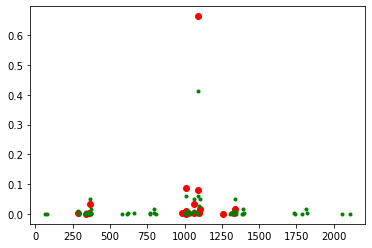

In [31]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")